In [ ]:
  %cd /content/

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/MEDAI_DEC/archive.zip -d /content/

In [ ]:
!pip install torchview

In [ ]:
%cd /content

In [ ]:
cfg_path= "/content/lgg-mri-segmentation/kaggle_3m"

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchsummary import summary
from torchview import draw_graph
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F


import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score, matthews_corrcoef


import random
from collections import defaultdict
import os
import shutil
import copy
from typing import Dict, List, Tuple
import graphviz


# /content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

BATCH_SIZE = (
        16 if torch.cuda.device_count() < 2
        else (16 * torch.cuda.device_count())
    )
seed =768
NUM_WORKERS = os.cpu_count()

LR = 1e-3
PATIENCE= 5
EPOCHS=50

NUM_DEVICES = torch.cuda.device_count()



In [ ]:
NUM_WORKERS

In [ ]:

NUM_DEVICES

In [ ]:
# Fetching files from the directory
file_list= glob.glob(cfg_path+"/*/*.tif", recursive= True)

In [ ]:
len(file_list)

In [ ]:
file_list[:5]

In [ ]:
# ID sorting for each scan

fl_copy= file_list

In [ ]:
def get_sample_numbers(image_paths):
  sample_numbers= []
  is_mask= []
  for f in image_paths:
    path_list= f.split('/')[-2:][1].split('_')
    print(path_list)

    if 'mask.tif' in path_list:
      sample_numbers.append(int(path_list[-2]))
      is_mask.append(1)
      print(is_mask)
      print(sample_numbers)
    else:
      sample_numbers.append(int(path_list[-1].replace('.tif', '')))
      is_mask.append(0)

  return sample_numbers, is_mask

def get_sample_patient_id(image_paths):
  return [(id_.split('/')[-2:][0]) for id_ in image_paths]



In [ ]:
get_sample_numbers(file_list)

In [ ]:
get_sample_patient_id(file_list)

In [ ]:
def build_df(image_paths):
  sample_numbers, mask_label= get_sample_numbers(image_paths)
  sample_df= pd.DataFrame({
      'id': sample_numbers ,
      'patient': get_sample_patient_id(image_paths),
      'image_path': image_paths,
      'is_mask': mask_label,

  })
  return sample_df

In [ ]:
dataset_df=(build_df(file_list).sort_values(by= ['id', 'patient', 'image_path']).reset_index(drop= True))

In [ ]:
dataset_df.head()

In [ ]:
#Group Samples by mask status

grouped_df= dataset_df.groupby(by= 'is_mask')

image_df, mask_df= (grouped_df.get_group(0).drop('is_mask', axis= 1).reset_index(drop=True),
                    grouped_df.get_group(1).drop('is_mask', axis= 1).reset_index(drop=True)
)



In [ ]:
mask_df= mask_df.rename({'image_path' : 'mask_path'}, axis=1)

In [ ]:
mask_df

In [ ]:
def _load(image_path, as_tensor= True):
  image=Image.open(image_path)
  image= np.array(image).astype(np.float32) / 255.
  return image

def generate_label(mask_path, load_fn):
  mask= load_fn(mask_path)
  if mask.max() > 0:
    return 1
  return 0

In [ ]:
ds= image_df.merge(mask_df, on=['id', 'patient'], how='left')



In [ ]:
ds

In [ ]:
ds['diagnosis'] = [generate_label(_, _load) for _ in tqdm(ds['mask_path'])]

In [ ]:
ds

In [ ]:
# To View Diagnosis Distribution

fig= plt.figure(figsize= (15,8))

plt.title("Diagnosis Distribution", fontsize= 22)

diagnosis_distribution =ds['diagnosis'].value_counts().sort_values()
diagnosis_map = {0 : 'Normal', 1 : 'Tumor'}

bar_plot= sns.barplot(
    x= diagnosis_distribution.values,
    y= [diagnosis_map[_] for _ in diagnosis_distribution.keys()],
    palette= sns.color_palette("plasma"),
    orient= 'h'
)

for container in bar_plot.containers:
  bar_plot.bar_label(container, fmt= '%.0f', fontsize= 14)

plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)

text_params= {
    'x' : 2400,
    'y' : -0.4,
    's' : f"Total {len(ds)} images",
    'size' : 12,
    'color' : "Black",
    'ha'    : "center",
    'va'    : "center",
    'bbox'  : dict(boxstyle= "round", fc= ("lightgreen"), ec= ("black"))

}
plt.text(**text_params)

sns.despine()




diagnosi_map= [_ for _ in diagnosis_distribution.keys()]


In [ ]:
def view_sample(image, mask, color_map= 'rgb', fig_size= (16,8), title_size= 18):
  plt.figure(figsize= fig_size);
  plt.tight_layout();
  plt.subplots_adjust(top= 0.95);

  plt.subplot(1,3, 1);
  plt.title("MRI", fontsize= title_size);
  if color_map == "rgb":
    plt.imshow(image);
  else:
    plt.imshow(image, cmap= color_map);

  plt.subplot(1, 3, 2);
  plt.title("Mask", fontsize= title_size);
  plt.imshow(mask, cmap= "gray");

  plt.subplot(1, 3, 3);
  plt.title("MRI + Mask", fontsize= title_size);

  if color_map == "rgb":
    plt.imshow(image)
  else:
    plt.imshow(image, cmap= color_map)

  plt.imshow(mask, cmap="gray", alpha= 0.5);

  return








In [ ]:
rd_num= random.sample(ds.index.to_list(), 1)[0]

sample_image, sample_mask= _load(ds.image_path[rd_num]),  _load(ds.mask_path[rd_num])

view_sample(sample_image, sample_mask, color_map= 'mako')

In [ ]:
def view_multiple_sample(df, sample_loader, count= 10, color_map= "rgb", fig_size= (14, 10) ,title_size= 18):

  rd_num= random.sample(df.index.to_list(), count)

  plt.figure(figsize= fig_size);
  plt.tight_layout();
  plt.subplots_adjust(top= 0.95)

  for x, y in enumerate(rd_num):
    image, mask= (
        sample_loader(df.image_path[y]),
        sample_loader(df.mask_path[y])
  )

    idx= 3 * (x+1)

    plt.subplot(count+1, 3, idx+1);
    plt.title("MRI", fontsize= title_size);
    if color_map== "rgb":
      plt.imshow(image);
    else:
      plt.imshow(image, cmap= color_map);

    plt.subplot(count+1, 3, idx+2);
    plt.title("Mask", fontsize= title_size);
    plt.imshow(mask, cmap= "gray")

    plt.subplot(count+1, 3, idx+3)
    plt.title("MRI + MASK", fontsize= title_size)
    if color_map== "rgb":
      plt.imshow(image)
    else:
      plt.imshow(image, cmap= color_map)
    plt.imshow(mask, cmap ="gray", alpha= 0.5)

  return




In [ ]:
view_multiple_sample(ds, _load, count=6, color_map = "mako", fig_size= (18, 30)  )


In [ ]:
# Splitting the dataset for training
train_split_idx, data_split_idx, _, _= train_test_split(ds.index, ds.diagnosis, test_size= 0.30, stratify= ds.diagnosis, random_state= seed)

In [ ]:
train_df= ds.iloc[train_split_idx].reset_index(drop=True)
data_df= ds.iloc[data_split_idx].reset_index(drop=True)

In [ ]:
print(train_df.shape)
print(data_df.shape)

In [ ]:
val_split_idx, test_split_idx, _, _ = train_test_split(data_df.index, data_df.diagnosis, test_size= 0.65, stratify = data_df.diagnosis, random_state= seed )

In [ ]:
 val_df= data_df.iloc[val_split_idx].reset_index(drop= True)
 test_df= data_df.iloc[test_split_idx].reset_index(drop= True)

In [ ]:
print(val_df.shape)
print(test_df.shape)

In [ ]:
train_size= len(train_df)
test_size= len(test_df)
val_size= len(val_df)
total_size= train_size + test_size + val_size

print("===================================================")
print(f'Training Sample Size:\t\t{train_size}\t({(100 * train_size/total_size):.2f}%)')
print(f'Testing Sample Size:\t\t{test_size}\t({(100 * test_size/total_size):.2f}%)')
print(f'Validation Sample Size:\t\t{val_size}\t({(100 * val_size/total_size):.2f}%)')
print("===================================================")

print(f'Total \t\t\t\t{total_size}\t({(100 * total_size/total_size):.2f}%)')


In [ ]:
fig, (ax1, ax2, ax3)= plt.subplots(3, figsize= (16, 8))
fig.tight_layout(pad= 6.0)

sns.despine()

#Train distribution
ax1.set_title("Training Data Distribution", fontsize= 18)
train_distribution= train_df['diagnosis'].value_counts().sort_values()
distribution_map = {0: 'Normal', 1 : 'Tumor'}

bar_plot= sns.barplot(
    x= train_distribution.values,
    y= [distribution_map[_] for _ in train_distribution.keys()],
    orient= 'h', palette= sns.color_palette('plasma'),
    ax= ax1

);

for container in bar_plot.containers:
  bar_plot.bar_label(container, fmt='%.0f', fontsize= 14);

# Axis tick parameters
ax1.tick_params(axis= 'both', which= 'major', labelsize= 16);

#Validation data distribution
ax2.set_title("Validation Data Distribution", fontsize= 18)
val_distribution= val_df['diagnosis'].value_counts().sort_values()

bar_plot= sns.barplot(
    x= val_distribution.values,
    y= [distribution_map[_] for _ in val_distribution.keys()],
    orient= 'h', palette= sns.color_palette('plasma'),
    ax= ax2

)
for container in bar_plot.containers:
  bar_plot.bar_label(container, fmt= '%.0f', fontsize= 14)

# Axis tick parameters
ax2.tick_params(axis= 'both', which= 'major', labelsize=16);

#Test data distribution
ax3.set_title("Testing Data Distribution", fontsize= 18)
test_distribution= test_df['diagnosis'].value_counts().sort_values()

bar_plot= sns.barplot(
    x= test_distribution.values,
    y= [distribution_map[_] for _ in test_distribution.keys()],
    orient= 'h', palette= sns.color_palette('plasma'),
    ax= ax3

)

for container in bar_plot.containers:
  bar_plot.bar_label(container, fmt= '%.0f', fontsize= 14 )

#axis Parameters
ax3.tick_params(axis= 'both', which= 'major', labelsize= 16)






In [ ]:

#Augment train data
train_transforms= A.Compose([
    A.Resize(320, 320, p=1.0),
    A.RandomBrightnessContrast(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
])

# Reshape Inference data

inference_transforms= A.Compose([
    A.Resize(320, 320, p=1.0),
    ToTensorV2(),
])


In [ ]:
# Select random sample from train_df
idx= random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label= _load(train_df.image_path[idx]), _load(train_df.mask_path[idx])

aug= train_transforms(image= sample_image, mask= sample_label)

# View the random sample
view_sample(image= aug['image'].permute(1,2,0), mask= aug['mask'].unsqueeze_(0).permute(1,2,0), color_map= 'mako')


In [ ]:
class MRISegmentationDataset(Dataset):
  def __init__(self, df:pd.DataFrame, transform= None) -> None:
    super().__init__()

    self.mri_paths= df['image_path'].to_list()
    self.mask_paths= df['mask_path'].to_list()

    self.transform= transform

  def load_sample(self, index:str) -> Image.Image:
    image_path= self.mri_paths[index]
    mask_path= self.mask_paths[index]

    image= Image.open(image_path)
    mask= Image.open(mask_path)

    image= np.array(image).astype(np.float32) /255.
    mask= np.array(mask).astype(np.float32) /255.


    return image, mask

  def __len__(self) -> int:
    return self.mri_paths.__len__()

  def __getitem__(self, index:int) -> Tuple[torch.Tensor, torch.Tensor]:
    image,mask = self.load_sample(index)

    if self.transform:
      transformed= self.transform(image= image, mask= mask)
      return transformed['image'], transformed['mask'].unsqueeze_(0)
    else:
      transformed= ToTensorV2()(image= image, mask=mask)
      return transformed['image'], transformed['mask'].unsqueeze_(0)








In [ ]:
#Building Datasets
train_ds= MRISegmentationDataset(train_df, transform= train_transforms)

val_ds= MRISegmentationDataset(val_df, transform= inference_transforms)

test_ds= MRISegmentationDataset(test_df, transform= inference_transforms)


In [ ]:
#Building Dataloaders



train_dl= DataLoader(dataset= train_ds,
                     batch_size= BATCH_SIZE ,
                     num_workers= NUM_WORKERS ,
                     shuffle= True )

val_dl= DataLoader(dataset= val_ds,
                   batch_size= BATCH_SIZE,
                   num_workers= NUM_WORKERS,
                   shuffle= False
                   )
test_dl = DataLoader(dataset= test_ds,
                     batch_size= BATCH_SIZE,
                     num_workers= NUM_WORKERS,
                     shuffle= False
)


In [ ]:
bce_loss= nn.BCELoss(size_average= True)


def multi_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels):
  loss0= bce_loss(d0, labels)
  loss1= bce_loss(d1, labels)
  loss2= bce_loss(d2, labels)
  loss3= bce_loss(d3, labels)
  loss4= bce_loss(d4, labels)
  loss5= bce_loss(d5, labels)
  loss6= bce_loss(d6, labels)

  loss= loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
  print("10: %3f, 11: %3f, 12: %3f, 13: %3f, 14: %3f, 15: %3f, 16: %3f\n"%(loss0.data.item(), loss1.data.item(), loss2.data.item(), loss3.data.item(), loss4.data.item(), loss5.data.item(), loss6.data.item() ))
  return loss0, loss

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:

#Training Function

def execute_epoch(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,
                  optimizer:torch.optim.Optimizer,
                  device:torch.device) -> Tuple[float, float]:

  model.train()
  train_loss, train_dice = 0,0

  for batch, (X, y) in enumerate(tqdm(dataloader)):
    #Loading Data onto target device
    X= X.to(device)
    y= y.to(device)

    optimizer.zero_grad()

    # prediction and loss
    d0, d1, d2, d3, d4, d5, d6= model(X)
    loss0, loss= multi_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, y)
    train_loss += loss.detach().cpu()

    #Gradients resetting and loss backpropagation

    loss.backward()

    #Update model gradients
    optimizer.step()

    #Compute batchwise Metrics

    predicted_class= (d0 > 0.5).float()

    eps= 1e-8
    train_dice += (
              (2 * (y * predicted_class).sum() + eps)/
              ((y+predicted_class).sum() + eps)
        ).detach().cpu()
  train_loss= train_loss / len(dataloader)
  train_dice= train_dice / len(dataloader)

  return train_loss, train_dice

# d0, d1, d2, d3, d4, d5, d6= model(X)

In [ ]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    device:torch.device
) -> Tuple[float, float]:

  model.eval()

  #Initialize eval loss & accuracy
  eval_loss, eval_dice= 0,  0

  with torch.inference_mode():

    for batch, (X, y) in enumerate(dataloader):

      X= X.to(device)
      y= y.to(device)

      # Training and feel forward
      d0, d1, d2, d3, d4, d5, d6= model(X)
      loss0, loss= multi_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, y)
    # prediction and loss

      eval_loss += loss.detach().cpu().numpy()

      #Evaluation Metrics

      predicted_class= (d0 > 0.5).float()

      eps= 1e-8

      eval_dice += (
          ( 2 * (y * predicted_class).sum() + eps)/
          ((y + predicted_class).sum() +eps)
          ).detach().cpu()

  eval_loss= eval_loss / len(dataloader)
  eval_dice= eval_dice / len(dataloader)

  return eval_loss, eval_dice









In [ ]:
# Training loop

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    eval_dataloader : torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler,
    epochs: int,
    device: torch.device,
    model_path, model_name) -> Dict[str, List]:

  session={
      'loss' : [],
      'loss_score' : [],
      'eval_loss': [],
      'eval_score': []
  }

  for epoch in tqdm(range(epochs)):

    print(f'Training Model \n Epoch {epoch +1} / {epochs}')
    train_loss, train_dice= execute_epoch(
        model,
        train_dataloader,
        optimizer,
        device

    )

    eval_loss, eval_dice= evaluate(
        model,
        eval_dataloader,
        device
    )

    current_lr = 0
    if scheduler:
      scheduler.step(eval_loss)
      current_lr= optimizer.param_groups[0]['lr']

    # Logging epoch Metrics
    log_text= f'loss: {train_loss:.4f} - dice_score: {train_dice:.4f} - eval_loss: {eval_loss:.4f} - eval_dice: {eval_dice:.4f}'

    if scheduler:
      print(log_text + f' lr : {current_lr}')
    else:
      print(log_text)

    #Record Epoch Metrics
    session['loss'].append(train_loss)
    session['loss_score'].append(train_dice)
    session['eval_loss'].append(eval_loss)
    session['eval_score'].append(eval_dice)

    if ((epoch+1) % 10) == 0:
      print("Saving Model")
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, model_path+model_name +'.pth')

    else:
      print("Not Saving in this epoch")





  return session








In [ ]:
def predict(
    model:torch.nn.Module,
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device,
    threshold:float=0.5,
) -> np.ndarray:

  #Setting model to evaluation mode
  model.eval()

  predictions= []
  with torch.inference_mode():
    for batch, (X,y) in enumerate(tqdm(sample_loader)):
      X= X.to(device)
      y= y.to(device)

      d0, d1, d2, d3, d4, d5, d6= model(X)

      predicted_class= (d0 >= threshold).float()

      predictions.append(predicted_class.cpu().numpy())



  return np.vstack(predictions)

In [ ]:
class RebenConv(nn.Module):
  def __init__(self, in_ch= 3, out_ch= 3, dirate=1):
    super(RebenConv, self).__init__()

    self.conv_s1= nn.Conv2d(in_ch, out_ch, 3,padding= 1*dirate, dilation= 1*dirate )
    self.bn_s1= nn.BatchNorm2d(out_ch)
    self.relu_s1= nn.ReLU(inplace= True)

  def forward(self, x):
    x= self.relu_s1(self.bn_s1(self.conv_s1(x)))
    return x




In [ ]:
def upsample_like(src, tar):

  src= F.upsample(src, size= tar.shape[2:], mode= 'bilinear')
  return src


In [ ]:
class RSU7(nn.Module):
  def __init__(self, in_ch=3, mid_ch=12,out_ch=3):
    super(RSU7, self).__init__()

    self.rebenconvin= RebenConv(in_ch, out_ch, dirate= 1)

    self.rebenconv1= RebenConv(out_ch,mid_ch, dirate= 1)
    self.pool1= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv2= RebenConv(mid_ch, mid_ch, dirate= 1)
    self.pool2= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv3= RebenConv(mid_ch, mid_ch, dirate= 1)
    self.pool3= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv4= RebenConv(mid_ch, mid_ch, dirate= 1)
    self.pool4= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv5= RebenConv(mid_ch, mid_ch, dirate= 1)
    self.pool5= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv6= RebenConv(mid_ch, mid_ch, dirate= 1)

    self.rebenconv7= RebenConv(mid_ch, mid_ch, dirate= 2)

    self.rebenconv6d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv5d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv4d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv3d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv2d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv1d= RebenConv(mid_ch*2, out_ch, dirate= 1)

  def forward(self, x):

    hx= x

    hxin= self.rebenconvin(hx)

    hx1= self.rebenconv1(hxin)
    hx= self.pool1(hx1)

    hx2= self.rebenconv2(hx)
    hx= self.pool2(hx2)

    hx3= self.rebenconv3(hx)
    hx= self.pool3(hx3)

    hx4= self.rebenconv4(hx)
    hx= self.pool4(hx4)

    hx5= self.rebenconv5(hx)
    hx= self.pool5(hx5)

    hx6= self.rebenconv6(hx)

    hx7= self.rebenconv7(hx6)

    hx6d= self.rebenconv6d(torch.cat((hx7, hx6), 1))
    hx6dup= upsample_like(hx6d, hx5)

    hx5d= self.rebenconv5d(torch.cat((hx6dup, hx5), 1))
    hx5dup= upsample_like(hx5d, hx4)

    hx4d= self.rebenconv4d(torch.cat((hx5dup, hx4), 1))
    hx4dup= upsample_like(hx4d, hx3)

    hx3d= self.rebenconv3d(torch.cat((hx4dup, hx3), 1))
    hx3dup= upsample_like(hx3d, hx2)

    hx2d= self.rebenconv2d(torch.cat((hx3dup, hx2), 1))
    hx2dup= upsample_like(hx2d, hx1)

    hx1d= self.rebenconv1d(torch.cat((hx2dup,hx1), 1))

    return hx1d + hxin







In [ ]:
class RSU6(nn.Module):
  def __init__(self, in_ch= 3, mid_ch = 12, out_ch= 3):
    super(RSU6, self).__init__()

    self.rebenconvin= RebenConv(in_ch, out_ch, dirate= 1)

    self.rebenconv1= RebenConv(out_ch, mid_ch, dirate= 1)
    self.pool1= nn.MaxPool2d(2, stride= 2, ceil_mode= True)

    self.rebenconv2= RebenConv(mid_ch, mid_ch, dirate= 1)
    self.pool2= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv3= RebenConv(mid_ch, mid_ch, dirate= 1)
    self.pool3= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv4= RebenConv(mid_ch, mid_ch, dirate= 1)
    self.pool4= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv5= RebenConv(mid_ch, mid_ch, dirate= 1)

    self.rebenconv6= RebenConv(mid_ch, mid_ch, dirate= 2)

    self.rebenconv5d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv4d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv3d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv2d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv1d= RebenConv(mid_ch*2, out_ch, dirate= 1)


  def forward(self, x):

    hx= x

    hxin= self.rebenconvin(hx)

    hx1= self.rebenconv1(hxin)
    hx= self.pool1(hx1)

    hx2= self.rebenconv2(hx)
    hx= self.pool2(hx2)

    hx3= self.rebenconv3(hx)
    hx= self.pool3(hx3)

    hx4= self.rebenconv4(hx)
    hx= self.pool4(hx4)

    hx5= self.rebenconv5(hx)

    hx6= self.rebenconv6(hx5)

    hx5d= self.rebenconv5d(torch.cat((hx6, hx5), 1))
    hx5dup = upsample_like(hx5d, hx4)

    hx4d= self.rebenconv4d(torch.cat((hx5dup, hx4), 1))
    hx4dup = upsample_like(hx4d, hx3)

    hx3d= self.rebenconv3d(torch.cat((hx4dup, hx3), 1))
    hx3dup=  upsample_like(hx3d, hx2)

    hx2d= self.rebenconv2d(torch.cat((hx3dup, hx2), 1))
    hx2dup = upsample_like(hx2d, hx1)

    hx1d= self.rebenconv1d(torch.cat((hx2dup, hx1), 1))

    return hx1d + hxin





In [ ]:
class RSU5(nn.Module):
  def __init__(self, in_ch = 3, mid_ch = 12, out_ch = 3):
    super(RSU5, self).__init__()

    self.rebenconvin= RebenConv(in_ch, out_ch, dirate= 1)

    self.rebenconv1= RebenConv(out_ch, mid_ch, dirate= 1)
    self.pool1= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv2= RebenConv(mid_ch, mid_ch, dirate= 1)
    self.pool2= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv3= RebenConv(mid_ch, mid_ch, dirate= 1)
    self.pool3= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv4= RebenConv(mid_ch, mid_ch, dirate= 1)

    self.rebenconv5= RebenConv(mid_ch, mid_ch, dirate= 2)

    self.rebenconv4d= RebenConv(mid_ch*2, mid_ch, dirate=1)
    self.rebenconv3d= RebenConv(mid_ch*2, mid_ch, dirate=1)
    self.rebenconv2d= RebenConv(mid_ch*2, mid_ch, dirate=1)
    self.rebenconv1d= RebenConv(mid_ch*2, out_ch, dirate=1)

  def forward(self, x):
    hx= x

    hxin= self.rebenconvin(hx)

    hx1= self.rebenconv1(hxin)
    hx= self.pool1(hx1)

    hx2= self.rebenconv2(hx)
    hx= self.pool2(hx2)

    hx3= self.rebenconv3(hx)
    hx= self.pool3(hx3)

    hx4= self.rebenconv4(hx)

    hx5= self.rebenconv5(hx4)

    hx4d= self.rebenconv4d(torch.cat((hx5, hx4), 1))
    hx4dup= upsample_like(hx4d, hx3)

    hx3d= self.rebenconv3d(torch.cat((hx4dup, hx3), 1))
    hx3dup=  upsample_like(hx3d, hx2)

    hx2d= self.rebenconv2d(torch.cat((hx3dup, hx2), 1))
    hx2dup= upsample_like(hx2d, hx1)

    hx1d= self.rebenconv1d(torch.cat((hx2dup, hx1), 1))

    return hx1d + hxin


In [ ]:
class RSU4(nn.Module):
  def __init__(self, in_ch= 3, mid_ch= 12, out_ch= 3):
    super(RSU4, self).__init__()

    self.rebenconvin= RebenConv(in_ch, out_ch, dirate = 1)
    self.rebenconv1= RebenConv(out_ch, mid_ch, dirate= 1)
    self.pool1= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv2= RebenConv(mid_ch, mid_ch, dirate= 1)
    self.pool2= nn.MaxPool2d(2, stride=2, ceil_mode= True)

    self.rebenconv3= RebenConv(mid_ch, mid_ch, dirate= 1)

    self.rebenconv4= RebenConv(mid_ch, mid_ch, dirate= 2)

    self.rebenconv3d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv2d= RebenConv(mid_ch*2, mid_ch, dirate= 1)
    self.rebenconv1d= RebenConv(mid_ch*2, out_ch, dirate= 1)


  def forward(self, x):
    hx= x

    hxin= self.rebenconvin(hx)

    hx1= self.rebenconv1(hxin)
    hx= self.pool1(hx1)

    hx2= self.rebenconv2(hx)
    hx= self.pool2(hx2)

    hx3= self.rebenconv3(hx)

    hx4= self.rebenconv4(hx3)

    hx3d= self.rebenconv3d(torch.cat((hx4, hx3), 1))
    hx3dup= upsample_like(hx3d, hx2)

    hx2d= self.rebenconv2d(torch.cat((hx3dup, hx2), 1))
    hx2dup= upsample_like(hx2d, hx1)

    hx1d= self.rebenconv1d(torch.cat((hx2dup, hx1), 1))

    return hx1d + hxin







In [ ]:
class RSU4F(nn.Module):
  def __init__(self, in_ch= 3, mid_ch= 12, out_ch= 3):
    super(RSU4F, self).__init__()

    self.rebenconvin= RebenConv(in_ch, out_ch, dirate= 1)

    self.rebenconv1= RebenConv(out_ch, mid_ch, dirate= 1)
    self.rebenconv2= RebenConv(mid_ch, mid_ch, dirate= 2)
    self.rebenconv3= RebenConv(mid_ch, mid_ch, dirate= 4)

    self.rebenconv4= RebenConv(mid_ch, mid_ch, dirate= 8)

    self.rebenconv3d= RebenConv(mid_ch*2, mid_ch, dirate= 4)
    self.rebenconv2d= RebenConv(mid_ch*2, mid_ch, dirate= 2)
    self.rebenconv1d= RebenConv(mid_ch*2, out_ch, dirate= 1)

  def forward(self, x):

    hx= x
    hxin  = self.rebenconvin(hx)

    hx1= self.rebenconv1(hxin)
    hx2= self.rebenconv2(hx1)
    hx3= self.rebenconv3(hx2)
    hx4= self.rebenconv4(hx3)

    hx3d= self.rebenconv3d(torch.cat((hx4, hx3), 1))
    hx2d= self.rebenconv2d(torch.cat((hx3, hx2), 1))
    hx1d= self.rebenconv1d(torch.cat((hx2, hx1), 1))

    return hx1d + hxin



In [ ]:
class U2NET(nn.Module):
  def __init__(self, in_ch=3, out_ch=1):
    super(U2NET, self).__init__()

    self.stage1= RSU7(in_ch, 32, 64)
    self.pool12= nn.MaxPool2d(2,stride= 2, ceil_mode= True)

    self.stage2= RSU6(64, 32, 128)
    self.pool23= nn.MaxPool2d(2,stride= 2, ceil_mode= True)

    self.stage3= RSU5(128, 64, 256)
    self.pool34= nn.MaxPool2d(2,stride= 2, ceil_mode= True)

    self.stage4= RSU4(256, 128, 512)
    self.pool45= nn.MaxPool2d(2,stride= 2, ceil_mode= True)

    self.stage5= RSU4F(512, 256, 512)
    self.pool56= nn.MaxPool2d(2,stride= 2, ceil_mode= True)

    self.stage6= RSU4F(512, 256, 512)

    #Decoder

    self.stage5d= RSU4F(1024, 256, 512)
    self.stage4d= RSU4(1024, 128, 256)
    self.stage3d= RSU5(512, 64, 128)
    self.stage2d= RSU6(256, 32, 64)
    self.stage1d= RSU7(128, 16, 64)

    self.side1= nn.Conv2d(64, out_ch, 3, padding= 1)
    self.side2= nn.Conv2d(64, out_ch, 3, padding= 1)
    self.side3= nn.Conv2d(128, out_ch, 3, padding= 1)
    self.side4= nn.Conv2d(256, out_ch, 3, padding= 1)
    self.side5= nn.Conv2d(512, out_ch, 3, padding= 1)
    self.side6= nn.Conv2d(512, out_ch, 3, padding= 1)

    self.out_conv= nn.Conv2d(6*out_ch, out_ch, 1)

  def forward(self, x):
    hx= x

    #Stage 1
    hx1= self.stage1(hx)
    hx= self.pool12(hx1)

    #Stage 2
    hx2= self.stage2(hx)
    hx= self.pool23(hx2)

    #Stage 3
    hx3= self.stage3(hx)
    hx= self.pool34(hx3)

    #Stage 4
    hx4= self.stage4(hx)
    hx= self.pool45(hx4)

    #Stage 5
    hx5= self.stage5(hx)
    hx= self.pool56(hx5)

    #Stage 6
    hx6= self.stage6(hx)
    hx6up= upsample_like(hx6, hx5)


    # ////////////////////////Decoder/////////////////////////////////////

    hx5d= self.stage5d(torch.cat((hx6up, hx5), 1))
    hx5dup= upsample_like(hx5d, hx4)

    hx4d= self.stage4d(torch.cat((hx5dup, hx4), 1))
    hx4dup= upsample_like(hx4d, hx3)

    hx3d= self.stage3d(torch.cat((hx4dup, hx3), 1))
    hx3dup= upsample_like(hx3d, hx2)

    hx2d= self.stage2d(torch.cat((hx3dup, hx2), 1))
    hx2dup= upsample_like(hx2d, hx1)

    hx1d= self.stage1d(torch.cat((hx2dup, hx1), 1))

    #Side Outputs

    d1= self.side1(hx1d)

    d2= self.side2(hx2d)
    d2= upsample_like(d2, d1)

    d3= self.side3(hx3d)
    d3= upsample_like(d3, d1)

    d4= self.side4(hx4d)
    d4= upsample_like(d4, d1)

    d5= self.side5(hx5d)
    d5= upsample_like(d5, d1)

    d6 = self.side6(hx6)
    d6= upsample_like(d6, d1)

    d0= self.out_conv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

    return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)









In [ ]:
net = U2NET(3, 1).to(DEVICE)

summary(net, input_size=(3, 320, 320), batch_size= BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 320, 320]           1,792
       BatchNorm2d-2         [16, 64, 320, 320]             128
              ReLU-3         [16, 64, 320, 320]               0
         RebenConv-4         [16, 64, 320, 320]               0
            Conv2d-5         [16, 32, 320, 320]          18,464
       BatchNorm2d-6         [16, 32, 320, 320]              64
              ReLU-7         [16, 32, 320, 320]               0
         RebenConv-8         [16, 32, 320, 320]               0
         MaxPool2d-9         [16, 32, 160, 160]               0
           Conv2d-10         [16, 32, 160, 160]           9,248
      BatchNorm2d-11         [16, 32, 160, 160]              64
             ReLU-12         [16, 32, 160, 160]               0
        RebenConv-13         [16, 32, 160, 160]               0
        MaxPool2d-14           [16, 32,

In [ ]:
graphviz.set_jupyter_format('png')

model_graph= draw_graph(
    U2NET(3,1),
    input_size= (1, 3, 320, 320 ),
     roll= True, expand_nested= True
)

model_graph.visual_graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.803487 to fit


In [ ]:


#Define Loss Function
# loss_fn =nn.BCEWithLogitsLoss()

#Define Optimizer
optimizer= torch.optim.Adam(
    net.parameters(),
    lr=  LR
)

scheduler= lr_scheduler.ReduceLROnPlateau(

            optimizer=optimizer,
            mode= 'min',
            patience= PATIENCE,
            verbose= True

)

In [ ]:


#Generate Training Session Config

session_config={
    'model' : net,
    'train_dataloader' : train_dl,
    'eval_dataloader' : val_dl,
    'optimizer' : optimizer,
    'scheduler' : scheduler,
    'epochs' : EPOCHS,
    'device' : DEVICE,
    'model_name': 'u2net_model_ckp2',
'model_path' : '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/saved_ckp/'


}


In [ ]:


# #Generate Training Session Config

# session_config={
#     'model' : net,
#     'train_dataloader' : train_dl,
#     'eval_dataloader' : val_dl,
#     'optimizer' : optimizer,
#     'scheduler' : scheduler,
#     'loss_fn' : loss_fn,
#     'epochs' : EPOCHS,
#     'device' : DEVICE,
#     'model_name': 'u2net_model_ckp',
# 'model_path' : '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/saved_ckp/'


# }



In [ ]:
# model_name= 'nestunet_model_ckp'
# model_path= '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/'

# torch.save(n_model, model_path+model_name + '.pth')

In [ ]:
# path_= '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/saved_ckp/nestunet_model_ckp.pth'

In [ ]:
# sample_model= torch.load(path_)

In [ ]:


# Load the network
sample_model =U2NET(3,1).to(DEVICE)


path_= '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/saved_ckp/u2net_model_ckp2.pth'



def train_re(ep, sample_model, optimizer ,RETRAIN, path_):
  if RETRAIN:

    checkpoint = torch.load(path_)

    sample_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = torch.optim.AdamW(
        sample_model.parameters(),
        lr=  LR
    )

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Model loaded!")

    scheduler= lr_scheduler.ReduceLROnPlateau(

                optimizer=optimizer,
                mode= 'min',
                patience= PATIENCE,
                verbose= True

    )
    session_config['model']= sample_model
    session_config['epochs']= ep
    session_config['optimizer']= optimizer
    session_config['scheduler']= scheduler

    print('Re-Training U-Net Model')
    print(f'Train on {len(train_df)} samples, validation on {len(val_df)} samples')
    print("------------------------------------------")

    unet_session_history= train(**session_config)

  else:
    print('Training U-Net Model')
    print(f'Train on {len(train_df)} samples, validation on {len(val_df)} samples')
    print("------------------------------------------")
    unet_session_history= train(**session_config)

  return unet_session_history


In [ ]:
unet_session_history= train_re(ep= 40, sample_model= sample_model, optimizer= optimizer ,RETRAIN= True , path_= path_)

Model loaded!
Re-Training U-Net Model
Train on 2750 samples, validation on 412 samples
------------------------------------------


  0%|          | 0/40 [00:00<?, ?it/s]

Training Model 
 Epoch 1 / 40



  0%|          | 0/172 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


10: 0.006931, 11: 0.007072, 12: 0.006994, 13: 0.007218, 14: 0.007932, 15: 0.009585, 16: 0.012389




  1%|          | 1/172 [00:02<08:24,  2.95s/it]

10: 0.005834, 11: 0.005881, 12: 0.005842, 13: 0.006312, 14: 0.006584, 15: 0.007761, 16: 0.009815




  1%|          | 2/172 [00:04<05:48,  2.05s/it]

10: 0.002787, 11: 0.002804, 12: 0.002831, 13: 0.002898, 14: 0.003217, 15: 0.003963, 16: 0.005079




  2%|▏         | 3/172 [00:05<04:57,  1.76s/it]

10: 0.010372, 11: 0.009714, 12: 0.010402, 13: 0.010799, 14: 0.011563, 15: 0.013051, 16: 0.012144




  2%|▏         | 4/172 [00:07<04:33,  1.63s/it]

10: 0.001860, 11: 0.001813, 12: 0.001806, 13: 0.001873, 14: 0.002132, 15: 0.002325, 16: 0.002877




  3%|▎         | 5/172 [00:08<04:19,  1.55s/it]

10: 0.005129, 11: 0.005484, 12: 0.005371, 13: 0.005177, 14: 0.005156, 15: 0.006021, 16: 0.007487




  3%|▎         | 6/172 [00:10<04:10,  1.51s/it]

10: 0.008078, 11: 0.008280, 12: 0.008123, 13: 0.008021, 14: 0.008669, 15: 0.010069, 16: 0.012166




  4%|▍         | 7/172 [00:11<04:04,  1.48s/it]

10: 0.006082, 11: 0.006159, 12: 0.006491, 13: 0.007201, 14: 0.007341, 15: 0.007901, 16: 0.009605




  5%|▍         | 8/172 [00:12<04:00,  1.47s/it]

10: 0.003609, 11: 0.003750, 12: 0.003684, 13: 0.003777, 14: 0.004102, 15: 0.004791, 16: 0.005957




  5%|▌         | 9/172 [00:14<03:58,  1.46s/it]

10: 0.009847, 11: 0.009527, 12: 0.010021, 13: 0.010471, 14: 0.010752, 15: 0.012017, 16: 0.014145




  6%|▌         | 10/172 [00:15<03:56,  1.46s/it]

10: 0.004132, 11: 0.004089, 12: 0.004006, 13: 0.003817, 14: 0.004296, 15: 0.004634, 16: 0.006041




  6%|▋         | 11/172 [00:17<03:53,  1.45s/it]

10: 0.001299, 11: 0.001322, 12: 0.001358, 13: 0.001383, 14: 0.001563, 15: 0.002168, 16: 0.002761




  7%|▋         | 12/172 [00:18<03:51,  1.45s/it]

10: 0.003912, 11: 0.003972, 12: 0.003945, 13: 0.003991, 14: 0.004538, 15: 0.005337, 16: 0.006973




  8%|▊         | 13/172 [00:20<03:49,  1.44s/it]

10: 0.004339, 11: 0.004519, 12: 0.004480, 13: 0.004624, 14: 0.004790, 15: 0.005338, 16: 0.006711




  8%|▊         | 14/172 [00:21<03:47,  1.44s/it]

10: 0.004930, 11: 0.004828, 12: 0.004944, 13: 0.005299, 14: 0.005756, 15: 0.007240, 16: 0.008684




  9%|▊         | 15/172 [00:22<03:45,  1.44s/it]

10: 0.005490, 11: 0.006075, 12: 0.005763, 13: 0.005890, 14: 0.005811, 15: 0.006735, 16: 0.008193




  9%|▉         | 16/172 [00:24<03:44,  1.44s/it]

10: 0.003546, 11: 0.003678, 12: 0.003703, 13: 0.003683, 14: 0.003881, 15: 0.005279, 16: 0.006444




 10%|▉         | 17/172 [00:25<03:42,  1.44s/it]

10: 0.003961, 11: 0.004082, 12: 0.004024, 13: 0.004364, 14: 0.004625, 15: 0.005634, 16: 0.007010




 10%|█         | 18/172 [00:27<03:41,  1.44s/it]

10: 0.001216, 11: 0.001224, 12: 0.001300, 13: 0.001390, 14: 0.001405, 15: 0.001487, 16: 0.001911




 11%|█         | 19/172 [00:28<03:39,  1.44s/it]

10: 0.005852, 11: 0.006107, 12: 0.006024, 13: 0.005963, 14: 0.006198, 15: 0.007428, 16: 0.009476




 12%|█▏        | 20/172 [00:30<03:39,  1.44s/it]

10: 0.002871, 11: 0.002819, 12: 0.002789, 13: 0.002882, 14: 0.003204, 15: 0.004189, 16: 0.004352




 12%|█▏        | 21/172 [00:31<03:38,  1.45s/it]

10: 0.004800, 11: 0.004292, 12: 0.004671, 13: 0.005767, 14: 0.006170, 15: 0.006623, 16: 0.008053




 13%|█▎        | 22/172 [00:33<03:37,  1.45s/it]

10: 0.006083, 11: 0.006376, 12: 0.006243, 13: 0.005991, 14: 0.006197, 15: 0.007964, 16: 0.009087




 13%|█▎        | 23/172 [00:34<03:35,  1.45s/it]

10: 0.002770, 11: 0.002681, 12: 0.002698, 13: 0.002871, 14: 0.003364, 15: 0.004398, 16: 0.005236




 14%|█▍        | 24/172 [00:35<03:34,  1.45s/it]

10: 0.005970, 11: 0.006150, 12: 0.006072, 13: 0.006322, 14: 0.006500, 15: 0.007203, 16: 0.009776




 15%|█▍        | 25/172 [00:37<03:32,  1.45s/it]

10: 0.002837, 11: 0.002943, 12: 0.002832, 13: 0.003028, 14: 0.003100, 15: 0.004161, 16: 0.005131




 15%|█▌        | 26/172 [00:38<03:31,  1.45s/it]

10: 0.003075, 11: 0.003144, 12: 0.003236, 13: 0.003200, 14: 0.003472, 15: 0.004196, 16: 0.005845




 16%|█▌        | 27/172 [00:40<03:30,  1.45s/it]

10: 0.001821, 11: 0.001735, 12: 0.001756, 13: 0.001918, 14: 0.002398, 15: 0.003066, 16: 0.004172




 16%|█▋        | 28/172 [00:41<03:28,  1.45s/it]

10: 0.005188, 11: 0.005412, 12: 0.005280, 13: 0.005242, 14: 0.005524, 15: 0.006533, 16: 0.008113




 17%|█▋        | 29/172 [00:43<03:27,  1.45s/it]

10: 0.003438, 11: 0.003456, 12: 0.003561, 13: 0.003626, 14: 0.003984, 15: 0.004560, 16: 0.006425




 17%|█▋        | 30/172 [00:44<03:27,  1.46s/it]

10: 0.004387, 11: 0.004218, 12: 0.004582, 13: 0.004868, 14: 0.005353, 15: 0.005800, 16: 0.006561




 18%|█▊        | 31/172 [00:46<03:26,  1.47s/it]

10: 0.004332, 11: 0.004316, 12: 0.004356, 13: 0.004435, 14: 0.004862, 15: 0.005960, 16: 0.007341




 19%|█▊        | 32/172 [00:47<03:25,  1.47s/it]

10: 0.002748, 11: 0.002750, 12: 0.002745, 13: 0.002918, 14: 0.003242, 15: 0.004039, 16: 0.005324




 19%|█▉        | 33/172 [00:49<03:23,  1.46s/it]

10: 0.005711, 11: 0.005860, 12: 0.005820, 13: 0.005736, 14: 0.005894, 15: 0.006196, 16: 0.007945




 20%|█▉        | 34/172 [00:50<03:22,  1.46s/it]

10: 0.002055, 11: 0.002141, 12: 0.002137, 13: 0.001949, 14: 0.002044, 15: 0.002585, 16: 0.003596




 20%|██        | 35/172 [00:52<03:20,  1.46s/it]

10: 0.004572, 11: 0.004498, 12: 0.004511, 13: 0.004648, 14: 0.005034, 15: 0.007072, 16: 0.009606




 21%|██        | 36/172 [00:53<03:19,  1.46s/it]

10: 0.004911, 11: 0.004887, 12: 0.004889, 13: 0.005113, 14: 0.005456, 15: 0.006336, 16: 0.007691




 22%|██▏       | 37/172 [00:54<03:17,  1.46s/it]

10: 0.003570, 11: 0.003538, 12: 0.003609, 13: 0.003530, 14: 0.003883, 15: 0.004726, 16: 0.006073




 22%|██▏       | 38/172 [00:56<03:16,  1.47s/it]

10: 0.004746, 11: 0.004819, 12: 0.004778, 13: 0.004648, 14: 0.005141, 15: 0.006113, 16: 0.008540




 23%|██▎       | 39/172 [00:57<03:15,  1.47s/it]

10: 0.001816, 11: 0.001828, 12: 0.001798, 13: 0.001776, 14: 0.002068, 15: 0.002627, 16: 0.003804




 23%|██▎       | 40/172 [00:59<03:14,  1.47s/it]

10: 0.003811, 11: 0.003842, 12: 0.003774, 13: 0.004112, 14: 0.004581, 15: 0.005894, 16: 0.008549




 24%|██▍       | 41/172 [01:00<03:14,  1.48s/it]

10: 0.004661, 11: 0.004520, 12: 0.004610, 13: 0.005166, 14: 0.005526, 15: 0.006200, 16: 0.007829




 24%|██▍       | 42/172 [01:02<03:13,  1.49s/it]

10: 0.003928, 11: 0.003855, 12: 0.003868, 13: 0.004102, 14: 0.004296, 15: 0.005262, 16: 0.007445




 25%|██▌       | 43/172 [01:03<03:11,  1.48s/it]

10: 0.006305, 11: 0.006105, 12: 0.006555, 13: 0.006809, 14: 0.007067, 15: 0.007741, 16: 0.008726




 26%|██▌       | 44/172 [01:05<03:09,  1.48s/it]

10: 0.003236, 11: 0.003235, 12: 0.003265, 13: 0.003502, 14: 0.003992, 15: 0.004870, 16: 0.006309




 26%|██▌       | 45/172 [01:06<03:07,  1.48s/it]

10: 0.002485, 11: 0.002491, 12: 0.002498, 13: 0.002651, 14: 0.002955, 15: 0.003805, 16: 0.005098




 27%|██▋       | 46/172 [01:08<03:06,  1.48s/it]

10: 0.003761, 11: 0.003737, 12: 0.003777, 13: 0.003712, 14: 0.003995, 15: 0.004394, 16: 0.005905




 27%|██▋       | 47/172 [01:09<03:05,  1.48s/it]

10: 0.007558, 11: 0.007571, 12: 0.007506, 13: 0.007709, 14: 0.008783, 15: 0.010320, 16: 0.013961




 28%|██▊       | 48/172 [01:11<03:03,  1.48s/it]

10: 0.003210, 11: 0.003268, 12: 0.003195, 13: 0.003337, 14: 0.003598, 15: 0.004434, 16: 0.005588




 28%|██▊       | 49/172 [01:12<03:02,  1.48s/it]

10: 0.005086, 11: 0.005049, 12: 0.005005, 13: 0.005146, 14: 0.005499, 15: 0.006241, 16: 0.007976




 29%|██▉       | 50/172 [01:14<03:01,  1.49s/it]

10: 0.002557, 11: 0.002578, 12: 0.002525, 13: 0.002717, 14: 0.003012, 15: 0.003795, 16: 0.005326




 30%|██▉       | 51/172 [01:15<03:01,  1.50s/it]

10: 0.005151, 11: 0.004684, 12: 0.005183, 13: 0.005755, 14: 0.006246, 15: 0.006247, 16: 0.007706




 30%|███       | 52/172 [01:17<03:00,  1.50s/it]

10: 0.003672, 11: 0.003680, 12: 0.003702, 13: 0.003840, 14: 0.004073, 15: 0.004690, 16: 0.005558




 31%|███       | 53/172 [01:18<02:58,  1.50s/it]

10: 0.001665, 11: 0.001628, 12: 0.001634, 13: 0.001807, 14: 0.002166, 15: 0.002738, 16: 0.003730




 31%|███▏      | 54/172 [01:20<02:56,  1.49s/it]

10: 0.007519, 11: 0.007378, 12: 0.007360, 13: 0.007785, 14: 0.008477, 15: 0.009919, 16: 0.011744




 32%|███▏      | 55/172 [01:21<02:54,  1.49s/it]

10: 0.005686, 11: 0.005766, 12: 0.005855, 13: 0.005872, 14: 0.006267, 15: 0.007803, 16: 0.010677




 33%|███▎      | 56/172 [01:23<02:53,  1.49s/it]

10: 0.002802, 11: 0.002865, 12: 0.002809, 13: 0.002893, 14: 0.003263, 15: 0.004045, 16: 0.005654




 33%|███▎      | 57/172 [01:24<02:52,  1.50s/it]

10: 0.005411, 11: 0.005457, 12: 0.005422, 13: 0.005626, 14: 0.005934, 15: 0.006922, 16: 0.010241




 34%|███▎      | 58/172 [01:26<02:50,  1.50s/it]

10: 0.003237, 11: 0.003226, 12: 0.003099, 13: 0.003284, 14: 0.003736, 15: 0.004649, 16: 0.005939




 34%|███▍      | 59/172 [01:27<02:49,  1.50s/it]

10: 0.006285, 11: 0.006163, 12: 0.006215, 13: 0.007235, 14: 0.007319, 15: 0.007989, 16: 0.009161




 35%|███▍      | 60/172 [01:29<02:48,  1.50s/it]

10: 0.002961, 11: 0.003108, 12: 0.003042, 13: 0.003431, 14: 0.003813, 15: 0.003722, 16: 0.004524




 35%|███▌      | 61/172 [01:30<02:47,  1.51s/it]

10: 0.005620, 11: 0.005563, 12: 0.005635, 13: 0.005804, 14: 0.006433, 15: 0.007643, 16: 0.010233




 36%|███▌      | 62/172 [01:32<02:45,  1.50s/it]

10: 0.000822, 11: 0.000821, 12: 0.000847, 13: 0.000891, 14: 0.000984, 15: 0.001247, 16: 0.001861




 37%|███▋      | 63/172 [01:33<02:44,  1.51s/it]

10: 0.011037, 11: 0.011348, 12: 0.011647, 13: 0.011526, 14: 0.011658, 15: 0.012395, 16: 0.013688




 37%|███▋      | 64/172 [01:35<02:42,  1.51s/it]

10: 0.002930, 11: 0.002886, 12: 0.002887, 13: 0.003232, 14: 0.003549, 15: 0.004406, 16: 0.005441




 38%|███▊      | 65/172 [01:36<02:41,  1.51s/it]

10: 0.007251, 11: 0.007436, 12: 0.007341, 13: 0.007885, 14: 0.008093, 15: 0.008840, 16: 0.008342




 38%|███▊      | 66/172 [01:38<02:39,  1.51s/it]

10: 0.003065, 11: 0.003044, 12: 0.003119, 13: 0.003213, 14: 0.003593, 15: 0.004587, 16: 0.006511




 39%|███▉      | 67/172 [01:39<02:38,  1.51s/it]

10: 0.005883, 11: 0.005778, 12: 0.005841, 13: 0.006077, 14: 0.006646, 15: 0.007659, 16: 0.010043




 40%|███▉      | 68/172 [01:41<02:37,  1.51s/it]

10: 0.004985, 11: 0.004946, 12: 0.004763, 13: 0.004749, 14: 0.005476, 15: 0.006498, 16: 0.008382




 40%|████      | 69/172 [01:42<02:35,  1.51s/it]

10: 0.003787, 11: 0.003954, 12: 0.003882, 13: 0.003908, 14: 0.003969, 15: 0.004901, 16: 0.005628




 41%|████      | 70/172 [01:44<02:34,  1.52s/it]

10: 0.007818, 11: 0.007461, 12: 0.007685, 13: 0.008081, 14: 0.008807, 15: 0.011435, 16: 0.015214




 41%|████▏     | 71/172 [01:45<02:34,  1.53s/it]

10: 0.001278, 11: 0.001290, 12: 0.001318, 13: 0.001297, 14: 0.001449, 15: 0.001768, 16: 0.002716




 42%|████▏     | 72/172 [01:47<02:33,  1.53s/it]

10: 0.002805, 11: 0.002928, 12: 0.002931, 13: 0.003059, 14: 0.003313, 15: 0.003711, 16: 0.004881




 42%|████▏     | 73/172 [01:49<02:31,  1.53s/it]

10: 0.004776, 11: 0.004646, 12: 0.004714, 13: 0.004886, 14: 0.005671, 15: 0.006914, 16: 0.008697




 43%|████▎     | 74/172 [01:50<02:29,  1.53s/it]

10: 0.002658, 11: 0.002683, 12: 0.002632, 13: 0.002751, 14: 0.003046, 15: 0.003991, 16: 0.005138




 44%|████▎     | 75/172 [01:52<02:28,  1.53s/it]

10: 0.006862, 11: 0.007116, 12: 0.007133, 13: 0.007249, 14: 0.007500, 15: 0.008842, 16: 0.010638




 44%|████▍     | 76/172 [01:53<02:26,  1.53s/it]

10: 0.001944, 11: 0.001888, 12: 0.001897, 13: 0.001969, 14: 0.002321, 15: 0.002999, 16: 0.004178




 45%|████▍     | 77/172 [01:55<02:25,  1.53s/it]

10: 0.003034, 11: 0.003069, 12: 0.003104, 13: 0.003270, 14: 0.003617, 15: 0.004324, 16: 0.005678




 45%|████▌     | 78/172 [01:56<02:23,  1.53s/it]

10: 0.003203, 11: 0.003172, 12: 0.003206, 13: 0.003410, 14: 0.003660, 15: 0.004613, 16: 0.005778




 46%|████▌     | 79/172 [01:58<02:22,  1.53s/it]

10: 0.003247, 11: 0.003146, 12: 0.003282, 13: 0.003306, 14: 0.003771, 15: 0.004741, 16: 0.005733




 47%|████▋     | 80/172 [01:59<02:20,  1.53s/it]

10: 0.002712, 11: 0.002771, 12: 0.002820, 13: 0.002872, 14: 0.003153, 15: 0.003847, 16: 0.005426




 47%|████▋     | 81/172 [02:01<02:19,  1.53s/it]

10: 0.005697, 11: 0.006409, 12: 0.006234, 13: 0.005523, 14: 0.005235, 15: 0.005214, 16: 0.005655




 48%|████▊     | 82/172 [02:02<02:18,  1.54s/it]

10: 0.003840, 11: 0.003873, 12: 0.003896, 13: 0.003999, 14: 0.004300, 15: 0.005368, 16: 0.007030




 48%|████▊     | 83/172 [02:04<02:16,  1.53s/it]

10: 0.002622, 11: 0.002689, 12: 0.002601, 13: 0.002540, 14: 0.002807, 15: 0.003455, 16: 0.004574




 49%|████▉     | 84/172 [02:05<02:14,  1.53s/it]

10: 0.002568, 11: 0.002586, 12: 0.002594, 13: 0.002659, 14: 0.002914, 15: 0.003974, 16: 0.005253




 49%|████▉     | 85/172 [02:07<02:12,  1.52s/it]

10: 0.007907, 11: 0.007941, 12: 0.007948, 13: 0.007929, 14: 0.008405, 15: 0.009396, 16: 0.013036




 50%|█████     | 86/172 [02:08<02:10,  1.52s/it]

10: 0.004268, 11: 0.004192, 12: 0.004352, 13: 0.004707, 14: 0.004839, 15: 0.005894, 16: 0.008937




 51%|█████     | 87/172 [02:10<02:08,  1.51s/it]

10: 0.006862, 11: 0.006872, 12: 0.006784, 13: 0.006896, 14: 0.007861, 15: 0.009960, 16: 0.014390




 51%|█████     | 88/172 [02:11<02:07,  1.51s/it]

10: 0.004580, 11: 0.004560, 12: 0.004638, 13: 0.004781, 14: 0.005105, 15: 0.005898, 16: 0.006793




 52%|█████▏    | 89/172 [02:13<02:05,  1.51s/it]

10: 0.003231, 11: 0.003168, 12: 0.003278, 13: 0.003610, 14: 0.003794, 15: 0.004408, 16: 0.005146




 52%|█████▏    | 90/172 [02:14<02:04,  1.52s/it]

10: 0.000751, 11: 0.000763, 12: 0.000775, 13: 0.000829, 14: 0.000806, 15: 0.000708, 16: 0.000986




 53%|█████▎    | 91/172 [02:16<02:03,  1.52s/it]

10: 0.004413, 11: 0.004407, 12: 0.004465, 13: 0.004762, 14: 0.004892, 15: 0.005520, 16: 0.007723




 53%|█████▎    | 92/172 [02:18<02:02,  1.53s/it]

10: 0.000603, 11: 0.000653, 12: 0.000630, 13: 0.000631, 14: 0.000701, 15: 0.001032, 16: 0.001859




 54%|█████▍    | 93/172 [02:19<02:00,  1.52s/it]

10: 0.004530, 11: 0.004614, 12: 0.004719, 13: 0.004693, 14: 0.005188, 15: 0.006070, 16: 0.007649




 55%|█████▍    | 94/172 [02:21<01:58,  1.51s/it]

10: 0.003936, 11: 0.003912, 12: 0.003909, 13: 0.003895, 14: 0.004612, 15: 0.005456, 16: 0.007112




 55%|█████▌    | 95/172 [02:22<01:56,  1.52s/it]

10: 0.003517, 11: 0.003475, 12: 0.003585, 13: 0.003891, 14: 0.004369, 15: 0.005598, 16: 0.008015




 56%|█████▌    | 96/172 [02:24<01:55,  1.52s/it]

10: 0.007421, 11: 0.007379, 12: 0.007492, 13: 0.007718, 14: 0.008508, 15: 0.009073, 16: 0.012452




 56%|█████▋    | 97/172 [02:25<01:53,  1.51s/it]

10: 0.002868, 11: 0.002913, 12: 0.002897, 13: 0.003119, 14: 0.003362, 15: 0.004346, 16: 0.005514




 57%|█████▋    | 98/172 [02:27<01:51,  1.51s/it]

10: 0.003700, 11: 0.003621, 12: 0.003567, 13: 0.003760, 14: 0.004236, 15: 0.005246, 16: 0.007106




 58%|█████▊    | 99/172 [02:28<01:49,  1.51s/it]

10: 0.002914, 11: 0.003165, 12: 0.003134, 13: 0.002897, 14: 0.002760, 15: 0.002983, 16: 0.003667




 58%|█████▊    | 100/172 [02:30<01:48,  1.51s/it]

10: 0.005210, 11: 0.005325, 12: 0.005252, 13: 0.005405, 14: 0.006085, 15: 0.006986, 16: 0.009121




 59%|█████▊    | 101/172 [02:31<01:47,  1.51s/it]

10: 0.008802, 11: 0.008842, 12: 0.008879, 13: 0.008916, 14: 0.009719, 15: 0.011818, 16: 0.013555




 59%|█████▉    | 102/172 [02:33<01:46,  1.52s/it]

10: 0.005889, 11: 0.005680, 12: 0.005790, 13: 0.005826, 14: 0.006693, 15: 0.007101, 16: 0.009111




 60%|█████▉    | 103/172 [02:34<01:44,  1.51s/it]

10: 0.007066, 11: 0.007173, 12: 0.007179, 13: 0.007444, 14: 0.007713, 15: 0.008920, 16: 0.012336




 60%|██████    | 104/172 [02:36<01:42,  1.51s/it]

10: 0.006849, 11: 0.006827, 12: 0.006904, 13: 0.007553, 14: 0.007866, 15: 0.009427, 16: 0.011291




 61%|██████    | 105/172 [02:37<01:40,  1.50s/it]

10: 0.004620, 11: 0.004740, 12: 0.004635, 13: 0.004607, 14: 0.004812, 15: 0.005249, 16: 0.006281




 62%|██████▏   | 106/172 [02:39<01:39,  1.50s/it]

10: 0.002126, 11: 0.002142, 12: 0.002161, 13: 0.002201, 14: 0.002343, 15: 0.002773, 16: 0.003859




 62%|██████▏   | 107/172 [02:40<01:37,  1.50s/it]

10: 0.010888, 11: 0.010498, 12: 0.010684, 13: 0.011453, 14: 0.012014, 15: 0.013380, 16: 0.016239




 63%|██████▎   | 108/172 [02:42<01:36,  1.50s/it]

10: 0.005182, 11: 0.005213, 12: 0.005222, 13: 0.005408, 14: 0.005975, 15: 0.007466, 16: 0.010089




 63%|██████▎   | 109/172 [02:43<01:34,  1.50s/it]

10: 0.004081, 11: 0.004103, 12: 0.004071, 13: 0.004136, 14: 0.004719, 15: 0.005445, 16: 0.006786




 64%|██████▍   | 110/172 [02:45<01:33,  1.51s/it]

10: 0.001058, 11: 0.001084, 12: 0.001134, 13: 0.001178, 14: 0.001191, 15: 0.001296, 16: 0.001587




 65%|██████▍   | 111/172 [02:46<01:32,  1.51s/it]

10: 0.005102, 11: 0.004920, 12: 0.004945, 13: 0.005644, 14: 0.005912, 15: 0.006659, 16: 0.008161




 65%|██████▌   | 112/172 [02:48<01:31,  1.52s/it]

10: 0.002766, 11: 0.002877, 12: 0.002834, 13: 0.002800, 14: 0.003185, 15: 0.003897, 16: 0.004947




 66%|██████▌   | 113/172 [02:49<01:29,  1.52s/it]

10: 0.005779, 11: 0.005725, 12: 0.005695, 13: 0.006121, 14: 0.006672, 15: 0.007532, 16: 0.009769




 66%|██████▋   | 114/172 [02:51<01:27,  1.51s/it]

10: 0.005229, 11: 0.005109, 12: 0.005089, 13: 0.005572, 14: 0.005997, 15: 0.007187, 16: 0.007463




 67%|██████▋   | 115/172 [02:52<01:26,  1.51s/it]

10: 0.004323, 11: 0.004457, 12: 0.004313, 13: 0.004464, 14: 0.004838, 15: 0.005717, 16: 0.007713




 67%|██████▋   | 116/172 [02:54<01:24,  1.52s/it]

10: 0.001822, 11: 0.001849, 12: 0.001839, 13: 0.001869, 14: 0.002118, 15: 0.002676, 16: 0.003654




 68%|██████▊   | 117/172 [02:55<01:24,  1.53s/it]

10: 0.003845, 11: 0.003893, 12: 0.003854, 13: 0.003958, 14: 0.004518, 15: 0.005172, 16: 0.007052




 69%|██████▊   | 118/172 [02:57<01:22,  1.52s/it]

10: 0.002473, 11: 0.002485, 12: 0.002450, 13: 0.002600, 14: 0.002910, 15: 0.003631, 16: 0.005309




 69%|██████▉   | 119/172 [02:58<01:20,  1.52s/it]

10: 0.004722, 11: 0.004915, 12: 0.004767, 13: 0.004681, 14: 0.005002, 15: 0.005717, 16: 0.007754




 70%|██████▉   | 120/172 [03:00<01:18,  1.52s/it]

10: 0.001683, 11: 0.001714, 12: 0.001684, 13: 0.001758, 14: 0.002033, 15: 0.002765, 16: 0.003726




 70%|███████   | 121/172 [03:01<01:17,  1.52s/it]

10: 0.007341, 11: 0.007383, 12: 0.007293, 13: 0.007333, 14: 0.007954, 15: 0.009121, 16: 0.011089




 71%|███████   | 122/172 [03:03<01:16,  1.53s/it]

10: 0.002429, 11: 0.002373, 12: 0.002355, 13: 0.002608, 14: 0.002968, 15: 0.003223, 16: 0.003820




 72%|███████▏  | 123/172 [03:04<01:14,  1.52s/it]

10: 0.006009, 11: 0.006243, 12: 0.005889, 13: 0.006271, 14: 0.006163, 15: 0.007338, 16: 0.008519




 72%|███████▏  | 124/172 [03:06<01:12,  1.52s/it]

10: 0.000919, 11: 0.000949, 12: 0.000996, 13: 0.001026, 14: 0.001089, 15: 0.001185, 16: 0.001976




 73%|███████▎  | 125/172 [03:07<01:11,  1.52s/it]

10: 0.003058, 11: 0.003190, 12: 0.003148, 13: 0.003106, 14: 0.003346, 15: 0.004317, 16: 0.006415




 73%|███████▎  | 126/172 [03:09<01:09,  1.52s/it]

10: 0.001705, 11: 0.001702, 12: 0.001741, 13: 0.001754, 14: 0.002073, 15: 0.002802, 16: 0.003525




 74%|███████▍  | 127/172 [03:11<01:08,  1.52s/it]

10: 0.005119, 11: 0.005246, 12: 0.005123, 13: 0.005109, 14: 0.005582, 15: 0.007096, 16: 0.009008




 74%|███████▍  | 128/172 [03:12<01:06,  1.52s/it]

10: 0.006263, 11: 0.006319, 12: 0.006285, 13: 0.006482, 14: 0.007097, 15: 0.008371, 16: 0.010431




 75%|███████▌  | 129/172 [03:14<01:05,  1.52s/it]

10: 0.004559, 11: 0.004576, 12: 0.004603, 13: 0.004779, 14: 0.005338, 15: 0.006450, 16: 0.008046




 76%|███████▌  | 130/172 [03:15<01:04,  1.53s/it]

10: 0.001302, 11: 0.001335, 12: 0.001347, 13: 0.001334, 14: 0.001455, 15: 0.001638, 16: 0.002487




 76%|███████▌  | 131/172 [03:17<01:02,  1.53s/it]

10: 0.005110, 11: 0.004933, 12: 0.004893, 13: 0.004907, 14: 0.005622, 15: 0.006723, 16: 0.008305




 77%|███████▋  | 132/172 [03:18<01:01,  1.54s/it]

10: 0.001372, 11: 0.001392, 12: 0.001386, 13: 0.001431, 14: 0.001456, 15: 0.001573, 16: 0.002376




 77%|███████▋  | 133/172 [03:20<00:59,  1.53s/it]

10: 0.003762, 11: 0.003748, 12: 0.003744, 13: 0.003837, 14: 0.004266, 15: 0.005060, 16: 0.006563




 78%|███████▊  | 134/172 [03:21<00:58,  1.53s/it]

10: 0.010008, 11: 0.009991, 12: 0.010221, 13: 0.011707, 14: 0.011861, 15: 0.012222, 16: 0.015363




 78%|███████▊  | 135/172 [03:23<00:56,  1.52s/it]

10: 0.007004, 11: 0.007168, 12: 0.007020, 13: 0.006993, 14: 0.007635, 15: 0.009737, 16: 0.012911




 79%|███████▉  | 136/172 [03:24<00:54,  1.52s/it]

10: 0.003312, 11: 0.003312, 12: 0.003345, 13: 0.003386, 14: 0.003827, 15: 0.004551, 16: 0.005484




 80%|███████▉  | 137/172 [03:26<00:53,  1.52s/it]

10: 0.003910, 11: 0.003929, 12: 0.003921, 13: 0.004091, 14: 0.004748, 15: 0.005522, 16: 0.008102




 80%|████████  | 138/172 [03:27<00:51,  1.52s/it]

10: 0.003899, 11: 0.003934, 12: 0.004035, 13: 0.004258, 14: 0.004393, 15: 0.005410, 16: 0.007298




 81%|████████  | 139/172 [03:29<00:49,  1.51s/it]

10: 0.001539, 11: 0.001573, 12: 0.001559, 13: 0.001587, 14: 0.001741, 15: 0.002321, 16: 0.003172




 81%|████████▏ | 140/172 [03:30<00:48,  1.52s/it]

10: 0.003380, 11: 0.003354, 12: 0.003433, 13: 0.003704, 14: 0.003888, 15: 0.004146, 16: 0.004757




 82%|████████▏ | 141/172 [03:32<00:47,  1.53s/it]

10: 0.001799, 11: 0.001811, 12: 0.001808, 13: 0.001930, 14: 0.002245, 15: 0.002619, 16: 0.003710




 83%|████████▎ | 142/172 [03:33<00:45,  1.53s/it]

10: 0.008327, 11: 0.008308, 12: 0.008266, 13: 0.008283, 14: 0.009054, 15: 0.010957, 16: 0.013575




 83%|████████▎ | 143/172 [03:35<00:44,  1.53s/it]

10: 0.005626, 11: 0.005703, 12: 0.005619, 13: 0.005906, 14: 0.006213, 15: 0.007052, 16: 0.009057




 84%|████████▎ | 144/172 [03:36<00:42,  1.52s/it]

10: 0.001959, 11: 0.001966, 12: 0.001978, 13: 0.002080, 14: 0.002090, 15: 0.002674, 16: 0.003667




 84%|████████▍ | 145/172 [03:38<00:40,  1.52s/it]

10: 0.003852, 11: 0.004087, 12: 0.003901, 13: 0.004039, 14: 0.004338, 15: 0.005425, 16: 0.006975




 85%|████████▍ | 146/172 [03:39<00:39,  1.52s/it]

10: 0.002942, 11: 0.002844, 12: 0.002882, 13: 0.002992, 14: 0.003562, 15: 0.004876, 16: 0.006398




 85%|████████▌ | 147/172 [03:41<00:37,  1.51s/it]

10: 0.001771, 11: 0.001747, 12: 0.001701, 13: 0.001944, 14: 0.002074, 15: 0.002389, 16: 0.002837




 86%|████████▌ | 148/172 [03:42<00:36,  1.52s/it]

10: 0.004464, 11: 0.004591, 12: 0.004553, 13: 0.004402, 14: 0.004850, 15: 0.006142, 16: 0.008565




 87%|████████▋ | 149/172 [03:44<00:34,  1.51s/it]

10: 0.001922, 11: 0.001943, 12: 0.002001, 13: 0.002023, 14: 0.002110, 15: 0.002529, 16: 0.003176




 87%|████████▋ | 150/172 [03:45<00:33,  1.51s/it]

10: 0.002399, 11: 0.002430, 12: 0.002435, 13: 0.002562, 14: 0.002673, 15: 0.003104, 16: 0.004112




 88%|████████▊ | 151/172 [03:47<00:31,  1.52s/it]

10: 0.002898, 11: 0.003004, 12: 0.002994, 13: 0.002816, 14: 0.002993, 15: 0.003405, 16: 0.004108




 88%|████████▊ | 152/172 [03:49<00:30,  1.53s/it]

10: 0.002690, 11: 0.002660, 12: 0.002672, 13: 0.002682, 14: 0.003016, 15: 0.003864, 16: 0.005616




 89%|████████▉ | 153/172 [03:50<00:28,  1.52s/it]

10: 0.003511, 11: 0.003584, 12: 0.003561, 13: 0.003826, 14: 0.004019, 15: 0.004721, 16: 0.006507




 90%|████████▉ | 154/172 [03:52<00:27,  1.52s/it]

10: 0.006815, 11: 0.006613, 12: 0.006746, 13: 0.007015, 14: 0.007643, 15: 0.009115, 16: 0.013018




 90%|█████████ | 155/172 [03:53<00:25,  1.52s/it]

10: 0.004274, 11: 0.004237, 12: 0.004209, 13: 0.004306, 14: 0.004983, 15: 0.005749, 16: 0.007427




 91%|█████████ | 156/172 [03:55<00:24,  1.52s/it]

10: 0.005568, 11: 0.005662, 12: 0.005606, 13: 0.005777, 14: 0.006102, 15: 0.007334, 16: 0.009561




 91%|█████████▏| 157/172 [03:56<00:22,  1.51s/it]

10: 0.006398, 11: 0.006437, 12: 0.006409, 13: 0.006217, 14: 0.006609, 15: 0.008332, 16: 0.010179




 92%|█████████▏| 158/172 [03:58<00:21,  1.51s/it]

10: 0.004085, 11: 0.004088, 12: 0.004156, 13: 0.004347, 14: 0.004842, 15: 0.005568, 16: 0.007593




 92%|█████████▏| 159/172 [03:59<00:19,  1.51s/it]

10: 0.004015, 11: 0.004057, 12: 0.004034, 13: 0.003766, 14: 0.004133, 15: 0.005113, 16: 0.006358




 93%|█████████▎| 160/172 [04:01<00:18,  1.52s/it]

10: 0.002784, 11: 0.002798, 12: 0.002789, 13: 0.002903, 14: 0.003148, 15: 0.003914, 16: 0.004736




 94%|█████████▎| 161/172 [04:02<00:16,  1.53s/it]

10: 0.004118, 11: 0.004070, 12: 0.004045, 13: 0.004172, 14: 0.004560, 15: 0.005401, 16: 0.006150




 94%|█████████▍| 162/172 [04:04<00:15,  1.53s/it]

10: 0.002584, 11: 0.002642, 12: 0.002649, 13: 0.002736, 14: 0.002951, 15: 0.003616, 16: 0.004984




 95%|█████████▍| 163/172 [04:05<00:13,  1.53s/it]

10: 0.003670, 11: 0.003616, 12: 0.003615, 13: 0.003634, 14: 0.004158, 15: 0.004966, 16: 0.006055




 95%|█████████▌| 164/172 [04:07<00:12,  1.52s/it]

10: 0.003189, 11: 0.003213, 12: 0.003195, 13: 0.003232, 14: 0.003678, 15: 0.004723, 16: 0.006231




 96%|█████████▌| 165/172 [04:08<00:10,  1.52s/it]

10: 0.004156, 11: 0.004364, 12: 0.004340, 13: 0.004222, 14: 0.004482, 15: 0.005073, 16: 0.007093




 97%|█████████▋| 166/172 [04:10<00:09,  1.51s/it]

10: 0.000889, 11: 0.000915, 12: 0.000940, 13: 0.001017, 14: 0.001093, 15: 0.001262, 16: 0.001827




 97%|█████████▋| 167/172 [04:11<00:07,  1.51s/it]

10: 0.005105, 11: 0.005113, 12: 0.004891, 13: 0.004973, 14: 0.005289, 15: 0.006413, 16: 0.007519




 98%|█████████▊| 168/172 [04:13<00:06,  1.51s/it]

10: 0.005427, 11: 0.005426, 12: 0.005489, 13: 0.005755, 14: 0.006312, 15: 0.007390, 16: 0.009343




 98%|█████████▊| 169/172 [04:14<00:04,  1.51s/it]

10: 0.006628, 11: 0.006775, 12: 0.006881, 13: 0.006750, 14: 0.006928, 15: 0.007283, 16: 0.008885




 99%|█████████▉| 170/172 [04:16<00:03,  1.51s/it]

10: 0.004978, 11: 0.004964, 12: 0.004981, 13: 0.005113, 14: 0.005531, 15: 0.006214, 16: 0.007500




 99%|█████████▉| 171/172 [04:17<00:01,  1.51s/it]

10: 0.001947, 11: 0.002022, 12: 0.001914, 13: 0.001813, 14: 0.002126, 15: 0.002585, 16: 0.003330




100%|██████████| 172/172 [04:19<00:00,  1.51s/it]


10: 0.005478, 11: 0.005487, 12: 0.005507, 13: 0.005586, 14: 0.005964, 15: 0.007309, 16: 0.008758

10: 0.006444, 11: 0.006691, 12: 0.006550, 13: 0.006582, 14: 0.006866, 15: 0.007581, 16: 0.009598

10: 0.004898, 11: 0.004855, 12: 0.004842, 13: 0.004924, 14: 0.005419, 15: 0.006169, 16: 0.007713

10: 0.003734, 11: 0.003741, 12: 0.003715, 13: 0.004004, 14: 0.004318, 15: 0.004898, 16: 0.005858

10: 0.007042, 11: 0.006931, 12: 0.006670, 13: 0.006576, 14: 0.007055, 15: 0.007701, 16: 0.008550

10: 0.005326, 11: 0.005440, 12: 0.005453, 13: 0.005363, 14: 0.005473, 15: 0.006212, 16: 0.007916

10: 0.003451, 11: 0.003537, 12: 0.003480, 13: 0.003414, 14: 0.003749, 15: 0.004568, 16: 0.006237

10: 0.001791, 11: 0.001861, 12: 0.001824, 13: 0.001941, 14: 0.002051, 15: 0.002177, 16: 0.002831

10: 0.012537, 11: 0.012572, 12: 0.012431, 13: 0.011511, 14: 0.011736, 15: 0.012617, 16: 0.013564

10: 0.004548, 11: 0.004387, 12: 0.004548, 13: 0.004705, 14: 0.005138, 15: 0.006463, 16: 0.008482

10: 0.007366, 11: 0.

  2%|▎         | 1/40 [04:33<2:57:30, 273.10s/it]

10: 0.006290, 11: 0.006437, 12: 0.006454, 13: 0.006504, 14: 0.007202, 15: 0.008737, 16: 0.010725

loss: 0.0348 - dice_score: 0.9089 - eval_loss: 0.0392 - eval_dice: 0.9000 lr : 0.0001
Not Saving in this epoch
Training Model 
 Epoch 2 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004959, 11: 0.004880, 12: 0.004942, 13: 0.005135, 14: 0.005628, 15: 0.006663, 16: 0.008531




  1%|          | 1/172 [00:01<05:37,  1.97s/it]

10: 0.003836, 11: 0.003864, 12: 0.003941, 13: 0.004224, 14: 0.004280, 15: 0.005406, 16: 0.007274




  1%|          | 2/172 [00:03<04:48,  1.69s/it]

10: 0.002861, 11: 0.002889, 12: 0.002881, 13: 0.003066, 14: 0.003394, 15: 0.004334, 16: 0.005301




  2%|▏         | 3/172 [00:04<04:31,  1.61s/it]

10: 0.004305, 11: 0.004459, 12: 0.004428, 13: 0.004318, 14: 0.004569, 15: 0.005526, 16: 0.006539




  2%|▏         | 4/172 [00:06<04:22,  1.56s/it]

10: 0.004416, 11: 0.004489, 12: 0.004502, 13: 0.004805, 14: 0.004885, 15: 0.004909, 16: 0.006449




  3%|▎         | 5/172 [00:07<04:18,  1.55s/it]

10: 0.005732, 11: 0.006082, 12: 0.005652, 13: 0.005791, 14: 0.006470, 15: 0.007644, 16: 0.009807




  3%|▎         | 6/172 [00:09<04:14,  1.53s/it]

10: 0.001632, 11: 0.001733, 12: 0.001697, 13: 0.001635, 14: 0.001729, 15: 0.002210, 16: 0.003193




  4%|▍         | 7/172 [00:11<04:11,  1.53s/it]

10: 0.004494, 11: 0.004423, 12: 0.004449, 13: 0.004685, 14: 0.005333, 15: 0.006485, 16: 0.008089




  5%|▍         | 8/172 [00:12<04:10,  1.53s/it]

10: 0.003186, 11: 0.003072, 12: 0.003210, 13: 0.003275, 14: 0.003457, 15: 0.004484, 16: 0.005533




  5%|▌         | 9/172 [00:14<04:08,  1.53s/it]

10: 0.005961, 11: 0.005889, 12: 0.006081, 13: 0.006552, 14: 0.007180, 15: 0.007481, 16: 0.008682




  6%|▌         | 10/172 [00:15<04:06,  1.52s/it]

10: 0.004219, 11: 0.004276, 12: 0.004243, 13: 0.004513, 14: 0.004930, 15: 0.005630, 16: 0.008510




  6%|▋         | 11/172 [00:17<04:05,  1.52s/it]

10: 0.001684, 11: 0.001680, 12: 0.001689, 13: 0.001856, 14: 0.002116, 15: 0.002664, 16: 0.004282




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.002413, 11: 0.002395, 12: 0.002362, 13: 0.002443, 14: 0.002630, 15: 0.003124, 16: 0.003664




  8%|▊         | 13/172 [00:20<04:02,  1.52s/it]

10: 0.002958, 11: 0.003040, 12: 0.003060, 13: 0.003025, 14: 0.003217, 15: 0.004408, 16: 0.005998




  8%|▊         | 14/172 [00:21<03:59,  1.52s/it]

10: 0.007256, 11: 0.007372, 12: 0.007339, 13: 0.007566, 14: 0.008245, 15: 0.009899, 16: 0.013727




  9%|▊         | 15/172 [00:23<03:58,  1.52s/it]

10: 0.006082, 11: 0.005966, 12: 0.005856, 13: 0.006362, 14: 0.006875, 15: 0.008254, 16: 0.010788




  9%|▉         | 16/172 [00:24<03:55,  1.51s/it]

10: 0.001853, 11: 0.001870, 12: 0.001852, 13: 0.001959, 14: 0.002160, 15: 0.002705, 16: 0.003636




 10%|▉         | 17/172 [00:26<03:54,  1.51s/it]

10: 0.005855, 11: 0.005933, 12: 0.005931, 13: 0.006343, 14: 0.006707, 15: 0.008232, 16: 0.010080




 10%|█         | 18/172 [00:27<03:53,  1.51s/it]

10: 0.001833, 11: 0.002090, 12: 0.001932, 13: 0.001742, 14: 0.001784, 15: 0.001982, 16: 0.002929




 11%|█         | 19/172 [00:29<03:53,  1.52s/it]

10: 0.005606, 11: 0.005703, 12: 0.005922, 13: 0.006101, 14: 0.005861, 15: 0.006300, 16: 0.007412




 12%|█▏        | 20/172 [00:30<03:52,  1.53s/it]

10: 0.002950, 11: 0.002962, 12: 0.002952, 13: 0.003136, 14: 0.003222, 15: 0.004136, 16: 0.005598




 12%|█▏        | 21/172 [00:32<03:52,  1.54s/it]

10: 0.006225, 11: 0.006201, 12: 0.006231, 13: 0.006669, 14: 0.006863, 15: 0.007894, 16: 0.009713




 13%|█▎        | 22/172 [00:33<03:49,  1.53s/it]

10: 0.001342, 11: 0.001293, 12: 0.001311, 13: 0.001377, 14: 0.001637, 15: 0.002591, 16: 0.003566




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.007977, 11: 0.007958, 12: 0.007957, 13: 0.008107, 14: 0.008867, 15: 0.010853, 16: 0.012339




 14%|█▍        | 24/172 [00:36<03:44,  1.52s/it]

10: 0.003715, 11: 0.003777, 12: 0.003835, 13: 0.003999, 14: 0.004214, 15: 0.005091, 16: 0.006330




 15%|█▍        | 25/172 [00:38<03:42,  1.51s/it]

10: 0.006356, 11: 0.006218, 12: 0.006331, 13: 0.006628, 14: 0.007465, 15: 0.008626, 16: 0.011482




 15%|█▌        | 26/172 [00:39<03:41,  1.51s/it]

10: 0.003519, 11: 0.003614, 12: 0.003598, 13: 0.003567, 14: 0.003868, 15: 0.004508, 16: 0.005372




 16%|█▌        | 27/172 [00:41<03:39,  1.51s/it]

10: 0.002176, 11: 0.002132, 12: 0.002179, 13: 0.002218, 14: 0.002470, 15: 0.003250, 16: 0.004773




 16%|█▋        | 28/172 [00:42<03:38,  1.52s/it]

10: 0.002265, 11: 0.002362, 12: 0.002363, 13: 0.002222, 14: 0.002468, 15: 0.002906, 16: 0.003580




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.005502, 11: 0.005482, 12: 0.005520, 13: 0.005725, 14: 0.005884, 15: 0.007112, 16: 0.009237




 17%|█▋        | 30/172 [00:46<03:36,  1.53s/it]

10: 0.003751, 11: 0.003798, 12: 0.003795, 13: 0.003904, 14: 0.004354, 15: 0.005264, 16: 0.007956




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.003951, 11: 0.004066, 12: 0.004184, 13: 0.003792, 14: 0.003964, 15: 0.005105, 16: 0.006957




 19%|█▊        | 32/172 [00:49<03:33,  1.52s/it]

10: 0.004635, 11: 0.004580, 12: 0.004978, 13: 0.005377, 14: 0.005335, 15: 0.005950, 16: 0.006878




 19%|█▉        | 33/172 [00:50<03:31,  1.52s/it]

10: 0.004741, 11: 0.004677, 12: 0.004681, 13: 0.004941, 14: 0.005477, 15: 0.007243, 16: 0.009308




 20%|█▉        | 34/172 [00:52<03:29,  1.52s/it]

10: 0.007591, 11: 0.007652, 12: 0.007485, 13: 0.007682, 14: 0.008248, 15: 0.009964, 16: 0.011842




 20%|██        | 35/172 [00:53<03:27,  1.52s/it]

10: 0.005932, 11: 0.006031, 12: 0.006101, 13: 0.006275, 14: 0.006927, 15: 0.008414, 16: 0.012043




 21%|██        | 36/172 [00:55<03:26,  1.52s/it]

10: 0.003334, 11: 0.003359, 12: 0.003301, 13: 0.003310, 14: 0.003619, 15: 0.004526, 16: 0.005930




 22%|██▏       | 37/172 [00:56<03:24,  1.51s/it]

10: 0.002689, 11: 0.002624, 12: 0.002647, 13: 0.003056, 14: 0.003187, 15: 0.003550, 16: 0.005128




 22%|██▏       | 38/172 [00:58<03:23,  1.52s/it]

10: 0.004074, 11: 0.004107, 12: 0.004039, 13: 0.004091, 14: 0.004365, 15: 0.005254, 16: 0.007356




 23%|██▎       | 39/172 [00:59<03:22,  1.52s/it]

10: 0.004849, 11: 0.005004, 12: 0.004900, 13: 0.005031, 14: 0.005297, 15: 0.006460, 16: 0.008559




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.003223, 11: 0.003294, 12: 0.003200, 13: 0.003496, 14: 0.003778, 15: 0.004627, 16: 0.006101




 24%|██▍       | 41/172 [01:02<03:19,  1.52s/it]

10: 0.002694, 11: 0.002651, 12: 0.002765, 13: 0.002988, 14: 0.003077, 15: 0.003465, 16: 0.004165




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.004590, 11: 0.004802, 12: 0.004692, 13: 0.004639, 14: 0.004833, 15: 0.005625, 16: 0.007045




 25%|██▌       | 43/172 [01:05<03:15,  1.52s/it]

10: 0.003449, 11: 0.003896, 12: 0.003670, 13: 0.003307, 14: 0.003114, 15: 0.003324, 16: 0.004685




 26%|██▌       | 44/172 [01:07<03:14,  1.52s/it]

10: 0.007633, 11: 0.006897, 12: 0.007707, 13: 0.009470, 14: 0.009542, 15: 0.010577, 16: 0.012150




 26%|██▌       | 45/172 [01:08<03:12,  1.52s/it]

10: 0.005174, 11: 0.004777, 12: 0.005065, 13: 0.005703, 14: 0.006192, 15: 0.007153, 16: 0.006873




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.002417, 11: 0.002456, 12: 0.002467, 13: 0.002513, 14: 0.002868, 15: 0.003672, 16: 0.004921




 27%|██▋       | 47/172 [01:11<03:10,  1.52s/it]

10: 0.002825, 11: 0.002764, 12: 0.002817, 13: 0.002936, 14: 0.003214, 15: 0.004054, 16: 0.005099




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.002984, 11: 0.002899, 12: 0.002953, 13: 0.003197, 14: 0.003477, 15: 0.004097, 16: 0.005291




 28%|██▊       | 49/172 [01:14<03:08,  1.53s/it]

10: 0.006797, 11: 0.006957, 12: 0.006853, 13: 0.006790, 14: 0.007382, 15: 0.008707, 16: 0.010392




 29%|██▉       | 50/172 [01:16<03:07,  1.53s/it]

10: 0.000504, 11: 0.000485, 12: 0.000509, 13: 0.000502, 14: 0.000630, 15: 0.000892, 16: 0.001325




 30%|██▉       | 51/172 [01:17<03:05,  1.54s/it]

10: 0.005099, 11: 0.005063, 12: 0.005110, 13: 0.005233, 14: 0.005537, 15: 0.006115, 16: 0.008873




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.004321, 11: 0.004316, 12: 0.004259, 13: 0.004427, 14: 0.004584, 15: 0.004737, 16: 0.005545




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.002808, 11: 0.002947, 12: 0.002740, 13: 0.002552, 14: 0.002924, 15: 0.003629, 16: 0.005510




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.002892, 11: 0.002784, 12: 0.002908, 13: 0.002977, 14: 0.003272, 15: 0.003977, 16: 0.005362




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.005385, 11: 0.005129, 12: 0.005381, 13: 0.005747, 14: 0.006292, 15: 0.007679, 16: 0.009592




 33%|███▎      | 56/172 [01:25<02:55,  1.51s/it]

10: 0.005086, 11: 0.005051, 12: 0.005087, 13: 0.005206, 14: 0.005726, 15: 0.006645, 16: 0.008254




 33%|███▎      | 57/172 [01:27<02:54,  1.51s/it]

10: 0.005879, 11: 0.005878, 12: 0.005956, 13: 0.006141, 14: 0.006203, 15: 0.006797, 16: 0.007418




 34%|███▎      | 58/172 [01:28<02:52,  1.52s/it]

10: 0.004197, 11: 0.004161, 12: 0.004164, 13: 0.004360, 14: 0.005005, 15: 0.006239, 16: 0.008737




 34%|███▍      | 59/172 [01:30<02:52,  1.52s/it]

10: 0.001473, 11: 0.001579, 12: 0.001566, 13: 0.001557, 14: 0.001566, 15: 0.001758, 16: 0.002321




 35%|███▍      | 60/172 [01:31<02:51,  1.53s/it]

10: 0.005459, 11: 0.005536, 12: 0.005402, 13: 0.005438, 14: 0.005855, 15: 0.007380, 16: 0.009710




 35%|███▌      | 61/172 [01:33<02:49,  1.52s/it]

10: 0.003322, 11: 0.003342, 12: 0.003269, 13: 0.003339, 14: 0.003620, 15: 0.004556, 16: 0.005822




 36%|███▌      | 62/172 [01:34<02:47,  1.52s/it]

10: 0.002672, 11: 0.002739, 12: 0.002698, 13: 0.002843, 14: 0.003131, 15: 0.003544, 16: 0.004562




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.001684, 11: 0.001681, 12: 0.001676, 13: 0.001808, 14: 0.002047, 15: 0.002417, 16: 0.003255




 37%|███▋      | 64/172 [01:37<02:43,  1.52s/it]

10: 0.001833, 11: 0.001785, 12: 0.001876, 13: 0.001876, 14: 0.002078, 15: 0.002666, 16: 0.003190




 38%|███▊      | 65/172 [01:39<02:41,  1.51s/it]

10: 0.006026, 11: 0.006194, 12: 0.006115, 13: 0.006024, 14: 0.006591, 15: 0.008133, 16: 0.011532




 38%|███▊      | 66/172 [01:40<02:40,  1.51s/it]

10: 0.004039, 11: 0.004322, 12: 0.004218, 13: 0.003782, 14: 0.004026, 15: 0.004459, 16: 0.005763




 39%|███▉      | 67/172 [01:42<02:39,  1.51s/it]

10: 0.005624, 11: 0.005524, 12: 0.005549, 13: 0.006192, 14: 0.006639, 15: 0.007732, 16: 0.009295




 40%|███▉      | 68/172 [01:43<02:37,  1.52s/it]

10: 0.004525, 11: 0.004656, 12: 0.004547, 13: 0.004481, 14: 0.004722, 15: 0.006025, 16: 0.008352




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.008239, 11: 0.008388, 12: 0.008239, 13: 0.008358, 14: 0.008878, 15: 0.009504, 16: 0.009179




 41%|████      | 70/172 [01:46<02:34,  1.52s/it]

10: 0.002893, 11: 0.002799, 12: 0.002859, 13: 0.003007, 14: 0.003521, 15: 0.004447, 16: 0.006367




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.001500, 11: 0.001540, 12: 0.001565, 13: 0.001522, 14: 0.001637, 15: 0.001763, 16: 0.002215




 42%|████▏     | 72/172 [01:49<02:32,  1.52s/it]

10: 0.002574, 11: 0.002664, 12: 0.002580, 13: 0.002492, 14: 0.002814, 15: 0.003272, 16: 0.003829




 42%|████▏     | 73/172 [01:51<02:30,  1.52s/it]

10: 0.004989, 11: 0.005179, 12: 0.005185, 13: 0.005721, 14: 0.005703, 15: 0.005850, 16: 0.006919




 43%|████▎     | 74/172 [01:52<02:28,  1.52s/it]

10: 0.003837, 11: 0.003929, 12: 0.003863, 13: 0.003923, 14: 0.004239, 15: 0.004751, 16: 0.006158




 44%|████▎     | 75/172 [01:54<02:26,  1.51s/it]

10: 0.003684, 11: 0.003631, 12: 0.003722, 13: 0.003795, 14: 0.004290, 15: 0.005026, 16: 0.007049




 44%|████▍     | 76/172 [01:55<02:25,  1.51s/it]

10: 0.009422, 11: 0.009105, 12: 0.009345, 13: 0.010180, 14: 0.010991, 15: 0.011651, 16: 0.013991




 45%|████▍     | 77/172 [01:57<02:23,  1.51s/it]

10: 0.001614, 11: 0.001636, 12: 0.001693, 13: 0.001688, 14: 0.001785, 15: 0.002023, 16: 0.002833




 45%|████▌     | 78/172 [01:58<02:22,  1.51s/it]

10: 0.006645, 11: 0.006491, 12: 0.006633, 13: 0.007014, 14: 0.007566, 15: 0.008118, 16: 0.011988




 46%|████▌     | 79/172 [02:00<02:21,  1.52s/it]

10: 0.003234, 11: 0.003246, 12: 0.003153, 13: 0.003356, 14: 0.003714, 15: 0.004009, 16: 0.005381




 47%|████▋     | 80/172 [02:02<02:20,  1.52s/it]

10: 0.003613, 11: 0.003654, 12: 0.003460, 13: 0.003672, 14: 0.003757, 15: 0.004273, 16: 0.005890




 47%|████▋     | 81/172 [02:03<02:18,  1.53s/it]

10: 0.003404, 11: 0.003638, 12: 0.003400, 13: 0.003511, 14: 0.003827, 15: 0.004477, 16: 0.005715




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.003698, 11: 0.003722, 12: 0.003810, 13: 0.003895, 14: 0.004309, 15: 0.005190, 16: 0.007083




 48%|████▊     | 83/172 [02:06<02:15,  1.52s/it]

10: 0.008145, 11: 0.008073, 12: 0.008098, 13: 0.008332, 14: 0.009329, 15: 0.011705, 16: 0.014842




 49%|████▉     | 84/172 [02:08<02:13,  1.52s/it]

10: 0.004640, 11: 0.004858, 12: 0.004781, 13: 0.004354, 14: 0.004577, 15: 0.005013, 16: 0.007079




 49%|████▉     | 85/172 [02:09<02:11,  1.52s/it]

10: 0.001248, 11: 0.001360, 12: 0.001313, 13: 0.001422, 14: 0.001291, 15: 0.001101, 16: 0.001315




 50%|█████     | 86/172 [02:11<02:10,  1.52s/it]

10: 0.003868, 11: 0.003813, 12: 0.003793, 13: 0.003837, 14: 0.004127, 15: 0.005240, 16: 0.006668




 51%|█████     | 87/172 [02:12<02:09,  1.52s/it]

10: 0.004490, 11: 0.004546, 12: 0.004662, 13: 0.004731, 14: 0.004966, 15: 0.005459, 16: 0.006920




 51%|█████     | 88/172 [02:14<02:07,  1.52s/it]

10: 0.002433, 11: 0.002501, 12: 0.002452, 13: 0.002487, 14: 0.002743, 15: 0.003207, 16: 0.004083




 52%|█████▏    | 89/172 [02:15<02:06,  1.52s/it]

10: 0.001760, 11: 0.001802, 12: 0.001767, 13: 0.001730, 14: 0.001874, 15: 0.002516, 16: 0.003605




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.001566, 11: 0.001569, 12: 0.001580, 13: 0.001634, 14: 0.001782, 15: 0.002172, 16: 0.003287




 53%|█████▎    | 91/172 [02:18<02:03,  1.53s/it]

10: 0.005040, 11: 0.005267, 12: 0.005029, 13: 0.005251, 14: 0.005300, 15: 0.005847, 16: 0.007100




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.002825, 11: 0.002778, 12: 0.002814, 13: 0.002934, 14: 0.003321, 15: 0.004227, 16: 0.005726




 54%|█████▍    | 93/172 [02:21<02:00,  1.52s/it]

10: 0.006319, 11: 0.006379, 12: 0.006544, 13: 0.006544, 14: 0.007081, 15: 0.008424, 16: 0.011016




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.004355, 11: 0.004542, 12: 0.004391, 13: 0.004626, 14: 0.004937, 15: 0.005799, 16: 0.007890




 55%|█████▌    | 95/172 [02:24<01:56,  1.52s/it]

10: 0.007295, 11: 0.007274, 12: 0.007392, 13: 0.008352, 14: 0.008476, 15: 0.009326, 16: 0.010909




 56%|█████▌    | 96/172 [02:26<01:55,  1.52s/it]

10: 0.005228, 11: 0.005353, 12: 0.005617, 13: 0.005684, 14: 0.005841, 15: 0.006602, 16: 0.007566




 56%|█████▋    | 97/172 [02:27<01:53,  1.52s/it]

10: 0.004250, 11: 0.004268, 12: 0.004297, 13: 0.004610, 14: 0.005075, 15: 0.005573, 16: 0.006214




 57%|█████▋    | 98/172 [02:29<01:52,  1.52s/it]

10: 0.004504, 11: 0.004557, 12: 0.004518, 13: 0.004348, 14: 0.004689, 15: 0.005718, 16: 0.008341




 58%|█████▊    | 99/172 [02:30<01:51,  1.53s/it]

10: 0.002816, 11: 0.002897, 12: 0.002849, 13: 0.002860, 14: 0.003134, 15: 0.003992, 16: 0.005535




 58%|█████▊    | 100/172 [02:32<01:50,  1.54s/it]

10: 0.002623, 11: 0.002586, 12: 0.002575, 13: 0.002595, 14: 0.002995, 15: 0.003423, 16: 0.004449




 59%|█████▊    | 101/172 [02:34<01:49,  1.54s/it]

10: 0.004767, 11: 0.004576, 12: 0.004720, 13: 0.005039, 14: 0.005820, 15: 0.007034, 16: 0.008701




 59%|█████▉    | 102/172 [02:35<01:47,  1.53s/it]

10: 0.003044, 11: 0.003011, 12: 0.002957, 13: 0.003175, 14: 0.003656, 15: 0.004269, 16: 0.005917




 60%|█████▉    | 103/172 [02:37<01:45,  1.52s/it]

10: 0.004602, 11: 0.004518, 12: 0.004503, 13: 0.004897, 14: 0.005372, 15: 0.006154, 16: 0.007742




 60%|██████    | 104/172 [02:38<01:43,  1.52s/it]

10: 0.003306, 11: 0.003525, 12: 0.003476, 13: 0.003309, 14: 0.003446, 15: 0.003829, 16: 0.005021




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.003190, 11: 0.003172, 12: 0.003077, 13: 0.003193, 14: 0.003582, 15: 0.005104, 16: 0.007000




 62%|██████▏   | 106/172 [02:41<01:39,  1.51s/it]

10: 0.005924, 11: 0.006031, 12: 0.005937, 13: 0.006096, 14: 0.006439, 15: 0.008251, 16: 0.010061




 62%|██████▏   | 107/172 [02:43<01:38,  1.52s/it]

10: 0.003324, 11: 0.003374, 12: 0.003269, 13: 0.003329, 14: 0.003597, 15: 0.004066, 16: 0.005514




 63%|██████▎   | 108/172 [02:44<01:37,  1.52s/it]

10: 0.005877, 11: 0.005688, 12: 0.005788, 13: 0.006441, 14: 0.007057, 15: 0.008668, 16: 0.010432




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.008077, 11: 0.008207, 12: 0.008038, 13: 0.008631, 14: 0.008710, 15: 0.010817, 16: 0.013678




 64%|██████▍   | 110/172 [02:47<01:34,  1.53s/it]

10: 0.003602, 11: 0.003666, 12: 0.003730, 13: 0.003780, 14: 0.004189, 15: 0.005418, 16: 0.007379




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.007576, 11: 0.007625, 12: 0.007485, 13: 0.007673, 14: 0.008569, 15: 0.009906, 16: 0.012228




 65%|██████▌   | 112/172 [02:50<01:31,  1.53s/it]

10: 0.002451, 11: 0.002511, 12: 0.002444, 13: 0.002616, 14: 0.002699, 15: 0.003110, 16: 0.003848




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.005415, 11: 0.005374, 12: 0.005399, 13: 0.005707, 14: 0.006020, 15: 0.007687, 16: 0.009636




 66%|██████▋   | 114/172 [02:53<01:28,  1.52s/it]

10: 0.002778, 11: 0.002795, 12: 0.002716, 13: 0.002970, 14: 0.003106, 15: 0.003654, 16: 0.005065




 67%|██████▋   | 115/172 [02:55<01:26,  1.52s/it]

10: 0.003270, 11: 0.003365, 12: 0.003277, 13: 0.003501, 14: 0.003580, 15: 0.003820, 16: 0.004969




 67%|██████▋   | 116/172 [02:56<01:25,  1.52s/it]

10: 0.004348, 11: 0.004312, 12: 0.004409, 13: 0.004542, 14: 0.004792, 15: 0.005661, 16: 0.006632




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.006674, 11: 0.006908, 12: 0.006750, 13: 0.006900, 14: 0.007222, 15: 0.008809, 16: 0.011206




 69%|██████▊   | 118/172 [02:59<01:22,  1.52s/it]

10: 0.003016, 11: 0.003105, 12: 0.003018, 13: 0.003165, 14: 0.003332, 15: 0.003842, 16: 0.004839




 69%|██████▉   | 119/172 [03:01<01:21,  1.53s/it]

10: 0.005279, 11: 0.005206, 12: 0.005550, 13: 0.005930, 14: 0.006147, 15: 0.006921, 16: 0.008110




 70%|██████▉   | 120/172 [03:02<01:19,  1.53s/it]

10: 0.004157, 11: 0.004082, 12: 0.004154, 13: 0.004165, 14: 0.004449, 15: 0.004908, 16: 0.006399




 70%|███████   | 121/172 [03:04<01:18,  1.53s/it]

10: 0.002267, 11: 0.002343, 12: 0.002360, 13: 0.002424, 14: 0.002645, 15: 0.003331, 16: 0.004384




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.005887, 11: 0.005693, 12: 0.005800, 13: 0.006288, 14: 0.006968, 15: 0.008074, 16: 0.010396




 72%|███████▏  | 123/172 [03:07<01:14,  1.53s/it]

10: 0.000854, 11: 0.000858, 12: 0.000843, 13: 0.000884, 14: 0.000997, 15: 0.001381, 16: 0.001922




 72%|███████▏  | 124/172 [03:09<01:12,  1.52s/it]

10: 0.007635, 11: 0.007375, 12: 0.007670, 13: 0.007706, 14: 0.008284, 15: 0.009707, 16: 0.011793




 73%|███████▎  | 125/172 [03:10<01:11,  1.52s/it]

10: 0.001228, 11: 0.001194, 12: 0.001222, 13: 0.001332, 14: 0.001491, 15: 0.001759, 16: 0.002736




 73%|███████▎  | 126/172 [03:12<01:09,  1.51s/it]

10: 0.002162, 11: 0.002306, 12: 0.002252, 13: 0.002128, 14: 0.002418, 15: 0.002964, 16: 0.004565




 74%|███████▍  | 127/172 [03:13<01:08,  1.51s/it]

10: 0.005056, 11: 0.005205, 12: 0.005054, 13: 0.005274, 14: 0.005483, 15: 0.006183, 16: 0.008373




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.004290, 11: 0.004203, 12: 0.004306, 13: 0.004543, 14: 0.005137, 15: 0.006263, 16: 0.008130




 75%|███████▌  | 129/172 [03:16<01:05,  1.52s/it]

10: 0.002975, 11: 0.003043, 12: 0.003055, 13: 0.003080, 14: 0.003333, 15: 0.004223, 16: 0.005986




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.002797, 11: 0.002761, 12: 0.002847, 13: 0.003009, 14: 0.003327, 15: 0.004145, 16: 0.005212




 76%|███████▌  | 131/172 [03:19<01:02,  1.52s/it]

10: 0.001194, 11: 0.001258, 12: 0.001271, 13: 0.001296, 14: 0.001211, 15: 0.001342, 16: 0.001902




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.003103, 11: 0.003068, 12: 0.003056, 13: 0.003114, 14: 0.003435, 15: 0.004025, 16: 0.005281




 77%|███████▋  | 133/172 [03:22<00:59,  1.52s/it]

10: 0.002477, 11: 0.002570, 12: 0.002514, 13: 0.002438, 14: 0.002848, 15: 0.003528, 16: 0.004797




 78%|███████▊  | 134/172 [03:24<00:57,  1.51s/it]

10: 0.001707, 11: 0.001792, 12: 0.001748, 13: 0.001837, 14: 0.001823, 15: 0.002318, 16: 0.002789




 78%|███████▊  | 135/172 [03:25<00:55,  1.51s/it]

10: 0.002818, 11: 0.002871, 12: 0.002827, 13: 0.002838, 14: 0.003259, 15: 0.003865, 16: 0.004885




 79%|███████▉  | 136/172 [03:27<00:54,  1.51s/it]

10: 0.005127, 11: 0.005482, 12: 0.005213, 13: 0.005176, 14: 0.005510, 15: 0.006662, 16: 0.008754




 80%|███████▉  | 137/172 [03:28<00:53,  1.52s/it]

10: 0.003467, 11: 0.003571, 12: 0.003579, 13: 0.003402, 14: 0.003734, 15: 0.003911, 16: 0.004891




 80%|████████  | 138/172 [03:30<00:51,  1.52s/it]

10: 0.002689, 11: 0.002670, 12: 0.002669, 13: 0.002853, 14: 0.003166, 15: 0.003407, 16: 0.004228




 81%|████████  | 139/172 [03:31<00:50,  1.52s/it]

10: 0.004541, 11: 0.004431, 12: 0.004411, 13: 0.004785, 14: 0.005638, 15: 0.006821, 16: 0.009166




 81%|████████▏ | 140/172 [03:33<00:48,  1.53s/it]

10: 0.005029, 11: 0.005022, 12: 0.005057, 13: 0.005275, 14: 0.005858, 15: 0.006491, 16: 0.008188




 82%|████████▏ | 141/172 [03:34<00:47,  1.53s/it]

10: 0.006262, 11: 0.006126, 12: 0.006120, 13: 0.006384, 14: 0.007018, 15: 0.008143, 16: 0.009781




 83%|████████▎ | 142/172 [03:36<00:45,  1.53s/it]

10: 0.005465, 11: 0.005275, 12: 0.005331, 13: 0.005510, 14: 0.005920, 15: 0.007029, 16: 0.008740




 83%|████████▎ | 143/172 [03:37<00:44,  1.52s/it]

10: 0.006839, 11: 0.006742, 12: 0.006731, 13: 0.006883, 14: 0.007598, 15: 0.009032, 16: 0.011145




 84%|████████▎ | 144/172 [03:39<00:42,  1.52s/it]

10: 0.002403, 11: 0.002569, 12: 0.002451, 13: 0.002588, 14: 0.002621, 15: 0.002974, 16: 0.003743




 84%|████████▍ | 145/172 [03:40<00:40,  1.52s/it]

10: 0.004230, 11: 0.004048, 12: 0.004090, 13: 0.004262, 14: 0.004650, 15: 0.005907, 16: 0.007718




 85%|████████▍ | 146/172 [03:42<00:39,  1.51s/it]

10: 0.006047, 11: 0.005957, 12: 0.006327, 13: 0.006757, 14: 0.007055, 15: 0.006195, 16: 0.007348




 85%|████████▌ | 147/172 [03:43<00:37,  1.52s/it]

10: 0.005382, 11: 0.005259, 12: 0.005206, 13: 0.005377, 14: 0.006021, 15: 0.007867, 16: 0.010046




 86%|████████▌ | 148/172 [03:45<00:36,  1.52s/it]

10: 0.002500, 11: 0.002470, 12: 0.002487, 13: 0.002579, 14: 0.002772, 15: 0.003280, 16: 0.003841




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.004879, 11: 0.004847, 12: 0.004755, 13: 0.004826, 14: 0.005475, 15: 0.006742, 16: 0.008904




 87%|████████▋ | 150/172 [03:48<00:33,  1.52s/it]

10: 0.006758, 11: 0.006829, 12: 0.006773, 13: 0.007081, 14: 0.007428, 15: 0.008443, 16: 0.010935




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.002301, 11: 0.002359, 12: 0.002385, 13: 0.002227, 14: 0.002345, 15: 0.002681, 16: 0.003051




 88%|████████▊ | 152/172 [03:51<00:30,  1.52s/it]

10: 0.005467, 11: 0.005442, 12: 0.005391, 13: 0.005606, 14: 0.006301, 15: 0.007416, 16: 0.010118




 89%|████████▉ | 153/172 [03:53<00:28,  1.52s/it]

10: 0.002534, 11: 0.002470, 12: 0.002596, 13: 0.002887, 14: 0.003132, 15: 0.003858, 16: 0.005213




 90%|████████▉ | 154/172 [03:54<00:27,  1.52s/it]

10: 0.005148, 11: 0.005063, 12: 0.005156, 13: 0.005167, 14: 0.005569, 15: 0.006951, 16: 0.008984




 90%|█████████ | 155/172 [03:56<00:25,  1.52s/it]

10: 0.003746, 11: 0.003711, 12: 0.003751, 13: 0.003825, 14: 0.004215, 15: 0.004673, 16: 0.005749




 91%|█████████ | 156/172 [03:57<00:24,  1.52s/it]

10: 0.011568, 11: 0.011288, 12: 0.011472, 13: 0.012254, 14: 0.012662, 15: 0.013085, 16: 0.015339




 91%|█████████▏| 157/172 [03:59<00:22,  1.52s/it]

10: 0.002848, 11: 0.002906, 12: 0.002838, 13: 0.003036, 14: 0.003264, 15: 0.003711, 16: 0.005076




 92%|█████████▏| 158/172 [04:00<00:21,  1.52s/it]

10: 0.001733, 11: 0.001716, 12: 0.001732, 13: 0.001848, 14: 0.002164, 15: 0.002860, 16: 0.003762




 92%|█████████▏| 159/172 [04:02<00:19,  1.52s/it]

10: 0.005414, 11: 0.005469, 12: 0.005318, 13: 0.005427, 14: 0.006003, 15: 0.006674, 16: 0.008836




 93%|█████████▎| 160/172 [04:03<00:18,  1.52s/it]

10: 0.005418, 11: 0.005374, 12: 0.005307, 13: 0.005785, 14: 0.006206, 15: 0.006889, 16: 0.008592




 94%|█████████▎| 161/172 [04:05<00:16,  1.53s/it]

10: 0.009083, 11: 0.008951, 12: 0.009042, 13: 0.010463, 14: 0.010937, 15: 0.012186, 16: 0.014664




 94%|█████████▍| 162/172 [04:06<00:15,  1.52s/it]

10: 0.004455, 11: 0.004616, 12: 0.004462, 13: 0.004282, 14: 0.004791, 15: 0.005879, 16: 0.007499




 95%|█████████▍| 163/172 [04:08<00:13,  1.51s/it]

10: 0.005312, 11: 0.005456, 12: 0.005413, 13: 0.005654, 14: 0.006126, 15: 0.007735, 16: 0.010412




 95%|█████████▌| 164/172 [04:09<00:12,  1.51s/it]

10: 0.005693, 11: 0.005796, 12: 0.005692, 13: 0.005847, 14: 0.006362, 15: 0.007935, 16: 0.010795




 96%|█████████▌| 165/172 [04:11<00:10,  1.52s/it]

10: 0.002065, 11: 0.002032, 12: 0.002044, 13: 0.002229, 14: 0.002615, 15: 0.003262, 16: 0.004203




 97%|█████████▋| 166/172 [04:12<00:09,  1.52s/it]

10: 0.006172, 11: 0.006310, 12: 0.006233, 13: 0.006215, 14: 0.006717, 15: 0.007170, 16: 0.009392




 97%|█████████▋| 167/172 [04:14<00:07,  1.52s/it]

10: 0.002907, 11: 0.002940, 12: 0.002894, 13: 0.003041, 14: 0.003284, 15: 0.003863, 16: 0.004997




 98%|█████████▊| 168/172 [04:15<00:06,  1.52s/it]

10: 0.002723, 11: 0.002649, 12: 0.002678, 13: 0.002751, 14: 0.003056, 15: 0.003588, 16: 0.004274




 98%|█████████▊| 169/172 [04:17<00:04,  1.52s/it]

10: 0.002269, 11: 0.002323, 12: 0.002285, 13: 0.002321, 14: 0.002419, 15: 0.002740, 16: 0.003647




 99%|█████████▉| 170/172 [04:18<00:03,  1.52s/it]

10: 0.006654, 11: 0.006683, 12: 0.006622, 13: 0.006716, 14: 0.007479, 15: 0.008865, 16: 0.011759




 99%|█████████▉| 171/172 [04:20<00:01,  1.52s/it]

10: 0.003158, 11: 0.003330, 12: 0.003288, 13: 0.003421, 14: 0.003570, 15: 0.004320, 16: 0.005798




100%|██████████| 172/172 [04:21<00:00,  1.52s/it]


10: 0.005634, 11: 0.005742, 12: 0.005746, 13: 0.005710, 14: 0.006017, 15: 0.007487, 16: 0.009137

10: 0.006927, 11: 0.007331, 12: 0.007120, 13: 0.007087, 14: 0.007317, 15: 0.007928, 16: 0.009870

10: 0.004989, 11: 0.005000, 12: 0.004995, 13: 0.005011, 14: 0.005445, 15: 0.006226, 16: 0.007855

10: 0.003795, 11: 0.003866, 12: 0.003793, 13: 0.004134, 14: 0.004422, 15: 0.005028, 16: 0.006025

10: 0.006336, 11: 0.006179, 12: 0.006022, 13: 0.006024, 14: 0.006609, 15: 0.007490, 16: 0.008312

10: 0.005047, 11: 0.005222, 12: 0.005253, 13: 0.005192, 14: 0.005311, 15: 0.006082, 16: 0.007707

10: 0.003486, 11: 0.003620, 12: 0.003533, 13: 0.003400, 14: 0.003804, 15: 0.004677, 16: 0.006177

10: 0.001797, 11: 0.001855, 12: 0.001811, 13: 0.002020, 14: 0.002184, 15: 0.002290, 16: 0.002779

10: 0.011071, 11: 0.011015, 12: 0.010994, 13: 0.010377, 14: 0.010755, 15: 0.011833, 16: 0.013172

10: 0.004558, 11: 0.004435, 12: 0.004594, 13: 0.004760, 14: 0.005222, 15: 0.006529, 16: 0.008495

10: 0.006863, 11: 0.

  5%|▌         | 2/40 [09:08<2:53:56, 274.64s/it]

10: 0.006456, 11: 0.006709, 12: 0.006661, 13: 0.006604, 14: 0.007157, 15: 0.008717, 16: 0.010873

loss: 0.0343 - dice_score: 0.9098 - eval_loss: 0.0384 - eval_dice: 0.9008 lr : 0.0001
Not Saving in this epoch
Training Model 
 Epoch 3 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.003437, 11: 0.003555, 12: 0.003499, 13: 0.003642, 14: 0.003854, 15: 0.004753, 16: 0.006040




  1%|          | 1/172 [00:01<05:02,  1.77s/it]

10: 0.004261, 11: 0.004279, 12: 0.004249, 13: 0.004520, 14: 0.004830, 15: 0.005951, 16: 0.007980




  1%|          | 2/172 [00:03<04:35,  1.62s/it]

10: 0.004183, 11: 0.004085, 12: 0.004149, 13: 0.004156, 14: 0.004610, 15: 0.004894, 16: 0.005863




  2%|▏         | 3/172 [00:04<04:25,  1.57s/it]

10: 0.001849, 11: 0.002041, 12: 0.002031, 13: 0.002009, 14: 0.001979, 15: 0.002336, 16: 0.002807




  2%|▏         | 4/172 [00:06<04:20,  1.55s/it]

10: 0.003885, 11: 0.004061, 12: 0.004031, 13: 0.004311, 14: 0.004103, 15: 0.004768, 16: 0.005911




  3%|▎         | 5/172 [00:07<04:15,  1.53s/it]

10: 0.005123, 11: 0.005426, 12: 0.005330, 13: 0.005249, 14: 0.005082, 15: 0.005708, 16: 0.006386




  3%|▎         | 6/172 [00:09<04:13,  1.53s/it]

10: 0.008176, 11: 0.008443, 12: 0.008148, 13: 0.008443, 14: 0.009064, 15: 0.010506, 16: 0.014204




  4%|▍         | 7/172 [00:10<04:11,  1.52s/it]

10: 0.003643, 11: 0.003839, 12: 0.003731, 13: 0.003765, 14: 0.004069, 15: 0.004928, 16: 0.006949




  5%|▍         | 8/172 [00:12<04:10,  1.53s/it]

10: 0.004314, 11: 0.004462, 12: 0.004460, 13: 0.004558, 14: 0.004839, 15: 0.006196, 16: 0.007909




  5%|▌         | 9/172 [00:13<04:09,  1.53s/it]

10: 0.004540, 11: 0.004330, 12: 0.004466, 13: 0.004754, 14: 0.005142, 15: 0.006319, 16: 0.007823




  6%|▌         | 10/172 [00:15<04:06,  1.52s/it]

10: 0.003143, 11: 0.003257, 12: 0.003346, 13: 0.003231, 14: 0.003428, 15: 0.003762, 16: 0.004659




  6%|▋         | 11/172 [00:16<04:04,  1.52s/it]

10: 0.002302, 11: 0.002432, 12: 0.002377, 13: 0.002464, 14: 0.002747, 15: 0.003387, 16: 0.004617




  7%|▋         | 12/172 [00:18<04:02,  1.52s/it]

10: 0.005025, 11: 0.005054, 12: 0.005037, 13: 0.005083, 14: 0.005558, 15: 0.006931, 16: 0.010938




  8%|▊         | 13/172 [00:19<04:00,  1.51s/it]

10: 0.005786, 11: 0.005723, 12: 0.005748, 13: 0.006201, 14: 0.006478, 15: 0.007202, 16: 0.008592




  8%|▊         | 14/172 [00:21<03:59,  1.52s/it]

10: 0.003949, 11: 0.003848, 12: 0.003923, 13: 0.004254, 14: 0.004645, 15: 0.005229, 16: 0.006446




  9%|▊         | 15/172 [00:22<03:57,  1.52s/it]

10: 0.006939, 11: 0.007222, 12: 0.006957, 13: 0.007415, 14: 0.007589, 15: 0.007931, 16: 0.009650




  9%|▉         | 16/172 [00:24<03:56,  1.52s/it]

10: 0.009418, 11: 0.008881, 12: 0.009319, 13: 0.009235, 14: 0.010814, 15: 0.012868, 16: 0.014757




 10%|▉         | 17/172 [00:26<03:55,  1.52s/it]

10: 0.005951, 11: 0.006107, 12: 0.005993, 13: 0.006224, 14: 0.006598, 15: 0.007298, 16: 0.007904




 10%|█         | 18/172 [00:27<03:54,  1.52s/it]

10: 0.002279, 11: 0.002336, 12: 0.002276, 13: 0.002425, 14: 0.002745, 15: 0.003515, 16: 0.005062




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.007178, 11: 0.007217, 12: 0.007288, 13: 0.007563, 14: 0.008339, 15: 0.009740, 16: 0.011889




 12%|█▏        | 20/172 [00:30<03:51,  1.53s/it]

10: 0.008398, 11: 0.008458, 12: 0.008437, 13: 0.008500, 14: 0.009195, 15: 0.010888, 16: 0.014607




 12%|█▏        | 21/172 [00:32<03:49,  1.52s/it]

10: 0.002122, 11: 0.002163, 12: 0.002154, 13: 0.002299, 14: 0.002480, 15: 0.003088, 16: 0.004962




 13%|█▎        | 22/172 [00:33<03:47,  1.52s/it]

10: 0.004395, 11: 0.004318, 12: 0.004372, 13: 0.004654, 14: 0.005327, 15: 0.006430, 16: 0.007286




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.000914, 11: 0.001017, 12: 0.000965, 13: 0.000878, 14: 0.001043, 15: 0.001108, 16: 0.001422




 14%|█▍        | 24/172 [00:36<03:44,  1.52s/it]

10: 0.003897, 11: 0.003886, 12: 0.003869, 13: 0.003948, 14: 0.004313, 15: 0.004957, 16: 0.006400




 15%|█▍        | 25/172 [00:38<03:42,  1.52s/it]

10: 0.001431, 11: 0.001451, 12: 0.001461, 13: 0.001534, 14: 0.001722, 15: 0.002140, 16: 0.003214




 15%|█▌        | 26/172 [00:39<03:41,  1.52s/it]

10: 0.002835, 11: 0.002794, 12: 0.002859, 13: 0.003299, 14: 0.003307, 15: 0.003981, 16: 0.005115




 16%|█▌        | 27/172 [00:41<03:40,  1.52s/it]

10: 0.007041, 11: 0.006944, 12: 0.007220, 13: 0.008111, 14: 0.008265, 15: 0.008185, 16: 0.009531




 16%|█▋        | 28/172 [00:42<03:39,  1.52s/it]

10: 0.001411, 11: 0.001444, 12: 0.001454, 13: 0.001429, 14: 0.001587, 15: 0.001977, 16: 0.003040




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.003792, 11: 0.003791, 12: 0.003723, 13: 0.003994, 14: 0.004543, 15: 0.005575, 16: 0.007770




 17%|█▋        | 30/172 [00:45<03:36,  1.52s/it]

10: 0.002057, 11: 0.002063, 12: 0.002110, 13: 0.002146, 14: 0.002334, 15: 0.002726, 16: 0.003826




 18%|█▊        | 31/172 [00:47<03:33,  1.52s/it]

10: 0.005074, 11: 0.005081, 12: 0.005061, 13: 0.005145, 14: 0.005558, 15: 0.006668, 16: 0.008762




 19%|█▊        | 32/172 [00:48<03:32,  1.52s/it]

10: 0.004725, 11: 0.004841, 12: 0.004700, 13: 0.004729, 14: 0.005243, 15: 0.006015, 16: 0.008779




 19%|█▉        | 33/172 [00:50<03:30,  1.52s/it]

10: 0.003814, 11: 0.003712, 12: 0.003844, 13: 0.004302, 14: 0.004704, 15: 0.006113, 16: 0.008266




 20%|█▉        | 34/172 [00:51<03:29,  1.52s/it]

10: 0.001118, 11: 0.001124, 12: 0.001133, 13: 0.001174, 14: 0.001335, 15: 0.001533, 16: 0.002001




 20%|██        | 35/172 [00:53<03:27,  1.52s/it]

10: 0.004327, 11: 0.004316, 12: 0.004359, 13: 0.004508, 14: 0.004909, 15: 0.005485, 16: 0.006762




 21%|██        | 36/172 [00:54<03:26,  1.52s/it]

10: 0.004323, 11: 0.004216, 12: 0.004309, 13: 0.004255, 14: 0.004809, 15: 0.006305, 16: 0.008413




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.002556, 11: 0.002625, 12: 0.002572, 13: 0.002309, 14: 0.002629, 15: 0.003092, 16: 0.003862




 22%|██▏       | 38/172 [00:58<03:25,  1.53s/it]

10: 0.004627, 11: 0.004557, 12: 0.004790, 13: 0.005137, 14: 0.005311, 15: 0.005865, 16: 0.006105




 23%|██▎       | 39/172 [00:59<03:22,  1.53s/it]

10: 0.004644, 11: 0.004600, 12: 0.004513, 13: 0.004577, 14: 0.005222, 15: 0.006518, 16: 0.008195




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.006722, 11: 0.006937, 12: 0.006674, 13: 0.006713, 14: 0.007293, 15: 0.008404, 16: 0.010671




 24%|██▍       | 41/172 [01:02<03:18,  1.52s/it]

10: 0.004795, 11: 0.004791, 12: 0.004688, 13: 0.005038, 14: 0.005513, 15: 0.006603, 16: 0.008479




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.005447, 11: 0.005539, 12: 0.005534, 13: 0.005715, 14: 0.005843, 15: 0.006936, 16: 0.008475




 25%|██▌       | 43/172 [01:05<03:15,  1.51s/it]

10: 0.005448, 11: 0.005557, 12: 0.005476, 13: 0.005609, 14: 0.005923, 15: 0.007225, 16: 0.010949




 26%|██▌       | 44/172 [01:07<03:13,  1.52s/it]

10: 0.006193, 11: 0.006217, 12: 0.006089, 13: 0.006342, 14: 0.006881, 15: 0.007597, 16: 0.009709




 26%|██▌       | 45/172 [01:08<03:11,  1.51s/it]

10: 0.006534, 11: 0.006104, 12: 0.006690, 13: 0.006980, 14: 0.007480, 15: 0.008589, 16: 0.011272




 27%|██▋       | 46/172 [01:10<03:10,  1.51s/it]

10: 0.002425, 11: 0.002540, 12: 0.002496, 13: 0.002486, 14: 0.002533, 15: 0.003165, 16: 0.003850




 27%|██▋       | 47/172 [01:11<03:09,  1.51s/it]

10: 0.004986, 11: 0.005021, 12: 0.004943, 13: 0.005151, 14: 0.005827, 15: 0.007144, 16: 0.010048




 28%|██▊       | 48/172 [01:13<03:07,  1.52s/it]

10: 0.004647, 11: 0.004780, 12: 0.004765, 13: 0.004979, 14: 0.005219, 15: 0.005571, 16: 0.007472




 28%|██▊       | 49/172 [01:14<03:07,  1.53s/it]

10: 0.005048, 11: 0.005203, 12: 0.005006, 13: 0.005212, 14: 0.005737, 15: 0.006716, 16: 0.009136




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.004805, 11: 0.004969, 12: 0.004842, 13: 0.005099, 14: 0.005315, 15: 0.006470, 16: 0.008417




 30%|██▉       | 51/172 [01:17<03:04,  1.52s/it]

10: 0.004515, 11: 0.004467, 12: 0.004562, 13: 0.005122, 14: 0.005560, 15: 0.005826, 16: 0.007028




 30%|███       | 52/172 [01:19<03:02,  1.52s/it]

10: 0.002339, 11: 0.002326, 12: 0.002340, 13: 0.002529, 14: 0.002729, 15: 0.003474, 16: 0.004465




 31%|███       | 53/172 [01:20<03:01,  1.52s/it]

10: 0.002355, 11: 0.002350, 12: 0.002338, 13: 0.002431, 14: 0.002762, 15: 0.003394, 16: 0.004357




 31%|███▏      | 54/172 [01:22<02:58,  1.52s/it]

10: 0.004003, 11: 0.003892, 12: 0.004074, 13: 0.004352, 14: 0.004526, 15: 0.005140, 16: 0.007237




 32%|███▏      | 55/172 [01:23<02:57,  1.51s/it]

10: 0.005099, 11: 0.005102, 12: 0.005013, 13: 0.005486, 14: 0.006059, 15: 0.006496, 16: 0.008206




 33%|███▎      | 56/172 [01:25<02:55,  1.51s/it]

10: 0.003767, 11: 0.003753, 12: 0.003710, 13: 0.003971, 14: 0.004349, 15: 0.004990, 16: 0.006784




 33%|███▎      | 57/172 [01:26<02:54,  1.52s/it]

10: 0.004255, 11: 0.004278, 12: 0.004157, 13: 0.004068, 14: 0.004577, 15: 0.005452, 16: 0.007287




 34%|███▎      | 58/172 [01:28<02:52,  1.52s/it]

10: 0.003723, 11: 0.003719, 12: 0.003725, 13: 0.003781, 14: 0.004159, 15: 0.005173, 16: 0.008170




 34%|███▍      | 59/172 [01:29<02:51,  1.52s/it]

10: 0.002247, 11: 0.002249, 12: 0.002302, 13: 0.002385, 14: 0.002628, 15: 0.003325, 16: 0.005256




 35%|███▍      | 60/172 [01:31<02:49,  1.52s/it]

10: 0.003957, 11: 0.003899, 12: 0.003922, 13: 0.004549, 14: 0.004545, 15: 0.005135, 16: 0.007113




 35%|███▌      | 61/172 [01:32<02:48,  1.52s/it]

10: 0.011611, 11: 0.011339, 12: 0.011730, 13: 0.012567, 14: 0.012511, 15: 0.015663, 16: 0.017173




 36%|███▌      | 62/172 [01:34<02:47,  1.52s/it]

10: 0.005083, 11: 0.005200, 12: 0.005040, 13: 0.005197, 14: 0.005295, 15: 0.006133, 16: 0.007672




 37%|███▋      | 63/172 [01:35<02:45,  1.52s/it]

10: 0.004307, 11: 0.004370, 12: 0.004411, 13: 0.004620, 14: 0.004660, 15: 0.005228, 16: 0.007288




 37%|███▋      | 64/172 [01:37<02:43,  1.52s/it]

10: 0.003280, 11: 0.003279, 12: 0.003311, 13: 0.003401, 14: 0.003602, 15: 0.004893, 16: 0.006389




 38%|███▊      | 65/172 [01:38<02:41,  1.51s/it]

10: 0.003020, 11: 0.003161, 12: 0.003123, 13: 0.003206, 14: 0.003378, 15: 0.004026, 16: 0.005591




 38%|███▊      | 66/172 [01:40<02:41,  1.52s/it]

10: 0.004445, 11: 0.004640, 12: 0.004502, 13: 0.004594, 14: 0.004992, 15: 0.005955, 16: 0.007471




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.002466, 11: 0.002449, 12: 0.002510, 13: 0.002678, 14: 0.003032, 15: 0.003730, 16: 0.005407




 40%|███▉      | 68/172 [01:43<02:39,  1.53s/it]

10: 0.002303, 11: 0.002277, 12: 0.002321, 13: 0.002486, 14: 0.002785, 15: 0.003582, 16: 0.004626




 40%|████      | 69/172 [01:45<02:38,  1.54s/it]

10: 0.005903, 11: 0.005785, 12: 0.005784, 13: 0.006162, 14: 0.006964, 15: 0.008738, 16: 0.012645




 41%|████      | 70/172 [01:46<02:36,  1.53s/it]

10: 0.002863, 11: 0.002949, 12: 0.002900, 13: 0.003033, 14: 0.003431, 15: 0.004340, 16: 0.005494




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.002352, 11: 0.002356, 12: 0.002359, 13: 0.002325, 14: 0.002586, 15: 0.003414, 16: 0.004805




 42%|████▏     | 72/172 [01:49<02:32,  1.53s/it]

10: 0.004455, 11: 0.004510, 12: 0.004433, 13: 0.004547, 14: 0.005050, 15: 0.006099, 16: 0.008366




 42%|████▏     | 73/172 [01:51<02:30,  1.52s/it]

10: 0.001095, 11: 0.001248, 12: 0.001068, 13: 0.001047, 14: 0.001214, 15: 0.001233, 16: 0.001479




 43%|████▎     | 74/172 [01:52<02:29,  1.52s/it]

10: 0.008565, 11: 0.008305, 12: 0.008529, 13: 0.009705, 14: 0.010439, 15: 0.011828, 16: 0.013384




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.005181, 11: 0.005708, 12: 0.005441, 13: 0.005277, 14: 0.005406, 15: 0.006658, 16: 0.009178




 44%|████▍     | 76/172 [01:55<02:25,  1.52s/it]

10: 0.007413, 11: 0.007555, 12: 0.007277, 13: 0.008001, 14: 0.008366, 15: 0.010031, 16: 0.010913




 45%|████▍     | 77/172 [01:57<02:24,  1.53s/it]

10: 0.001534, 11: 0.001672, 12: 0.001496, 13: 0.001573, 14: 0.001534, 15: 0.001673, 16: 0.001505




 45%|████▌     | 78/172 [01:58<02:24,  1.53s/it]

10: 0.005968, 11: 0.005989, 12: 0.006030, 13: 0.006198, 14: 0.006797, 15: 0.008009, 16: 0.009923




 46%|████▌     | 79/172 [02:00<02:22,  1.53s/it]

10: 0.004874, 11: 0.005000, 12: 0.004977, 13: 0.005103, 14: 0.005731, 15: 0.006782, 16: 0.008146




 47%|████▋     | 80/172 [02:01<02:20,  1.52s/it]

10: 0.002493, 11: 0.002491, 12: 0.002525, 13: 0.002992, 14: 0.003157, 15: 0.003582, 16: 0.005133




 47%|████▋     | 81/172 [02:03<02:18,  1.52s/it]

10: 0.004455, 11: 0.004418, 12: 0.004458, 13: 0.004495, 14: 0.005050, 15: 0.006320, 16: 0.007832




 48%|████▊     | 82/172 [02:04<02:16,  1.51s/it]

10: 0.007735, 11: 0.007842, 12: 0.007830, 13: 0.008134, 14: 0.008642, 15: 0.010242, 16: 0.013607




 48%|████▊     | 83/172 [02:06<02:14,  1.51s/it]

10: 0.011540, 11: 0.011724, 12: 0.011142, 13: 0.011332, 14: 0.012464, 15: 0.014034, 16: 0.019337




 49%|████▉     | 84/172 [02:07<02:13,  1.52s/it]

10: 0.003260, 11: 0.003298, 12: 0.003249, 13: 0.003456, 14: 0.003900, 15: 0.005088, 16: 0.006716




 49%|████▉     | 85/172 [02:09<02:12,  1.52s/it]

10: 0.002738, 11: 0.002674, 12: 0.002680, 13: 0.002795, 14: 0.003330, 15: 0.004131, 16: 0.005151




 50%|█████     | 86/172 [02:10<02:11,  1.52s/it]

10: 0.006382, 11: 0.005974, 12: 0.006273, 13: 0.006607, 14: 0.007546, 15: 0.009315, 16: 0.011714




 51%|█████     | 87/172 [02:12<02:10,  1.53s/it]

10: 0.006780, 11: 0.006713, 12: 0.006856, 13: 0.007329, 14: 0.007498, 15: 0.008751, 16: 0.010318




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.005674, 11: 0.006021, 12: 0.005816, 13: 0.005933, 14: 0.006183, 15: 0.007018, 16: 0.009101




 52%|█████▏    | 89/172 [02:15<02:07,  1.53s/it]

10: 0.009136, 11: 0.008977, 12: 0.009145, 13: 0.009253, 14: 0.009962, 15: 0.011211, 16: 0.013245




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.003834, 11: 0.003736, 12: 0.003625, 13: 0.004012, 14: 0.004635, 15: 0.005571, 16: 0.008133




 53%|█████▎    | 91/172 [02:18<02:03,  1.52s/it]

10: 0.001178, 11: 0.001196, 12: 0.001182, 13: 0.001260, 14: 0.001498, 15: 0.001694, 16: 0.002283




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.002046, 11: 0.002091, 12: 0.002051, 13: 0.002070, 14: 0.002132, 15: 0.002693, 16: 0.004148




 54%|█████▍    | 93/172 [02:21<02:00,  1.52s/it]

10: 0.005482, 11: 0.005523, 12: 0.005449, 13: 0.005493, 14: 0.006228, 15: 0.007574, 16: 0.009374




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.004678, 11: 0.004802, 12: 0.004777, 13: 0.004625, 14: 0.005066, 15: 0.006307, 16: 0.008699




 55%|█████▌    | 95/172 [02:24<01:57,  1.52s/it]

10: 0.003675, 11: 0.003927, 12: 0.003819, 13: 0.003452, 14: 0.003597, 15: 0.004242, 16: 0.005892




 56%|█████▌    | 96/172 [02:26<01:55,  1.52s/it]

10: 0.003720, 11: 0.003703, 12: 0.003713, 13: 0.003875, 14: 0.004348, 15: 0.005379, 16: 0.006857




 56%|█████▋    | 97/172 [02:27<01:54,  1.52s/it]

10: 0.002677, 11: 0.002663, 12: 0.002687, 13: 0.002809, 14: 0.003029, 15: 0.003811, 16: 0.004669




 57%|█████▋    | 98/172 [02:29<01:53,  1.53s/it]

10: 0.004002, 11: 0.003745, 12: 0.003514, 13: 0.003247, 14: 0.005274, 15: 0.008183, 16: 0.008916




 58%|█████▊    | 99/172 [02:30<01:52,  1.53s/it]

10: 0.003953, 11: 0.004033, 12: 0.004108, 13: 0.004132, 14: 0.004533, 15: 0.005469, 16: 0.006918




 58%|█████▊    | 100/172 [02:32<01:49,  1.53s/it]

10: 0.002749, 11: 0.002845, 12: 0.002847, 13: 0.002802, 14: 0.003088, 15: 0.003930, 16: 0.004430




 59%|█████▊    | 101/172 [02:33<01:48,  1.53s/it]

10: 0.004799, 11: 0.004787, 12: 0.004638, 13: 0.004595, 14: 0.005434, 15: 0.007641, 16: 0.007561




 59%|█████▉    | 102/172 [02:35<01:46,  1.53s/it]

10: 0.004912, 11: 0.004673, 12: 0.004883, 13: 0.005327, 14: 0.005727, 15: 0.006853, 16: 0.008911




 60%|█████▉    | 103/172 [02:36<01:45,  1.52s/it]

10: 0.003054, 11: 0.003150, 12: 0.003255, 13: 0.003518, 14: 0.003282, 15: 0.003468, 16: 0.003578




 60%|██████    | 104/172 [02:38<01:43,  1.52s/it]

10: 0.003137, 11: 0.003087, 12: 0.003138, 13: 0.003195, 14: 0.003663, 15: 0.004776, 16: 0.006018




 61%|██████    | 105/172 [02:39<01:41,  1.52s/it]

10: 0.002750, 11: 0.002751, 12: 0.002754, 13: 0.002915, 14: 0.003351, 15: 0.004038, 16: 0.005059




 62%|██████▏   | 106/172 [02:41<01:40,  1.53s/it]

10: 0.002198, 11: 0.002225, 12: 0.002244, 13: 0.002074, 14: 0.002332, 15: 0.002993, 16: 0.003914




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.007519, 11: 0.007461, 12: 0.007747, 13: 0.008297, 14: 0.008788, 15: 0.010373, 16: 0.012988




 63%|██████▎   | 108/172 [02:44<01:38,  1.53s/it]

10: 0.002209, 11: 0.002188, 12: 0.002184, 13: 0.002263, 14: 0.002466, 15: 0.003198, 16: 0.004747




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.003239, 11: 0.003804, 12: 0.003480, 13: 0.002935, 14: 0.003128, 15: 0.003740, 16: 0.005284




 64%|██████▍   | 110/172 [02:47<01:34,  1.52s/it]

10: 0.001517, 11: 0.001506, 12: 0.001573, 13: 0.001602, 14: 0.001841, 15: 0.002151, 16: 0.002720




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.004448, 11: 0.004535, 12: 0.004523, 13: 0.004857, 14: 0.005115, 15: 0.005981, 16: 0.007848




 65%|██████▌   | 112/172 [02:50<01:31,  1.53s/it]

10: 0.004064, 11: 0.004261, 12: 0.004083, 13: 0.004000, 14: 0.004297, 15: 0.004824, 16: 0.005852




 66%|██████▌   | 113/172 [02:52<01:29,  1.52s/it]

10: 0.004766, 11: 0.004735, 12: 0.004725, 13: 0.004873, 14: 0.005313, 15: 0.005922, 16: 0.007362




 66%|██████▋   | 114/172 [02:53<01:28,  1.52s/it]

10: 0.004392, 11: 0.004445, 12: 0.004423, 13: 0.004762, 14: 0.004950, 15: 0.006230, 16: 0.007456




 67%|██████▋   | 115/172 [02:55<01:26,  1.52s/it]

10: 0.004357, 11: 0.004369, 12: 0.004402, 13: 0.004566, 14: 0.005342, 15: 0.006577, 16: 0.008728




 67%|██████▋   | 116/172 [02:56<01:25,  1.53s/it]

10: 0.004756, 11: 0.004824, 12: 0.004792, 13: 0.004927, 14: 0.005210, 15: 0.005468, 16: 0.006747




 68%|██████▊   | 117/172 [02:58<01:24,  1.53s/it]

10: 0.003734, 11: 0.003760, 12: 0.003732, 13: 0.003812, 14: 0.004032, 15: 0.004784, 16: 0.006159




 69%|██████▊   | 118/172 [02:59<01:22,  1.53s/it]

10: 0.007002, 11: 0.006949, 12: 0.007064, 13: 0.006887, 14: 0.007210, 15: 0.008220, 16: 0.010519




 69%|██████▉   | 119/172 [03:01<01:20,  1.52s/it]

10: 0.000498, 11: 0.000522, 12: 0.000545, 13: 0.000597, 14: 0.000632, 15: 0.000787, 16: 0.001419




 70%|██████▉   | 120/172 [03:02<01:19,  1.52s/it]

10: 0.001269, 11: 0.001242, 12: 0.001272, 13: 0.001358, 14: 0.001549, 15: 0.002024, 16: 0.003046




 70%|███████   | 121/172 [03:04<01:17,  1.52s/it]

10: 0.004520, 11: 0.004532, 12: 0.004459, 13: 0.004436, 14: 0.004835, 15: 0.005991, 16: 0.007935




 71%|███████   | 122/172 [03:05<01:15,  1.52s/it]

10: 0.002547, 11: 0.002453, 12: 0.002548, 13: 0.002650, 14: 0.002947, 15: 0.003447, 16: 0.004835




 72%|███████▏  | 123/172 [03:07<01:14,  1.52s/it]

10: 0.008442, 11: 0.008383, 12: 0.008362, 13: 0.008981, 14: 0.009489, 15: 0.010639, 16: 0.013551




 72%|███████▏  | 124/172 [03:08<01:13,  1.52s/it]

10: 0.005325, 11: 0.005243, 12: 0.005297, 13: 0.005616, 14: 0.006054, 15: 0.007688, 16: 0.009433




 73%|███████▎  | 125/172 [03:10<01:11,  1.52s/it]

10: 0.002861, 11: 0.002775, 12: 0.002728, 13: 0.003224, 14: 0.003882, 15: 0.004219, 16: 0.005672




 73%|███████▎  | 126/172 [03:11<01:09,  1.52s/it]

10: 0.003735, 11: 0.003655, 12: 0.003657, 13: 0.003899, 14: 0.004460, 15: 0.005502, 16: 0.007260




 74%|███████▍  | 127/172 [03:13<01:08,  1.53s/it]

10: 0.003891, 11: 0.003776, 12: 0.003859, 13: 0.004347, 14: 0.004675, 15: 0.005986, 16: 0.007221




 74%|███████▍  | 128/172 [03:15<01:07,  1.52s/it]

10: 0.004406, 11: 0.004242, 12: 0.004652, 13: 0.005847, 14: 0.006114, 15: 0.006910, 16: 0.007782




 75%|███████▌  | 129/172 [03:16<01:05,  1.53s/it]

10: 0.002145, 11: 0.002261, 12: 0.002229, 13: 0.002147, 14: 0.002327, 15: 0.002922, 16: 0.004213




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.007956, 11: 0.008298, 12: 0.007889, 13: 0.008246, 14: 0.008126, 15: 0.009098, 16: 0.010471




 76%|███████▌  | 131/172 [03:19<01:02,  1.53s/it]

10: 0.001849, 11: 0.001912, 12: 0.001956, 13: 0.001987, 14: 0.002032, 15: 0.002349, 16: 0.002564




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.001320, 11: 0.001362, 12: 0.001357, 13: 0.001423, 14: 0.001526, 15: 0.001735, 16: 0.002337




 77%|███████▋  | 133/172 [03:22<00:59,  1.53s/it]

10: 0.003029, 11: 0.003203, 12: 0.003269, 13: 0.003084, 14: 0.003309, 15: 0.003987, 16: 0.006108




 78%|███████▊  | 134/172 [03:24<00:58,  1.53s/it]

10: 0.006300, 11: 0.006625, 12: 0.006426, 13: 0.006501, 14: 0.006780, 15: 0.008217, 16: 0.010956




 78%|███████▊  | 135/172 [03:25<00:56,  1.53s/it]

10: 0.004559, 11: 0.004572, 12: 0.004524, 13: 0.004857, 14: 0.005295, 15: 0.006721, 16: 0.008180




 79%|███████▉  | 136/172 [03:27<00:55,  1.53s/it]

10: 0.002820, 11: 0.002897, 12: 0.002856, 13: 0.003089, 14: 0.003455, 15: 0.004750, 16: 0.005887




 80%|███████▉  | 137/172 [03:28<00:53,  1.53s/it]

10: 0.001099, 11: 0.001159, 12: 0.001115, 13: 0.001172, 14: 0.001252, 15: 0.001510, 16: 0.002102




 80%|████████  | 138/172 [03:30<00:52,  1.53s/it]

10: 0.003843, 11: 0.003949, 12: 0.003872, 13: 0.003962, 14: 0.004322, 15: 0.004809, 16: 0.005940




 81%|████████  | 139/172 [03:31<00:50,  1.54s/it]

10: 0.003645, 11: 0.003604, 12: 0.003635, 13: 0.003745, 14: 0.003976, 15: 0.005126, 16: 0.007274




 81%|████████▏ | 140/172 [03:33<00:48,  1.53s/it]

10: 0.002411, 11: 0.002420, 12: 0.002460, 13: 0.002715, 14: 0.002863, 15: 0.002979, 16: 0.003778




 82%|████████▏ | 141/172 [03:34<00:47,  1.52s/it]

10: 0.002893, 11: 0.002817, 12: 0.002748, 13: 0.002820, 14: 0.004731, 15: 0.004320, 16: 0.005854




 83%|████████▎ | 142/172 [03:36<00:45,  1.52s/it]

10: 0.002869, 11: 0.002862, 12: 0.002884, 13: 0.003177, 14: 0.003270, 15: 0.003476, 16: 0.004657




 83%|████████▎ | 143/172 [03:37<00:44,  1.52s/it]

10: 0.004124, 11: 0.004025, 12: 0.004121, 13: 0.004095, 14: 0.004426, 15: 0.005507, 16: 0.006988




 84%|████████▎ | 144/172 [03:39<00:42,  1.52s/it]

10: 0.000545, 11: 0.000560, 12: 0.000547, 13: 0.000619, 14: 0.000683, 15: 0.000921, 16: 0.001369




 84%|████████▍ | 145/172 [03:40<00:41,  1.52s/it]

10: 0.004669, 11: 0.004693, 12: 0.004643, 13: 0.004966, 14: 0.005553, 15: 0.006248, 16: 0.008547




 85%|████████▍ | 146/172 [03:42<00:39,  1.52s/it]

10: 0.003974, 11: 0.004079, 12: 0.004034, 13: 0.004401, 14: 0.004822, 15: 0.004887, 16: 0.006306




 85%|████████▌ | 147/172 [03:44<00:38,  1.52s/it]

10: 0.002217, 11: 0.002158, 12: 0.002211, 13: 0.002367, 14: 0.002539, 15: 0.003065, 16: 0.003860




 86%|████████▌ | 148/172 [03:45<00:36,  1.53s/it]

10: 0.008151, 11: 0.008006, 12: 0.008045, 13: 0.008543, 14: 0.009550, 15: 0.012197, 16: 0.015503




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.005751, 11: 0.005807, 12: 0.005765, 13: 0.005837, 14: 0.006058, 15: 0.007235, 16: 0.008932




 87%|████████▋ | 150/172 [03:48<00:33,  1.53s/it]

10: 0.006723, 11: 0.006416, 12: 0.006631, 13: 0.007635, 14: 0.007764, 15: 0.009000, 16: 0.010902




 88%|████████▊ | 151/172 [03:50<00:32,  1.52s/it]

10: 0.002201, 11: 0.002153, 12: 0.002127, 13: 0.002369, 14: 0.002751, 15: 0.003357, 16: 0.004958




 88%|████████▊ | 152/172 [03:51<00:30,  1.53s/it]

10: 0.007700, 11: 0.007799, 12: 0.007621, 13: 0.007815, 14: 0.008559, 15: 0.010346, 16: 0.013174




 89%|████████▉ | 153/172 [03:53<00:28,  1.52s/it]

10: 0.003003, 11: 0.003048, 12: 0.003018, 13: 0.002964, 14: 0.003393, 15: 0.004465, 16: 0.007078




 90%|████████▉ | 154/172 [03:54<00:27,  1.52s/it]

10: 0.004338, 11: 0.004218, 12: 0.004503, 13: 0.004612, 14: 0.004851, 15: 0.006301, 16: 0.007874




 90%|█████████ | 155/172 [03:56<00:25,  1.52s/it]

10: 0.000445, 11: 0.000464, 12: 0.000467, 13: 0.000486, 14: 0.000464, 15: 0.000575, 16: 0.000980




 91%|█████████ | 156/172 [03:57<00:24,  1.53s/it]

10: 0.001642, 11: 0.001706, 12: 0.001677, 13: 0.001815, 14: 0.001888, 15: 0.002348, 16: 0.002535




 91%|█████████▏| 157/172 [03:59<00:22,  1.53s/it]

10: 0.003115, 11: 0.003149, 12: 0.003075, 13: 0.003162, 14: 0.003331, 15: 0.004026, 16: 0.005252




 92%|█████████▏| 158/172 [04:00<00:21,  1.53s/it]

10: 0.001466, 11: 0.001394, 12: 0.001517, 13: 0.001557, 14: 0.001627, 15: 0.001802, 16: 0.002673




 92%|█████████▏| 159/172 [04:02<00:19,  1.52s/it]

10: 0.003459, 11: 0.003508, 12: 0.003589, 13: 0.003518, 14: 0.003794, 15: 0.004203, 16: 0.005401




 93%|█████████▎| 160/172 [04:03<00:18,  1.52s/it]

10: 0.006191, 11: 0.006753, 12: 0.006386, 13: 0.006214, 14: 0.006087, 15: 0.007429, 16: 0.008959




 94%|█████████▎| 161/172 [04:05<00:16,  1.52s/it]

10: 0.003822, 11: 0.003845, 12: 0.003863, 13: 0.004002, 14: 0.004433, 15: 0.005573, 16: 0.007627




 94%|█████████▍| 162/172 [04:06<00:15,  1.52s/it]

10: 0.004192, 11: 0.004382, 12: 0.004274, 13: 0.004119, 14: 0.004478, 15: 0.005115, 16: 0.006468




 95%|█████████▍| 163/172 [04:08<00:13,  1.52s/it]

10: 0.002862, 11: 0.002842, 12: 0.002951, 13: 0.003122, 14: 0.003305, 15: 0.003563, 16: 0.005389




 95%|█████████▌| 164/172 [04:09<00:12,  1.52s/it]

10: 0.004403, 11: 0.004445, 12: 0.004464, 13: 0.004742, 14: 0.004966, 15: 0.005873, 16: 0.008059




 96%|█████████▌| 165/172 [04:11<00:10,  1.52s/it]

10: 0.001012, 11: 0.001021, 12: 0.001048, 13: 0.001075, 14: 0.001197, 15: 0.001444, 16: 0.002113




 97%|█████████▋| 166/172 [04:13<00:09,  1.53s/it]

10: 0.006789, 11: 0.006778, 12: 0.006846, 13: 0.007202, 14: 0.007793, 15: 0.009303, 16: 0.010600




 97%|█████████▋| 167/172 [04:14<00:07,  1.53s/it]

10: 0.005129, 11: 0.005151, 12: 0.005131, 13: 0.005214, 14: 0.005856, 15: 0.007575, 16: 0.009926




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.003125, 11: 0.003171, 12: 0.003124, 13: 0.003198, 14: 0.003398, 15: 0.003840, 16: 0.004937




 98%|█████████▊| 169/172 [04:17<00:04,  1.53s/it]

10: 0.004615, 11: 0.004664, 12: 0.004746, 13: 0.004984, 14: 0.005062, 15: 0.005963, 16: 0.007189




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.002602, 11: 0.002620, 12: 0.002743, 13: 0.002832, 14: 0.003059, 15: 0.003365, 16: 0.004303




 99%|█████████▉| 171/172 [04:20<00:01,  1.52s/it]

10: 0.001607, 11: 0.001742, 12: 0.001748, 13: 0.001671, 14: 0.001645, 15: 0.001783, 16: 0.002155




100%|██████████| 172/172 [04:22<00:00,  1.52s/it]


10: 0.005496, 11: 0.005459, 12: 0.005499, 13: 0.005721, 14: 0.006083, 15: 0.007358, 16: 0.009120

10: 0.006285, 11: 0.006524, 12: 0.006406, 13: 0.006534, 14: 0.006725, 15: 0.007407, 16: 0.009570

10: 0.005028, 11: 0.004969, 12: 0.004942, 13: 0.005063, 14: 0.005459, 15: 0.006381, 16: 0.007936

10: 0.003641, 11: 0.003721, 12: 0.003666, 13: 0.003710, 14: 0.004007, 15: 0.004734, 16: 0.005701

10: 0.007601, 11: 0.007529, 12: 0.007219, 13: 0.006846, 14: 0.007370, 15: 0.008357, 16: 0.008740

10: 0.005418, 11: 0.005629, 12: 0.005570, 13: 0.005260, 14: 0.005355, 15: 0.006306, 16: 0.007811

10: 0.003294, 11: 0.003372, 12: 0.003329, 13: 0.003262, 14: 0.003620, 15: 0.004497, 16: 0.006071

10: 0.001893, 11: 0.001976, 12: 0.001939, 13: 0.001940, 14: 0.002103, 15: 0.002292, 16: 0.002989

10: 0.012437, 11: 0.012447, 12: 0.012128, 13: 0.011431, 14: 0.011621, 15: 0.012668, 16: 0.013632

10: 0.005315, 11: 0.005257, 12: 0.005375, 13: 0.005299, 14: 0.005720, 15: 0.006850, 16: 0.008670

10: 0.007270, 11: 0.

  8%|▊         | 3/40 [13:44<2:49:42, 275.21s/it]

10: 0.006464, 11: 0.006646, 12: 0.006686, 13: 0.006726, 14: 0.007239, 15: 0.008775, 16: 0.010732

loss: 0.0343 - dice_score: 0.9107 - eval_loss: 0.0394 - eval_dice: 0.9003 lr : 0.0001
Not Saving in this epoch
Training Model 
 Epoch 4 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004418, 11: 0.004479, 12: 0.004537, 13: 0.004202, 14: 0.004730, 15: 0.005319, 16: 0.008811




  1%|          | 1/172 [00:01<05:06,  1.79s/it]

10: 0.005422, 11: 0.005267, 12: 0.005308, 13: 0.005690, 14: 0.006272, 15: 0.007437, 16: 0.008974




  1%|          | 2/172 [00:03<04:37,  1.63s/it]

10: 0.002125, 11: 0.002164, 12: 0.002445, 13: 0.002835, 14: 0.002449, 15: 0.002344, 16: 0.002648




  2%|▏         | 3/172 [00:04<04:26,  1.58s/it]

10: 0.003478, 11: 0.003537, 12: 0.003505, 13: 0.003799, 14: 0.004070, 15: 0.004550, 16: 0.005160




  2%|▏         | 4/172 [00:06<04:21,  1.56s/it]

10: 0.002791, 11: 0.002770, 12: 0.002786, 13: 0.002885, 14: 0.003236, 15: 0.004152, 16: 0.005591




  3%|▎         | 5/172 [00:07<04:19,  1.55s/it]

10: 0.001592, 11: 0.001525, 12: 0.001571, 13: 0.001578, 14: 0.001720, 15: 0.001975, 16: 0.002240




  3%|▎         | 6/172 [00:09<04:17,  1.55s/it]

10: 0.004481, 11: 0.004325, 12: 0.004402, 13: 0.004542, 14: 0.005143, 15: 0.005565, 16: 0.009136




  4%|▍         | 7/172 [00:10<04:14,  1.54s/it]

10: 0.005555, 11: 0.005349, 12: 0.005788, 13: 0.006874, 14: 0.007353, 15: 0.007732, 16: 0.009199




  5%|▍         | 8/172 [00:12<04:11,  1.53s/it]

10: 0.003427, 11: 0.003395, 12: 0.003364, 13: 0.003428, 14: 0.003835, 15: 0.004754, 16: 0.006157




  5%|▌         | 9/172 [00:13<04:08,  1.53s/it]

10: 0.007863, 11: 0.007805, 12: 0.007973, 13: 0.008073, 14: 0.008449, 15: 0.009426, 16: 0.011836




  6%|▌         | 10/172 [00:15<04:06,  1.52s/it]

10: 0.002973, 11: 0.002834, 12: 0.002902, 13: 0.003027, 14: 0.003444, 15: 0.004329, 16: 0.005768




  6%|▋         | 11/172 [00:17<04:05,  1.52s/it]

10: 0.006683, 11: 0.006714, 12: 0.006743, 13: 0.006826, 14: 0.007435, 15: 0.008744, 16: 0.012357




  7%|▋         | 12/172 [00:18<04:03,  1.52s/it]

10: 0.004212, 11: 0.004170, 12: 0.004261, 13: 0.004381, 14: 0.004776, 15: 0.005614, 16: 0.008322




  8%|▊         | 13/172 [00:20<04:00,  1.51s/it]

10: 0.004649, 11: 0.004806, 12: 0.004718, 13: 0.004776, 14: 0.005187, 15: 0.005876, 16: 0.007936




  8%|▊         | 14/172 [00:21<03:59,  1.51s/it]

10: 0.007210, 11: 0.007119, 12: 0.007468, 13: 0.008639, 14: 0.008980, 15: 0.010420, 16: 0.011677




  9%|▊         | 15/172 [00:23<03:59,  1.52s/it]

10: 0.003923, 11: 0.003992, 12: 0.004006, 13: 0.004197, 14: 0.004436, 15: 0.005209, 16: 0.007270




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.004505, 11: 0.004450, 12: 0.004451, 13: 0.004923, 14: 0.005291, 15: 0.006431, 16: 0.007924




 10%|▉         | 17/172 [00:26<03:56,  1.53s/it]

10: 0.009334, 11: 0.009293, 12: 0.009141, 13: 0.009410, 14: 0.009861, 15: 0.011799, 16: 0.014732




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.003253, 11: 0.003159, 12: 0.003255, 13: 0.003315, 14: 0.003575, 15: 0.004556, 16: 0.006202




 11%|█         | 19/172 [00:29<03:54,  1.53s/it]

10: 0.000852, 11: 0.000847, 12: 0.000832, 13: 0.000898, 14: 0.001030, 15: 0.001140, 16: 0.001745




 12%|█▏        | 20/172 [00:30<03:51,  1.53s/it]

10: 0.003632, 11: 0.003584, 12: 0.003577, 13: 0.003845, 14: 0.004094, 15: 0.004729, 16: 0.006237




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.007079, 11: 0.007063, 12: 0.007020, 13: 0.006896, 14: 0.007472, 15: 0.009328, 16: 0.012006




 13%|█▎        | 22/172 [00:33<03:48,  1.52s/it]

10: 0.004182, 11: 0.004168, 12: 0.004475, 13: 0.004701, 14: 0.004896, 15: 0.005373, 16: 0.005623




 13%|█▎        | 23/172 [00:35<03:47,  1.53s/it]

10: 0.004293, 11: 0.004321, 12: 0.004399, 13: 0.004632, 14: 0.004819, 15: 0.005972, 16: 0.007499




 14%|█▍        | 24/172 [00:36<03:45,  1.52s/it]

10: 0.004043, 11: 0.003807, 12: 0.003907, 13: 0.004892, 14: 0.004962, 15: 0.005210, 16: 0.005927




 15%|█▍        | 25/172 [00:38<03:43,  1.52s/it]

10: 0.004341, 11: 0.004406, 12: 0.004454, 13: 0.004421, 14: 0.004734, 15: 0.005544, 16: 0.007196




 15%|█▌        | 26/172 [00:39<03:42,  1.52s/it]

10: 0.003959, 11: 0.003849, 12: 0.003909, 13: 0.004049, 14: 0.004456, 15: 0.006399, 16: 0.008195




 16%|█▌        | 27/172 [00:41<03:40,  1.52s/it]

10: 0.003770, 11: 0.003747, 12: 0.003751, 13: 0.004000, 14: 0.004364, 15: 0.005158, 16: 0.007147




 16%|█▋        | 28/172 [00:42<03:40,  1.53s/it]

10: 0.002683, 11: 0.002731, 12: 0.002758, 13: 0.002856, 14: 0.003000, 15: 0.003824, 16: 0.005749




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.003774, 11: 0.003795, 12: 0.003717, 13: 0.003814, 14: 0.004197, 15: 0.005489, 16: 0.006818




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.004171, 11: 0.004182, 12: 0.004182, 13: 0.004401, 14: 0.004781, 15: 0.005839, 16: 0.007236




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.005294, 11: 0.005497, 12: 0.005402, 13: 0.005331, 14: 0.005757, 15: 0.006933, 16: 0.008648




 19%|█▊        | 32/172 [00:49<03:33,  1.53s/it]

10: 0.005815, 11: 0.005777, 12: 0.005821, 13: 0.006149, 14: 0.006430, 15: 0.007369, 16: 0.010135




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.006014, 11: 0.006255, 12: 0.005970, 13: 0.005986, 14: 0.006748, 15: 0.008248, 16: 0.011335




 20%|█▉        | 34/172 [00:52<03:30,  1.52s/it]

10: 0.002796, 11: 0.002715, 12: 0.002723, 13: 0.002858, 14: 0.003184, 15: 0.003977, 16: 0.004915




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.003854, 11: 0.003777, 12: 0.003876, 13: 0.004023, 14: 0.004678, 15: 0.005735, 16: 0.007661




 21%|██        | 36/172 [00:55<03:28,  1.53s/it]

10: 0.005712, 11: 0.005839, 12: 0.005719, 13: 0.006006, 14: 0.006323, 15: 0.007330, 16: 0.009141




 22%|██▏       | 37/172 [00:56<03:27,  1.54s/it]

10: 0.002710, 11: 0.002737, 12: 0.002719, 13: 0.002953, 14: 0.003354, 15: 0.004192, 16: 0.006484




 22%|██▏       | 38/172 [00:58<03:25,  1.54s/it]

10: 0.005884, 11: 0.005679, 12: 0.005772, 13: 0.006200, 14: 0.007073, 15: 0.009347, 16: 0.012144




 23%|██▎       | 39/172 [00:59<03:24,  1.54s/it]

10: 0.005820, 11: 0.005661, 12: 0.005655, 13: 0.005838, 14: 0.006298, 15: 0.008532, 16: 0.010824




 23%|██▎       | 40/172 [01:01<03:22,  1.53s/it]

10: 0.006404, 11: 0.006832, 12: 0.006571, 13: 0.006438, 14: 0.006883, 15: 0.007667, 16: 0.009366




 24%|██▍       | 41/172 [01:02<03:19,  1.52s/it]

10: 0.003288, 11: 0.003250, 12: 0.003249, 13: 0.003143, 14: 0.003680, 15: 0.004396, 16: 0.005343




 24%|██▍       | 42/172 [01:04<03:18,  1.53s/it]

10: 0.002021, 11: 0.002042, 12: 0.002035, 13: 0.002273, 14: 0.002377, 15: 0.002989, 16: 0.004145




 25%|██▌       | 43/172 [01:05<03:16,  1.52s/it]

10: 0.001889, 11: 0.001989, 12: 0.001972, 13: 0.001731, 14: 0.001779, 15: 0.002705, 16: 0.002755




 26%|██▌       | 44/172 [01:07<03:14,  1.52s/it]

10: 0.003976, 11: 0.004073, 12: 0.004061, 13: 0.004078, 14: 0.004517, 15: 0.005496, 16: 0.006853




 26%|██▌       | 45/172 [01:08<03:13,  1.52s/it]

10: 0.002571, 11: 0.002651, 12: 0.002604, 13: 0.002710, 14: 0.003020, 15: 0.003476, 16: 0.004549




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.002165, 11: 0.002165, 12: 0.002223, 13: 0.002302, 14: 0.002651, 15: 0.003182, 16: 0.004716




 27%|██▋       | 47/172 [01:12<03:11,  1.53s/it]

10: 0.002528, 11: 0.002564, 12: 0.002626, 13: 0.002671, 14: 0.003116, 15: 0.003443, 16: 0.004428




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.004356, 11: 0.004390, 12: 0.004361, 13: 0.004299, 14: 0.005171, 15: 0.006320, 16: 0.008258




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.002720, 11: 0.002815, 12: 0.002669, 13: 0.002853, 14: 0.003112, 15: 0.003883, 16: 0.005283




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.006681, 11: 0.006595, 12: 0.006712, 13: 0.006875, 14: 0.007638, 15: 0.009104, 16: 0.011974




 30%|██▉       | 51/172 [01:18<03:04,  1.53s/it]

10: 0.002930, 11: 0.003069, 12: 0.002990, 13: 0.002998, 14: 0.003142, 15: 0.003621, 16: 0.004237




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.006335, 11: 0.006484, 12: 0.006569, 13: 0.006365, 14: 0.006702, 15: 0.008105, 16: 0.010314




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.001681, 11: 0.001675, 12: 0.001675, 13: 0.001829, 14: 0.001867, 15: 0.002145, 16: 0.002528




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.011817, 11: 0.011898, 12: 0.011713, 13: 0.011983, 14: 0.012660, 15: 0.013433, 16: 0.016458




 32%|███▏      | 55/172 [01:24<02:58,  1.52s/it]

10: 0.001184, 11: 0.001185, 12: 0.001179, 13: 0.001271, 14: 0.001409, 15: 0.001632, 16: 0.002193




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.000951, 11: 0.000934, 12: 0.000952, 13: 0.001004, 14: 0.001157, 15: 0.001684, 16: 0.002203




 33%|███▎      | 57/172 [01:27<02:55,  1.53s/it]

10: 0.002571, 11: 0.002633, 12: 0.002553, 13: 0.002679, 14: 0.003038, 15: 0.003750, 16: 0.004469




 34%|███▎      | 58/172 [01:28<02:54,  1.53s/it]

10: 0.002189, 11: 0.002145, 12: 0.002106, 13: 0.002193, 14: 0.002371, 15: 0.002920, 16: 0.003641




 34%|███▍      | 59/172 [01:30<02:52,  1.53s/it]

10: 0.001899, 11: 0.001842, 12: 0.001863, 13: 0.001854, 14: 0.002170, 15: 0.002932, 16: 0.004017




 35%|███▍      | 60/172 [01:31<02:50,  1.53s/it]

10: 0.000572, 11: 0.000582, 12: 0.000600, 13: 0.000584, 14: 0.000658, 15: 0.000706, 16: 0.000886




 35%|███▌      | 61/172 [01:33<02:49,  1.52s/it]

10: 0.001640, 11: 0.001652, 12: 0.001607, 13: 0.001741, 14: 0.001868, 15: 0.001999, 16: 0.002398




 36%|███▌      | 62/172 [01:34<02:46,  1.52s/it]

10: 0.007059, 11: 0.007229, 12: 0.007448, 13: 0.007190, 14: 0.007619, 15: 0.008104, 16: 0.010414




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.006814, 11: 0.006743, 12: 0.006667, 13: 0.006959, 14: 0.007849, 15: 0.009735, 16: 0.013162




 37%|███▋      | 64/172 [01:37<02:43,  1.51s/it]

10: 0.003114, 11: 0.003144, 12: 0.003082, 13: 0.003151, 14: 0.003396, 15: 0.004360, 16: 0.005697




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.002777, 11: 0.002890, 12: 0.002877, 13: 0.002786, 14: 0.003036, 15: 0.003666, 16: 0.004306




 38%|███▊      | 66/172 [01:40<02:42,  1.53s/it]

10: 0.003532, 11: 0.003477, 12: 0.003415, 13: 0.003576, 14: 0.004042, 15: 0.004776, 16: 0.006477




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.006320, 11: 0.006216, 12: 0.006494, 13: 0.006636, 14: 0.007209, 15: 0.008605, 16: 0.010330




 40%|███▉      | 68/172 [01:44<02:39,  1.53s/it]

10: 0.004036, 11: 0.004308, 12: 0.004112, 13: 0.003888, 14: 0.004211, 15: 0.004660, 16: 0.005599




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.002341, 11: 0.002342, 12: 0.002399, 13: 0.002441, 14: 0.002887, 15: 0.003514, 16: 0.004453




 41%|████      | 70/172 [01:47<02:34,  1.52s/it]

10: 0.001588, 11: 0.001590, 12: 0.001638, 13: 0.001765, 14: 0.001959, 15: 0.002385, 16: 0.003402




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.002706, 11: 0.002644, 12: 0.002759, 13: 0.002868, 14: 0.003086, 15: 0.003567, 16: 0.004194




 42%|████▏     | 72/172 [01:50<02:31,  1.52s/it]

10: 0.001122, 11: 0.001119, 12: 0.001132, 13: 0.001479, 14: 0.001220, 15: 0.001251, 16: 0.001133




 42%|████▏     | 73/172 [01:51<02:29,  1.51s/it]

10: 0.006161, 11: 0.006144, 12: 0.005911, 13: 0.006017, 14: 0.006833, 15: 0.008500, 16: 0.012169




 43%|████▎     | 74/172 [01:53<02:28,  1.52s/it]

10: 0.005426, 11: 0.005401, 12: 0.005346, 13: 0.005707, 14: 0.006045, 15: 0.006837, 16: 0.009543




 44%|████▎     | 75/172 [01:54<02:28,  1.53s/it]

10: 0.004997, 11: 0.005098, 12: 0.005164, 13: 0.005352, 14: 0.005461, 15: 0.006122, 16: 0.008125




 44%|████▍     | 76/172 [01:56<02:26,  1.53s/it]

10: 0.004891, 11: 0.004964, 12: 0.004846, 13: 0.005032, 14: 0.005340, 15: 0.006604, 16: 0.009099




 45%|████▍     | 77/172 [01:57<02:24,  1.52s/it]

10: 0.005419, 11: 0.005598, 12: 0.005526, 13: 0.005793, 14: 0.006054, 15: 0.006695, 16: 0.009169




 45%|████▌     | 78/172 [01:59<02:23,  1.52s/it]

10: 0.001582, 11: 0.001619, 12: 0.001673, 13: 0.001654, 14: 0.001767, 15: 0.001926, 16: 0.002407




 46%|████▌     | 79/172 [02:00<02:21,  1.52s/it]

10: 0.002718, 11: 0.002878, 12: 0.002799, 13: 0.002708, 14: 0.002795, 15: 0.003536, 16: 0.004772




 47%|████▋     | 80/172 [02:02<02:19,  1.52s/it]

10: 0.006476, 11: 0.006331, 12: 0.006536, 13: 0.006810, 14: 0.007442, 15: 0.008631, 16: 0.010828




 47%|████▋     | 81/172 [02:03<02:17,  1.51s/it]

10: 0.002840, 11: 0.002892, 12: 0.002929, 13: 0.003201, 14: 0.003224, 15: 0.003971, 16: 0.005311




 48%|████▊     | 82/172 [02:05<02:16,  1.52s/it]

10: 0.001598, 11: 0.001552, 12: 0.001580, 13: 0.001690, 14: 0.002029, 15: 0.002572, 16: 0.003170




 48%|████▊     | 83/172 [02:06<02:14,  1.51s/it]

10: 0.003138, 11: 0.003094, 12: 0.003079, 13: 0.003024, 14: 0.003504, 15: 0.004210, 16: 0.005506




 49%|████▉     | 84/172 [02:08<02:13,  1.51s/it]

10: 0.005654, 11: 0.005840, 12: 0.005743, 13: 0.005833, 14: 0.006472, 15: 0.007633, 16: 0.009995




 49%|████▉     | 85/172 [02:09<02:11,  1.51s/it]

10: 0.003936, 11: 0.004007, 12: 0.003999, 13: 0.004024, 14: 0.004445, 15: 0.005292, 16: 0.007363




 50%|█████     | 86/172 [02:11<02:10,  1.52s/it]

10: 0.005724, 11: 0.005606, 12: 0.005606, 13: 0.005711, 14: 0.006198, 15: 0.007965, 16: 0.009919




 51%|█████     | 87/172 [02:12<02:09,  1.52s/it]

10: 0.002740, 11: 0.002784, 12: 0.002742, 13: 0.002725, 14: 0.002992, 15: 0.003858, 16: 0.005200




 51%|█████     | 88/172 [02:14<02:07,  1.52s/it]

10: 0.001270, 11: 0.001331, 12: 0.001339, 13: 0.001387, 14: 0.001425, 15: 0.001710, 16: 0.002576




 52%|█████▏    | 89/172 [02:15<02:06,  1.52s/it]

10: 0.000476, 11: 0.000481, 12: 0.000486, 13: 0.000585, 14: 0.000636, 15: 0.000927, 16: 0.001470




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.005292, 11: 0.005255, 12: 0.005355, 13: 0.005244, 14: 0.005712, 15: 0.006642, 16: 0.006966




 53%|█████▎    | 91/172 [02:18<02:03,  1.52s/it]

10: 0.003001, 11: 0.003018, 12: 0.003006, 13: 0.003262, 14: 0.003570, 15: 0.004241, 16: 0.006479




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.002172, 11: 0.002194, 12: 0.002330, 13: 0.002440, 14: 0.002592, 15: 0.002925, 16: 0.004139




 54%|█████▍    | 93/172 [02:21<01:59,  1.52s/it]

10: 0.002557, 11: 0.002537, 12: 0.002622, 13: 0.002750, 14: 0.002967, 15: 0.003683, 16: 0.004367




 55%|█████▍    | 94/172 [02:23<01:57,  1.51s/it]

10: 0.003951, 11: 0.004083, 12: 0.004011, 13: 0.004114, 14: 0.004479, 15: 0.005094, 16: 0.006152




 55%|█████▌    | 95/172 [02:25<01:57,  1.52s/it]

10: 0.005745, 11: 0.005700, 12: 0.005834, 13: 0.005897, 14: 0.006156, 15: 0.007040, 16: 0.008349




 56%|█████▌    | 96/172 [02:26<01:55,  1.53s/it]

10: 0.004942, 11: 0.004793, 12: 0.004958, 13: 0.005272, 14: 0.005936, 15: 0.007066, 16: 0.010323




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.003400, 11: 0.003393, 12: 0.003377, 13: 0.003528, 14: 0.003881, 15: 0.004765, 16: 0.006559




 57%|█████▋    | 98/172 [02:29<01:52,  1.53s/it]

10: 0.002843, 11: 0.002845, 12: 0.002857, 13: 0.002919, 14: 0.003293, 15: 0.004328, 16: 0.006099




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.004006, 11: 0.003897, 12: 0.003881, 13: 0.004252, 14: 0.004636, 15: 0.005954, 16: 0.007738




 58%|█████▊    | 100/172 [02:32<01:50,  1.53s/it]

10: 0.003982, 11: 0.004045, 12: 0.004095, 13: 0.004094, 14: 0.004558, 15: 0.005619, 16: 0.007286




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.002330, 11: 0.002400, 12: 0.002350, 13: 0.002265, 14: 0.002494, 15: 0.003187, 16: 0.003745




 59%|█████▉    | 102/172 [02:35<01:47,  1.53s/it]

10: 0.003801, 11: 0.003774, 12: 0.003882, 13: 0.003983, 14: 0.004212, 15: 0.005318, 16: 0.007384




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.001572, 11: 0.001640, 12: 0.001599, 13: 0.001690, 14: 0.001890, 15: 0.002115, 16: 0.002664




 60%|██████    | 104/172 [02:38<01:43,  1.53s/it]

10: 0.004716, 11: 0.004696, 12: 0.004712, 13: 0.004769, 14: 0.005352, 15: 0.007110, 16: 0.009400




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.002976, 11: 0.003022, 12: 0.003036, 13: 0.003058, 14: 0.003308, 15: 0.004049, 16: 0.004964




 62%|██████▏   | 106/172 [02:41<01:41,  1.53s/it]

10: 0.003323, 11: 0.003404, 12: 0.003326, 13: 0.003447, 14: 0.003779, 15: 0.004900, 16: 0.007052




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.003511, 11: 0.003346, 12: 0.003599, 13: 0.004371, 14: 0.004518, 15: 0.004921, 16: 0.006466




 63%|██████▎   | 108/172 [02:44<01:37,  1.53s/it]

10: 0.005214, 11: 0.005333, 12: 0.005427, 13: 0.005422, 14: 0.005567, 15: 0.005833, 16: 0.005979




 63%|██████▎   | 109/172 [02:46<01:35,  1.52s/it]

10: 0.004238, 11: 0.004281, 12: 0.004260, 13: 0.004316, 14: 0.004842, 15: 0.006281, 16: 0.008086




 64%|██████▍   | 110/172 [02:47<01:34,  1.52s/it]

10: 0.002723, 11: 0.002759, 12: 0.002796, 13: 0.002753, 14: 0.002879, 15: 0.003789, 16: 0.005169




 65%|██████▍   | 111/172 [02:49<01:32,  1.52s/it]

10: 0.004581, 11: 0.004552, 12: 0.004542, 13: 0.004638, 14: 0.005453, 15: 0.006409, 16: 0.008177




 65%|██████▌   | 112/172 [02:50<01:31,  1.52s/it]

10: 0.001980, 11: 0.002066, 12: 0.002003, 13: 0.002083, 14: 0.002364, 15: 0.002725, 16: 0.003782




 66%|██████▌   | 113/172 [02:52<01:29,  1.52s/it]

10: 0.002254, 11: 0.002295, 12: 0.002263, 13: 0.002406, 14: 0.002591, 15: 0.003192, 16: 0.004737




 66%|██████▋   | 114/172 [02:54<01:28,  1.52s/it]

10: 0.003335, 11: 0.003415, 12: 0.003413, 13: 0.003445, 14: 0.003829, 15: 0.004974, 16: 0.006497




 67%|██████▋   | 115/172 [02:55<01:26,  1.52s/it]

10: 0.007219, 11: 0.007160, 12: 0.007287, 13: 0.007545, 14: 0.008077, 15: 0.009112, 16: 0.010943




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.004433, 11: 0.004470, 12: 0.004447, 13: 0.004725, 14: 0.005092, 15: 0.006457, 16: 0.008306




 68%|██████▊   | 117/172 [02:58<01:23,  1.53s/it]

10: 0.014749, 11: 0.014727, 12: 0.014702, 13: 0.015219, 14: 0.015834, 15: 0.017898, 16: 0.020818




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.002394, 11: 0.002388, 12: 0.002384, 13: 0.002676, 14: 0.002948, 15: 0.003664, 16: 0.004088




 69%|██████▉   | 119/172 [03:01<01:20,  1.52s/it]

10: 0.007139, 11: 0.007147, 12: 0.007175, 13: 0.006959, 14: 0.007787, 15: 0.009021, 16: 0.012226




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.002704, 11: 0.002716, 12: 0.002743, 13: 0.002810, 14: 0.003172, 15: 0.003934, 16: 0.005498




 70%|███████   | 121/172 [03:04<01:17,  1.52s/it]

10: 0.005712, 11: 0.005663, 12: 0.005686, 13: 0.006032, 14: 0.006561, 15: 0.007942, 16: 0.010183




 71%|███████   | 122/172 [03:06<01:15,  1.52s/it]

10: 0.005449, 11: 0.005407, 12: 0.005445, 13: 0.005589, 14: 0.006226, 15: 0.006935, 16: 0.009023




 72%|███████▏  | 123/172 [03:07<01:14,  1.52s/it]

10: 0.001842, 11: 0.001840, 12: 0.001847, 13: 0.001952, 14: 0.002192, 15: 0.002565, 16: 0.003635




 72%|███████▏  | 124/172 [03:09<01:13,  1.52s/it]

10: 0.002853, 11: 0.002781, 12: 0.002859, 13: 0.003093, 14: 0.003399, 15: 0.003771, 16: 0.005189




 73%|███████▎  | 125/172 [03:10<01:11,  1.52s/it]

10: 0.008059, 11: 0.008025, 12: 0.008122, 13: 0.008435, 14: 0.009185, 15: 0.010396, 16: 0.014500




 73%|███████▎  | 126/172 [03:12<01:10,  1.52s/it]

10: 0.003007, 11: 0.002887, 12: 0.002881, 13: 0.003452, 14: 0.003577, 15: 0.004292, 16: 0.004641




 74%|███████▍  | 127/172 [03:13<01:08,  1.52s/it]

10: 0.002326, 11: 0.002310, 12: 0.002334, 13: 0.002592, 14: 0.002817, 15: 0.003431, 16: 0.004819




 74%|███████▍  | 128/172 [03:15<01:07,  1.52s/it]

10: 0.004550, 11: 0.004633, 12: 0.004588, 13: 0.004581, 14: 0.004947, 15: 0.006038, 16: 0.008253




 75%|███████▌  | 129/172 [03:16<01:05,  1.52s/it]

10: 0.001446, 11: 0.001514, 12: 0.001457, 13: 0.001520, 14: 0.001676, 15: 0.001991, 16: 0.002930




 76%|███████▌  | 130/172 [03:18<01:03,  1.52s/it]

10: 0.006788, 11: 0.006735, 12: 0.006603, 13: 0.006706, 14: 0.007343, 15: 0.008623, 16: 0.011207




 76%|███████▌  | 131/172 [03:19<01:02,  1.52s/it]

10: 0.002844, 11: 0.002953, 12: 0.002904, 13: 0.002915, 14: 0.003356, 15: 0.004140, 16: 0.006188




 77%|███████▋  | 132/172 [03:21<01:00,  1.51s/it]

10: 0.003072, 11: 0.002990, 12: 0.003058, 13: 0.003326, 14: 0.003661, 15: 0.004643, 16: 0.006049




 77%|███████▋  | 133/172 [03:22<00:59,  1.52s/it]

10: 0.003694, 11: 0.003544, 12: 0.003596, 13: 0.003812, 14: 0.004202, 15: 0.005656, 16: 0.007610




 78%|███████▊  | 134/172 [03:24<00:57,  1.52s/it]

10: 0.007553, 11: 0.007759, 12: 0.007763, 13: 0.007564, 14: 0.007760, 15: 0.008380, 16: 0.009507




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.004312, 11: 0.004286, 12: 0.004258, 13: 0.004425, 14: 0.004853, 15: 0.005892, 16: 0.007782




 79%|███████▉  | 136/172 [03:27<00:54,  1.52s/it]

10: 0.003073, 11: 0.003124, 12: 0.003143, 13: 0.003301, 14: 0.003781, 15: 0.004529, 16: 0.006402




 80%|███████▉  | 137/172 [03:29<00:53,  1.52s/it]

10: 0.005226, 11: 0.005241, 12: 0.005176, 13: 0.005221, 14: 0.005928, 15: 0.007594, 16: 0.010215




 80%|████████  | 138/172 [03:30<00:51,  1.53s/it]

10: 0.002995, 11: 0.003054, 12: 0.003066, 13: 0.003163, 14: 0.003426, 15: 0.004300, 16: 0.006391




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.006252, 11: 0.006285, 12: 0.006235, 13: 0.006209, 14: 0.006791, 15: 0.008187, 16: 0.011676




 81%|████████▏ | 140/172 [03:33<00:48,  1.52s/it]

10: 0.005099, 11: 0.005243, 12: 0.005267, 13: 0.005161, 14: 0.005389, 15: 0.006475, 16: 0.009979




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.003449, 11: 0.003453, 12: 0.003438, 13: 0.003615, 14: 0.004242, 15: 0.005260, 16: 0.006709




 83%|████████▎ | 142/172 [03:36<00:45,  1.52s/it]

10: 0.002652, 11: 0.002606, 12: 0.002701, 13: 0.002982, 14: 0.003265, 15: 0.003582, 16: 0.004249




 83%|████████▎ | 143/172 [03:38<00:43,  1.51s/it]

10: 0.004561, 11: 0.004560, 12: 0.004618, 13: 0.004843, 14: 0.005297, 15: 0.006507, 16: 0.008756




 84%|████████▎ | 144/172 [03:39<00:42,  1.52s/it]

10: 0.002038, 11: 0.002134, 12: 0.002054, 13: 0.002086, 14: 0.002394, 15: 0.002785, 16: 0.003714




 84%|████████▍ | 145/172 [03:41<00:41,  1.52s/it]

10: 0.008865, 11: 0.009060, 12: 0.009003, 13: 0.009020, 14: 0.009774, 15: 0.011100, 16: 0.012759




 85%|████████▍ | 146/172 [03:42<00:39,  1.52s/it]

10: 0.002300, 11: 0.002360, 12: 0.002333, 13: 0.002424, 14: 0.002497, 15: 0.003244, 16: 0.004578




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.002204, 11: 0.002282, 12: 0.002242, 13: 0.002261, 14: 0.002462, 15: 0.003151, 16: 0.004129




 86%|████████▌ | 148/172 [03:45<00:36,  1.53s/it]

10: 0.002483, 11: 0.002452, 12: 0.002519, 13: 0.002577, 14: 0.002830, 15: 0.003584, 16: 0.004983




 87%|████████▋ | 149/172 [03:47<00:35,  1.52s/it]

10: 0.002993, 11: 0.003062, 12: 0.002988, 13: 0.002827, 14: 0.003432, 15: 0.004512, 16: 0.005703




 87%|████████▋ | 150/172 [03:48<00:33,  1.52s/it]

10: 0.001598, 11: 0.001589, 12: 0.001581, 13: 0.001621, 14: 0.001841, 15: 0.002255, 16: 0.003041




 88%|████████▊ | 151/172 [03:50<00:31,  1.52s/it]

10: 0.006280, 11: 0.006226, 12: 0.006370, 13: 0.006382, 14: 0.006998, 15: 0.008234, 16: 0.009689




 88%|████████▊ | 152/172 [03:51<00:30,  1.52s/it]

10: 0.002201, 11: 0.002263, 12: 0.002233, 13: 0.002207, 14: 0.002437, 15: 0.003201, 16: 0.004102




 89%|████████▉ | 153/172 [03:53<00:28,  1.52s/it]

10: 0.003678, 11: 0.003633, 12: 0.003598, 13: 0.003691, 14: 0.004179, 15: 0.004783, 16: 0.006519




 90%|████████▉ | 154/172 [03:54<00:27,  1.52s/it]

10: 0.006184, 11: 0.006351, 12: 0.006191, 13: 0.006001, 14: 0.006243, 15: 0.007038, 16: 0.009099




 90%|█████████ | 155/172 [03:56<00:25,  1.52s/it]

10: 0.005097, 11: 0.005116, 12: 0.005143, 13: 0.005167, 14: 0.005556, 15: 0.007175, 16: 0.008985




 91%|█████████ | 156/172 [03:57<00:24,  1.52s/it]

10: 0.004279, 11: 0.004382, 12: 0.004343, 13: 0.004384, 14: 0.004641, 15: 0.005603, 16: 0.007917




 91%|█████████▏| 157/172 [03:59<00:22,  1.53s/it]

10: 0.007839, 11: 0.007871, 12: 0.007967, 13: 0.008371, 14: 0.008791, 15: 0.008591, 16: 0.009633




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.004084, 11: 0.004259, 12: 0.004336, 13: 0.004301, 14: 0.004430, 15: 0.005257, 16: 0.005920




 92%|█████████▏| 159/172 [04:02<00:19,  1.53s/it]

10: 0.001378, 11: 0.001408, 12: 0.001407, 13: 0.001420, 14: 0.001523, 15: 0.001716, 16: 0.002069




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.001283, 11: 0.001308, 12: 0.001309, 13: 0.001321, 14: 0.001387, 15: 0.001781, 16: 0.002454




 94%|█████████▎| 161/172 [04:05<00:16,  1.52s/it]

10: 0.002643, 11: 0.002814, 12: 0.002619, 13: 0.002660, 14: 0.002799, 15: 0.003098, 16: 0.004650




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.004417, 11: 0.004485, 12: 0.004458, 13: 0.004546, 14: 0.004881, 15: 0.005331, 16: 0.008482




 95%|█████████▍| 163/172 [04:08<00:13,  1.51s/it]

10: 0.004244, 11: 0.004161, 12: 0.004233, 13: 0.004428, 14: 0.004898, 15: 0.005819, 16: 0.007916




 95%|█████████▌| 164/172 [04:10<00:12,  1.51s/it]

10: 0.003586, 11: 0.003626, 12: 0.003621, 13: 0.003702, 14: 0.003819, 15: 0.004309, 16: 0.004601




 96%|█████████▌| 165/172 [04:11<00:10,  1.52s/it]

10: 0.004618, 11: 0.004534, 12: 0.004714, 13: 0.004625, 14: 0.004989, 15: 0.006118, 16: 0.007728




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.001830, 11: 0.001922, 12: 0.001916, 13: 0.001930, 14: 0.002064, 15: 0.002587, 16: 0.003391




 97%|█████████▋| 167/172 [04:14<00:07,  1.52s/it]

10: 0.002942, 11: 0.002895, 12: 0.002987, 13: 0.003562, 14: 0.003529, 15: 0.004054, 16: 0.005142




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.002535, 11: 0.002519, 12: 0.002474, 13: 0.002504, 14: 0.002721, 15: 0.003284, 16: 0.004626




 98%|█████████▊| 169/172 [04:17<00:04,  1.52s/it]

10: 0.004427, 11: 0.004393, 12: 0.004450, 13: 0.004605, 14: 0.004927, 15: 0.006165, 16: 0.008220




 99%|█████████▉| 170/172 [04:19<00:03,  1.51s/it]

10: 0.004740, 11: 0.004755, 12: 0.004732, 13: 0.004880, 14: 0.005429, 15: 0.006332, 16: 0.008025




 99%|█████████▉| 171/172 [04:20<00:01,  1.51s/it]

10: 0.007146, 11: 0.007200, 12: 0.007108, 13: 0.007527, 14: 0.008168, 15: 0.009920, 16: 0.012752




100%|██████████| 172/172 [04:22<00:00,  1.52s/it]


10: 0.006018, 11: 0.006051, 12: 0.006060, 13: 0.006081, 14: 0.006402, 15: 0.007785, 16: 0.009632

10: 0.006365, 11: 0.006640, 12: 0.006512, 13: 0.006586, 14: 0.006818, 15: 0.007539, 16: 0.009522

10: 0.005330, 11: 0.005292, 12: 0.005265, 13: 0.005382, 14: 0.005730, 15: 0.006488, 16: 0.008306

10: 0.003516, 11: 0.003582, 12: 0.003536, 13: 0.003664, 14: 0.003948, 15: 0.004630, 16: 0.005681

10: 0.005499, 11: 0.005443, 12: 0.005287, 13: 0.005209, 14: 0.005563, 15: 0.006522, 16: 0.007577

10: 0.005063, 11: 0.005179, 12: 0.005218, 13: 0.005111, 14: 0.005252, 15: 0.006091, 16: 0.007746

10: 0.003582, 11: 0.003690, 12: 0.003625, 13: 0.003446, 14: 0.003827, 15: 0.004695, 16: 0.006127

10: 0.001749, 11: 0.001783, 12: 0.001760, 13: 0.001889, 14: 0.002066, 15: 0.002187, 16: 0.002843

10: 0.012390, 11: 0.012326, 12: 0.012183, 13: 0.011707, 14: 0.011746, 15: 0.012789, 16: 0.014001

10: 0.005921, 11: 0.005990, 12: 0.006059, 13: 0.005753, 14: 0.006087, 15: 0.007114, 16: 0.008880

10: 0.007126, 11: 0.

 10%|█         | 4/40 [18:20<2:45:18, 275.52s/it]

10: 0.006579, 11: 0.006808, 12: 0.006796, 13: 0.006619, 14: 0.007207, 15: 0.009070, 16: 0.011035

loss: 0.0331 - dice_score: 0.9096 - eval_loss: 0.0392 - eval_dice: 0.9015 lr : 0.0001
Not Saving in this epoch
Training Model 
 Epoch 5 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.001745, 11: 0.001735, 12: 0.001748, 13: 0.001803, 14: 0.002019, 15: 0.002685, 16: 0.003839




  1%|          | 1/172 [00:01<05:07,  1.80s/it]

10: 0.006388, 11: 0.006324, 12: 0.006287, 13: 0.006772, 14: 0.007340, 15: 0.008983, 16: 0.011712




  1%|          | 2/172 [00:03<04:39,  1.64s/it]

10: 0.002630, 11: 0.002742, 12: 0.002651, 13: 0.002810, 14: 0.002738, 15: 0.002478, 16: 0.002914




  2%|▏         | 3/172 [00:04<04:28,  1.59s/it]

10: 0.005218, 11: 0.005198, 12: 0.005155, 13: 0.005638, 14: 0.006041, 15: 0.007160, 16: 0.008683




  2%|▏         | 4/172 [00:06<04:21,  1.56s/it]

10: 0.003906, 11: 0.003706, 12: 0.003768, 13: 0.004015, 14: 0.004502, 15: 0.005667, 16: 0.006772




  3%|▎         | 5/172 [00:07<04:19,  1.55s/it]

10: 0.001960, 11: 0.001971, 12: 0.001973, 13: 0.002044, 14: 0.002186, 15: 0.002795, 16: 0.003687




  3%|▎         | 6/172 [00:09<04:16,  1.55s/it]

10: 0.004446, 11: 0.004414, 12: 0.004283, 13: 0.004408, 14: 0.004763, 15: 0.005642, 16: 0.007459




  4%|▍         | 7/172 [00:10<04:14,  1.54s/it]

10: 0.003202, 11: 0.003269, 12: 0.003241, 13: 0.003221, 14: 0.003533, 15: 0.003829, 16: 0.005711




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.004628, 11: 0.004838, 12: 0.004812, 13: 0.004798, 14: 0.005020, 15: 0.005853, 16: 0.008423




  5%|▌         | 9/172 [00:14<04:09,  1.53s/it]

10: 0.003754, 11: 0.003600, 12: 0.003660, 13: 0.004125, 14: 0.004736, 15: 0.005492, 16: 0.007913




  6%|▌         | 10/172 [00:15<04:07,  1.53s/it]

10: 0.003546, 11: 0.003521, 12: 0.003505, 13: 0.003623, 14: 0.004141, 15: 0.005158, 16: 0.007560




  6%|▋         | 11/172 [00:17<04:05,  1.52s/it]

10: 0.001824, 11: 0.001846, 12: 0.001856, 13: 0.001944, 14: 0.002076, 15: 0.002612, 16: 0.004004




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.006016, 11: 0.006281, 12: 0.006307, 13: 0.006566, 14: 0.006564, 15: 0.007271, 16: 0.009399




  8%|▊         | 13/172 [00:20<04:02,  1.53s/it]

10: 0.001721, 11: 0.001765, 12: 0.001705, 13: 0.002055, 14: 0.002096, 15: 0.002575, 16: 0.003597




  8%|▊         | 14/172 [00:21<04:00,  1.52s/it]

10: 0.005449, 11: 0.005286, 12: 0.005496, 13: 0.005804, 14: 0.006364, 15: 0.008298, 16: 0.011460




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.001509, 11: 0.001503, 12: 0.001554, 13: 0.001638, 14: 0.001701, 15: 0.002207, 16: 0.003437




  9%|▉         | 16/172 [00:24<03:57,  1.53s/it]

10: 0.001999, 11: 0.001926, 12: 0.001946, 13: 0.002079, 14: 0.002465, 15: 0.003563, 16: 0.004411




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.005095, 11: 0.005211, 12: 0.005232, 13: 0.005175, 14: 0.005648, 15: 0.006598, 16: 0.008648




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.005835, 11: 0.005846, 12: 0.005921, 13: 0.005905, 14: 0.006324, 15: 0.007631, 16: 0.009368




 11%|█         | 19/172 [00:29<03:53,  1.52s/it]

10: 0.003159, 11: 0.003138, 12: 0.003107, 13: 0.003515, 14: 0.003610, 15: 0.004157, 16: 0.005820




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.003308, 11: 0.003229, 12: 0.002995, 13: 0.003014, 14: 0.003435, 15: 0.003787, 16: 0.004308




 12%|█▏        | 21/172 [00:32<03:49,  1.52s/it]

10: 0.004829, 11: 0.004850, 12: 0.004788, 13: 0.005040, 14: 0.005298, 15: 0.006378, 16: 0.007969




 13%|█▎        | 22/172 [00:33<03:47,  1.52s/it]

10: 0.005781, 11: 0.005735, 12: 0.005608, 13: 0.006342, 14: 0.006700, 15: 0.007428, 16: 0.008483




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.002816, 11: 0.002697, 12: 0.002740, 13: 0.002951, 14: 0.003251, 15: 0.004270, 16: 0.006012




 14%|█▍        | 24/172 [00:36<03:45,  1.52s/it]

10: 0.003381, 11: 0.003235, 12: 0.003329, 13: 0.003594, 14: 0.003952, 15: 0.005162, 16: 0.006440




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.004532, 11: 0.004567, 12: 0.004586, 13: 0.004443, 14: 0.005011, 15: 0.006312, 16: 0.009055




 15%|█▌        | 26/172 [00:39<03:43,  1.53s/it]

10: 0.005554, 11: 0.005338, 12: 0.005573, 13: 0.006093, 14: 0.006171, 15: 0.006862, 16: 0.008451




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.006539, 11: 0.006845, 12: 0.006865, 13: 0.006589, 14: 0.006775, 15: 0.007746, 16: 0.010158




 16%|█▋        | 28/172 [00:42<03:39,  1.52s/it]

10: 0.005379, 11: 0.005488, 12: 0.005411, 13: 0.006109, 14: 0.006309, 15: 0.006671, 16: 0.009515




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.002769, 11: 0.002764, 12: 0.002738, 13: 0.002869, 14: 0.003161, 15: 0.004113, 16: 0.004455




 17%|█▋        | 30/172 [00:46<03:35,  1.52s/it]

10: 0.003703, 11: 0.003793, 12: 0.003779, 13: 0.003700, 14: 0.003934, 15: 0.005140, 16: 0.006712




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.004034, 11: 0.003989, 12: 0.004013, 13: 0.004644, 14: 0.004886, 15: 0.005666, 16: 0.006859




 19%|█▊        | 32/172 [00:49<03:32,  1.52s/it]

10: 0.004282, 11: 0.004196, 12: 0.004301, 13: 0.004525, 14: 0.005088, 15: 0.006259, 16: 0.009120




 19%|█▉        | 33/172 [00:50<03:30,  1.51s/it]

10: 0.002488, 11: 0.002568, 12: 0.002599, 13: 0.002718, 14: 0.002874, 15: 0.003222, 16: 0.003947




 20%|█▉        | 34/172 [00:52<03:29,  1.52s/it]

10: 0.002551, 11: 0.002513, 12: 0.002561, 13: 0.002702, 14: 0.003057, 15: 0.003535, 16: 0.005174




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.004107, 11: 0.003967, 12: 0.003958, 13: 0.004331, 14: 0.004758, 15: 0.006383, 16: 0.008528




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.004229, 11: 0.004214, 12: 0.004257, 13: 0.004230, 14: 0.004837, 15: 0.006040, 16: 0.008576




 22%|██▏       | 37/172 [00:56<03:25,  1.53s/it]

10: 0.004533, 11: 0.004479, 12: 0.004654, 13: 0.004631, 14: 0.004956, 15: 0.006050, 16: 0.007414




 22%|██▏       | 38/172 [00:58<03:24,  1.52s/it]

10: 0.005525, 11: 0.005520, 12: 0.005473, 13: 0.006051, 14: 0.006604, 15: 0.008011, 16: 0.009847




 23%|██▎       | 39/172 [00:59<03:21,  1.52s/it]

10: 0.001914, 11: 0.001867, 12: 0.001869, 13: 0.001882, 14: 0.002154, 15: 0.003085, 16: 0.004096




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.004215, 11: 0.004272, 12: 0.004159, 13: 0.004216, 14: 0.004790, 15: 0.005450, 16: 0.006953




 24%|██▍       | 41/172 [01:02<03:18,  1.51s/it]

10: 0.003214, 11: 0.003173, 12: 0.003269, 13: 0.003313, 14: 0.003436, 15: 0.004429, 16: 0.006191




 24%|██▍       | 42/172 [01:04<03:16,  1.51s/it]

10: 0.006504, 11: 0.006315, 12: 0.006459, 13: 0.006965, 14: 0.007593, 15: 0.009042, 16: 0.010566




 25%|██▌       | 43/172 [01:05<03:14,  1.51s/it]

10: 0.003158, 11: 0.003388, 12: 0.003254, 13: 0.003185, 14: 0.003347, 15: 0.003773, 16: 0.005104




 26%|██▌       | 44/172 [01:07<03:14,  1.52s/it]

10: 0.002821, 11: 0.002879, 12: 0.002806, 13: 0.002954, 14: 0.003283, 15: 0.003542, 16: 0.005152




 26%|██▌       | 45/172 [01:08<03:13,  1.53s/it]

10: 0.004436, 11: 0.004708, 12: 0.004589, 13: 0.004453, 14: 0.004552, 15: 0.004916, 16: 0.006150




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.004854, 11: 0.004659, 12: 0.004772, 13: 0.005212, 14: 0.005593, 15: 0.006258, 16: 0.008203




 27%|██▋       | 47/172 [01:11<03:10,  1.52s/it]

10: 0.007120, 11: 0.007030, 12: 0.007130, 13: 0.007295, 14: 0.007833, 15: 0.008666, 16: 0.011163




 28%|██▊       | 48/172 [01:13<03:09,  1.52s/it]

10: 0.002964, 11: 0.003022, 12: 0.003012, 13: 0.003021, 14: 0.003292, 15: 0.003923, 16: 0.005413




 28%|██▊       | 49/172 [01:14<03:06,  1.52s/it]

10: 0.002846, 11: 0.002891, 12: 0.002898, 13: 0.003247, 14: 0.003428, 15: 0.004183, 16: 0.004462




 29%|██▉       | 50/172 [01:16<03:05,  1.52s/it]

10: 0.004960, 11: 0.005147, 12: 0.005046, 13: 0.004687, 14: 0.005041, 15: 0.005428, 16: 0.008059




 30%|██▉       | 51/172 [01:17<03:04,  1.52s/it]

10: 0.003955, 11: 0.003967, 12: 0.003978, 13: 0.004217, 14: 0.004477, 15: 0.005227, 16: 0.007223




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.002383, 11: 0.002413, 12: 0.002455, 13: 0.002522, 14: 0.002567, 15: 0.002969, 16: 0.003483




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.004663, 11: 0.004711, 12: 0.004590, 13: 0.004805, 14: 0.005391, 15: 0.006963, 16: 0.009977




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.005337, 11: 0.005402, 12: 0.005155, 13: 0.005282, 14: 0.005969, 15: 0.008471, 16: 0.011308




 32%|███▏      | 55/172 [01:24<02:59,  1.53s/it]

10: 0.004187, 11: 0.004407, 12: 0.004350, 13: 0.004162, 14: 0.004254, 15: 0.004957, 16: 0.006540




 33%|███▎      | 56/172 [01:25<02:57,  1.53s/it]

10: 0.004915, 11: 0.004953, 12: 0.004939, 13: 0.005163, 14: 0.005420, 15: 0.006275, 16: 0.007829




 33%|███▎      | 57/172 [01:27<02:55,  1.53s/it]

10: 0.004267, 11: 0.004409, 12: 0.004421, 13: 0.004683, 14: 0.005086, 15: 0.005818, 16: 0.007077




 34%|███▎      | 58/172 [01:28<02:53,  1.52s/it]

10: 0.002988, 11: 0.003101, 12: 0.003020, 13: 0.003043, 14: 0.003332, 15: 0.004438, 16: 0.005346




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.001725, 11: 0.001815, 12: 0.001781, 13: 0.001707, 14: 0.001851, 15: 0.002331, 16: 0.003459




 35%|███▍      | 60/172 [01:31<02:50,  1.52s/it]

10: 0.001715, 11: 0.001741, 12: 0.001749, 13: 0.001816, 14: 0.002047, 15: 0.002700, 16: 0.003649




 35%|███▌      | 61/172 [01:33<02:48,  1.52s/it]

10: 0.003012, 11: 0.002969, 12: 0.002975, 13: 0.003192, 14: 0.003358, 15: 0.004224, 16: 0.005961




 36%|███▌      | 62/172 [01:34<02:47,  1.52s/it]

10: 0.003494, 11: 0.003537, 12: 0.003497, 13: 0.003546, 14: 0.004083, 15: 0.005065, 16: 0.006633




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.003036, 11: 0.003043, 12: 0.003159, 13: 0.003198, 14: 0.003530, 15: 0.004106, 16: 0.005263




 37%|███▋      | 64/172 [01:37<02:44,  1.52s/it]

10: 0.001491, 11: 0.001519, 12: 0.001552, 13: 0.001520, 14: 0.001656, 15: 0.002122, 16: 0.003386




 38%|███▊      | 65/172 [01:39<02:43,  1.52s/it]

10: 0.004048, 11: 0.004397, 12: 0.003793, 13: 0.004170, 14: 0.004091, 15: 0.004085, 16: 0.004926




 38%|███▊      | 66/172 [01:40<02:41,  1.52s/it]

10: 0.003639, 11: 0.003592, 12: 0.003538, 13: 0.003829, 14: 0.004373, 15: 0.005353, 16: 0.007542




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.005041, 11: 0.004976, 12: 0.004992, 13: 0.005036, 14: 0.005661, 15: 0.006844, 16: 0.010381




 40%|███▉      | 68/172 [01:43<02:38,  1.52s/it]

10: 0.005935, 11: 0.005979, 12: 0.005897, 13: 0.006223, 14: 0.006817, 15: 0.007993, 16: 0.011210




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.001719, 11: 0.001714, 12: 0.001628, 13: 0.001693, 14: 0.001874, 15: 0.002565, 16: 0.003160




 41%|████      | 70/172 [01:46<02:35,  1.52s/it]

10: 0.006539, 11: 0.006521, 12: 0.006489, 13: 0.006723, 14: 0.007185, 15: 0.007914, 16: 0.010507




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.003940, 11: 0.003987, 12: 0.003974, 13: 0.004138, 14: 0.004414, 15: 0.005104, 16: 0.006854




 42%|████▏     | 72/172 [01:49<02:32,  1.52s/it]

10: 0.006732, 11: 0.006842, 12: 0.006750, 13: 0.006945, 14: 0.007688, 15: 0.008390, 16: 0.009107




 42%|████▏     | 73/172 [01:51<02:30,  1.52s/it]

10: 0.006025, 11: 0.006043, 12: 0.005968, 13: 0.005969, 14: 0.006170, 15: 0.006995, 16: 0.008433




 43%|████▎     | 74/172 [01:52<02:28,  1.52s/it]

10: 0.004251, 11: 0.004075, 12: 0.004203, 13: 0.004537, 14: 0.004937, 15: 0.006200, 16: 0.007725




 44%|████▎     | 75/172 [01:54<02:28,  1.53s/it]

10: 0.007188, 11: 0.007004, 12: 0.007691, 13: 0.008070, 14: 0.008155, 15: 0.009445, 16: 0.010441




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.003003, 11: 0.003039, 12: 0.003253, 13: 0.003373, 14: 0.003262, 15: 0.003402, 16: 0.004384




 45%|████▍     | 77/172 [01:57<02:24,  1.53s/it]

10: 0.005292, 11: 0.005446, 12: 0.005582, 13: 0.005353, 14: 0.005301, 15: 0.006507, 16: 0.007566




 45%|████▌     | 78/172 [01:59<02:22,  1.52s/it]

10: 0.002902, 11: 0.003029, 12: 0.002985, 13: 0.002638, 14: 0.002905, 15: 0.003397, 16: 0.005166




 46%|████▌     | 79/172 [02:00<02:20,  1.52s/it]

10: 0.000865, 11: 0.000887, 12: 0.000874, 13: 0.000844, 14: 0.001006, 15: 0.001345, 16: 0.001797




 47%|████▋     | 80/172 [02:02<02:19,  1.52s/it]

10: 0.010754, 11: 0.010159, 12: 0.010846, 13: 0.012225, 14: 0.011540, 15: 0.013544, 16: 0.012935




 47%|████▋     | 81/172 [02:03<02:18,  1.52s/it]

10: 0.003490, 11: 0.003532, 12: 0.003533, 13: 0.003733, 14: 0.004073, 15: 0.004276, 16: 0.005288




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.002663, 11: 0.002593, 12: 0.002633, 13: 0.002799, 14: 0.003259, 15: 0.003937, 16: 0.005464




 48%|████▊     | 83/172 [02:06<02:15,  1.52s/it]

10: 0.001904, 11: 0.001987, 12: 0.002024, 13: 0.001971, 14: 0.002145, 15: 0.002640, 16: 0.003780




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.005790, 11: 0.005649, 12: 0.005788, 13: 0.005876, 14: 0.006472, 15: 0.007370, 16: 0.008585




 49%|████▉     | 85/172 [02:09<02:13,  1.53s/it]

10: 0.006097, 11: 0.006090, 12: 0.006140, 13: 0.006390, 14: 0.006886, 15: 0.008787, 16: 0.010965




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.004390, 11: 0.004190, 12: 0.004188, 13: 0.004674, 14: 0.005196, 15: 0.006711, 16: 0.007530




 51%|█████     | 87/172 [02:12<02:09,  1.52s/it]

10: 0.003097, 11: 0.003211, 12: 0.003115, 13: 0.003306, 14: 0.003370, 15: 0.003617, 16: 0.004898




 51%|█████     | 88/172 [02:14<02:08,  1.52s/it]

10: 0.005158, 11: 0.005151, 12: 0.005367, 13: 0.005286, 14: 0.005642, 15: 0.006855, 16: 0.008516




 52%|█████▏    | 89/172 [02:15<02:06,  1.53s/it]

10: 0.005641, 11: 0.005650, 12: 0.005637, 13: 0.005755, 14: 0.006320, 15: 0.007390, 16: 0.009590




 52%|█████▏    | 90/172 [02:17<02:05,  1.52s/it]

10: 0.005035, 11: 0.005062, 12: 0.004934, 13: 0.005202, 14: 0.005667, 15: 0.006263, 16: 0.008226




 53%|█████▎    | 91/172 [02:18<02:02,  1.52s/it]

10: 0.005764, 11: 0.005751, 12: 0.005665, 13: 0.005516, 14: 0.006236, 15: 0.008014, 16: 0.010500




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.004901, 11: 0.005002, 12: 0.004920, 13: 0.004951, 14: 0.005369, 15: 0.006143, 16: 0.008039




 54%|█████▍    | 93/172 [02:21<01:59,  1.51s/it]

10: 0.006017, 11: 0.005654, 12: 0.006083, 13: 0.007505, 14: 0.008044, 15: 0.008893, 16: 0.011493




 55%|█████▍    | 94/172 [02:23<01:59,  1.53s/it]

10: 0.003662, 11: 0.003890, 12: 0.003823, 13: 0.003584, 14: 0.003843, 15: 0.004836, 16: 0.006827




 55%|█████▌    | 95/172 [02:24<01:57,  1.53s/it]

10: 0.002749, 11: 0.002794, 12: 0.002764, 13: 0.002727, 14: 0.002864, 15: 0.003614, 16: 0.004322




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.002837, 11: 0.002812, 12: 0.002900, 13: 0.003091, 14: 0.003429, 15: 0.004628, 16: 0.005601




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.002572, 11: 0.002579, 12: 0.002549, 13: 0.002774, 14: 0.003058, 15: 0.003649, 16: 0.004755




 57%|█████▋    | 98/172 [02:29<01:52,  1.52s/it]

10: 0.001090, 11: 0.001151, 12: 0.001126, 13: 0.001118, 14: 0.001237, 15: 0.001562, 16: 0.002220




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.002627, 11: 0.002587, 12: 0.002612, 13: 0.002836, 14: 0.003163, 15: 0.003844, 16: 0.005542




 58%|█████▊    | 100/172 [02:32<01:50,  1.53s/it]

10: 0.005712, 11: 0.006054, 12: 0.005831, 13: 0.005971, 14: 0.006027, 15: 0.006045, 16: 0.006633




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.006520, 11: 0.006309, 12: 0.006323, 13: 0.006923, 14: 0.007853, 15: 0.009393, 16: 0.012723




 59%|█████▉    | 102/172 [02:35<01:47,  1.53s/it]

10: 0.004861, 11: 0.004724, 12: 0.004885, 13: 0.005106, 14: 0.005823, 15: 0.007567, 16: 0.010771




 60%|█████▉    | 103/172 [02:37<01:46,  1.54s/it]

10: 0.005983, 11: 0.005997, 12: 0.006008, 13: 0.006330, 14: 0.007035, 15: 0.008200, 16: 0.009908




 60%|██████    | 104/172 [02:38<01:44,  1.53s/it]

10: 0.008073, 11: 0.008307, 12: 0.008034, 13: 0.008590, 14: 0.008933, 15: 0.009861, 16: 0.011892




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.008992, 11: 0.008787, 12: 0.009115, 13: 0.009177, 14: 0.009607, 15: 0.011305, 16: 0.014030




 62%|██████▏   | 106/172 [02:41<01:40,  1.53s/it]

10: 0.003830, 11: 0.003799, 12: 0.003802, 13: 0.004142, 14: 0.004396, 15: 0.005432, 16: 0.008161




 62%|██████▏   | 107/172 [02:43<01:38,  1.52s/it]

10: 0.003817, 11: 0.003860, 12: 0.003805, 13: 0.004173, 14: 0.004320, 15: 0.005164, 16: 0.006527




 63%|██████▎   | 108/172 [02:44<01:37,  1.52s/it]

10: 0.002876, 11: 0.002945, 12: 0.002930, 13: 0.002785, 14: 0.002915, 15: 0.003487, 16: 0.005031




 63%|██████▎   | 109/172 [02:46<01:35,  1.52s/it]

10: 0.003197, 11: 0.003249, 12: 0.002992, 13: 0.002994, 14: 0.003446, 15: 0.004032, 16: 0.004899




 64%|██████▍   | 110/172 [02:47<01:34,  1.52s/it]

10: 0.004685, 11: 0.004526, 12: 0.004588, 13: 0.004713, 14: 0.005547, 15: 0.007004, 16: 0.008207




 65%|██████▍   | 111/172 [02:49<01:32,  1.52s/it]

10: 0.003320, 11: 0.003322, 12: 0.003370, 13: 0.003797, 14: 0.003814, 15: 0.004272, 16: 0.004942




 65%|██████▌   | 112/172 [02:50<01:30,  1.51s/it]

10: 0.004899, 11: 0.005043, 12: 0.004844, 13: 0.004957, 14: 0.005535, 15: 0.005862, 16: 0.008001




 66%|██████▌   | 113/172 [02:52<01:29,  1.52s/it]

10: 0.004076, 11: 0.004287, 12: 0.004193, 13: 0.004222, 14: 0.004380, 15: 0.004683, 16: 0.004811




 66%|██████▋   | 114/172 [02:53<01:28,  1.53s/it]

10: 0.000603, 11: 0.000640, 12: 0.000637, 13: 0.000704, 14: 0.000832, 15: 0.000990, 16: 0.001272




 67%|██████▋   | 115/172 [02:55<01:27,  1.53s/it]

10: 0.004641, 11: 0.004651, 12: 0.004613, 13: 0.004904, 14: 0.005527, 15: 0.006713, 16: 0.008984




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.004313, 11: 0.004674, 12: 0.004631, 13: 0.004121, 14: 0.004372, 15: 0.004503, 16: 0.006643




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.004069, 11: 0.004084, 12: 0.004062, 13: 0.004353, 14: 0.004441, 15: 0.005303, 16: 0.006623




 69%|██████▊   | 118/172 [03:00<01:22,  1.52s/it]

10: 0.004708, 11: 0.004940, 12: 0.004928, 13: 0.004949, 14: 0.005122, 15: 0.005529, 16: 0.007002




 69%|██████▉   | 119/172 [03:01<01:20,  1.52s/it]

10: 0.004604, 11: 0.004614, 12: 0.004688, 13: 0.004756, 14: 0.005369, 15: 0.006426, 16: 0.008456




 70%|██████▉   | 120/172 [03:03<01:18,  1.52s/it]

10: 0.003037, 11: 0.003183, 12: 0.003145, 13: 0.003121, 14: 0.003257, 15: 0.003926, 16: 0.005674




 70%|███████   | 121/172 [03:04<01:17,  1.52s/it]

10: 0.005362, 11: 0.005371, 12: 0.005350, 13: 0.005673, 14: 0.006174, 15: 0.007317, 16: 0.009472




 71%|███████   | 122/172 [03:06<01:15,  1.52s/it]

10: 0.002741, 11: 0.002911, 12: 0.002631, 13: 0.002591, 14: 0.002754, 15: 0.003461, 16: 0.004767




 72%|███████▏  | 123/172 [03:07<01:14,  1.53s/it]

10: 0.007732, 11: 0.007503, 12: 0.007920, 13: 0.009129, 14: 0.010303, 15: 0.012143, 16: 0.014352




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.004195, 11: 0.004173, 12: 0.004182, 13: 0.004403, 14: 0.004717, 15: 0.005557, 16: 0.007229




 73%|███████▎  | 125/172 [03:10<01:11,  1.52s/it]

10: 0.006035, 11: 0.006363, 12: 0.006169, 13: 0.005780, 14: 0.006411, 15: 0.007502, 16: 0.008994




 73%|███████▎  | 126/172 [03:12<01:09,  1.52s/it]

10: 0.002143, 11: 0.002142, 12: 0.002157, 13: 0.002170, 14: 0.002437, 15: 0.002947, 16: 0.004110




 74%|███████▍  | 127/172 [03:13<01:08,  1.52s/it]

10: 0.003163, 11: 0.003199, 12: 0.003327, 13: 0.003412, 14: 0.003493, 15: 0.004141, 16: 0.005633




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.006564, 11: 0.006752, 12: 0.006658, 13: 0.007475, 14: 0.007664, 15: 0.008699, 16: 0.010500




 75%|███████▌  | 129/172 [03:16<01:05,  1.52s/it]

10: 0.008176, 11: 0.008051, 12: 0.008136, 13: 0.008845, 14: 0.009651, 15: 0.011559, 16: 0.014486




 76%|███████▌  | 130/172 [03:18<01:03,  1.52s/it]

10: 0.008103, 11: 0.007823, 12: 0.007868, 13: 0.008424, 14: 0.009312, 15: 0.010975, 16: 0.015450




 76%|███████▌  | 131/172 [03:19<01:02,  1.52s/it]

10: 0.002259, 11: 0.002392, 12: 0.002334, 13: 0.002210, 14: 0.002373, 15: 0.002908, 16: 0.003994




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.004948, 11: 0.004946, 12: 0.005032, 13: 0.004976, 14: 0.005831, 15: 0.006194, 16: 0.007669




 77%|███████▋  | 133/172 [03:22<00:59,  1.53s/it]

10: 0.004832, 11: 0.004670, 12: 0.004778, 13: 0.004844, 14: 0.005733, 15: 0.006721, 16: 0.009102




 78%|███████▊  | 134/172 [03:24<00:58,  1.54s/it]

10: 0.001592, 11: 0.001499, 12: 0.001526, 13: 0.001861, 14: 0.001938, 15: 0.002451, 16: 0.003534




 78%|███████▊  | 135/172 [03:25<00:56,  1.53s/it]

10: 0.002707, 11: 0.002808, 12: 0.002875, 13: 0.003055, 14: 0.002819, 15: 0.003087, 16: 0.004040




 79%|███████▉  | 136/172 [03:27<00:55,  1.53s/it]

10: 0.003595, 11: 0.003710, 12: 0.003650, 13: 0.003707, 14: 0.004216, 15: 0.005066, 16: 0.007196




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.004180, 11: 0.004373, 12: 0.004211, 13: 0.004020, 14: 0.004632, 15: 0.005791, 16: 0.007956




 80%|████████  | 138/172 [03:30<00:51,  1.52s/it]

10: 0.002590, 11: 0.002616, 12: 0.002660, 13: 0.002841, 14: 0.003015, 15: 0.003855, 16: 0.004562




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.003635, 11: 0.003687, 12: 0.003729, 13: 0.003844, 14: 0.004129, 15: 0.004676, 16: 0.005438




 81%|████████▏ | 140/172 [03:33<00:48,  1.52s/it]

10: 0.004257, 11: 0.004272, 12: 0.004332, 13: 0.004342, 14: 0.004707, 15: 0.005687, 16: 0.008514




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.005197, 11: 0.005245, 12: 0.005194, 13: 0.005508, 14: 0.005988, 15: 0.006957, 16: 0.008428




 83%|████████▎ | 142/172 [03:36<00:45,  1.52s/it]

10: 0.003342, 11: 0.003455, 12: 0.003445, 13: 0.003481, 14: 0.003611, 15: 0.004408, 16: 0.005522




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.003536, 11: 0.003631, 12: 0.003472, 13: 0.003526, 14: 0.004004, 15: 0.004921, 16: 0.006031




 84%|████████▎ | 144/172 [03:39<00:42,  1.52s/it]

10: 0.005569, 11: 0.005534, 12: 0.005543, 13: 0.005618, 14: 0.006070, 15: 0.007818, 16: 0.009208




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.001682, 11: 0.001686, 12: 0.001756, 13: 0.001844, 14: 0.002127, 15: 0.002630, 16: 0.003400




 85%|████████▍ | 146/172 [03:42<00:39,  1.53s/it]

10: 0.003121, 11: 0.003109, 12: 0.003119, 13: 0.003247, 14: 0.003677, 15: 0.004703, 16: 0.006398




 85%|████████▌ | 147/172 [03:44<00:38,  1.52s/it]

10: 0.003744, 11: 0.003885, 12: 0.003896, 13: 0.004013, 14: 0.004238, 15: 0.004886, 16: 0.005451




 86%|████████▌ | 148/172 [03:45<00:36,  1.52s/it]

10: 0.003241, 11: 0.003220, 12: 0.003214, 13: 0.003338, 14: 0.003734, 15: 0.004227, 16: 0.005673




 87%|████████▋ | 149/172 [03:47<00:34,  1.51s/it]

10: 0.003123, 11: 0.003019, 12: 0.003036, 13: 0.003351, 14: 0.003984, 15: 0.005221, 16: 0.006923




 87%|████████▋ | 150/172 [03:48<00:33,  1.52s/it]

10: 0.003326, 11: 0.003421, 12: 0.003391, 13: 0.003419, 14: 0.003698, 15: 0.004491, 16: 0.005836




 88%|████████▊ | 151/172 [03:50<00:31,  1.52s/it]

10: 0.003554, 11: 0.003630, 12: 0.003532, 13: 0.003666, 14: 0.004201, 15: 0.004938, 16: 0.005520




 88%|████████▊ | 152/172 [03:51<00:30,  1.52s/it]

10: 0.002939, 11: 0.002978, 12: 0.002949, 13: 0.002979, 14: 0.003225, 15: 0.004010, 16: 0.006433




 89%|████████▉ | 153/172 [03:53<00:29,  1.53s/it]

10: 0.004924, 11: 0.004805, 12: 0.004965, 13: 0.005222, 14: 0.005562, 15: 0.006657, 16: 0.008352




 90%|████████▉ | 154/172 [03:54<00:27,  1.53s/it]

10: 0.001823, 11: 0.001834, 12: 0.001867, 13: 0.001888, 14: 0.002044, 15: 0.002545, 16: 0.004727




 90%|█████████ | 155/172 [03:56<00:25,  1.53s/it]

10: 0.003829, 11: 0.003635, 12: 0.003747, 13: 0.004126, 14: 0.004676, 15: 0.005820, 16: 0.006664




 91%|█████████ | 156/172 [03:57<00:24,  1.52s/it]

10: 0.004981, 11: 0.004891, 12: 0.004966, 13: 0.005285, 14: 0.005907, 15: 0.007652, 16: 0.010234




 91%|█████████▏| 157/172 [03:59<00:22,  1.53s/it]

10: 0.003497, 11: 0.003483, 12: 0.003488, 13: 0.003675, 14: 0.004051, 15: 0.005128, 16: 0.006741




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.003286, 11: 0.003344, 12: 0.003285, 13: 0.003478, 14: 0.003459, 15: 0.003907, 16: 0.005169




 92%|█████████▏| 159/172 [04:02<00:19,  1.52s/it]

10: 0.002131, 11: 0.002164, 12: 0.002140, 13: 0.002163, 14: 0.002337, 15: 0.002594, 16: 0.003335




 93%|█████████▎| 160/172 [04:04<00:18,  1.51s/it]

10: 0.001164, 11: 0.001245, 12: 0.001215, 13: 0.001239, 14: 0.001363, 15: 0.001778, 16: 0.002292




 94%|█████████▎| 161/172 [04:05<00:16,  1.52s/it]

10: 0.003002, 11: 0.003047, 12: 0.003059, 13: 0.003099, 14: 0.003387, 15: 0.004087, 16: 0.004806




 94%|█████████▍| 162/172 [04:07<00:15,  1.51s/it]

10: 0.004055, 11: 0.004008, 12: 0.003993, 13: 0.004277, 14: 0.004824, 15: 0.005702, 16: 0.007285




 95%|█████████▍| 163/172 [04:08<00:13,  1.53s/it]

10: 0.004307, 11: 0.004295, 12: 0.004363, 13: 0.004440, 14: 0.004757, 15: 0.005632, 16: 0.006861




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.003180, 11: 0.002963, 12: 0.003022, 13: 0.003401, 14: 0.003826, 15: 0.004801, 16: 0.005789




 96%|█████████▌| 165/172 [04:11<00:10,  1.52s/it]

10: 0.002247, 11: 0.002221, 12: 0.002167, 13: 0.002121, 14: 0.002373, 15: 0.002692, 16: 0.002801




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.002109, 11: 0.002209, 12: 0.002203, 13: 0.002125, 14: 0.002430, 15: 0.003049, 16: 0.003977




 97%|█████████▋| 167/172 [04:14<00:07,  1.52s/it]

10: 0.002353, 11: 0.002368, 12: 0.002398, 13: 0.002502, 14: 0.002568, 15: 0.002946, 16: 0.003733




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.003862, 11: 0.003903, 12: 0.003909, 13: 0.004211, 14: 0.004423, 15: 0.005712, 16: 0.007487




 98%|█████████▊| 169/172 [04:17<00:04,  1.52s/it]

10: 0.003233, 11: 0.003261, 12: 0.003257, 13: 0.003336, 14: 0.003788, 15: 0.004712, 16: 0.006837




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.004994, 11: 0.005214, 12: 0.005083, 13: 0.005143, 14: 0.005401, 15: 0.006080, 16: 0.008064




 99%|█████████▉| 171/172 [04:20<00:01,  1.51s/it]

10: 0.005439, 11: 0.005506, 12: 0.005445, 13: 0.006035, 14: 0.006323, 15: 0.007885, 16: 0.009686




100%|██████████| 172/172 [04:22<00:00,  1.52s/it]


10: 0.005903, 11: 0.006053, 12: 0.005977, 13: 0.005832, 14: 0.006168, 15: 0.007516, 16: 0.009261

10: 0.006244, 11: 0.006687, 12: 0.006482, 13: 0.006219, 14: 0.006430, 15: 0.007168, 16: 0.009535

10: 0.005303, 11: 0.005400, 12: 0.005330, 13: 0.005247, 14: 0.005565, 15: 0.006348, 16: 0.008082

10: 0.003525, 11: 0.003589, 12: 0.003550, 13: 0.003706, 14: 0.003985, 15: 0.004678, 16: 0.005759

10: 0.005779, 11: 0.005665, 12: 0.005482, 13: 0.005577, 14: 0.005963, 15: 0.006991, 16: 0.007895

10: 0.004952, 11: 0.005049, 12: 0.005107, 13: 0.005051, 14: 0.005207, 15: 0.006117, 16: 0.007681

10: 0.003600, 11: 0.003725, 12: 0.003634, 13: 0.003488, 14: 0.003868, 15: 0.004761, 16: 0.006129

10: 0.001654, 11: 0.001672, 12: 0.001666, 13: 0.001899, 14: 0.002080, 15: 0.002204, 16: 0.002855

10: 0.011839, 11: 0.012073, 12: 0.011798, 13: 0.010486, 14: 0.010779, 15: 0.012072, 16: 0.013328

10: 0.006506, 11: 0.006607, 12: 0.006680, 13: 0.006225, 14: 0.006611, 15: 0.007604, 16: 0.009210

10: 0.007114, 11: 0.

 12%|█▎        | 5/40 [22:56<2:40:50, 275.74s/it]

10: 0.007350, 11: 0.007687, 12: 0.007559, 13: 0.007299, 14: 0.007815, 15: 0.009417, 16: 0.011062

loss: 0.0334 - dice_score: 0.9120 - eval_loss: 0.0392 - eval_dice: 0.9014 lr : 0.0001
Not Saving in this epoch
Training Model 
 Epoch 6 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004794, 11: 0.004670, 12: 0.004747, 13: 0.005233, 14: 0.005588, 15: 0.006445, 16: 0.007934




  1%|          | 1/172 [00:01<05:07,  1.80s/it]

10: 0.002876, 11: 0.002891, 12: 0.002927, 13: 0.003068, 14: 0.003342, 15: 0.003953, 16: 0.005218




  1%|          | 2/172 [00:03<04:36,  1.63s/it]

10: 0.004744, 11: 0.004686, 12: 0.004767, 13: 0.004710, 14: 0.005562, 15: 0.006883, 16: 0.009448




  2%|▏         | 3/172 [00:04<04:28,  1.59s/it]

10: 0.004418, 11: 0.004451, 12: 0.004477, 13: 0.004595, 14: 0.005035, 15: 0.006038, 16: 0.007184




  2%|▏         | 4/172 [00:06<04:21,  1.56s/it]

10: 0.004515, 11: 0.004543, 12: 0.004517, 13: 0.004502, 14: 0.004807, 15: 0.005781, 16: 0.007361




  3%|▎         | 5/172 [00:07<04:17,  1.54s/it]

10: 0.007816, 11: 0.007956, 12: 0.007816, 13: 0.008071, 14: 0.008486, 15: 0.010202, 16: 0.012919




  3%|▎         | 6/172 [00:09<04:14,  1.53s/it]

10: 0.005414, 11: 0.005239, 12: 0.005331, 13: 0.005498, 14: 0.006260, 15: 0.006919, 16: 0.007795




  4%|▍         | 7/172 [00:10<04:11,  1.53s/it]

10: 0.007664, 11: 0.007219, 12: 0.007477, 13: 0.008381, 14: 0.009407, 15: 0.011246, 16: 0.014486




  5%|▍         | 8/172 [00:12<04:09,  1.52s/it]

10: 0.003774, 11: 0.003914, 12: 0.003875, 13: 0.003842, 14: 0.004188, 15: 0.005145, 16: 0.006958




  5%|▌         | 9/172 [00:13<04:07,  1.52s/it]

10: 0.002085, 11: 0.002216, 12: 0.002183, 13: 0.002184, 14: 0.002348, 15: 0.002859, 16: 0.003678




  6%|▌         | 10/172 [00:15<04:07,  1.53s/it]

10: 0.001265, 11: 0.001283, 12: 0.001310, 13: 0.001372, 14: 0.001584, 15: 0.001661, 16: 0.002617




  6%|▋         | 11/172 [00:16<04:04,  1.52s/it]

10: 0.006935, 11: 0.007063, 12: 0.006989, 13: 0.006961, 14: 0.007139, 15: 0.008279, 16: 0.009752




  7%|▋         | 12/172 [00:18<04:03,  1.52s/it]

10: 0.004442, 11: 0.004514, 12: 0.004474, 13: 0.004774, 14: 0.004849, 15: 0.005868, 16: 0.007955




  8%|▊         | 13/172 [00:20<04:02,  1.53s/it]

10: 0.001821, 11: 0.001919, 12: 0.001866, 13: 0.001838, 14: 0.002036, 15: 0.002457, 16: 0.003589




  8%|▊         | 14/172 [00:21<04:02,  1.53s/it]

10: 0.006039, 11: 0.006136, 12: 0.005896, 13: 0.005900, 14: 0.006157, 15: 0.007081, 16: 0.008844




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.002059, 11: 0.002023, 12: 0.002008, 13: 0.002033, 14: 0.002322, 15: 0.002695, 16: 0.003088




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.003793, 11: 0.003874, 12: 0.003966, 13: 0.004219, 14: 0.004373, 15: 0.004858, 16: 0.005908




 10%|▉         | 17/172 [00:26<03:56,  1.52s/it]

10: 0.004241, 11: 0.004383, 12: 0.004368, 13: 0.004388, 14: 0.004677, 15: 0.005844, 16: 0.007430




 10%|█         | 18/172 [00:27<03:54,  1.52s/it]

10: 0.006101, 11: 0.006119, 12: 0.006163, 13: 0.006411, 14: 0.006842, 15: 0.008897, 16: 0.010520




 11%|█         | 19/172 [00:29<03:53,  1.52s/it]

10: 0.005697, 11: 0.005705, 12: 0.005606, 13: 0.005963, 14: 0.006169, 15: 0.007410, 16: 0.010052




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.005860, 11: 0.005826, 12: 0.005851, 13: 0.005898, 14: 0.006560, 15: 0.008252, 16: 0.010832




 12%|█▏        | 21/172 [00:32<03:49,  1.52s/it]

10: 0.004701, 11: 0.004648, 12: 0.004625, 13: 0.004912, 14: 0.005402, 15: 0.006772, 16: 0.009014




 13%|█▎        | 22/172 [00:33<03:48,  1.53s/it]

10: 0.002280, 11: 0.002250, 12: 0.002286, 13: 0.002425, 14: 0.002480, 15: 0.003289, 16: 0.004201




 13%|█▎        | 23/172 [00:35<03:48,  1.54s/it]

10: 0.004051, 11: 0.004209, 12: 0.004160, 13: 0.004443, 14: 0.004378, 15: 0.004717, 16: 0.005778




 14%|█▍        | 24/172 [00:36<03:48,  1.54s/it]

10: 0.003673, 11: 0.003644, 12: 0.003999, 13: 0.004277, 14: 0.004201, 15: 0.004722, 16: 0.005492




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.003952, 11: 0.004231, 12: 0.004045, 13: 0.003795, 14: 0.004070, 15: 0.004880, 16: 0.006442




 15%|█▌        | 26/172 [00:39<03:43,  1.53s/it]

10: 0.003284, 11: 0.003405, 12: 0.003339, 13: 0.003313, 14: 0.003665, 15: 0.004667, 16: 0.005991




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.005047, 11: 0.005017, 12: 0.004968, 13: 0.005217, 14: 0.005639, 15: 0.006867, 16: 0.008214




 16%|█▋        | 28/172 [00:42<03:39,  1.52s/it]

10: 0.003407, 11: 0.003368, 12: 0.003428, 13: 0.003666, 14: 0.004120, 15: 0.005239, 16: 0.007618




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.007333, 11: 0.007351, 12: 0.007283, 13: 0.007598, 14: 0.007983, 15: 0.009445, 16: 0.013392




 17%|█▋        | 30/172 [00:45<03:36,  1.52s/it]

10: 0.002685, 11: 0.002764, 12: 0.002705, 13: 0.002869, 14: 0.003138, 15: 0.003708, 16: 0.005064




 18%|█▊        | 31/172 [00:47<03:35,  1.52s/it]

10: 0.003831, 11: 0.003906, 12: 0.003894, 13: 0.003846, 14: 0.004145, 15: 0.005142, 16: 0.006898




 19%|█▊        | 32/172 [00:49<03:33,  1.52s/it]

10: 0.002731, 11: 0.002748, 12: 0.002757, 13: 0.002901, 14: 0.003349, 15: 0.004009, 16: 0.005231




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.006156, 11: 0.006459, 12: 0.006206, 13: 0.005979, 14: 0.006690, 15: 0.008268, 16: 0.010258




 20%|█▉        | 34/172 [00:52<03:31,  1.53s/it]

10: 0.005227, 11: 0.005452, 12: 0.005294, 13: 0.005368, 14: 0.005803, 15: 0.006806, 16: 0.009031




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.004252, 11: 0.004311, 12: 0.004336, 13: 0.004451, 14: 0.004776, 15: 0.006055, 16: 0.007428




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.002009, 11: 0.001986, 12: 0.001997, 13: 0.002050, 14: 0.002353, 15: 0.002799, 16: 0.004017




 22%|██▏       | 37/172 [00:56<03:25,  1.52s/it]

10: 0.003300, 11: 0.003392, 12: 0.003345, 13: 0.003535, 14: 0.003741, 15: 0.004525, 16: 0.006309




 22%|██▏       | 38/172 [00:58<03:23,  1.52s/it]

10: 0.003596, 11: 0.003531, 12: 0.003539, 13: 0.004295, 14: 0.004265, 15: 0.004745, 16: 0.004935




 23%|██▎       | 39/172 [00:59<03:21,  1.52s/it]

10: 0.005764, 11: 0.005726, 12: 0.005877, 13: 0.005963, 14: 0.006353, 15: 0.007935, 16: 0.011405




 23%|██▎       | 40/172 [01:01<03:19,  1.51s/it]

10: 0.003952, 11: 0.003993, 12: 0.003980, 13: 0.003978, 14: 0.004366, 15: 0.005368, 16: 0.007067




 24%|██▍       | 41/172 [01:02<03:18,  1.51s/it]

10: 0.002928, 11: 0.002927, 12: 0.002933, 13: 0.002929, 14: 0.003099, 15: 0.003820, 16: 0.005602




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.003099, 11: 0.003174, 12: 0.003119, 13: 0.003112, 14: 0.003670, 15: 0.004613, 16: 0.006267




 25%|██▌       | 43/172 [01:05<03:16,  1.52s/it]

10: 0.004317, 11: 0.004426, 12: 0.004447, 13: 0.004546, 14: 0.004825, 15: 0.006003, 16: 0.007023




 26%|██▌       | 44/172 [01:07<03:14,  1.52s/it]

10: 0.004107, 11: 0.004213, 12: 0.004197, 13: 0.004247, 14: 0.004462, 15: 0.005129, 16: 0.005873




 26%|██▌       | 45/172 [01:08<03:13,  1.52s/it]

10: 0.003887, 11: 0.003918, 12: 0.003891, 13: 0.004237, 14: 0.004314, 15: 0.004802, 16: 0.006174




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.003243, 11: 0.003196, 12: 0.003326, 13: 0.003469, 14: 0.003649, 15: 0.004777, 16: 0.006586




 27%|██▋       | 47/172 [01:11<03:10,  1.52s/it]

10: 0.005275, 11: 0.005419, 12: 0.005189, 13: 0.005107, 14: 0.005859, 15: 0.006637, 16: 0.007760




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.003484, 11: 0.003507, 12: 0.003357, 13: 0.003712, 14: 0.003904, 15: 0.004732, 16: 0.007139




 28%|██▊       | 49/172 [01:14<03:07,  1.52s/it]

10: 0.003490, 11: 0.003405, 12: 0.003490, 13: 0.003708, 14: 0.004020, 15: 0.004723, 16: 0.006108




 29%|██▉       | 50/172 [01:16<03:05,  1.52s/it]

10: 0.001876, 11: 0.001879, 12: 0.001865, 13: 0.002012, 14: 0.002124, 15: 0.002863, 16: 0.002771




 30%|██▉       | 51/172 [01:17<03:03,  1.52s/it]

10: 0.003401, 11: 0.003393, 12: 0.003559, 13: 0.003475, 14: 0.003707, 15: 0.004016, 16: 0.004423




 30%|███       | 52/172 [01:19<03:02,  1.52s/it]

10: 0.002474, 11: 0.002489, 12: 0.002449, 13: 0.002454, 14: 0.002743, 15: 0.003289, 16: 0.005639




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.002221, 11: 0.002355, 12: 0.002277, 13: 0.002227, 14: 0.002345, 15: 0.002750, 16: 0.003841




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.005650, 11: 0.005729, 12: 0.005904, 13: 0.005669, 14: 0.006035, 15: 0.006561, 16: 0.007853




 32%|███▏      | 55/172 [01:24<02:59,  1.53s/it]

10: 0.006052, 11: 0.005954, 12: 0.006318, 13: 0.006933, 14: 0.007201, 15: 0.008111, 16: 0.008754




 33%|███▎      | 56/172 [01:25<02:57,  1.53s/it]

10: 0.001948, 11: 0.001925, 12: 0.001902, 13: 0.001958, 14: 0.002199, 15: 0.002552, 16: 0.004135




 33%|███▎      | 57/172 [01:27<02:55,  1.53s/it]

10: 0.003283, 11: 0.003231, 12: 0.003276, 13: 0.003212, 14: 0.003380, 15: 0.004202, 16: 0.005285




 34%|███▎      | 58/172 [01:28<02:53,  1.52s/it]

10: 0.002436, 11: 0.002499, 12: 0.002496, 13: 0.002442, 14: 0.002742, 15: 0.003278, 16: 0.004452




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.003575, 11: 0.003742, 12: 0.003814, 13: 0.004282, 14: 0.004224, 15: 0.004276, 16: 0.004540




 35%|███▍      | 60/172 [01:31<02:50,  1.52s/it]

10: 0.005622, 11: 0.005758, 12: 0.005636, 13: 0.005676, 14: 0.006396, 15: 0.007935, 16: 0.010567




 35%|███▌      | 61/172 [01:33<02:48,  1.52s/it]

10: 0.003565, 11: 0.003598, 12: 0.003598, 13: 0.003569, 14: 0.004084, 15: 0.005263, 16: 0.006913




 36%|███▌      | 62/172 [01:34<02:47,  1.52s/it]

10: 0.006885, 11: 0.006985, 12: 0.006902, 13: 0.006886, 14: 0.007509, 15: 0.008685, 16: 0.010737




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.004130, 11: 0.004168, 12: 0.004213, 13: 0.004309, 14: 0.004675, 15: 0.005431, 16: 0.006793




 37%|███▋      | 64/172 [01:37<02:45,  1.53s/it]

10: 0.002763, 11: 0.002949, 12: 0.002845, 13: 0.002775, 14: 0.003085, 15: 0.003750, 16: 0.004350




 38%|███▊      | 65/172 [01:39<02:43,  1.52s/it]

10: 0.001056, 11: 0.001088, 12: 0.001115, 13: 0.001063, 14: 0.001122, 15: 0.001379, 16: 0.001617




 38%|███▊      | 66/172 [01:40<02:41,  1.52s/it]

10: 0.006412, 11: 0.006548, 12: 0.006508, 13: 0.006573, 14: 0.006806, 15: 0.008333, 16: 0.010186




 39%|███▉      | 67/172 [01:42<02:40,  1.52s/it]

10: 0.005643, 11: 0.005604, 12: 0.005638, 13: 0.005851, 14: 0.006225, 15: 0.007231, 16: 0.008397




 40%|███▉      | 68/172 [01:43<02:38,  1.53s/it]

10: 0.003177, 11: 0.003069, 12: 0.003141, 13: 0.003484, 14: 0.004060, 15: 0.005398, 16: 0.007983




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.002108, 11: 0.002086, 12: 0.002098, 13: 0.002338, 14: 0.002571, 15: 0.002988, 16: 0.004231




 41%|████      | 70/172 [01:46<02:35,  1.52s/it]

10: 0.006376, 11: 0.006084, 12: 0.006372, 13: 0.007455, 14: 0.008018, 15: 0.009109, 16: 0.010195




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.009344, 11: 0.009368, 12: 0.009376, 13: 0.009205, 14: 0.009946, 15: 0.010951, 16: 0.015078




 42%|████▏     | 72/172 [01:49<02:31,  1.52s/it]

10: 0.005187, 11: 0.005073, 12: 0.005248, 13: 0.005294, 14: 0.005879, 15: 0.007067, 16: 0.008600




 42%|████▏     | 73/172 [01:51<02:30,  1.52s/it]

10: 0.004426, 11: 0.004384, 12: 0.004373, 13: 0.004807, 14: 0.005170, 15: 0.006062, 16: 0.008726




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.005088, 11: 0.005133, 12: 0.005261, 13: 0.005210, 14: 0.005725, 15: 0.006540, 16: 0.008936




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.004839, 11: 0.004782, 12: 0.004876, 13: 0.005157, 14: 0.005640, 15: 0.006413, 16: 0.007572




 44%|████▍     | 76/172 [01:56<02:26,  1.53s/it]

10: 0.002755, 11: 0.002669, 12: 0.002863, 13: 0.004029, 14: 0.003879, 15: 0.004088, 16: 0.004623




 45%|████▍     | 77/172 [01:57<02:24,  1.52s/it]

10: 0.005435, 11: 0.005555, 12: 0.005406, 13: 0.005561, 14: 0.006061, 15: 0.007598, 16: 0.009513




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.004087, 11: 0.004166, 12: 0.004129, 13: 0.004224, 14: 0.004705, 15: 0.005716, 16: 0.007631




 46%|████▌     | 79/172 [02:00<02:22,  1.53s/it]

10: 0.003200, 11: 0.003240, 12: 0.003268, 13: 0.003287, 14: 0.003427, 15: 0.004179, 16: 0.005846




 47%|████▋     | 80/172 [02:02<02:19,  1.52s/it]

10: 0.006592, 11: 0.007133, 12: 0.006977, 13: 0.007055, 14: 0.007347, 15: 0.008472, 16: 0.011233




 47%|████▋     | 81/172 [02:03<02:18,  1.52s/it]

10: 0.003609, 11: 0.003706, 12: 0.003660, 13: 0.003697, 14: 0.004177, 15: 0.004864, 16: 0.007395




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.002550, 11: 0.002487, 12: 0.002548, 13: 0.002736, 14: 0.003105, 15: 0.003563, 16: 0.004797




 48%|████▊     | 83/172 [02:06<02:15,  1.53s/it]

10: 0.001778, 11: 0.001764, 12: 0.001756, 13: 0.001939, 14: 0.002237, 15: 0.002688, 16: 0.003976




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.003525, 11: 0.003575, 12: 0.003582, 13: 0.003648, 14: 0.003892, 15: 0.004736, 16: 0.005450




 49%|████▉     | 85/172 [02:09<02:12,  1.52s/it]

10: 0.002409, 11: 0.002525, 12: 0.002476, 13: 0.002550, 14: 0.002854, 15: 0.003586, 16: 0.004983




 50%|█████     | 86/172 [02:11<02:10,  1.52s/it]

10: 0.005368, 11: 0.005360, 12: 0.005379, 13: 0.005363, 14: 0.006015, 15: 0.006311, 16: 0.008918




 51%|█████     | 87/172 [02:12<02:09,  1.52s/it]

10: 0.005631, 11: 0.005643, 12: 0.005707, 13: 0.005702, 14: 0.006201, 15: 0.007479, 16: 0.009938




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.002061, 11: 0.002158, 12: 0.002079, 13: 0.002037, 14: 0.002183, 15: 0.003016, 16: 0.003535




 52%|█████▏    | 89/172 [02:15<02:06,  1.53s/it]

10: 0.003091, 11: 0.003101, 12: 0.003195, 13: 0.003718, 14: 0.003897, 15: 0.003864, 16: 0.003924




 52%|█████▏    | 90/172 [02:17<02:04,  1.52s/it]

10: 0.004424, 11: 0.004351, 12: 0.004468, 13: 0.004940, 14: 0.005313, 15: 0.006306, 16: 0.008360




 53%|█████▎    | 91/172 [02:18<02:03,  1.52s/it]

10: 0.001752, 11: 0.001732, 12: 0.001747, 13: 0.002006, 14: 0.002141, 15: 0.002471, 16: 0.002783




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.003817, 11: 0.003728, 12: 0.003803, 13: 0.003925, 14: 0.004514, 15: 0.005910, 16: 0.008551




 54%|█████▍    | 93/172 [02:21<02:00,  1.52s/it]

10: 0.000832, 11: 0.000888, 12: 0.000853, 13: 0.000874, 14: 0.000891, 15: 0.000992, 16: 0.001283




 55%|█████▍    | 94/172 [02:23<01:59,  1.53s/it]

10: 0.005266, 11: 0.005578, 12: 0.005483, 13: 0.005219, 14: 0.005278, 15: 0.006121, 16: 0.007810




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.001976, 11: 0.001991, 12: 0.001941, 13: 0.002016, 14: 0.002182, 15: 0.002514, 16: 0.003815




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.005100, 11: 0.005176, 12: 0.005242, 13: 0.005436, 14: 0.005466, 15: 0.006095, 16: 0.007770




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.003941, 11: 0.003800, 12: 0.003878, 13: 0.003871, 14: 0.004331, 15: 0.004891, 16: 0.006087




 57%|█████▋    | 98/172 [02:29<01:53,  1.53s/it]

10: 0.007682, 11: 0.007518, 12: 0.007690, 13: 0.007903, 14: 0.008293, 15: 0.009531, 16: 0.012401




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.007680, 11: 0.007540, 12: 0.007713, 13: 0.007848, 14: 0.008561, 15: 0.010951, 16: 0.014171




 58%|█████▊    | 100/172 [02:32<01:49,  1.52s/it]

10: 0.004013, 11: 0.004027, 12: 0.003996, 13: 0.003911, 14: 0.004322, 15: 0.005681, 16: 0.007456




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.004629, 11: 0.004663, 12: 0.004555, 13: 0.004836, 14: 0.005305, 15: 0.006196, 16: 0.008231




 59%|█████▉    | 102/172 [02:35<01:46,  1.52s/it]

10: 0.002022, 11: 0.002013, 12: 0.001960, 13: 0.002196, 14: 0.002448, 15: 0.002860, 16: 0.003905




 60%|█████▉    | 103/172 [02:37<01:44,  1.52s/it]

10: 0.003806, 11: 0.003926, 12: 0.003824, 13: 0.003884, 14: 0.003931, 15: 0.004848, 16: 0.006998




 60%|██████    | 104/172 [02:38<01:43,  1.52s/it]

10: 0.005009, 11: 0.005162, 12: 0.005110, 13: 0.005175, 14: 0.005728, 15: 0.007092, 16: 0.008419




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.002038, 11: 0.002041, 12: 0.002053, 13: 0.002143, 14: 0.002387, 15: 0.003226, 16: 0.004982




 62%|██████▏   | 106/172 [02:41<01:40,  1.53s/it]

10: 0.001796, 11: 0.001819, 12: 0.001820, 13: 0.001968, 14: 0.002091, 15: 0.002283, 16: 0.003330




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.005667, 11: 0.005758, 12: 0.005739, 13: 0.005940, 14: 0.006462, 15: 0.007407, 16: 0.009728




 63%|██████▎   | 108/172 [02:44<01:37,  1.53s/it]

10: 0.003250, 11: 0.003369, 12: 0.003276, 13: 0.003395, 14: 0.003593, 15: 0.004277, 16: 0.006238




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.003836, 11: 0.003910, 12: 0.003905, 13: 0.004039, 14: 0.004351, 15: 0.005132, 16: 0.007110




 64%|██████▍   | 110/172 [02:47<01:34,  1.52s/it]

10: 0.002756, 11: 0.002819, 12: 0.002771, 13: 0.002885, 14: 0.003024, 15: 0.003881, 16: 0.005015




 65%|██████▍   | 111/172 [02:49<01:32,  1.52s/it]

10: 0.001360, 11: 0.001438, 12: 0.001409, 13: 0.001466, 14: 0.001618, 15: 0.001723, 16: 0.002144




 65%|██████▌   | 112/172 [02:50<01:31,  1.52s/it]

10: 0.001220, 11: 0.001217, 12: 0.001204, 13: 0.001252, 14: 0.001363, 15: 0.001611, 16: 0.001931




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.002550, 11: 0.002519, 12: 0.002640, 13: 0.002679, 14: 0.002838, 15: 0.003343, 16: 0.004092




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.008498, 11: 0.007824, 12: 0.008562, 13: 0.010602, 14: 0.011099, 15: 0.009654, 16: 0.012078




 67%|██████▋   | 115/172 [02:55<01:27,  1.53s/it]

10: 0.003776, 11: 0.003958, 12: 0.003925, 13: 0.003784, 14: 0.003957, 15: 0.004867, 16: 0.005760




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.007215, 11: 0.007302, 12: 0.007363, 13: 0.007265, 14: 0.007392, 15: 0.008834, 16: 0.011490




 68%|██████▊   | 117/172 [02:58<01:24,  1.53s/it]

10: 0.004103, 11: 0.004316, 12: 0.004231, 13: 0.004261, 14: 0.004514, 15: 0.005655, 16: 0.007303




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.002880, 11: 0.002897, 12: 0.002938, 13: 0.003025, 14: 0.003341, 15: 0.004157, 16: 0.005108




 69%|██████▉   | 119/172 [03:01<01:20,  1.52s/it]

10: 0.005005, 11: 0.005117, 12: 0.005144, 13: 0.005249, 14: 0.005478, 15: 0.007032, 16: 0.009202




 70%|██████▉   | 120/172 [03:03<01:18,  1.52s/it]

10: 0.003742, 11: 0.003715, 12: 0.003584, 13: 0.003985, 14: 0.004173, 15: 0.004860, 16: 0.006072




 70%|███████   | 121/172 [03:04<01:17,  1.52s/it]

10: 0.003239, 11: 0.003144, 12: 0.003181, 13: 0.003427, 14: 0.003968, 15: 0.004765, 16: 0.006645




 71%|███████   | 122/172 [03:06<01:16,  1.52s/it]

10: 0.003788, 11: 0.003839, 12: 0.003757, 13: 0.003952, 14: 0.004285, 15: 0.005323, 16: 0.006679




 72%|███████▏  | 123/172 [03:07<01:14,  1.53s/it]

10: 0.004501, 11: 0.004568, 12: 0.004512, 13: 0.004590, 14: 0.004984, 15: 0.006059, 16: 0.008058




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.009012, 11: 0.008894, 12: 0.009043, 13: 0.009976, 14: 0.010265, 15: 0.010882, 16: 0.012385




 73%|███████▎  | 125/172 [03:10<01:11,  1.53s/it]

10: 0.002380, 11: 0.002483, 12: 0.002441, 13: 0.002358, 14: 0.002518, 15: 0.003073, 16: 0.004284




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.001334, 11: 0.001377, 12: 0.001359, 13: 0.001440, 14: 0.001570, 15: 0.001861, 16: 0.002768




 74%|███████▍  | 127/172 [03:13<01:08,  1.52s/it]

10: 0.004616, 11: 0.004637, 12: 0.004586, 13: 0.005123, 14: 0.005506, 15: 0.006584, 16: 0.008634




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.003736, 11: 0.003658, 12: 0.003743, 13: 0.004017, 14: 0.004290, 15: 0.005243, 16: 0.006876




 75%|███████▌  | 129/172 [03:16<01:05,  1.53s/it]

10: 0.004554, 11: 0.004577, 12: 0.004652, 13: 0.004785, 14: 0.005302, 15: 0.006157, 16: 0.008446




 76%|███████▌  | 130/172 [03:18<01:03,  1.52s/it]

10: 0.002012, 11: 0.002135, 12: 0.002142, 13: 0.002027, 14: 0.002259, 15: 0.002636, 16: 0.003726




 76%|███████▌  | 131/172 [03:19<01:02,  1.52s/it]

10: 0.003862, 11: 0.003894, 12: 0.003883, 13: 0.003933, 14: 0.004146, 15: 0.005442, 16: 0.006271




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.004349, 11: 0.004296, 12: 0.004325, 13: 0.004541, 14: 0.005053, 15: 0.006586, 16: 0.008117




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.001992, 11: 0.002047, 12: 0.002006, 13: 0.002190, 14: 0.002255, 15: 0.002982, 16: 0.004506




 78%|███████▊  | 134/172 [03:24<00:58,  1.53s/it]

10: 0.003201, 11: 0.003303, 12: 0.003268, 13: 0.003368, 14: 0.003616, 15: 0.004334, 16: 0.006144




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.004190, 11: 0.004083, 12: 0.004143, 13: 0.004574, 14: 0.005148, 15: 0.005968, 16: 0.007347




 79%|███████▉  | 136/172 [03:27<00:55,  1.53s/it]

10: 0.001520, 11: 0.001483, 12: 0.001492, 13: 0.001668, 14: 0.001896, 15: 0.002623, 16: 0.003708




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.002347, 11: 0.002439, 12: 0.002470, 13: 0.002479, 14: 0.002535, 15: 0.003094, 16: 0.004242




 80%|████████  | 138/172 [03:30<00:52,  1.53s/it]

10: 0.001995, 11: 0.002144, 12: 0.002033, 13: 0.001934, 14: 0.002155, 15: 0.002665, 16: 0.004079




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.002977, 11: 0.003040, 12: 0.002934, 13: 0.003065, 14: 0.003079, 15: 0.003520, 16: 0.004197




 81%|████████▏ | 140/172 [03:33<00:48,  1.52s/it]

10: 0.001405, 11: 0.001393, 12: 0.001349, 13: 0.001578, 14: 0.001812, 15: 0.002006, 16: 0.002706




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.010108, 11: 0.009899, 12: 0.010046, 13: 0.009920, 14: 0.011306, 15: 0.012172, 16: 0.012611




 83%|████████▎ | 142/172 [03:36<00:45,  1.53s/it]

10: 0.008027, 11: 0.007766, 12: 0.008280, 13: 0.008288, 14: 0.008524, 15: 0.009263, 16: 0.011539




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.006865, 11: 0.006765, 12: 0.006793, 13: 0.007126, 14: 0.007799, 15: 0.008489, 16: 0.011530




 84%|████████▎ | 144/172 [03:39<00:42,  1.53s/it]

10: 0.003676, 11: 0.003753, 12: 0.003754, 13: 0.003901, 14: 0.004115, 15: 0.004915, 16: 0.006675




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.005332, 11: 0.005369, 12: 0.005368, 13: 0.005718, 14: 0.006054, 15: 0.007325, 16: 0.009199




 85%|████████▍ | 146/172 [03:42<00:39,  1.52s/it]

10: 0.003079, 11: 0.002931, 12: 0.002926, 13: 0.003201, 14: 0.003756, 15: 0.004832, 16: 0.006224




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.004430, 11: 0.004500, 12: 0.004491, 13: 0.004636, 14: 0.005121, 15: 0.006044, 16: 0.007972




 86%|████████▌ | 148/172 [03:45<00:36,  1.53s/it]

10: 0.003495, 11: 0.003443, 12: 0.003460, 13: 0.003621, 14: 0.004137, 15: 0.005152, 16: 0.007228




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.003612, 11: 0.003647, 12: 0.003681, 13: 0.003842, 14: 0.004217, 15: 0.005620, 16: 0.007483




 87%|████████▋ | 150/172 [03:48<00:33,  1.52s/it]

10: 0.001492, 11: 0.001400, 12: 0.001469, 13: 0.001546, 14: 0.001897, 15: 0.002743, 16: 0.003670




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.001825, 11: 0.001793, 12: 0.001806, 13: 0.001811, 14: 0.002082, 15: 0.002752, 16: 0.004166




 88%|████████▊ | 152/172 [03:52<00:30,  1.54s/it]

10: 0.004228, 11: 0.004289, 12: 0.004270, 13: 0.004641, 14: 0.004954, 15: 0.005849, 16: 0.007663




 89%|████████▉ | 153/172 [03:53<00:29,  1.54s/it]

10: 0.007282, 11: 0.007239, 12: 0.007289, 13: 0.007302, 14: 0.007964, 15: 0.009335, 16: 0.012346




 90%|████████▉ | 154/172 [03:55<00:27,  1.54s/it]

10: 0.002328, 11: 0.002486, 12: 0.002433, 13: 0.002491, 14: 0.002408, 15: 0.002917, 16: 0.004179




 90%|█████████ | 155/172 [03:56<00:26,  1.53s/it]

10: 0.003543, 11: 0.003478, 12: 0.003499, 13: 0.003783, 14: 0.004213, 15: 0.005229, 16: 0.006801




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.003850, 11: 0.003883, 12: 0.003875, 13: 0.003861, 14: 0.004395, 15: 0.005773, 16: 0.007722




 91%|█████████▏| 157/172 [03:59<00:22,  1.52s/it]

10: 0.003617, 11: 0.003694, 12: 0.003637, 13: 0.003712, 14: 0.004106, 15: 0.004992, 16: 0.007308




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.004819, 11: 0.004864, 12: 0.004689, 13: 0.004682, 14: 0.004885, 15: 0.005473, 16: 0.007373




 92%|█████████▏| 159/172 [04:02<00:19,  1.52s/it]

10: 0.004875, 11: 0.004719, 12: 0.004789, 13: 0.005203, 14: 0.005821, 15: 0.007235, 16: 0.009857




 93%|█████████▎| 160/172 [04:04<00:18,  1.51s/it]

10: 0.005532, 11: 0.005489, 12: 0.005385, 13: 0.005609, 14: 0.006073, 15: 0.007359, 16: 0.009127




 94%|█████████▎| 161/172 [04:05<00:16,  1.52s/it]

10: 0.006744, 11: 0.006666, 12: 0.006681, 13: 0.006973, 14: 0.007618, 15: 0.009305, 16: 0.012058




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.003409, 11: 0.003362, 12: 0.003432, 13: 0.003577, 14: 0.003866, 15: 0.005023, 16: 0.007052




 95%|█████████▍| 163/172 [04:08<00:13,  1.52s/it]

10: 0.001557, 11: 0.001453, 12: 0.001699, 13: 0.002337, 14: 0.002318, 15: 0.002428, 16: 0.003038




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.002850, 11: 0.002948, 12: 0.003052, 13: 0.002977, 14: 0.002954, 15: 0.003264, 16: 0.004259




 96%|█████████▌| 165/172 [04:11<00:10,  1.52s/it]

10: 0.006229, 11: 0.006220, 12: 0.006290, 13: 0.006219, 14: 0.006587, 15: 0.008429, 16: 0.009510




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.001740, 11: 0.001714, 12: 0.001715, 13: 0.001895, 14: 0.001987, 15: 0.002361, 16: 0.003086




 97%|█████████▋| 167/172 [04:14<00:07,  1.52s/it]

10: 0.002813, 11: 0.002782, 12: 0.002853, 13: 0.003028, 14: 0.003304, 15: 0.004574, 16: 0.005934




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.003489, 11: 0.003576, 12: 0.003483, 13: 0.003544, 14: 0.003900, 15: 0.005004, 16: 0.006422




 98%|█████████▊| 169/172 [04:17<00:04,  1.52s/it]

10: 0.005971, 11: 0.005919, 12: 0.005972, 13: 0.006070, 14: 0.006983, 15: 0.008481, 16: 0.011497




 99%|█████████▉| 170/172 [04:19<00:03,  1.51s/it]

10: 0.001581, 11: 0.001650, 12: 0.001604, 13: 0.001615, 14: 0.001811, 15: 0.002172, 16: 0.002956




 99%|█████████▉| 171/172 [04:20<00:01,  1.51s/it]

10: 0.002648, 11: 0.002633, 12: 0.002590, 13: 0.002691, 14: 0.003058, 15: 0.004120, 16: 0.005501




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005764, 11: 0.005839, 12: 0.005862, 13: 0.005875, 14: 0.006251, 15: 0.007553, 16: 0.008927

10: 0.006759, 11: 0.007081, 12: 0.006878, 13: 0.006917, 14: 0.007241, 15: 0.007755, 16: 0.009973

10: 0.005241, 11: 0.005227, 12: 0.005214, 13: 0.005386, 14: 0.005748, 15: 0.006453, 16: 0.008293

10: 0.003588, 11: 0.003689, 12: 0.003594, 13: 0.003759, 14: 0.004021, 15: 0.004704, 16: 0.005893

10: 0.006206, 11: 0.006207, 12: 0.005924, 13: 0.005782, 14: 0.006134, 15: 0.007143, 16: 0.008006

10: 0.004815, 11: 0.004957, 12: 0.004909, 13: 0.004871, 14: 0.005035, 15: 0.005961, 16: 0.007724

10: 0.003780, 11: 0.003888, 12: 0.003855, 13: 0.003780, 14: 0.004131, 15: 0.004867, 16: 0.006250

10: 0.001740, 11: 0.001783, 12: 0.001769, 13: 0.001930, 14: 0.002163, 15: 0.002218, 16: 0.002865

10: 0.011142, 11: 0.011166, 12: 0.010838, 13: 0.010209, 14: 0.010557, 15: 0.011816, 16: 0.013067

10: 0.005368, 11: 0.005452, 12: 0.005496, 13: 0.005271, 14: 0.005684, 15: 0.006926, 16: 0.008671

10: 0.006808, 11: 0.

 15%|█▌        | 6/40 [27:33<2:36:23, 275.97s/it]

10: 0.006882, 11: 0.007240, 12: 0.007126, 13: 0.006934, 14: 0.007482, 15: 0.008958, 16: 0.010764

loss: 0.0333 - dice_score: 0.9143 - eval_loss: 0.0388 - eval_dice: 0.8999 lr : 0.0001
Not Saving in this epoch
Training Model 
 Epoch 7 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.003307, 11: 0.003434, 12: 0.003492, 13: 0.003516, 14: 0.003358, 15: 0.004234, 16: 0.006191




  1%|          | 1/172 [00:02<05:47,  2.03s/it]

10: 0.003046, 11: 0.003022, 12: 0.003023, 13: 0.003127, 14: 0.003582, 15: 0.004225, 16: 0.006283




  1%|          | 2/172 [00:03<04:52,  1.72s/it]

10: 0.004096, 11: 0.004137, 12: 0.004116, 13: 0.004164, 14: 0.004479, 15: 0.005668, 16: 0.007950




  2%|▏         | 3/172 [00:05<04:36,  1.64s/it]

10: 0.002431, 11: 0.002419, 12: 0.002408, 13: 0.002588, 14: 0.002804, 15: 0.003276, 16: 0.004109




  2%|▏         | 4/172 [00:06<04:26,  1.59s/it]

10: 0.003410, 11: 0.003369, 12: 0.003397, 13: 0.003724, 14: 0.004261, 15: 0.005068, 16: 0.006502




  3%|▎         | 5/172 [00:08<04:20,  1.56s/it]

10: 0.003906, 11: 0.003912, 12: 0.003940, 13: 0.004113, 14: 0.004534, 15: 0.006082, 16: 0.007534




  3%|▎         | 6/172 [00:09<04:16,  1.54s/it]

10: 0.001343, 11: 0.001324, 12: 0.001361, 13: 0.001434, 14: 0.001626, 15: 0.002140, 16: 0.002707




  4%|▍         | 7/172 [00:11<04:12,  1.53s/it]

10: 0.007386, 11: 0.007790, 12: 0.007559, 13: 0.008127, 14: 0.008215, 15: 0.009621, 16: 0.012398




  5%|▍         | 8/172 [00:12<04:09,  1.52s/it]

10: 0.002928, 11: 0.002943, 12: 0.002953, 13: 0.002916, 14: 0.003181, 15: 0.003750, 16: 0.004813




  5%|▌         | 9/172 [00:14<04:07,  1.52s/it]

10: 0.000847, 11: 0.000864, 12: 0.000863, 13: 0.000846, 14: 0.001027, 15: 0.001316, 16: 0.001940




  6%|▌         | 10/172 [00:15<04:05,  1.52s/it]

10: 0.003463, 11: 0.003507, 12: 0.003489, 13: 0.003827, 14: 0.004139, 15: 0.004824, 16: 0.006102




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.002653, 11: 0.002700, 12: 0.002733, 13: 0.003042, 14: 0.003066, 15: 0.003357, 16: 0.004469




  7%|▋         | 12/172 [00:18<04:05,  1.53s/it]

10: 0.001477, 11: 0.001466, 12: 0.001465, 13: 0.001712, 14: 0.001902, 15: 0.002017, 16: 0.002282




  8%|▊         | 13/172 [00:20<04:04,  1.54s/it]

10: 0.008932, 11: 0.009040, 12: 0.009287, 13: 0.009417, 14: 0.009874, 15: 0.011534, 16: 0.015385




  8%|▊         | 14/172 [00:21<04:02,  1.53s/it]

10: 0.004378, 11: 0.004418, 12: 0.004333, 13: 0.004438, 14: 0.004856, 15: 0.005849, 16: 0.008573




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.002589, 11: 0.002622, 12: 0.002534, 13: 0.002874, 14: 0.003197, 15: 0.003884, 16: 0.004965




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.001748, 11: 0.001896, 12: 0.001743, 13: 0.001633, 14: 0.001709, 15: 0.001732, 16: 0.002164




 10%|▉         | 17/172 [00:26<03:56,  1.53s/it]

10: 0.004293, 11: 0.004145, 12: 0.004150, 13: 0.004533, 14: 0.005299, 15: 0.006701, 16: 0.009238




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.007000, 11: 0.006932, 12: 0.007051, 13: 0.007166, 14: 0.007656, 15: 0.009470, 16: 0.012754




 11%|█         | 19/172 [00:29<03:53,  1.52s/it]

10: 0.001708, 11: 0.001823, 12: 0.001562, 13: 0.001603, 14: 0.001697, 15: 0.002166, 16: 0.002972




 12%|█▏        | 20/172 [00:30<03:52,  1.53s/it]

10: 0.005149, 11: 0.005246, 12: 0.005226, 13: 0.005196, 14: 0.005580, 15: 0.006855, 16: 0.008626




 12%|█▏        | 21/172 [00:32<03:52,  1.54s/it]

10: 0.005087, 11: 0.004924, 12: 0.004992, 13: 0.005178, 14: 0.005863, 15: 0.007422, 16: 0.009941




 13%|█▎        | 22/172 [00:34<03:49,  1.53s/it]

10: 0.007606, 11: 0.007623, 12: 0.007640, 13: 0.007792, 14: 0.008654, 15: 0.010077, 16: 0.012915




 13%|█▎        | 23/172 [00:35<03:49,  1.54s/it]

10: 0.003834, 11: 0.003824, 12: 0.003836, 13: 0.003824, 14: 0.004397, 15: 0.005853, 16: 0.007741




 14%|█▍        | 24/172 [00:37<03:48,  1.54s/it]

10: 0.004194, 11: 0.004177, 12: 0.004244, 13: 0.004416, 14: 0.004810, 15: 0.005991, 16: 0.008072




 15%|█▍        | 25/172 [00:38<03:46,  1.54s/it]

10: 0.005267, 11: 0.005190, 12: 0.005183, 13: 0.005438, 14: 0.006324, 15: 0.008002, 16: 0.010799




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.004455, 11: 0.004331, 12: 0.004370, 13: 0.004927, 14: 0.005181, 15: 0.006244, 16: 0.008364




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.004483, 11: 0.004350, 12: 0.004423, 13: 0.004823, 14: 0.005313, 15: 0.006609, 16: 0.009369




 16%|█▋        | 28/172 [00:43<03:39,  1.53s/it]

10: 0.003602, 11: 0.003722, 12: 0.003657, 13: 0.003656, 14: 0.003898, 15: 0.004647, 16: 0.006937




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.002202, 11: 0.002439, 12: 0.002353, 13: 0.001958, 14: 0.001990, 15: 0.002170, 16: 0.002863




 17%|█▋        | 30/172 [00:46<03:36,  1.52s/it]

10: 0.005516, 11: 0.005475, 12: 0.005627, 13: 0.005668, 14: 0.006112, 15: 0.007244, 16: 0.008758




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.003207, 11: 0.003246, 12: 0.003233, 13: 0.003397, 14: 0.003858, 15: 0.004586, 16: 0.006187




 19%|█▊        | 32/172 [00:49<03:33,  1.53s/it]

10: 0.007127, 11: 0.007199, 12: 0.007208, 13: 0.007480, 14: 0.007888, 15: 0.008796, 16: 0.012009




 19%|█▉        | 33/172 [00:50<03:31,  1.52s/it]

10: 0.003823, 11: 0.003754, 12: 0.003816, 13: 0.003982, 14: 0.004461, 15: 0.005922, 16: 0.008439




 20%|█▉        | 34/172 [00:52<03:31,  1.53s/it]

10: 0.003794, 11: 0.004062, 12: 0.003885, 13: 0.004029, 14: 0.004203, 15: 0.004942, 16: 0.006815




 20%|██        | 35/172 [00:53<03:28,  1.52s/it]

10: 0.006373, 11: 0.006508, 12: 0.006556, 13: 0.006642, 14: 0.006948, 15: 0.008369, 16: 0.011176




 21%|██        | 36/172 [00:55<03:28,  1.53s/it]

10: 0.002222, 11: 0.002067, 12: 0.002101, 13: 0.002478, 14: 0.002677, 15: 0.003163, 16: 0.003994




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.002750, 11: 0.002772, 12: 0.002786, 13: 0.002933, 14: 0.003339, 15: 0.004071, 16: 0.005404




 22%|██▏       | 38/172 [00:58<03:25,  1.53s/it]

10: 0.005751, 11: 0.005393, 12: 0.006136, 13: 0.006761, 14: 0.006947, 15: 0.007905, 16: 0.009477




 23%|██▎       | 39/172 [01:00<03:22,  1.53s/it]

10: 0.003650, 11: 0.003639, 12: 0.003823, 13: 0.003868, 14: 0.004138, 15: 0.004833, 16: 0.006868




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.002842, 11: 0.002912, 12: 0.002897, 13: 0.002951, 14: 0.002934, 15: 0.003246, 16: 0.003858




 24%|██▍       | 41/172 [01:03<03:19,  1.52s/it]

10: 0.003501, 11: 0.003575, 12: 0.003445, 13: 0.003765, 14: 0.003810, 15: 0.004563, 16: 0.005979




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.003533, 11: 0.003464, 12: 0.003506, 13: 0.004388, 14: 0.004693, 15: 0.005205, 16: 0.006433




 25%|██▌       | 43/172 [01:06<03:17,  1.53s/it]

10: 0.005685, 11: 0.005869, 12: 0.005626, 13: 0.005684, 14: 0.006152, 15: 0.007367, 16: 0.009946




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.002365, 11: 0.002399, 12: 0.002393, 13: 0.002423, 14: 0.002682, 15: 0.003461, 16: 0.005402




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.005412, 11: 0.005619, 12: 0.005487, 13: 0.005326, 14: 0.005265, 15: 0.006506, 16: 0.007635




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.006628, 11: 0.006620, 12: 0.006869, 13: 0.007168, 14: 0.007588, 15: 0.009035, 16: 0.011306




 27%|██▋       | 47/172 [01:12<03:10,  1.53s/it]

10: 0.003934, 11: 0.004036, 12: 0.003996, 13: 0.004122, 14: 0.004292, 15: 0.005220, 16: 0.007166




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.003328, 11: 0.003289, 12: 0.003232, 13: 0.003401, 14: 0.003978, 15: 0.005051, 16: 0.007271




 28%|██▊       | 49/172 [01:15<03:07,  1.52s/it]

10: 0.000009, 11: 0.000019, 12: 0.000019, 13: 0.000014, 14: 0.000011, 15: 0.000049, 16: 0.000041




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.002968, 11: 0.002941, 12: 0.002965, 13: 0.003055, 14: 0.003417, 15: 0.004430, 16: 0.006231




 30%|██▉       | 51/172 [01:18<03:05,  1.54s/it]

10: 0.004943, 11: 0.005085, 12: 0.005470, 13: 0.005597, 14: 0.005775, 15: 0.006255, 16: 0.007183




 30%|███       | 52/172 [01:19<03:04,  1.54s/it]

10: 0.009986, 11: 0.010157, 12: 0.010252, 13: 0.011093, 14: 0.010398, 15: 0.011083, 16: 0.013908




 31%|███       | 53/172 [01:21<03:03,  1.54s/it]

10: 0.003194, 11: 0.003337, 12: 0.003381, 13: 0.003316, 14: 0.003405, 15: 0.003938, 16: 0.005469




 31%|███▏      | 54/172 [01:22<03:01,  1.54s/it]

10: 0.005994, 11: 0.005770, 12: 0.005880, 13: 0.006040, 14: 0.006797, 15: 0.008399, 16: 0.011958




 32%|███▏      | 55/172 [01:24<02:58,  1.53s/it]

10: 0.001412, 11: 0.001522, 12: 0.001424, 13: 0.001503, 14: 0.001529, 15: 0.001652, 16: 0.001959




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.004568, 11: 0.004431, 12: 0.004601, 13: 0.005048, 14: 0.005338, 15: 0.006659, 16: 0.007236




 33%|███▎      | 57/172 [01:27<02:55,  1.53s/it]

10: 0.002467, 11: 0.002450, 12: 0.002460, 13: 0.002601, 14: 0.002880, 15: 0.003531, 16: 0.004719




 34%|███▎      | 58/172 [01:29<02:53,  1.52s/it]

10: 0.002286, 11: 0.002262, 12: 0.002263, 13: 0.002459, 14: 0.002629, 15: 0.003420, 16: 0.004430




 34%|███▍      | 59/172 [01:30<02:52,  1.52s/it]

10: 0.001936, 11: 0.002001, 12: 0.002003, 13: 0.001970, 14: 0.002351, 15: 0.003004, 16: 0.004027




 35%|███▍      | 60/172 [01:32<02:51,  1.53s/it]

10: 0.005657, 11: 0.005570, 12: 0.005537, 13: 0.005809, 14: 0.006634, 15: 0.007495, 16: 0.009069




 35%|███▌      | 61/172 [01:33<02:49,  1.53s/it]

10: 0.004592, 11: 0.004663, 12: 0.004661, 13: 0.005123, 14: 0.005319, 15: 0.006084, 16: 0.008304




 36%|███▌      | 62/172 [01:35<02:48,  1.53s/it]

10: 0.001442, 11: 0.001473, 12: 0.001523, 13: 0.001563, 14: 0.001629, 15: 0.001854, 16: 0.002534




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.004943, 11: 0.005148, 12: 0.005092, 13: 0.005179, 14: 0.005519, 15: 0.006388, 16: 0.008071




 37%|███▋      | 64/172 [01:38<02:45,  1.53s/it]

10: 0.003115, 11: 0.003196, 12: 0.003203, 13: 0.003429, 14: 0.003589, 15: 0.004035, 16: 0.005023




 38%|███▊      | 65/172 [01:39<02:44,  1.54s/it]

10: 0.002427, 11: 0.002380, 12: 0.002368, 13: 0.002485, 14: 0.002809, 15: 0.003194, 16: 0.004481




 38%|███▊      | 66/172 [01:41<02:42,  1.54s/it]

10: 0.003166, 11: 0.003392, 12: 0.003488, 13: 0.003024, 14: 0.003139, 15: 0.003581, 16: 0.004575




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.004153, 11: 0.004223, 12: 0.004235, 13: 0.004092, 14: 0.004415, 15: 0.005599, 16: 0.007627




 40%|███▉      | 68/172 [01:44<02:39,  1.53s/it]

10: 0.003207, 11: 0.003067, 12: 0.002969, 13: 0.003301, 14: 0.003922, 15: 0.004528, 16: 0.005436




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.002271, 11: 0.002296, 12: 0.002344, 13: 0.002371, 14: 0.002388, 15: 0.003093, 16: 0.003654




 41%|████      | 70/172 [01:47<02:35,  1.53s/it]

10: 0.005965, 11: 0.006255, 12: 0.005887, 13: 0.005587, 14: 0.005992, 15: 0.006280, 16: 0.008442




 41%|████▏     | 71/172 [01:48<02:35,  1.54s/it]

10: 0.002770, 11: 0.002802, 12: 0.002796, 13: 0.002745, 14: 0.002993, 15: 0.003795, 16: 0.005050




 42%|████▏     | 72/172 [01:50<02:33,  1.54s/it]

10: 0.005003, 11: 0.004916, 12: 0.004925, 13: 0.005033, 14: 0.005783, 15: 0.007212, 16: 0.009565




 42%|████▏     | 73/172 [01:52<02:32,  1.54s/it]

10: 0.003204, 11: 0.003115, 12: 0.003016, 13: 0.003304, 14: 0.003766, 15: 0.004924, 16: 0.006247




 43%|████▎     | 74/172 [01:53<02:30,  1.54s/it]

10: 0.003867, 11: 0.003849, 12: 0.003834, 13: 0.004118, 14: 0.004571, 15: 0.005826, 16: 0.008146




 44%|████▎     | 75/172 [01:55<02:28,  1.53s/it]

10: 0.005105, 11: 0.004886, 12: 0.004993, 13: 0.005870, 14: 0.006188, 15: 0.006666, 16: 0.007082




 44%|████▍     | 76/172 [01:56<02:27,  1.54s/it]

10: 0.002885, 11: 0.002935, 12: 0.002814, 13: 0.003112, 14: 0.003470, 15: 0.003682, 16: 0.004675




 45%|████▍     | 77/172 [01:58<02:25,  1.53s/it]

10: 0.004640, 11: 0.004682, 12: 0.004599, 13: 0.004936, 14: 0.005404, 15: 0.006363, 16: 0.008004




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.003381, 11: 0.003485, 12: 0.003430, 13: 0.003624, 14: 0.003794, 15: 0.004506, 16: 0.006183




 46%|████▌     | 79/172 [02:01<02:21,  1.52s/it]

10: 0.006247, 11: 0.006099, 12: 0.006450, 13: 0.006140, 14: 0.006914, 15: 0.008080, 16: 0.009117




 47%|████▋     | 80/172 [02:02<02:20,  1.52s/it]

10: 0.001398, 11: 0.001619, 12: 0.001497, 13: 0.001309, 14: 0.001479, 15: 0.001802, 16: 0.002668




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.005209, 11: 0.005240, 12: 0.005213, 13: 0.005163, 14: 0.005450, 15: 0.006331, 16: 0.008206




 48%|████▊     | 82/172 [02:05<02:18,  1.54s/it]

10: 0.002455, 11: 0.002452, 12: 0.002426, 13: 0.002608, 14: 0.002687, 15: 0.003050, 16: 0.004438




 48%|████▊     | 83/172 [02:07<02:16,  1.54s/it]

10: 0.004605, 11: 0.004677, 12: 0.004695, 13: 0.004580, 14: 0.005238, 15: 0.006424, 16: 0.008895




 49%|████▉     | 84/172 [02:08<02:15,  1.54s/it]

10: 0.005558, 11: 0.005623, 12: 0.005520, 13: 0.005640, 14: 0.006024, 15: 0.007054, 16: 0.009282




 49%|████▉     | 85/172 [02:10<02:13,  1.53s/it]

10: 0.003054, 11: 0.003134, 12: 0.002984, 13: 0.003438, 14: 0.003434, 15: 0.003956, 16: 0.005153




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.004236, 11: 0.004227, 12: 0.004252, 13: 0.004326, 14: 0.004629, 15: 0.005922, 16: 0.007764




 51%|█████     | 87/172 [02:13<02:09,  1.52s/it]

10: 0.004587, 11: 0.004610, 12: 0.004556, 13: 0.004584, 14: 0.005098, 15: 0.006142, 16: 0.007493




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.005220, 11: 0.005149, 12: 0.005376, 13: 0.005366, 14: 0.006160, 15: 0.007556, 16: 0.009628




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.001882, 11: 0.001955, 12: 0.001924, 13: 0.001993, 14: 0.002115, 15: 0.002613, 16: 0.003586




 52%|█████▏    | 90/172 [02:18<02:05,  1.53s/it]

10: 0.003258, 11: 0.003314, 12: 0.003353, 13: 0.003332, 14: 0.003644, 15: 0.004337, 16: 0.004639




 53%|█████▎    | 91/172 [02:19<02:03,  1.53s/it]

10: 0.012309, 11: 0.011848, 12: 0.012084, 13: 0.013963, 14: 0.013245, 15: 0.012668, 16: 0.012858




 53%|█████▎    | 92/172 [02:21<02:01,  1.52s/it]

10: 0.005026, 11: 0.005115, 12: 0.004975, 13: 0.005049, 14: 0.005522, 15: 0.006572, 16: 0.009092




 54%|█████▍    | 93/172 [02:22<02:01,  1.54s/it]

10: 0.001463, 11: 0.001472, 12: 0.001534, 13: 0.001480, 14: 0.001795, 15: 0.002596, 16: 0.003697




 55%|█████▍    | 94/172 [02:24<01:59,  1.54s/it]

10: 0.003587, 11: 0.003660, 12: 0.003734, 13: 0.003867, 14: 0.004146, 15: 0.004959, 16: 0.006814




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.004448, 11: 0.004553, 12: 0.004538, 13: 0.004549, 14: 0.004895, 15: 0.006095, 16: 0.008421




 56%|█████▌    | 96/172 [02:27<01:56,  1.53s/it]

10: 0.007157, 11: 0.007358, 12: 0.007030, 13: 0.006943, 14: 0.007835, 15: 0.009670, 16: 0.010583




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.003604, 11: 0.003647, 12: 0.003616, 13: 0.003735, 14: 0.004198, 15: 0.005047, 16: 0.006560




 57%|█████▋    | 98/172 [02:30<01:52,  1.53s/it]

10: 0.004041, 11: 0.004021, 12: 0.004043, 13: 0.004379, 14: 0.004852, 15: 0.005407, 16: 0.005725




 58%|█████▊    | 99/172 [02:31<01:51,  1.52s/it]

10: 0.002261, 11: 0.002232, 12: 0.002313, 13: 0.002612, 14: 0.002776, 15: 0.002984, 16: 0.003375




 58%|█████▊    | 100/172 [02:33<01:49,  1.53s/it]

10: 0.006550, 11: 0.006481, 12: 0.006749, 13: 0.006909, 14: 0.007488, 15: 0.008838, 16: 0.011737




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.003843, 11: 0.003869, 12: 0.003880, 13: 0.003996, 14: 0.004461, 15: 0.005242, 16: 0.006923




 59%|█████▉    | 102/172 [02:36<01:47,  1.54s/it]

10: 0.002647, 11: 0.002726, 12: 0.002693, 13: 0.002742, 14: 0.003202, 15: 0.003938, 16: 0.004917




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.006764, 11: 0.006575, 12: 0.006894, 13: 0.007093, 14: 0.007904, 15: 0.008943, 16: 0.011733




 60%|██████    | 104/172 [02:39<01:44,  1.53s/it]

10: 0.002945, 11: 0.002926, 12: 0.002957, 13: 0.003225, 14: 0.003494, 15: 0.004206, 16: 0.005023




 61%|██████    | 105/172 [02:40<01:42,  1.52s/it]

10: 0.004839, 11: 0.004767, 12: 0.004802, 13: 0.005003, 14: 0.005567, 15: 0.006816, 16: 0.008082




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.005341, 11: 0.005414, 12: 0.005259, 13: 0.005144, 14: 0.005632, 15: 0.006502, 16: 0.008555




 62%|██████▏   | 107/172 [02:44<01:38,  1.52s/it]

10: 0.003828, 11: 0.003799, 12: 0.003895, 13: 0.004189, 14: 0.004552, 15: 0.005636, 16: 0.007786




 63%|██████▎   | 108/172 [02:45<01:37,  1.52s/it]

10: 0.002962, 11: 0.002962, 12: 0.002989, 13: 0.003057, 14: 0.003288, 15: 0.004332, 16: 0.005489




 63%|██████▎   | 109/172 [02:47<01:36,  1.53s/it]

10: 0.003029, 11: 0.003058, 12: 0.003005, 13: 0.003126, 14: 0.003470, 15: 0.004350, 16: 0.005274




 64%|██████▍   | 110/172 [02:48<01:34,  1.52s/it]

10: 0.006704, 11: 0.006813, 12: 0.006788, 13: 0.006772, 14: 0.007428, 15: 0.009296, 16: 0.011764




 65%|██████▍   | 111/172 [02:50<01:33,  1.52s/it]

10: 0.006226, 11: 0.006254, 12: 0.006161, 13: 0.006507, 14: 0.007177, 15: 0.008371, 16: 0.010338




 65%|██████▌   | 112/172 [02:51<01:31,  1.52s/it]

10: 0.005092, 11: 0.005346, 12: 0.005030, 13: 0.005294, 14: 0.005474, 15: 0.006447, 16: 0.009125




 66%|██████▌   | 113/172 [02:53<01:30,  1.53s/it]

10: 0.002442, 11: 0.002512, 12: 0.002430, 13: 0.002494, 14: 0.002924, 15: 0.003319, 16: 0.004550




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.005741, 11: 0.006030, 12: 0.006187, 13: 0.005942, 14: 0.006090, 15: 0.006709, 16: 0.007826




 67%|██████▋   | 115/172 [02:56<01:26,  1.52s/it]

10: 0.006239, 11: 0.006339, 12: 0.006278, 13: 0.006650, 14: 0.007086, 15: 0.008296, 16: 0.010000




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.003939, 11: 0.003797, 12: 0.003780, 13: 0.004362, 14: 0.004466, 15: 0.005037, 16: 0.005590




 68%|██████▊   | 117/172 [02:59<01:23,  1.52s/it]

10: 0.002883, 11: 0.002833, 12: 0.002879, 13: 0.003091, 14: 0.003507, 15: 0.004592, 16: 0.006753




 69%|██████▊   | 118/172 [03:00<01:21,  1.51s/it]

10: 0.003308, 11: 0.003343, 12: 0.003290, 13: 0.003377, 14: 0.003845, 15: 0.004821, 16: 0.006260




 69%|██████▉   | 119/172 [03:02<01:20,  1.51s/it]

10: 0.005908, 11: 0.006107, 12: 0.005899, 13: 0.006167, 14: 0.006614, 15: 0.007607, 16: 0.009503




 70%|██████▉   | 120/172 [03:03<01:18,  1.52s/it]

10: 0.001386, 11: 0.001411, 12: 0.001426, 13: 0.001362, 14: 0.001518, 15: 0.001720, 16: 0.002458




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.005526, 11: 0.005582, 12: 0.005593, 13: 0.005840, 14: 0.005999, 15: 0.007031, 16: 0.009795




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.002698, 11: 0.002793, 12: 0.002790, 13: 0.002704, 14: 0.002963, 15: 0.003813, 16: 0.004000




 72%|███████▏  | 123/172 [03:08<01:15,  1.54s/it]

10: 0.004219, 11: 0.004245, 12: 0.004146, 13: 0.004129, 14: 0.004701, 15: 0.005633, 16: 0.007889




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.004530, 11: 0.004413, 12: 0.004926, 13: 0.005989, 14: 0.006161, 15: 0.006199, 16: 0.006163




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.003565, 11: 0.003529, 12: 0.003596, 13: 0.003853, 14: 0.004017, 15: 0.004794, 16: 0.007420




 73%|███████▎  | 126/172 [03:12<01:09,  1.52s/it]

10: 0.002954, 11: 0.003067, 12: 0.003008, 13: 0.003059, 14: 0.003225, 15: 0.003663, 16: 0.004485




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.007770, 11: 0.008053, 12: 0.007796, 13: 0.008228, 14: 0.008421, 15: 0.009699, 16: 0.013323




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.004707, 11: 0.004679, 12: 0.004678, 13: 0.005102, 14: 0.005433, 15: 0.006399, 16: 0.007766




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.006673, 11: 0.006788, 12: 0.006841, 13: 0.006971, 14: 0.007309, 15: 0.008886, 16: 0.012832




 76%|███████▌  | 130/172 [03:19<01:03,  1.52s/it]

10: 0.002599, 11: 0.002632, 12: 0.002617, 13: 0.002582, 14: 0.002882, 15: 0.003342, 16: 0.004179




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.005474, 11: 0.005487, 12: 0.005359, 13: 0.005327, 14: 0.005825, 15: 0.006539, 16: 0.008051




 77%|███████▋  | 132/172 [03:22<01:01,  1.53s/it]

10: 0.003922, 11: 0.003869, 12: 0.003895, 13: 0.003965, 14: 0.004389, 15: 0.005035, 16: 0.007683




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.003183, 11: 0.003217, 12: 0.003265, 13: 0.003305, 14: 0.003620, 15: 0.004406, 16: 0.006023




 78%|███████▊  | 134/172 [03:25<00:57,  1.52s/it]

10: 0.003872, 11: 0.003654, 12: 0.004069, 13: 0.005235, 14: 0.005317, 15: 0.005433, 16: 0.005379




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.002686, 11: 0.002760, 12: 0.002747, 13: 0.002670, 14: 0.002756, 15: 0.003303, 16: 0.003558




 79%|███████▉  | 136/172 [03:28<00:54,  1.51s/it]

10: 0.002534, 11: 0.002530, 12: 0.002490, 13: 0.002543, 14: 0.002895, 15: 0.003607, 16: 0.004535




 80%|███████▉  | 137/172 [03:29<00:53,  1.52s/it]

10: 0.003739, 11: 0.003777, 12: 0.003772, 13: 0.003713, 14: 0.004032, 15: 0.004968, 16: 0.006231




 80%|████████  | 138/172 [03:31<00:51,  1.51s/it]

10: 0.002141, 11: 0.002255, 12: 0.002171, 13: 0.002216, 14: 0.002425, 15: 0.002905, 16: 0.003747




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.007012, 11: 0.006956, 12: 0.006905, 13: 0.006838, 14: 0.007688, 15: 0.009092, 16: 0.011711




 81%|████████▏ | 140/172 [03:34<00:48,  1.52s/it]

10: 0.006033, 11: 0.006196, 12: 0.006173, 13: 0.006271, 14: 0.006558, 15: 0.007976, 16: 0.010023




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.001206, 11: 0.001205, 12: 0.001183, 13: 0.001255, 14: 0.001344, 15: 0.001516, 16: 0.001780




 83%|████████▎ | 142/172 [03:37<00:46,  1.54s/it]

10: 0.004451, 11: 0.004305, 12: 0.004325, 13: 0.004850, 14: 0.005118, 15: 0.006056, 16: 0.007729




 83%|████████▎ | 143/172 [03:38<00:44,  1.54s/it]

10: 0.001754, 11: 0.001747, 12: 0.001707, 13: 0.001966, 14: 0.002076, 15: 0.002517, 16: 0.002878




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.005214, 11: 0.005316, 12: 0.005296, 13: 0.005618, 14: 0.005568, 15: 0.006477, 16: 0.007828




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.002677, 11: 0.002618, 12: 0.002736, 13: 0.002783, 14: 0.003035, 15: 0.003614, 16: 0.004183




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.005298, 11: 0.005326, 12: 0.005305, 13: 0.005400, 14: 0.005867, 15: 0.007015, 16: 0.009685




 85%|████████▌ | 147/172 [03:44<00:37,  1.52s/it]

10: 0.002583, 11: 0.002392, 12: 0.002586, 13: 0.002931, 14: 0.003251, 15: 0.003684, 16: 0.004626




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.004106, 11: 0.004014, 12: 0.004039, 13: 0.004294, 14: 0.004719, 15: 0.006196, 16: 0.008017




 87%|████████▋ | 149/172 [03:47<00:34,  1.52s/it]

10: 0.005700, 11: 0.005877, 12: 0.005815, 13: 0.005771, 14: 0.006042, 15: 0.006712, 16: 0.008371




 87%|████████▋ | 150/172 [03:49<00:33,  1.51s/it]

10: 0.001775, 11: 0.001738, 12: 0.001766, 13: 0.001926, 14: 0.002100, 15: 0.002857, 16: 0.003879




 88%|████████▊ | 151/172 [03:51<00:31,  1.52s/it]

10: 0.002904, 11: 0.002915, 12: 0.002916, 13: 0.002964, 14: 0.003296, 15: 0.004091, 16: 0.006324




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.004586, 11: 0.004463, 12: 0.004608, 13: 0.004893, 14: 0.005193, 15: 0.006199, 16: 0.008484




 89%|████████▉ | 153/172 [03:54<00:29,  1.53s/it]

10: 0.002644, 11: 0.002655, 12: 0.002713, 13: 0.002796, 14: 0.003175, 15: 0.003701, 16: 0.004765




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.004115, 11: 0.004068, 12: 0.004157, 13: 0.004074, 14: 0.004478, 15: 0.004724, 16: 0.006380




 90%|█████████ | 155/172 [03:57<00:26,  1.53s/it]

10: 0.002049, 11: 0.002039, 12: 0.002050, 13: 0.002140, 14: 0.002627, 15: 0.003208, 16: 0.004142




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.006466, 11: 0.006823, 12: 0.006634, 13: 0.006418, 14: 0.006620, 15: 0.007539, 16: 0.008776




 91%|█████████▏| 157/172 [04:00<00:23,  1.54s/it]

10: 0.005001, 11: 0.005046, 12: 0.005057, 13: 0.004941, 14: 0.005593, 15: 0.006850, 16: 0.009148




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.004607, 11: 0.004702, 12: 0.004654, 13: 0.005106, 14: 0.005609, 15: 0.006471, 16: 0.008027




 92%|█████████▏| 159/172 [04:03<00:19,  1.52s/it]

10: 0.004811, 11: 0.005003, 12: 0.004824, 13: 0.005220, 14: 0.005481, 15: 0.006282, 16: 0.007961




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.000994, 11: 0.001012, 12: 0.001027, 13: 0.001136, 14: 0.001197, 15: 0.001609, 16: 0.002317




 94%|█████████▎| 161/172 [04:06<00:16,  1.52s/it]

10: 0.001978, 11: 0.001995, 12: 0.001984, 13: 0.002008, 14: 0.002284, 15: 0.002846, 16: 0.004003




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.004166, 11: 0.004114, 12: 0.004159, 13: 0.004245, 14: 0.004871, 15: 0.005716, 16: 0.007697




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.003145, 11: 0.003022, 12: 0.003112, 13: 0.003146, 14: 0.003540, 15: 0.004882, 16: 0.005894




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.002161, 11: 0.002305, 12: 0.002293, 13: 0.002347, 14: 0.002469, 15: 0.002623, 16: 0.002791




 96%|█████████▌| 165/172 [04:12<00:10,  1.53s/it]

10: 0.008097, 11: 0.007894, 12: 0.007961, 13: 0.008157, 14: 0.009080, 15: 0.010838, 16: 0.013831




 97%|█████████▋| 166/172 [04:13<00:09,  1.53s/it]

10: 0.001710, 11: 0.001714, 12: 0.001713, 13: 0.001842, 14: 0.001935, 15: 0.002183, 16: 0.003079




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.004877, 11: 0.004664, 12: 0.004757, 13: 0.004976, 14: 0.005733, 15: 0.007103, 16: 0.008759




 98%|█████████▊| 168/172 [04:17<00:06,  1.53s/it]

10: 0.001785, 11: 0.001844, 12: 0.001843, 13: 0.001938, 14: 0.002065, 15: 0.002530, 16: 0.003910




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.005187, 11: 0.005473, 12: 0.005287, 13: 0.005061, 14: 0.005324, 15: 0.006143, 16: 0.007787




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.004651, 11: 0.004686, 12: 0.004673, 13: 0.004202, 14: 0.005068, 15: 0.005843, 16: 0.007832




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.004606, 11: 0.004685, 12: 0.004633, 13: 0.004741, 14: 0.005183, 15: 0.006345, 16: 0.008611




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005973, 11: 0.006152, 12: 0.006134, 13: 0.005882, 14: 0.006195, 15: 0.007454, 16: 0.008966

10: 0.006215, 11: 0.006572, 12: 0.006400, 13: 0.006223, 14: 0.006546, 15: 0.007284, 16: 0.009661

10: 0.005504, 11: 0.005585, 12: 0.005594, 13: 0.005470, 14: 0.005724, 15: 0.006452, 16: 0.008321

10: 0.003533, 11: 0.003614, 12: 0.003552, 13: 0.003718, 14: 0.003952, 15: 0.004603, 16: 0.005743

10: 0.005912, 11: 0.005798, 12: 0.005621, 13: 0.005701, 14: 0.006089, 15: 0.007049, 16: 0.007994

10: 0.005068, 11: 0.005136, 12: 0.005151, 13: 0.005191, 14: 0.005290, 15: 0.006225, 16: 0.007861

10: 0.003556, 11: 0.003693, 12: 0.003652, 13: 0.003461, 14: 0.003822, 15: 0.004658, 16: 0.006073

10: 0.001731, 11: 0.001738, 12: 0.001723, 13: 0.001934, 14: 0.002099, 15: 0.002260, 16: 0.002925

10: 0.013088, 11: 0.013354, 12: 0.013166, 13: 0.011942, 14: 0.011809, 15: 0.012983, 16: 0.014261

10: 0.005532, 11: 0.005639, 12: 0.005703, 13: 0.005264, 14: 0.005638, 15: 0.006919, 16: 0.008736

10: 0.006701, 11: 0.

 18%|█▊        | 7/40 [32:10<2:31:58, 276.32s/it]

10: 0.007670, 11: 0.008217, 12: 0.008092, 13: 0.007243, 14: 0.007651, 15: 0.009310, 16: 0.010981

loss: 0.0333 - dice_score: 0.9123 - eval_loss: 0.0392 - eval_dice: 0.9004 lr : 0.0001
Not Saving in this epoch
Training Model 
 Epoch 8 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.002641, 11: 0.002477, 12: 0.002521, 13: 0.002704, 14: 0.003135, 15: 0.004418, 16: 0.005894




  1%|          | 1/172 [00:01<05:28,  1.92s/it]

10: 0.005160, 11: 0.005506, 12: 0.005370, 13: 0.005269, 14: 0.005358, 15: 0.006107, 16: 0.007799




  1%|          | 2/172 [00:03<04:45,  1.68s/it]

10: 0.002867, 11: 0.002964, 12: 0.002920, 13: 0.003007, 14: 0.003325, 15: 0.003778, 16: 0.005009




  2%|▏         | 3/172 [00:04<04:33,  1.62s/it]

10: 0.003059, 11: 0.003061, 12: 0.003063, 13: 0.003117, 14: 0.003394, 15: 0.004169, 16: 0.005276




  2%|▏         | 4/172 [00:06<04:26,  1.59s/it]

10: 0.004213, 11: 0.004289, 12: 0.004164, 13: 0.004361, 14: 0.004465, 15: 0.005267, 16: 0.007156




  3%|▎         | 5/172 [00:08<04:20,  1.56s/it]

10: 0.004918, 11: 0.004865, 12: 0.004794, 13: 0.005044, 14: 0.005555, 15: 0.007059, 16: 0.008576




  3%|▎         | 6/172 [00:09<04:16,  1.55s/it]

10: 0.003113, 11: 0.003188, 12: 0.003145, 13: 0.003212, 14: 0.003632, 15: 0.004469, 16: 0.005782




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.003580, 11: 0.003638, 12: 0.003639, 13: 0.003747, 14: 0.003806, 15: 0.004687, 16: 0.005697




  5%|▍         | 8/172 [00:12<04:11,  1.53s/it]

10: 0.002897, 11: 0.002926, 12: 0.002944, 13: 0.003008, 14: 0.003407, 15: 0.004122, 16: 0.006096




  5%|▌         | 9/172 [00:14<04:10,  1.54s/it]

10: 0.002579, 11: 0.002618, 12: 0.002581, 13: 0.002754, 14: 0.002932, 15: 0.003747, 16: 0.005560




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.002734, 11: 0.002837, 12: 0.002796, 13: 0.002753, 14: 0.002955, 15: 0.003330, 16: 0.004347




  6%|▋         | 11/172 [00:17<04:09,  1.55s/it]

10: 0.002214, 11: 0.002264, 12: 0.002378, 13: 0.002332, 14: 0.002540, 15: 0.002803, 16: 0.003018




  7%|▋         | 12/172 [00:18<04:08,  1.55s/it]

10: 0.001908, 11: 0.001958, 12: 0.001953, 13: 0.002100, 14: 0.002252, 15: 0.002658, 16: 0.003199




  8%|▊         | 13/172 [00:20<04:04,  1.54s/it]

10: 0.004801, 11: 0.004757, 12: 0.004814, 13: 0.005098, 14: 0.005517, 15: 0.006269, 16: 0.008000




  8%|▊         | 14/172 [00:21<04:02,  1.54s/it]

10: 0.005603, 11: 0.005763, 12: 0.005662, 13: 0.005708, 14: 0.006425, 15: 0.007374, 16: 0.009449




  9%|▊         | 15/172 [00:23<03:59,  1.53s/it]

10: 0.001760, 11: 0.001865, 12: 0.001874, 13: 0.001956, 14: 0.002009, 15: 0.002265, 16: 0.003125




  9%|▉         | 16/172 [00:24<03:57,  1.52s/it]

10: 0.003495, 11: 0.003136, 12: 0.003742, 13: 0.004876, 14: 0.005639, 15: 0.005575, 16: 0.006012




 10%|▉         | 17/172 [00:26<03:55,  1.52s/it]

10: 0.001359, 11: 0.001386, 12: 0.001303, 13: 0.001453, 14: 0.001725, 15: 0.002100, 16: 0.002475




 10%|█         | 18/172 [00:27<03:53,  1.52s/it]

10: 0.003911, 11: 0.003792, 12: 0.004421, 13: 0.004757, 14: 0.004707, 15: 0.004935, 16: 0.005024




 11%|█         | 19/172 [00:29<03:52,  1.52s/it]

10: 0.006512, 11: 0.006534, 12: 0.006384, 13: 0.006546, 14: 0.006359, 15: 0.007880, 16: 0.009264




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.003246, 11: 0.003290, 12: 0.003313, 13: 0.003445, 14: 0.003656, 15: 0.004472, 16: 0.006363




 12%|█▏        | 21/172 [00:32<03:51,  1.53s/it]

10: 0.003452, 11: 0.003439, 12: 0.003446, 13: 0.003454, 14: 0.003637, 15: 0.004130, 16: 0.005562




 13%|█▎        | 22/172 [00:34<03:51,  1.54s/it]

10: 0.003307, 11: 0.003305, 12: 0.003270, 13: 0.003391, 14: 0.003615, 15: 0.004154, 16: 0.005639




 13%|█▎        | 23/172 [00:35<03:48,  1.53s/it]

10: 0.002374, 11: 0.002386, 12: 0.002298, 13: 0.002408, 14: 0.002762, 15: 0.003163, 16: 0.004054




 14%|█▍        | 24/172 [00:37<03:46,  1.53s/it]

10: 0.002623, 11: 0.002595, 12: 0.002604, 13: 0.002607, 14: 0.002872, 15: 0.003728, 16: 0.005140




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.001558, 11: 0.001697, 12: 0.001641, 13: 0.001533, 14: 0.001567, 15: 0.001833, 16: 0.002545




 15%|█▌        | 26/172 [00:40<03:42,  1.52s/it]

10: 0.007169, 11: 0.007084, 12: 0.007277, 13: 0.007325, 14: 0.007802, 15: 0.009484, 16: 0.012262




 16%|█▌        | 27/172 [00:41<03:40,  1.52s/it]

10: 0.001783, 11: 0.001861, 12: 0.001811, 13: 0.001849, 14: 0.001907, 15: 0.002036, 16: 0.002597




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.004634, 11: 0.004672, 12: 0.004649, 13: 0.004690, 14: 0.005077, 15: 0.006438, 16: 0.008633




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.002193, 11: 0.002266, 12: 0.002194, 13: 0.002272, 14: 0.002477, 15: 0.002946, 16: 0.004167




 17%|█▋        | 30/172 [00:46<03:36,  1.53s/it]

10: 0.005589, 11: 0.005643, 12: 0.005583, 13: 0.005673, 14: 0.006088, 15: 0.007681, 16: 0.010246




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.004379, 11: 0.004303, 12: 0.004389, 13: 0.004546, 14: 0.005004, 15: 0.006331, 16: 0.008344




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.006797, 11: 0.006580, 12: 0.006640, 13: 0.006952, 14: 0.007588, 15: 0.009283, 16: 0.012901




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.003198, 11: 0.003122, 12: 0.003132, 13: 0.003310, 14: 0.003583, 15: 0.004600, 16: 0.007023




 20%|█▉        | 34/172 [00:52<03:31,  1.53s/it]

10: 0.006985, 11: 0.006807, 12: 0.007123, 13: 0.008688, 14: 0.008998, 15: 0.009685, 16: 0.012558




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.005727, 11: 0.005614, 12: 0.005602, 13: 0.005671, 14: 0.005961, 15: 0.007422, 16: 0.009966




 21%|██        | 36/172 [00:55<03:28,  1.53s/it]

10: 0.005492, 11: 0.005527, 12: 0.005501, 13: 0.005613, 14: 0.006036, 15: 0.007251, 16: 0.009393




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.003208, 11: 0.003288, 12: 0.003341, 13: 0.003316, 14: 0.003421, 15: 0.003985, 16: 0.005263




 22%|██▏       | 38/172 [00:58<03:24,  1.52s/it]

10: 0.004316, 11: 0.004446, 12: 0.004479, 13: 0.004377, 14: 0.004681, 15: 0.005699, 16: 0.007699




 23%|██▎       | 39/172 [01:00<03:23,  1.53s/it]

10: 0.006644, 11: 0.006596, 12: 0.006638, 13: 0.007043, 14: 0.007687, 15: 0.009013, 16: 0.012129




 23%|██▎       | 40/172 [01:01<03:22,  1.54s/it]

10: 0.003459, 11: 0.003362, 12: 0.003447, 13: 0.003765, 14: 0.004297, 15: 0.005158, 16: 0.007713




 24%|██▍       | 41/172 [01:03<03:21,  1.53s/it]

10: 0.002388, 11: 0.002482, 12: 0.002521, 13: 0.002407, 14: 0.002556, 15: 0.002908, 16: 0.003429




 24%|██▍       | 42/172 [01:04<03:19,  1.53s/it]

10: 0.004930, 11: 0.005016, 12: 0.004985, 13: 0.005243, 14: 0.005594, 15: 0.006550, 16: 0.008404




 25%|██▌       | 43/172 [01:06<03:17,  1.53s/it]

10: 0.004528, 11: 0.004475, 12: 0.004569, 13: 0.004531, 14: 0.005147, 15: 0.006422, 16: 0.008837




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.003058, 11: 0.003128, 12: 0.003167, 13: 0.003096, 14: 0.003490, 15: 0.003999, 16: 0.004992




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.002467, 11: 0.002409, 12: 0.002502, 13: 0.002694, 14: 0.003090, 15: 0.004187, 16: 0.005524




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.002858, 11: 0.002779, 12: 0.002774, 13: 0.002961, 14: 0.003308, 15: 0.004066, 16: 0.005503




 27%|██▋       | 47/172 [01:12<03:10,  1.52s/it]

10: 0.003797, 11: 0.003937, 12: 0.003804, 13: 0.003785, 14: 0.004292, 15: 0.005372, 16: 0.007259




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.002387, 11: 0.002567, 12: 0.002565, 13: 0.002546, 14: 0.002730, 15: 0.002904, 16: 0.003690




 28%|██▊       | 49/172 [01:15<03:07,  1.52s/it]

10: 0.002135, 11: 0.002183, 12: 0.002161, 13: 0.002141, 14: 0.002389, 15: 0.003045, 16: 0.004062




 29%|██▉       | 50/172 [01:16<03:05,  1.52s/it]

10: 0.005247, 11: 0.005501, 12: 0.005770, 13: 0.005514, 14: 0.005565, 15: 0.006767, 16: 0.008865




 30%|██▉       | 51/172 [01:18<03:04,  1.52s/it]

10: 0.005411, 11: 0.005508, 12: 0.005594, 13: 0.005605, 14: 0.005851, 15: 0.006978, 16: 0.007980




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.002339, 11: 0.002279, 12: 0.002297, 13: 0.002599, 14: 0.002824, 15: 0.003251, 16: 0.004300




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.003294, 11: 0.003406, 12: 0.003425, 13: 0.003560, 14: 0.003667, 15: 0.004355, 16: 0.006577




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.005162, 11: 0.005182, 12: 0.005043, 13: 0.005114, 14: 0.005441, 15: 0.006510, 16: 0.008654




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.000479, 11: 0.000450, 12: 0.000462, 13: 0.000510, 14: 0.000638, 15: 0.000785, 16: 0.001486




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.003278, 11: 0.003422, 12: 0.003378, 13: 0.003446, 14: 0.003671, 15: 0.004176, 16: 0.005240




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.005296, 11: 0.005409, 12: 0.005347, 13: 0.005259, 14: 0.005777, 15: 0.007288, 16: 0.008538




 34%|███▎      | 58/172 [01:28<02:53,  1.52s/it]

10: 0.004678, 11: 0.004736, 12: 0.004468, 13: 0.004843, 14: 0.004902, 15: 0.005763, 16: 0.007595




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.001676, 11: 0.001680, 12: 0.001660, 13: 0.001679, 14: 0.002008, 15: 0.002563, 16: 0.004177




 35%|███▍      | 60/172 [01:32<02:50,  1.52s/it]

10: 0.002713, 11: 0.002783, 12: 0.002646, 13: 0.002680, 14: 0.003068, 15: 0.003462, 16: 0.004330




 35%|███▌      | 61/172 [01:33<02:50,  1.53s/it]

10: 0.005189, 11: 0.004979, 12: 0.005128, 13: 0.005104, 14: 0.005876, 15: 0.006991, 16: 0.009812




 36%|███▌      | 62/172 [01:35<02:49,  1.54s/it]

10: 0.000947, 11: 0.000955, 12: 0.000974, 13: 0.000969, 14: 0.001222, 15: 0.001520, 16: 0.002376




 37%|███▋      | 63/172 [01:36<02:47,  1.54s/it]

10: 0.002450, 11: 0.002508, 12: 0.002393, 13: 0.002328, 14: 0.002609, 15: 0.003306, 16: 0.003914




 37%|███▋      | 64/172 [01:38<02:45,  1.53s/it]

10: 0.005317, 11: 0.005227, 12: 0.005189, 13: 0.005747, 14: 0.006591, 15: 0.007839, 16: 0.010051




 38%|███▊      | 65/172 [01:39<02:42,  1.52s/it]

10: 0.004344, 11: 0.004300, 12: 0.004249, 13: 0.004525, 14: 0.005007, 15: 0.006526, 16: 0.008812




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.001743, 11: 0.001655, 12: 0.001673, 13: 0.001876, 14: 0.002241, 15: 0.002813, 16: 0.004175




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.001844, 11: 0.001982, 12: 0.001916, 13: 0.001895, 14: 0.002002, 15: 0.002300, 16: 0.002956




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.004512, 11: 0.004369, 12: 0.004448, 13: 0.004671, 14: 0.005546, 15: 0.007119, 16: 0.009594




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.002226, 11: 0.002236, 12: 0.002270, 13: 0.002362, 14: 0.002554, 15: 0.003591, 16: 0.004814




 41%|████      | 70/172 [01:47<02:35,  1.53s/it]

10: 0.001710, 11: 0.001745, 12: 0.001760, 13: 0.001759, 14: 0.001949, 15: 0.002468, 16: 0.003049




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.002385, 11: 0.002498, 12: 0.002513, 13: 0.002419, 14: 0.002371, 15: 0.003095, 16: 0.004025




 42%|████▏     | 72/172 [01:50<02:33,  1.53s/it]

10: 0.004886, 11: 0.004983, 12: 0.004992, 13: 0.005204, 14: 0.005770, 15: 0.006972, 16: 0.009291




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.002785, 11: 0.002799, 12: 0.002828, 13: 0.003106, 14: 0.003297, 15: 0.003833, 16: 0.005063




 43%|████▎     | 74/172 [01:53<02:29,  1.52s/it]

10: 0.001472, 11: 0.001524, 12: 0.001524, 13: 0.001550, 14: 0.001769, 15: 0.002312, 16: 0.003217




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.003634, 11: 0.003502, 12: 0.003489, 13: 0.003691, 14: 0.004301, 15: 0.005132, 16: 0.007262




 44%|████▍     | 76/172 [01:56<02:25,  1.52s/it]

10: 0.002522, 11: 0.002512, 12: 0.002536, 13: 0.002496, 14: 0.002732, 15: 0.003118, 16: 0.004197




 45%|████▍     | 77/172 [01:57<02:23,  1.52s/it]

10: 0.004547, 11: 0.004577, 12: 0.004603, 13: 0.004666, 14: 0.004984, 15: 0.006146, 16: 0.008284




 45%|████▌     | 78/172 [01:59<02:22,  1.52s/it]

10: 0.006108, 11: 0.006098, 12: 0.006125, 13: 0.006221, 14: 0.006723, 15: 0.007818, 16: 0.010810




 46%|████▌     | 79/172 [02:00<02:20,  1.52s/it]

10: 0.003231, 11: 0.003420, 12: 0.003279, 13: 0.003343, 14: 0.003536, 15: 0.004178, 16: 0.005736




 47%|████▋     | 80/172 [02:02<02:19,  1.52s/it]

10: 0.006927, 11: 0.007312, 12: 0.007063, 13: 0.007102, 14: 0.007652, 15: 0.008723, 16: 0.011219




 47%|████▋     | 81/172 [02:04<02:18,  1.53s/it]

10: 0.002501, 11: 0.002466, 12: 0.002749, 13: 0.003232, 14: 0.003272, 15: 0.003326, 16: 0.003902




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.002701, 11: 0.002691, 12: 0.002800, 13: 0.002939, 14: 0.003130, 15: 0.003847, 16: 0.005283




 48%|████▊     | 83/172 [02:07<02:15,  1.52s/it]

10: 0.001758, 11: 0.001771, 12: 0.001792, 13: 0.001905, 14: 0.002020, 15: 0.002557, 16: 0.003498




 49%|████▉     | 84/172 [02:08<02:13,  1.52s/it]

10: 0.006786, 11: 0.006569, 12: 0.006818, 13: 0.006567, 14: 0.007909, 15: 0.009107, 16: 0.011063




 49%|████▉     | 85/172 [02:10<02:12,  1.52s/it]

10: 0.002006, 11: 0.001943, 12: 0.001946, 13: 0.002326, 14: 0.002549, 15: 0.003117, 16: 0.004146




 50%|█████     | 86/172 [02:11<02:11,  1.52s/it]

10: 0.002781, 11: 0.002939, 12: 0.002965, 13: 0.002761, 14: 0.002842, 15: 0.003381, 16: 0.004507




 51%|█████     | 87/172 [02:13<02:08,  1.52s/it]

10: 0.006580, 11: 0.006381, 12: 0.006490, 13: 0.006620, 14: 0.007457, 15: 0.009047, 16: 0.011943




 51%|█████     | 88/172 [02:14<02:07,  1.52s/it]

10: 0.003184, 11: 0.003146, 12: 0.003095, 13: 0.003329, 14: 0.003747, 15: 0.004980, 16: 0.006107




 52%|█████▏    | 89/172 [02:16<02:05,  1.51s/it]

10: 0.004006, 11: 0.004110, 12: 0.004054, 13: 0.004135, 14: 0.004410, 15: 0.005550, 16: 0.006660




 52%|█████▏    | 90/172 [02:17<02:04,  1.51s/it]

10: 0.006486, 11: 0.006522, 12: 0.006636, 13: 0.006711, 14: 0.007018, 15: 0.008748, 16: 0.011643




 53%|█████▎    | 91/172 [02:19<02:03,  1.52s/it]

10: 0.002547, 11: 0.002489, 12: 0.002531, 13: 0.002608, 14: 0.002937, 15: 0.003853, 16: 0.004780




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.011997, 11: 0.012361, 12: 0.012157, 13: 0.011545, 14: 0.011920, 15: 0.013887, 16: 0.016423




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.004403, 11: 0.004577, 12: 0.004558, 13: 0.004337, 14: 0.004659, 15: 0.005714, 16: 0.007264




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.002247, 11: 0.002120, 12: 0.002232, 13: 0.002340, 14: 0.002974, 15: 0.003497, 16: 0.004417




 55%|█████▌    | 95/172 [02:25<01:56,  1.52s/it]

10: 0.005674, 11: 0.005602, 12: 0.005659, 13: 0.005948, 14: 0.006853, 15: 0.008686, 16: 0.011646




 56%|█████▌    | 96/172 [02:26<01:55,  1.52s/it]

10: 0.003153, 11: 0.003204, 12: 0.003171, 13: 0.003181, 14: 0.003262, 15: 0.004137, 16: 0.005324




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.005268, 11: 0.005261, 12: 0.005239, 13: 0.005589, 14: 0.006100, 15: 0.006922, 16: 0.008699




 57%|█████▋    | 98/172 [02:29<01:52,  1.53s/it]

10: 0.009033, 11: 0.009086, 12: 0.009127, 13: 0.009669, 14: 0.010031, 15: 0.011249, 16: 0.011773




 58%|█████▊    | 99/172 [02:31<01:50,  1.52s/it]

10: 0.005361, 11: 0.005494, 12: 0.005401, 13: 0.005462, 14: 0.006008, 15: 0.007054, 16: 0.009467




 58%|█████▊    | 100/172 [02:32<01:49,  1.52s/it]

10: 0.002999, 11: 0.003065, 12: 0.003037, 13: 0.003043, 14: 0.003383, 15: 0.004339, 16: 0.006079




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.004823, 11: 0.005044, 12: 0.004983, 13: 0.004537, 14: 0.005182, 15: 0.006230, 16: 0.006606




 59%|█████▉    | 102/172 [02:36<01:47,  1.54s/it]

10: 0.003994, 11: 0.004047, 12: 0.004037, 13: 0.004135, 14: 0.004259, 15: 0.004857, 16: 0.006286




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.003082, 11: 0.003209, 12: 0.003095, 13: 0.003202, 14: 0.003557, 15: 0.004367, 16: 0.005873




 60%|██████    | 104/172 [02:39<01:43,  1.53s/it]

10: 0.002472, 11: 0.002544, 12: 0.002598, 13: 0.002635, 14: 0.002880, 15: 0.003609, 16: 0.004693




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.004276, 11: 0.004105, 12: 0.004149, 13: 0.004614, 14: 0.005067, 15: 0.006690, 16: 0.007851




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.002617, 11: 0.002624, 12: 0.002577, 13: 0.002739, 14: 0.003316, 15: 0.003785, 16: 0.004810




 62%|██████▏   | 107/172 [02:43<01:38,  1.52s/it]

10: 0.006374, 11: 0.006332, 12: 0.006452, 13: 0.006453, 14: 0.007161, 15: 0.008834, 16: 0.011830




 63%|██████▎   | 108/172 [02:45<01:37,  1.52s/it]

10: 0.003556, 11: 0.003697, 12: 0.003658, 13: 0.003912, 14: 0.004246, 15: 0.005001, 16: 0.006728




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.001912, 11: 0.001976, 12: 0.001941, 13: 0.002057, 14: 0.002274, 15: 0.002399, 16: 0.002957




 64%|██████▍   | 110/172 [02:48<01:35,  1.54s/it]

10: 0.005227, 11: 0.005221, 12: 0.005137, 13: 0.005320, 14: 0.005516, 15: 0.005593, 16: 0.005460




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.002160, 11: 0.002135, 12: 0.002207, 13: 0.002247, 14: 0.002605, 15: 0.003263, 16: 0.003996




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.005102, 11: 0.005041, 12: 0.005158, 13: 0.005943, 14: 0.006273, 15: 0.006546, 16: 0.008868




 66%|██████▌   | 113/172 [02:52<01:29,  1.52s/it]

10: 0.002930, 11: 0.003024, 12: 0.002922, 13: 0.003196, 14: 0.003483, 15: 0.004027, 16: 0.004717




 66%|██████▋   | 114/172 [02:54<01:28,  1.52s/it]

10: 0.002306, 11: 0.002305, 12: 0.002339, 13: 0.002324, 14: 0.002830, 15: 0.003706, 16: 0.004441




 67%|██████▋   | 115/172 [02:55<01:26,  1.52s/it]

10: 0.001252, 11: 0.001233, 12: 0.001267, 13: 0.001431, 14: 0.001623, 15: 0.001850, 16: 0.002206




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.004923, 11: 0.005019, 12: 0.004931, 13: 0.005104, 14: 0.005325, 15: 0.006696, 16: 0.008456




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.003295, 11: 0.003485, 12: 0.003367, 13: 0.003415, 14: 0.003557, 15: 0.003919, 16: 0.005034




 69%|██████▊   | 118/172 [03:00<01:22,  1.52s/it]

10: 0.004797, 11: 0.004956, 12: 0.004926, 13: 0.004853, 14: 0.005091, 15: 0.006480, 16: 0.008988




 69%|██████▉   | 119/172 [03:01<01:20,  1.52s/it]

10: 0.005021, 11: 0.004950, 12: 0.004943, 13: 0.005139, 14: 0.005699, 15: 0.007048, 16: 0.008572




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.002777, 11: 0.002825, 12: 0.002849, 13: 0.002801, 14: 0.003078, 15: 0.004011, 16: 0.005250




 70%|███████   | 121/172 [03:04<01:17,  1.52s/it]

10: 0.000501, 11: 0.000485, 12: 0.000506, 13: 0.000544, 14: 0.000755, 15: 0.000911, 16: 0.001330




 71%|███████   | 122/172 [03:06<01:15,  1.51s/it]

10: 0.003118, 11: 0.003198, 12: 0.003061, 13: 0.003218, 14: 0.003495, 15: 0.004328, 16: 0.005788




 72%|███████▏  | 123/172 [03:07<01:14,  1.52s/it]

10: 0.005759, 11: 0.005430, 12: 0.005625, 13: 0.006487, 14: 0.006975, 15: 0.007895, 16: 0.008161




 72%|███████▏  | 124/172 [03:09<01:12,  1.52s/it]

10: 0.002149, 11: 0.002156, 12: 0.002100, 13: 0.002083, 14: 0.002407, 15: 0.003155, 16: 0.004432




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.004681, 11: 0.004664, 12: 0.004571, 13: 0.004515, 14: 0.004884, 15: 0.005772, 16: 0.007480




 73%|███████▎  | 126/172 [03:12<01:09,  1.52s/it]

10: 0.005607, 11: 0.005474, 12: 0.005459, 13: 0.005598, 14: 0.006466, 15: 0.008065, 16: 0.010516




 74%|███████▍  | 127/172 [03:14<01:08,  1.51s/it]

10: 0.006061, 11: 0.006212, 12: 0.006279, 13: 0.006567, 14: 0.006715, 15: 0.006993, 16: 0.007932




 74%|███████▍  | 128/172 [03:15<01:06,  1.51s/it]

10: 0.005096, 11: 0.005136, 12: 0.005051, 13: 0.005180, 14: 0.005825, 15: 0.007188, 16: 0.010084




 75%|███████▌  | 129/172 [03:17<01:04,  1.51s/it]

10: 0.007866, 11: 0.007884, 12: 0.007887, 13: 0.008131, 14: 0.008818, 15: 0.010267, 16: 0.013909




 76%|███████▌  | 130/172 [03:18<01:03,  1.51s/it]

10: 0.003549, 11: 0.003733, 12: 0.003713, 13: 0.003790, 14: 0.003863, 15: 0.004783, 16: 0.005831




 76%|███████▌  | 131/172 [03:20<01:02,  1.51s/it]

10: 0.007735, 11: 0.007789, 12: 0.007862, 13: 0.007979, 14: 0.008567, 15: 0.010771, 16: 0.013089




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.006311, 11: 0.006524, 12: 0.006417, 13: 0.006298, 14: 0.006363, 15: 0.007378, 16: 0.010304




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.007624, 11: 0.007580, 12: 0.008002, 13: 0.008661, 14: 0.008175, 15: 0.009342, 16: 0.013082




 78%|███████▊  | 134/172 [03:24<00:57,  1.52s/it]

10: 0.007320, 11: 0.007329, 12: 0.007388, 13: 0.007845, 14: 0.008295, 15: 0.009635, 16: 0.011264




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.006742, 11: 0.007014, 12: 0.006864, 13: 0.006934, 14: 0.007258, 15: 0.008792, 16: 0.010423




 79%|███████▉  | 136/172 [03:27<00:54,  1.52s/it]

10: 0.008445, 11: 0.008769, 12: 0.008349, 13: 0.008699, 14: 0.009172, 15: 0.011092, 16: 0.015079




 80%|███████▉  | 137/172 [03:29<00:53,  1.52s/it]

10: 0.002708, 11: 0.002716, 12: 0.002741, 13: 0.002901, 14: 0.003232, 15: 0.004680, 16: 0.005988




 80%|████████  | 138/172 [03:30<00:51,  1.51s/it]

10: 0.004838, 11: 0.004856, 12: 0.004803, 13: 0.004975, 14: 0.005467, 15: 0.006667, 16: 0.008887




 81%|████████  | 139/172 [03:32<00:49,  1.51s/it]

10: 0.002605, 11: 0.002790, 12: 0.002550, 13: 0.002600, 14: 0.002744, 15: 0.002966, 16: 0.004028




 81%|████████▏ | 140/172 [03:33<00:48,  1.52s/it]

10: 0.005493, 11: 0.005459, 12: 0.005429, 13: 0.005584, 14: 0.006034, 15: 0.007444, 16: 0.010563




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.004502, 11: 0.004387, 12: 0.004549, 13: 0.004738, 14: 0.005150, 15: 0.006689, 16: 0.008768




 83%|████████▎ | 142/172 [03:36<00:45,  1.53s/it]

10: 0.004876, 11: 0.004863, 12: 0.004978, 13: 0.004995, 14: 0.005504, 15: 0.006941, 16: 0.010101




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.004360, 11: 0.004389, 12: 0.004455, 13: 0.004602, 14: 0.005143, 15: 0.006986, 16: 0.009046




 84%|████████▎ | 144/172 [03:39<00:42,  1.52s/it]

10: 0.003416, 11: 0.003421, 12: 0.003470, 13: 0.003800, 14: 0.004069, 15: 0.005201, 16: 0.006658




 84%|████████▍ | 145/172 [03:41<00:41,  1.52s/it]

10: 0.004759, 11: 0.004857, 12: 0.004705, 13: 0.004756, 14: 0.005109, 15: 0.005649, 16: 0.008655




 85%|████████▍ | 146/172 [03:42<00:39,  1.53s/it]

10: 0.005423, 11: 0.005363, 12: 0.005484, 13: 0.005488, 14: 0.005775, 15: 0.006875, 16: 0.008985




 85%|████████▌ | 147/172 [03:44<00:37,  1.52s/it]

10: 0.006028, 11: 0.006073, 12: 0.006036, 13: 0.006185, 14: 0.006987, 15: 0.008006, 16: 0.010395




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.004531, 11: 0.004352, 12: 0.004467, 13: 0.004739, 14: 0.005418, 15: 0.006507, 16: 0.008257




 87%|████████▋ | 149/172 [03:47<00:34,  1.52s/it]

10: 0.002125, 11: 0.002220, 12: 0.002168, 13: 0.002229, 14: 0.002501, 15: 0.003473, 16: 0.004619




 87%|████████▋ | 150/172 [03:49<00:33,  1.52s/it]

10: 0.000700, 11: 0.000771, 12: 0.000742, 13: 0.000813, 14: 0.000798, 15: 0.000935, 16: 0.001149




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.002068, 11: 0.002097, 12: 0.002085, 13: 0.002242, 14: 0.002450, 15: 0.003139, 16: 0.003909




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.003220, 11: 0.003218, 12: 0.003216, 13: 0.003590, 14: 0.003788, 15: 0.004817, 16: 0.006107




 89%|████████▉ | 153/172 [03:53<00:29,  1.53s/it]

10: 0.002373, 11: 0.002465, 12: 0.002443, 13: 0.002715, 14: 0.002806, 15: 0.003346, 16: 0.004391




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.004047, 11: 0.004020, 12: 0.003941, 13: 0.004340, 14: 0.004928, 15: 0.006128, 16: 0.007921




 90%|█████████ | 155/172 [03:56<00:26,  1.53s/it]

10: 0.006239, 11: 0.006060, 12: 0.006204, 13: 0.006665, 14: 0.007050, 15: 0.008492, 16: 0.010328




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.003503, 11: 0.003590, 12: 0.003377, 13: 0.003601, 14: 0.003921, 15: 0.004860, 16: 0.006583




 91%|█████████▏| 157/172 [03:59<00:22,  1.52s/it]

10: 0.006391, 11: 0.006438, 12: 0.006380, 13: 0.006556, 14: 0.006889, 15: 0.008193, 16: 0.011533




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.003611, 11: 0.003649, 12: 0.003598, 13: 0.003785, 14: 0.004251, 15: 0.004838, 16: 0.005185




 92%|█████████▏| 159/172 [04:02<00:19,  1.52s/it]

10: 0.004595, 11: 0.004954, 12: 0.004677, 13: 0.004782, 14: 0.004997, 15: 0.005841, 16: 0.007437




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.003959, 11: 0.003909, 12: 0.003967, 13: 0.004073, 14: 0.004592, 15: 0.005650, 16: 0.007952




 94%|█████████▎| 161/172 [04:05<00:16,  1.53s/it]

10: 0.003884, 11: 0.003974, 12: 0.003911, 13: 0.004081, 14: 0.004507, 15: 0.005273, 16: 0.007491




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.004716, 11: 0.004729, 12: 0.004648, 13: 0.004990, 14: 0.005436, 15: 0.007058, 16: 0.010020




 95%|█████████▍| 163/172 [04:08<00:13,  1.53s/it]

10: 0.003730, 11: 0.003721, 12: 0.003678, 13: 0.003961, 14: 0.004254, 15: 0.005737, 16: 0.007215




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.002549, 11: 0.002539, 12: 0.002619, 13: 0.002616, 14: 0.003148, 15: 0.003957, 16: 0.005474




 96%|█████████▌| 165/172 [04:11<00:10,  1.52s/it]

10: 0.005478, 11: 0.005586, 12: 0.005518, 13: 0.005618, 14: 0.006015, 15: 0.006539, 16: 0.007928




 97%|█████████▋| 166/172 [04:13<00:09,  1.53s/it]

10: 0.003054, 11: 0.003038, 12: 0.003047, 13: 0.003126, 14: 0.003582, 15: 0.004513, 16: 0.006498




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.001723, 11: 0.001760, 12: 0.001698, 13: 0.001877, 14: 0.001870, 15: 0.002337, 16: 0.002691




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.003625, 11: 0.003718, 12: 0.003675, 13: 0.003597, 14: 0.003860, 15: 0.005523, 16: 0.005761




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.001584, 11: 0.001569, 12: 0.001553, 13: 0.001635, 14: 0.001824, 15: 0.002046, 16: 0.003027




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.005742, 11: 0.005730, 12: 0.005771, 13: 0.005862, 14: 0.006117, 15: 0.006632, 16: 0.008135




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.003293, 11: 0.003264, 12: 0.003190, 13: 0.003127, 14: 0.003608, 15: 0.004314, 16: 0.005096




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005844, 11: 0.005847, 12: 0.005865, 13: 0.005928, 14: 0.006360, 15: 0.007622, 16: 0.009199

10: 0.006183, 11: 0.006478, 12: 0.006333, 13: 0.006232, 14: 0.006543, 15: 0.007401, 16: 0.009757

10: 0.005639, 11: 0.005709, 12: 0.005688, 13: 0.005583, 14: 0.005798, 15: 0.006605, 16: 0.008395

10: 0.003404, 11: 0.003446, 12: 0.003386, 13: 0.003596, 14: 0.003891, 15: 0.004600, 16: 0.005765

10: 0.006341, 11: 0.006261, 12: 0.006129, 13: 0.006014, 14: 0.006374, 15: 0.007220, 16: 0.008110

10: 0.004987, 11: 0.005056, 12: 0.005113, 13: 0.005153, 14: 0.005231, 15: 0.006120, 16: 0.007693

10: 0.003694, 11: 0.003805, 12: 0.003743, 13: 0.003612, 14: 0.003955, 15: 0.004782, 16: 0.006150

10: 0.001742, 11: 0.001782, 12: 0.001736, 13: 0.001957, 14: 0.002172, 15: 0.002235, 16: 0.002835

10: 0.011932, 11: 0.012098, 12: 0.012046, 13: 0.010718, 14: 0.010955, 15: 0.011935, 16: 0.013187

10: 0.005314, 11: 0.005292, 12: 0.005431, 13: 0.005337, 14: 0.005679, 15: 0.006823, 16: 0.008564

10: 0.006693, 11: 0.

 20%|██        | 8/40 [36:46<2:27:22, 276.33s/it]

10: 0.007059, 11: 0.007386, 12: 0.007264, 13: 0.006931, 14: 0.007388, 15: 0.009219, 16: 0.010525

Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
loss: 0.0329 - dice_score: 0.9134 - eval_loss: 0.0390 - eval_dice: 0.9020 lr : 1e-05
Not Saving in this epoch
Training Model 
 Epoch 9 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.005933, 11: 0.005782, 12: 0.005712, 13: 0.006016, 14: 0.006621, 15: 0.008267, 16: 0.011046




  1%|          | 1/172 [00:01<05:35,  1.96s/it]

10: 0.003742, 11: 0.003760, 12: 0.003806, 13: 0.004233, 14: 0.004346, 15: 0.004911, 16: 0.006489




  1%|          | 2/172 [00:03<04:49,  1.70s/it]

10: 0.005355, 11: 0.005326, 12: 0.005408, 13: 0.005950, 14: 0.006081, 15: 0.006322, 16: 0.007590




  2%|▏         | 3/172 [00:04<04:32,  1.61s/it]

10: 0.004546, 11: 0.004484, 12: 0.004522, 13: 0.004545, 14: 0.004917, 15: 0.006032, 16: 0.007189




  2%|▏         | 4/172 [00:06<04:24,  1.57s/it]

10: 0.002938, 11: 0.002870, 12: 0.002867, 13: 0.003068, 14: 0.003545, 15: 0.004627, 16: 0.006372




  3%|▎         | 5/172 [00:08<04:19,  1.55s/it]

10: 0.006303, 11: 0.006126, 12: 0.006140, 13: 0.006431, 14: 0.007477, 15: 0.008215, 16: 0.008431




  3%|▎         | 6/172 [00:09<04:14,  1.54s/it]

10: 0.003258, 11: 0.003239, 12: 0.003237, 13: 0.003418, 14: 0.003873, 15: 0.004768, 16: 0.006851




  4%|▍         | 7/172 [00:11<04:13,  1.54s/it]

10: 0.004614, 11: 0.004661, 12: 0.004692, 13: 0.004643, 14: 0.005073, 15: 0.006160, 16: 0.009285




  5%|▍         | 8/172 [00:12<04:10,  1.53s/it]

10: 0.002018, 11: 0.002076, 12: 0.002023, 13: 0.002284, 14: 0.002216, 15: 0.002274, 16: 0.002833




  5%|▌         | 9/172 [00:14<04:08,  1.53s/it]

10: 0.003322, 11: 0.003323, 12: 0.003302, 13: 0.003540, 14: 0.003839, 15: 0.004328, 16: 0.004864




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.004333, 11: 0.004392, 12: 0.004336, 13: 0.004158, 14: 0.004423, 15: 0.005753, 16: 0.007460




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.004285, 11: 0.004142, 12: 0.004181, 13: 0.004548, 14: 0.005202, 15: 0.006527, 16: 0.008443




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.007847, 11: 0.007677, 12: 0.007715, 13: 0.007979, 14: 0.008976, 15: 0.011096, 16: 0.013973




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.004754, 11: 0.004794, 12: 0.004823, 13: 0.005119, 14: 0.005176, 15: 0.005777, 16: 0.006660




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.002450, 11: 0.002445, 12: 0.002474, 13: 0.002533, 14: 0.002807, 15: 0.003325, 16: 0.004510




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.002471, 11: 0.002440, 12: 0.002365, 13: 0.002497, 14: 0.002969, 15: 0.003601, 16: 0.004957




  9%|▉         | 16/172 [00:24<03:59,  1.54s/it]

10: 0.008316, 11: 0.008338, 12: 0.008328, 13: 0.008491, 14: 0.009003, 15: 0.011400, 16: 0.013895




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.004789, 11: 0.004783, 12: 0.004787, 13: 0.004636, 14: 0.005168, 15: 0.006517, 16: 0.008214




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.002731, 11: 0.002777, 12: 0.002644, 13: 0.002853, 14: 0.003147, 15: 0.003955, 16: 0.005456




 11%|█         | 19/172 [00:29<03:54,  1.53s/it]

10: 0.005119, 11: 0.005033, 12: 0.005136, 13: 0.005196, 14: 0.005761, 15: 0.006308, 16: 0.007901




 12%|█▏        | 20/172 [00:30<03:52,  1.53s/it]

10: 0.000833, 11: 0.000852, 12: 0.000864, 13: 0.000829, 14: 0.000940, 15: 0.000988, 16: 0.001516




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.002883, 11: 0.002968, 12: 0.002956, 13: 0.002936, 14: 0.003246, 15: 0.003749, 16: 0.005530




 13%|█▎        | 22/172 [00:33<03:49,  1.53s/it]

10: 0.003337, 11: 0.003468, 12: 0.003316, 13: 0.003832, 14: 0.003495, 15: 0.003337, 16: 0.004471




 13%|█▎        | 23/172 [00:35<03:47,  1.53s/it]

10: 0.003543, 11: 0.003526, 12: 0.003532, 13: 0.003755, 14: 0.004364, 15: 0.005460, 16: 0.007977




 14%|█▍        | 24/172 [00:37<03:45,  1.52s/it]

10: 0.004863, 11: 0.004941, 12: 0.004905, 13: 0.004852, 14: 0.005341, 15: 0.006501, 16: 0.007817




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.003518, 11: 0.003617, 12: 0.003634, 13: 0.003882, 14: 0.003984, 15: 0.004965, 16: 0.006645




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.005717, 11: 0.005877, 12: 0.005764, 13: 0.005708, 14: 0.006285, 15: 0.007740, 16: 0.010330




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.005292, 11: 0.005344, 12: 0.005397, 13: 0.005624, 14: 0.005978, 15: 0.007003, 16: 0.010314




 16%|█▋        | 28/172 [00:43<03:39,  1.52s/it]

10: 0.001012, 11: 0.001022, 12: 0.001032, 13: 0.001134, 14: 0.001166, 15: 0.001563, 16: 0.002293




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.004807, 11: 0.004534, 12: 0.004723, 13: 0.005424, 14: 0.006275, 15: 0.007086, 16: 0.009190




 17%|█▋        | 30/172 [00:46<03:36,  1.52s/it]

10: 0.007351, 11: 0.007425, 12: 0.007195, 13: 0.007294, 14: 0.008112, 15: 0.010419, 16: 0.012725




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.002212, 11: 0.002282, 12: 0.002211, 13: 0.002173, 14: 0.002489, 15: 0.002953, 16: 0.004286




 19%|█▊        | 32/172 [00:49<03:32,  1.52s/it]

10: 0.003914, 11: 0.003767, 12: 0.003947, 13: 0.005573, 14: 0.004510, 15: 0.005626, 16: 0.005858




 19%|█▉        | 33/172 [00:50<03:31,  1.52s/it]

10: 0.003385, 11: 0.003366, 12: 0.003368, 13: 0.003721, 14: 0.004116, 15: 0.005031, 16: 0.005392




 20%|█▉        | 34/172 [00:52<03:29,  1.52s/it]

10: 0.005508, 11: 0.005517, 12: 0.005519, 13: 0.005707, 14: 0.006337, 15: 0.007308, 16: 0.010177




 20%|██        | 35/172 [00:53<03:28,  1.53s/it]

10: 0.002722, 11: 0.002575, 12: 0.002924, 13: 0.003672, 14: 0.003886, 15: 0.003952, 16: 0.003464




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.003742, 11: 0.003874, 12: 0.003785, 13: 0.003786, 14: 0.004179, 15: 0.005182, 16: 0.007266




 22%|██▏       | 37/172 [00:56<03:25,  1.52s/it]

10: 0.004540, 11: 0.004636, 12: 0.004507, 13: 0.004506, 14: 0.004559, 15: 0.005585, 16: 0.007277




 22%|██▏       | 38/172 [00:58<03:24,  1.53s/it]

10: 0.002040, 11: 0.001950, 12: 0.002031, 13: 0.002147, 14: 0.002476, 15: 0.003146, 16: 0.003857




 23%|██▎       | 39/172 [00:59<03:22,  1.52s/it]

10: 0.003179, 11: 0.003145, 12: 0.003137, 13: 0.003209, 14: 0.003486, 15: 0.004287, 16: 0.005664




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.002573, 11: 0.002600, 12: 0.002560, 13: 0.002607, 14: 0.002924, 15: 0.004072, 16: 0.005223




 24%|██▍       | 41/172 [01:02<03:20,  1.53s/it]

10: 0.003638, 11: 0.003573, 12: 0.003604, 13: 0.003745, 14: 0.004367, 15: 0.004784, 16: 0.006429




 24%|██▍       | 42/172 [01:04<03:18,  1.53s/it]

10: 0.003646, 11: 0.003581, 12: 0.004137, 13: 0.004369, 14: 0.004490, 15: 0.004942, 16: 0.005641




 25%|██▌       | 43/172 [01:06<03:16,  1.52s/it]

10: 0.003274, 11: 0.003180, 12: 0.003310, 13: 0.003617, 14: 0.004014, 15: 0.005360, 16: 0.007042




 26%|██▌       | 44/172 [01:07<03:14,  1.52s/it]

10: 0.004290, 11: 0.004317, 12: 0.004320, 13: 0.004613, 14: 0.004624, 15: 0.005318, 16: 0.006631




 26%|██▌       | 45/172 [01:09<03:13,  1.53s/it]

10: 0.005162, 11: 0.005210, 12: 0.005194, 13: 0.005395, 14: 0.005925, 15: 0.007340, 16: 0.009980




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.006509, 11: 0.006687, 12: 0.006673, 13: 0.006264, 14: 0.007096, 15: 0.008977, 16: 0.011154




 27%|██▋       | 47/172 [01:12<03:10,  1.52s/it]

10: 0.002489, 11: 0.002477, 12: 0.002529, 13: 0.002556, 14: 0.002884, 15: 0.003637, 16: 0.004676




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.000513, 11: 0.000514, 12: 0.000456, 13: 0.000528, 14: 0.000563, 15: 0.000734, 16: 0.001156




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.004222, 11: 0.004190, 12: 0.004220, 13: 0.004158, 14: 0.004587, 15: 0.005863, 16: 0.007351




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.003716, 11: 0.003849, 12: 0.003752, 13: 0.003959, 14: 0.003990, 15: 0.004592, 16: 0.006139




 30%|██▉       | 51/172 [01:18<03:05,  1.53s/it]

10: 0.004324, 11: 0.004278, 12: 0.004339, 13: 0.004511, 14: 0.005082, 15: 0.006128, 16: 0.008933




 30%|███       | 52/172 [01:19<03:04,  1.53s/it]

10: 0.001786, 11: 0.001881, 12: 0.001811, 13: 0.001882, 14: 0.001981, 15: 0.002525, 16: 0.003920




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.004536, 11: 0.004581, 12: 0.004502, 13: 0.004814, 14: 0.005088, 15: 0.005867, 16: 0.006919




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.004757, 11: 0.004758, 12: 0.004786, 13: 0.005030, 14: 0.005471, 15: 0.006802, 16: 0.008723




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.002261, 11: 0.002298, 12: 0.002318, 13: 0.002311, 14: 0.002638, 15: 0.003158, 16: 0.003954




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.003338, 11: 0.003203, 12: 0.003237, 13: 0.003723, 14: 0.003894, 15: 0.005100, 16: 0.006630




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.003124, 11: 0.003153, 12: 0.003151, 13: 0.003220, 14: 0.003552, 15: 0.004591, 16: 0.005755




 34%|███▎      | 58/172 [01:28<02:52,  1.52s/it]

10: 0.005285, 11: 0.005172, 12: 0.005262, 13: 0.005308, 14: 0.005814, 15: 0.007212, 16: 0.010084




 34%|███▍      | 59/172 [01:30<02:52,  1.52s/it]

10: 0.002936, 11: 0.003026, 12: 0.002970, 13: 0.003165, 14: 0.003444, 15: 0.004474, 16: 0.005453




 35%|███▍      | 60/172 [01:31<02:50,  1.52s/it]

10: 0.005225, 11: 0.005383, 12: 0.005272, 13: 0.005086, 14: 0.005790, 15: 0.007030, 16: 0.009885




 35%|███▌      | 61/172 [01:33<02:49,  1.53s/it]

10: 0.003375, 11: 0.003390, 12: 0.003371, 13: 0.003415, 14: 0.003687, 15: 0.004546, 16: 0.006158




 36%|███▌      | 62/172 [01:34<02:48,  1.53s/it]

10: 0.005491, 11: 0.005461, 12: 0.005496, 13: 0.005774, 14: 0.006150, 15: 0.007510, 16: 0.010152




 37%|███▋      | 63/172 [01:36<02:46,  1.52s/it]

10: 0.005868, 11: 0.005927, 12: 0.006091, 13: 0.006110, 14: 0.006875, 15: 0.007655, 16: 0.010238




 37%|███▋      | 64/172 [01:38<02:44,  1.52s/it]

10: 0.004927, 11: 0.005027, 12: 0.005051, 13: 0.004791, 14: 0.005269, 15: 0.006092, 16: 0.007855




 38%|███▊      | 65/172 [01:39<02:42,  1.52s/it]

10: 0.001612, 11: 0.001741, 12: 0.001781, 13: 0.001560, 14: 0.001631, 15: 0.002118, 16: 0.002892




 38%|███▊      | 66/172 [01:41<02:41,  1.53s/it]

10: 0.001318, 11: 0.001388, 12: 0.001344, 13: 0.001442, 14: 0.001544, 15: 0.001805, 16: 0.002874




 39%|███▉      | 67/172 [01:42<02:40,  1.52s/it]

10: 0.001315, 11: 0.001305, 12: 0.001325, 13: 0.001382, 14: 0.001525, 15: 0.002027, 16: 0.002512




 40%|███▉      | 68/172 [01:44<02:37,  1.52s/it]

10: 0.004649, 11: 0.004894, 12: 0.004699, 13: 0.004600, 14: 0.004988, 15: 0.006187, 16: 0.008174




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.005101, 11: 0.004998, 12: 0.005078, 13: 0.005402, 14: 0.005789, 15: 0.006807, 16: 0.008976




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.004208, 11: 0.004275, 12: 0.004242, 13: 0.004334, 14: 0.004810, 15: 0.005887, 16: 0.008116




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.003740, 11: 0.003754, 12: 0.003691, 13: 0.003958, 14: 0.004123, 15: 0.005143, 16: 0.006551




 42%|████▏     | 72/172 [01:50<02:33,  1.53s/it]

10: 0.002938, 11: 0.002956, 12: 0.002955, 13: 0.003163, 14: 0.003201, 15: 0.003603, 16: 0.004201




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.003107, 11: 0.003286, 12: 0.003243, 13: 0.003075, 14: 0.003410, 15: 0.004201, 16: 0.005551




 43%|████▎     | 74/172 [01:53<02:30,  1.54s/it]

10: 0.004518, 11: 0.004602, 12: 0.004372, 13: 0.004615, 14: 0.005234, 15: 0.006485, 16: 0.007161




 44%|████▎     | 75/172 [01:54<02:29,  1.54s/it]

10: 0.003141, 11: 0.003137, 12: 0.003172, 13: 0.003258, 14: 0.003679, 15: 0.004881, 16: 0.006535




 44%|████▍     | 76/172 [01:56<02:27,  1.54s/it]

10: 0.003058, 11: 0.003155, 12: 0.002994, 13: 0.002931, 14: 0.003131, 15: 0.003802, 16: 0.004809




 45%|████▍     | 77/172 [01:57<02:26,  1.54s/it]

10: 0.002774, 11: 0.002837, 12: 0.002772, 13: 0.003024, 14: 0.003135, 15: 0.003475, 16: 0.004622




 45%|████▌     | 78/172 [01:59<02:24,  1.54s/it]

10: 0.003504, 11: 0.003540, 12: 0.003520, 13: 0.003499, 14: 0.003730, 15: 0.004241, 16: 0.005327




 46%|████▌     | 79/172 [02:01<02:23,  1.54s/it]

10: 0.004720, 11: 0.004594, 12: 0.004737, 13: 0.004968, 14: 0.005235, 15: 0.005877, 16: 0.006304




 47%|████▋     | 80/172 [02:02<02:21,  1.54s/it]

10: 0.007984, 11: 0.007930, 12: 0.007957, 13: 0.008102, 14: 0.008909, 15: 0.009963, 16: 0.013161




 47%|████▋     | 81/172 [02:04<02:19,  1.54s/it]

10: 0.003467, 11: 0.003524, 12: 0.003495, 13: 0.003505, 14: 0.003751, 15: 0.004852, 16: 0.006568




 48%|████▊     | 82/172 [02:05<02:18,  1.54s/it]

10: 0.003298, 11: 0.003329, 12: 0.003347, 13: 0.003444, 14: 0.003606, 15: 0.004299, 16: 0.005465




 48%|████▊     | 83/172 [02:07<02:16,  1.53s/it]

10: 0.002969, 11: 0.002995, 12: 0.003063, 13: 0.003070, 14: 0.003221, 15: 0.003488, 16: 0.003892




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.004062, 11: 0.004107, 12: 0.004091, 13: 0.004270, 14: 0.004626, 15: 0.004764, 16: 0.006369




 49%|████▉     | 85/172 [02:10<02:13,  1.53s/it]

10: 0.003181, 11: 0.003124, 12: 0.003173, 13: 0.003172, 14: 0.003468, 15: 0.004154, 16: 0.005692




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.007866, 11: 0.007644, 12: 0.007699, 13: 0.008311, 14: 0.009020, 15: 0.010887, 16: 0.015093




 51%|█████     | 87/172 [02:13<02:09,  1.53s/it]

10: 0.004394, 11: 0.004379, 12: 0.004339, 13: 0.004478, 14: 0.005038, 15: 0.005968, 16: 0.008340




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.002617, 11: 0.002615, 12: 0.002604, 13: 0.002668, 14: 0.002970, 15: 0.003681, 16: 0.005144




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.004004, 11: 0.004123, 12: 0.004019, 13: 0.004048, 14: 0.004470, 15: 0.005500, 16: 0.007443




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.005375, 11: 0.005592, 12: 0.005580, 13: 0.005444, 14: 0.005544, 15: 0.006572, 16: 0.008536




 53%|█████▎    | 91/172 [02:19<02:03,  1.53s/it]

10: 0.005908, 11: 0.006102, 12: 0.005925, 13: 0.006292, 14: 0.006572, 15: 0.008049, 16: 0.009041




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.003734, 11: 0.003701, 12: 0.003748, 13: 0.003899, 14: 0.004109, 15: 0.004931, 16: 0.005554




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.004156, 11: 0.004264, 12: 0.004201, 13: 0.004274, 14: 0.004414, 15: 0.005452, 16: 0.007560




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.007426, 11: 0.007622, 12: 0.007481, 13: 0.007922, 14: 0.008271, 15: 0.010441, 16: 0.014236




 55%|█████▌    | 95/172 [02:25<01:56,  1.52s/it]

10: 0.003696, 11: 0.003768, 12: 0.003783, 13: 0.003750, 14: 0.003973, 15: 0.005033, 16: 0.006696




 56%|█████▌    | 96/172 [02:26<01:55,  1.52s/it]

10: 0.004294, 11: 0.004244, 12: 0.004327, 13: 0.004301, 14: 0.005112, 15: 0.006020, 16: 0.008440




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.003900, 11: 0.003852, 12: 0.003928, 13: 0.004122, 14: 0.004464, 15: 0.005142, 16: 0.007037




 57%|█████▋    | 98/172 [02:30<01:52,  1.52s/it]

10: 0.004338, 11: 0.004191, 12: 0.004359, 13: 0.004539, 14: 0.004963, 15: 0.005357, 16: 0.006425




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.006600, 11: 0.006613, 12: 0.006559, 13: 0.006968, 14: 0.007595, 15: 0.009208, 16: 0.011869




 58%|█████▊    | 100/172 [02:33<01:49,  1.53s/it]

10: 0.004253, 11: 0.004076, 12: 0.004512, 13: 0.005646, 14: 0.005683, 15: 0.006450, 16: 0.008154




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.002966, 11: 0.003052, 12: 0.003048, 13: 0.003149, 14: 0.003205, 15: 0.003574, 16: 0.004284




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.002094, 11: 0.002156, 12: 0.002117, 13: 0.002072, 14: 0.002217, 15: 0.002677, 16: 0.003730




 60%|█████▉    | 103/172 [02:37<01:45,  1.52s/it]

10: 0.002325, 11: 0.002278, 12: 0.002277, 13: 0.002413, 14: 0.002494, 15: 0.003264, 16: 0.004014




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.006696, 11: 0.006797, 12: 0.007081, 13: 0.007681, 14: 0.007712, 15: 0.009064, 16: 0.011337




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.004113, 11: 0.004039, 12: 0.004122, 13: 0.004558, 14: 0.004721, 15: 0.005444, 16: 0.007201




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.002447, 11: 0.002543, 12: 0.002531, 13: 0.002514, 14: 0.002761, 15: 0.003190, 16: 0.004159




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.004845, 11: 0.004826, 12: 0.005023, 13: 0.005664, 14: 0.005845, 15: 0.006025, 16: 0.007531




 63%|██████▎   | 108/172 [02:45<01:38,  1.53s/it]

10: 0.003624, 11: 0.003568, 12: 0.003580, 13: 0.003668, 14: 0.004055, 15: 0.005167, 16: 0.006371




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.003585, 11: 0.003567, 12: 0.003532, 13: 0.004063, 14: 0.004102, 15: 0.004006, 16: 0.004884




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.002496, 11: 0.002555, 12: 0.002535, 13: 0.002601, 14: 0.002939, 15: 0.003838, 16: 0.004944




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.002643, 11: 0.002597, 12: 0.002626, 13: 0.002816, 14: 0.003230, 15: 0.004177, 16: 0.005534




 65%|██████▌   | 112/172 [02:51<01:31,  1.52s/it]

10: 0.002195, 11: 0.002202, 12: 0.002181, 13: 0.002169, 14: 0.002557, 15: 0.002991, 16: 0.004144




 66%|██████▌   | 113/172 [02:52<01:29,  1.53s/it]

10: 0.003857, 11: 0.003789, 12: 0.003859, 13: 0.003876, 14: 0.004337, 15: 0.005248, 16: 0.006846




 66%|██████▋   | 114/172 [02:54<01:28,  1.52s/it]

10: 0.001263, 11: 0.001238, 12: 0.001241, 13: 0.001314, 14: 0.001476, 15: 0.002141, 16: 0.003067




 67%|██████▋   | 115/172 [02:55<01:26,  1.52s/it]

10: 0.004849, 11: 0.004943, 12: 0.004867, 13: 0.004965, 14: 0.005563, 15: 0.007066, 16: 0.009549




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.004898, 11: 0.004971, 12: 0.004938, 13: 0.005191, 14: 0.005519, 15: 0.005765, 16: 0.006832




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.001298, 11: 0.001389, 12: 0.001330, 13: 0.001331, 14: 0.001382, 15: 0.001917, 16: 0.002295




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.004762, 11: 0.004904, 12: 0.004858, 13: 0.004836, 14: 0.005310, 15: 0.006424, 16: 0.008871




 69%|██████▉   | 119/172 [03:02<01:21,  1.54s/it]

10: 0.004130, 11: 0.004170, 12: 0.004111, 13: 0.004362, 14: 0.004861, 15: 0.005990, 16: 0.008483




 70%|██████▉   | 120/172 [03:03<01:19,  1.54s/it]

10: 0.004586, 11: 0.004660, 12: 0.004620, 13: 0.004643, 14: 0.004959, 15: 0.005141, 16: 0.006788




 70%|███████   | 121/172 [03:05<01:18,  1.54s/it]

10: 0.002513, 11: 0.002516, 12: 0.002477, 13: 0.002560, 14: 0.002645, 15: 0.002948, 16: 0.003784




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.002760, 11: 0.002754, 12: 0.002714, 13: 0.003162, 14: 0.003392, 15: 0.004071, 16: 0.005461




 72%|███████▏  | 123/172 [03:08<01:14,  1.53s/it]

10: 0.003577, 11: 0.003636, 12: 0.003650, 13: 0.003900, 14: 0.004092, 15: 0.005074, 16: 0.006921




 72%|███████▏  | 124/172 [03:09<01:13,  1.52s/it]

10: 0.003831, 11: 0.003877, 12: 0.003833, 13: 0.004057, 14: 0.004440, 15: 0.005362, 16: 0.006773




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.003364, 11: 0.003254, 12: 0.003468, 13: 0.003687, 14: 0.003862, 15: 0.004356, 16: 0.005853




 73%|███████▎  | 126/172 [03:12<01:10,  1.52s/it]

10: 0.003629, 11: 0.003661, 12: 0.003693, 13: 0.004115, 14: 0.004018, 15: 0.004376, 16: 0.005404




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.005783, 11: 0.006063, 12: 0.005888, 13: 0.005665, 14: 0.005828, 15: 0.006798, 16: 0.007280




 74%|███████▍  | 128/172 [03:15<01:07,  1.52s/it]

10: 0.003977, 11: 0.003966, 12: 0.003953, 13: 0.004103, 14: 0.004540, 15: 0.004698, 16: 0.006150




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.005414, 11: 0.005397, 12: 0.005431, 13: 0.005376, 14: 0.006136, 15: 0.007716, 16: 0.009789




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.000629, 11: 0.000640, 12: 0.000640, 13: 0.000674, 14: 0.000746, 15: 0.001096, 16: 0.001682




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.002832, 11: 0.002853, 12: 0.002813, 13: 0.002945, 14: 0.003381, 15: 0.004100, 16: 0.005764




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.003537, 11: 0.003595, 12: 0.003517, 13: 0.003617, 14: 0.003936, 15: 0.004718, 16: 0.006401




 77%|███████▋  | 133/172 [03:23<00:59,  1.52s/it]

10: 0.003259, 11: 0.003305, 12: 0.003230, 13: 0.003550, 14: 0.003993, 15: 0.005080, 16: 0.006389




 78%|███████▊  | 134/172 [03:24<00:57,  1.52s/it]

10: 0.002884, 11: 0.002811, 12: 0.002781, 13: 0.002819, 14: 0.003295, 15: 0.003663, 16: 0.004283




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.006527, 11: 0.006504, 12: 0.006552, 13: 0.006873, 14: 0.007632, 15: 0.009421, 16: 0.012044




 79%|███████▉  | 136/172 [03:27<00:54,  1.53s/it]

10: 0.003672, 11: 0.003677, 12: 0.003764, 13: 0.003880, 14: 0.003935, 15: 0.004984, 16: 0.006773




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.003017, 11: 0.003055, 12: 0.003020, 13: 0.002963, 14: 0.003352, 15: 0.004098, 16: 0.006115




 80%|████████  | 138/172 [03:31<00:51,  1.52s/it]

10: 0.002588, 11: 0.002611, 12: 0.002853, 13: 0.002944, 14: 0.002929, 15: 0.003495, 16: 0.004490




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.003371, 11: 0.003367, 12: 0.003366, 13: 0.003441, 14: 0.003740, 15: 0.004673, 16: 0.005898




 81%|████████▏ | 140/172 [03:34<00:48,  1.52s/it]

10: 0.003329, 11: 0.003291, 12: 0.003291, 13: 0.003517, 14: 0.003935, 15: 0.004992, 16: 0.006500




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.004911, 11: 0.005093, 12: 0.005028, 13: 0.005141, 14: 0.005307, 15: 0.006232, 16: 0.008396




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.003171, 11: 0.003170, 12: 0.003196, 13: 0.003311, 14: 0.003537, 15: 0.003994, 16: 0.004546




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.003101, 11: 0.003016, 12: 0.003043, 13: 0.003212, 14: 0.003684, 15: 0.004665, 16: 0.006526




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.004192, 11: 0.004130, 12: 0.004134, 13: 0.004283, 14: 0.004820, 15: 0.005966, 16: 0.007211




 84%|████████▍ | 145/172 [03:41<00:40,  1.52s/it]

10: 0.004474, 11: 0.004439, 12: 0.004380, 13: 0.004505, 14: 0.004993, 15: 0.006004, 16: 0.006991




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.004128, 11: 0.004120, 12: 0.004143, 13: 0.004142, 14: 0.004417, 15: 0.005422, 16: 0.007427




 85%|████████▌ | 147/172 [03:44<00:37,  1.52s/it]

10: 0.004557, 11: 0.004603, 12: 0.004738, 13: 0.004629, 14: 0.005016, 15: 0.006066, 16: 0.008549




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.004010, 11: 0.003933, 12: 0.003950, 13: 0.004141, 14: 0.004788, 15: 0.006114, 16: 0.008634




 87%|████████▋ | 149/172 [03:47<00:34,  1.52s/it]

10: 0.005917, 11: 0.006315, 12: 0.006040, 13: 0.006115, 14: 0.006375, 15: 0.007540, 16: 0.009763




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.003798, 11: 0.003704, 12: 0.003823, 13: 0.004234, 14: 0.004506, 15: 0.005369, 16: 0.007205




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.005142, 11: 0.005216, 12: 0.004987, 13: 0.004600, 14: 0.005446, 15: 0.006487, 16: 0.007904




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.003836, 11: 0.004047, 12: 0.003930, 13: 0.003926, 14: 0.004164, 15: 0.005023, 16: 0.006933




 89%|████████▉ | 153/172 [03:53<00:29,  1.53s/it]

10: 0.004704, 11: 0.004729, 12: 0.004662, 13: 0.004905, 14: 0.005357, 15: 0.006544, 16: 0.008020




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.004171, 11: 0.004238, 12: 0.004254, 13: 0.004316, 14: 0.004850, 15: 0.006058, 16: 0.007396




 90%|█████████ | 155/172 [03:56<00:25,  1.52s/it]

10: 0.002092, 11: 0.002115, 12: 0.002137, 13: 0.002269, 14: 0.002412, 15: 0.002869, 16: 0.003801




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.001790, 11: 0.001973, 12: 0.001827, 13: 0.001594, 14: 0.001756, 15: 0.001906, 16: 0.003088




 91%|█████████▏| 157/172 [03:59<00:22,  1.52s/it]

10: 0.004546, 11: 0.004667, 12: 0.004593, 13: 0.004575, 14: 0.005187, 15: 0.005939, 16: 0.007363




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.008082, 11: 0.008319, 12: 0.008201, 13: 0.008000, 14: 0.008042, 15: 0.008946, 16: 0.010485




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.001852, 11: 0.001856, 12: 0.001870, 13: 0.001976, 14: 0.002141, 15: 0.002771, 16: 0.003901




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.001153, 11: 0.001197, 12: 0.001138, 13: 0.001234, 14: 0.001311, 15: 0.001872, 16: 0.002600




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.003456, 11: 0.003466, 12: 0.003482, 13: 0.003658, 14: 0.004061, 15: 0.005043, 16: 0.006728




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.001178, 11: 0.001154, 12: 0.001184, 13: 0.001233, 14: 0.001455, 15: 0.002031, 16: 0.002643




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.004693, 11: 0.004728, 12: 0.004671, 13: 0.004705, 14: 0.005354, 15: 0.006871, 16: 0.010224




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.002295, 11: 0.002157, 12: 0.002255, 13: 0.002588, 14: 0.002764, 15: 0.003382, 16: 0.004633




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.003819, 11: 0.003721, 12: 0.003738, 13: 0.003919, 14: 0.004325, 15: 0.005683, 16: 0.008818




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.001728, 11: 0.001614, 12: 0.001637, 13: 0.001922, 14: 0.002281, 15: 0.003101, 16: 0.003854




 97%|█████████▋| 167/172 [04:15<00:07,  1.52s/it]

10: 0.003781, 11: 0.003887, 12: 0.003787, 13: 0.003859, 14: 0.004317, 15: 0.004760, 16: 0.006826




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.007030, 11: 0.007100, 12: 0.007113, 13: 0.007570, 14: 0.007991, 15: 0.009138, 16: 0.010606




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.006776, 11: 0.006595, 12: 0.006618, 13: 0.007373, 14: 0.007995, 15: 0.009150, 16: 0.012318




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.004023, 11: 0.003931, 12: 0.004023, 13: 0.004372, 14: 0.004822, 15: 0.005560, 16: 0.006939




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.004649, 11: 0.004597, 12: 0.004606, 13: 0.004959, 14: 0.005369, 15: 0.007170, 16: 0.009673




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005713, 11: 0.005736, 12: 0.005749, 13: 0.005772, 14: 0.006209, 15: 0.007444, 16: 0.009079

10: 0.006251, 11: 0.006589, 12: 0.006424, 13: 0.006279, 14: 0.006563, 15: 0.007367, 16: 0.009690

10: 0.005491, 11: 0.005560, 12: 0.005529, 13: 0.005402, 14: 0.005654, 15: 0.006481, 16: 0.008317

10: 0.003460, 11: 0.003515, 12: 0.003453, 13: 0.003665, 14: 0.003949, 15: 0.004627, 16: 0.005790

10: 0.006497, 11: 0.006410, 12: 0.006272, 13: 0.006209, 14: 0.006552, 15: 0.007342, 16: 0.008162

10: 0.004991, 11: 0.005043, 12: 0.005098, 13: 0.005152, 14: 0.005273, 15: 0.006161, 16: 0.007718

10: 0.003584, 11: 0.003700, 12: 0.003629, 13: 0.003483, 14: 0.003857, 15: 0.004688, 16: 0.006136

10: 0.001746, 11: 0.001780, 12: 0.001733, 13: 0.002015, 14: 0.002191, 15: 0.002262, 16: 0.002862

10: 0.011805, 11: 0.011959, 12: 0.011862, 13: 0.010602, 14: 0.010873, 15: 0.011862, 16: 0.013091

10: 0.004875, 11: 0.004800, 12: 0.004936, 13: 0.005000, 14: 0.005401, 15: 0.006631, 16: 0.008454

10: 0.006539, 11: 0.

 22%|██▎       | 9/40 [41:23<2:22:48, 276.39s/it]

10: 0.006758, 11: 0.007088, 12: 0.006957, 13: 0.006650, 14: 0.007125, 15: 0.008824, 16: 0.010405

loss: 0.0324 - dice_score: 0.9130 - eval_loss: 0.0387 - eval_dice: 0.9022 lr : 1e-05
Not Saving in this epoch
Training Model 
 Epoch 10 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.006892, 11: 0.007081, 12: 0.006662, 13: 0.006538, 14: 0.006902, 15: 0.007350, 16: 0.010049




  1%|          | 1/172 [00:01<05:10,  1.81s/it]

10: 0.007218, 11: 0.007279, 12: 0.007113, 13: 0.007648, 14: 0.008634, 15: 0.009945, 16: 0.012530




  1%|          | 2/172 [00:03<04:38,  1.64s/it]

10: 0.006008, 11: 0.006164, 12: 0.006107, 13: 0.006562, 14: 0.006584, 15: 0.007673, 16: 0.009695




  2%|▏         | 3/172 [00:04<04:29,  1.59s/it]

10: 0.003938, 11: 0.003983, 12: 0.003925, 13: 0.004034, 14: 0.004203, 15: 0.004967, 16: 0.006585




  2%|▏         | 4/172 [00:06<04:22,  1.56s/it]

10: 0.003037, 11: 0.003220, 12: 0.003139, 13: 0.003209, 14: 0.003210, 15: 0.003731, 16: 0.005278




  3%|▎         | 5/172 [00:07<04:17,  1.54s/it]

10: 0.005598, 11: 0.005539, 12: 0.005570, 13: 0.005698, 14: 0.006407, 15: 0.008024, 16: 0.010134




  3%|▎         | 6/172 [00:09<04:15,  1.54s/it]

10: 0.002364, 11: 0.002295, 12: 0.002360, 13: 0.002500, 14: 0.002889, 15: 0.003044, 16: 0.003706




  4%|▍         | 7/172 [00:10<04:11,  1.53s/it]

10: 0.002767, 11: 0.002865, 12: 0.002752, 13: 0.002562, 14: 0.002983, 15: 0.003993, 16: 0.005344




  5%|▍         | 8/172 [00:12<04:10,  1.53s/it]

10: 0.001743, 11: 0.001725, 12: 0.001722, 13: 0.001758, 14: 0.001995, 15: 0.002432, 16: 0.003716




  5%|▌         | 9/172 [00:13<04:08,  1.52s/it]

10: 0.005397, 11: 0.005361, 12: 0.005407, 13: 0.005489, 14: 0.006254, 15: 0.007833, 16: 0.010172




  6%|▌         | 10/172 [00:15<04:06,  1.52s/it]

10: 0.002059, 11: 0.001975, 12: 0.002031, 13: 0.002230, 14: 0.002643, 15: 0.003077, 16: 0.004530




  6%|▋         | 11/172 [00:16<04:04,  1.52s/it]

10: 0.002110, 11: 0.002151, 12: 0.002107, 13: 0.002160, 14: 0.002440, 15: 0.003255, 16: 0.004617




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.000327, 11: 0.000419, 12: 0.000347, 13: 0.000326, 14: 0.000319, 15: 0.000350, 16: 0.000465




  8%|▊         | 13/172 [00:20<04:01,  1.52s/it]

10: 0.002720, 11: 0.002700, 12: 0.002749, 13: 0.002737, 14: 0.003025, 15: 0.004042, 16: 0.004752




  8%|▊         | 14/172 [00:21<04:00,  1.52s/it]

10: 0.003575, 11: 0.003446, 12: 0.003489, 13: 0.003591, 14: 0.004129, 15: 0.005344, 16: 0.006269




  9%|▊         | 15/172 [00:23<03:57,  1.51s/it]

10: 0.000440, 11: 0.000427, 12: 0.000432, 13: 0.000449, 14: 0.000784, 15: 0.000728, 16: 0.001208




  9%|▉         | 16/172 [00:24<03:56,  1.52s/it]

10: 0.003976, 11: 0.004051, 12: 0.003953, 13: 0.004062, 14: 0.004521, 15: 0.005705, 16: 0.007855




 10%|▉         | 17/172 [00:26<03:54,  1.51s/it]

10: 0.002497, 11: 0.002696, 12: 0.002675, 13: 0.002361, 14: 0.002707, 15: 0.003076, 16: 0.004450




 10%|█         | 18/172 [00:27<03:54,  1.52s/it]

10: 0.002594, 11: 0.002580, 12: 0.002583, 13: 0.002618, 14: 0.002948, 15: 0.003718, 16: 0.004666




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.005562, 11: 0.005713, 12: 0.005620, 13: 0.005665, 14: 0.006108, 15: 0.007274, 16: 0.008525




 12%|█▏        | 20/172 [00:30<03:52,  1.53s/it]

10: 0.001982, 11: 0.001979, 12: 0.002018, 13: 0.002000, 14: 0.002150, 15: 0.002534, 16: 0.003250




 12%|█▏        | 21/172 [00:32<03:49,  1.52s/it]

10: 0.002444, 11: 0.002405, 12: 0.002419, 13: 0.002555, 14: 0.002872, 15: 0.003666, 16: 0.005077




 13%|█▎        | 22/172 [00:33<03:47,  1.52s/it]

10: 0.006126, 11: 0.006088, 12: 0.006071, 13: 0.006796, 14: 0.007173, 15: 0.008397, 16: 0.010229




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.000822, 11: 0.000816, 12: 0.000819, 13: 0.000876, 14: 0.000974, 15: 0.001288, 16: 0.002036




 14%|█▍        | 24/172 [00:36<03:44,  1.51s/it]

10: 0.001082, 11: 0.001050, 12: 0.001055, 13: 0.001141, 14: 0.001260, 15: 0.001552, 16: 0.002205




 15%|█▍        | 25/172 [00:38<03:42,  1.51s/it]

10: 0.001293, 11: 0.001257, 12: 0.001276, 13: 0.001391, 14: 0.001550, 15: 0.001698, 16: 0.001796




 15%|█▌        | 26/172 [00:39<03:40,  1.51s/it]

10: 0.003143, 11: 0.003208, 12: 0.003149, 13: 0.003488, 14: 0.003738, 15: 0.004206, 16: 0.005380




 16%|█▌        | 27/172 [00:41<03:39,  1.51s/it]

10: 0.001779, 11: 0.001818, 12: 0.001795, 13: 0.001916, 14: 0.002032, 15: 0.002548, 16: 0.003357




 16%|█▋        | 28/172 [00:42<03:39,  1.52s/it]

10: 0.005119, 11: 0.005104, 12: 0.005288, 13: 0.005887, 14: 0.006295, 15: 0.007264, 16: 0.009032




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.005554, 11: 0.005655, 12: 0.005579, 13: 0.005567, 14: 0.006083, 15: 0.007419, 16: 0.009925




 17%|█▋        | 30/172 [00:45<03:36,  1.53s/it]

10: 0.001816, 11: 0.001774, 12: 0.001819, 13: 0.001867, 14: 0.002079, 15: 0.002940, 16: 0.003589




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.006558, 11: 0.006697, 12: 0.006609, 13: 0.006802, 14: 0.007107, 15: 0.008060, 16: 0.008282




 19%|█▊        | 32/172 [00:48<03:32,  1.52s/it]

10: 0.003883, 11: 0.003879, 12: 0.003983, 13: 0.004171, 14: 0.004565, 15: 0.005298, 16: 0.007431




 19%|█▉        | 33/172 [00:50<03:30,  1.51s/it]

10: 0.003120, 11: 0.003192, 12: 0.003146, 13: 0.003281, 14: 0.003474, 15: 0.003894, 16: 0.005044




 20%|█▉        | 34/172 [00:51<03:28,  1.51s/it]

10: 0.001185, 11: 0.001291, 12: 0.001274, 13: 0.001263, 14: 0.001386, 15: 0.001493, 16: 0.002030




 20%|██        | 35/172 [00:53<03:26,  1.51s/it]

10: 0.005392, 11: 0.005269, 12: 0.005351, 13: 0.005564, 14: 0.006217, 15: 0.007942, 16: 0.010395




 21%|██        | 36/172 [00:54<03:25,  1.51s/it]

10: 0.003680, 11: 0.003725, 12: 0.003683, 13: 0.003867, 14: 0.004316, 15: 0.005210, 16: 0.006669




 22%|██▏       | 37/172 [00:56<03:23,  1.51s/it]

10: 0.005665, 11: 0.005250, 12: 0.006049, 13: 0.006307, 14: 0.006834, 15: 0.007383, 16: 0.007811




 22%|██▏       | 38/172 [00:58<03:23,  1.52s/it]

10: 0.002597, 11: 0.002610, 12: 0.002567, 13: 0.002858, 14: 0.003088, 15: 0.003256, 16: 0.004902




 23%|██▎       | 39/172 [00:59<03:23,  1.53s/it]

10: 0.003194, 11: 0.003244, 12: 0.003201, 13: 0.003382, 14: 0.003567, 15: 0.004415, 16: 0.006615




 23%|██▎       | 40/172 [01:01<03:23,  1.54s/it]

10: 0.002918, 11: 0.002914, 12: 0.002899, 13: 0.002992, 14: 0.003366, 15: 0.003960, 16: 0.005472




 24%|██▍       | 41/172 [01:02<03:21,  1.54s/it]

10: 0.002136, 11: 0.002111, 12: 0.002171, 13: 0.002106, 14: 0.002299, 15: 0.002828, 16: 0.004343




 24%|██▍       | 42/172 [01:04<03:20,  1.54s/it]

10: 0.005312, 11: 0.005264, 12: 0.005332, 13: 0.005720, 14: 0.006304, 15: 0.007874, 16: 0.009863




 25%|██▌       | 43/172 [01:05<03:18,  1.54s/it]

10: 0.009599, 11: 0.009455, 12: 0.009517, 13: 0.009999, 14: 0.010782, 15: 0.012705, 16: 0.017676




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.002016, 11: 0.002090, 12: 0.002037, 13: 0.002250, 14: 0.002428, 15: 0.003157, 16: 0.004581




 26%|██▌       | 45/172 [01:08<03:14,  1.53s/it]

10: 0.007955, 11: 0.007844, 12: 0.008046, 13: 0.008495, 14: 0.008858, 15: 0.009763, 16: 0.011154




 27%|██▋       | 46/172 [01:10<03:13,  1.53s/it]

10: 0.001727, 11: 0.001734, 12: 0.001702, 13: 0.001851, 14: 0.001930, 15: 0.002106, 16: 0.002191




 27%|██▋       | 47/172 [01:11<03:11,  1.53s/it]

10: 0.003219, 11: 0.003246, 12: 0.003219, 13: 0.003378, 14: 0.003755, 15: 0.004490, 16: 0.006469




 28%|██▊       | 48/172 [01:13<03:10,  1.54s/it]

10: 0.004417, 11: 0.004446, 12: 0.004488, 13: 0.004676, 14: 0.004967, 15: 0.005955, 16: 0.007250




 28%|██▊       | 49/172 [01:14<03:09,  1.54s/it]

10: 0.001971, 11: 0.001961, 12: 0.002154, 13: 0.002294, 14: 0.002416, 15: 0.002606, 16: 0.003603




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.003810, 11: 0.003925, 12: 0.003752, 13: 0.003828, 14: 0.004505, 15: 0.005805, 16: 0.008702




 30%|██▉       | 51/172 [01:17<03:04,  1.53s/it]

10: 0.006170, 11: 0.006114, 12: 0.006124, 13: 0.006367, 14: 0.007050, 15: 0.009369, 16: 0.012388




 30%|███       | 52/172 [01:19<03:02,  1.52s/it]

10: 0.003672, 11: 0.003707, 12: 0.003694, 13: 0.003682, 14: 0.003770, 15: 0.004564, 16: 0.006020




 31%|███       | 53/172 [01:20<03:00,  1.52s/it]

10: 0.003017, 11: 0.003022, 12: 0.003015, 13: 0.003185, 14: 0.003308, 15: 0.003822, 16: 0.004975




 31%|███▏      | 54/172 [01:22<02:58,  1.52s/it]

10: 0.003029, 11: 0.003153, 12: 0.003102, 13: 0.003267, 14: 0.003416, 15: 0.004066, 16: 0.005527




 32%|███▏      | 55/172 [01:24<02:57,  1.51s/it]

10: 0.006722, 11: 0.006586, 12: 0.006740, 13: 0.007318, 14: 0.007592, 15: 0.008625, 16: 0.010146




 33%|███▎      | 56/172 [01:25<02:55,  1.51s/it]

10: 0.004390, 11: 0.004363, 12: 0.004424, 13: 0.004465, 14: 0.004929, 15: 0.005105, 16: 0.007193




 33%|███▎      | 57/172 [01:27<02:53,  1.51s/it]

10: 0.003488, 11: 0.003468, 12: 0.003482, 13: 0.003657, 14: 0.004138, 15: 0.004769, 16: 0.006646




 34%|███▎      | 58/172 [01:28<02:53,  1.52s/it]

10: 0.003079, 11: 0.003174, 12: 0.003112, 13: 0.003256, 14: 0.003463, 15: 0.004201, 16: 0.005719




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.001423, 11: 0.001401, 12: 0.001388, 13: 0.001610, 14: 0.001713, 15: 0.002104, 16: 0.002612




 35%|███▍      | 60/172 [01:31<02:50,  1.52s/it]

10: 0.005231, 11: 0.005390, 12: 0.005297, 13: 0.005360, 14: 0.005603, 15: 0.006699, 16: 0.008123




 35%|███▌      | 61/172 [01:33<02:48,  1.52s/it]

10: 0.004775, 11: 0.004794, 12: 0.004752, 13: 0.005062, 14: 0.005259, 15: 0.005923, 16: 0.008462




 36%|███▌      | 62/172 [01:34<02:46,  1.52s/it]

10: 0.006153, 11: 0.006071, 12: 0.006404, 13: 0.006386, 14: 0.006261, 15: 0.006259, 16: 0.007299




 37%|███▋      | 63/172 [01:36<02:45,  1.51s/it]

10: 0.005193, 11: 0.005417, 12: 0.005380, 13: 0.005329, 14: 0.005294, 15: 0.005582, 16: 0.006888




 37%|███▋      | 64/172 [01:37<02:44,  1.52s/it]

10: 0.004430, 11: 0.004564, 12: 0.004375, 13: 0.004676, 14: 0.004929, 15: 0.005614, 16: 0.007478




 38%|███▊      | 65/172 [01:39<02:42,  1.52s/it]

10: 0.002970, 11: 0.002929, 12: 0.002950, 13: 0.003054, 14: 0.003380, 15: 0.004303, 16: 0.005833




 38%|███▊      | 66/172 [01:40<02:41,  1.53s/it]

10: 0.006259, 11: 0.006312, 12: 0.006210, 13: 0.006452, 14: 0.007199, 15: 0.008871, 16: 0.012166




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.004786, 11: 0.004805, 12: 0.004906, 13: 0.005155, 14: 0.005338, 15: 0.006189, 16: 0.007684




 40%|███▉      | 68/172 [01:43<02:38,  1.52s/it]

10: 0.002806, 11: 0.002847, 12: 0.002768, 13: 0.002756, 14: 0.003096, 15: 0.003456, 16: 0.004524




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.004180, 11: 0.004227, 12: 0.004016, 13: 0.004184, 14: 0.004350, 15: 0.005718, 16: 0.007131




 41%|████      | 70/172 [01:46<02:36,  1.53s/it]

10: 0.002591, 11: 0.002672, 12: 0.002584, 13: 0.002519, 14: 0.002834, 15: 0.003447, 16: 0.004887




 41%|████▏     | 71/172 [01:48<02:35,  1.54s/it]

10: 0.007147, 11: 0.006923, 12: 0.007410, 13: 0.008778, 14: 0.009107, 15: 0.010236, 16: 0.014084




 42%|████▏     | 72/172 [01:49<02:33,  1.54s/it]

10: 0.003276, 11: 0.003238, 12: 0.003231, 13: 0.003468, 14: 0.003681, 15: 0.004695, 16: 0.006049




 42%|████▏     | 73/172 [01:51<02:32,  1.54s/it]

10: 0.003215, 11: 0.003001, 12: 0.003077, 13: 0.003921, 14: 0.003917, 15: 0.004347, 16: 0.004757




 43%|████▎     | 74/172 [01:52<02:29,  1.53s/it]

10: 0.004911, 11: 0.004926, 12: 0.004925, 13: 0.005075, 14: 0.005448, 15: 0.007203, 16: 0.009880




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.000981, 11: 0.000991, 12: 0.001002, 13: 0.001052, 14: 0.001192, 15: 0.001709, 16: 0.002934




 44%|████▍     | 76/172 [01:56<02:26,  1.53s/it]

10: 0.005570, 11: 0.005604, 12: 0.005670, 13: 0.005859, 14: 0.006116, 15: 0.006921, 16: 0.007688




 45%|████▍     | 77/172 [01:57<02:24,  1.52s/it]

10: 0.002317, 11: 0.002310, 12: 0.002307, 13: 0.002405, 14: 0.002716, 15: 0.003661, 16: 0.004810




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.002818, 11: 0.002829, 12: 0.002884, 13: 0.003092, 14: 0.003276, 15: 0.004203, 16: 0.005958




 46%|████▌     | 79/172 [02:00<02:21,  1.53s/it]

10: 0.001241, 11: 0.001236, 12: 0.001211, 13: 0.001408, 14: 0.001514, 15: 0.001680, 16: 0.002387




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.003644, 11: 0.003589, 12: 0.003554, 13: 0.003691, 14: 0.003999, 15: 0.004851, 16: 0.005590




 47%|████▋     | 81/172 [02:03<02:19,  1.53s/it]

10: 0.005721, 11: 0.005708, 12: 0.005666, 13: 0.005990, 14: 0.006509, 15: 0.007226, 16: 0.008946




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.002222, 11: 0.002244, 12: 0.002276, 13: 0.002266, 14: 0.002521, 15: 0.003162, 16: 0.004128




 48%|████▊     | 83/172 [02:06<02:15,  1.52s/it]

10: 0.005563, 11: 0.005629, 12: 0.005442, 13: 0.005578, 14: 0.005825, 15: 0.007338, 16: 0.009592




 49%|████▉     | 84/172 [02:08<02:13,  1.52s/it]

10: 0.003057, 11: 0.003082, 12: 0.003045, 13: 0.003279, 14: 0.003590, 15: 0.003968, 16: 0.004612




 49%|████▉     | 85/172 [02:09<02:12,  1.53s/it]

10: 0.004688, 11: 0.004871, 12: 0.004737, 13: 0.004763, 14: 0.005038, 15: 0.005991, 16: 0.007574




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.004809, 11: 0.004726, 12: 0.004828, 13: 0.004967, 14: 0.005379, 15: 0.006641, 16: 0.009005




 51%|█████     | 87/172 [02:12<02:10,  1.53s/it]

10: 0.002520, 11: 0.002473, 12: 0.002497, 13: 0.002608, 14: 0.002884, 15: 0.003467, 16: 0.005024




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.002059, 11: 0.002184, 12: 0.002146, 13: 0.002195, 14: 0.002304, 15: 0.002833, 16: 0.003588




 52%|█████▏    | 89/172 [02:15<02:07,  1.53s/it]

10: 0.004185, 11: 0.004101, 12: 0.004132, 13: 0.004331, 14: 0.004913, 15: 0.006002, 16: 0.009128




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.002263, 11: 0.002303, 12: 0.002296, 13: 0.002379, 14: 0.002652, 15: 0.003272, 16: 0.004514




 53%|█████▎    | 91/172 [02:18<02:04,  1.53s/it]

10: 0.003797, 11: 0.003735, 12: 0.003772, 13: 0.004023, 14: 0.004489, 15: 0.005515, 16: 0.006785




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.004934, 11: 0.004899, 12: 0.004831, 13: 0.005266, 14: 0.005918, 15: 0.006869, 16: 0.008916




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.003664, 11: 0.003660, 12: 0.003666, 13: 0.003826, 14: 0.004343, 15: 0.006008, 16: 0.007929




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.002983, 11: 0.002989, 12: 0.002977, 13: 0.003076, 14: 0.003341, 15: 0.004028, 16: 0.005248




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.006343, 11: 0.006271, 12: 0.006821, 13: 0.007266, 14: 0.006922, 15: 0.007517, 16: 0.008382




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.006208, 11: 0.006119, 12: 0.006220, 13: 0.006436, 14: 0.007045, 15: 0.007827, 16: 0.010320




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.002745, 11: 0.002820, 12: 0.002778, 13: 0.002919, 14: 0.003098, 15: 0.003554, 16: 0.004191




 57%|█████▋    | 98/172 [02:29<01:53,  1.54s/it]

10: 0.005844, 11: 0.005759, 12: 0.005653, 13: 0.006545, 14: 0.006967, 15: 0.008292, 16: 0.010979




 58%|█████▊    | 99/172 [02:31<01:52,  1.54s/it]

10: 0.006632, 11: 0.006670, 12: 0.006670, 13: 0.006868, 14: 0.007548, 15: 0.009000, 16: 0.011020




 58%|█████▊    | 100/172 [02:32<01:50,  1.53s/it]

10: 0.001522, 11: 0.001539, 12: 0.001534, 13: 0.001642, 14: 0.001862, 15: 0.001973, 16: 0.002603




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.005736, 11: 0.005923, 12: 0.005888, 13: 0.006076, 14: 0.006140, 15: 0.007209, 16: 0.008978




 59%|█████▉    | 102/172 [02:35<01:46,  1.53s/it]

10: 0.007427, 11: 0.007375, 12: 0.007296, 13: 0.007437, 14: 0.008323, 15: 0.009897, 16: 0.012668




 60%|█████▉    | 103/172 [02:37<01:45,  1.52s/it]

10: 0.002605, 11: 0.002667, 12: 0.002676, 13: 0.002731, 14: 0.002892, 15: 0.003267, 16: 0.004473




 60%|██████    | 104/172 [02:38<01:43,  1.52s/it]

10: 0.006832, 11: 0.006468, 12: 0.006493, 13: 0.007365, 14: 0.008431, 15: 0.010527, 16: 0.013618




 61%|██████    | 105/172 [02:40<01:42,  1.52s/it]

10: 0.001467, 11: 0.001551, 12: 0.001539, 13: 0.001494, 14: 0.001603, 15: 0.002098, 16: 0.003225




 62%|██████▏   | 106/172 [02:41<01:40,  1.52s/it]

10: 0.007489, 11: 0.007515, 12: 0.007556, 13: 0.007832, 14: 0.008613, 15: 0.010328, 16: 0.013617




 62%|██████▏   | 107/172 [02:43<01:38,  1.52s/it]

10: 0.002379, 11: 0.002402, 12: 0.002427, 13: 0.002538, 14: 0.002479, 15: 0.002581, 16: 0.003325




 63%|██████▎   | 108/172 [02:44<01:37,  1.52s/it]

10: 0.003084, 11: 0.003134, 12: 0.003249, 13: 0.003377, 14: 0.003357, 15: 0.003937, 16: 0.005472




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.005818, 11: 0.005803, 12: 0.005660, 13: 0.005834, 14: 0.006544, 15: 0.007818, 16: 0.010206




 64%|██████▍   | 110/172 [02:47<01:34,  1.53s/it]

10: 0.002772, 11: 0.002836, 12: 0.002761, 13: 0.002875, 14: 0.003285, 15: 0.004075, 16: 0.006138




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.005852, 11: 0.006033, 12: 0.005843, 13: 0.005879, 14: 0.006482, 15: 0.007641, 16: 0.009574




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.001367, 11: 0.001399, 12: 0.001365, 13: 0.001389, 14: 0.001535, 15: 0.002090, 16: 0.003468




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.004529, 11: 0.004379, 12: 0.004390, 13: 0.004772, 14: 0.005492, 15: 0.006563, 16: 0.009128




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.004415, 11: 0.004371, 12: 0.004469, 13: 0.004637, 14: 0.005055, 15: 0.006415, 16: 0.008374




 67%|██████▋   | 115/172 [02:55<01:27,  1.53s/it]

10: 0.002978, 11: 0.002970, 12: 0.002999, 13: 0.003243, 14: 0.003553, 15: 0.004572, 16: 0.006176




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.002322, 11: 0.002301, 12: 0.002323, 13: 0.002440, 14: 0.002788, 15: 0.003651, 16: 0.005079




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.003787, 11: 0.003877, 12: 0.003883, 13: 0.003926, 14: 0.004369, 15: 0.005239, 16: 0.006400




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.003339, 11: 0.003165, 12: 0.003291, 13: 0.003875, 14: 0.004170, 15: 0.005022, 16: 0.006996




 69%|██████▉   | 119/172 [03:01<01:21,  1.53s/it]

10: 0.001150, 11: 0.001110, 12: 0.001117, 13: 0.001168, 14: 0.001443, 15: 0.001996, 16: 0.002718




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.008601, 11: 0.008637, 12: 0.008631, 13: 0.009094, 14: 0.009922, 15: 0.011624, 16: 0.013836




 70%|███████   | 121/172 [03:04<01:18,  1.53s/it]

10: 0.002336, 11: 0.002450, 12: 0.002399, 13: 0.002358, 14: 0.002513, 15: 0.003375, 16: 0.005187




 71%|███████   | 122/172 [03:06<01:16,  1.52s/it]

10: 0.004719, 11: 0.004787, 12: 0.005023, 13: 0.005325, 14: 0.005527, 15: 0.006668, 16: 0.008106




 72%|███████▏  | 123/172 [03:07<01:14,  1.53s/it]

10: 0.005105, 11: 0.005123, 12: 0.005099, 13: 0.005399, 14: 0.005782, 15: 0.006633, 16: 0.009529




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.006579, 11: 0.006556, 12: 0.006537, 13: 0.006786, 14: 0.007510, 15: 0.008052, 16: 0.009903




 73%|███████▎  | 125/172 [03:10<01:11,  1.53s/it]

10: 0.007743, 11: 0.007941, 12: 0.008023, 13: 0.007730, 14: 0.008182, 15: 0.009079, 16: 0.011205




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.002498, 11: 0.002603, 12: 0.002569, 13: 0.002515, 14: 0.002779, 15: 0.003299, 16: 0.004263




 74%|███████▍  | 127/172 [03:13<01:08,  1.53s/it]

10: 0.006189, 11: 0.006125, 12: 0.006433, 13: 0.006370, 14: 0.006991, 15: 0.007635, 16: 0.011355




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.001257, 11: 0.001337, 12: 0.001323, 13: 0.001636, 14: 0.001433, 15: 0.001737, 16: 0.003093




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.003293, 11: 0.003472, 12: 0.003319, 13: 0.003118, 14: 0.003194, 15: 0.003856, 16: 0.004740




 76%|███████▌  | 130/172 [03:18<01:04,  1.54s/it]

10: 0.004824, 11: 0.004926, 12: 0.004944, 13: 0.004808, 14: 0.005297, 15: 0.006801, 16: 0.008494




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.006400, 11: 0.006399, 12: 0.006294, 13: 0.006322, 14: 0.006516, 15: 0.007749, 16: 0.010383




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.003254, 11: 0.003253, 12: 0.003198, 13: 0.003327, 14: 0.003602, 15: 0.004362, 16: 0.005771




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.003381, 11: 0.003120, 12: 0.003707, 13: 0.004813, 14: 0.004954, 15: 0.005168, 16: 0.005173




 78%|███████▊  | 134/172 [03:24<00:57,  1.52s/it]

10: 0.005917, 11: 0.005791, 12: 0.005833, 13: 0.006130, 14: 0.006702, 15: 0.007544, 16: 0.008196




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.002348, 11: 0.002441, 12: 0.002392, 13: 0.002430, 14: 0.002724, 15: 0.003334, 16: 0.004292




 79%|███████▉  | 136/172 [03:27<00:54,  1.52s/it]

10: 0.003849, 11: 0.003925, 12: 0.003851, 13: 0.004022, 14: 0.004262, 15: 0.005293, 16: 0.006842




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.003437, 11: 0.003532, 12: 0.003469, 13: 0.003619, 14: 0.004080, 15: 0.004667, 16: 0.006516




 80%|████████  | 138/172 [03:30<00:51,  1.52s/it]

10: 0.003924, 11: 0.004016, 12: 0.003969, 13: 0.004157, 14: 0.004378, 15: 0.005328, 16: 0.006305




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.004314, 11: 0.004259, 12: 0.004222, 13: 0.004611, 14: 0.005120, 15: 0.006165, 16: 0.007693




 81%|████████▏ | 140/172 [03:33<00:48,  1.53s/it]

10: 0.001839, 11: 0.001844, 12: 0.001844, 13: 0.001862, 14: 0.002046, 15: 0.002286, 16: 0.003045




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.006370, 11: 0.006318, 12: 0.006403, 13: 0.006364, 14: 0.007002, 15: 0.008449, 16: 0.011219




 83%|████████▎ | 142/172 [03:36<00:45,  1.53s/it]

10: 0.004082, 11: 0.004127, 12: 0.004102, 13: 0.004225, 14: 0.004603, 15: 0.005506, 16: 0.007296




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.004316, 11: 0.004481, 12: 0.004369, 13: 0.004093, 14: 0.004647, 15: 0.005577, 16: 0.007814




 84%|████████▎ | 144/172 [03:39<00:42,  1.53s/it]

10: 0.005897, 11: 0.005994, 12: 0.005926, 13: 0.005867, 14: 0.006468, 15: 0.007690, 16: 0.010305




 84%|████████▍ | 145/172 [03:41<00:41,  1.52s/it]

10: 0.002303, 11: 0.002220, 12: 0.002350, 13: 0.002330, 14: 0.002523, 15: 0.002987, 16: 0.003594




 85%|████████▍ | 146/172 [03:42<00:39,  1.52s/it]

10: 0.002803, 11: 0.002816, 12: 0.002837, 13: 0.003034, 14: 0.003320, 15: 0.004346, 16: 0.005806




 85%|████████▌ | 147/172 [03:44<00:37,  1.52s/it]

10: 0.005144, 11: 0.004965, 12: 0.004954, 13: 0.005386, 14: 0.005965, 15: 0.007610, 16: 0.009132




 86%|████████▌ | 148/172 [03:45<00:36,  1.52s/it]

10: 0.002524, 11: 0.002610, 12: 0.002588, 13: 0.002617, 14: 0.002881, 15: 0.003483, 16: 0.004927




 87%|████████▋ | 149/172 [03:47<00:35,  1.52s/it]

10: 0.004821, 11: 0.004854, 12: 0.004827, 13: 0.004981, 14: 0.005262, 15: 0.006686, 16: 0.009300




 87%|████████▋ | 150/172 [03:49<00:33,  1.52s/it]

10: 0.002353, 11: 0.002341, 12: 0.002408, 13: 0.002520, 14: 0.002856, 15: 0.003563, 16: 0.005915




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.004924, 11: 0.004886, 12: 0.004904, 13: 0.004903, 14: 0.005645, 15: 0.006939, 16: 0.009520




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.007249, 11: 0.007221, 12: 0.007181, 13: 0.007706, 14: 0.008440, 15: 0.009940, 16: 0.012162




 89%|████████▉ | 153/172 [03:53<00:29,  1.53s/it]

10: 0.002279, 11: 0.002270, 12: 0.002282, 13: 0.002364, 14: 0.002668, 15: 0.003137, 16: 0.004346




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.009219, 11: 0.008913, 12: 0.009378, 13: 0.009752, 14: 0.010800, 15: 0.012471, 16: 0.015600




 90%|█████████ | 155/172 [03:56<00:26,  1.53s/it]

10: 0.001470, 11: 0.001457, 12: 0.001464, 13: 0.001620, 14: 0.001710, 15: 0.001948, 16: 0.002317




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.006100, 11: 0.005926, 12: 0.006002, 13: 0.006505, 14: 0.007222, 15: 0.008504, 16: 0.011012




 91%|█████████▏| 157/172 [03:59<00:22,  1.53s/it]

10: 0.006837, 11: 0.006946, 12: 0.006961, 13: 0.006888, 14: 0.007049, 15: 0.008474, 16: 0.009789




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.002141, 11: 0.002067, 12: 0.002069, 13: 0.002293, 14: 0.002752, 15: 0.003576, 16: 0.004708




 92%|█████████▏| 159/172 [04:02<00:19,  1.52s/it]

10: 0.001210, 11: 0.001175, 12: 0.001248, 13: 0.001465, 14: 0.001510, 15: 0.001796, 16: 0.001953




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.005014, 11: 0.005198, 12: 0.004977, 13: 0.005095, 14: 0.005422, 15: 0.006456, 16: 0.008933




 94%|█████████▎| 161/172 [04:05<00:16,  1.53s/it]

10: 0.004111, 11: 0.004206, 12: 0.004119, 13: 0.004298, 14: 0.004606, 15: 0.005615, 16: 0.007579




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.003160, 11: 0.003152, 12: 0.003153, 13: 0.003179, 14: 0.003765, 15: 0.004777, 16: 0.006026




 95%|█████████▍| 163/172 [04:08<00:13,  1.52s/it]

10: 0.001794, 11: 0.001847, 12: 0.001822, 13: 0.001935, 14: 0.002140, 15: 0.002302, 16: 0.002759




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.001914, 11: 0.001995, 12: 0.002018, 13: 0.001852, 14: 0.002119, 15: 0.002772, 16: 0.004123




 96%|█████████▌| 165/172 [04:11<00:10,  1.52s/it]

10: 0.002727, 11: 0.002726, 12: 0.002707, 13: 0.002783, 14: 0.003080, 15: 0.004175, 16: 0.005977




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.003788, 11: 0.003783, 12: 0.003803, 13: 0.003875, 14: 0.004310, 15: 0.005747, 16: 0.007924




 97%|█████████▋| 167/172 [04:14<00:07,  1.52s/it]

10: 0.002622, 11: 0.002663, 12: 0.002672, 13: 0.002704, 14: 0.002894, 15: 0.003682, 16: 0.005374




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.001666, 11: 0.001706, 12: 0.001685, 13: 0.001854, 14: 0.002053, 15: 0.002358, 16: 0.003351




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.002307, 11: 0.002403, 12: 0.002300, 13: 0.002255, 14: 0.002402, 15: 0.002986, 16: 0.003854




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.004732, 11: 0.004645, 12: 0.004804, 13: 0.004905, 14: 0.005370, 15: 0.006541, 16: 0.008879




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.003260, 11: 0.003297, 12: 0.003291, 13: 0.003730, 14: 0.003898, 15: 0.004497, 16: 0.005058




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005667, 11: 0.005697, 12: 0.005714, 13: 0.005746, 14: 0.006169, 15: 0.007425, 16: 0.009014

10: 0.006246, 11: 0.006581, 12: 0.006427, 13: 0.006299, 14: 0.006583, 15: 0.007395, 16: 0.009738

10: 0.005433, 11: 0.005488, 12: 0.005463, 13: 0.005390, 14: 0.005649, 15: 0.006455, 16: 0.008305

10: 0.003489, 11: 0.003540, 12: 0.003478, 13: 0.003710, 14: 0.004008, 15: 0.004677, 16: 0.005802

10: 0.006545, 11: 0.006445, 12: 0.006266, 13: 0.006219, 14: 0.006656, 15: 0.007463, 16: 0.008178

10: 0.005036, 11: 0.005112, 12: 0.005151, 13: 0.005186, 14: 0.005298, 15: 0.006189, 16: 0.007744

10: 0.003520, 11: 0.003624, 12: 0.003572, 13: 0.003463, 14: 0.003830, 15: 0.004648, 16: 0.006129

10: 0.001761, 11: 0.001804, 12: 0.001756, 13: 0.002025, 14: 0.002217, 15: 0.002268, 16: 0.002873

10: 0.011507, 11: 0.011638, 12: 0.011498, 13: 0.010378, 14: 0.010671, 15: 0.011748, 16: 0.013007

10: 0.004819, 11: 0.004763, 12: 0.004887, 13: 0.004929, 14: 0.005340, 15: 0.006559, 16: 0.008425

10: 0.006637, 11: 0.

 25%|██▌       | 10/40 [46:02<2:18:42, 277.42s/it]

Training Model 
 Epoch 11 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004459, 11: 0.004465, 12: 0.004457, 13: 0.004580, 14: 0.005167, 15: 0.006832, 16: 0.009232




  1%|          | 1/172 [00:01<05:18,  1.86s/it]

10: 0.005264, 11: 0.005407, 12: 0.005307, 13: 0.005433, 14: 0.005674, 15: 0.007107, 16: 0.009206




  1%|          | 2/172 [00:03<04:43,  1.67s/it]

10: 0.001173, 11: 0.001204, 12: 0.001230, 13: 0.001228, 14: 0.001339, 15: 0.001462, 16: 0.001951




  2%|▏         | 3/172 [00:04<04:30,  1.60s/it]

10: 0.000348, 11: 0.000350, 12: 0.000344, 13: 0.000413, 14: 0.000465, 15: 0.000611, 16: 0.000758




  2%|▏         | 4/172 [00:06<04:23,  1.57s/it]

10: 0.005249, 11: 0.005209, 12: 0.005215, 13: 0.005589, 14: 0.005827, 15: 0.006917, 16: 0.008482




  3%|▎         | 5/172 [00:07<04:17,  1.54s/it]

10: 0.002688, 11: 0.002712, 12: 0.002639, 13: 0.002710, 14: 0.002890, 15: 0.003344, 16: 0.004560




  3%|▎         | 6/172 [00:09<04:14,  1.54s/it]

10: 0.004186, 11: 0.004099, 12: 0.004081, 13: 0.004405, 14: 0.004789, 15: 0.005645, 16: 0.006533




  4%|▍         | 7/172 [00:11<04:13,  1.54s/it]

10: 0.002811, 11: 0.002878, 12: 0.002911, 13: 0.003129, 14: 0.003311, 15: 0.003674, 16: 0.004967




  5%|▍         | 8/172 [00:12<04:13,  1.55s/it]

10: 0.003531, 11: 0.003540, 12: 0.003658, 13: 0.003926, 14: 0.004043, 15: 0.004384, 16: 0.005082




  5%|▌         | 9/172 [00:14<04:10,  1.54s/it]

10: 0.004672, 11: 0.004680, 12: 0.004702, 13: 0.004629, 14: 0.005469, 15: 0.005668, 16: 0.007614




  6%|▌         | 10/172 [00:15<04:08,  1.53s/it]

10: 0.004157, 11: 0.004052, 12: 0.004174, 13: 0.004361, 14: 0.004819, 15: 0.006067, 16: 0.008340




  6%|▋         | 11/172 [00:17<04:05,  1.52s/it]

10: 0.000984, 11: 0.001035, 12: 0.001032, 13: 0.001001, 14: 0.001167, 15: 0.001478, 16: 0.001802




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.005291, 11: 0.005248, 12: 0.005269, 13: 0.005610, 14: 0.006018, 15: 0.006549, 16: 0.008626




  8%|▊         | 13/172 [00:20<04:02,  1.52s/it]

10: 0.003670, 11: 0.003787, 12: 0.003666, 13: 0.003793, 14: 0.004177, 15: 0.005008, 16: 0.007327




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.006885, 11: 0.007003, 12: 0.006989, 13: 0.007050, 14: 0.007701, 15: 0.008935, 16: 0.010820




  9%|▊         | 15/172 [00:23<03:59,  1.52s/it]

10: 0.004128, 11: 0.004104, 12: 0.004126, 13: 0.004535, 14: 0.004937, 15: 0.005671, 16: 0.007503




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.003926, 11: 0.003824, 12: 0.003872, 13: 0.003957, 14: 0.004441, 15: 0.005224, 16: 0.006808




 10%|▉         | 17/172 [00:26<03:58,  1.54s/it]

10: 0.001878, 11: 0.001898, 12: 0.001853, 13: 0.002063, 14: 0.002262, 15: 0.002706, 16: 0.003577




 10%|█         | 18/172 [00:27<03:56,  1.54s/it]

10: 0.004175, 11: 0.003984, 12: 0.004061, 13: 0.004827, 14: 0.005362, 15: 0.005910, 16: 0.006626




 11%|█         | 19/172 [00:29<03:56,  1.54s/it]

10: 0.003446, 11: 0.003473, 12: 0.003500, 13: 0.003599, 14: 0.003854, 15: 0.004852, 16: 0.007158




 12%|█▏        | 20/172 [00:30<03:54,  1.54s/it]

10: 0.002800, 11: 0.002803, 12: 0.002814, 13: 0.002928, 14: 0.003129, 15: 0.003801, 16: 0.004540




 12%|█▏        | 21/172 [00:32<03:52,  1.54s/it]

10: 0.002012, 11: 0.001979, 12: 0.001977, 13: 0.002121, 14: 0.002581, 15: 0.003298, 16: 0.004691




 13%|█▎        | 22/172 [00:34<03:50,  1.54s/it]

10: 0.005137, 11: 0.005024, 12: 0.005133, 13: 0.005377, 14: 0.006212, 15: 0.007514, 16: 0.008763




 13%|█▎        | 23/172 [00:35<03:48,  1.53s/it]

10: 0.001285, 11: 0.001350, 12: 0.001296, 13: 0.001310, 14: 0.001526, 15: 0.001979, 16: 0.002738




 14%|█▍        | 24/172 [00:37<03:46,  1.53s/it]

10: 0.004051, 11: 0.004058, 12: 0.004112, 13: 0.004189, 14: 0.004743, 15: 0.005956, 16: 0.007861




 15%|█▍        | 25/172 [00:38<03:44,  1.52s/it]

10: 0.002674, 11: 0.002723, 12: 0.002671, 13: 0.002894, 14: 0.003108, 15: 0.003736, 16: 0.005058




 15%|█▌        | 26/172 [00:40<03:42,  1.52s/it]

10: 0.005109, 11: 0.005028, 12: 0.005365, 13: 0.005521, 14: 0.006276, 15: 0.006318, 16: 0.007822




 16%|█▌        | 27/172 [00:41<03:40,  1.52s/it]

10: 0.008160, 11: 0.008233, 12: 0.008090, 13: 0.008391, 14: 0.008914, 15: 0.010736, 16: 0.013188




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.003646, 11: 0.003676, 12: 0.003662, 13: 0.003772, 14: 0.004136, 15: 0.005005, 16: 0.006907




 17%|█▋        | 29/172 [00:44<03:39,  1.53s/it]

10: 0.006173, 11: 0.006110, 12: 0.006090, 13: 0.006196, 14: 0.006829, 15: 0.008278, 16: 0.012724




 17%|█▋        | 30/172 [00:46<03:36,  1.53s/it]

10: 0.002740, 11: 0.002639, 12: 0.002683, 13: 0.003135, 14: 0.003303, 15: 0.004023, 16: 0.004783




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.003862, 11: 0.003807, 12: 0.003885, 13: 0.004129, 14: 0.004478, 15: 0.005371, 16: 0.006920




 19%|█▊        | 32/172 [00:49<03:32,  1.52s/it]

10: 0.004444, 11: 0.004402, 12: 0.004322, 13: 0.004303, 14: 0.004763, 15: 0.005534, 16: 0.006771




 19%|█▉        | 33/172 [00:50<03:31,  1.52s/it]

10: 0.003430, 11: 0.003461, 12: 0.003470, 13: 0.003659, 14: 0.003683, 15: 0.004375, 16: 0.005041




 20%|█▉        | 34/172 [00:52<03:29,  1.52s/it]

10: 0.000934, 11: 0.000966, 12: 0.000921, 13: 0.001045, 14: 0.001117, 15: 0.001264, 16: 0.001600




 20%|██        | 35/172 [00:53<03:28,  1.52s/it]

10: 0.002570, 11: 0.002638, 12: 0.002592, 13: 0.002761, 14: 0.002836, 15: 0.003384, 16: 0.005011




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.005853, 11: 0.005853, 12: 0.005792, 13: 0.006019, 14: 0.006456, 15: 0.007764, 16: 0.011120




 22%|██▏       | 37/172 [00:56<03:25,  1.52s/it]

10: 0.005825, 11: 0.005825, 12: 0.005771, 13: 0.006197, 14: 0.006673, 15: 0.007624, 16: 0.010264




 22%|██▏       | 38/172 [00:58<03:24,  1.53s/it]

10: 0.002759, 11: 0.002887, 12: 0.002825, 13: 0.002919, 14: 0.003058, 15: 0.003737, 16: 0.004947




 23%|██▎       | 39/172 [00:59<03:23,  1.53s/it]

10: 0.003415, 11: 0.003433, 12: 0.003466, 13: 0.003609, 14: 0.003947, 15: 0.004995, 16: 0.006612




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.004563, 11: 0.004672, 12: 0.004590, 13: 0.004758, 14: 0.005334, 15: 0.006611, 16: 0.009296




 24%|██▍       | 41/172 [01:02<03:20,  1.53s/it]

10: 0.002033, 11: 0.001995, 12: 0.002003, 13: 0.002068, 14: 0.002399, 15: 0.003343, 16: 0.004595




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.004793, 11: 0.004891, 12: 0.004974, 13: 0.004849, 14: 0.005278, 15: 0.007187, 16: 0.009892




 25%|██▌       | 43/172 [01:06<03:16,  1.52s/it]

10: 0.003513, 11: 0.003604, 12: 0.003532, 13: 0.003613, 14: 0.003932, 15: 0.004692, 16: 0.005986




 26%|██▌       | 44/172 [01:07<03:14,  1.52s/it]

10: 0.001774, 11: 0.001756, 12: 0.001762, 13: 0.001805, 14: 0.002086, 15: 0.002378, 16: 0.003187




 26%|██▌       | 45/172 [01:09<03:12,  1.51s/it]

10: 0.002339, 11: 0.002359, 12: 0.002330, 13: 0.002606, 14: 0.002730, 15: 0.003124, 16: 0.004070




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.005459, 11: 0.005449, 12: 0.005558, 13: 0.005700, 14: 0.005791, 15: 0.006271, 16: 0.007067




 27%|██▋       | 47/172 [01:12<03:10,  1.53s/it]

10: 0.002209, 11: 0.002158, 12: 0.002159, 13: 0.002438, 14: 0.002678, 15: 0.003190, 16: 0.004366




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.007277, 11: 0.007255, 12: 0.007192, 13: 0.007334, 14: 0.008031, 15: 0.009346, 16: 0.012633




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.004060, 11: 0.004211, 12: 0.004110, 13: 0.003858, 14: 0.004232, 15: 0.004953, 16: 0.007225




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.004072, 11: 0.004311, 12: 0.004488, 13: 0.003624, 14: 0.003983, 15: 0.004910, 16: 0.005818




 30%|██▉       | 51/172 [01:18<03:04,  1.53s/it]

10: 0.003048, 11: 0.002992, 12: 0.003011, 13: 0.003117, 14: 0.003402, 15: 0.004299, 16: 0.005999




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.006360, 11: 0.006430, 12: 0.006440, 13: 0.006725, 14: 0.007061, 15: 0.008498, 16: 0.009420




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.001495, 11: 0.001529, 12: 0.001522, 13: 0.001509, 14: 0.001765, 15: 0.002206, 16: 0.003040




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.003439, 11: 0.003439, 12: 0.003370, 13: 0.003537, 14: 0.003949, 15: 0.004833, 16: 0.005601




 32%|███▏      | 55/172 [01:24<02:57,  1.51s/it]

10: 0.004710, 11: 0.004609, 12: 0.004684, 13: 0.004954, 14: 0.005539, 15: 0.007205, 16: 0.008624




 33%|███▎      | 56/172 [01:25<02:55,  1.52s/it]

10: 0.007229, 11: 0.007424, 12: 0.007110, 13: 0.007050, 14: 0.008009, 15: 0.009320, 16: 0.011380




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.004107, 11: 0.003999, 12: 0.004030, 13: 0.004128, 14: 0.004670, 15: 0.005910, 16: 0.008548




 34%|███▎      | 58/172 [01:28<02:53,  1.52s/it]

10: 0.006786, 11: 0.006925, 12: 0.006826, 13: 0.006980, 14: 0.007902, 15: 0.009928, 16: 0.013481




 34%|███▍      | 59/172 [01:30<02:52,  1.53s/it]

10: 0.003890, 11: 0.003864, 12: 0.003889, 13: 0.004080, 14: 0.004610, 15: 0.005646, 16: 0.007377




 35%|███▍      | 60/172 [01:31<02:50,  1.52s/it]

10: 0.004481, 11: 0.004438, 12: 0.004474, 13: 0.004667, 14: 0.005429, 15: 0.006860, 16: 0.009081




 35%|███▌      | 61/172 [01:33<02:49,  1.53s/it]

10: 0.003286, 11: 0.003207, 12: 0.003186, 13: 0.003623, 14: 0.004113, 15: 0.004943, 16: 0.006159




 36%|███▌      | 62/172 [01:34<02:47,  1.52s/it]

10: 0.003015, 11: 0.003145, 12: 0.003091, 13: 0.003143, 14: 0.003250, 15: 0.003727, 16: 0.004820




 37%|███▋      | 63/172 [01:36<02:46,  1.52s/it]

10: 0.003630, 11: 0.003510, 12: 0.003616, 13: 0.003697, 14: 0.004063, 15: 0.004485, 16: 0.005182




 37%|███▋      | 64/172 [01:37<02:44,  1.52s/it]

10: 0.005349, 11: 0.005280, 12: 0.005309, 13: 0.005363, 14: 0.006275, 15: 0.008290, 16: 0.010512




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.002763, 11: 0.002717, 12: 0.002740, 13: 0.003107, 14: 0.003403, 15: 0.003882, 16: 0.005096




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.004802, 11: 0.004910, 12: 0.004888, 13: 0.004935, 14: 0.005312, 15: 0.006440, 16: 0.009140




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.003164, 11: 0.003160, 12: 0.003159, 13: 0.003222, 14: 0.003585, 15: 0.004409, 16: 0.005593




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.003329, 11: 0.003430, 12: 0.003323, 13: 0.003546, 14: 0.003825, 15: 0.004419, 16: 0.005866




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.004251, 11: 0.004207, 12: 0.004189, 13: 0.004239, 14: 0.004734, 15: 0.005755, 16: 0.007228




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.003648, 11: 0.003625, 12: 0.003652, 13: 0.003754, 14: 0.004108, 15: 0.005084, 16: 0.006996




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.002773, 11: 0.002807, 12: 0.003045, 13: 0.003616, 14: 0.003581, 15: 0.003817, 16: 0.004908




 42%|████▏     | 72/172 [01:50<02:31,  1.51s/it]

10: 0.001753, 11: 0.001729, 12: 0.001727, 13: 0.001956, 14: 0.002023, 15: 0.002725, 16: 0.003492




 42%|████▏     | 73/172 [01:51<02:30,  1.52s/it]

10: 0.003658, 11: 0.003692, 12: 0.003679, 13: 0.003679, 14: 0.004275, 15: 0.005271, 16: 0.007608




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.007826, 11: 0.007847, 12: 0.007921, 13: 0.008422, 14: 0.008606, 15: 0.009203, 16: 0.010781




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.004850, 11: 0.004603, 12: 0.004699, 13: 0.004754, 14: 0.005319, 15: 0.006943, 16: 0.008531




 44%|████▍     | 76/172 [01:56<02:26,  1.53s/it]

10: 0.004654, 11: 0.004734, 12: 0.004723, 13: 0.004822, 14: 0.005056, 15: 0.006175, 16: 0.008463




 45%|████▍     | 77/172 [01:57<02:24,  1.52s/it]

10: 0.002094, 11: 0.002167, 12: 0.002091, 13: 0.002191, 14: 0.002211, 15: 0.002918, 16: 0.003734




 45%|████▌     | 78/172 [01:59<02:22,  1.52s/it]

10: 0.002852, 11: 0.002765, 12: 0.002838, 13: 0.002904, 14: 0.003539, 15: 0.004490, 16: 0.007021




 46%|████▌     | 79/172 [02:00<02:21,  1.53s/it]

10: 0.005595, 11: 0.005601, 12: 0.005602, 13: 0.005838, 14: 0.006203, 15: 0.007979, 16: 0.009458




 47%|████▋     | 80/172 [02:02<02:20,  1.52s/it]

10: 0.005994, 11: 0.006087, 12: 0.006111, 13: 0.006198, 14: 0.006535, 15: 0.007893, 16: 0.010648




 47%|████▋     | 81/172 [02:03<02:18,  1.52s/it]

10: 0.003719, 11: 0.003895, 12: 0.003796, 13: 0.003674, 14: 0.004019, 15: 0.004529, 16: 0.005517




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.006600, 11: 0.006856, 12: 0.006579, 13: 0.006744, 14: 0.006805, 15: 0.007688, 16: 0.009470




 48%|████▊     | 83/172 [02:06<02:15,  1.52s/it]

10: 0.004936, 11: 0.004989, 12: 0.004954, 13: 0.005129, 14: 0.005568, 15: 0.006822, 16: 0.008864




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.002045, 11: 0.002199, 12: 0.002033, 13: 0.001893, 14: 0.002028, 15: 0.002333, 16: 0.003022




 49%|████▉     | 85/172 [02:10<02:13,  1.53s/it]

10: 0.006691, 11: 0.006504, 12: 0.006591, 13: 0.006857, 14: 0.007339, 15: 0.008447, 16: 0.009905




 50%|█████     | 86/172 [02:11<02:11,  1.52s/it]

10: 0.003553, 11: 0.003550, 12: 0.003503, 13: 0.003618, 14: 0.004029, 15: 0.004640, 16: 0.006673




 51%|█████     | 87/172 [02:13<02:09,  1.52s/it]

10: 0.004888, 11: 0.005279, 12: 0.005040, 13: 0.005212, 14: 0.005364, 15: 0.005510, 16: 0.006692




 51%|█████     | 88/172 [02:14<02:07,  1.52s/it]

10: 0.004381, 11: 0.004510, 12: 0.004569, 13: 0.004583, 14: 0.004867, 15: 0.005805, 16: 0.007651




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.004587, 11: 0.004781, 12: 0.004635, 13: 0.004591, 14: 0.004855, 15: 0.005655, 16: 0.006725




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.003003, 11: 0.002966, 12: 0.003000, 13: 0.003231, 14: 0.003670, 15: 0.004614, 16: 0.006133




 53%|█████▎    | 91/172 [02:19<02:03,  1.53s/it]

10: 0.006034, 11: 0.005934, 12: 0.006003, 13: 0.006252, 14: 0.006751, 15: 0.008053, 16: 0.010302




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.005694, 11: 0.005847, 12: 0.005707, 13: 0.005592, 14: 0.006134, 15: 0.007829, 16: 0.010654




 54%|█████▍    | 93/172 [02:22<02:01,  1.53s/it]

10: 0.001612, 11: 0.001634, 12: 0.001630, 13: 0.001767, 14: 0.001867, 15: 0.002211, 16: 0.003252




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.002291, 11: 0.002269, 12: 0.002303, 13: 0.002327, 14: 0.002603, 15: 0.003631, 16: 0.005015




 55%|█████▌    | 95/172 [02:25<01:57,  1.52s/it]

10: 0.004684, 11: 0.004716, 12: 0.004698, 13: 0.004726, 14: 0.005241, 15: 0.006297, 16: 0.008339




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.005522, 11: 0.005238, 12: 0.005882, 13: 0.006525, 14: 0.007148, 15: 0.008238, 16: 0.009352




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.001742, 11: 0.001810, 12: 0.001796, 13: 0.001848, 14: 0.001983, 15: 0.002280, 16: 0.003418




 57%|█████▋    | 98/172 [02:29<01:53,  1.53s/it]

10: 0.001438, 11: 0.001528, 12: 0.001517, 13: 0.001553, 14: 0.001718, 15: 0.002469, 16: 0.002922




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.002348, 11: 0.002259, 12: 0.002323, 13: 0.002612, 14: 0.002918, 15: 0.003579, 16: 0.004747




 58%|█████▊    | 100/172 [02:32<01:50,  1.54s/it]

10: 0.003263, 11: 0.003258, 12: 0.003244, 13: 0.003520, 14: 0.003822, 15: 0.004854, 16: 0.006780




 59%|█████▊    | 101/172 [02:34<01:49,  1.54s/it]

10: 0.003162, 11: 0.003265, 12: 0.003222, 13: 0.003292, 14: 0.003502, 15: 0.003888, 16: 0.005291




 59%|█████▉    | 102/172 [02:36<01:47,  1.54s/it]

10: 0.006408, 11: 0.006186, 12: 0.006257, 13: 0.006927, 14: 0.007900, 15: 0.008736, 16: 0.010352




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.001731, 11: 0.001736, 12: 0.001721, 13: 0.001755, 14: 0.001964, 15: 0.002355, 16: 0.003431




 60%|██████    | 104/172 [02:39<01:43,  1.53s/it]

10: 0.003835, 11: 0.003982, 12: 0.003947, 13: 0.003989, 14: 0.004266, 15: 0.004825, 16: 0.006784




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.002979, 11: 0.002916, 12: 0.002962, 13: 0.003051, 14: 0.003425, 15: 0.004852, 16: 0.006625




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.004604, 11: 0.004653, 12: 0.004602, 13: 0.004657, 14: 0.005089, 15: 0.006401, 16: 0.008193




 62%|██████▏   | 107/172 [02:43<01:38,  1.52s/it]

10: 0.004092, 11: 0.004321, 12: 0.004173, 13: 0.004095, 14: 0.004354, 15: 0.005158, 16: 0.007221




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.002242, 11: 0.002194, 12: 0.002228, 13: 0.002371, 14: 0.002710, 15: 0.003157, 16: 0.004093




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.003658, 11: 0.003645, 12: 0.003587, 13: 0.003807, 14: 0.004368, 15: 0.005694, 16: 0.007876




 64%|██████▍   | 110/172 [02:48<01:35,  1.54s/it]

10: 0.004392, 11: 0.004187, 12: 0.004520, 13: 0.005592, 14: 0.005870, 15: 0.006614, 16: 0.007808




 65%|██████▍   | 111/172 [02:49<01:34,  1.54s/it]

10: 0.003406, 11: 0.003415, 12: 0.003385, 13: 0.003586, 14: 0.004102, 15: 0.004777, 16: 0.006845




 65%|██████▌   | 112/172 [02:51<01:32,  1.54s/it]

10: 0.005208, 11: 0.005300, 12: 0.005305, 13: 0.005432, 14: 0.005837, 15: 0.006728, 16: 0.008996




 66%|██████▌   | 113/172 [02:52<01:30,  1.54s/it]

10: 0.004424, 11: 0.004408, 12: 0.004448, 13: 0.004661, 14: 0.005021, 15: 0.006242, 16: 0.006881




 66%|██████▋   | 114/172 [02:54<01:29,  1.54s/it]

10: 0.001578, 11: 0.001581, 12: 0.001551, 13: 0.001601, 14: 0.001786, 15: 0.002406, 16: 0.003339




 67%|██████▋   | 115/172 [02:55<01:27,  1.54s/it]

10: 0.003827, 11: 0.003809, 12: 0.003840, 13: 0.003887, 14: 0.004444, 15: 0.005476, 16: 0.007502




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.001574, 11: 0.001540, 12: 0.001605, 13: 0.001775, 14: 0.002006, 15: 0.002331, 16: 0.003060




 68%|██████▊   | 117/172 [02:58<01:24,  1.53s/it]

10: 0.005044, 11: 0.005086, 12: 0.005170, 13: 0.005438, 14: 0.005970, 15: 0.006890, 16: 0.008961




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.001458, 11: 0.001498, 12: 0.001438, 13: 0.001505, 14: 0.001770, 15: 0.002147, 16: 0.003331




 69%|██████▉   | 119/172 [03:02<01:21,  1.54s/it]

10: 0.006871, 11: 0.007170, 12: 0.006930, 13: 0.006500, 14: 0.006869, 15: 0.008037, 16: 0.010314




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.003048, 11: 0.002983, 12: 0.003011, 13: 0.003191, 14: 0.003486, 15: 0.004858, 16: 0.005235




 70%|███████   | 121/172 [03:05<01:18,  1.53s/it]

10: 0.006298, 11: 0.006546, 12: 0.006270, 13: 0.006453, 14: 0.006979, 15: 0.007917, 16: 0.009959




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.003280, 11: 0.003325, 12: 0.003348, 13: 0.003351, 14: 0.003716, 15: 0.004682, 16: 0.006437




 72%|███████▏  | 123/172 [03:08<01:14,  1.52s/it]

10: 0.004521, 11: 0.004497, 12: 0.004472, 13: 0.004650, 14: 0.004912, 15: 0.005899, 16: 0.007843




 72%|███████▏  | 124/172 [03:09<01:13,  1.52s/it]

10: 0.003711, 11: 0.003717, 12: 0.003721, 13: 0.003710, 14: 0.004156, 15: 0.005340, 16: 0.006948




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.001697, 11: 0.001712, 12: 0.001712, 13: 0.001701, 14: 0.001921, 15: 0.002316, 16: 0.003791




 73%|███████▎  | 126/172 [03:12<01:09,  1.52s/it]

10: 0.002346, 11: 0.002342, 12: 0.002306, 13: 0.002611, 14: 0.002897, 15: 0.003689, 16: 0.004829




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.005830, 11: 0.005896, 12: 0.005946, 13: 0.006130, 14: 0.006758, 15: 0.008082, 16: 0.009989




 74%|███████▍  | 128/172 [03:15<01:07,  1.52s/it]

10: 0.004342, 11: 0.004279, 12: 0.004356, 13: 0.004715, 14: 0.005063, 15: 0.005546, 16: 0.007689




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.002926, 11: 0.002885, 12: 0.002859, 13: 0.003066, 14: 0.003325, 15: 0.004491, 16: 0.006719




 76%|███████▌  | 130/172 [03:18<01:03,  1.52s/it]

10: 0.002211, 11: 0.002217, 12: 0.002258, 13: 0.002382, 14: 0.002655, 15: 0.003277, 16: 0.004694




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.002876, 11: 0.002899, 12: 0.002913, 13: 0.003013, 14: 0.003358, 15: 0.004061, 16: 0.005615




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.002544, 11: 0.002516, 12: 0.002555, 13: 0.002652, 14: 0.002962, 15: 0.003751, 16: 0.005747




 77%|███████▋  | 133/172 [03:23<00:59,  1.52s/it]

10: 0.003205, 11: 0.003133, 12: 0.003192, 13: 0.003404, 14: 0.003653, 15: 0.004408, 16: 0.005725




 78%|███████▊  | 134/172 [03:24<00:57,  1.52s/it]

10: 0.003787, 11: 0.003756, 12: 0.003764, 13: 0.003889, 14: 0.004177, 15: 0.005605, 16: 0.007376




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.003354, 11: 0.003454, 12: 0.003427, 13: 0.003538, 14: 0.003708, 15: 0.004112, 16: 0.005814




 79%|███████▉  | 136/172 [03:27<00:54,  1.51s/it]

10: 0.004623, 11: 0.004667, 12: 0.004893, 13: 0.005319, 14: 0.005558, 15: 0.006269, 16: 0.007169




 80%|███████▉  | 137/172 [03:29<00:52,  1.51s/it]

10: 0.001306, 11: 0.001210, 12: 0.001259, 13: 0.001590, 14: 0.001729, 15: 0.001762, 16: 0.001492




 80%|████████  | 138/172 [03:30<00:51,  1.51s/it]

10: 0.003779, 11: 0.003819, 12: 0.003807, 13: 0.003789, 14: 0.004382, 15: 0.005558, 16: 0.007562




 81%|████████  | 139/172 [03:32<00:49,  1.51s/it]

10: 0.000846, 11: 0.000851, 12: 0.000849, 13: 0.000883, 14: 0.001021, 15: 0.001428, 16: 0.001846




 81%|████████▏ | 140/172 [03:34<00:48,  1.53s/it]

10: 0.002038, 11: 0.002124, 12: 0.002115, 13: 0.002237, 14: 0.002284, 15: 0.002635, 16: 0.003849




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.000216, 11: 0.000231, 12: 0.000234, 13: 0.000231, 14: 0.000246, 15: 0.000261, 16: 0.000385




 83%|████████▎ | 142/172 [03:37<00:46,  1.53s/it]

10: 0.007180, 11: 0.007177, 12: 0.007362, 13: 0.008404, 14: 0.008700, 15: 0.010294, 16: 0.013665




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.006459, 11: 0.006465, 12: 0.006427, 13: 0.006474, 14: 0.007074, 15: 0.008421, 16: 0.010092




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.004219, 11: 0.004277, 12: 0.004216, 13: 0.004312, 14: 0.004758, 15: 0.005240, 16: 0.006516




 84%|████████▍ | 145/172 [03:41<00:40,  1.52s/it]

10: 0.001240, 11: 0.001366, 12: 0.001311, 13: 0.001155, 14: 0.001249, 15: 0.001542, 16: 0.002429




 85%|████████▍ | 146/172 [03:43<00:39,  1.51s/it]

10: 0.002660, 11: 0.002662, 12: 0.002663, 13: 0.002746, 14: 0.003071, 15: 0.003730, 16: 0.004914




 85%|████████▌ | 147/172 [03:44<00:37,  1.51s/it]

10: 0.002559, 11: 0.002808, 12: 0.002798, 13: 0.002624, 14: 0.002693, 15: 0.003339, 16: 0.004392




 86%|████████▌ | 148/172 [03:46<00:36,  1.51s/it]

10: 0.004535, 11: 0.004805, 12: 0.004646, 13: 0.004626, 14: 0.004818, 15: 0.005517, 16: 0.006670




 87%|████████▋ | 149/172 [03:47<00:34,  1.51s/it]

10: 0.004351, 11: 0.004427, 12: 0.004746, 13: 0.004875, 14: 0.004962, 15: 0.005564, 16: 0.006162




 87%|████████▋ | 150/172 [03:49<00:33,  1.51s/it]

10: 0.003577, 11: 0.003524, 12: 0.003547, 13: 0.003858, 14: 0.004434, 15: 0.005646, 16: 0.006946




 88%|████████▊ | 151/172 [03:50<00:32,  1.52s/it]

10: 0.001127, 11: 0.001134, 12: 0.001089, 13: 0.001125, 14: 0.001310, 15: 0.001608, 16: 0.002367




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.002859, 11: 0.002733, 12: 0.002865, 13: 0.002975, 14: 0.003492, 15: 0.004162, 16: 0.005083




 89%|████████▉ | 153/172 [03:53<00:29,  1.53s/it]

10: 0.002810, 11: 0.002768, 12: 0.002796, 13: 0.003072, 14: 0.003414, 15: 0.004063, 16: 0.005161




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.004676, 11: 0.004483, 12: 0.004567, 13: 0.005185, 14: 0.005656, 15: 0.006825, 16: 0.009150




 90%|█████████ | 155/172 [03:56<00:25,  1.52s/it]

10: 0.003485, 11: 0.003435, 12: 0.003546, 13: 0.003607, 14: 0.003986, 15: 0.005012, 16: 0.006443




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.003000, 11: 0.003138, 12: 0.003042, 13: 0.003141, 14: 0.003055, 15: 0.003473, 16: 0.004974




 91%|█████████▏| 157/172 [03:59<00:22,  1.52s/it]

10: 0.004083, 11: 0.004068, 12: 0.004095, 13: 0.004216, 14: 0.004750, 15: 0.006128, 16: 0.008526




 92%|█████████▏| 158/172 [04:01<00:21,  1.51s/it]

10: 0.005084, 11: 0.005130, 12: 0.005107, 13: 0.005299, 14: 0.005828, 15: 0.007171, 16: 0.009544




 92%|█████████▏| 159/172 [04:02<00:19,  1.51s/it]

10: 0.009154, 11: 0.009034, 12: 0.009048, 13: 0.009545, 14: 0.010075, 15: 0.011190, 16: 0.014007




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.002429, 11: 0.002392, 12: 0.002398, 13: 0.002546, 14: 0.002797, 15: 0.003303, 16: 0.003953




 94%|█████████▎| 161/172 [04:05<00:16,  1.52s/it]

10: 0.004873, 11: 0.004788, 12: 0.004879, 13: 0.004964, 14: 0.005541, 15: 0.006983, 16: 0.010622




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.008545, 11: 0.008541, 12: 0.008454, 13: 0.009169, 14: 0.009768, 15: 0.012023, 16: 0.015590




 95%|█████████▍| 163/172 [04:08<00:13,  1.52s/it]

10: 0.006850, 11: 0.006798, 12: 0.006915, 13: 0.007067, 14: 0.007355, 15: 0.009221, 16: 0.011407




 95%|█████████▌| 164/172 [04:10<00:12,  1.51s/it]

10: 0.004007, 11: 0.003982, 12: 0.003978, 13: 0.004071, 14: 0.004563, 15: 0.005144, 16: 0.006840




 96%|█████████▌| 165/172 [04:11<00:10,  1.51s/it]

10: 0.002775, 11: 0.002822, 12: 0.002842, 13: 0.003043, 14: 0.003132, 15: 0.003684, 16: 0.004535




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.002286, 11: 0.002420, 12: 0.002254, 13: 0.002402, 14: 0.002373, 15: 0.002470, 16: 0.003445




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.004318, 11: 0.004306, 12: 0.004347, 13: 0.004670, 14: 0.005133, 15: 0.006440, 16: 0.008854




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.003301, 11: 0.003229, 12: 0.003288, 13: 0.003543, 14: 0.003807, 15: 0.004701, 16: 0.006002




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.003269, 11: 0.003402, 12: 0.003334, 13: 0.003324, 14: 0.003633, 15: 0.004467, 16: 0.006277




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.002367, 11: 0.002407, 12: 0.002424, 13: 0.002598, 14: 0.002618, 15: 0.003181, 16: 0.003679




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.004882, 11: 0.004936, 12: 0.004825, 13: 0.005015, 14: 0.005364, 15: 0.006905, 16: 0.009243




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005723, 11: 0.005741, 12: 0.005780, 13: 0.005844, 14: 0.006251, 15: 0.007479, 16: 0.008955

10: 0.006225, 11: 0.006558, 12: 0.006405, 13: 0.006291, 14: 0.006586, 15: 0.007350, 16: 0.009667

10: 0.005576, 11: 0.005625, 12: 0.005620, 13: 0.005551, 14: 0.005785, 15: 0.006585, 16: 0.008436

10: 0.003496, 11: 0.003556, 12: 0.003485, 13: 0.003696, 14: 0.003998, 15: 0.004686, 16: 0.005796

10: 0.006467, 11: 0.006361, 12: 0.006185, 13: 0.006175, 14: 0.006571, 15: 0.007418, 16: 0.008196

10: 0.005004, 11: 0.005073, 12: 0.005097, 13: 0.005117, 14: 0.005262, 15: 0.006177, 16: 0.007719

10: 0.003533, 11: 0.003631, 12: 0.003594, 13: 0.003477, 14: 0.003849, 15: 0.004664, 16: 0.006101

10: 0.001718, 11: 0.001751, 12: 0.001710, 13: 0.001977, 14: 0.002176, 15: 0.002242, 16: 0.002860

10: 0.011602, 11: 0.011756, 12: 0.011602, 13: 0.010379, 14: 0.010658, 15: 0.011801, 16: 0.013062

10: 0.004809, 11: 0.004749, 12: 0.004893, 13: 0.004936, 14: 0.005351, 15: 0.006572, 16: 0.008431

10: 0.006513, 11: 0.

 28%|██▊       | 11/40 [50:39<2:13:56, 277.12s/it]

10: 0.006628, 11: 0.006933, 12: 0.006855, 13: 0.006636, 14: 0.007127, 15: 0.008749, 16: 0.010356

loss: 0.0319 - dice_score: 0.9145 - eval_loss: 0.0386 - eval_dice: 0.9020 lr : 1e-05
Not Saving in this epoch
Training Model 
 Epoch 12 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.003776, 11: 0.003933, 12: 0.003903, 13: 0.003716, 14: 0.003860, 15: 0.004450, 16: 0.006551




  1%|          | 1/172 [00:01<05:36,  1.97s/it]

10: 0.005332, 11: 0.005279, 12: 0.005302, 13: 0.005489, 14: 0.006092, 15: 0.007613, 16: 0.009668




  1%|          | 2/172 [00:03<04:50,  1.71s/it]

10: 0.004225, 11: 0.004137, 12: 0.004207, 13: 0.004378, 14: 0.004962, 15: 0.006602, 16: 0.009224




  2%|▏         | 3/172 [00:05<04:35,  1.63s/it]

10: 0.002460, 11: 0.002613, 12: 0.002673, 13: 0.002591, 14: 0.002642, 15: 0.002746, 16: 0.003466




  2%|▏         | 4/172 [00:06<04:26,  1.59s/it]

10: 0.004668, 11: 0.004696, 12: 0.004956, 13: 0.005268, 14: 0.005243, 15: 0.005871, 16: 0.006820




  3%|▎         | 5/172 [00:08<04:22,  1.57s/it]

10: 0.005611, 11: 0.005498, 12: 0.005651, 13: 0.005776, 14: 0.006497, 15: 0.007467, 16: 0.010026




  3%|▎         | 6/172 [00:09<04:16,  1.55s/it]

10: 0.005776, 11: 0.005659, 12: 0.005722, 13: 0.006094, 14: 0.006818, 15: 0.008616, 16: 0.011504




  4%|▍         | 7/172 [00:11<04:15,  1.55s/it]

10: 0.005289, 11: 0.005098, 12: 0.005549, 13: 0.006046, 14: 0.006105, 15: 0.006604, 16: 0.007127




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.001819, 11: 0.001867, 12: 0.001863, 13: 0.001968, 14: 0.002072, 15: 0.002771, 16: 0.004020




  5%|▌         | 9/172 [00:14<04:10,  1.53s/it]

10: 0.004823, 11: 0.004763, 12: 0.004906, 13: 0.004772, 14: 0.005399, 15: 0.006791, 16: 0.009342




  6%|▌         | 10/172 [00:15<04:07,  1.53s/it]

10: 0.005299, 11: 0.005163, 12: 0.005273, 13: 0.005239, 14: 0.006000, 15: 0.007562, 16: 0.010212




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.003215, 11: 0.003490, 12: 0.003366, 13: 0.003406, 14: 0.003392, 15: 0.004142, 16: 0.005055




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.000765, 11: 0.000755, 12: 0.000780, 13: 0.000816, 14: 0.001002, 15: 0.001056, 16: 0.001562




  8%|▊         | 13/172 [00:20<04:02,  1.52s/it]

10: 0.005968, 11: 0.006195, 12: 0.005991, 13: 0.005999, 14: 0.006714, 15: 0.007154, 16: 0.009036




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.002969, 11: 0.002978, 12: 0.002981, 13: 0.003016, 14: 0.003164, 15: 0.003927, 16: 0.005491




  9%|▊         | 15/172 [00:23<03:59,  1.52s/it]

10: 0.003018, 11: 0.003045, 12: 0.002966, 13: 0.003179, 14: 0.003396, 15: 0.004112, 16: 0.004689




  9%|▉         | 16/172 [00:24<03:57,  1.52s/it]

10: 0.003398, 11: 0.003542, 12: 0.003465, 13: 0.003319, 14: 0.003580, 15: 0.004423, 16: 0.005784




 10%|▉         | 17/172 [00:26<03:55,  1.52s/it]

10: 0.007111, 11: 0.007115, 12: 0.007180, 13: 0.007185, 14: 0.007673, 15: 0.008535, 16: 0.010327




 10%|█         | 18/172 [00:27<03:54,  1.52s/it]

10: 0.002401, 11: 0.002394, 12: 0.002386, 13: 0.002457, 14: 0.002721, 15: 0.003652, 16: 0.004550




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.002416, 11: 0.002456, 12: 0.002482, 13: 0.002430, 14: 0.002576, 15: 0.003008, 16: 0.004196




 12%|█▏        | 20/172 [00:30<03:51,  1.53s/it]

10: 0.006645, 11: 0.006638, 12: 0.006552, 13: 0.006886, 14: 0.007338, 15: 0.007931, 16: 0.008373




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.002057, 11: 0.002089, 12: 0.002061, 13: 0.001988, 14: 0.002288, 15: 0.002908, 16: 0.004093




 13%|█▎        | 22/172 [00:33<03:48,  1.52s/it]

10: 0.010755, 11: 0.010614, 12: 0.010875, 13: 0.011168, 14: 0.011705, 15: 0.012787, 16: 0.017083




 13%|█▎        | 23/172 [00:35<03:47,  1.53s/it]

10: 0.007762, 11: 0.007806, 12: 0.007700, 13: 0.008109, 14: 0.008471, 15: 0.009789, 16: 0.011783




 14%|█▍        | 24/172 [00:37<03:45,  1.52s/it]

10: 0.006904, 11: 0.007121, 12: 0.007084, 13: 0.007017, 14: 0.007311, 15: 0.008824, 16: 0.011268




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.002138, 11: 0.002133, 12: 0.002123, 13: 0.002058, 14: 0.002204, 15: 0.003113, 16: 0.003999




 15%|█▌        | 26/172 [00:40<03:42,  1.53s/it]

10: 0.004204, 11: 0.004226, 12: 0.004197, 13: 0.004361, 14: 0.004746, 15: 0.006150, 16: 0.007894




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.006092, 11: 0.005864, 12: 0.005855, 13: 0.006383, 14: 0.007236, 15: 0.008977, 16: 0.011622




 16%|█▋        | 28/172 [00:43<03:39,  1.53s/it]

10: 0.002022, 11: 0.002036, 12: 0.001972, 13: 0.002123, 14: 0.002274, 15: 0.002917, 16: 0.003817




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.002069, 11: 0.002001, 12: 0.002030, 13: 0.002093, 14: 0.002304, 15: 0.002424, 16: 0.003105




 17%|█▋        | 30/172 [00:46<03:36,  1.52s/it]

10: 0.002768, 11: 0.002691, 12: 0.002755, 13: 0.002953, 14: 0.003355, 15: 0.004298, 16: 0.005681




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.002969, 11: 0.003037, 12: 0.002933, 13: 0.002989, 14: 0.003237, 15: 0.004426, 16: 0.005795




 19%|█▊        | 32/172 [00:49<03:33,  1.53s/it]

10: 0.003014, 11: 0.003237, 12: 0.003123, 13: 0.003060, 14: 0.003381, 15: 0.003919, 16: 0.005347




 19%|█▉        | 33/172 [00:50<03:31,  1.52s/it]

10: 0.008724, 11: 0.009028, 12: 0.008782, 13: 0.008821, 14: 0.009342, 15: 0.011227, 16: 0.014684




 20%|█▉        | 34/172 [00:52<03:29,  1.52s/it]

10: 0.003877, 11: 0.003912, 12: 0.003964, 13: 0.004086, 14: 0.004525, 15: 0.005785, 16: 0.007265




 20%|██        | 35/172 [00:53<03:27,  1.52s/it]

10: 0.005913, 11: 0.006013, 12: 0.005864, 13: 0.005719, 14: 0.006373, 15: 0.007501, 16: 0.009543




 21%|██        | 36/172 [00:55<03:25,  1.51s/it]

10: 0.001857, 11: 0.001854, 12: 0.001864, 13: 0.001980, 14: 0.002232, 15: 0.002779, 16: 0.003931




 22%|██▏       | 37/172 [00:56<03:25,  1.52s/it]

10: 0.006416, 11: 0.006499, 12: 0.006696, 13: 0.006834, 14: 0.007017, 15: 0.008879, 16: 0.011969




 22%|██▏       | 38/172 [00:58<03:23,  1.52s/it]

10: 0.008045, 11: 0.008193, 12: 0.007998, 13: 0.008493, 14: 0.009082, 15: 0.009668, 16: 0.011443




 23%|██▎       | 39/172 [00:59<03:22,  1.52s/it]

10: 0.002911, 11: 0.003062, 12: 0.002923, 13: 0.002848, 14: 0.003087, 15: 0.003572, 16: 0.005278




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.002259, 11: 0.002218, 12: 0.002259, 13: 0.002512, 14: 0.002790, 15: 0.003446, 16: 0.004315




 24%|██▍       | 41/172 [01:02<03:19,  1.52s/it]

10: 0.003507, 11: 0.003438, 12: 0.003666, 13: 0.003562, 14: 0.003991, 15: 0.004922, 16: 0.007837




 24%|██▍       | 42/172 [01:04<03:18,  1.53s/it]

10: 0.003839, 11: 0.003838, 12: 0.003821, 13: 0.004159, 14: 0.004347, 15: 0.005117, 16: 0.006189




 25%|██▌       | 43/172 [01:05<03:15,  1.52s/it]

10: 0.003040, 11: 0.002998, 12: 0.002979, 13: 0.003303, 14: 0.003633, 15: 0.004451, 16: 0.006516




 26%|██▌       | 44/172 [01:07<03:15,  1.52s/it]

10: 0.003056, 11: 0.003208, 12: 0.003204, 13: 0.003071, 14: 0.003229, 15: 0.003804, 16: 0.005493




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.008983, 11: 0.009120, 12: 0.008959, 13: 0.009454, 14: 0.010331, 15: 0.011737, 16: 0.016295




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.004154, 11: 0.004159, 12: 0.004101, 13: 0.004310, 14: 0.004676, 15: 0.005395, 16: 0.006589




 27%|██▋       | 47/172 [01:12<03:09,  1.52s/it]

10: 0.001920, 11: 0.001860, 12: 0.001911, 13: 0.002168, 14: 0.002325, 15: 0.002821, 16: 0.003499




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.004073, 11: 0.004263, 12: 0.004109, 13: 0.004209, 14: 0.004254, 15: 0.005099, 16: 0.006828




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.003873, 11: 0.003876, 12: 0.003895, 13: 0.003958, 14: 0.004473, 15: 0.006219, 16: 0.008283




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.003597, 11: 0.003703, 12: 0.003574, 13: 0.003887, 14: 0.003938, 15: 0.004656, 16: 0.005967




 30%|██▉       | 51/172 [01:18<03:05,  1.53s/it]

10: 0.002751, 11: 0.002859, 12: 0.002806, 13: 0.002952, 14: 0.003170, 15: 0.003682, 16: 0.004675




 30%|███       | 52/172 [01:19<03:02,  1.52s/it]

10: 0.004202, 11: 0.004121, 12: 0.004158, 13: 0.004672, 14: 0.004978, 15: 0.006245, 16: 0.008227




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.006421, 11: 0.006350, 12: 0.006215, 13: 0.006823, 14: 0.007114, 15: 0.008547, 16: 0.009447




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.004595, 11: 0.004699, 12: 0.004598, 13: 0.004777, 14: 0.005142, 15: 0.006359, 16: 0.008175




 32%|███▏      | 55/172 [01:24<02:59,  1.53s/it]

10: 0.001572, 11: 0.001550, 12: 0.001558, 13: 0.001807, 14: 0.002050, 15: 0.002339, 16: 0.003396




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.004933, 11: 0.004940, 12: 0.004976, 13: 0.005035, 14: 0.005645, 15: 0.006886, 16: 0.009003




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.001775, 11: 0.001896, 12: 0.001901, 13: 0.001775, 14: 0.001908, 15: 0.002037, 16: 0.002923




 34%|███▎      | 58/172 [01:28<02:52,  1.51s/it]

10: 0.003724, 11: 0.003586, 12: 0.003613, 13: 0.003849, 14: 0.004371, 15: 0.005435, 16: 0.007229




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.005273, 11: 0.005192, 12: 0.005196, 13: 0.005377, 14: 0.005768, 15: 0.006972, 16: 0.009044




 35%|███▍      | 60/172 [01:31<02:52,  1.54s/it]

10: 0.005294, 11: 0.005454, 12: 0.005370, 13: 0.005022, 14: 0.005319, 15: 0.006424, 16: 0.008376




 35%|███▌      | 61/172 [01:33<02:50,  1.54s/it]

10: 0.010167, 11: 0.010034, 12: 0.009977, 13: 0.010248, 14: 0.011517, 15: 0.013540, 16: 0.017620




 36%|███▌      | 62/172 [01:34<02:48,  1.53s/it]

10: 0.003449, 11: 0.003386, 12: 0.003438, 13: 0.003501, 14: 0.003991, 15: 0.005445, 16: 0.007572




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.000957, 11: 0.000933, 12: 0.000960, 13: 0.001042, 14: 0.001240, 15: 0.001959, 16: 0.002005




 37%|███▋      | 64/172 [01:37<02:44,  1.52s/it]

10: 0.001286, 11: 0.001278, 12: 0.001349, 13: 0.001456, 14: 0.001563, 15: 0.002168, 16: 0.003358




 38%|███▊      | 65/172 [01:39<02:42,  1.51s/it]

10: 0.006766, 11: 0.006745, 12: 0.006813, 13: 0.007094, 14: 0.007462, 15: 0.009352, 16: 0.012664




 38%|███▊      | 66/172 [01:40<02:40,  1.52s/it]

10: 0.004614, 11: 0.004918, 12: 0.004903, 13: 0.005074, 14: 0.004123, 15: 0.004090, 16: 0.004638




 39%|███▉      | 67/172 [01:42<02:38,  1.51s/it]

10: 0.002324, 11: 0.002293, 12: 0.002358, 13: 0.002361, 14: 0.002856, 15: 0.003315, 16: 0.004621




 40%|███▉      | 68/172 [01:44<02:37,  1.52s/it]

10: 0.003860, 11: 0.003827, 12: 0.003851, 13: 0.004126, 14: 0.004536, 15: 0.005569, 16: 0.006639




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.004831, 11: 0.004822, 12: 0.004820, 13: 0.004975, 14: 0.005340, 15: 0.006971, 16: 0.008179




 41%|████      | 70/172 [01:47<02:35,  1.53s/it]

10: 0.007531, 11: 0.007608, 12: 0.007858, 13: 0.008200, 14: 0.008791, 15: 0.008856, 16: 0.010223




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.001571, 11: 0.001672, 12: 0.001625, 13: 0.001696, 14: 0.001747, 15: 0.001896, 16: 0.002356




 42%|████▏     | 72/172 [01:50<02:32,  1.52s/it]

10: 0.005864, 11: 0.005843, 12: 0.005853, 13: 0.006579, 14: 0.006928, 15: 0.008710, 16: 0.012254




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.005769, 11: 0.006116, 12: 0.005704, 13: 0.006027, 14: 0.006199, 15: 0.006943, 16: 0.007957




 43%|████▎     | 74/172 [01:53<02:29,  1.52s/it]

10: 0.004158, 11: 0.003991, 12: 0.004105, 13: 0.004285, 14: 0.004841, 15: 0.005637, 16: 0.006987




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.003255, 11: 0.003135, 12: 0.003208, 13: 0.003501, 14: 0.003583, 15: 0.004234, 16: 0.005321




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.006870, 11: 0.007167, 12: 0.006299, 13: 0.006954, 14: 0.006674, 15: 0.007305, 16: 0.007729




 45%|████▍     | 77/172 [01:57<02:24,  1.52s/it]

10: 0.003675, 11: 0.003641, 12: 0.003634, 13: 0.003690, 14: 0.004111, 15: 0.004858, 16: 0.005602




 45%|████▌     | 78/172 [01:59<02:23,  1.52s/it]

10: 0.003227, 11: 0.003216, 12: 0.003242, 13: 0.003432, 14: 0.003680, 15: 0.004192, 16: 0.006371




 46%|████▌     | 79/172 [02:00<02:21,  1.52s/it]

10: 0.003355, 11: 0.003465, 12: 0.003436, 13: 0.003381, 14: 0.003640, 15: 0.004375, 16: 0.006140




 47%|████▋     | 80/172 [02:02<02:19,  1.51s/it]

10: 0.005694, 11: 0.005653, 12: 0.005616, 13: 0.006007, 14: 0.006893, 15: 0.008290, 16: 0.010456




 47%|████▋     | 81/172 [02:03<02:18,  1.52s/it]

10: 0.000880, 11: 0.000958, 12: 0.000909, 13: 0.000945, 14: 0.001070, 15: 0.001389, 16: 0.001631




 48%|████▊     | 82/172 [02:05<02:16,  1.52s/it]

10: 0.003978, 11: 0.004050, 12: 0.004023, 13: 0.003951, 14: 0.004388, 15: 0.005808, 16: 0.008463




 48%|████▊     | 83/172 [02:06<02:14,  1.51s/it]

10: 0.002428, 11: 0.002470, 12: 0.002443, 13: 0.002466, 14: 0.002766, 15: 0.003508, 16: 0.005316




 49%|████▉     | 84/172 [02:08<02:12,  1.51s/it]

10: 0.005111, 11: 0.005212, 12: 0.005139, 13: 0.005039, 14: 0.005198, 15: 0.006320, 16: 0.008470




 49%|████▉     | 85/172 [02:09<02:11,  1.51s/it]

10: 0.001769, 11: 0.001790, 12: 0.001764, 13: 0.001884, 14: 0.002057, 15: 0.002538, 16: 0.003838




 50%|█████     | 86/172 [02:11<02:10,  1.51s/it]

10: 0.001214, 11: 0.001148, 12: 0.001176, 13: 0.001402, 14: 0.001537, 15: 0.001871, 16: 0.002524




 51%|█████     | 87/172 [02:12<02:08,  1.51s/it]

10: 0.002870, 11: 0.002807, 12: 0.002858, 13: 0.003194, 14: 0.003287, 15: 0.003650, 16: 0.004520




 51%|█████     | 88/172 [02:14<02:07,  1.51s/it]

10: 0.002703, 11: 0.002743, 12: 0.002682, 13: 0.002706, 14: 0.002994, 15: 0.003705, 16: 0.005099




 52%|█████▏    | 89/172 [02:15<02:05,  1.52s/it]

10: 0.004454, 11: 0.004366, 12: 0.004451, 13: 0.004804, 14: 0.005534, 15: 0.007270, 16: 0.009923




 52%|█████▏    | 90/172 [02:17<02:04,  1.52s/it]

10: 0.004077, 11: 0.004121, 12: 0.004043, 13: 0.004320, 14: 0.004728, 15: 0.005806, 16: 0.007426




 53%|█████▎    | 91/172 [02:18<02:03,  1.52s/it]

10: 0.003904, 11: 0.003767, 12: 0.003780, 13: 0.004109, 14: 0.004731, 15: 0.006121, 16: 0.008434




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.003430, 11: 0.003481, 12: 0.003444, 13: 0.003413, 14: 0.003943, 15: 0.004849, 16: 0.006720




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.001930, 11: 0.001880, 12: 0.001950, 13: 0.002151, 14: 0.002528, 15: 0.002871, 16: 0.003818




 55%|█████▍    | 94/172 [02:23<01:59,  1.53s/it]

10: 0.001721, 11: 0.001740, 12: 0.001776, 13: 0.001770, 14: 0.001881, 15: 0.002315, 16: 0.003293




 55%|█████▌    | 95/172 [02:25<01:57,  1.52s/it]

10: 0.003852, 11: 0.003775, 12: 0.003970, 13: 0.004299, 14: 0.004489, 15: 0.005281, 16: 0.006464




 56%|█████▌    | 96/172 [02:26<01:55,  1.52s/it]

10: 0.003994, 11: 0.003944, 12: 0.004001, 13: 0.004160, 14: 0.004488, 15: 0.005614, 16: 0.008037




 56%|█████▋    | 97/172 [02:28<01:53,  1.52s/it]

10: 0.002907, 11: 0.002926, 12: 0.002896, 13: 0.002915, 14: 0.003368, 15: 0.004341, 16: 0.005540




 57%|█████▋    | 98/172 [02:29<01:52,  1.52s/it]

10: 0.001899, 11: 0.001848, 12: 0.001913, 13: 0.002177, 14: 0.002310, 15: 0.002962, 16: 0.003053




 58%|█████▊    | 99/172 [02:31<01:50,  1.51s/it]

10: 0.002720, 11: 0.002864, 12: 0.002750, 13: 0.002825, 14: 0.002916, 15: 0.003126, 16: 0.004134




 58%|█████▊    | 100/172 [02:32<01:49,  1.51s/it]

10: 0.003306, 11: 0.003390, 12: 0.003340, 13: 0.003301, 14: 0.003599, 15: 0.004523, 16: 0.005373




 59%|█████▊    | 101/172 [02:34<01:47,  1.51s/it]

10: 0.005323, 11: 0.005600, 12: 0.005459, 13: 0.005308, 14: 0.005435, 15: 0.006230, 16: 0.006550




 59%|█████▉    | 102/172 [02:35<01:46,  1.52s/it]

10: 0.003726, 11: 0.003701, 12: 0.003637, 13: 0.003747, 14: 0.004218, 15: 0.005637, 16: 0.007358




 60%|█████▉    | 103/172 [02:37<01:44,  1.52s/it]

10: 0.004392, 11: 0.004250, 12: 0.004400, 13: 0.004705, 14: 0.005122, 15: 0.006156, 16: 0.008064




 60%|██████    | 104/172 [02:38<01:43,  1.52s/it]

10: 0.001722, 11: 0.001697, 12: 0.001668, 13: 0.001713, 14: 0.002073, 15: 0.002884, 16: 0.004274




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.003552, 11: 0.003562, 12: 0.003624, 13: 0.003826, 14: 0.004270, 15: 0.004944, 16: 0.007085




 62%|██████▏   | 106/172 [02:41<01:40,  1.53s/it]

10: 0.001454, 11: 0.001430, 12: 0.001499, 13: 0.001560, 14: 0.001689, 15: 0.002079, 16: 0.002882




 62%|██████▏   | 107/172 [02:43<01:38,  1.52s/it]

10: 0.003533, 11: 0.003571, 12: 0.003569, 13: 0.003663, 14: 0.004123, 15: 0.004734, 16: 0.006821




 63%|██████▎   | 108/172 [02:44<01:37,  1.52s/it]

10: 0.001007, 11: 0.001003, 12: 0.001012, 13: 0.001112, 14: 0.001198, 15: 0.001656, 16: 0.002249




 63%|██████▎   | 109/172 [02:46<01:35,  1.52s/it]

10: 0.002043, 11: 0.002049, 12: 0.002071, 13: 0.002098, 14: 0.002270, 15: 0.002938, 16: 0.004007




 64%|██████▍   | 110/172 [02:47<01:33,  1.51s/it]

10: 0.004887, 11: 0.004948, 12: 0.004980, 13: 0.004889, 14: 0.005209, 15: 0.006482, 16: 0.009083




 65%|██████▍   | 111/172 [02:49<01:32,  1.52s/it]

10: 0.002825, 11: 0.002862, 12: 0.002885, 13: 0.003002, 14: 0.003244, 15: 0.003914, 16: 0.005518




 65%|██████▌   | 112/172 [02:50<01:31,  1.52s/it]

10: 0.003098, 11: 0.003029, 12: 0.003117, 13: 0.003274, 14: 0.003659, 15: 0.004623, 16: 0.005699




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.004046, 11: 0.003992, 12: 0.004040, 13: 0.004311, 14: 0.004821, 15: 0.005976, 16: 0.007942




 66%|██████▋   | 114/172 [02:53<01:28,  1.52s/it]

10: 0.003372, 11: 0.003382, 12: 0.003390, 13: 0.003620, 14: 0.003967, 15: 0.004158, 16: 0.005052




 67%|██████▋   | 115/172 [02:55<01:26,  1.52s/it]

10: 0.003963, 11: 0.004140, 12: 0.003947, 13: 0.004622, 14: 0.004335, 15: 0.004435, 16: 0.005727




 67%|██████▋   | 116/172 [02:56<01:24,  1.52s/it]

10: 0.005406, 11: 0.005496, 12: 0.005448, 13: 0.005588, 14: 0.006097, 15: 0.007342, 16: 0.009661




 68%|██████▊   | 117/172 [02:58<01:23,  1.51s/it]

10: 0.004497, 11: 0.004380, 12: 0.004416, 13: 0.005174, 14: 0.005267, 15: 0.005413, 16: 0.006282




 69%|██████▊   | 118/172 [02:59<01:21,  1.51s/it]

10: 0.004704, 11: 0.004555, 12: 0.004662, 13: 0.005178, 14: 0.005710, 15: 0.006526, 16: 0.008730




 69%|██████▉   | 119/172 [03:01<01:20,  1.52s/it]

10: 0.002259, 11: 0.002242, 12: 0.002325, 13: 0.002392, 14: 0.002693, 15: 0.003214, 16: 0.004050




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.003909, 11: 0.004010, 12: 0.003988, 13: 0.003946, 14: 0.004296, 15: 0.005306, 16: 0.006688




 70%|███████   | 121/172 [03:04<01:17,  1.52s/it]

10: 0.003513, 11: 0.003518, 12: 0.003508, 13: 0.003533, 14: 0.003691, 15: 0.004668, 16: 0.006144




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.002547, 11: 0.002590, 12: 0.002591, 13: 0.002783, 14: 0.002884, 15: 0.003187, 16: 0.004114




 72%|███████▏  | 123/172 [03:07<01:15,  1.53s/it]

10: 0.000597, 11: 0.000591, 12: 0.000604, 13: 0.000594, 14: 0.000691, 15: 0.000883, 16: 0.001284




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.006278, 11: 0.006311, 12: 0.006304, 13: 0.006711, 14: 0.007197, 15: 0.008140, 16: 0.011185




 73%|███████▎  | 125/172 [03:10<01:12,  1.53s/it]

10: 0.004845, 11: 0.004806, 12: 0.004868, 13: 0.004944, 14: 0.005289, 15: 0.006557, 16: 0.008943




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.004769, 11: 0.004864, 12: 0.004795, 13: 0.004999, 14: 0.005262, 15: 0.006513, 16: 0.008137




 74%|███████▍  | 127/172 [03:13<01:08,  1.53s/it]

10: 0.003418, 11: 0.003431, 12: 0.003454, 13: 0.003559, 14: 0.003826, 15: 0.004806, 16: 0.005854




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.004374, 11: 0.004446, 12: 0.004402, 13: 0.004164, 14: 0.004820, 15: 0.005663, 16: 0.007147




 75%|███████▌  | 129/172 [03:16<01:05,  1.52s/it]

10: 0.003068, 11: 0.003046, 12: 0.003060, 13: 0.003441, 14: 0.003706, 15: 0.004021, 16: 0.004277




 76%|███████▌  | 130/172 [03:18<01:03,  1.52s/it]

10: 0.003273, 11: 0.003370, 12: 0.003349, 13: 0.003411, 14: 0.003825, 15: 0.004271, 16: 0.005409




 76%|███████▌  | 131/172 [03:19<01:02,  1.53s/it]

10: 0.004837, 11: 0.005167, 12: 0.005095, 13: 0.005076, 14: 0.005105, 15: 0.005771, 16: 0.007702




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.004948, 11: 0.004899, 12: 0.004949, 13: 0.005313, 14: 0.005774, 15: 0.006963, 16: 0.007785




 77%|███████▋  | 133/172 [03:22<00:59,  1.52s/it]

10: 0.003801, 11: 0.003731, 12: 0.003724, 13: 0.003945, 14: 0.004455, 15: 0.005922, 16: 0.007761




 78%|███████▊  | 134/172 [03:24<00:57,  1.52s/it]

10: 0.001660, 11: 0.001639, 12: 0.001699, 13: 0.001774, 14: 0.001986, 15: 0.002655, 16: 0.004118




 78%|███████▊  | 135/172 [03:25<00:56,  1.53s/it]

10: 0.002716, 11: 0.002642, 12: 0.002653, 13: 0.002715, 14: 0.003193, 15: 0.004783, 16: 0.006701




 79%|███████▉  | 136/172 [03:27<00:55,  1.53s/it]

10: 0.002076, 11: 0.002105, 12: 0.002131, 13: 0.002175, 14: 0.002356, 15: 0.002941, 16: 0.004561




 80%|███████▉  | 137/172 [03:28<00:53,  1.53s/it]

10: 0.003836, 11: 0.004080, 12: 0.003942, 13: 0.004067, 14: 0.004221, 15: 0.004761, 16: 0.006020




 80%|████████  | 138/172 [03:30<00:52,  1.54s/it]

10: 0.001124, 11: 0.001245, 12: 0.001257, 13: 0.001152, 14: 0.001177, 15: 0.001401, 16: 0.001672




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.002483, 11: 0.002526, 12: 0.002536, 13: 0.002594, 14: 0.002916, 15: 0.003489, 16: 0.004322




 81%|████████▏ | 140/172 [03:33<00:48,  1.53s/it]

10: 0.004061, 11: 0.003959, 12: 0.004330, 13: 0.004467, 14: 0.004622, 15: 0.005069, 16: 0.006173




 82%|████████▏ | 141/172 [03:35<00:47,  1.54s/it]

10: 0.004647, 11: 0.004572, 12: 0.004634, 13: 0.004865, 14: 0.005488, 15: 0.006932, 16: 0.009477




 83%|████████▎ | 142/172 [03:36<00:46,  1.54s/it]

10: 0.007027, 11: 0.007050, 12: 0.007118, 13: 0.007250, 14: 0.007691, 15: 0.009620, 16: 0.012406




 83%|████████▎ | 143/172 [03:38<00:44,  1.54s/it]

10: 0.004104, 11: 0.004033, 12: 0.004047, 13: 0.004278, 14: 0.004889, 15: 0.006087, 16: 0.008031




 84%|████████▎ | 144/172 [03:39<00:43,  1.54s/it]

10: 0.003368, 11: 0.003287, 12: 0.003342, 13: 0.003627, 14: 0.003934, 15: 0.004404, 16: 0.005842




 84%|████████▍ | 145/172 [03:41<00:41,  1.54s/it]

10: 0.005361, 11: 0.005524, 12: 0.005390, 13: 0.005390, 14: 0.006213, 15: 0.007024, 16: 0.008205




 85%|████████▍ | 146/172 [03:42<00:39,  1.53s/it]

10: 0.004985, 11: 0.004906, 12: 0.004962, 13: 0.005175, 14: 0.005767, 15: 0.007236, 16: 0.008264




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.002985, 11: 0.003071, 12: 0.003082, 13: 0.003352, 14: 0.003520, 15: 0.003879, 16: 0.005194




 86%|████████▌ | 148/172 [03:45<00:36,  1.53s/it]

10: 0.001107, 11: 0.001168, 12: 0.001113, 13: 0.001089, 14: 0.001135, 15: 0.001457, 16: 0.002185




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.002313, 11: 0.002423, 12: 0.002363, 13: 0.002351, 14: 0.002317, 15: 0.002649, 16: 0.003770




 87%|████████▋ | 150/172 [03:48<00:33,  1.52s/it]

10: 0.001375, 11: 0.001405, 12: 0.001445, 13: 0.001662, 14: 0.001580, 15: 0.001763, 16: 0.002282




 88%|████████▊ | 151/172 [03:50<00:31,  1.52s/it]

10: 0.005604, 11: 0.005510, 12: 0.005461, 13: 0.005645, 14: 0.006320, 15: 0.007408, 16: 0.009583




 88%|████████▊ | 152/172 [03:51<00:30,  1.52s/it]

10: 0.003469, 11: 0.003711, 12: 0.003522, 13: 0.003588, 14: 0.003705, 15: 0.004272, 16: 0.004998




 89%|████████▉ | 153/172 [03:53<00:28,  1.52s/it]

10: 0.001923, 11: 0.001945, 12: 0.001953, 13: 0.001960, 14: 0.002198, 15: 0.002717, 16: 0.003885




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.004308, 11: 0.004248, 12: 0.004244, 13: 0.004417, 14: 0.005054, 15: 0.006471, 16: 0.009089




 90%|█████████ | 155/172 [03:56<00:25,  1.52s/it]

10: 0.007730, 11: 0.007630, 12: 0.007797, 13: 0.007861, 14: 0.008388, 15: 0.009817, 16: 0.012335




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.003527, 11: 0.003562, 12: 0.003560, 13: 0.003736, 14: 0.004064, 15: 0.005162, 16: 0.007048




 91%|█████████▏| 157/172 [03:59<00:22,  1.52s/it]

10: 0.006612, 11: 0.006704, 12: 0.006646, 13: 0.007004, 14: 0.007511, 15: 0.008756, 16: 0.011361




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.002776, 11: 0.002747, 12: 0.002854, 13: 0.003001, 14: 0.002990, 15: 0.003463, 16: 0.004812




 92%|█████████▏| 159/172 [04:02<00:19,  1.52s/it]

10: 0.001981, 11: 0.001964, 12: 0.002034, 13: 0.002214, 14: 0.002654, 15: 0.002849, 16: 0.003926




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.004448, 11: 0.004438, 12: 0.004533, 13: 0.004465, 14: 0.004854, 15: 0.005927, 16: 0.008055




 94%|█████████▎| 161/172 [04:05<00:16,  1.52s/it]

10: 0.003613, 11: 0.003768, 12: 0.003705, 13: 0.003849, 14: 0.003979, 15: 0.005053, 16: 0.006523




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.008017, 11: 0.007789, 12: 0.008212, 13: 0.009431, 14: 0.009675, 15: 0.010619, 16: 0.011272




 95%|█████████▍| 163/172 [04:08<00:13,  1.53s/it]

10: 0.003733, 11: 0.003738, 12: 0.003771, 13: 0.004152, 14: 0.004426, 15: 0.005027, 16: 0.006995




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.005340, 11: 0.005257, 12: 0.005313, 13: 0.005463, 14: 0.006419, 15: 0.008182, 16: 0.010791




 96%|█████████▌| 165/172 [04:11<00:10,  1.52s/it]

10: 0.002958, 11: 0.003201, 12: 0.003208, 13: 0.003001, 14: 0.003121, 15: 0.003686, 16: 0.005015




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.003659, 11: 0.003691, 12: 0.003726, 13: 0.003803, 14: 0.004341, 15: 0.004947, 16: 0.006089




 97%|█████████▋| 167/172 [04:14<00:07,  1.51s/it]

10: 0.000792, 11: 0.000834, 12: 0.000836, 13: 0.000806, 14: 0.000878, 15: 0.001033, 16: 0.001337




 98%|█████████▊| 168/172 [04:16<00:06,  1.51s/it]

10: 0.004048, 11: 0.004255, 12: 0.004142, 13: 0.003797, 14: 0.003973, 15: 0.005051, 16: 0.006422




 98%|█████████▊| 169/172 [04:17<00:04,  1.51s/it]

10: 0.004258, 11: 0.004225, 12: 0.004288, 13: 0.004268, 14: 0.004827, 15: 0.006333, 16: 0.007734




 99%|█████████▉| 170/172 [04:19<00:03,  1.51s/it]

10: 0.008649, 11: 0.008310, 12: 0.008510, 13: 0.009332, 14: 0.009908, 15: 0.011940, 16: 0.014463




 99%|█████████▉| 171/172 [04:20<00:01,  1.51s/it]

10: 0.007549, 11: 0.007373, 12: 0.007760, 13: 0.009450, 14: 0.009629, 15: 0.010367, 16: 0.011460




100%|██████████| 172/172 [04:22<00:00,  1.52s/it]


10: 0.005832, 11: 0.005825, 12: 0.005816, 13: 0.005922, 14: 0.006389, 15: 0.007644, 16: 0.009239

10: 0.006271, 11: 0.006593, 12: 0.006404, 13: 0.006343, 14: 0.006635, 15: 0.007330, 16: 0.009617

10: 0.005569, 11: 0.005612, 12: 0.005576, 13: 0.005541, 14: 0.005782, 15: 0.006565, 16: 0.008400

10: 0.003477, 11: 0.003547, 12: 0.003486, 13: 0.003667, 14: 0.003955, 15: 0.004616, 16: 0.005732

10: 0.006206, 11: 0.006128, 12: 0.005973, 13: 0.005950, 14: 0.006275, 15: 0.007127, 16: 0.008055

10: 0.004885, 11: 0.004955, 12: 0.005018, 13: 0.004976, 14: 0.005117, 15: 0.006026, 16: 0.007621

10: 0.003661, 11: 0.003783, 12: 0.003717, 13: 0.003571, 14: 0.003926, 15: 0.004727, 16: 0.006117

10: 0.001661, 11: 0.001685, 12: 0.001664, 13: 0.001897, 14: 0.002094, 15: 0.002177, 16: 0.002836

10: 0.012466, 11: 0.012673, 12: 0.012541, 13: 0.011108, 14: 0.011318, 15: 0.012459, 16: 0.013708

10: 0.005043, 11: 0.005013, 12: 0.005136, 13: 0.005036, 14: 0.005460, 15: 0.006651, 16: 0.008534

10: 0.006670, 11: 0.

 30%|███       | 12/40 [55:15<2:09:11, 276.86s/it]

10: 0.006761, 11: 0.006997, 12: 0.006870, 13: 0.006832, 14: 0.007370, 15: 0.009011, 16: 0.010524

loss: 0.0327 - dice_score: 0.9155 - eval_loss: 0.0388 - eval_dice: 0.9014 lr : 1e-05
Not Saving in this epoch
Training Model 
 Epoch 13 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.005828, 11: 0.005740, 12: 0.005863, 13: 0.005999, 14: 0.006429, 15: 0.007492, 16: 0.009202




  1%|          | 1/172 [00:01<05:25,  1.90s/it]

10: 0.003616, 11: 0.003664, 12: 0.003628, 13: 0.003660, 14: 0.003999, 15: 0.004918, 16: 0.006753




  1%|          | 2/172 [00:03<04:48,  1.70s/it]

10: 0.002383, 11: 0.002434, 12: 0.002446, 13: 0.002612, 14: 0.002858, 15: 0.003391, 16: 0.005271




  2%|▏         | 3/172 [00:04<04:31,  1.61s/it]

10: 0.004128, 11: 0.004295, 12: 0.004314, 13: 0.004388, 14: 0.004551, 15: 0.004843, 16: 0.005964




  2%|▏         | 4/172 [00:06<04:23,  1.57s/it]

10: 0.009012, 11: 0.009230, 12: 0.009104, 13: 0.009544, 14: 0.010174, 15: 0.011239, 16: 0.013859




  3%|▎         | 5/172 [00:07<04:17,  1.54s/it]

10: 0.006510, 11: 0.006770, 12: 0.007072, 13: 0.007086, 14: 0.006835, 15: 0.006679, 16: 0.007470




  3%|▎         | 6/172 [00:09<04:14,  1.53s/it]

10: 0.004860, 11: 0.004785, 12: 0.004855, 13: 0.005406, 14: 0.005893, 15: 0.006933, 16: 0.010083




  4%|▍         | 7/172 [00:11<04:13,  1.53s/it]

10: 0.005338, 11: 0.005082, 12: 0.005447, 13: 0.006543, 14: 0.007204, 15: 0.008076, 16: 0.010134




  5%|▍         | 8/172 [00:12<04:10,  1.53s/it]

10: 0.002857, 11: 0.002666, 12: 0.002736, 13: 0.002984, 14: 0.003314, 15: 0.004195, 16: 0.004911




  5%|▌         | 9/172 [00:14<04:08,  1.52s/it]

10: 0.004859, 11: 0.004815, 12: 0.004894, 13: 0.005136, 14: 0.005450, 15: 0.006563, 16: 0.008097




  6%|▌         | 10/172 [00:15<04:07,  1.53s/it]

10: 0.002254, 11: 0.002208, 12: 0.002267, 13: 0.002471, 14: 0.002767, 15: 0.003725, 16: 0.004880




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.002066, 11: 0.001934, 12: 0.001928, 13: 0.002180, 14: 0.002520, 15: 0.003087, 16: 0.003959




  7%|▋         | 12/172 [00:18<04:05,  1.54s/it]

10: 0.005201, 11: 0.005275, 12: 0.005567, 13: 0.005379, 14: 0.005234, 15: 0.004844, 16: 0.004713




  8%|▊         | 13/172 [00:20<04:04,  1.54s/it]

10: 0.002778, 11: 0.002789, 12: 0.002793, 13: 0.002780, 14: 0.003320, 15: 0.004194, 16: 0.005959




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.003914, 11: 0.004075, 12: 0.004024, 13: 0.003829, 14: 0.004098, 15: 0.004677, 16: 0.006176




  9%|▊         | 15/172 [00:23<03:58,  1.52s/it]

10: 0.003938, 11: 0.003957, 12: 0.003875, 13: 0.003822, 14: 0.004139, 15: 0.005088, 16: 0.006149




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.004971, 11: 0.004974, 12: 0.004964, 13: 0.005301, 14: 0.005448, 15: 0.006446, 16: 0.008299




 10%|▉         | 17/172 [00:26<03:55,  1.52s/it]

10: 0.002217, 11: 0.002167, 12: 0.002212, 13: 0.002331, 14: 0.002737, 15: 0.003305, 16: 0.004846




 10%|█         | 18/172 [00:27<03:53,  1.52s/it]

10: 0.005657, 11: 0.005496, 12: 0.005608, 13: 0.005890, 14: 0.006632, 15: 0.008351, 16: 0.011003




 11%|█         | 19/172 [00:29<03:53,  1.52s/it]

10: 0.006065, 11: 0.006185, 12: 0.006267, 13: 0.006631, 14: 0.006926, 15: 0.007804, 16: 0.010796




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.004489, 11: 0.004470, 12: 0.004455, 13: 0.004753, 14: 0.005228, 15: 0.006659, 16: 0.008017




 12%|█▏        | 21/172 [00:32<03:49,  1.52s/it]

10: 0.003460, 11: 0.003358, 12: 0.003474, 13: 0.004039, 14: 0.004216, 15: 0.004334, 16: 0.005834




 13%|█▎        | 22/172 [00:33<03:48,  1.52s/it]

10: 0.003768, 11: 0.003684, 12: 0.003754, 13: 0.004117, 14: 0.004477, 15: 0.004867, 16: 0.005606




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.003488, 11: 0.003656, 12: 0.003507, 13: 0.003351, 14: 0.003651, 15: 0.004012, 16: 0.005373




 14%|█▍        | 24/172 [00:36<03:44,  1.52s/it]

10: 0.005541, 11: 0.005780, 12: 0.005653, 13: 0.005463, 14: 0.005824, 15: 0.007056, 16: 0.009452




 15%|█▍        | 25/172 [00:38<03:42,  1.51s/it]

10: 0.001933, 11: 0.001937, 12: 0.001903, 13: 0.001925, 14: 0.002348, 15: 0.002877, 16: 0.003768




 15%|█▌        | 26/172 [00:39<03:41,  1.52s/it]

10: 0.004168, 11: 0.004169, 12: 0.004250, 13: 0.004360, 14: 0.004913, 15: 0.006451, 16: 0.007792




 16%|█▌        | 27/172 [00:41<03:39,  1.51s/it]

10: 0.003685, 11: 0.003785, 12: 0.003867, 13: 0.003875, 14: 0.003930, 15: 0.004187, 16: 0.005576




 16%|█▋        | 28/172 [00:42<03:37,  1.51s/it]

10: 0.003319, 11: 0.003380, 12: 0.003321, 13: 0.003348, 14: 0.003595, 15: 0.004382, 16: 0.005596




 17%|█▋        | 29/172 [00:44<03:36,  1.51s/it]

10: 0.001961, 11: 0.002100, 12: 0.002060, 13: 0.001930, 14: 0.001919, 15: 0.002271, 16: 0.003183




 17%|█▋        | 30/172 [00:45<03:35,  1.52s/it]

10: 0.005113, 11: 0.005028, 12: 0.004959, 13: 0.005517, 14: 0.005929, 15: 0.007173, 16: 0.010208




 18%|█▊        | 31/172 [00:47<03:33,  1.52s/it]

10: 0.008746, 11: 0.008463, 12: 0.008548, 13: 0.009263, 14: 0.009771, 15: 0.011320, 16: 0.014184




 19%|█▊        | 32/172 [00:49<03:33,  1.53s/it]

10: 0.008918, 11: 0.009122, 12: 0.009622, 13: 0.008883, 14: 0.008359, 15: 0.009337, 16: 0.010010




 19%|█▉        | 33/172 [00:50<03:31,  1.52s/it]

10: 0.003142, 11: 0.003084, 12: 0.003102, 13: 0.003390, 14: 0.003854, 15: 0.005253, 16: 0.006333




 20%|█▉        | 34/172 [00:52<03:29,  1.52s/it]

10: 0.002507, 11: 0.002637, 12: 0.002625, 13: 0.002486, 14: 0.002628, 15: 0.003198, 16: 0.004350




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.006960, 11: 0.006994, 12: 0.006964, 13: 0.007337, 14: 0.007713, 15: 0.008395, 16: 0.010836




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.003313, 11: 0.003243, 12: 0.003335, 13: 0.003305, 14: 0.003737, 15: 0.004621, 16: 0.006102




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.002384, 11: 0.002369, 12: 0.002365, 13: 0.002705, 14: 0.003089, 15: 0.003709, 16: 0.005785




 22%|██▏       | 38/172 [00:58<03:23,  1.52s/it]

10: 0.000009, 11: 0.000023, 12: 0.000018, 13: 0.000009, 14: 0.000009, 15: 0.000013, 16: 0.000030




 23%|██▎       | 39/172 [00:59<03:21,  1.52s/it]

10: 0.002870, 11: 0.002859, 12: 0.002831, 13: 0.003134, 14: 0.003262, 15: 0.003965, 16: 0.005596




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.002770, 11: 0.002784, 12: 0.002758, 13: 0.002973, 14: 0.003155, 15: 0.003802, 16: 0.004721




 24%|██▍       | 41/172 [01:02<03:20,  1.53s/it]

10: 0.001139, 11: 0.001158, 12: 0.001140, 13: 0.001172, 14: 0.001428, 15: 0.001712, 16: 0.002451




 24%|██▍       | 42/172 [01:04<03:19,  1.53s/it]

10: 0.003504, 11: 0.003387, 12: 0.003531, 13: 0.003582, 14: 0.004039, 15: 0.005156, 16: 0.006731




 25%|██▌       | 43/172 [01:05<03:16,  1.53s/it]

10: 0.003095, 11: 0.003159, 12: 0.003260, 13: 0.003230, 14: 0.003347, 15: 0.003949, 16: 0.004952




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.004659, 11: 0.004697, 12: 0.004635, 13: 0.004742, 14: 0.005468, 15: 0.006828, 16: 0.008903




 26%|██▌       | 45/172 [01:08<03:13,  1.52s/it]

10: 0.001687, 11: 0.001724, 12: 0.001693, 13: 0.001940, 14: 0.002037, 15: 0.002735, 16: 0.003099




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.002814, 11: 0.002730, 12: 0.002764, 13: 0.002968, 14: 0.003457, 15: 0.004533, 16: 0.005175




 27%|██▋       | 47/172 [01:11<03:09,  1.51s/it]

10: 0.003993, 11: 0.003921, 12: 0.004304, 13: 0.004432, 14: 0.004639, 15: 0.005351, 16: 0.005683




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.003711, 11: 0.003688, 12: 0.003694, 13: 0.004025, 14: 0.004325, 15: 0.005233, 16: 0.006024




 28%|██▊       | 49/172 [01:14<03:06,  1.52s/it]

10: 0.001424, 11: 0.001440, 12: 0.001480, 13: 0.001404, 14: 0.001559, 15: 0.002121, 16: 0.002222




 29%|██▉       | 50/172 [01:16<03:05,  1.52s/it]

10: 0.004083, 11: 0.004220, 12: 0.004162, 13: 0.004478, 14: 0.004599, 15: 0.005261, 16: 0.007547




 30%|██▉       | 51/172 [01:17<03:03,  1.52s/it]

10: 0.003774, 11: 0.003729, 12: 0.003763, 13: 0.004078, 14: 0.004587, 15: 0.005165, 16: 0.007549




 30%|███       | 52/172 [01:19<03:02,  1.52s/it]

10: 0.002382, 11: 0.002444, 12: 0.002403, 13: 0.002398, 14: 0.002481, 15: 0.002722, 16: 0.003512




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.002506, 11: 0.002664, 12: 0.002497, 13: 0.002901, 14: 0.002914, 15: 0.002552, 16: 0.002913




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.006310, 11: 0.006451, 12: 0.006294, 13: 0.006466, 14: 0.007214, 15: 0.008782, 16: 0.010958




 32%|███▏      | 55/172 [01:24<02:58,  1.52s/it]

10: 0.003231, 11: 0.003266, 12: 0.003214, 13: 0.003352, 14: 0.003728, 15: 0.004542, 16: 0.006655




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.002438, 11: 0.002538, 12: 0.002511, 13: 0.002508, 14: 0.002735, 15: 0.003737, 16: 0.004748




 33%|███▎      | 57/172 [01:27<02:54,  1.51s/it]

10: 0.000962, 11: 0.000943, 12: 0.000951, 13: 0.000981, 14: 0.001106, 15: 0.001141, 16: 0.001302




 34%|███▎      | 58/172 [01:28<02:52,  1.51s/it]

10: 0.003156, 11: 0.003269, 12: 0.003262, 13: 0.003188, 14: 0.003448, 15: 0.004232, 16: 0.005361




 34%|███▍      | 59/172 [01:30<02:50,  1.51s/it]

10: 0.003160, 11: 0.003152, 12: 0.003151, 13: 0.003342, 14: 0.003863, 15: 0.004598, 16: 0.006482




 35%|███▍      | 60/172 [01:31<02:49,  1.52s/it]

10: 0.002602, 11: 0.002585, 12: 0.002597, 13: 0.002731, 14: 0.003033, 15: 0.003895, 16: 0.004671




 35%|███▌      | 61/172 [01:33<02:48,  1.52s/it]

10: 0.006128, 11: 0.006105, 12: 0.006360, 13: 0.007215, 14: 0.007069, 15: 0.007515, 16: 0.008710




 36%|███▌      | 62/172 [01:34<02:46,  1.51s/it]

10: 0.005110, 11: 0.005057, 12: 0.005043, 13: 0.005224, 14: 0.005615, 15: 0.006769, 16: 0.007614




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.004665, 11: 0.004542, 12: 0.004639, 13: 0.004922, 14: 0.005514, 15: 0.006206, 16: 0.007448




 37%|███▋      | 64/172 [01:37<02:43,  1.52s/it]

10: 0.003645, 11: 0.003745, 12: 0.003696, 13: 0.003657, 14: 0.004075, 15: 0.004796, 16: 0.006951




 38%|███▊      | 65/172 [01:39<02:43,  1.52s/it]

10: 0.003321, 11: 0.003358, 12: 0.003334, 13: 0.003350, 14: 0.003836, 15: 0.004878, 16: 0.006626




 38%|███▊      | 66/172 [01:40<02:42,  1.53s/it]

10: 0.003746, 11: 0.003838, 12: 0.003804, 13: 0.003928, 14: 0.004243, 15: 0.005372, 16: 0.006900




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.003454, 11: 0.003362, 12: 0.003369, 13: 0.003484, 14: 0.003893, 15: 0.005160, 16: 0.006525




 40%|███▉      | 68/172 [01:43<02:38,  1.52s/it]

10: 0.004391, 11: 0.004391, 12: 0.004408, 13: 0.004870, 14: 0.005220, 15: 0.006131, 16: 0.008152




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.005301, 11: 0.005262, 12: 0.005250, 13: 0.005110, 14: 0.005803, 15: 0.006614, 16: 0.009630




 41%|████      | 70/172 [01:46<02:35,  1.52s/it]

10: 0.004418, 11: 0.004608, 12: 0.004582, 13: 0.004362, 14: 0.004566, 15: 0.005622, 16: 0.006850




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.004360, 11: 0.004233, 12: 0.004258, 13: 0.004307, 14: 0.005088, 15: 0.006153, 16: 0.008571




 42%|████▏     | 72/172 [01:49<02:33,  1.54s/it]

10: 0.000924, 11: 0.000927, 12: 0.000922, 13: 0.000990, 14: 0.001111, 15: 0.001355, 16: 0.002015




 42%|████▏     | 73/172 [01:51<02:32,  1.54s/it]

10: 0.004636, 11: 0.004556, 12: 0.004763, 13: 0.004925, 14: 0.005573, 15: 0.006886, 16: 0.009822




 43%|████▎     | 74/172 [01:53<02:30,  1.53s/it]

10: 0.003215, 11: 0.003226, 12: 0.003216, 13: 0.003318, 14: 0.003703, 15: 0.004729, 16: 0.006673




 44%|████▎     | 75/172 [01:54<02:28,  1.53s/it]

10: 0.006640, 11: 0.006656, 12: 0.006720, 13: 0.006856, 14: 0.007376, 15: 0.008817, 16: 0.010689




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.003464, 11: 0.003570, 12: 0.003520, 13: 0.003470, 14: 0.003902, 15: 0.004823, 16: 0.006890




 45%|████▍     | 77/172 [01:57<02:25,  1.53s/it]

10: 0.003956, 11: 0.004064, 12: 0.004022, 13: 0.004129, 14: 0.004639, 15: 0.005584, 16: 0.007169




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.002160, 11: 0.002152, 12: 0.002155, 13: 0.002141, 14: 0.002478, 15: 0.003061, 16: 0.003606




 46%|████▌     | 79/172 [02:00<02:21,  1.52s/it]

10: 0.003883, 11: 0.003879, 12: 0.003973, 13: 0.004176, 14: 0.004441, 15: 0.005236, 16: 0.006663




 47%|████▋     | 80/172 [02:02<02:20,  1.52s/it]

10: 0.002616, 11: 0.002579, 12: 0.002565, 13: 0.002711, 14: 0.003105, 15: 0.004043, 16: 0.005668




 47%|████▋     | 81/172 [02:03<02:18,  1.52s/it]

10: 0.002286, 11: 0.002196, 12: 0.002221, 13: 0.002655, 14: 0.002909, 15: 0.003112, 16: 0.003979




 48%|████▊     | 82/172 [02:05<02:16,  1.52s/it]

10: 0.004926, 11: 0.005133, 12: 0.005069, 13: 0.005086, 14: 0.005166, 15: 0.006160, 16: 0.008277




 48%|████▊     | 83/172 [02:06<02:16,  1.53s/it]

10: 0.007191, 11: 0.006973, 12: 0.007118, 13: 0.007666, 14: 0.008533, 15: 0.010208, 16: 0.013777




 49%|████▉     | 84/172 [02:08<02:14,  1.52s/it]

10: 0.007205, 11: 0.007283, 12: 0.007224, 13: 0.007672, 14: 0.008211, 15: 0.010017, 16: 0.011798




 49%|████▉     | 85/172 [02:09<02:12,  1.52s/it]

10: 0.003026, 11: 0.003149, 12: 0.003118, 13: 0.002963, 14: 0.003319, 15: 0.003996, 16: 0.004854




 50%|█████     | 86/172 [02:11<02:11,  1.52s/it]

10: 0.003743, 11: 0.003777, 12: 0.003796, 13: 0.003841, 14: 0.004193, 15: 0.005579, 16: 0.008279




 51%|█████     | 87/172 [02:12<02:09,  1.52s/it]

10: 0.003845, 11: 0.003862, 12: 0.003854, 13: 0.004144, 14: 0.004380, 15: 0.005012, 16: 0.006977




 51%|█████     | 88/172 [02:14<02:07,  1.52s/it]

10: 0.001335, 11: 0.001336, 12: 0.001320, 13: 0.001386, 14: 0.001545, 15: 0.002113, 16: 0.003320




 52%|█████▏    | 89/172 [02:15<02:06,  1.52s/it]

10: 0.003694, 11: 0.003705, 12: 0.003756, 13: 0.003817, 14: 0.004110, 15: 0.005293, 16: 0.007203




 52%|█████▏    | 90/172 [02:17<02:04,  1.52s/it]

10: 0.005218, 11: 0.005137, 12: 0.005188, 13: 0.005511, 14: 0.006030, 15: 0.007936, 16: 0.010083




 53%|█████▎    | 91/172 [02:18<02:03,  1.52s/it]

10: 0.005202, 11: 0.005349, 12: 0.005241, 13: 0.005367, 14: 0.005745, 15: 0.006911, 16: 0.009489




 53%|█████▎    | 92/172 [02:20<02:02,  1.54s/it]

10: 0.004710, 11: 0.004773, 12: 0.004730, 13: 0.004951, 14: 0.005367, 15: 0.006960, 16: 0.008664




 54%|█████▍    | 93/172 [02:21<02:01,  1.54s/it]

10: 0.002928, 11: 0.002830, 12: 0.002915, 13: 0.003118, 14: 0.003457, 15: 0.004538, 16: 0.005966




 55%|█████▍    | 94/172 [02:23<01:59,  1.53s/it]

10: 0.001994, 11: 0.002094, 12: 0.002043, 13: 0.001918, 14: 0.002195, 15: 0.002758, 16: 0.004005




 55%|█████▌    | 95/172 [02:25<01:57,  1.52s/it]

10: 0.004320, 11: 0.004283, 12: 0.004216, 13: 0.004548, 14: 0.004773, 15: 0.005606, 16: 0.007199




 56%|█████▌    | 96/172 [02:26<01:55,  1.52s/it]

10: 0.003442, 11: 0.003497, 12: 0.003420, 13: 0.003677, 14: 0.004113, 15: 0.005005, 16: 0.007227




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.004802, 11: 0.004970, 12: 0.004806, 13: 0.004999, 14: 0.005203, 15: 0.005924, 16: 0.007017




 57%|█████▋    | 98/172 [02:29<01:52,  1.51s/it]

10: 0.004653, 11: 0.004740, 12: 0.004719, 13: 0.005233, 14: 0.005291, 15: 0.006174, 16: 0.007887




 58%|█████▊    | 99/172 [02:31<01:50,  1.52s/it]

10: 0.007889, 11: 0.007691, 12: 0.008300, 13: 0.009008, 14: 0.009534, 15: 0.010482, 16: 0.012928




 58%|█████▊    | 100/172 [02:32<01:49,  1.52s/it]

10: 0.002485, 11: 0.002439, 12: 0.002442, 13: 0.002637, 14: 0.002911, 15: 0.003742, 16: 0.004819




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.003229, 11: 0.003252, 12: 0.003251, 13: 0.003466, 14: 0.003657, 15: 0.004380, 16: 0.006203




 59%|█████▉    | 102/172 [02:35<01:47,  1.53s/it]

10: 0.005372, 11: 0.005441, 12: 0.005395, 13: 0.005605, 14: 0.005792, 15: 0.007055, 16: 0.009071




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.004361, 11: 0.004399, 12: 0.004336, 13: 0.004228, 14: 0.004809, 15: 0.006258, 16: 0.008742




 60%|██████    | 104/172 [02:38<01:43,  1.52s/it]

10: 0.003513, 11: 0.003536, 12: 0.003481, 13: 0.003647, 14: 0.004163, 15: 0.005086, 16: 0.007439




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.005886, 11: 0.005975, 12: 0.005884, 13: 0.006342, 14: 0.006830, 15: 0.008016, 16: 0.010288




 62%|██████▏   | 106/172 [02:41<01:40,  1.53s/it]

10: 0.003665, 11: 0.003625, 12: 0.003677, 13: 0.003902, 14: 0.004201, 15: 0.005136, 16: 0.006598




 62%|██████▏   | 107/172 [02:43<01:39,  1.52s/it]

10: 0.006140, 11: 0.006244, 12: 0.006082, 13: 0.006379, 14: 0.007092, 15: 0.008124, 16: 0.010398




 63%|██████▎   | 108/172 [02:44<01:37,  1.53s/it]

10: 0.003455, 11: 0.003409, 12: 0.003434, 13: 0.003637, 14: 0.003950, 15: 0.004559, 16: 0.006686




 63%|██████▎   | 109/172 [02:46<01:36,  1.52s/it]

10: 0.003859, 11: 0.003865, 12: 0.003952, 13: 0.004047, 14: 0.004455, 15: 0.005697, 16: 0.007469




 64%|██████▍   | 110/172 [02:47<01:34,  1.53s/it]

10: 0.004539, 11: 0.004485, 12: 0.004655, 13: 0.005074, 14: 0.005651, 15: 0.006086, 16: 0.008421




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.005188, 11: 0.005378, 12: 0.005279, 13: 0.005288, 14: 0.005735, 15: 0.007002, 16: 0.009449




 65%|██████▌   | 112/172 [02:50<01:32,  1.54s/it]

10: 0.008181, 11: 0.008169, 12: 0.007878, 13: 0.008098, 14: 0.008998, 15: 0.010746, 16: 0.014017




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.002316, 11: 0.002321, 12: 0.002361, 13: 0.002488, 14: 0.002753, 15: 0.003439, 16: 0.004276




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.002541, 11: 0.002540, 12: 0.002535, 13: 0.002942, 14: 0.003242, 15: 0.003543, 16: 0.004537




 67%|██████▋   | 115/172 [02:55<01:27,  1.53s/it]

10: 0.002476, 11: 0.002437, 12: 0.002423, 13: 0.002565, 14: 0.002842, 15: 0.003232, 16: 0.004829




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.003578, 11: 0.003628, 12: 0.003583, 13: 0.003799, 14: 0.003942, 15: 0.004903, 16: 0.006008




 68%|██████▊   | 117/172 [02:58<01:23,  1.53s/it]

10: 0.001711, 11: 0.001700, 12: 0.001697, 13: 0.001651, 14: 0.001998, 15: 0.002664, 16: 0.004022




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.008105, 11: 0.008012, 12: 0.007897, 13: 0.008514, 14: 0.009378, 15: 0.011824, 16: 0.014926




 69%|██████▉   | 119/172 [03:01<01:20,  1.52s/it]

10: 0.004515, 11: 0.004586, 12: 0.004533, 13: 0.004558, 14: 0.004850, 15: 0.005748, 16: 0.007983




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.006152, 11: 0.006026, 12: 0.006034, 13: 0.006424, 14: 0.007175, 15: 0.008413, 16: 0.011457




 70%|███████   | 121/172 [03:04<01:17,  1.53s/it]

10: 0.005489, 11: 0.005402, 12: 0.005614, 13: 0.005752, 14: 0.005910, 15: 0.007068, 16: 0.008995




 71%|███████   | 122/172 [03:06<01:16,  1.52s/it]

10: 0.003022, 11: 0.003034, 12: 0.003112, 13: 0.003245, 14: 0.003447, 15: 0.004124, 16: 0.005273




 72%|███████▏  | 123/172 [03:07<01:14,  1.52s/it]

10: 0.002979, 11: 0.002978, 12: 0.003090, 13: 0.003093, 14: 0.003326, 15: 0.003765, 16: 0.004829




 72%|███████▏  | 124/172 [03:09<01:12,  1.52s/it]

10: 0.004980, 11: 0.005056, 12: 0.005056, 13: 0.005193, 14: 0.005639, 15: 0.006579, 16: 0.008297




 73%|███████▎  | 125/172 [03:10<01:11,  1.52s/it]

10: 0.002248, 11: 0.002203, 12: 0.002250, 13: 0.002530, 14: 0.002888, 15: 0.003148, 16: 0.003700




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.001025, 11: 0.000984, 12: 0.001033, 13: 0.001115, 14: 0.001338, 15: 0.001894, 16: 0.002585




 74%|███████▍  | 127/172 [03:13<01:08,  1.52s/it]

10: 0.004990, 11: 0.004983, 12: 0.004955, 13: 0.005077, 14: 0.005530, 15: 0.007048, 16: 0.009239




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.001471, 11: 0.001481, 12: 0.001479, 13: 0.001534, 14: 0.001733, 15: 0.002134, 16: 0.003253




 75%|███████▌  | 129/172 [03:16<01:05,  1.53s/it]

10: 0.001395, 11: 0.001517, 12: 0.001449, 13: 0.001428, 14: 0.001486, 15: 0.002090, 16: 0.003226




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.005097, 11: 0.004923, 12: 0.004966, 13: 0.005188, 14: 0.006134, 15: 0.007891, 16: 0.010220




 76%|███████▌  | 131/172 [03:19<01:02,  1.53s/it]

10: 0.004937, 11: 0.004986, 12: 0.005004, 13: 0.004878, 14: 0.004976, 15: 0.006232, 16: 0.009377




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.004767, 11: 0.004729, 12: 0.004730, 13: 0.005122, 14: 0.005566, 15: 0.007165, 16: 0.009506




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.003466, 11: 0.003503, 12: 0.003497, 13: 0.003649, 14: 0.004095, 15: 0.005297, 16: 0.006975




 78%|███████▊  | 134/172 [03:24<00:58,  1.53s/it]

10: 0.002674, 11: 0.002750, 12: 0.002722, 13: 0.002759, 14: 0.003023, 15: 0.003911, 16: 0.004792




 78%|███████▊  | 135/172 [03:26<00:56,  1.54s/it]

10: 0.005673, 11: 0.005567, 12: 0.005632, 13: 0.006019, 14: 0.006958, 15: 0.008665, 16: 0.011115




 79%|███████▉  | 136/172 [03:27<00:55,  1.54s/it]

10: 0.001866, 11: 0.001915, 12: 0.001878, 13: 0.001951, 14: 0.002063, 15: 0.002420, 16: 0.003395




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.003646, 11: 0.003676, 12: 0.003620, 13: 0.003696, 14: 0.004052, 15: 0.004509, 16: 0.005993




 80%|████████  | 138/172 [03:30<00:51,  1.53s/it]

10: 0.003095, 11: 0.003185, 12: 0.003155, 13: 0.003138, 14: 0.003339, 15: 0.004447, 16: 0.006423




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.001592, 11: 0.001610, 12: 0.001638, 13: 0.001764, 14: 0.001848, 15: 0.002144, 16: 0.002939




 81%|████████▏ | 140/172 [03:33<00:48,  1.52s/it]

10: 0.004445, 11: 0.004389, 12: 0.004325, 13: 0.004484, 14: 0.004995, 15: 0.006321, 16: 0.008217




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.003940, 11: 0.003915, 12: 0.003937, 13: 0.003953, 14: 0.004419, 15: 0.005657, 16: 0.007533




 83%|████████▎ | 142/172 [03:36<00:45,  1.53s/it]

10: 0.015773, 11: 0.016176, 12: 0.016122, 13: 0.014583, 14: 0.014970, 15: 0.016409, 16: 0.018088




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.001294, 11: 0.001310, 12: 0.001249, 13: 0.001376, 14: 0.001500, 15: 0.001671, 16: 0.001999




 84%|████████▎ | 144/172 [03:39<00:42,  1.52s/it]

10: 0.002163, 11: 0.002384, 12: 0.002299, 13: 0.001765, 14: 0.001957, 15: 0.002180, 16: 0.002952




 84%|████████▍ | 145/172 [03:41<00:41,  1.52s/it]

10: 0.005917, 11: 0.005724, 12: 0.005961, 13: 0.006359, 14: 0.006923, 15: 0.008177, 16: 0.010695




 85%|████████▍ | 146/172 [03:42<00:39,  1.52s/it]

10: 0.003686, 11: 0.003747, 12: 0.003767, 13: 0.003944, 14: 0.004012, 15: 0.004785, 16: 0.005654




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.005369, 11: 0.005497, 12: 0.005447, 13: 0.005602, 14: 0.005886, 15: 0.007032, 16: 0.009806




 86%|████████▌ | 148/172 [03:45<00:36,  1.53s/it]

10: 0.003226, 11: 0.003239, 12: 0.003234, 13: 0.003183, 14: 0.003641, 15: 0.005017, 16: 0.007402




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.006068, 11: 0.006051, 12: 0.006046, 13: 0.006450, 14: 0.007040, 15: 0.008670, 16: 0.012337




 87%|████████▋ | 150/172 [03:48<00:33,  1.52s/it]

10: 0.002250, 11: 0.002288, 12: 0.002322, 13: 0.002528, 14: 0.002611, 15: 0.002751, 16: 0.003307




 88%|████████▊ | 151/172 [03:50<00:31,  1.52s/it]

10: 0.000013, 11: 0.000028, 12: 0.000019, 13: 0.000020, 14: 0.000013, 15: 0.000014, 16: 0.000040




 88%|████████▊ | 152/172 [03:51<00:30,  1.52s/it]

10: 0.006025, 11: 0.006111, 12: 0.006135, 13: 0.006052, 14: 0.006400, 15: 0.007671, 16: 0.010463




 89%|████████▉ | 153/172 [03:53<00:28,  1.53s/it]

10: 0.003525, 11: 0.003744, 12: 0.003557, 13: 0.003154, 14: 0.003617, 15: 0.004438, 16: 0.004391




 90%|████████▉ | 154/172 [03:55<00:27,  1.52s/it]

10: 0.004899, 11: 0.005088, 12: 0.005053, 13: 0.005438, 14: 0.005399, 15: 0.006108, 16: 0.008427




 90%|█████████ | 155/172 [03:56<00:25,  1.52s/it]

10: 0.002565, 11: 0.002480, 12: 0.002569, 13: 0.002704, 14: 0.003090, 15: 0.004205, 16: 0.005490




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.005632, 11: 0.005781, 12: 0.005779, 13: 0.005747, 14: 0.005669, 15: 0.006394, 16: 0.007723




 91%|█████████▏| 157/172 [03:59<00:22,  1.52s/it]

10: 0.006395, 11: 0.006460, 12: 0.006984, 13: 0.006912, 14: 0.007113, 15: 0.007901, 16: 0.008962




 92%|█████████▏| 158/172 [04:01<00:21,  1.51s/it]

10: 0.003787, 11: 0.003796, 12: 0.003842, 13: 0.003885, 14: 0.004157, 15: 0.004918, 16: 0.005800




 92%|█████████▏| 159/172 [04:02<00:19,  1.51s/it]

10: 0.003065, 11: 0.002988, 12: 0.003059, 13: 0.003352, 14: 0.003700, 15: 0.004343, 16: 0.005503




 93%|█████████▎| 160/172 [04:04<00:18,  1.51s/it]

10: 0.004959, 11: 0.004896, 12: 0.005032, 13: 0.004864, 14: 0.005609, 15: 0.006212, 16: 0.006960




 94%|█████████▎| 161/172 [04:05<00:16,  1.51s/it]

10: 0.001248, 11: 0.001374, 12: 0.001307, 13: 0.001319, 14: 0.001420, 15: 0.001792, 16: 0.002531




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.002967, 11: 0.002881, 12: 0.003000, 13: 0.003268, 14: 0.003709, 15: 0.004458, 16: 0.005256




 95%|█████████▍| 163/172 [04:08<00:13,  1.53s/it]

10: 0.003671, 11: 0.003708, 12: 0.003675, 13: 0.003806, 14: 0.004209, 15: 0.005097, 16: 0.006834




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.001354, 11: 0.001351, 12: 0.001353, 13: 0.001360, 14: 0.001477, 15: 0.001948, 16: 0.002209




 96%|█████████▌| 165/172 [04:11<00:10,  1.53s/it]

10: 0.003730, 11: 0.003764, 12: 0.003818, 13: 0.004128, 14: 0.004374, 15: 0.005300, 16: 0.007368




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.003747, 11: 0.003768, 12: 0.003749, 13: 0.003627, 14: 0.004000, 15: 0.004627, 16: 0.006278




 97%|█████████▋| 167/172 [04:14<00:07,  1.52s/it]

10: 0.004030, 11: 0.003988, 12: 0.003974, 13: 0.004146, 14: 0.004774, 15: 0.005760, 16: 0.007397




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.002120, 11: 0.002087, 12: 0.002118, 13: 0.002179, 14: 0.002225, 15: 0.002386, 16: 0.002977




 98%|█████████▊| 169/172 [04:17<00:04,  1.51s/it]

10: 0.002845, 11: 0.002929, 12: 0.002933, 13: 0.002803, 14: 0.003012, 15: 0.003551, 16: 0.004626




 99%|█████████▉| 170/172 [04:19<00:03,  1.51s/it]

10: 0.003787, 11: 0.003963, 12: 0.003958, 13: 0.003855, 14: 0.003981, 15: 0.004859, 16: 0.006730




 99%|█████████▉| 171/172 [04:20<00:01,  1.51s/it]

10: 0.003624, 11: 0.003684, 12: 0.003706, 13: 0.003850, 14: 0.004124, 15: 0.004502, 16: 0.005906




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005665, 11: 0.005676, 12: 0.005653, 13: 0.005798, 14: 0.006221, 15: 0.007516, 16: 0.009050

10: 0.006239, 11: 0.006582, 12: 0.006385, 13: 0.006315, 14: 0.006610, 15: 0.007321, 16: 0.009609

10: 0.005474, 11: 0.005517, 12: 0.005465, 13: 0.005480, 14: 0.005722, 15: 0.006523, 16: 0.008324

10: 0.003538, 11: 0.003620, 12: 0.003550, 13: 0.003720, 14: 0.004023, 15: 0.004676, 16: 0.005761

10: 0.006566, 11: 0.006461, 12: 0.006295, 13: 0.006238, 14: 0.006663, 15: 0.007460, 16: 0.008269

10: 0.004966, 11: 0.005067, 12: 0.005126, 13: 0.005047, 14: 0.005174, 15: 0.006103, 16: 0.007665

10: 0.003593, 11: 0.003717, 12: 0.003645, 13: 0.003508, 14: 0.003881, 15: 0.004703, 16: 0.006113

10: 0.001684, 11: 0.001711, 12: 0.001696, 13: 0.001928, 14: 0.002122, 15: 0.002199, 16: 0.002831

10: 0.011829, 11: 0.012019, 12: 0.011816, 13: 0.010580, 14: 0.010823, 15: 0.011951, 16: 0.013248

10: 0.004872, 11: 0.004834, 12: 0.004951, 13: 0.004941, 14: 0.005349, 15: 0.006565, 16: 0.008458

10: 0.006442, 11: 0.

 32%|███▎      | 13/40 [59:51<2:04:30, 276.69s/it]

10: 0.006536, 11: 0.006777, 12: 0.006671, 13: 0.006684, 14: 0.007164, 15: 0.008803, 16: 0.010427

loss: 0.0326 - dice_score: 0.9164 - eval_loss: 0.0385 - eval_dice: 0.9018 lr : 1e-05
Not Saving in this epoch
Training Model 
 Epoch 14 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.002386, 11: 0.002498, 12: 0.002459, 13: 0.002477, 14: 0.002602, 15: 0.002994, 16: 0.004231




  1%|          | 1/172 [00:02<05:44,  2.01s/it]

10: 0.002578, 11: 0.002728, 12: 0.002640, 13: 0.002645, 14: 0.002924, 15: 0.003377, 16: 0.004651




  1%|          | 2/172 [00:03<04:53,  1.72s/it]

10: 0.001401, 11: 0.001360, 12: 0.001426, 13: 0.001444, 14: 0.001864, 15: 0.001916, 16: 0.002642




  2%|▏         | 3/172 [00:05<04:37,  1.64s/it]

10: 0.002998, 11: 0.003043, 12: 0.003027, 13: 0.003127, 14: 0.003393, 15: 0.003818, 16: 0.004519




  2%|▏         | 4/172 [00:06<04:28,  1.60s/it]

10: 0.003652, 11: 0.003648, 12: 0.003654, 13: 0.003889, 14: 0.004089, 15: 0.005295, 16: 0.006874




  3%|▎         | 5/172 [00:08<04:22,  1.57s/it]

10: 0.007683, 11: 0.007769, 12: 0.007885, 13: 0.008365, 14: 0.008636, 15: 0.009282, 16: 0.011495




  3%|▎         | 6/172 [00:09<04:16,  1.55s/it]

10: 0.001914, 11: 0.001971, 12: 0.001937, 13: 0.001982, 14: 0.002295, 15: 0.002485, 16: 0.003003




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.004554, 11: 0.004618, 12: 0.004516, 13: 0.004659, 14: 0.005267, 15: 0.006458, 16: 0.007516




  5%|▍         | 8/172 [00:12<04:11,  1.53s/it]

10: 0.002048, 11: 0.002119, 12: 0.002044, 13: 0.002053, 14: 0.002140, 15: 0.002729, 16: 0.004358




  5%|▌         | 9/172 [00:14<04:08,  1.52s/it]

10: 0.003128, 11: 0.003106, 12: 0.003121, 13: 0.003499, 14: 0.003792, 15: 0.004409, 16: 0.005501




  6%|▌         | 10/172 [00:15<04:07,  1.53s/it]

10: 0.002204, 11: 0.002289, 12: 0.002296, 13: 0.002212, 14: 0.002267, 15: 0.002883, 16: 0.003058




  6%|▋         | 11/172 [00:17<04:05,  1.52s/it]

10: 0.001714, 11: 0.001692, 12: 0.001716, 13: 0.001826, 14: 0.002126, 15: 0.002812, 16: 0.004287




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.004942, 11: 0.004931, 12: 0.004901, 13: 0.005198, 14: 0.005555, 15: 0.006295, 16: 0.008444




  8%|▊         | 13/172 [00:20<04:02,  1.53s/it]

10: 0.003706, 11: 0.003419, 12: 0.003463, 13: 0.004446, 14: 0.004471, 15: 0.005060, 16: 0.005593




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.005091, 11: 0.004924, 12: 0.005024, 13: 0.005232, 14: 0.005956, 15: 0.007217, 16: 0.009340




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.001464, 11: 0.001504, 12: 0.001422, 13: 0.001516, 14: 0.001641, 15: 0.002051, 16: 0.002830




  9%|▉         | 16/172 [00:24<03:59,  1.54s/it]

10: 0.003259, 11: 0.003301, 12: 0.003255, 13: 0.003514, 14: 0.003768, 15: 0.004237, 16: 0.005230




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.006680, 11: 0.006755, 12: 0.006579, 13: 0.006688, 14: 0.007383, 15: 0.008769, 16: 0.011207




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.004202, 11: 0.004115, 12: 0.004329, 13: 0.004464, 14: 0.004966, 15: 0.006098, 16: 0.008211




 11%|█         | 19/172 [00:29<03:52,  1.52s/it]

10: 0.002834, 11: 0.002859, 12: 0.002856, 13: 0.002878, 14: 0.003272, 15: 0.004382, 16: 0.005557




 12%|█▏        | 20/172 [00:30<03:50,  1.52s/it]

10: 0.002038, 11: 0.002042, 12: 0.002022, 13: 0.002100, 14: 0.002505, 15: 0.003135, 16: 0.004364




 12%|█▏        | 21/172 [00:32<03:51,  1.53s/it]

10: 0.003125, 11: 0.003149, 12: 0.003093, 13: 0.003211, 14: 0.003398, 15: 0.004400, 16: 0.005907




 13%|█▎        | 22/172 [00:34<03:50,  1.53s/it]

10: 0.003308, 11: 0.003474, 12: 0.003418, 13: 0.003328, 14: 0.003659, 15: 0.003745, 16: 0.004249




 13%|█▎        | 23/172 [00:35<03:47,  1.53s/it]

10: 0.004186, 11: 0.004122, 12: 0.004166, 13: 0.004240, 14: 0.004707, 15: 0.005934, 16: 0.007918




 14%|█▍        | 24/172 [00:37<03:46,  1.53s/it]

10: 0.006569, 11: 0.006589, 12: 0.006609, 13: 0.006583, 14: 0.007152, 15: 0.008031, 16: 0.011163




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.004276, 11: 0.004217, 12: 0.004265, 13: 0.004240, 14: 0.004744, 15: 0.006083, 16: 0.008673




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.002868, 11: 0.003006, 12: 0.002994, 13: 0.002735, 14: 0.002859, 15: 0.003260, 16: 0.004091




 16%|█▌        | 27/172 [00:41<03:40,  1.52s/it]

10: 0.004431, 11: 0.004564, 12: 0.004486, 13: 0.004645, 14: 0.004950, 15: 0.005642, 16: 0.007542




 16%|█▋        | 28/172 [00:43<03:39,  1.53s/it]

10: 0.003796, 11: 0.003753, 12: 0.003769, 13: 0.003906, 14: 0.004308, 15: 0.005120, 16: 0.008522




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.008275, 11: 0.008466, 12: 0.008474, 13: 0.008809, 14: 0.009272, 15: 0.010999, 16: 0.013827




 17%|█▋        | 30/172 [00:46<03:35,  1.52s/it]

10: 0.003624, 11: 0.003678, 12: 0.003643, 13: 0.003811, 14: 0.003952, 15: 0.004530, 16: 0.006374




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.004538, 11: 0.004408, 12: 0.004460, 13: 0.004708, 14: 0.005205, 15: 0.006823, 16: 0.008713




 19%|█▊        | 32/172 [00:49<03:33,  1.53s/it]

10: 0.002766, 11: 0.002774, 12: 0.002752, 13: 0.002974, 14: 0.003216, 15: 0.004001, 16: 0.005338




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.002051, 11: 0.002117, 12: 0.002086, 13: 0.002190, 14: 0.002424, 15: 0.003017, 16: 0.003749




 20%|█▉        | 34/172 [00:52<03:30,  1.53s/it]

10: 0.004767, 11: 0.004824, 12: 0.004773, 13: 0.005113, 14: 0.005542, 15: 0.006533, 16: 0.009075




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.002279, 11: 0.002331, 12: 0.002218, 13: 0.002428, 14: 0.002506, 15: 0.003260, 16: 0.004255




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.008367, 11: 0.008507, 12: 0.008347, 13: 0.008692, 14: 0.009309, 15: 0.010558, 16: 0.014529




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.004348, 11: 0.004454, 12: 0.004445, 13: 0.004446, 14: 0.004831, 15: 0.005944, 16: 0.007619




 22%|██▏       | 38/172 [00:58<03:24,  1.52s/it]

10: 0.003334, 11: 0.003472, 12: 0.003436, 13: 0.003356, 14: 0.003677, 15: 0.004374, 16: 0.005993




 23%|██▎       | 39/172 [01:00<03:22,  1.52s/it]

10: 0.004409, 11: 0.004448, 12: 0.004402, 13: 0.004720, 14: 0.005228, 15: 0.006247, 16: 0.007994




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.008513, 11: 0.008447, 12: 0.008569, 13: 0.008724, 14: 0.009184, 15: 0.011404, 16: 0.014677




 24%|██▍       | 41/172 [01:03<03:19,  1.52s/it]

10: 0.004429, 11: 0.004322, 12: 0.004333, 13: 0.004558, 14: 0.005092, 15: 0.006334, 16: 0.008177




 24%|██▍       | 42/172 [01:04<03:18,  1.52s/it]

10: 0.004281, 11: 0.004287, 12: 0.004276, 13: 0.004313, 14: 0.005053, 15: 0.006146, 16: 0.007669




 25%|██▌       | 43/172 [01:06<03:17,  1.53s/it]

10: 0.001511, 11: 0.001470, 12: 0.001569, 13: 0.001805, 14: 0.001967, 15: 0.002177, 16: 0.002377




 26%|██▌       | 44/172 [01:07<03:16,  1.54s/it]

10: 0.003613, 11: 0.003667, 12: 0.003593, 13: 0.003811, 14: 0.004109, 15: 0.004453, 16: 0.006179




 26%|██▌       | 45/172 [01:09<03:13,  1.53s/it]

10: 0.005186, 11: 0.005248, 12: 0.005410, 13: 0.005429, 14: 0.005719, 15: 0.006927, 16: 0.008180




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.004648, 11: 0.004604, 12: 0.004567, 13: 0.004570, 14: 0.005107, 15: 0.006794, 16: 0.008677




 27%|██▋       | 47/172 [01:12<03:10,  1.52s/it]

10: 0.003386, 11: 0.003370, 12: 0.003347, 13: 0.003488, 14: 0.003879, 15: 0.004412, 16: 0.006013




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.004534, 11: 0.004605, 12: 0.004611, 13: 0.004518, 14: 0.004887, 15: 0.005661, 16: 0.007427




 28%|██▊       | 49/172 [01:15<03:07,  1.52s/it]

10: 0.003734, 11: 0.003725, 12: 0.003744, 13: 0.003924, 14: 0.004214, 15: 0.004856, 16: 0.005794




 29%|██▉       | 50/172 [01:16<03:06,  1.52s/it]

10: 0.003296, 11: 0.003226, 12: 0.003222, 13: 0.003462, 14: 0.003859, 15: 0.005272, 16: 0.006375




 30%|██▉       | 51/172 [01:18<03:04,  1.53s/it]

10: 0.004487, 11: 0.004584, 12: 0.004510, 13: 0.004609, 14: 0.004945, 15: 0.005959, 16: 0.007956




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.005123, 11: 0.004842, 12: 0.005034, 13: 0.005748, 14: 0.005949, 15: 0.006317, 16: 0.007553




 31%|███       | 53/172 [01:21<03:02,  1.53s/it]

10: 0.002729, 11: 0.002617, 12: 0.002667, 13: 0.003018, 14: 0.003217, 15: 0.004091, 16: 0.004774




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.004765, 11: 0.004625, 12: 0.004951, 13: 0.005739, 14: 0.006318, 15: 0.007165, 16: 0.008060




 32%|███▏      | 55/172 [01:24<02:58,  1.53s/it]

10: 0.005002, 11: 0.005042, 12: 0.005042, 13: 0.005046, 14: 0.005588, 15: 0.007150, 16: 0.008891




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.002817, 11: 0.002806, 12: 0.002754, 13: 0.002847, 14: 0.003040, 15: 0.003534, 16: 0.004748




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.007127, 11: 0.007212, 12: 0.007220, 13: 0.007317, 14: 0.007672, 15: 0.009515, 16: 0.012294




 34%|███▎      | 58/172 [01:28<02:52,  1.51s/it]

10: 0.001206, 11: 0.001238, 12: 0.001306, 13: 0.001299, 14: 0.001384, 15: 0.001698, 16: 0.002033




 34%|███▍      | 59/172 [01:30<02:50,  1.51s/it]

10: 0.002893, 11: 0.002984, 12: 0.002972, 13: 0.003067, 14: 0.003351, 15: 0.003830, 16: 0.004936




 35%|███▍      | 60/172 [01:32<02:49,  1.52s/it]

10: 0.004649, 11: 0.004621, 12: 0.004617, 13: 0.004836, 14: 0.005203, 15: 0.006350, 16: 0.008024




 35%|███▌      | 61/172 [01:33<02:49,  1.53s/it]

10: 0.003139, 11: 0.003201, 12: 0.003071, 13: 0.003268, 14: 0.003684, 15: 0.004645, 16: 0.006767




 36%|███▌      | 62/172 [01:35<02:48,  1.53s/it]

10: 0.005917, 11: 0.005619, 12: 0.005747, 13: 0.006230, 14: 0.007030, 15: 0.007755, 16: 0.010857




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.001855, 11: 0.001888, 12: 0.001895, 13: 0.001806, 14: 0.002003, 15: 0.002770, 16: 0.003414




 37%|███▋      | 64/172 [01:38<02:44,  1.53s/it]

10: 0.008829, 11: 0.008756, 12: 0.008734, 13: 0.009071, 14: 0.009996, 15: 0.011964, 16: 0.015828




 38%|███▊      | 65/172 [01:39<02:42,  1.52s/it]

10: 0.005884, 11: 0.005989, 12: 0.005885, 13: 0.006104, 14: 0.006440, 15: 0.007868, 16: 0.010167




 38%|███▊      | 66/172 [01:41<02:40,  1.52s/it]

10: 0.003835, 11: 0.003882, 12: 0.003911, 13: 0.004043, 14: 0.004474, 15: 0.005599, 16: 0.007255




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.001086, 11: 0.001177, 12: 0.001167, 13: 0.001206, 14: 0.001251, 15: 0.001248, 16: 0.001441




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.002038, 11: 0.002056, 12: 0.002149, 13: 0.002292, 14: 0.002484, 15: 0.002880, 16: 0.003501




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.003966, 11: 0.003986, 12: 0.004053, 13: 0.003989, 14: 0.004308, 15: 0.005086, 16: 0.006727




 41%|████      | 70/172 [01:47<02:35,  1.53s/it]

10: 0.003288, 11: 0.003249, 12: 0.003335, 13: 0.003438, 14: 0.003626, 15: 0.004251, 16: 0.005617




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.002318, 11: 0.002274, 12: 0.002323, 13: 0.002550, 14: 0.002999, 15: 0.003715, 16: 0.005880




 42%|████▏     | 72/172 [01:50<02:32,  1.52s/it]

10: 0.003381, 11: 0.003442, 12: 0.003384, 13: 0.003451, 14: 0.003763, 15: 0.004314, 16: 0.005966




 42%|████▏     | 73/172 [01:51<02:30,  1.52s/it]

10: 0.006880, 11: 0.006753, 12: 0.006843, 13: 0.007151, 14: 0.007628, 15: 0.008308, 16: 0.010448




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.003614, 11: 0.003474, 12: 0.003564, 13: 0.003895, 14: 0.004135, 15: 0.005344, 16: 0.007217




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.001740, 11: 0.001757, 12: 0.001747, 13: 0.001890, 14: 0.002109, 15: 0.002778, 16: 0.004102




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.002630, 11: 0.002556, 12: 0.002480, 13: 0.002598, 14: 0.003259, 15: 0.003790, 16: 0.004524




 45%|████▍     | 77/172 [01:57<02:24,  1.52s/it]

10: 0.002009, 11: 0.002049, 12: 0.002029, 13: 0.002087, 14: 0.002248, 15: 0.002738, 16: 0.004215




 45%|████▌     | 78/172 [01:59<02:22,  1.52s/it]

10: 0.006977, 11: 0.007026, 12: 0.006951, 13: 0.007318, 14: 0.008034, 15: 0.009567, 16: 0.012241




 46%|████▌     | 79/172 [02:00<02:20,  1.51s/it]

10: 0.003541, 11: 0.003528, 12: 0.003527, 13: 0.003776, 14: 0.004170, 15: 0.005176, 16: 0.007242




 47%|████▋     | 80/172 [02:02<02:20,  1.52s/it]

10: 0.001595, 11: 0.001619, 12: 0.001599, 13: 0.001559, 14: 0.001699, 15: 0.001965, 16: 0.002370




 47%|████▋     | 81/172 [02:03<02:18,  1.52s/it]

10: 0.002963, 11: 0.003057, 12: 0.003048, 13: 0.003096, 14: 0.003320, 15: 0.004462, 16: 0.006481




 48%|████▊     | 82/172 [02:05<02:17,  1.52s/it]

10: 0.002949, 11: 0.002841, 12: 0.002839, 13: 0.002939, 14: 0.003507, 15: 0.004093, 16: 0.006066




 48%|████▊     | 83/172 [02:07<02:16,  1.53s/it]

10: 0.002625, 11: 0.002600, 12: 0.002612, 13: 0.002787, 14: 0.002936, 15: 0.003309, 16: 0.004197




 49%|████▉     | 84/172 [02:08<02:15,  1.54s/it]

10: 0.004246, 11: 0.004156, 12: 0.004166, 13: 0.004490, 14: 0.004867, 15: 0.005595, 16: 0.006619




 49%|████▉     | 85/172 [02:10<02:13,  1.54s/it]

10: 0.002289, 11: 0.002354, 12: 0.002322, 13: 0.002427, 14: 0.002595, 15: 0.003225, 16: 0.004998




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.003392, 11: 0.003525, 12: 0.003370, 13: 0.004031, 14: 0.003580, 15: 0.003624, 16: 0.004884




 51%|█████     | 87/172 [02:13<02:09,  1.52s/it]

10: 0.002857, 11: 0.002880, 12: 0.002855, 13: 0.002756, 14: 0.003132, 15: 0.003868, 16: 0.005052




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.003261, 11: 0.003400, 12: 0.003337, 13: 0.003382, 14: 0.003627, 15: 0.004401, 16: 0.005934




 52%|█████▏    | 89/172 [02:16<02:07,  1.53s/it]

10: 0.004832, 11: 0.004774, 12: 0.004823, 13: 0.005585, 14: 0.005440, 15: 0.005545, 16: 0.006385




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.003197, 11: 0.003339, 12: 0.003271, 13: 0.003295, 14: 0.003516, 15: 0.004103, 16: 0.005379




 53%|█████▎    | 91/172 [02:19<02:03,  1.53s/it]

10: 0.002941, 11: 0.002956, 12: 0.002868, 13: 0.003050, 14: 0.003438, 15: 0.004404, 16: 0.006259




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.006637, 11: 0.006697, 12: 0.006733, 13: 0.006539, 14: 0.007344, 15: 0.009359, 16: 0.011590




 54%|█████▍    | 93/172 [02:22<02:01,  1.53s/it]

10: 0.004353, 11: 0.004343, 12: 0.004453, 13: 0.004561, 14: 0.005355, 15: 0.006212, 16: 0.008058




 55%|█████▍    | 94/172 [02:23<01:59,  1.53s/it]

10: 0.003101, 11: 0.003236, 12: 0.003168, 13: 0.003331, 14: 0.003469, 15: 0.003824, 16: 0.005279




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.004345, 11: 0.004262, 12: 0.004296, 13: 0.004642, 14: 0.004965, 15: 0.005224, 16: 0.006947




 56%|█████▌    | 96/172 [02:26<01:55,  1.53s/it]

10: 0.003879, 11: 0.003872, 12: 0.003861, 13: 0.003875, 14: 0.004301, 15: 0.005326, 16: 0.006862




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.004514, 11: 0.004835, 12: 0.004685, 13: 0.004181, 14: 0.004489, 15: 0.005714, 16: 0.006749




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.003231, 11: 0.003226, 12: 0.003222, 13: 0.003309, 14: 0.003690, 15: 0.004521, 16: 0.006254




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.004064, 11: 0.004232, 12: 0.004518, 13: 0.004150, 14: 0.004409, 15: 0.005072, 16: 0.007054




 58%|█████▊    | 100/172 [02:33<01:49,  1.53s/it]

10: 0.003900, 11: 0.004043, 12: 0.004068, 13: 0.004009, 14: 0.004153, 15: 0.005091, 16: 0.006575




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.003933, 11: 0.003922, 12: 0.003910, 13: 0.003983, 14: 0.004301, 15: 0.004996, 16: 0.005896




 59%|█████▉    | 102/172 [02:36<01:47,  1.53s/it]

10: 0.004448, 11: 0.004479, 12: 0.004461, 13: 0.004666, 14: 0.005009, 15: 0.006160, 16: 0.007271




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.003397, 11: 0.003405, 12: 0.003446, 13: 0.003676, 14: 0.003769, 15: 0.004211, 16: 0.005676




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.006211, 11: 0.006386, 12: 0.006313, 13: 0.006578, 14: 0.006654, 15: 0.007588, 16: 0.010200




 61%|██████    | 105/172 [02:40<01:42,  1.52s/it]

10: 0.004515, 11: 0.004586, 12: 0.004455, 13: 0.004515, 14: 0.005233, 15: 0.006010, 16: 0.008136




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.010906, 11: 0.010241, 12: 0.011066, 13: 0.012036, 14: 0.012152, 15: 0.013731, 16: 0.015083




 62%|██████▏   | 107/172 [02:43<01:38,  1.52s/it]

10: 0.001568, 11: 0.001683, 12: 0.001644, 13: 0.001665, 14: 0.001652, 15: 0.002180, 16: 0.003422




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.003728, 11: 0.003842, 12: 0.003746, 13: 0.003881, 14: 0.004151, 15: 0.005333, 16: 0.007127




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.003503, 11: 0.003523, 12: 0.003592, 13: 0.003582, 14: 0.003916, 15: 0.004980, 16: 0.006547




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.001012, 11: 0.001027, 12: 0.001105, 13: 0.001170, 14: 0.001082, 15: 0.001339, 16: 0.001402




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.001263, 11: 0.001288, 12: 0.001256, 13: 0.001370, 14: 0.001449, 15: 0.001884, 16: 0.002258




 65%|██████▌   | 112/172 [02:51<01:32,  1.54s/it]

10: 0.005949, 11: 0.005994, 12: 0.005998, 13: 0.006227, 14: 0.006568, 15: 0.008207, 16: 0.010954




 66%|██████▌   | 113/172 [02:52<01:30,  1.54s/it]

10: 0.010585, 11: 0.010222, 12: 0.010458, 13: 0.010551, 14: 0.011455, 15: 0.014149, 16: 0.018308




 66%|██████▋   | 114/172 [02:54<01:29,  1.54s/it]

10: 0.005289, 11: 0.005414, 12: 0.005339, 13: 0.005301, 14: 0.005963, 15: 0.007350, 16: 0.009138




 67%|██████▋   | 115/172 [02:56<01:28,  1.54s/it]

10: 0.006474, 11: 0.006422, 12: 0.006447, 13: 0.006819, 14: 0.007682, 15: 0.009542, 16: 0.012645




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.001979, 11: 0.001944, 12: 0.001994, 13: 0.002108, 14: 0.002268, 15: 0.002986, 16: 0.005141




 68%|██████▊   | 117/172 [02:59<01:24,  1.53s/it]

10: 0.002400, 11: 0.002418, 12: 0.002408, 13: 0.002387, 14: 0.002732, 15: 0.004189, 16: 0.004841




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.004369, 11: 0.004435, 12: 0.004429, 13: 0.004428, 14: 0.004823, 15: 0.006141, 16: 0.008488




 69%|██████▉   | 119/172 [03:02<01:20,  1.53s/it]

10: 0.005223, 11: 0.005381, 12: 0.005078, 13: 0.005276, 14: 0.005960, 15: 0.007148, 16: 0.008479




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.004016, 11: 0.003953, 12: 0.004083, 13: 0.004152, 14: 0.004662, 15: 0.006014, 16: 0.008219




 70%|███████   | 121/172 [03:05<01:17,  1.53s/it]

10: 0.010180, 11: 0.009340, 12: 0.009728, 13: 0.010499, 14: 0.012260, 15: 0.016142, 16: 0.015280




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.002600, 11: 0.002665, 12: 0.002662, 13: 0.002870, 14: 0.002749, 15: 0.002845, 16: 0.003854




 72%|███████▏  | 123/172 [03:08<01:15,  1.53s/it]

10: 0.006499, 11: 0.006677, 12: 0.006286, 13: 0.006759, 14: 0.007229, 15: 0.008545, 16: 0.011611




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.005650, 11: 0.005480, 12: 0.005615, 13: 0.005643, 14: 0.006427, 15: 0.007790, 16: 0.010010




 73%|███████▎  | 125/172 [03:11<01:12,  1.54s/it]

10: 0.003585, 11: 0.003565, 12: 0.003629, 13: 0.003747, 14: 0.004121, 15: 0.005183, 16: 0.006492




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.003572, 11: 0.003814, 12: 0.003758, 13: 0.003602, 14: 0.003770, 15: 0.004589, 16: 0.005904




 74%|███████▍  | 127/172 [03:14<01:09,  1.53s/it]

10: 0.009250, 11: 0.009378, 12: 0.009176, 13: 0.009498, 14: 0.009974, 15: 0.011170, 16: 0.014532




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.003740, 11: 0.004015, 12: 0.003819, 13: 0.003775, 14: 0.004105, 15: 0.005199, 16: 0.007143




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.002930, 11: 0.002857, 12: 0.002831, 13: 0.002999, 14: 0.003506, 15: 0.004207, 16: 0.005105




 76%|███████▌  | 130/172 [03:18<01:03,  1.52s/it]

10: 0.003008, 11: 0.003066, 12: 0.003056, 13: 0.003155, 14: 0.003422, 15: 0.004004, 16: 0.006193




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.004094, 11: 0.004082, 12: 0.004669, 13: 0.004924, 14: 0.004919, 15: 0.005355, 16: 0.005491




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.002318, 11: 0.002407, 12: 0.002395, 13: 0.002371, 14: 0.002611, 15: 0.003240, 16: 0.004745




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.004070, 11: 0.004037, 12: 0.004082, 13: 0.004615, 14: 0.004926, 15: 0.005574, 16: 0.007082




 78%|███████▊  | 134/172 [03:25<00:58,  1.54s/it]

10: 0.004301, 11: 0.004445, 12: 0.004355, 13: 0.004398, 14: 0.004780, 15: 0.005790, 16: 0.007331




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.004426, 11: 0.004422, 12: 0.004504, 13: 0.004653, 14: 0.005087, 15: 0.006184, 16: 0.008342




 79%|███████▉  | 136/172 [03:28<00:54,  1.53s/it]

10: 0.004016, 11: 0.003884, 12: 0.004015, 13: 0.004377, 14: 0.004937, 15: 0.006320, 16: 0.009227




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.003670, 11: 0.003726, 12: 0.003724, 13: 0.003813, 14: 0.004301, 15: 0.005231, 16: 0.007447




 80%|████████  | 138/172 [03:31<00:51,  1.52s/it]

10: 0.004759, 11: 0.004728, 12: 0.004755, 13: 0.004917, 14: 0.005112, 15: 0.005954, 16: 0.007946




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.002623, 11: 0.002579, 12: 0.002569, 13: 0.002747, 14: 0.003300, 15: 0.004009, 16: 0.005050




 81%|████████▏ | 140/172 [03:34<00:48,  1.52s/it]

10: 0.004711, 11: 0.004927, 12: 0.004789, 13: 0.004406, 14: 0.004372, 15: 0.005326, 16: 0.007396




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.006495, 11: 0.006575, 12: 0.006607, 13: 0.006603, 14: 0.007323, 15: 0.009171, 16: 0.012051




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.003901, 11: 0.003928, 12: 0.003966, 13: 0.004118, 14: 0.004616, 15: 0.006026, 16: 0.007765




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.003178, 11: 0.003145, 12: 0.003148, 13: 0.003429, 14: 0.003512, 15: 0.003931, 16: 0.004942




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.006104, 11: 0.005405, 12: 0.005824, 13: 0.006909, 14: 0.007440, 15: 0.008065, 16: 0.007838




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.002925, 11: 0.002994, 12: 0.002980, 13: 0.003061, 14: 0.003432, 15: 0.004239, 16: 0.005599




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.003777, 11: 0.003708, 12: 0.004074, 13: 0.004586, 14: 0.004539, 15: 0.004978, 16: 0.006729




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.001481, 11: 0.001542, 12: 0.001562, 13: 0.001507, 14: 0.001592, 15: 0.001764, 16: 0.002210




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.002626, 11: 0.002568, 12: 0.002584, 13: 0.002838, 14: 0.003241, 15: 0.004227, 16: 0.004872




 87%|████████▋ | 149/172 [03:47<00:34,  1.52s/it]

10: 0.007983, 11: 0.007536, 12: 0.008097, 13: 0.008082, 14: 0.009210, 15: 0.008818, 16: 0.009420




 87%|████████▋ | 150/172 [03:49<00:33,  1.52s/it]

10: 0.002868, 11: 0.002833, 12: 0.002851, 13: 0.003039, 14: 0.003428, 15: 0.004693, 16: 0.006423




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.003629, 11: 0.003750, 12: 0.003770, 13: 0.003568, 14: 0.003928, 15: 0.005012, 16: 0.006924




 88%|████████▊ | 152/172 [03:52<00:30,  1.52s/it]

10: 0.001970, 11: 0.001945, 12: 0.001965, 13: 0.002087, 14: 0.002393, 15: 0.003424, 16: 0.004396




 89%|████████▉ | 153/172 [03:53<00:28,  1.52s/it]

10: 0.002893, 11: 0.002914, 12: 0.002903, 13: 0.003084, 14: 0.003299, 15: 0.004022, 16: 0.005342




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.002447, 11: 0.002442, 12: 0.002439, 13: 0.002543, 14: 0.003056, 15: 0.003652, 16: 0.005156




 90%|█████████ | 155/172 [03:57<00:25,  1.52s/it]

10: 0.002485, 11: 0.002448, 12: 0.002479, 13: 0.002634, 14: 0.002913, 15: 0.003842, 16: 0.005237




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.003034, 11: 0.003067, 12: 0.003094, 13: 0.003218, 14: 0.003650, 15: 0.004975, 16: 0.006909




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.003731, 11: 0.003809, 12: 0.003838, 13: 0.003869, 14: 0.004061, 15: 0.004886, 16: 0.007637




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.004475, 11: 0.004527, 12: 0.004418, 13: 0.005137, 14: 0.005291, 15: 0.005939, 16: 0.007135




 92%|█████████▏| 159/172 [04:03<00:19,  1.54s/it]

10: 0.002137, 11: 0.002010, 12: 0.002058, 13: 0.002556, 14: 0.002768, 15: 0.003519, 16: 0.004493




 93%|█████████▎| 160/172 [04:04<00:18,  1.54s/it]

10: 0.005812, 11: 0.005704, 12: 0.005728, 13: 0.005968, 14: 0.006404, 15: 0.007653, 16: 0.009506




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.004108, 11: 0.004251, 12: 0.004184, 13: 0.004213, 14: 0.004553, 15: 0.005605, 16: 0.007143




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.003783, 11: 0.003667, 12: 0.003693, 13: 0.004099, 14: 0.004623, 15: 0.005540, 16: 0.007130




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.003200, 11: 0.003330, 12: 0.003256, 13: 0.003298, 14: 0.003471, 15: 0.003776, 16: 0.004488




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.003081, 11: 0.002858, 12: 0.003279, 13: 0.004330, 14: 0.004270, 15: 0.004498, 16: 0.005841




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.003623, 11: 0.003750, 12: 0.003718, 13: 0.003742, 14: 0.003920, 15: 0.004804, 16: 0.006075




 97%|█████████▋| 166/172 [04:13<00:09,  1.53s/it]

10: 0.004969, 11: 0.004898, 12: 0.005212, 13: 0.005675, 14: 0.005777, 15: 0.006645, 16: 0.008929




 97%|█████████▋| 167/172 [04:15<00:07,  1.52s/it]

10: 0.003999, 11: 0.003994, 12: 0.003952, 13: 0.003966, 14: 0.004565, 15: 0.005201, 16: 0.007295




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.000897, 11: 0.000916, 12: 0.000907, 13: 0.000970, 14: 0.001165, 15: 0.001382, 16: 0.002010




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.004311, 11: 0.004248, 12: 0.004377, 13: 0.004774, 14: 0.005279, 15: 0.006068, 16: 0.006448




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.001619, 11: 0.001644, 12: 0.001654, 13: 0.001669, 14: 0.001817, 15: 0.002258, 16: 0.002867




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.003591, 11: 0.003521, 12: 0.003555, 13: 0.003892, 14: 0.003859, 15: 0.004586, 16: 0.005836




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005560, 11: 0.005556, 12: 0.005574, 13: 0.005692, 14: 0.006138, 15: 0.007454, 16: 0.008811

10: 0.006268, 11: 0.006572, 12: 0.006421, 13: 0.006372, 14: 0.006643, 15: 0.007342, 16: 0.009667

10: 0.005444, 11: 0.005478, 12: 0.005445, 13: 0.005432, 14: 0.005708, 15: 0.006511, 16: 0.008340

10: 0.003539, 11: 0.003607, 12: 0.003540, 13: 0.003738, 14: 0.004035, 15: 0.004686, 16: 0.005788

10: 0.006536, 11: 0.006433, 12: 0.006251, 13: 0.006203, 14: 0.006621, 15: 0.007399, 16: 0.008241

10: 0.005105, 11: 0.005213, 12: 0.005230, 13: 0.005197, 14: 0.005285, 15: 0.006170, 16: 0.007743

10: 0.003545, 11: 0.003647, 12: 0.003599, 13: 0.003463, 14: 0.003852, 15: 0.004683, 16: 0.006112

10: 0.001770, 11: 0.001810, 12: 0.001775, 13: 0.002056, 14: 0.002198, 15: 0.002233, 16: 0.002895

10: 0.011702, 11: 0.011861, 12: 0.011665, 13: 0.010537, 14: 0.010733, 15: 0.011852, 16: 0.013103

10: 0.004715, 11: 0.004630, 12: 0.004751, 13: 0.004877, 14: 0.005291, 15: 0.006548, 16: 0.008441

10: 0.006421, 11: 0.

 35%|███▌      | 14/40 [1:04:28<1:59:56, 276.78s/it]

10: 0.006433, 11: 0.006676, 12: 0.006613, 13: 0.006470, 14: 0.007030, 15: 0.008680, 16: 0.010369

Epoch 00014: reducing learning rate of group 0 to 1.0000e-06.
loss: 0.0328 - dice_score: 0.9154 - eval_loss: 0.0384 - eval_dice: 0.9017 lr : 1.0000000000000002e-06
Not Saving in this epoch
Training Model 
 Epoch 15 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.003664, 11: 0.003738, 12: 0.003764, 13: 0.004098, 14: 0.004472, 15: 0.005096, 16: 0.006589




  1%|          | 1/172 [00:01<05:19,  1.87s/it]

10: 0.003966, 11: 0.003937, 12: 0.003917, 13: 0.004227, 14: 0.004316, 15: 0.004522, 16: 0.005004




  1%|          | 2/172 [00:03<04:42,  1.66s/it]

10: 0.004405, 11: 0.004561, 12: 0.004589, 13: 0.004630, 14: 0.004965, 15: 0.005909, 16: 0.007056




  2%|▏         | 3/172 [00:04<04:31,  1.61s/it]

10: 0.002402, 11: 0.002522, 12: 0.002424, 13: 0.002550, 14: 0.002698, 15: 0.002847, 16: 0.003614




  2%|▏         | 4/172 [00:06<04:23,  1.57s/it]

10: 0.003294, 11: 0.003280, 12: 0.003193, 13: 0.004072, 14: 0.004279, 15: 0.004966, 16: 0.007086




  3%|▎         | 5/172 [00:07<04:19,  1.55s/it]

10: 0.002682, 11: 0.002514, 12: 0.002559, 13: 0.002788, 14: 0.003175, 15: 0.003880, 16: 0.004346




  3%|▎         | 6/172 [00:09<04:15,  1.54s/it]

10: 0.003773, 11: 0.003789, 12: 0.003716, 13: 0.003912, 14: 0.004420, 15: 0.005548, 16: 0.007192




  4%|▍         | 7/172 [00:10<04:12,  1.53s/it]

10: 0.002968, 11: 0.003097, 12: 0.003111, 13: 0.003071, 14: 0.003465, 15: 0.004472, 16: 0.006062




  5%|▍         | 8/172 [00:12<04:09,  1.52s/it]

10: 0.002337, 11: 0.002265, 12: 0.002291, 13: 0.002366, 14: 0.002789, 15: 0.003482, 16: 0.004861




  5%|▌         | 9/172 [00:14<04:08,  1.53s/it]

10: 0.006752, 11: 0.006700, 12: 0.006684, 13: 0.007128, 14: 0.007370, 15: 0.008295, 16: 0.010210




  6%|▌         | 10/172 [00:15<04:06,  1.52s/it]

10: 0.002988, 11: 0.003059, 12: 0.003052, 13: 0.003151, 14: 0.003197, 15: 0.004043, 16: 0.005838




  6%|▋         | 11/172 [00:17<04:05,  1.53s/it]

10: 0.002473, 11: 0.002493, 12: 0.002468, 13: 0.002557, 14: 0.002828, 15: 0.003423, 16: 0.004610




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.002380, 11: 0.002429, 12: 0.002443, 13: 0.002448, 14: 0.002848, 15: 0.003692, 16: 0.004963




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.003444, 11: 0.003345, 12: 0.003452, 13: 0.003628, 14: 0.003996, 15: 0.005014, 16: 0.006658




  8%|▊         | 14/172 [00:21<04:02,  1.54s/it]

10: 0.002085, 11: 0.002126, 12: 0.002090, 13: 0.002106, 14: 0.002317, 15: 0.002733, 16: 0.003764




  9%|▊         | 15/172 [00:23<04:01,  1.54s/it]

10: 0.003978, 11: 0.004053, 12: 0.004024, 13: 0.003926, 14: 0.004170, 15: 0.005193, 16: 0.007010




  9%|▉         | 16/172 [00:24<03:59,  1.54s/it]

10: 0.000934, 11: 0.000924, 12: 0.000953, 13: 0.000960, 14: 0.001175, 15: 0.001596, 16: 0.002342




 10%|▉         | 17/172 [00:26<03:58,  1.54s/it]

10: 0.000854, 11: 0.000946, 12: 0.000892, 13: 0.000860, 14: 0.000891, 15: 0.000934, 16: 0.001495




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.002329, 11: 0.002345, 12: 0.002353, 13: 0.002505, 14: 0.002853, 15: 0.003575, 16: 0.005336




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.003804, 11: 0.003808, 12: 0.003698, 13: 0.004028, 14: 0.004414, 15: 0.005570, 16: 0.007680




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.001958, 11: 0.002069, 12: 0.002008, 13: 0.001905, 14: 0.002084, 15: 0.002303, 16: 0.003240




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.001871, 11: 0.001873, 12: 0.001813, 13: 0.001834, 14: 0.002127, 15: 0.002752, 16: 0.003784




 13%|█▎        | 22/172 [00:33<03:50,  1.53s/it]

10: 0.004709, 11: 0.004668, 12: 0.004839, 13: 0.005303, 14: 0.005362, 15: 0.005615, 16: 0.006904




 13%|█▎        | 23/172 [00:35<03:47,  1.53s/it]

10: 0.004104, 11: 0.004192, 12: 0.004213, 13: 0.004173, 14: 0.004686, 15: 0.005567, 16: 0.007466




 14%|█▍        | 24/172 [00:36<03:46,  1.53s/it]

10: 0.004906, 11: 0.004713, 12: 0.004824, 13: 0.005163, 14: 0.005784, 15: 0.007839, 16: 0.011574




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.001815, 11: 0.001779, 12: 0.001792, 13: 0.002040, 14: 0.002389, 15: 0.002849, 16: 0.003220




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.001565, 11: 0.001624, 12: 0.001671, 13: 0.001730, 14: 0.001867, 15: 0.002407, 16: 0.003528




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.002103, 11: 0.002032, 12: 0.001953, 13: 0.002133, 14: 0.002477, 15: 0.003066, 16: 0.003795




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.004295, 11: 0.004205, 12: 0.004180, 13: 0.004589, 14: 0.004930, 15: 0.006155, 16: 0.008192




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.004174, 11: 0.004188, 12: 0.004201, 13: 0.004542, 14: 0.005056, 15: 0.006121, 16: 0.008781




 17%|█▋        | 30/172 [00:46<03:35,  1.52s/it]

10: 0.003756, 11: 0.003672, 12: 0.003814, 13: 0.003878, 14: 0.004436, 15: 0.005747, 16: 0.007598




 18%|█▊        | 31/172 [00:47<03:33,  1.52s/it]

10: 0.002862, 11: 0.002838, 12: 0.002816, 13: 0.002878, 14: 0.003208, 15: 0.004207, 16: 0.005638




 19%|█▊        | 32/172 [00:49<03:32,  1.52s/it]

10: 0.003613, 11: 0.003703, 12: 0.003780, 13: 0.003978, 14: 0.004174, 15: 0.005247, 16: 0.006750




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.004228, 11: 0.004230, 12: 0.004212, 13: 0.004373, 14: 0.004971, 15: 0.006581, 16: 0.008954




 20%|█▉        | 34/172 [00:52<03:31,  1.53s/it]

10: 0.002413, 11: 0.002387, 12: 0.002390, 13: 0.002507, 14: 0.002751, 15: 0.003214, 16: 0.004165




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.004249, 11: 0.004398, 12: 0.004423, 13: 0.004193, 14: 0.004295, 15: 0.005243, 16: 0.006776




 21%|██        | 36/172 [00:55<03:28,  1.54s/it]

10: 0.002779, 11: 0.002769, 12: 0.002712, 13: 0.002868, 14: 0.003445, 15: 0.004216, 16: 0.005550




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.004638, 11: 0.004883, 12: 0.004789, 13: 0.004852, 14: 0.004984, 15: 0.005719, 16: 0.007456




 22%|██▏       | 38/172 [00:58<03:25,  1.53s/it]

10: 0.003063, 11: 0.003034, 12: 0.003048, 13: 0.003043, 14: 0.003420, 15: 0.004433, 16: 0.006000




 23%|██▎       | 39/172 [00:59<03:23,  1.53s/it]

10: 0.006773, 11: 0.006486, 12: 0.006877, 13: 0.008255, 14: 0.008327, 15: 0.008903, 16: 0.010759




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.002986, 11: 0.003038, 12: 0.003096, 13: 0.003104, 14: 0.003259, 15: 0.004356, 16: 0.005561




 24%|██▍       | 41/172 [01:02<03:20,  1.53s/it]

10: 0.002141, 11: 0.002163, 12: 0.002336, 13: 0.002776, 14: 0.002813, 15: 0.003102, 16: 0.004287




 24%|██▍       | 42/172 [01:04<03:19,  1.53s/it]

10: 0.003070, 11: 0.003014, 12: 0.003076, 13: 0.003401, 14: 0.003535, 15: 0.003824, 16: 0.004906




 25%|██▌       | 43/172 [01:05<03:16,  1.53s/it]

10: 0.008034, 11: 0.008286, 12: 0.008132, 13: 0.008282, 14: 0.008565, 15: 0.009886, 16: 0.012041




 26%|██▌       | 44/172 [01:07<03:16,  1.54s/it]

10: 0.003737, 11: 0.003681, 12: 0.003710, 13: 0.003998, 14: 0.004314, 15: 0.005080, 16: 0.007118




 26%|██▌       | 45/172 [01:09<03:14,  1.53s/it]

10: 0.004597, 11: 0.004534, 12: 0.004635, 13: 0.004865, 14: 0.005142, 15: 0.006248, 16: 0.007454




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.004556, 11: 0.004637, 12: 0.004546, 13: 0.004768, 14: 0.005159, 15: 0.006088, 16: 0.008324




 27%|██▋       | 47/172 [01:12<03:09,  1.52s/it]

10: 0.004796, 11: 0.004850, 12: 0.004841, 13: 0.004942, 14: 0.005501, 15: 0.006638, 16: 0.009004




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.005257, 11: 0.005274, 12: 0.005259, 13: 0.005236, 14: 0.005646, 15: 0.006328, 16: 0.009331




 28%|██▊       | 49/172 [01:15<03:06,  1.52s/it]

10: 0.004423, 11: 0.004354, 12: 0.004414, 13: 0.004623, 14: 0.005285, 15: 0.006593, 16: 0.009122




 29%|██▉       | 50/172 [01:16<03:04,  1.51s/it]

10: 0.002300, 11: 0.002320, 12: 0.002370, 13: 0.002454, 14: 0.002731, 15: 0.003549, 16: 0.003906




 30%|██▉       | 51/172 [01:18<03:03,  1.51s/it]

10: 0.003665, 11: 0.003818, 12: 0.003794, 13: 0.003797, 14: 0.004173, 15: 0.004983, 16: 0.006732




 30%|███       | 52/172 [01:19<03:01,  1.52s/it]

10: 0.001282, 11: 0.001337, 12: 0.001359, 13: 0.001280, 14: 0.001321, 15: 0.001658, 16: 0.002021




 31%|███       | 53/172 [01:21<02:59,  1.51s/it]

10: 0.005742, 11: 0.005670, 12: 0.005706, 13: 0.006174, 14: 0.006529, 15: 0.007354, 16: 0.009107




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.002837, 11: 0.002973, 12: 0.003031, 13: 0.003102, 14: 0.003415, 15: 0.004331, 16: 0.005478




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.003078, 11: 0.003138, 12: 0.003190, 13: 0.003154, 14: 0.003593, 15: 0.004831, 16: 0.006142




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.009184, 11: 0.009305, 12: 0.009197, 13: 0.009412, 14: 0.009988, 15: 0.011526, 16: 0.014182




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.007707, 11: 0.007878, 12: 0.007526, 13: 0.008078, 14: 0.008342, 15: 0.009164, 16: 0.010006




 34%|███▎      | 58/172 [01:28<02:53,  1.52s/it]

10: 0.004240, 11: 0.004183, 12: 0.004170, 13: 0.004374, 14: 0.004926, 15: 0.005528, 16: 0.007905




 34%|███▍      | 59/172 [01:30<02:52,  1.53s/it]

10: 0.003910, 11: 0.003881, 12: 0.003847, 13: 0.003986, 14: 0.004339, 15: 0.005594, 16: 0.006229




 35%|███▍      | 60/172 [01:31<02:51,  1.53s/it]

10: 0.001545, 11: 0.001563, 12: 0.001539, 13: 0.001557, 14: 0.001760, 15: 0.002251, 16: 0.002772




 35%|███▌      | 61/172 [01:33<02:50,  1.53s/it]

10: 0.002881, 11: 0.002918, 12: 0.002948, 13: 0.002999, 14: 0.003202, 15: 0.003617, 16: 0.004664




 36%|███▌      | 62/172 [01:34<02:48,  1.53s/it]

10: 0.004899, 11: 0.004941, 12: 0.005050, 13: 0.005105, 14: 0.005466, 15: 0.006948, 16: 0.009137




 37%|███▋      | 63/172 [01:36<02:46,  1.52s/it]

10: 0.004176, 11: 0.004176, 12: 0.004212, 13: 0.004396, 14: 0.004653, 15: 0.005539, 16: 0.007578




 37%|███▋      | 64/172 [01:37<02:45,  1.53s/it]

10: 0.006019, 11: 0.005948, 12: 0.006096, 13: 0.006299, 14: 0.006963, 15: 0.008474, 16: 0.012331




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.006279, 11: 0.006280, 12: 0.006488, 13: 0.006708, 14: 0.006454, 15: 0.007470, 16: 0.007972




 38%|███▊      | 66/172 [01:41<02:41,  1.53s/it]

10: 0.003695, 11: 0.003609, 12: 0.003760, 13: 0.004099, 14: 0.004386, 15: 0.005274, 16: 0.006484




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.003461, 11: 0.003446, 12: 0.003528, 13: 0.003832, 14: 0.004319, 15: 0.005494, 16: 0.008256




 40%|███▉      | 68/172 [01:44<02:39,  1.53s/it]

10: 0.003142, 11: 0.003227, 12: 0.003169, 13: 0.003143, 14: 0.003379, 15: 0.004214, 16: 0.005453




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.004054, 11: 0.004084, 12: 0.004127, 13: 0.004170, 14: 0.004527, 15: 0.005747, 16: 0.008058




 41%|████      | 70/172 [01:47<02:35,  1.53s/it]

10: 0.004613, 11: 0.004617, 12: 0.004550, 13: 0.004700, 14: 0.005344, 15: 0.006601, 16: 0.008807




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.002362, 11: 0.002294, 12: 0.002323, 13: 0.002584, 14: 0.002907, 15: 0.003320, 16: 0.004247




 42%|████▏     | 72/172 [01:50<02:32,  1.52s/it]

10: 0.004467, 11: 0.004434, 12: 0.004499, 13: 0.004788, 14: 0.005307, 15: 0.006180, 16: 0.007699




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.005555, 11: 0.005421, 12: 0.005515, 13: 0.005595, 14: 0.006317, 15: 0.006974, 16: 0.009887




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.005361, 11: 0.005386, 12: 0.005340, 13: 0.005485, 14: 0.005993, 15: 0.007637, 16: 0.009869




 44%|████▎     | 75/172 [01:54<02:29,  1.54s/it]

10: 0.001248, 11: 0.001281, 12: 0.001275, 13: 0.001302, 14: 0.001414, 15: 0.001800, 16: 0.002149




 44%|████▍     | 76/172 [01:56<02:27,  1.53s/it]

10: 0.004619, 11: 0.004637, 12: 0.004587, 13: 0.004513, 14: 0.005189, 15: 0.006349, 16: 0.008919




 45%|████▍     | 77/172 [01:57<02:25,  1.53s/it]

10: 0.001422, 11: 0.001466, 12: 0.001408, 13: 0.001442, 14: 0.001619, 15: 0.001895, 16: 0.001982




 45%|████▌     | 78/172 [01:59<02:24,  1.54s/it]

10: 0.004293, 11: 0.004321, 12: 0.004282, 13: 0.004478, 14: 0.004894, 15: 0.005810, 16: 0.007609




 46%|████▌     | 79/172 [02:00<02:22,  1.53s/it]

10: 0.004472, 11: 0.004435, 12: 0.004355, 13: 0.004729, 14: 0.005145, 15: 0.006051, 16: 0.007019




 47%|████▋     | 80/172 [02:02<02:19,  1.52s/it]

10: 0.003975, 11: 0.003854, 12: 0.003912, 13: 0.004306, 14: 0.004845, 15: 0.006111, 16: 0.007009




 47%|████▋     | 81/172 [02:03<02:17,  1.51s/it]

10: 0.005010, 11: 0.005107, 12: 0.005076, 13: 0.005517, 14: 0.005477, 15: 0.006384, 16: 0.008592




 48%|████▊     | 82/172 [02:05<02:15,  1.51s/it]

10: 0.008425, 11: 0.008465, 12: 0.008681, 13: 0.009229, 14: 0.009613, 15: 0.010469, 16: 0.012825




 48%|████▊     | 83/172 [02:06<02:15,  1.52s/it]

10: 0.005150, 11: 0.005164, 12: 0.005178, 13: 0.005394, 14: 0.006051, 15: 0.008040, 16: 0.011103




 49%|████▉     | 84/172 [02:08<02:13,  1.52s/it]

10: 0.004072, 11: 0.003997, 12: 0.004088, 13: 0.004252, 14: 0.004523, 15: 0.006057, 16: 0.007976




 49%|████▉     | 85/172 [02:10<02:13,  1.53s/it]

10: 0.003529, 11: 0.003616, 12: 0.003543, 13: 0.003660, 14: 0.004079, 15: 0.004814, 16: 0.006551




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.004773, 11: 0.004855, 12: 0.004805, 13: 0.005093, 14: 0.005428, 15: 0.006171, 16: 0.007808




 51%|█████     | 87/172 [02:13<02:10,  1.54s/it]

10: 0.005849, 11: 0.005970, 12: 0.005995, 13: 0.005876, 14: 0.006350, 15: 0.007381, 16: 0.009732




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.002738, 11: 0.002750, 12: 0.002765, 13: 0.002771, 14: 0.003019, 15: 0.003679, 16: 0.005338




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.005652, 11: 0.005930, 12: 0.005708, 13: 0.005775, 14: 0.005993, 15: 0.006978, 16: 0.008759




 52%|█████▏    | 90/172 [02:17<02:05,  1.52s/it]

10: 0.005532, 11: 0.005554, 12: 0.005784, 13: 0.005800, 14: 0.006383, 15: 0.007272, 16: 0.009546




 53%|█████▎    | 91/172 [02:19<02:03,  1.52s/it]

10: 0.002215, 11: 0.002157, 12: 0.002225, 13: 0.002233, 14: 0.002509, 15: 0.003586, 16: 0.004728




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.003274, 11: 0.003238, 12: 0.003273, 13: 0.003407, 14: 0.003825, 15: 0.004808, 16: 0.006226




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.005877, 11: 0.005978, 12: 0.006077, 13: 0.006203, 14: 0.006136, 15: 0.007233, 16: 0.009772




 55%|█████▍    | 94/172 [02:23<01:59,  1.53s/it]

10: 0.006374, 11: 0.006314, 12: 0.006376, 13: 0.006652, 14: 0.007391, 15: 0.008752, 16: 0.010542




 55%|█████▌    | 95/172 [02:25<01:57,  1.52s/it]

10: 0.004030, 11: 0.004078, 12: 0.004078, 13: 0.004272, 14: 0.004402, 15: 0.004941, 16: 0.006590




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.006606, 11: 0.006720, 12: 0.006609, 13: 0.006429, 14: 0.006786, 15: 0.008244, 16: 0.013440




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.003978, 11: 0.003904, 12: 0.003947, 13: 0.004137, 14: 0.004572, 15: 0.005345, 16: 0.007135




 57%|█████▋    | 98/172 [02:29<01:52,  1.52s/it]

10: 0.002588, 11: 0.002572, 12: 0.002563, 13: 0.002689, 14: 0.003043, 15: 0.003646, 16: 0.005316




 58%|█████▊    | 99/172 [02:31<01:50,  1.52s/it]

10: 0.003769, 11: 0.003756, 12: 0.003703, 13: 0.003845, 14: 0.004062, 15: 0.005013, 16: 0.006266




 58%|█████▊    | 100/172 [02:32<01:48,  1.51s/it]

10: 0.004540, 11: 0.004502, 12: 0.004543, 13: 0.004694, 14: 0.005350, 15: 0.006853, 16: 0.009559




 59%|█████▊    | 101/172 [02:34<01:47,  1.51s/it]

10: 0.006461, 11: 0.006400, 12: 0.006394, 13: 0.006742, 14: 0.007158, 15: 0.008234, 16: 0.010902




 59%|█████▉    | 102/172 [02:35<01:45,  1.51s/it]

10: 0.001760, 11: 0.001687, 12: 0.001745, 13: 0.001814, 14: 0.002027, 15: 0.002382, 16: 0.003058




 60%|█████▉    | 103/172 [02:37<01:44,  1.52s/it]

10: 0.005427, 11: 0.005459, 12: 0.005389, 13: 0.005641, 14: 0.006114, 15: 0.007091, 16: 0.008204




 60%|██████    | 104/172 [02:38<01:43,  1.52s/it]

10: 0.003289, 11: 0.003282, 12: 0.003596, 13: 0.003690, 14: 0.003886, 15: 0.004034, 16: 0.004459




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.002476, 11: 0.002544, 12: 0.002476, 13: 0.002500, 14: 0.002766, 15: 0.003351, 16: 0.004736




 62%|██████▏   | 106/172 [02:42<01:40,  1.53s/it]

10: 0.003023, 11: 0.002962, 12: 0.002997, 13: 0.003364, 14: 0.003528, 15: 0.004326, 16: 0.005812




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.002098, 11: 0.002062, 12: 0.002065, 13: 0.002316, 14: 0.002585, 15: 0.003084, 16: 0.003924




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.002751, 11: 0.002761, 12: 0.002727, 13: 0.002909, 14: 0.003028, 15: 0.004056, 16: 0.005371




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.005118, 11: 0.005020, 12: 0.005138, 13: 0.005235, 14: 0.005753, 15: 0.006754, 16: 0.009136




 64%|██████▍   | 110/172 [02:48<01:34,  1.52s/it]

10: 0.007507, 11: 0.007186, 12: 0.007622, 13: 0.007495, 14: 0.008413, 15: 0.008194, 16: 0.009020




 65%|██████▍   | 111/172 [02:49<01:32,  1.52s/it]

10: 0.000980, 11: 0.000984, 12: 0.000961, 13: 0.000935, 14: 0.001186, 15: 0.001476, 16: 0.002151




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.004151, 11: 0.004196, 12: 0.004223, 13: 0.004339, 14: 0.004600, 15: 0.005742, 16: 0.007289




 66%|██████▌   | 113/172 [02:52<01:29,  1.52s/it]

10: 0.003095, 11: 0.003153, 12: 0.003048, 13: 0.003062, 14: 0.003307, 15: 0.004322, 16: 0.005961




 66%|██████▋   | 114/172 [02:54<01:28,  1.52s/it]

10: 0.004607, 11: 0.004633, 12: 0.004660, 13: 0.004997, 14: 0.005473, 15: 0.006771, 16: 0.009077




 67%|██████▋   | 115/172 [02:55<01:26,  1.52s/it]

10: 0.003913, 11: 0.003912, 12: 0.004070, 13: 0.004023, 14: 0.004036, 15: 0.005074, 16: 0.006209




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.003739, 11: 0.003864, 12: 0.003759, 13: 0.003761, 14: 0.004171, 15: 0.005357, 16: 0.006693




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.002199, 11: 0.002165, 12: 0.002177, 13: 0.002457, 14: 0.002717, 15: 0.003214, 16: 0.004417




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.002265, 11: 0.002341, 12: 0.002348, 13: 0.002395, 14: 0.002607, 15: 0.003117, 16: 0.005401




 69%|██████▉   | 119/172 [03:01<01:20,  1.52s/it]

10: 0.007467, 11: 0.007473, 12: 0.007489, 13: 0.007735, 14: 0.008620, 15: 0.010505, 16: 0.012921




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.003141, 11: 0.003122, 12: 0.003029, 13: 0.003375, 14: 0.003462, 15: 0.003910, 16: 0.005448




 70%|███████   | 121/172 [03:04<01:17,  1.53s/it]

10: 0.005363, 11: 0.005430, 12: 0.005477, 13: 0.005626, 14: 0.006213, 15: 0.007342, 16: 0.009060




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.005273, 11: 0.005246, 12: 0.005246, 13: 0.005342, 14: 0.005974, 15: 0.007449, 16: 0.010473




 72%|███████▏  | 123/172 [03:07<01:14,  1.53s/it]

10: 0.002857, 11: 0.002811, 12: 0.002730, 13: 0.002982, 14: 0.003347, 15: 0.004112, 16: 0.004832




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.003371, 11: 0.003381, 12: 0.003377, 13: 0.003264, 14: 0.003698, 15: 0.004411, 16: 0.005695




 73%|███████▎  | 125/172 [03:11<01:12,  1.53s/it]

10: 0.003207, 11: 0.003281, 12: 0.003238, 13: 0.003416, 14: 0.003584, 15: 0.004427, 16: 0.005687




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.003077, 11: 0.003030, 12: 0.003068, 13: 0.003116, 14: 0.003212, 15: 0.004099, 16: 0.004973




 74%|███████▍  | 127/172 [03:14<01:09,  1.54s/it]

10: 0.003170, 11: 0.003260, 12: 0.003207, 13: 0.003225, 14: 0.003513, 15: 0.004330, 16: 0.005865




 74%|███████▍  | 128/172 [03:15<01:07,  1.54s/it]

10: 0.003227, 11: 0.003183, 12: 0.003194, 13: 0.003442, 14: 0.003905, 15: 0.004942, 16: 0.006447




 75%|███████▌  | 129/172 [03:17<01:06,  1.54s/it]

10: 0.003804, 11: 0.003787, 12: 0.003774, 13: 0.003920, 14: 0.004456, 15: 0.005174, 16: 0.006337




 76%|███████▌  | 130/172 [03:18<01:04,  1.54s/it]

10: 0.002114, 11: 0.002132, 12: 0.002229, 13: 0.002261, 14: 0.002560, 15: 0.003088, 16: 0.003904




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.003074, 11: 0.003085, 12: 0.003130, 13: 0.003079, 14: 0.003398, 15: 0.004184, 16: 0.004899




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.002225, 11: 0.002118, 12: 0.002117, 13: 0.002378, 14: 0.002779, 15: 0.002849, 16: 0.003571




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.002343, 11: 0.002401, 12: 0.002385, 13: 0.002279, 14: 0.002651, 15: 0.003108, 16: 0.004427




 78%|███████▊  | 134/172 [03:24<00:58,  1.53s/it]

10: 0.001031, 11: 0.001087, 12: 0.001078, 13: 0.001058, 14: 0.001175, 15: 0.001367, 16: 0.001945




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.004717, 11: 0.004634, 12: 0.004694, 13: 0.005282, 14: 0.005805, 15: 0.007014, 16: 0.008325




 79%|███████▉  | 136/172 [03:27<00:55,  1.53s/it]

10: 0.003387, 11: 0.003482, 12: 0.003454, 13: 0.003469, 14: 0.003826, 15: 0.004730, 16: 0.005699




 80%|███████▉  | 137/172 [03:29<00:53,  1.52s/it]

10: 0.002924, 11: 0.002915, 12: 0.002960, 13: 0.003248, 14: 0.003427, 15: 0.004166, 16: 0.004941




 80%|████████  | 138/172 [03:30<00:51,  1.53s/it]

10: 0.005597, 11: 0.005751, 12: 0.005531, 13: 0.005555, 14: 0.005646, 15: 0.007289, 16: 0.008175




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.011026, 11: 0.011231, 12: 0.011107, 13: 0.011103, 14: 0.011756, 15: 0.013881, 16: 0.016919




 81%|████████▏ | 140/172 [03:33<00:48,  1.52s/it]

10: 0.002790, 11: 0.002625, 12: 0.002405, 13: 0.002686, 14: 0.003480, 15: 0.004653, 16: 0.004084




 82%|████████▏ | 141/172 [03:35<00:46,  1.51s/it]

10: 0.003602, 11: 0.003751, 12: 0.003685, 13: 0.003551, 14: 0.003902, 15: 0.004613, 16: 0.006356




 83%|████████▎ | 142/172 [03:36<00:45,  1.52s/it]

10: 0.003635, 11: 0.003705, 12: 0.003744, 13: 0.003699, 14: 0.003912, 15: 0.004886, 16: 0.006119




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.004498, 11: 0.004473, 12: 0.004458, 13: 0.004734, 14: 0.005323, 15: 0.006498, 16: 0.008598




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.009130, 11: 0.009080, 12: 0.009066, 13: 0.009196, 14: 0.010033, 15: 0.010954, 16: 0.013856




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.004749, 11: 0.004803, 12: 0.004839, 13: 0.004989, 14: 0.005251, 15: 0.006281, 16: 0.009045




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.004010, 11: 0.004100, 12: 0.004132, 13: 0.004205, 14: 0.004553, 15: 0.005412, 16: 0.007698




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.004726, 11: 0.004967, 12: 0.004514, 13: 0.004578, 14: 0.004366, 15: 0.005477, 16: 0.006718




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.003822, 11: 0.003741, 12: 0.003702, 13: 0.003727, 14: 0.004338, 15: 0.006052, 16: 0.007966




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.007990, 11: 0.007880, 12: 0.007934, 13: 0.008113, 14: 0.009290, 15: 0.011093, 16: 0.015048




 87%|████████▋ | 150/172 [03:49<00:33,  1.52s/it]

10: 0.003054, 11: 0.003137, 12: 0.003156, 13: 0.003205, 14: 0.003546, 15: 0.004130, 16: 0.005479




 88%|████████▊ | 151/172 [03:50<00:31,  1.52s/it]

10: 0.001198, 11: 0.001191, 12: 0.001213, 13: 0.001428, 14: 0.001438, 15: 0.001669, 16: 0.002320




 88%|████████▊ | 152/172 [03:52<00:30,  1.52s/it]

10: 0.003056, 11: 0.003069, 12: 0.003009, 13: 0.003374, 14: 0.003669, 15: 0.004090, 16: 0.005013




 89%|████████▉ | 153/172 [03:53<00:28,  1.51s/it]

10: 0.001708, 11: 0.001717, 12: 0.001714, 13: 0.001778, 14: 0.002019, 15: 0.002449, 16: 0.003998




 90%|████████▉ | 154/172 [03:55<00:27,  1.52s/it]

10: 0.004083, 11: 0.004089, 12: 0.004175, 13: 0.004214, 14: 0.004751, 15: 0.005959, 16: 0.007496




 90%|█████████ | 155/172 [03:56<00:25,  1.53s/it]

10: 0.005626, 11: 0.005704, 12: 0.005581, 13: 0.005808, 14: 0.006432, 15: 0.007685, 16: 0.009823




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.004015, 11: 0.003940, 12: 0.004008, 13: 0.004325, 14: 0.004905, 15: 0.005699, 16: 0.007424




 91%|█████████▏| 157/172 [03:59<00:22,  1.53s/it]

10: 0.003250, 11: 0.003311, 12: 0.003332, 13: 0.003242, 14: 0.003519, 15: 0.004256, 16: 0.005755




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.001958, 11: 0.001870, 12: 0.001934, 13: 0.002114, 14: 0.002422, 15: 0.002791, 16: 0.004052




 92%|█████████▏| 159/172 [04:02<00:19,  1.52s/it]

10: 0.003265, 11: 0.003211, 12: 0.003231, 13: 0.003374, 14: 0.003778, 15: 0.004639, 16: 0.006689




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.003206, 11: 0.003118, 12: 0.003119, 13: 0.003560, 14: 0.003726, 15: 0.004400, 16: 0.005870




 94%|█████████▎| 161/172 [04:05<00:16,  1.53s/it]

10: 0.005999, 11: 0.005828, 12: 0.006355, 13: 0.007340, 14: 0.007778, 15: 0.008208, 16: 0.009569




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.001821, 11: 0.001874, 12: 0.001895, 13: 0.001937, 14: 0.002054, 15: 0.002415, 16: 0.003041




 95%|█████████▍| 163/172 [04:08<00:13,  1.52s/it]

10: 0.003631, 11: 0.003578, 12: 0.003654, 13: 0.003980, 14: 0.004391, 15: 0.005500, 16: 0.006967




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.004019, 11: 0.003993, 12: 0.004022, 13: 0.004082, 14: 0.004533, 15: 0.005956, 16: 0.008113




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.002390, 11: 0.002396, 12: 0.002398, 13: 0.002564, 14: 0.002843, 15: 0.003390, 16: 0.004409




 97%|█████████▋| 166/172 [04:13<00:09,  1.53s/it]

10: 0.004086, 11: 0.004112, 12: 0.004136, 13: 0.004399, 14: 0.004615, 15: 0.005032, 16: 0.006023




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.003611, 11: 0.003643, 12: 0.003658, 13: 0.003740, 14: 0.004054, 15: 0.005176, 16: 0.006370




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.004459, 11: 0.004368, 12: 0.004381, 13: 0.005218, 14: 0.005620, 15: 0.006134, 16: 0.006986




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.001764, 11: 0.001830, 12: 0.001766, 13: 0.001826, 14: 0.002009, 15: 0.002609, 16: 0.003630




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.002509, 11: 0.002538, 12: 0.002527, 13: 0.002655, 14: 0.002967, 15: 0.003559, 16: 0.004236




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.005022, 11: 0.004967, 12: 0.004877, 13: 0.005180, 14: 0.005850, 15: 0.007317, 16: 0.009461




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005623, 11: 0.005622, 12: 0.005633, 13: 0.005744, 14: 0.006190, 15: 0.007465, 16: 0.008971

10: 0.006369, 11: 0.006671, 12: 0.006496, 13: 0.006455, 14: 0.006778, 15: 0.007432, 16: 0.009721

10: 0.005431, 11: 0.005470, 12: 0.005441, 13: 0.005434, 14: 0.005686, 15: 0.006489, 16: 0.008345

10: 0.003480, 11: 0.003548, 12: 0.003479, 13: 0.003683, 14: 0.003982, 15: 0.004626, 16: 0.005762

10: 0.006387, 11: 0.006304, 12: 0.006101, 13: 0.006039, 14: 0.006469, 15: 0.007266, 16: 0.008120

10: 0.005001, 11: 0.005099, 12: 0.005119, 13: 0.005053, 14: 0.005190, 15: 0.006071, 16: 0.007665

10: 0.003565, 11: 0.003678, 12: 0.003629, 13: 0.003484, 14: 0.003857, 15: 0.004696, 16: 0.006117

10: 0.001718, 11: 0.001749, 12: 0.001723, 13: 0.001967, 14: 0.002149, 15: 0.002219, 16: 0.002860

10: 0.012125, 11: 0.012348, 12: 0.012136, 13: 0.010797, 14: 0.010995, 15: 0.012145, 16: 0.013369

10: 0.004797, 11: 0.004726, 12: 0.004851, 13: 0.004881, 14: 0.005306, 15: 0.006545, 16: 0.008486

10: 0.006502, 11: 0.

 38%|███▊      | 15/40 [1:09:05<1:55:16, 276.67s/it]

10: 0.006545, 11: 0.006772, 12: 0.006673, 13: 0.006590, 14: 0.007180, 15: 0.008829, 16: 0.010489

loss: 0.0322 - dice_score: 0.9160 - eval_loss: 0.0385 - eval_dice: 0.9014 lr : 1.0000000000000002e-06
Not Saving in this epoch
Training Model 
 Epoch 16 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004884, 11: 0.004871, 12: 0.004910, 13: 0.005270, 14: 0.005508, 15: 0.006232, 16: 0.007866




  1%|          | 1/172 [00:01<05:21,  1.88s/it]

10: 0.004962, 11: 0.005081, 12: 0.005059, 13: 0.005415, 14: 0.005801, 15: 0.006217, 16: 0.007491




  1%|          | 2/172 [00:03<04:42,  1.66s/it]

10: 0.004912, 11: 0.004945, 12: 0.004894, 13: 0.004967, 14: 0.005525, 15: 0.006835, 16: 0.008690




  2%|▏         | 3/172 [00:04<04:30,  1.60s/it]

10: 0.002195, 11: 0.002226, 12: 0.002209, 13: 0.002180, 14: 0.002341, 15: 0.002693, 16: 0.003677




  2%|▏         | 4/172 [00:06<04:23,  1.57s/it]

10: 0.004942, 11: 0.004999, 12: 0.004975, 13: 0.005048, 14: 0.005473, 15: 0.006832, 16: 0.008822




  3%|▎         | 5/172 [00:07<04:20,  1.56s/it]

10: 0.003145, 11: 0.003157, 12: 0.003113, 13: 0.003138, 14: 0.003451, 15: 0.004292, 16: 0.005046




  3%|▎         | 6/172 [00:09<04:17,  1.55s/it]

10: 0.003059, 11: 0.002944, 12: 0.002948, 13: 0.003265, 14: 0.003784, 15: 0.004920, 16: 0.005873




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.005097, 11: 0.005143, 12: 0.005139, 13: 0.005545, 14: 0.006090, 15: 0.007060, 16: 0.009294




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.002232, 11: 0.002474, 12: 0.002357, 13: 0.002117, 14: 0.002326, 15: 0.003017, 16: 0.004216




  5%|▌         | 9/172 [00:14<04:10,  1.53s/it]

10: 0.004327, 11: 0.004409, 12: 0.004389, 13: 0.004431, 14: 0.004846, 15: 0.005988, 16: 0.008713




  6%|▌         | 10/172 [00:15<04:07,  1.53s/it]

10: 0.001022, 11: 0.001008, 12: 0.000981, 13: 0.001054, 14: 0.001261, 15: 0.001556, 16: 0.001910




  6%|▋         | 11/172 [00:17<04:04,  1.52s/it]

10: 0.002887, 11: 0.002981, 12: 0.002981, 13: 0.003184, 14: 0.003359, 15: 0.003822, 16: 0.005740




  7%|▋         | 12/172 [00:18<04:03,  1.52s/it]

10: 0.006134, 11: 0.006038, 12: 0.006145, 13: 0.006430, 14: 0.007109, 15: 0.008698, 16: 0.012159




  8%|▊         | 13/172 [00:20<04:00,  1.51s/it]

10: 0.005295, 11: 0.005260, 12: 0.005277, 13: 0.005400, 14: 0.005880, 15: 0.006614, 16: 0.009408




  8%|▊         | 14/172 [00:21<03:59,  1.51s/it]

10: 0.003754, 11: 0.003816, 12: 0.003824, 13: 0.003919, 14: 0.004276, 15: 0.005084, 16: 0.006505




  9%|▊         | 15/172 [00:23<03:58,  1.52s/it]

10: 0.002800, 11: 0.002770, 12: 0.002781, 13: 0.002818, 14: 0.003124, 15: 0.004089, 16: 0.006326




  9%|▉         | 16/172 [00:24<03:57,  1.52s/it]

10: 0.001790, 11: 0.001765, 12: 0.001771, 13: 0.001881, 14: 0.002086, 15: 0.002986, 16: 0.003829




 10%|▉         | 17/172 [00:26<03:54,  1.52s/it]

10: 0.007594, 11: 0.007945, 12: 0.007763, 13: 0.007545, 14: 0.007415, 15: 0.008846, 16: 0.010790




 10%|█         | 18/172 [00:27<03:54,  1.52s/it]

10: 0.005129, 11: 0.005127, 12: 0.005073, 13: 0.005127, 14: 0.005382, 15: 0.006229, 16: 0.008193




 11%|█         | 19/172 [00:29<03:52,  1.52s/it]

10: 0.002727, 11: 0.002747, 12: 0.002767, 13: 0.002718, 14: 0.003028, 15: 0.003641, 16: 0.005172




 12%|█▏        | 20/172 [00:30<03:51,  1.53s/it]

10: 0.006650, 11: 0.006652, 12: 0.006675, 13: 0.007113, 14: 0.007597, 15: 0.008927, 16: 0.011754




 12%|█▏        | 21/172 [00:32<03:49,  1.52s/it]

10: 0.004510, 11: 0.004432, 12: 0.004507, 13: 0.004531, 14: 0.004979, 15: 0.005906, 16: 0.007534




 13%|█▎        | 22/172 [00:33<03:47,  1.52s/it]

10: 0.006592, 11: 0.006631, 12: 0.006602, 13: 0.006654, 14: 0.007589, 15: 0.009746, 16: 0.012657




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.004735, 11: 0.004707, 12: 0.004582, 13: 0.004528, 14: 0.004868, 15: 0.006008, 16: 0.007848




 14%|█▍        | 24/172 [00:36<03:44,  1.52s/it]

10: 0.008435, 11: 0.008313, 12: 0.008454, 13: 0.008247, 14: 0.008987, 15: 0.011657, 16: 0.014965




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.004911, 11: 0.004952, 12: 0.004966, 13: 0.005519, 14: 0.005715, 15: 0.006404, 16: 0.008249




 15%|█▌        | 26/172 [00:39<03:42,  1.52s/it]

10: 0.001850, 11: 0.001843, 12: 0.001864, 13: 0.001903, 14: 0.002084, 15: 0.002628, 16: 0.004551




 16%|█▌        | 27/172 [00:41<03:42,  1.53s/it]

10: 0.002900, 11: 0.002930, 12: 0.002910, 13: 0.003131, 14: 0.003350, 15: 0.003819, 16: 0.004525




 16%|█▋        | 28/172 [00:43<03:41,  1.54s/it]

10: 0.005234, 11: 0.005354, 12: 0.005322, 13: 0.005531, 14: 0.005797, 15: 0.006938, 16: 0.010046




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.003495, 11: 0.003353, 12: 0.003373, 13: 0.003509, 14: 0.003936, 15: 0.005170, 16: 0.006607




 17%|█▋        | 30/172 [00:46<03:35,  1.52s/it]

10: 0.005752, 11: 0.005753, 12: 0.005747, 13: 0.005630, 14: 0.006345, 15: 0.007502, 16: 0.009609




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.004870, 11: 0.004894, 12: 0.004808, 13: 0.005210, 14: 0.005566, 15: 0.006442, 16: 0.007752




 19%|█▊        | 32/172 [00:49<03:32,  1.52s/it]

10: 0.005178, 11: 0.004879, 12: 0.005519, 13: 0.006908, 14: 0.007157, 15: 0.007353, 16: 0.007995




 19%|█▉        | 33/172 [00:50<03:30,  1.51s/it]

10: 0.005158, 11: 0.005018, 12: 0.005103, 13: 0.005599, 14: 0.005854, 15: 0.006632, 16: 0.009213




 20%|█▉        | 34/172 [00:52<03:29,  1.52s/it]

10: 0.008010, 11: 0.008038, 12: 0.008076, 13: 0.008238, 14: 0.008956, 15: 0.011023, 16: 0.013618




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.001671, 11: 0.001704, 12: 0.001739, 13: 0.001783, 14: 0.001894, 15: 0.002593, 16: 0.003244




 21%|██        | 36/172 [00:55<03:28,  1.53s/it]

10: 0.001865, 11: 0.001908, 12: 0.001931, 13: 0.002041, 14: 0.002155, 15: 0.002598, 16: 0.004309




 22%|██▏       | 37/172 [00:56<03:27,  1.53s/it]

10: 0.002836, 11: 0.002828, 12: 0.002898, 13: 0.003073, 14: 0.003361, 15: 0.004500, 16: 0.006102




 22%|██▏       | 38/172 [00:58<03:25,  1.54s/it]

10: 0.010794, 11: 0.011517, 12: 0.011521, 13: 0.008010, 14: 0.008686, 15: 0.009892, 16: 0.010950




 23%|██▎       | 39/172 [00:59<03:22,  1.53s/it]

10: 0.004158, 11: 0.004269, 12: 0.004179, 13: 0.004192, 14: 0.004278, 15: 0.004441, 16: 0.004848




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.001987, 11: 0.001939, 12: 0.001961, 13: 0.002143, 14: 0.002472, 15: 0.003065, 16: 0.004320




 24%|██▍       | 41/172 [01:02<03:20,  1.53s/it]

10: 0.005912, 11: 0.006385, 12: 0.006089, 13: 0.006056, 14: 0.006257, 15: 0.007475, 16: 0.009709




 24%|██▍       | 42/172 [01:04<03:18,  1.53s/it]

10: 0.003451, 11: 0.003380, 12: 0.003421, 13: 0.003539, 14: 0.004056, 15: 0.005468, 16: 0.006707




 25%|██▌       | 43/172 [01:05<03:17,  1.53s/it]

10: 0.003167, 11: 0.003328, 12: 0.003323, 13: 0.003260, 14: 0.003370, 15: 0.003533, 16: 0.004499




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.002012, 11: 0.001947, 12: 0.002066, 13: 0.002044, 14: 0.002340, 15: 0.003035, 16: 0.004582




 26%|██▌       | 45/172 [01:08<03:14,  1.53s/it]

10: 0.002238, 11: 0.002447, 12: 0.002409, 13: 0.002212, 14: 0.002259, 15: 0.002786, 16: 0.004114




 27%|██▋       | 46/172 [01:10<03:13,  1.53s/it]

10: 0.003328, 11: 0.003199, 12: 0.003292, 13: 0.003428, 14: 0.003831, 15: 0.004989, 16: 0.007187




 27%|██▋       | 47/172 [01:12<03:11,  1.53s/it]

10: 0.005578, 11: 0.005462, 12: 0.005592, 13: 0.005816, 14: 0.006136, 15: 0.007895, 16: 0.009722




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.003462, 11: 0.003453, 12: 0.003485, 13: 0.003639, 14: 0.004054, 15: 0.005095, 16: 0.006803




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.001769, 11: 0.001818, 12: 0.001802, 13: 0.001688, 14: 0.001848, 15: 0.002396, 16: 0.003272




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.003078, 11: 0.003152, 12: 0.003151, 13: 0.003138, 14: 0.003268, 15: 0.003885, 16: 0.005493




 30%|██▉       | 51/172 [01:18<03:05,  1.53s/it]

10: 0.004226, 11: 0.004165, 12: 0.004197, 13: 0.004311, 14: 0.004797, 15: 0.005921, 16: 0.007718




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.002167, 11: 0.002152, 12: 0.002175, 13: 0.002281, 14: 0.002469, 15: 0.003115, 16: 0.004181




 31%|███       | 53/172 [01:21<03:02,  1.53s/it]

10: 0.002187, 11: 0.002214, 12: 0.002242, 13: 0.002341, 14: 0.002485, 15: 0.003277, 16: 0.004023




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.002576, 11: 0.002540, 12: 0.002553, 13: 0.002764, 14: 0.003138, 15: 0.004195, 16: 0.004637




 32%|███▏      | 55/172 [01:24<02:59,  1.53s/it]

10: 0.002582, 11: 0.002642, 12: 0.002678, 13: 0.002342, 14: 0.002678, 15: 0.003432, 16: 0.004243




 33%|███▎      | 56/172 [01:25<02:59,  1.54s/it]

10: 0.005207, 11: 0.004996, 12: 0.005015, 13: 0.005744, 14: 0.005988, 15: 0.006769, 16: 0.008347




 33%|███▎      | 57/172 [01:27<02:57,  1.54s/it]

10: 0.004306, 11: 0.004405, 12: 0.004381, 13: 0.004689, 14: 0.004922, 15: 0.006086, 16: 0.007563




 34%|███▎      | 58/172 [01:28<02:55,  1.54s/it]

10: 0.005970, 11: 0.005996, 12: 0.005954, 13: 0.006431, 14: 0.007237, 15: 0.008271, 16: 0.010706




 34%|███▍      | 59/172 [01:30<02:53,  1.54s/it]

10: 0.001702, 11: 0.001695, 12: 0.001710, 13: 0.001787, 14: 0.002111, 15: 0.002745, 16: 0.003936




 35%|███▍      | 60/172 [01:31<02:52,  1.54s/it]

10: 0.004128, 11: 0.004290, 12: 0.004195, 13: 0.004329, 14: 0.004588, 15: 0.005161, 16: 0.006513




 35%|███▌      | 61/172 [01:33<02:50,  1.54s/it]

10: 0.002096, 11: 0.002090, 12: 0.002106, 13: 0.002191, 14: 0.002490, 15: 0.002976, 16: 0.004006




 36%|███▌      | 62/172 [01:35<02:49,  1.54s/it]

10: 0.003900, 11: 0.003814, 12: 0.003840, 13: 0.004188, 14: 0.004869, 15: 0.006433, 16: 0.008746




 37%|███▋      | 63/172 [01:36<02:47,  1.53s/it]

10: 0.002271, 11: 0.002280, 12: 0.002270, 13: 0.002475, 14: 0.002432, 15: 0.002782, 16: 0.003292




 37%|███▋      | 64/172 [01:38<02:45,  1.54s/it]

10: 0.003985, 11: 0.003881, 12: 0.003951, 13: 0.003952, 14: 0.004685, 15: 0.005778, 16: 0.008338




 38%|███▊      | 65/172 [01:39<02:44,  1.54s/it]

10: 0.003787, 11: 0.003744, 12: 0.003789, 13: 0.004036, 14: 0.004426, 15: 0.005353, 16: 0.006312




 38%|███▊      | 66/172 [01:41<02:43,  1.54s/it]

10: 0.002777, 11: 0.002689, 12: 0.002688, 13: 0.002847, 14: 0.003304, 15: 0.003994, 16: 0.005515




 39%|███▉      | 67/172 [01:42<02:41,  1.54s/it]

10: 0.001828, 11: 0.001841, 12: 0.001796, 13: 0.002102, 14: 0.002194, 15: 0.002432, 16: 0.003526




 40%|███▉      | 68/172 [01:44<02:40,  1.54s/it]

10: 0.002373, 11: 0.002435, 12: 0.002384, 13: 0.002380, 14: 0.002542, 15: 0.003313, 16: 0.004451




 40%|████      | 69/172 [01:45<02:38,  1.54s/it]

10: 0.004197, 11: 0.004183, 12: 0.004240, 13: 0.004194, 14: 0.004626, 15: 0.005698, 16: 0.007473




 41%|████      | 70/172 [01:47<02:37,  1.54s/it]

10: 0.003615, 11: 0.003627, 12: 0.003651, 13: 0.003790, 14: 0.004130, 15: 0.005238, 16: 0.006515




 41%|████▏     | 71/172 [01:48<02:35,  1.54s/it]

10: 0.003405, 11: 0.003458, 12: 0.003446, 13: 0.003496, 14: 0.003917, 15: 0.004499, 16: 0.006322




 42%|████▏     | 72/172 [01:50<02:33,  1.54s/it]

10: 0.004349, 11: 0.004371, 12: 0.004304, 13: 0.004519, 14: 0.004753, 15: 0.005430, 16: 0.007091




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.002700, 11: 0.002731, 12: 0.002943, 13: 0.003381, 14: 0.003193, 15: 0.002835, 16: 0.002748




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.005851, 11: 0.005743, 12: 0.005801, 13: 0.006254, 14: 0.006825, 15: 0.007855, 16: 0.010050




 44%|████▎     | 75/172 [01:55<02:28,  1.53s/it]

10: 0.008609, 11: 0.008611, 12: 0.008510, 13: 0.008543, 14: 0.009364, 15: 0.011312, 16: 0.013959




 44%|████▍     | 76/172 [01:56<02:26,  1.53s/it]

10: 0.006000, 11: 0.005947, 12: 0.006016, 13: 0.006627, 14: 0.007272, 15: 0.008511, 16: 0.011109




 45%|████▍     | 77/172 [01:58<02:24,  1.53s/it]

10: 0.002491, 11: 0.002405, 12: 0.002580, 13: 0.003076, 14: 0.002960, 15: 0.003164, 16: 0.004355




 45%|████▌     | 78/172 [01:59<02:23,  1.52s/it]

10: 0.004774, 11: 0.004944, 12: 0.004959, 13: 0.004990, 14: 0.005083, 15: 0.006180, 16: 0.007898




 46%|████▌     | 79/172 [02:01<02:21,  1.53s/it]

10: 0.005034, 11: 0.005111, 12: 0.005063, 13: 0.005118, 14: 0.005683, 15: 0.006160, 16: 0.007494




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.005126, 11: 0.005290, 12: 0.005076, 13: 0.005147, 14: 0.005469, 15: 0.006248, 16: 0.007452




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.004135, 11: 0.004206, 12: 0.004269, 13: 0.004568, 14: 0.004558, 15: 0.005524, 16: 0.006584




 48%|████▊     | 82/172 [02:05<02:18,  1.53s/it]

10: 0.004703, 11: 0.004783, 12: 0.004769, 13: 0.004876, 14: 0.005276, 15: 0.006323, 16: 0.008540




 48%|████▊     | 83/172 [02:07<02:16,  1.53s/it]

10: 0.004542, 11: 0.004608, 12: 0.004532, 13: 0.004526, 14: 0.005165, 15: 0.005818, 16: 0.007621




 49%|████▉     | 84/172 [02:08<02:13,  1.52s/it]

10: 0.002124, 11: 0.002129, 12: 0.002104, 13: 0.002339, 14: 0.002610, 15: 0.002976, 16: 0.003784




 49%|████▉     | 85/172 [02:10<02:12,  1.53s/it]

10: 0.002435, 11: 0.002556, 12: 0.002510, 13: 0.002502, 14: 0.002721, 15: 0.003616, 16: 0.004971




 50%|█████     | 86/172 [02:11<02:11,  1.52s/it]

10: 0.000989, 11: 0.001003, 12: 0.001007, 13: 0.001013, 14: 0.001233, 15: 0.001501, 16: 0.002148




 51%|█████     | 87/172 [02:13<02:09,  1.53s/it]

10: 0.004319, 11: 0.004479, 12: 0.004179, 13: 0.004832, 14: 0.005154, 15: 0.005121, 16: 0.006286




 51%|█████     | 88/172 [02:14<02:08,  1.52s/it]

10: 0.002270, 11: 0.002304, 12: 0.002248, 13: 0.002231, 14: 0.002518, 15: 0.003276, 16: 0.004890




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.002860, 11: 0.002863, 12: 0.002876, 13: 0.002976, 14: 0.003306, 15: 0.004171, 16: 0.005668




 52%|█████▏    | 90/172 [02:17<02:04,  1.52s/it]

10: 0.002195, 11: 0.002208, 12: 0.002284, 13: 0.002479, 14: 0.002533, 15: 0.003157, 16: 0.003449




 53%|█████▎    | 91/172 [02:19<02:03,  1.52s/it]

10: 0.007623, 11: 0.007473, 12: 0.007483, 13: 0.007293, 14: 0.008361, 15: 0.010607, 16: 0.014585




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.002847, 11: 0.002867, 12: 0.002844, 13: 0.002933, 14: 0.003218, 15: 0.003587, 16: 0.004751




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.006194, 11: 0.006110, 12: 0.006232, 13: 0.006260, 14: 0.006845, 15: 0.007680, 16: 0.009291




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.004425, 11: 0.004537, 12: 0.004516, 13: 0.004605, 14: 0.004774, 15: 0.005996, 16: 0.007445




 55%|█████▌    | 95/172 [02:25<01:57,  1.52s/it]

10: 0.003964, 11: 0.004032, 12: 0.003997, 13: 0.004083, 14: 0.004551, 15: 0.005812, 16: 0.007651




 56%|█████▌    | 96/172 [02:27<01:55,  1.52s/it]

10: 0.003359, 11: 0.003356, 12: 0.003351, 13: 0.003433, 14: 0.003802, 15: 0.005073, 16: 0.006606




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.001548, 11: 0.001560, 12: 0.001582, 13: 0.001580, 14: 0.001831, 15: 0.002250, 16: 0.003200




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.004551, 11: 0.004669, 12: 0.004582, 13: 0.004889, 14: 0.005020, 15: 0.006270, 16: 0.007890




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.003333, 11: 0.003313, 12: 0.003317, 13: 0.003425, 14: 0.003917, 15: 0.004678, 16: 0.005736




 58%|█████▊    | 100/172 [02:33<01:49,  1.52s/it]

10: 0.004472, 11: 0.004540, 12: 0.004518, 13: 0.004819, 14: 0.005032, 15: 0.006423, 16: 0.008083




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.005684, 11: 0.005496, 12: 0.005964, 13: 0.007487, 14: 0.007694, 15: 0.008262, 16: 0.009788




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.003163, 11: 0.003176, 12: 0.003267, 13: 0.003335, 14: 0.003800, 15: 0.004760, 16: 0.006399




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.005074, 11: 0.005078, 12: 0.005100, 13: 0.005290, 14: 0.005696, 15: 0.006801, 16: 0.009687




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.002958, 11: 0.003045, 12: 0.003036, 13: 0.003132, 14: 0.003333, 15: 0.003976, 16: 0.004991




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.003835, 11: 0.003821, 12: 0.003805, 13: 0.003988, 14: 0.004359, 15: 0.005392, 16: 0.006523




 62%|██████▏   | 106/172 [02:42<01:41,  1.53s/it]

10: 0.000822, 11: 0.000930, 12: 0.000915, 13: 0.000796, 14: 0.000831, 15: 0.001031, 16: 0.001181




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.002531, 11: 0.002564, 12: 0.002511, 13: 0.002542, 14: 0.002739, 15: 0.003095, 16: 0.003822




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.004898, 11: 0.005003, 12: 0.004958, 13: 0.005069, 14: 0.005341, 15: 0.006616, 16: 0.008595




 63%|██████▎   | 109/172 [02:46<01:35,  1.52s/it]

10: 0.005234, 11: 0.005203, 12: 0.005198, 13: 0.005425, 14: 0.006319, 15: 0.007692, 16: 0.009976




 64%|██████▍   | 110/172 [02:48<01:34,  1.52s/it]

10: 0.002780, 11: 0.002899, 12: 0.002886, 13: 0.002772, 14: 0.003057, 15: 0.003449, 16: 0.004841




 65%|██████▍   | 111/172 [02:49<01:32,  1.52s/it]

10: 0.001349, 11: 0.001319, 12: 0.001338, 13: 0.001258, 14: 0.001441, 15: 0.001811, 16: 0.002530




 65%|██████▌   | 112/172 [02:51<01:30,  1.51s/it]

10: 0.004019, 11: 0.003988, 12: 0.003932, 13: 0.003983, 14: 0.004499, 15: 0.005590, 16: 0.007707




 66%|██████▌   | 113/172 [02:52<01:29,  1.52s/it]

10: 0.003695, 11: 0.003750, 12: 0.003733, 13: 0.003656, 14: 0.004010, 15: 0.005061, 16: 0.006742




 66%|██████▋   | 114/172 [02:54<01:28,  1.52s/it]

10: 0.004329, 11: 0.004485, 12: 0.004354, 13: 0.004526, 14: 0.004715, 15: 0.005096, 16: 0.005681




 67%|██████▋   | 115/172 [02:55<01:27,  1.53s/it]

10: 0.001797, 11: 0.001847, 12: 0.001866, 13: 0.001841, 14: 0.002104, 15: 0.002767, 16: 0.003540




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.001828, 11: 0.001756, 12: 0.001815, 13: 0.001902, 14: 0.002099, 15: 0.002415, 16: 0.003017




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.001953, 11: 0.001979, 12: 0.001977, 13: 0.002021, 14: 0.002169, 15: 0.002554, 16: 0.003813




 69%|██████▊   | 118/172 [03:00<01:21,  1.51s/it]

10: 0.005672, 11: 0.006082, 12: 0.006028, 13: 0.005952, 14: 0.005798, 15: 0.006581, 16: 0.007668




 69%|██████▉   | 119/172 [03:02<01:20,  1.52s/it]

10: 0.003435, 11: 0.003443, 12: 0.003483, 13: 0.003549, 14: 0.003785, 15: 0.004522, 16: 0.005897




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.003240, 11: 0.003288, 12: 0.003293, 13: 0.003398, 14: 0.003810, 15: 0.004632, 16: 0.006376




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.004430, 11: 0.004606, 12: 0.004629, 13: 0.004811, 14: 0.004658, 15: 0.004417, 16: 0.004617




 71%|███████   | 122/172 [03:06<01:16,  1.52s/it]

10: 0.003400, 11: 0.003340, 12: 0.003462, 13: 0.003684, 14: 0.003947, 15: 0.004765, 16: 0.006661




 72%|███████▏  | 123/172 [03:08<01:14,  1.53s/it]

10: 0.002383, 11: 0.002429, 12: 0.002410, 13: 0.002452, 14: 0.002752, 15: 0.003274, 16: 0.004347




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.001129, 11: 0.001157, 12: 0.001150, 13: 0.001286, 14: 0.001401, 15: 0.001641, 16: 0.002866




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.002293, 11: 0.002221, 12: 0.002264, 13: 0.002488, 14: 0.002763, 15: 0.003745, 16: 0.005063




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.008212, 11: 0.008336, 12: 0.008457, 13: 0.008525, 14: 0.009133, 15: 0.010321, 16: 0.012911




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.002420, 11: 0.002375, 12: 0.002352, 13: 0.002399, 14: 0.002918, 15: 0.003421, 16: 0.005086




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.004468, 11: 0.004460, 12: 0.004502, 13: 0.004572, 14: 0.004923, 15: 0.006036, 16: 0.008009




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.005363, 11: 0.005379, 12: 0.005378, 13: 0.005308, 14: 0.005649, 15: 0.006582, 16: 0.008148




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.005086, 11: 0.005095, 12: 0.005092, 13: 0.005286, 14: 0.005538, 15: 0.007125, 16: 0.008915




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.000912, 11: 0.000916, 12: 0.000926, 13: 0.001041, 14: 0.001159, 15: 0.001316, 16: 0.001861




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.001996, 11: 0.001908, 12: 0.001929, 13: 0.002051, 14: 0.002260, 15: 0.002714, 16: 0.003422




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.005018, 11: 0.004936, 12: 0.004994, 13: 0.005350, 14: 0.005708, 15: 0.006573, 16: 0.008158




 78%|███████▊  | 134/172 [03:24<00:58,  1.54s/it]

10: 0.001745, 11: 0.001739, 12: 0.001774, 13: 0.001911, 14: 0.001948, 15: 0.002244, 16: 0.002826




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.005855, 11: 0.005808, 12: 0.005818, 13: 0.005956, 14: 0.006555, 15: 0.008691, 16: 0.011827




 79%|███████▉  | 136/172 [03:27<00:54,  1.52s/it]

10: 0.003998, 11: 0.004077, 12: 0.004062, 13: 0.004130, 14: 0.004419, 15: 0.005403, 16: 0.006829




 80%|███████▉  | 137/172 [03:29<00:53,  1.52s/it]

10: 0.003238, 11: 0.003328, 12: 0.003197, 13: 0.003285, 14: 0.003585, 15: 0.004684, 16: 0.006415




 80%|████████  | 138/172 [03:31<00:51,  1.53s/it]

10: 0.001534, 11: 0.001564, 12: 0.001550, 13: 0.001707, 14: 0.001825, 15: 0.002211, 16: 0.003157




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.005057, 11: 0.005088, 12: 0.005017, 13: 0.005051, 14: 0.005654, 15: 0.007070, 16: 0.009686




 81%|████████▏ | 140/172 [03:34<00:48,  1.52s/it]

10: 0.007185, 11: 0.007153, 12: 0.007229, 13: 0.007207, 14: 0.007981, 15: 0.009651, 16: 0.013260




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.003369, 11: 0.003500, 12: 0.003541, 13: 0.003436, 14: 0.003674, 15: 0.004319, 16: 0.005950




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.005512, 11: 0.005419, 12: 0.005541, 13: 0.005768, 14: 0.006030, 15: 0.007434, 16: 0.009021




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.003001, 11: 0.002963, 12: 0.002998, 13: 0.003377, 14: 0.003427, 15: 0.004469, 16: 0.006623




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.003910, 11: 0.003895, 12: 0.003955, 13: 0.004186, 14: 0.004498, 15: 0.005547, 16: 0.007691




 84%|████████▍ | 145/172 [03:41<00:41,  1.54s/it]

10: 0.005235, 11: 0.005328, 12: 0.005216, 13: 0.005437, 14: 0.006131, 15: 0.007159, 16: 0.008254




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.003855, 11: 0.003946, 12: 0.003967, 13: 0.004057, 14: 0.004383, 15: 0.005078, 16: 0.007267




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.002205, 11: 0.002181, 12: 0.002180, 13: 0.002365, 14: 0.002683, 15: 0.003499, 16: 0.004747




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.004571, 11: 0.004516, 12: 0.004615, 13: 0.004655, 14: 0.005078, 15: 0.005999, 16: 0.008067




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.006326, 11: 0.006365, 12: 0.006398, 13: 0.006625, 14: 0.006907, 15: 0.008593, 16: 0.010328




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.005119, 11: 0.005314, 12: 0.005253, 13: 0.005311, 14: 0.005738, 15: 0.005931, 16: 0.006823




 88%|████████▊ | 151/172 [03:50<00:32,  1.52s/it]

10: 0.004310, 11: 0.004358, 12: 0.004326, 13: 0.004475, 14: 0.005177, 15: 0.006465, 16: 0.008619




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.003223, 11: 0.003335, 12: 0.003260, 13: 0.003571, 14: 0.003784, 15: 0.004436, 16: 0.006495




 89%|████████▉ | 153/172 [03:53<00:29,  1.53s/it]

10: 0.008758, 11: 0.008857, 12: 0.008961, 13: 0.009224, 14: 0.009676, 15: 0.011169, 16: 0.014054




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.000974, 11: 0.000949, 12: 0.001003, 13: 0.001014, 14: 0.001210, 15: 0.001714, 16: 0.001905




 90%|█████████ | 155/172 [03:56<00:25,  1.53s/it]

10: 0.005696, 11: 0.005867, 12: 0.005903, 13: 0.005640, 14: 0.006230, 15: 0.007390, 16: 0.008958




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.004418, 11: 0.004303, 12: 0.004439, 13: 0.004417, 14: 0.004903, 15: 0.005572, 16: 0.007434




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.002047, 11: 0.002095, 12: 0.002078, 13: 0.002073, 14: 0.002219, 15: 0.002706, 16: 0.004165




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.005991, 11: 0.006053, 12: 0.005957, 13: 0.006047, 14: 0.006722, 15: 0.008648, 16: 0.013070




 92%|█████████▏| 159/172 [04:03<00:19,  1.52s/it]

10: 0.004660, 11: 0.004560, 12: 0.004643, 13: 0.005170, 14: 0.005682, 15: 0.006660, 16: 0.008954




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.002708, 11: 0.002794, 12: 0.002800, 13: 0.002903, 14: 0.003037, 15: 0.003673, 16: 0.005177




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.007047, 11: 0.006860, 12: 0.006986, 13: 0.007153, 14: 0.008241, 15: 0.009855, 16: 0.013588




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.002163, 11: 0.002190, 12: 0.002214, 13: 0.002248, 14: 0.003021, 15: 0.003161, 16: 0.004714




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.003104, 11: 0.003176, 12: 0.003149, 13: 0.003280, 14: 0.003588, 15: 0.004637, 16: 0.006230




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.004009, 11: 0.003980, 12: 0.003969, 13: 0.004222, 14: 0.004465, 15: 0.005370, 16: 0.007081




 96%|█████████▌| 165/172 [04:12<00:10,  1.54s/it]

10: 0.002501, 11: 0.002593, 12: 0.002477, 13: 0.002597, 14: 0.002989, 15: 0.003571, 16: 0.003847




 97%|█████████▋| 166/172 [04:13<00:09,  1.53s/it]

10: 0.003049, 11: 0.003035, 12: 0.003139, 13: 0.003328, 14: 0.003676, 15: 0.004658, 16: 0.006016




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.007287, 11: 0.006985, 12: 0.007658, 13: 0.008259, 14: 0.008707, 15: 0.009780, 16: 0.011231




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.003256, 11: 0.003152, 12: 0.003181, 13: 0.003677, 14: 0.003745, 15: 0.004322, 16: 0.005294




 98%|█████████▊| 169/172 [04:18<00:04,  1.51s/it]

10: 0.003125, 11: 0.003153, 12: 0.003178, 13: 0.003168, 14: 0.003532, 15: 0.003648, 16: 0.004320




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.002542, 11: 0.002521, 12: 0.002498, 13: 0.002526, 14: 0.003070, 15: 0.003877, 16: 0.005732




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.003987, 11: 0.004132, 12: 0.004071, 13: 0.004055, 14: 0.004328, 15: 0.005104, 16: 0.007078




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005605, 11: 0.005647, 12: 0.005641, 13: 0.005720, 14: 0.006096, 15: 0.007352, 16: 0.008749

10: 0.006269, 11: 0.006564, 12: 0.006385, 13: 0.006337, 14: 0.006708, 15: 0.007428, 16: 0.009711

10: 0.005533, 11: 0.005583, 12: 0.005545, 13: 0.005504, 14: 0.005752, 15: 0.006536, 16: 0.008358

10: 0.003524, 11: 0.003577, 12: 0.003524, 13: 0.003710, 14: 0.004032, 15: 0.004701, 16: 0.005776

10: 0.006423, 11: 0.006304, 12: 0.006140, 13: 0.006121, 14: 0.006549, 15: 0.007374, 16: 0.008241

10: 0.005026, 11: 0.005117, 12: 0.005151, 13: 0.005134, 14: 0.005238, 15: 0.006171, 16: 0.007745

10: 0.003576, 11: 0.003688, 12: 0.003636, 13: 0.003471, 14: 0.003855, 15: 0.004685, 16: 0.006101

10: 0.001764, 11: 0.001795, 12: 0.001771, 13: 0.002031, 14: 0.002200, 15: 0.002263, 16: 0.002901

10: 0.011529, 11: 0.011644, 12: 0.011453, 13: 0.010453, 14: 0.010664, 15: 0.011831, 16: 0.013077

10: 0.004659, 11: 0.004583, 12: 0.004701, 13: 0.004839, 14: 0.005244, 15: 0.006498, 16: 0.008418

10: 0.006413, 11: 0.

 40%|████      | 16/40 [1:13:41<1:50:40, 276.68s/it]

10: 0.006683, 11: 0.007021, 12: 0.006902, 13: 0.006652, 14: 0.007115, 15: 0.008691, 16: 0.010422

loss: 0.0324 - dice_score: 0.9110 - eval_loss: 0.0383 - eval_dice: 0.9022 lr : 1.0000000000000002e-06
Not Saving in this epoch
Training Model 
 Epoch 17 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.001743, 11: 0.001729, 12: 0.001806, 13: 0.001996, 14: 0.002121, 15: 0.002532, 16: 0.003752




  1%|          | 1/172 [00:01<05:18,  1.86s/it]

10: 0.002907, 11: 0.003073, 12: 0.003004, 13: 0.003011, 14: 0.003405, 15: 0.004305, 16: 0.005770




  1%|          | 2/172 [00:03<04:43,  1.67s/it]

10: 0.000860, 11: 0.000867, 12: 0.000864, 13: 0.000900, 14: 0.001001, 15: 0.001329, 16: 0.002158




  2%|▏         | 3/172 [00:04<04:32,  1.61s/it]

10: 0.005794, 11: 0.005700, 12: 0.005603, 13: 0.006138, 14: 0.006925, 15: 0.008917, 16: 0.010253




  2%|▏         | 4/172 [00:06<04:23,  1.57s/it]

10: 0.001212, 11: 0.001248, 12: 0.001196, 13: 0.001237, 14: 0.001361, 15: 0.001894, 16: 0.002417




  3%|▎         | 5/172 [00:07<04:18,  1.55s/it]

10: 0.003075, 11: 0.003114, 12: 0.003080, 13: 0.003266, 14: 0.003580, 15: 0.004302, 16: 0.005581




  3%|▎         | 6/172 [00:09<04:14,  1.53s/it]

10: 0.002663, 11: 0.002670, 12: 0.002621, 13: 0.002905, 14: 0.003474, 15: 0.003703, 16: 0.004271




  4%|▍         | 7/172 [00:10<04:11,  1.53s/it]

10: 0.001783, 11: 0.001789, 12: 0.001823, 13: 0.001883, 14: 0.002019, 15: 0.002556, 16: 0.003227




  5%|▍         | 8/172 [00:12<04:10,  1.53s/it]

10: 0.003605, 11: 0.003691, 12: 0.003643, 13: 0.003573, 14: 0.003919, 15: 0.004713, 16: 0.006162




  5%|▌         | 9/172 [00:14<04:10,  1.53s/it]

10: 0.003332, 11: 0.003216, 12: 0.003898, 13: 0.004083, 14: 0.004055, 15: 0.004476, 16: 0.005057




  6%|▌         | 10/172 [00:15<04:08,  1.53s/it]

10: 0.005448, 11: 0.005567, 12: 0.005629, 13: 0.005371, 14: 0.005714, 15: 0.006921, 16: 0.009259




  6%|▋         | 11/172 [00:17<04:05,  1.52s/it]

10: 0.001298, 11: 0.001386, 12: 0.001335, 13: 0.001313, 14: 0.001449, 15: 0.001906, 16: 0.002885




  7%|▋         | 12/172 [00:18<04:03,  1.52s/it]

10: 0.001140, 11: 0.001170, 12: 0.001450, 13: 0.001466, 14: 0.001443, 15: 0.001397, 16: 0.001349




  8%|▊         | 13/172 [00:20<04:01,  1.52s/it]

10: 0.001876, 11: 0.001951, 12: 0.001966, 13: 0.001978, 14: 0.002029, 15: 0.002375, 16: 0.003287




  8%|▊         | 14/172 [00:21<03:59,  1.51s/it]

10: 0.003352, 11: 0.003393, 12: 0.003400, 13: 0.003741, 14: 0.003834, 15: 0.004361, 16: 0.006190




  9%|▊         | 15/172 [00:23<03:58,  1.52s/it]

10: 0.006526, 11: 0.006551, 12: 0.006637, 13: 0.006495, 14: 0.007152, 15: 0.009127, 16: 0.012601




  9%|▉         | 16/172 [00:24<03:55,  1.51s/it]

10: 0.001701, 11: 0.001734, 12: 0.001791, 13: 0.001775, 14: 0.001950, 15: 0.002193, 16: 0.002808




 10%|▉         | 17/172 [00:26<03:56,  1.53s/it]

10: 0.002190, 11: 0.002212, 12: 0.002252, 13: 0.002188, 14: 0.002619, 15: 0.003382, 16: 0.004366




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.004821, 11: 0.004895, 12: 0.004901, 13: 0.004913, 14: 0.005483, 15: 0.006600, 16: 0.009355




 11%|█         | 19/172 [00:29<03:54,  1.53s/it]

10: 0.005133, 11: 0.005118, 12: 0.005103, 13: 0.005441, 14: 0.006129, 15: 0.007393, 16: 0.008791




 12%|█▏        | 20/172 [00:30<03:53,  1.53s/it]

10: 0.006112, 11: 0.005967, 12: 0.006179, 13: 0.006359, 14: 0.007163, 15: 0.008588, 16: 0.011644




 12%|█▏        | 21/172 [00:32<03:50,  1.52s/it]

10: 0.004081, 11: 0.004246, 12: 0.004257, 13: 0.004183, 14: 0.004552, 15: 0.005166, 16: 0.006474




 13%|█▎        | 22/172 [00:33<03:49,  1.53s/it]

10: 0.001367, 11: 0.001336, 12: 0.001412, 13: 0.001475, 14: 0.001787, 15: 0.002014, 16: 0.002669




 13%|█▎        | 23/172 [00:35<03:48,  1.53s/it]

10: 0.002289, 11: 0.002290, 12: 0.002286, 13: 0.002319, 14: 0.002609, 15: 0.003597, 16: 0.004885




 14%|█▍        | 24/172 [00:36<03:45,  1.53s/it]

10: 0.002740, 11: 0.002747, 12: 0.002793, 13: 0.002885, 14: 0.003089, 15: 0.003885, 16: 0.005841




 15%|█▍        | 25/172 [00:38<03:44,  1.52s/it]

10: 0.002368, 11: 0.002465, 12: 0.002455, 13: 0.002626, 14: 0.002688, 15: 0.002872, 16: 0.003820




 15%|█▌        | 26/172 [00:39<03:43,  1.53s/it]

10: 0.001938, 11: 0.001975, 12: 0.002025, 13: 0.002002, 14: 0.002087, 15: 0.002511, 16: 0.003429




 16%|█▌        | 27/172 [00:41<03:42,  1.53s/it]

10: 0.005031, 11: 0.004969, 12: 0.004999, 13: 0.005219, 14: 0.005768, 15: 0.007066, 16: 0.008899




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.004601, 11: 0.004397, 12: 0.004490, 13: 0.004850, 14: 0.005300, 15: 0.006618, 16: 0.008956




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.005793, 11: 0.005629, 12: 0.005732, 13: 0.006058, 14: 0.006857, 15: 0.008448, 16: 0.010653




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.003829, 11: 0.003954, 12: 0.003875, 13: 0.004036, 14: 0.004222, 15: 0.004754, 16: 0.005852




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.003215, 11: 0.003281, 12: 0.003290, 13: 0.003242, 14: 0.003399, 15: 0.004570, 16: 0.005519




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.005942, 11: 0.005907, 12: 0.006017, 13: 0.006676, 14: 0.006763, 15: 0.007183, 16: 0.008230




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.002468, 11: 0.002471, 12: 0.002466, 13: 0.002665, 14: 0.002913, 15: 0.003526, 16: 0.003943




 20%|█▉        | 34/172 [00:52<03:30,  1.53s/it]

10: 0.002604, 11: 0.002655, 12: 0.002524, 13: 0.002546, 14: 0.003080, 15: 0.003988, 16: 0.005443




 20%|██        | 35/172 [00:53<03:28,  1.52s/it]

10: 0.004640, 11: 0.004631, 12: 0.004571, 13: 0.005161, 14: 0.005452, 15: 0.006813, 16: 0.008721




 21%|██        | 36/172 [00:55<03:26,  1.52s/it]

10: 0.004131, 11: 0.004126, 12: 0.004229, 13: 0.004216, 14: 0.004481, 15: 0.005560, 16: 0.006762




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.000049, 11: 0.000060, 12: 0.000058, 13: 0.000129, 14: 0.000097, 15: 0.000082, 16: 0.000081




 22%|██▏       | 38/172 [00:58<03:25,  1.54s/it]

10: 0.002041, 11: 0.002058, 12: 0.002068, 13: 0.002102, 14: 0.002414, 15: 0.002870, 16: 0.003786




 23%|██▎       | 39/172 [00:59<03:23,  1.53s/it]

10: 0.002191, 11: 0.002189, 12: 0.002174, 13: 0.002228, 14: 0.002446, 15: 0.002840, 16: 0.004076




 23%|██▎       | 40/172 [01:01<03:22,  1.53s/it]

10: 0.004636, 11: 0.004743, 12: 0.004631, 13: 0.004724, 14: 0.004983, 15: 0.005770, 16: 0.006947




 24%|██▍       | 41/172 [01:02<03:20,  1.53s/it]

10: 0.002230, 11: 0.002150, 12: 0.002185, 13: 0.002328, 14: 0.002734, 15: 0.003765, 16: 0.004783




 24%|██▍       | 42/172 [01:04<03:18,  1.52s/it]

10: 0.004840, 11: 0.004813, 12: 0.004756, 13: 0.005108, 14: 0.005598, 15: 0.006708, 16: 0.008566




 25%|██▌       | 43/172 [01:05<03:15,  1.52s/it]

10: 0.001541, 11: 0.001552, 12: 0.001521, 13: 0.001558, 14: 0.001685, 15: 0.002057, 16: 0.003038




 26%|██▌       | 44/172 [01:07<03:13,  1.51s/it]

10: 0.005754, 11: 0.005762, 12: 0.005740, 13: 0.006141, 14: 0.006627, 15: 0.007736, 16: 0.010144




 26%|██▌       | 45/172 [01:08<03:13,  1.52s/it]

10: 0.003744, 11: 0.003744, 12: 0.003783, 13: 0.003789, 14: 0.004237, 15: 0.005633, 16: 0.007749




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.002218, 11: 0.002200, 12: 0.002298, 13: 0.002413, 14: 0.002653, 15: 0.003366, 16: 0.004738




 27%|██▋       | 47/172 [01:12<03:09,  1.52s/it]

10: 0.007159, 11: 0.007070, 12: 0.007226, 13: 0.007341, 14: 0.007987, 15: 0.009120, 16: 0.012563




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.002908, 11: 0.002922, 12: 0.002910, 13: 0.002974, 14: 0.003262, 15: 0.004076, 16: 0.005151




 28%|██▊       | 49/172 [01:15<03:07,  1.53s/it]

10: 0.004351, 11: 0.004311, 12: 0.004277, 13: 0.004453, 14: 0.004951, 15: 0.006048, 16: 0.007813




 29%|██▉       | 50/172 [01:16<03:05,  1.52s/it]

10: 0.003899, 11: 0.004194, 12: 0.004113, 13: 0.003751, 14: 0.003610, 15: 0.004023, 16: 0.004948




 30%|██▉       | 51/172 [01:18<03:03,  1.52s/it]

10: 0.004731, 11: 0.004658, 12: 0.004697, 13: 0.004810, 14: 0.005297, 15: 0.006834, 16: 0.010484




 30%|███       | 52/172 [01:19<03:01,  1.52s/it]

10: 0.005133, 11: 0.005175, 12: 0.005175, 13: 0.005334, 14: 0.005883, 15: 0.007000, 16: 0.008715




 31%|███       | 53/172 [01:21<03:00,  1.52s/it]

10: 0.003057, 11: 0.003076, 12: 0.003121, 13: 0.003383, 14: 0.003560, 15: 0.004356, 16: 0.006238




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.004573, 11: 0.004404, 12: 0.004535, 13: 0.004834, 14: 0.005614, 15: 0.006549, 16: 0.008959




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.006925, 11: 0.007083, 12: 0.006878, 13: 0.007225, 14: 0.007599, 15: 0.009541, 16: 0.012535




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.007947, 11: 0.007991, 12: 0.007953, 13: 0.008056, 14: 0.008665, 15: 0.009397, 16: 0.011258




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.003439, 11: 0.003526, 12: 0.003497, 13: 0.003596, 14: 0.003930, 15: 0.004609, 16: 0.005945




 34%|███▎      | 58/172 [01:28<02:53,  1.52s/it]

10: 0.004368, 11: 0.004509, 12: 0.004404, 13: 0.004319, 14: 0.004488, 15: 0.005701, 16: 0.007989




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.004456, 11: 0.004552, 12: 0.004460, 13: 0.004556, 14: 0.005074, 15: 0.006317, 16: 0.009166




 35%|███▍      | 60/172 [01:31<02:49,  1.52s/it]

10: 0.006128, 11: 0.006234, 12: 0.006228, 13: 0.006550, 14: 0.006835, 15: 0.008011, 16: 0.010267




 35%|███▌      | 61/172 [01:33<02:49,  1.52s/it]

10: 0.003350, 11: 0.003353, 12: 0.003327, 13: 0.003380, 14: 0.003685, 15: 0.004473, 16: 0.005404




 36%|███▌      | 62/172 [01:34<02:47,  1.53s/it]

10: 0.003670, 11: 0.003653, 12: 0.003694, 13: 0.003910, 14: 0.004243, 15: 0.005028, 16: 0.006889




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.003407, 11: 0.003324, 12: 0.003402, 13: 0.003602, 14: 0.004259, 15: 0.005396, 16: 0.006955




 37%|███▋      | 64/172 [01:37<02:44,  1.53s/it]

10: 0.007855, 11: 0.007814, 12: 0.008036, 13: 0.008063, 14: 0.008764, 15: 0.010857, 16: 0.015159




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.002976, 11: 0.002935, 12: 0.002933, 13: 0.002978, 14: 0.003431, 15: 0.004310, 16: 0.006831




 38%|███▊      | 66/172 [01:40<02:42,  1.54s/it]

10: 0.005977, 11: 0.005963, 12: 0.005984, 13: 0.006257, 14: 0.006645, 15: 0.007704, 16: 0.009654




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.004467, 11: 0.004427, 12: 0.004458, 13: 0.004569, 14: 0.004830, 15: 0.005745, 16: 0.007768




 40%|███▉      | 68/172 [01:43<02:39,  1.53s/it]

10: 0.001427, 11: 0.001540, 12: 0.001465, 13: 0.001422, 14: 0.001611, 15: 0.002108, 16: 0.003276




 40%|████      | 69/172 [01:45<02:38,  1.53s/it]

10: 0.005858, 11: 0.005801, 12: 0.005903, 13: 0.005950, 14: 0.006327, 15: 0.007828, 16: 0.010003




 41%|████      | 70/172 [01:47<02:36,  1.54s/it]

10: 0.007373, 11: 0.007245, 12: 0.007322, 13: 0.007358, 14: 0.008298, 15: 0.009895, 16: 0.012515




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.002851, 11: 0.002851, 12: 0.002861, 13: 0.002863, 14: 0.003139, 15: 0.004132, 16: 0.004613




 42%|████▏     | 72/172 [01:50<02:33,  1.53s/it]

10: 0.007329, 11: 0.007461, 12: 0.007270, 13: 0.007568, 14: 0.008482, 15: 0.009868, 16: 0.011857




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.003451, 11: 0.003474, 12: 0.003396, 13: 0.003795, 14: 0.003836, 15: 0.004959, 16: 0.005149




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.003160, 11: 0.003155, 12: 0.003088, 13: 0.002989, 14: 0.003404, 15: 0.004304, 16: 0.006114




 44%|████▎     | 75/172 [01:54<02:28,  1.53s/it]

10: 0.003619, 11: 0.003658, 12: 0.003603, 13: 0.003856, 14: 0.004206, 15: 0.004914, 16: 0.006649




 44%|████▍     | 76/172 [01:56<02:27,  1.53s/it]

10: 0.004015, 11: 0.004169, 12: 0.004184, 13: 0.003648, 14: 0.004049, 15: 0.004539, 16: 0.006029




 45%|████▍     | 77/172 [01:57<02:24,  1.52s/it]

10: 0.002608, 11: 0.002555, 12: 0.002582, 13: 0.002683, 14: 0.003229, 15: 0.004006, 16: 0.004950




 45%|████▌     | 78/172 [01:59<02:23,  1.52s/it]

10: 0.006507, 11: 0.006444, 12: 0.006489, 13: 0.006976, 14: 0.007441, 15: 0.009056, 16: 0.010412




 46%|████▌     | 79/172 [02:00<02:21,  1.52s/it]

10: 0.004597, 11: 0.004534, 12: 0.004620, 13: 0.004693, 14: 0.005119, 15: 0.006332, 16: 0.008663




 47%|████▋     | 80/172 [02:02<02:19,  1.52s/it]

10: 0.010874, 11: 0.010962, 12: 0.010882, 13: 0.010909, 14: 0.011710, 15: 0.013187, 16: 0.016299




 47%|████▋     | 81/172 [02:03<02:19,  1.53s/it]

10: 0.001660, 11: 0.001704, 12: 0.001734, 13: 0.001654, 14: 0.001887, 15: 0.002429, 16: 0.003665




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.003874, 11: 0.003838, 12: 0.003881, 13: 0.004077, 14: 0.004641, 15: 0.005846, 16: 0.008478




 48%|████▊     | 83/172 [02:06<02:15,  1.52s/it]

10: 0.005159, 11: 0.005051, 12: 0.005172, 13: 0.005449, 14: 0.006154, 15: 0.007166, 16: 0.009627




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.007710, 11: 0.007660, 12: 0.008145, 13: 0.009217, 14: 0.009054, 15: 0.009139, 16: 0.010044




 49%|████▉     | 85/172 [02:09<02:12,  1.52s/it]

10: 0.001508, 11: 0.001524, 12: 0.001537, 13: 0.001624, 14: 0.001744, 15: 0.002296, 16: 0.003253




 50%|█████     | 86/172 [02:11<02:11,  1.52s/it]

10: 0.005308, 11: 0.005366, 12: 0.005368, 13: 0.005360, 14: 0.005871, 15: 0.007204, 16: 0.009498




 51%|█████     | 87/172 [02:13<02:09,  1.53s/it]

10: 0.002634, 11: 0.002619, 12: 0.002596, 13: 0.002622, 14: 0.002931, 15: 0.004014, 16: 0.005605




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.002785, 11: 0.002819, 12: 0.002706, 13: 0.002825, 14: 0.003174, 15: 0.003909, 16: 0.005334




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.003262, 11: 0.003322, 12: 0.003280, 13: 0.003255, 14: 0.003458, 15: 0.004849, 16: 0.006258




 52%|█████▏    | 90/172 [02:17<02:04,  1.52s/it]

10: 0.005020, 11: 0.005067, 12: 0.005006, 13: 0.004916, 14: 0.005602, 15: 0.006453, 16: 0.008733




 53%|█████▎    | 91/172 [02:19<02:03,  1.52s/it]

10: 0.002208, 11: 0.002151, 12: 0.002178, 13: 0.002293, 14: 0.002527, 15: 0.003266, 16: 0.003632




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.003228, 11: 0.003277, 12: 0.003227, 13: 0.003587, 14: 0.003915, 15: 0.004418, 16: 0.004920




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.001730, 11: 0.001764, 12: 0.002148, 13: 0.002316, 14: 0.002134, 15: 0.002074, 16: 0.002136




 55%|█████▍    | 94/172 [02:23<01:59,  1.53s/it]

10: 0.004399, 11: 0.004448, 12: 0.004347, 13: 0.004441, 14: 0.004726, 15: 0.005800, 16: 0.009097




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.003434, 11: 0.003514, 12: 0.003556, 13: 0.003625, 14: 0.003773, 15: 0.005021, 16: 0.006577




 56%|█████▌    | 96/172 [02:26<01:55,  1.52s/it]

10: 0.002445, 11: 0.002451, 12: 0.002406, 13: 0.002378, 14: 0.002701, 15: 0.003447, 16: 0.004276




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.004779, 11: 0.004649, 12: 0.004764, 13: 0.005064, 14: 0.005508, 15: 0.006633, 16: 0.009228




 57%|█████▋    | 98/172 [02:29<01:53,  1.53s/it]

10: 0.003069, 11: 0.003035, 12: 0.003049, 13: 0.003150, 14: 0.003679, 15: 0.004914, 16: 0.006675




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.002482, 11: 0.002484, 12: 0.002516, 13: 0.002671, 14: 0.002880, 15: 0.003336, 16: 0.004466




 58%|█████▊    | 100/172 [02:32<01:49,  1.53s/it]

10: 0.004840, 11: 0.004900, 12: 0.004900, 13: 0.004930, 14: 0.005296, 15: 0.006067, 16: 0.008191




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.002979, 11: 0.002966, 12: 0.003031, 13: 0.003050, 14: 0.003579, 15: 0.004440, 16: 0.006870




 59%|█████▉    | 102/172 [02:35<01:46,  1.53s/it]

10: 0.000821, 11: 0.000818, 12: 0.000816, 13: 0.000927, 14: 0.000972, 15: 0.001247, 16: 0.001357




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.004578, 11: 0.004536, 12: 0.004516, 13: 0.004686, 14: 0.004941, 15: 0.005955, 16: 0.007843




 60%|██████    | 104/172 [02:38<01:43,  1.53s/it]

10: 0.005367, 11: 0.005414, 12: 0.005311, 13: 0.005154, 14: 0.005784, 15: 0.006904, 16: 0.009179




 61%|██████    | 105/172 [02:40<01:42,  1.52s/it]

10: 0.006270, 11: 0.006102, 12: 0.006224, 13: 0.006485, 14: 0.006766, 15: 0.007667, 16: 0.009308




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.004803, 11: 0.004782, 12: 0.004769, 13: 0.004855, 14: 0.005369, 15: 0.006640, 16: 0.007688




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.002937, 11: 0.002885, 12: 0.002856, 13: 0.002960, 14: 0.003482, 15: 0.004503, 16: 0.006425




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.005075, 11: 0.005080, 12: 0.005101, 13: 0.005132, 14: 0.005621, 15: 0.006479, 16: 0.008253




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.002043, 11: 0.002075, 12: 0.002097, 13: 0.002479, 14: 0.002262, 15: 0.001921, 16: 0.002115




 64%|██████▍   | 110/172 [02:48<01:34,  1.52s/it]

10: 0.003771, 11: 0.003837, 12: 0.003895, 13: 0.003844, 14: 0.004095, 15: 0.005035, 16: 0.007049




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.003263, 11: 0.003411, 12: 0.003336, 13: 0.003327, 14: 0.003588, 15: 0.004671, 16: 0.005843




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.003028, 11: 0.003007, 12: 0.003007, 13: 0.003039, 14: 0.003343, 15: 0.003961, 16: 0.005122




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.003118, 11: 0.003142, 12: 0.003072, 13: 0.003483, 14: 0.003780, 15: 0.004538, 16: 0.005960




 66%|██████▋   | 114/172 [02:54<01:29,  1.53s/it]

10: 0.004224, 11: 0.004321, 12: 0.004442, 13: 0.004342, 14: 0.004541, 15: 0.005203, 16: 0.006553




 67%|██████▋   | 115/172 [02:55<01:27,  1.53s/it]

10: 0.005519, 11: 0.005548, 12: 0.005533, 13: 0.005722, 14: 0.006472, 15: 0.008293, 16: 0.011565




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.005199, 11: 0.005250, 12: 0.005334, 13: 0.005500, 14: 0.006172, 15: 0.006688, 16: 0.009606




 68%|██████▊   | 117/172 [02:58<01:23,  1.53s/it]

10: 0.007880, 11: 0.008035, 12: 0.008116, 13: 0.008356, 14: 0.008723, 15: 0.009959, 16: 0.012398




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.004902, 11: 0.004946, 12: 0.004889, 13: 0.005202, 14: 0.005561, 15: 0.006645, 16: 0.008239




 69%|██████▉   | 119/172 [03:01<01:21,  1.53s/it]

10: 0.001169, 11: 0.001182, 12: 0.001158, 13: 0.001267, 14: 0.001426, 15: 0.001871, 16: 0.002447




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.002751, 11: 0.002804, 12: 0.002715, 13: 0.002969, 14: 0.002989, 15: 0.003239, 16: 0.004370




 70%|███████   | 121/172 [03:05<01:18,  1.54s/it]

10: 0.006860, 11: 0.006790, 12: 0.006792, 13: 0.007224, 14: 0.007983, 15: 0.009388, 16: 0.011672




 71%|███████   | 122/172 [03:06<01:17,  1.55s/it]

10: 0.002026, 11: 0.002053, 12: 0.001969, 13: 0.002085, 14: 0.002161, 15: 0.002694, 16: 0.003947




 72%|███████▏  | 123/172 [03:08<01:16,  1.55s/it]

10: 0.003693, 11: 0.003731, 12: 0.003743, 13: 0.003833, 14: 0.004003, 15: 0.004891, 16: 0.006027




 72%|███████▏  | 124/172 [03:09<01:13,  1.54s/it]

10: 0.004888, 11: 0.004955, 12: 0.004963, 13: 0.005278, 14: 0.005609, 15: 0.006570, 16: 0.009632




 73%|███████▎  | 125/172 [03:11<01:12,  1.54s/it]

10: 0.006334, 11: 0.006191, 12: 0.006219, 13: 0.006432, 14: 0.007177, 15: 0.009065, 16: 0.011387




 73%|███████▎  | 126/172 [03:12<01:10,  1.54s/it]

10: 0.001419, 11: 0.001568, 12: 0.001455, 13: 0.001530, 14: 0.001574, 15: 0.001966, 16: 0.002495




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.005818, 11: 0.005811, 12: 0.005830, 13: 0.006050, 14: 0.006356, 15: 0.007677, 16: 0.009636




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.003709, 11: 0.003572, 12: 0.003694, 13: 0.003911, 14: 0.004537, 15: 0.005829, 16: 0.007731




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.005033, 11: 0.005105, 12: 0.005059, 13: 0.004824, 14: 0.005247, 15: 0.006137, 16: 0.007777




 76%|███████▌  | 130/172 [03:18<01:04,  1.52s/it]

10: 0.002253, 11: 0.002166, 12: 0.002258, 13: 0.002372, 14: 0.002765, 15: 0.003489, 16: 0.005472




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.002048, 11: 0.002196, 12: 0.002183, 13: 0.002188, 14: 0.002263, 15: 0.002376, 16: 0.003170




 77%|███████▋  | 132/172 [03:21<01:01,  1.54s/it]

10: 0.004268, 11: 0.004319, 12: 0.004203, 13: 0.004421, 14: 0.004927, 15: 0.005461, 16: 0.007666




 77%|███████▋  | 133/172 [03:23<01:00,  1.54s/it]

10: 0.003108, 11: 0.003106, 12: 0.003156, 13: 0.003201, 14: 0.003383, 15: 0.004211, 16: 0.005756




 78%|███████▊  | 134/172 [03:24<00:58,  1.53s/it]

10: 0.003791, 11: 0.003785, 12: 0.003721, 13: 0.003736, 14: 0.004333, 15: 0.005596, 16: 0.006449




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.001903, 11: 0.001834, 12: 0.001984, 13: 0.002715, 14: 0.002841, 15: 0.002882, 16: 0.003809




 79%|███████▉  | 136/172 [03:28<00:55,  1.53s/it]

10: 0.002633, 11: 0.002760, 12: 0.002627, 13: 0.002618, 14: 0.002731, 15: 0.003106, 16: 0.003762




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.000006, 11: 0.000011, 12: 0.000010, 13: 0.000015, 14: 0.000016, 15: 0.000014, 16: 0.000027




 80%|████████  | 138/172 [03:31<00:51,  1.52s/it]

10: 0.001953, 11: 0.001953, 12: 0.001980, 13: 0.002097, 14: 0.002373, 15: 0.002721, 16: 0.003134




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.003333, 11: 0.003487, 12: 0.003287, 13: 0.003426, 14: 0.003589, 15: 0.004537, 16: 0.005887




 81%|████████▏ | 140/172 [03:34<00:48,  1.53s/it]

10: 0.002165, 11: 0.002239, 12: 0.002214, 13: 0.002309, 14: 0.002498, 15: 0.003059, 16: 0.004427




 82%|████████▏ | 141/172 [03:35<00:47,  1.54s/it]

10: 0.006902, 11: 0.006707, 12: 0.007227, 13: 0.007287, 14: 0.007530, 15: 0.008980, 16: 0.011327




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.003413, 11: 0.003521, 12: 0.003577, 13: 0.003340, 14: 0.003743, 15: 0.004868, 16: 0.006599




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.002656, 11: 0.002686, 12: 0.002690, 13: 0.002653, 14: 0.002964, 15: 0.003550, 16: 0.005517




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.004260, 11: 0.004362, 12: 0.004379, 13: 0.004400, 14: 0.004685, 15: 0.005149, 16: 0.006389




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.003990, 11: 0.003817, 12: 0.003933, 13: 0.004311, 14: 0.005224, 15: 0.007162, 16: 0.008908




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.002712, 11: 0.002775, 12: 0.002767, 13: 0.002730, 14: 0.003115, 15: 0.003364, 16: 0.004369




 85%|████████▌ | 147/172 [03:44<00:38,  1.52s/it]

10: 0.004599, 11: 0.004644, 12: 0.004729, 13: 0.005132, 14: 0.005300, 15: 0.006266, 16: 0.007796




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.003061, 11: 0.003056, 12: 0.003020, 13: 0.003143, 14: 0.003585, 15: 0.004373, 16: 0.005840




 87%|████████▋ | 149/172 [03:47<00:34,  1.52s/it]

10: 0.001746, 11: 0.001703, 12: 0.001745, 13: 0.001895, 14: 0.002079, 15: 0.002911, 16: 0.004357




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.005095, 11: 0.005082, 12: 0.005175, 13: 0.005619, 14: 0.005638, 15: 0.006707, 16: 0.008278




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.004070, 11: 0.003984, 12: 0.004104, 13: 0.004367, 14: 0.004712, 15: 0.005484, 16: 0.007729




 88%|████████▊ | 152/172 [03:52<00:30,  1.54s/it]

10: 0.002958, 11: 0.002896, 12: 0.002949, 13: 0.003077, 14: 0.003681, 15: 0.004813, 16: 0.006691




 89%|████████▉ | 153/172 [03:53<00:29,  1.53s/it]

10: 0.001584, 11: 0.001535, 12: 0.001532, 13: 0.001799, 14: 0.001898, 15: 0.002379, 16: 0.003298




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.006799, 11: 0.007084, 12: 0.006958, 13: 0.007144, 14: 0.007183, 15: 0.008086, 16: 0.009109




 90%|█████████ | 155/172 [03:57<00:26,  1.54s/it]

10: 0.005750, 11: 0.005786, 12: 0.005690, 13: 0.006015, 14: 0.006731, 15: 0.008384, 16: 0.011557




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.005975, 11: 0.005917, 12: 0.006011, 13: 0.006357, 14: 0.007043, 15: 0.007642, 16: 0.008520




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.003312, 11: 0.003366, 12: 0.003397, 13: 0.003338, 14: 0.003461, 15: 0.004256, 16: 0.006277




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.003264, 11: 0.003363, 12: 0.003379, 13: 0.003530, 14: 0.003613, 15: 0.003668, 16: 0.004323




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.002535, 11: 0.002478, 12: 0.002494, 13: 0.002537, 14: 0.002937, 15: 0.003435, 16: 0.005349




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.005706, 11: 0.005639, 12: 0.005665, 13: 0.006003, 14: 0.006490, 15: 0.008226, 16: 0.011094




 94%|█████████▎| 161/172 [04:06<00:16,  1.54s/it]

10: 0.000947, 11: 0.000931, 12: 0.000956, 13: 0.000949, 14: 0.001123, 15: 0.001115, 16: 0.001498




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.005969, 11: 0.005775, 12: 0.006279, 13: 0.007456, 14: 0.007692, 15: 0.008862, 16: 0.010327




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.003917, 11: 0.004059, 12: 0.004011, 13: 0.004220, 14: 0.004530, 15: 0.005576, 16: 0.007653




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.005784, 11: 0.005594, 12: 0.005829, 13: 0.006086, 14: 0.006932, 15: 0.008620, 16: 0.012961




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.007153, 11: 0.007372, 12: 0.007162, 13: 0.007039, 14: 0.007430, 15: 0.008714, 16: 0.010110




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.019827, 11: 0.019989, 12: 0.020828, 13: 0.018661, 14: 0.019118, 15: 0.020405, 16: 0.020479




 97%|█████████▋| 167/172 [04:15<00:07,  1.52s/it]

10: 0.004798, 11: 0.004575, 12: 0.004634, 13: 0.005008, 14: 0.005602, 15: 0.006267, 16: 0.009357




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.004511, 11: 0.004551, 12: 0.004462, 13: 0.004476, 14: 0.004776, 15: 0.005549, 16: 0.007171




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.000823, 11: 0.000840, 12: 0.000839, 13: 0.000910, 14: 0.001021, 15: 0.001149, 16: 0.001216




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.004381, 11: 0.004488, 12: 0.004460, 13: 0.004646, 14: 0.004757, 15: 0.005300, 16: 0.007208




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.002052, 11: 0.002036, 12: 0.002053, 13: 0.002177, 14: 0.002419, 15: 0.002783, 16: 0.003061




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005597, 11: 0.005616, 12: 0.005637, 13: 0.005702, 14: 0.006125, 15: 0.007421, 16: 0.008850

10: 0.006223, 11: 0.006540, 12: 0.006366, 13: 0.006282, 14: 0.006622, 15: 0.007320, 16: 0.009642

10: 0.005583, 11: 0.005628, 12: 0.005610, 13: 0.005565, 14: 0.005813, 15: 0.006594, 16: 0.008389

10: 0.003529, 11: 0.003603, 12: 0.003525, 13: 0.003716, 14: 0.004032, 15: 0.004687, 16: 0.005766

10: 0.006492, 11: 0.006367, 12: 0.006173, 13: 0.006217, 14: 0.006639, 15: 0.007447, 16: 0.008301

10: 0.005042, 11: 0.005152, 12: 0.005154, 13: 0.005122, 14: 0.005227, 15: 0.006159, 16: 0.007709

10: 0.003696, 11: 0.003826, 12: 0.003770, 13: 0.003601, 14: 0.003968, 15: 0.004783, 16: 0.006103

10: 0.001710, 11: 0.001733, 12: 0.001710, 13: 0.001988, 14: 0.002162, 15: 0.002220, 16: 0.002867

10: 0.011602, 11: 0.011779, 12: 0.011534, 13: 0.010411, 14: 0.010615, 15: 0.011830, 16: 0.013220

10: 0.004756, 11: 0.004691, 12: 0.004817, 13: 0.004899, 14: 0.005306, 15: 0.006546, 16: 0.008409

10: 0.006437, 11: 0.

 42%|████▎     | 17/40 [1:18:18<1:46:04, 276.71s/it]

10: 0.006546, 11: 0.006820, 12: 0.006750, 13: 0.006573, 14: 0.007098, 15: 0.008717, 16: 0.010380

loss: 0.0326 - dice_score: 0.9177 - eval_loss: 0.0385 - eval_dice: 0.9020 lr : 1.0000000000000002e-06
Not Saving in this epoch
Training Model 
 Epoch 18 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.002501, 11: 0.002520, 12: 0.002556, 13: 0.002557, 14: 0.002745, 15: 0.003556, 16: 0.004442




  1%|          | 1/172 [00:01<05:20,  1.87s/it]

10: 0.003135, 11: 0.003283, 12: 0.003427, 13: 0.003316, 14: 0.003379, 15: 0.004123, 16: 0.005591




  1%|          | 2/172 [00:03<04:45,  1.68s/it]

10: 0.001789, 11: 0.001841, 12: 0.001858, 13: 0.001876, 14: 0.002061, 15: 0.002720, 16: 0.003760




  2%|▏         | 3/172 [00:04<04:30,  1.60s/it]

10: 0.004751, 11: 0.004738, 12: 0.004736, 13: 0.004893, 14: 0.005377, 15: 0.006450, 16: 0.008150




  2%|▏         | 4/172 [00:06<04:25,  1.58s/it]

10: 0.003496, 11: 0.003567, 12: 0.003458, 13: 0.003365, 14: 0.003654, 15: 0.004445, 16: 0.005964




  3%|▎         | 5/172 [00:07<04:19,  1.56s/it]

10: 0.005270, 11: 0.005307, 12: 0.005321, 13: 0.005266, 14: 0.005653, 15: 0.006958, 16: 0.008946




  3%|▎         | 6/172 [00:09<04:16,  1.55s/it]

10: 0.003227, 11: 0.003292, 12: 0.003287, 13: 0.003322, 14: 0.003678, 15: 0.004658, 16: 0.006569




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.002640, 11: 0.002660, 12: 0.002638, 13: 0.002735, 14: 0.003047, 15: 0.003478, 16: 0.005217




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.000823, 11: 0.000845, 12: 0.000867, 13: 0.000931, 14: 0.001039, 15: 0.001211, 16: 0.001535




  5%|▌         | 9/172 [00:14<04:10,  1.53s/it]

10: 0.004287, 11: 0.004219, 12: 0.004217, 13: 0.004369, 14: 0.004804, 15: 0.005712, 16: 0.007363




  6%|▌         | 10/172 [00:15<04:08,  1.54s/it]

10: 0.003935, 11: 0.004025, 12: 0.003983, 13: 0.004133, 14: 0.004534, 15: 0.005318, 16: 0.006993




  6%|▋         | 11/172 [00:17<04:07,  1.54s/it]

10: 0.004947, 11: 0.004983, 12: 0.005298, 13: 0.007055, 14: 0.006554, 15: 0.007205, 16: 0.008471




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.002586, 11: 0.002599, 12: 0.002662, 13: 0.002685, 14: 0.003067, 15: 0.004222, 16: 0.005259




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.005690, 11: 0.005689, 12: 0.005562, 13: 0.005769, 14: 0.006583, 15: 0.007778, 16: 0.010067




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.003969, 11: 0.003919, 12: 0.003928, 13: 0.004054, 14: 0.004312, 15: 0.005012, 16: 0.005793




  9%|▊         | 15/172 [00:23<03:59,  1.53s/it]

10: 0.004850, 11: 0.004827, 12: 0.004916, 13: 0.005300, 14: 0.005510, 15: 0.006643, 16: 0.008488




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.002248, 11: 0.002342, 12: 0.002326, 13: 0.002337, 14: 0.002466, 15: 0.002806, 16: 0.003950




 10%|▉         | 17/172 [00:26<03:56,  1.53s/it]

10: 0.002957, 11: 0.003046, 12: 0.003024, 13: 0.003030, 14: 0.003232, 15: 0.003861, 16: 0.004970




 10%|█         | 18/172 [00:27<03:54,  1.52s/it]

10: 0.003629, 11: 0.003726, 12: 0.003758, 13: 0.004119, 14: 0.004023, 15: 0.004478, 16: 0.005200




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.003320, 11: 0.003394, 12: 0.003358, 13: 0.003386, 14: 0.003641, 15: 0.004509, 16: 0.006217




 12%|█▏        | 20/172 [00:30<03:52,  1.53s/it]

10: 0.007920, 11: 0.007712, 12: 0.007874, 13: 0.008635, 14: 0.009325, 15: 0.010674, 16: 0.013407




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.006612, 11: 0.006670, 12: 0.006882, 13: 0.006257, 14: 0.006870, 15: 0.007744, 16: 0.009305




 13%|█▎        | 22/172 [00:33<03:49,  1.53s/it]

10: 0.007912, 11: 0.007978, 12: 0.008419, 13: 0.008573, 14: 0.008841, 15: 0.009347, 16: 0.011041




 13%|█▎        | 23/172 [00:35<03:47,  1.53s/it]

10: 0.002250, 11: 0.002312, 12: 0.002291, 13: 0.002306, 14: 0.002508, 15: 0.003091, 16: 0.004239




 14%|█▍        | 24/172 [00:37<03:45,  1.53s/it]

10: 0.003824, 11: 0.003815, 12: 0.003884, 13: 0.004126, 14: 0.004331, 15: 0.004823, 16: 0.006120




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.004351, 11: 0.004301, 12: 0.004390, 13: 0.004573, 14: 0.004828, 15: 0.005760, 16: 0.007596




 15%|█▌        | 26/172 [00:40<03:44,  1.53s/it]

10: 0.002883, 11: 0.002859, 12: 0.002836, 13: 0.003005, 14: 0.003210, 15: 0.004248, 16: 0.005280




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.001547, 11: 0.001610, 12: 0.001550, 13: 0.001720, 14: 0.001768, 15: 0.002203, 16: 0.003398




 16%|█▋        | 28/172 [00:43<03:39,  1.53s/it]

10: 0.003429, 11: 0.003621, 12: 0.003482, 13: 0.003465, 14: 0.003723, 15: 0.004682, 16: 0.006457




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.003595, 11: 0.003450, 12: 0.003488, 13: 0.003846, 14: 0.004504, 15: 0.006009, 16: 0.006755




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.007111, 11: 0.007006, 12: 0.006965, 13: 0.007439, 14: 0.008318, 15: 0.010302, 16: 0.012996




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.005107, 11: 0.005177, 12: 0.005168, 13: 0.005138, 14: 0.005511, 15: 0.006896, 16: 0.009993




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.002941, 11: 0.002978, 12: 0.003005, 13: 0.003231, 14: 0.003230, 15: 0.003564, 16: 0.004059




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.007086, 11: 0.006847, 12: 0.006961, 13: 0.007171, 14: 0.007856, 15: 0.009652, 16: 0.011604




 20%|█▉        | 34/172 [00:52<03:31,  1.53s/it]

10: 0.001541, 11: 0.001533, 12: 0.001505, 13: 0.001685, 14: 0.001871, 15: 0.002235, 16: 0.002926




 20%|██        | 35/172 [00:53<03:30,  1.53s/it]

10: 0.001614, 11: 0.001691, 12: 0.001683, 13: 0.001570, 14: 0.001582, 15: 0.001695, 16: 0.002332




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.003189, 11: 0.003113, 12: 0.003209, 13: 0.003629, 14: 0.003776, 15: 0.003947, 16: 0.004884




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.003180, 11: 0.003179, 12: 0.003241, 13: 0.003348, 14: 0.003808, 15: 0.004970, 16: 0.006711




 22%|██▏       | 38/172 [00:58<03:24,  1.53s/it]

10: 0.001482, 11: 0.001506, 12: 0.001465, 13: 0.001448, 14: 0.001600, 15: 0.001927, 16: 0.002662




 23%|██▎       | 39/172 [00:59<03:23,  1.53s/it]

10: 0.004560, 11: 0.004621, 12: 0.004555, 13: 0.004687, 14: 0.005064, 15: 0.005980, 16: 0.006775




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.003766, 11: 0.003658, 12: 0.003670, 13: 0.004169, 14: 0.004623, 15: 0.005690, 16: 0.007228




 24%|██▍       | 41/172 [01:03<03:19,  1.53s/it]

10: 0.004767, 11: 0.004952, 12: 0.004935, 13: 0.005033, 14: 0.005737, 15: 0.006511, 16: 0.008094




 24%|██▍       | 42/172 [01:04<03:18,  1.52s/it]

10: 0.002921, 11: 0.002824, 12: 0.003010, 13: 0.003090, 14: 0.003303, 15: 0.003667, 16: 0.003846




 25%|██▌       | 43/172 [01:06<03:16,  1.52s/it]

10: 0.005816, 11: 0.005636, 12: 0.005710, 13: 0.006436, 14: 0.007089, 15: 0.008071, 16: 0.009425




 26%|██▌       | 44/172 [01:07<03:14,  1.52s/it]

10: 0.006144, 11: 0.006433, 12: 0.006282, 13: 0.006235, 14: 0.006677, 15: 0.007219, 16: 0.008540




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.003522, 11: 0.003468, 12: 0.003478, 13: 0.003512, 14: 0.004025, 15: 0.005334, 16: 0.007276




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.003431, 11: 0.003379, 12: 0.003330, 13: 0.003581, 14: 0.004257, 15: 0.004436, 16: 0.006211




 27%|██▋       | 47/172 [01:12<03:10,  1.52s/it]

10: 0.005723, 11: 0.005784, 12: 0.005766, 13: 0.005680, 14: 0.006159, 15: 0.007514, 16: 0.009935




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.000855, 11: 0.000844, 12: 0.000859, 13: 0.000937, 14: 0.001137, 15: 0.001371, 16: 0.001545




 28%|██▊       | 49/172 [01:15<03:07,  1.53s/it]

10: 0.003005, 11: 0.003036, 12: 0.002921, 13: 0.002792, 14: 0.003266, 15: 0.004273, 16: 0.005470




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.002851, 11: 0.002876, 12: 0.002884, 13: 0.002928, 14: 0.003360, 15: 0.003954, 16: 0.005058




 30%|██▉       | 51/172 [01:18<03:05,  1.53s/it]

10: 0.005628, 11: 0.005595, 12: 0.005594, 13: 0.005875, 14: 0.006604, 15: 0.007832, 16: 0.010221




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.003809, 11: 0.003720, 12: 0.003720, 13: 0.003888, 14: 0.004447, 15: 0.005565, 16: 0.007642




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.009200, 11: 0.009164, 12: 0.009304, 13: 0.009730, 14: 0.010435, 15: 0.012797, 16: 0.017284




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.002518, 11: 0.002585, 12: 0.002565, 13: 0.002770, 14: 0.002859, 15: 0.003173, 16: 0.004275




 32%|███▏      | 55/172 [01:24<02:59,  1.53s/it]

10: 0.007497, 11: 0.007368, 12: 0.007415, 13: 0.007657, 14: 0.008759, 15: 0.009929, 16: 0.013216




 33%|███▎      | 56/172 [01:25<02:57,  1.53s/it]

10: 0.003882, 11: 0.003761, 12: 0.003733, 13: 0.004229, 14: 0.004257, 15: 0.004886, 16: 0.006453




 33%|███▎      | 57/172 [01:27<02:56,  1.53s/it]

10: 0.007235, 11: 0.007141, 12: 0.007118, 13: 0.007376, 14: 0.008068, 15: 0.009343, 16: 0.013723




 34%|███▎      | 58/172 [01:28<02:54,  1.53s/it]

10: 0.005574, 11: 0.005632, 12: 0.005699, 13: 0.005791, 14: 0.006213, 15: 0.007582, 16: 0.009739




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.006233, 11: 0.006231, 12: 0.006164, 13: 0.006373, 14: 0.006953, 15: 0.008121, 16: 0.009964




 35%|███▍      | 60/172 [01:31<02:50,  1.52s/it]

10: 0.003435, 11: 0.003245, 12: 0.003678, 13: 0.004617, 14: 0.004788, 15: 0.005258, 16: 0.005698




 35%|███▌      | 61/172 [01:33<02:49,  1.52s/it]

10: 0.002210, 11: 0.002216, 12: 0.002212, 13: 0.002377, 14: 0.002594, 15: 0.003544, 16: 0.004916




 36%|███▌      | 62/172 [01:35<02:48,  1.53s/it]

10: 0.005251, 11: 0.005297, 12: 0.005276, 13: 0.005463, 14: 0.006000, 15: 0.007632, 16: 0.009931




 37%|███▋      | 63/172 [01:36<02:47,  1.53s/it]

10: 0.005289, 11: 0.005342, 12: 0.005334, 13: 0.005643, 14: 0.006017, 15: 0.007753, 16: 0.011266




 37%|███▋      | 64/172 [01:38<02:44,  1.53s/it]

10: 0.001132, 11: 0.001139, 12: 0.001114, 13: 0.001283, 14: 0.001463, 15: 0.001732, 16: 0.002516




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.001119, 11: 0.001142, 12: 0.001201, 13: 0.001226, 14: 0.001200, 15: 0.001657, 16: 0.001938




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.002562, 11: 0.002561, 12: 0.002569, 13: 0.002716, 14: 0.002905, 15: 0.003344, 16: 0.004228




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.002539, 11: 0.002535, 12: 0.002570, 13: 0.002633, 14: 0.002965, 15: 0.003527, 16: 0.005053




 40%|███▉      | 68/172 [01:44<02:39,  1.53s/it]

10: 0.002318, 11: 0.002350, 12: 0.002323, 13: 0.002430, 14: 0.002587, 15: 0.003274, 16: 0.004620




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.004155, 11: 0.004242, 12: 0.004222, 13: 0.004206, 14: 0.004442, 15: 0.005898, 16: 0.007395




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.004589, 11: 0.004546, 12: 0.004615, 13: 0.004888, 14: 0.005425, 15: 0.006621, 16: 0.008407




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.003109, 11: 0.003023, 12: 0.003045, 13: 0.003383, 14: 0.003739, 15: 0.004542, 16: 0.007025




 42%|████▏     | 72/172 [01:50<02:31,  1.52s/it]

10: 0.002071, 11: 0.002094, 12: 0.002122, 13: 0.002129, 14: 0.002459, 15: 0.002988, 16: 0.004631




 42%|████▏     | 73/172 [01:51<02:30,  1.52s/it]

10: 0.005997, 11: 0.006027, 12: 0.005915, 13: 0.005970, 14: 0.006485, 15: 0.008650, 16: 0.010402




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.000454, 11: 0.000466, 12: 0.000470, 13: 0.000470, 14: 0.000555, 15: 0.000702, 16: 0.001046




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.001728, 11: 0.001895, 12: 0.001834, 13: 0.001790, 14: 0.001933, 15: 0.002508, 16: 0.003022




 44%|████▍     | 76/172 [01:56<02:25,  1.52s/it]

10: 0.002179, 11: 0.002251, 12: 0.002258, 13: 0.002322, 14: 0.002540, 15: 0.003134, 16: 0.004476




 45%|████▍     | 77/172 [01:57<02:24,  1.53s/it]

10: 0.003448, 11: 0.003471, 12: 0.003528, 13: 0.003370, 14: 0.003806, 15: 0.004626, 16: 0.005597




 45%|████▌     | 78/172 [01:59<02:23,  1.52s/it]

10: 0.004329, 11: 0.004257, 12: 0.004380, 13: 0.004431, 14: 0.005231, 15: 0.006457, 16: 0.009401




 46%|████▌     | 79/172 [02:00<02:21,  1.52s/it]

10: 0.004348, 11: 0.004294, 12: 0.004327, 13: 0.004359, 14: 0.005027, 15: 0.006272, 16: 0.008600




 47%|████▋     | 80/172 [02:02<02:19,  1.52s/it]

10: 0.002530, 11: 0.002483, 12: 0.002553, 13: 0.002670, 14: 0.003040, 15: 0.003841, 16: 0.004616




 47%|████▋     | 81/172 [02:03<02:17,  1.52s/it]

10: 0.003998, 11: 0.004091, 12: 0.004016, 13: 0.004082, 14: 0.004612, 15: 0.005167, 16: 0.007383




 48%|████▊     | 82/172 [02:05<02:17,  1.52s/it]

10: 0.001490, 11: 0.001575, 12: 0.001498, 13: 0.001475, 14: 0.001523, 15: 0.001972, 16: 0.002999




 48%|████▊     | 83/172 [02:07<02:15,  1.52s/it]

10: 0.002533, 11: 0.002577, 12: 0.002560, 13: 0.002690, 14: 0.002937, 15: 0.003491, 16: 0.004339




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.003665, 11: 0.003741, 12: 0.003800, 13: 0.003753, 14: 0.004007, 15: 0.005261, 16: 0.006860




 49%|████▉     | 85/172 [02:10<02:12,  1.52s/it]

10: 0.004937, 11: 0.004736, 12: 0.004817, 13: 0.004938, 14: 0.005609, 15: 0.007093, 16: 0.009017




 50%|█████     | 86/172 [02:11<02:10,  1.52s/it]

10: 0.002864, 11: 0.002823, 12: 0.002818, 13: 0.003034, 14: 0.003268, 15: 0.004361, 16: 0.006526




 51%|█████     | 87/172 [02:13<02:09,  1.52s/it]

10: 0.001900, 11: 0.001936, 12: 0.001950, 13: 0.002056, 14: 0.002099, 15: 0.002444, 16: 0.003004




 51%|█████     | 88/172 [02:14<02:08,  1.52s/it]

10: 0.003216, 11: 0.003144, 12: 0.003215, 13: 0.003584, 14: 0.003806, 15: 0.004525, 16: 0.006248




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.005650, 11: 0.005551, 12: 0.005541, 13: 0.005892, 14: 0.006670, 15: 0.008575, 16: 0.011008




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.003433, 11: 0.003506, 12: 0.003481, 13: 0.003484, 14: 0.003775, 15: 0.004766, 16: 0.006765




 53%|█████▎    | 91/172 [02:19<02:03,  1.53s/it]

10: 0.000916, 11: 0.000879, 12: 0.000858, 13: 0.000830, 14: 0.001077, 15: 0.001685, 16: 0.002333




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.002375, 11: 0.002398, 12: 0.002354, 13: 0.002341, 14: 0.002830, 15: 0.003666, 16: 0.004729




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.002560, 11: 0.002616, 12: 0.002531, 13: 0.002747, 14: 0.002885, 15: 0.003130, 16: 0.003941




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.002572, 11: 0.002597, 12: 0.002599, 13: 0.002677, 14: 0.002948, 15: 0.003491, 16: 0.004682




 55%|█████▌    | 95/172 [02:25<01:56,  1.52s/it]

10: 0.004020, 11: 0.004087, 12: 0.004089, 13: 0.004107, 14: 0.004438, 15: 0.005854, 16: 0.007498




 56%|█████▌    | 96/172 [02:26<01:55,  1.52s/it]

10: 0.004731, 11: 0.004748, 12: 0.004718, 13: 0.004846, 14: 0.005427, 15: 0.006184, 16: 0.007914




 56%|█████▋    | 97/172 [02:28<01:53,  1.51s/it]

10: 0.003808, 11: 0.003741, 12: 0.003786, 13: 0.004225, 14: 0.004833, 15: 0.005418, 16: 0.006826




 57%|█████▋    | 98/172 [02:29<01:52,  1.51s/it]

10: 0.005486, 11: 0.005126, 12: 0.005734, 13: 0.006453, 14: 0.006655, 15: 0.007722, 16: 0.009142




 58%|█████▊    | 99/172 [02:31<01:50,  1.51s/it]

10: 0.003443, 11: 0.003397, 12: 0.003410, 13: 0.003738, 14: 0.004035, 15: 0.004534, 16: 0.006402




 58%|█████▊    | 100/172 [02:32<01:49,  1.52s/it]

10: 0.002516, 11: 0.002521, 12: 0.002475, 13: 0.002505, 14: 0.002857, 15: 0.003504, 16: 0.004846




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.002935, 11: 0.003161, 12: 0.003051, 13: 0.002921, 14: 0.003210, 15: 0.003859, 16: 0.005334




 59%|█████▉    | 102/172 [02:36<01:47,  1.53s/it]

10: 0.003422, 11: 0.003470, 12: 0.003450, 13: 0.003452, 14: 0.003655, 15: 0.004503, 16: 0.006516




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.003716, 11: 0.003710, 12: 0.003742, 13: 0.004028, 14: 0.004424, 15: 0.005212, 16: 0.006984




 60%|██████    | 104/172 [02:39<01:43,  1.53s/it]

10: 0.003064, 11: 0.003026, 12: 0.003031, 13: 0.003169, 14: 0.003459, 15: 0.004247, 16: 0.006736




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.005701, 11: 0.005792, 12: 0.005750, 13: 0.005826, 14: 0.006661, 15: 0.007743, 16: 0.011196




 62%|██████▏   | 106/172 [02:42<01:40,  1.53s/it]

10: 0.004312, 11: 0.004323, 12: 0.004372, 13: 0.004545, 14: 0.004972, 15: 0.005888, 16: 0.007334




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.004271, 11: 0.004265, 12: 0.004276, 13: 0.004359, 14: 0.004762, 15: 0.005801, 16: 0.007045




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.004619, 11: 0.004575, 12: 0.004639, 13: 0.004710, 14: 0.005029, 15: 0.005931, 16: 0.007695




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.004307, 11: 0.004253, 12: 0.004365, 13: 0.004461, 14: 0.004949, 15: 0.006280, 16: 0.008290




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.005772, 11: 0.006087, 12: 0.005708, 13: 0.006050, 14: 0.006222, 15: 0.007103, 16: 0.008351




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.003833, 11: 0.003888, 12: 0.003856, 13: 0.003960, 14: 0.004504, 15: 0.005562, 16: 0.007190




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.003661, 11: 0.003637, 12: 0.003685, 13: 0.003674, 14: 0.003981, 15: 0.004987, 16: 0.006609




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.002142, 11: 0.002131, 12: 0.002099, 13: 0.002564, 14: 0.002487, 15: 0.002718, 16: 0.003998




 66%|██████▋   | 114/172 [02:54<01:28,  1.52s/it]

10: 0.002847, 11: 0.002772, 12: 0.002857, 13: 0.003105, 14: 0.003652, 15: 0.004319, 16: 0.006757




 67%|██████▋   | 115/172 [02:55<01:26,  1.52s/it]

10: 0.001170, 11: 0.001224, 12: 0.001201, 13: 0.001264, 14: 0.001362, 15: 0.001604, 16: 0.002222




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.011301, 11: 0.011493, 12: 0.011328, 13: 0.011292, 14: 0.012165, 15: 0.014107, 16: 0.017608




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.002599, 11: 0.002647, 12: 0.002635, 13: 0.002699, 14: 0.002924, 15: 0.003960, 16: 0.004910




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.001711, 11: 0.001707, 12: 0.001682, 13: 0.001766, 14: 0.002076, 15: 0.002636, 16: 0.003462




 69%|██████▉   | 119/172 [03:01<01:20,  1.52s/it]

10: 0.004679, 11: 0.004711, 12: 0.004655, 13: 0.004759, 14: 0.005222, 15: 0.006474, 16: 0.007052




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.004024, 11: 0.004096, 12: 0.004406, 13: 0.004427, 14: 0.004691, 15: 0.005437, 16: 0.007314




 70%|███████   | 121/172 [03:04<01:17,  1.52s/it]

10: 0.001100, 11: 0.001053, 12: 0.001071, 13: 0.001403, 14: 0.001616, 15: 0.001689, 16: 0.001981




 71%|███████   | 122/172 [03:06<01:16,  1.52s/it]

10: 0.006540, 11: 0.006663, 12: 0.006680, 13: 0.006322, 14: 0.007048, 15: 0.008480, 16: 0.011257




 72%|███████▏  | 123/172 [03:07<01:14,  1.52s/it]

10: 0.003980, 11: 0.004183, 12: 0.004097, 13: 0.004184, 14: 0.004369, 15: 0.004742, 16: 0.006384




 72%|███████▏  | 124/172 [03:09<01:12,  1.52s/it]

10: 0.004857, 11: 0.004655, 12: 0.004753, 13: 0.005252, 14: 0.005578, 15: 0.007033, 16: 0.009203




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.003432, 11: 0.003522, 12: 0.003480, 13: 0.003582, 14: 0.003627, 15: 0.004681, 16: 0.006072




 73%|███████▎  | 126/172 [03:12<01:09,  1.52s/it]

10: 0.004275, 11: 0.004278, 12: 0.004234, 13: 0.004352, 14: 0.004579, 15: 0.005563, 16: 0.006931




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.003933, 11: 0.003856, 12: 0.003944, 13: 0.004229, 14: 0.004860, 15: 0.005802, 16: 0.007707




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.000801, 11: 0.000892, 12: 0.000880, 13: 0.000908, 14: 0.000831, 15: 0.000792, 16: 0.001113




 75%|███████▌  | 129/172 [03:17<01:06,  1.54s/it]

10: 0.005967, 11: 0.005909, 12: 0.005960, 13: 0.006306, 14: 0.007038, 15: 0.008501, 16: 0.011686




 76%|███████▌  | 130/172 [03:18<01:04,  1.54s/it]

10: 0.005442, 11: 0.005381, 12: 0.005443, 13: 0.005634, 14: 0.006228, 15: 0.007567, 16: 0.010469




 76%|███████▌  | 131/172 [03:20<01:03,  1.54s/it]

10: 0.008735, 11: 0.008947, 12: 0.008685, 13: 0.008712, 14: 0.009652, 15: 0.010989, 16: 0.012351




 77%|███████▋  | 132/172 [03:21<01:01,  1.54s/it]

10: 0.004431, 11: 0.004473, 12: 0.004466, 13: 0.004620, 14: 0.004831, 15: 0.005452, 16: 0.007478




 77%|███████▋  | 133/172 [03:23<00:59,  1.54s/it]

10: 0.002786, 11: 0.002758, 12: 0.002721, 13: 0.002951, 14: 0.003296, 15: 0.003826, 16: 0.004732




 78%|███████▊  | 134/172 [03:24<00:58,  1.53s/it]

10: 0.002486, 11: 0.002499, 12: 0.002496, 13: 0.002577, 14: 0.002710, 15: 0.003331, 16: 0.003890




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.002835, 11: 0.002889, 12: 0.002866, 13: 0.002907, 14: 0.003277, 15: 0.004043, 16: 0.005287




 79%|███████▉  | 136/172 [03:27<00:55,  1.53s/it]

10: 0.001563, 11: 0.001610, 12: 0.001630, 13: 0.001602, 14: 0.001740, 15: 0.002131, 16: 0.002949




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.004103, 11: 0.003980, 12: 0.004051, 13: 0.004448, 14: 0.004859, 15: 0.006558, 16: 0.007002




 80%|████████  | 138/172 [03:30<00:52,  1.53s/it]

10: 0.004663, 11: 0.004634, 12: 0.004646, 13: 0.004833, 14: 0.005352, 15: 0.006359, 16: 0.008092




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.003122, 11: 0.003138, 12: 0.003164, 13: 0.003354, 14: 0.003514, 15: 0.004121, 16: 0.005311




 81%|████████▏ | 140/172 [03:34<00:49,  1.53s/it]

10: 0.006213, 11: 0.006091, 12: 0.006118, 13: 0.006484, 14: 0.007123, 15: 0.008422, 16: 0.012365




 82%|████████▏ | 141/172 [03:35<00:47,  1.54s/it]

10: 0.003947, 11: 0.004020, 12: 0.003976, 13: 0.004043, 14: 0.004133, 15: 0.005260, 16: 0.006648




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.005446, 11: 0.005427, 12: 0.005502, 13: 0.006081, 14: 0.006479, 15: 0.007244, 16: 0.008776




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.003589, 11: 0.003664, 12: 0.003603, 13: 0.003845, 14: 0.004047, 15: 0.004524, 16: 0.006599




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.010975, 11: 0.011182, 12: 0.011000, 13: 0.011439, 14: 0.011984, 15: 0.013327, 16: 0.015389




 84%|████████▍ | 145/172 [03:41<00:40,  1.51s/it]

10: 0.005588, 11: 0.005409, 12: 0.005560, 13: 0.006236, 14: 0.006656, 15: 0.008488, 16: 0.010919




 85%|████████▍ | 146/172 [03:43<00:39,  1.51s/it]

10: 0.001440, 11: 0.001454, 12: 0.001434, 13: 0.001613, 14: 0.001646, 15: 0.002083, 16: 0.002389




 85%|████████▌ | 147/172 [03:44<00:37,  1.51s/it]

10: 0.006257, 11: 0.006236, 12: 0.006159, 13: 0.006422, 14: 0.006437, 15: 0.006226, 16: 0.006436




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.004462, 11: 0.004648, 12: 0.004516, 13: 0.004496, 14: 0.004830, 15: 0.005900, 16: 0.007948




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.003799, 11: 0.003684, 12: 0.003719, 13: 0.004010, 14: 0.004649, 15: 0.005962, 16: 0.007428




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.003454, 11: 0.003511, 12: 0.003519, 13: 0.003653, 14: 0.004125, 15: 0.005541, 16: 0.007450




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.004349, 11: 0.004379, 12: 0.004541, 13: 0.004659, 14: 0.005055, 15: 0.006131, 16: 0.007605




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.002413, 11: 0.002417, 12: 0.002278, 13: 0.002561, 14: 0.002901, 15: 0.003419, 16: 0.005046




 89%|████████▉ | 153/172 [03:53<00:28,  1.52s/it]

10: 0.006078, 11: 0.005909, 12: 0.006102, 13: 0.006312, 14: 0.007299, 15: 0.009419, 16: 0.013498




 90%|████████▉ | 154/172 [03:55<00:27,  1.52s/it]

10: 0.005397, 11: 0.005447, 12: 0.005357, 13: 0.005746, 14: 0.006148, 15: 0.007675, 16: 0.010044




 90%|█████████ | 155/172 [03:56<00:25,  1.52s/it]

10: 0.001845, 11: 0.001845, 12: 0.001839, 13: 0.002039, 14: 0.002218, 15: 0.002863, 16: 0.004232




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.003406, 11: 0.003466, 12: 0.003474, 13: 0.003552, 14: 0.003735, 15: 0.004675, 16: 0.006236




 91%|█████████▏| 157/172 [03:59<00:22,  1.52s/it]

10: 0.006403, 11: 0.006382, 12: 0.006661, 13: 0.006616, 14: 0.007165, 15: 0.008490, 16: 0.011738




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.003961, 11: 0.003906, 12: 0.003945, 13: 0.004092, 14: 0.004487, 15: 0.005874, 16: 0.007219




 92%|█████████▏| 159/172 [04:02<00:19,  1.53s/it]

10: 0.002487, 11: 0.002555, 12: 0.002660, 13: 0.002828, 14: 0.002945, 15: 0.003209, 16: 0.004217




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.002778, 11: 0.002780, 12: 0.002814, 13: 0.003097, 14: 0.003208, 15: 0.004031, 16: 0.005563




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.002692, 11: 0.002694, 12: 0.002646, 13: 0.002624, 14: 0.003128, 15: 0.004148, 16: 0.005788




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.002783, 11: 0.002793, 12: 0.002800, 13: 0.002743, 14: 0.002989, 15: 0.003428, 16: 0.004317




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.002359, 11: 0.002407, 12: 0.002392, 13: 0.002431, 14: 0.002570, 15: 0.003143, 16: 0.004390




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.002105, 11: 0.002112, 12: 0.002154, 13: 0.002271, 14: 0.002430, 15: 0.002962, 16: 0.003808




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.003687, 11: 0.003734, 12: 0.003735, 13: 0.003819, 14: 0.004248, 15: 0.004719, 16: 0.005817




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.002575, 11: 0.002584, 12: 0.002602, 13: 0.002975, 14: 0.003074, 15: 0.003211, 16: 0.004033




 97%|█████████▋| 167/172 [04:15<00:07,  1.51s/it]

10: 0.005320, 11: 0.005268, 12: 0.005395, 13: 0.005242, 14: 0.005947, 15: 0.007634, 16: 0.010375




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.002623, 11: 0.002791, 12: 0.002695, 13: 0.002662, 14: 0.002846, 15: 0.003630, 16: 0.004852




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.003959, 11: 0.004101, 12: 0.004089, 13: 0.003971, 14: 0.004304, 15: 0.005120, 16: 0.006547




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.001529, 11: 0.001525, 12: 0.001507, 13: 0.001644, 14: 0.001801, 15: 0.002253, 16: 0.003230




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.002325, 11: 0.002425, 12: 0.002378, 13: 0.002491, 14: 0.002734, 15: 0.003033, 16: 0.004585




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005648, 11: 0.005672, 12: 0.005659, 13: 0.005765, 14: 0.006169, 15: 0.007409, 16: 0.008874

10: 0.006348, 11: 0.006650, 12: 0.006474, 13: 0.006415, 14: 0.006749, 15: 0.007455, 16: 0.009749

10: 0.005452, 11: 0.005505, 12: 0.005452, 13: 0.005445, 14: 0.005692, 15: 0.006480, 16: 0.008311

10: 0.003489, 11: 0.003555, 12: 0.003496, 13: 0.003684, 14: 0.003991, 15: 0.004652, 16: 0.005782

10: 0.006271, 11: 0.006162, 12: 0.005989, 13: 0.005968, 14: 0.006406, 15: 0.007248, 16: 0.008119

10: 0.004985, 11: 0.005081, 12: 0.005112, 13: 0.005045, 14: 0.005189, 15: 0.006097, 16: 0.007678

10: 0.003558, 11: 0.003671, 12: 0.003613, 13: 0.003475, 14: 0.003853, 15: 0.004687, 16: 0.006100

10: 0.001738, 11: 0.001768, 12: 0.001748, 13: 0.001991, 14: 0.002173, 15: 0.002240, 16: 0.002880

10: 0.011634, 11: 0.011821, 12: 0.011588, 13: 0.010430, 14: 0.010645, 15: 0.011843, 16: 0.013120

10: 0.004699, 11: 0.004634, 12: 0.004745, 13: 0.004830, 14: 0.005253, 15: 0.006489, 16: 0.008404

10: 0.006454, 11: 0.

 45%|████▌     | 18/40 [1:22:55<1:41:26, 276.67s/it]

10: 0.006524, 11: 0.006808, 12: 0.006694, 13: 0.006524, 14: 0.007068, 15: 0.008701, 16: 0.010397

loss: 0.0320 - dice_score: 0.9197 - eval_loss: 0.0383 - eval_dice: 0.9019 lr : 1.0000000000000002e-06
Not Saving in this epoch
Training Model 
 Epoch 19 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.001884, 11: 0.001847, 12: 0.001848, 13: 0.001882, 14: 0.002044, 15: 0.002488, 16: 0.003132




  1%|          | 1/172 [00:01<05:22,  1.88s/it]

10: 0.006101, 11: 0.006060, 12: 0.006128, 13: 0.006502, 14: 0.006924, 15: 0.007576, 16: 0.008544




  1%|          | 2/172 [00:03<04:46,  1.68s/it]

10: 0.006447, 11: 0.006473, 12: 0.006477, 13: 0.006693, 14: 0.007197, 15: 0.008884, 16: 0.010424




  2%|▏         | 3/172 [00:04<04:31,  1.61s/it]

10: 0.006415, 11: 0.006581, 12: 0.006418, 13: 0.006359, 14: 0.006914, 15: 0.008274, 16: 0.011553




  2%|▏         | 4/172 [00:06<04:24,  1.57s/it]

10: 0.004311, 11: 0.004345, 12: 0.004303, 13: 0.004560, 14: 0.005151, 15: 0.006477, 16: 0.010014




  3%|▎         | 5/172 [00:08<04:21,  1.57s/it]

10: 0.002605, 11: 0.002639, 12: 0.002650, 13: 0.002813, 14: 0.003012, 15: 0.003597, 16: 0.004796




  3%|▎         | 6/172 [00:09<04:18,  1.56s/it]

10: 0.004223, 11: 0.004307, 12: 0.004271, 13: 0.004339, 14: 0.004718, 15: 0.005748, 16: 0.007947




  4%|▍         | 7/172 [00:11<04:16,  1.55s/it]

10: 0.005723, 11: 0.005588, 12: 0.005868, 13: 0.005806, 14: 0.006147, 15: 0.006662, 16: 0.008922




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.001881, 11: 0.001884, 12: 0.001934, 13: 0.002042, 14: 0.002292, 15: 0.002660, 16: 0.003674




  5%|▌         | 9/172 [00:14<04:10,  1.53s/it]

10: 0.003595, 11: 0.003537, 12: 0.003912, 13: 0.004405, 14: 0.004744, 15: 0.005224, 16: 0.006389




  6%|▌         | 10/172 [00:15<04:06,  1.52s/it]

10: 0.002448, 11: 0.002541, 12: 0.002561, 13: 0.002376, 14: 0.002620, 15: 0.003107, 16: 0.004114




  6%|▋         | 11/172 [00:17<04:05,  1.53s/it]

10: 0.005897, 11: 0.005922, 12: 0.005810, 13: 0.005882, 14: 0.006521, 15: 0.008426, 16: 0.011401




  7%|▋         | 12/172 [00:18<04:03,  1.52s/it]

10: 0.005889, 11: 0.005988, 12: 0.005847, 13: 0.005956, 14: 0.006812, 15: 0.008533, 16: 0.011257




  8%|▊         | 13/172 [00:20<04:02,  1.53s/it]

10: 0.004516, 11: 0.004448, 12: 0.004367, 13: 0.004741, 14: 0.005512, 15: 0.006117, 16: 0.006839




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.001483, 11: 0.001465, 12: 0.001513, 13: 0.001642, 14: 0.001796, 15: 0.002161, 16: 0.003035




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.003855, 11: 0.004010, 12: 0.003920, 13: 0.004056, 14: 0.004297, 15: 0.004806, 16: 0.006288




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.002043, 11: 0.002063, 12: 0.002051, 13: 0.002128, 14: 0.002483, 15: 0.002888, 16: 0.004093




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.006488, 11: 0.006425, 12: 0.006405, 13: 0.006667, 14: 0.007331, 15: 0.009064, 16: 0.011691




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.002155, 11: 0.002163, 12: 0.002152, 13: 0.002197, 14: 0.002339, 15: 0.002921, 16: 0.003964




 11%|█         | 19/172 [00:29<03:54,  1.53s/it]

10: 0.005480, 11: 0.005463, 12: 0.005590, 13: 0.006001, 14: 0.006282, 15: 0.006948, 16: 0.008314




 12%|█▏        | 20/172 [00:30<03:53,  1.53s/it]

10: 0.002140, 11: 0.002064, 12: 0.002124, 13: 0.002189, 14: 0.002584, 15: 0.003126, 16: 0.004002




 12%|█▏        | 21/172 [00:32<03:51,  1.54s/it]

10: 0.002365, 11: 0.002399, 12: 0.002396, 13: 0.002340, 14: 0.002528, 15: 0.003178, 16: 0.004111




 13%|█▎        | 22/172 [00:34<03:49,  1.53s/it]

10: 0.003096, 11: 0.003131, 12: 0.003116, 13: 0.003444, 14: 0.003605, 15: 0.004154, 16: 0.005620




 13%|█▎        | 23/172 [00:35<03:47,  1.53s/it]

10: 0.002682, 11: 0.002715, 12: 0.002791, 13: 0.002727, 14: 0.003146, 15: 0.003600, 16: 0.005298




 14%|█▍        | 24/172 [00:37<03:45,  1.53s/it]

10: 0.003657, 11: 0.003691, 12: 0.003599, 13: 0.003775, 14: 0.004245, 15: 0.005105, 16: 0.006160




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.004790, 11: 0.004636, 12: 0.004736, 13: 0.005096, 14: 0.005542, 15: 0.006850, 16: 0.008272




 15%|█▌        | 26/172 [00:40<03:42,  1.53s/it]

10: 0.005299, 11: 0.005312, 12: 0.005320, 13: 0.005762, 14: 0.006281, 15: 0.007129, 16: 0.010095




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.002899, 11: 0.002957, 12: 0.002946, 13: 0.002912, 14: 0.003088, 15: 0.003359, 16: 0.004124




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.004786, 11: 0.004684, 12: 0.004784, 13: 0.005042, 14: 0.005442, 15: 0.006564, 16: 0.008294




 17%|█▋        | 29/172 [00:44<03:39,  1.54s/it]

10: 0.003484, 11: 0.003535, 12: 0.003552, 13: 0.003636, 14: 0.003900, 15: 0.004465, 16: 0.006313




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.002609, 11: 0.002680, 12: 0.002680, 13: 0.002751, 14: 0.003031, 15: 0.004015, 16: 0.005418




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.001652, 11: 0.001732, 12: 0.001751, 13: 0.001791, 14: 0.001954, 15: 0.002322, 16: 0.003923




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.004220, 11: 0.004176, 12: 0.004167, 13: 0.004273, 14: 0.004602, 15: 0.005503, 16: 0.007188




 19%|█▉        | 33/172 [00:50<03:33,  1.53s/it]

10: 0.000779, 11: 0.000860, 12: 0.000813, 13: 0.000742, 14: 0.000763, 15: 0.000991, 16: 0.001323




 20%|█▉        | 34/172 [00:52<03:32,  1.54s/it]

10: 0.004270, 11: 0.004311, 12: 0.004187, 13: 0.004289, 14: 0.004698, 15: 0.006383, 16: 0.008180




 20%|██        | 35/172 [00:53<03:31,  1.54s/it]

10: 0.003458, 11: 0.003430, 12: 0.003336, 13: 0.003691, 14: 0.003842, 15: 0.004547, 16: 0.005228




 21%|██        | 36/172 [00:55<03:29,  1.54s/it]

10: 0.002174, 11: 0.002172, 12: 0.002135, 13: 0.002214, 14: 0.002580, 15: 0.002987, 16: 0.004188




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.004216, 11: 0.004296, 12: 0.004164, 13: 0.004125, 14: 0.004357, 15: 0.004843, 16: 0.005837




 22%|██▏       | 38/172 [00:58<03:24,  1.52s/it]

10: 0.005248, 11: 0.005236, 12: 0.005540, 13: 0.006083, 14: 0.006571, 15: 0.007136, 16: 0.007699




 23%|██▎       | 39/172 [01:00<03:23,  1.53s/it]

10: 0.004708, 11: 0.004759, 12: 0.004800, 13: 0.004962, 14: 0.005086, 15: 0.006125, 16: 0.007580




 23%|██▎       | 40/172 [01:01<03:21,  1.52s/it]

10: 0.004371, 11: 0.004625, 12: 0.004552, 13: 0.004719, 14: 0.004643, 15: 0.005093, 16: 0.005712




 24%|██▍       | 41/172 [01:03<03:19,  1.53s/it]

10: 0.009349, 11: 0.009688, 12: 0.009927, 13: 0.008715, 14: 0.008965, 15: 0.009189, 16: 0.009781




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.006311, 11: 0.006286, 12: 0.006273, 13: 0.006746, 14: 0.007575, 15: 0.008840, 16: 0.010656




 25%|██▌       | 43/172 [01:06<03:16,  1.53s/it]

10: 0.004287, 11: 0.004280, 12: 0.004314, 13: 0.004374, 14: 0.004838, 15: 0.005814, 16: 0.008323




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.004249, 11: 0.004212, 12: 0.004270, 13: 0.004508, 14: 0.004940, 15: 0.005764, 16: 0.008797




 26%|██▌       | 45/172 [01:09<03:13,  1.53s/it]

10: 0.002025, 11: 0.002056, 12: 0.002037, 13: 0.002199, 14: 0.002498, 15: 0.002886, 16: 0.003748




 27%|██▋       | 46/172 [01:10<03:12,  1.52s/it]

10: 0.004952, 11: 0.005036, 12: 0.005014, 13: 0.005158, 14: 0.005754, 15: 0.007195, 16: 0.009560




 27%|██▋       | 47/172 [01:12<03:11,  1.53s/it]

10: 0.002501, 11: 0.002475, 12: 0.002499, 13: 0.002549, 14: 0.003038, 15: 0.004198, 16: 0.005391




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.003648, 11: 0.003562, 12: 0.003615, 13: 0.003925, 14: 0.004464, 15: 0.005740, 16: 0.007433




 28%|██▊       | 49/172 [01:15<03:07,  1.52s/it]

10: 0.003862, 11: 0.003958, 12: 0.003883, 13: 0.004033, 14: 0.004382, 15: 0.005626, 16: 0.007558




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.003077, 11: 0.003050, 12: 0.003048, 13: 0.003076, 14: 0.003635, 15: 0.004537, 16: 0.005815




 30%|██▉       | 51/172 [01:18<03:05,  1.53s/it]

10: 0.004943, 11: 0.004809, 12: 0.004950, 13: 0.005247, 14: 0.005737, 15: 0.006957, 16: 0.009310




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.005219, 11: 0.005151, 12: 0.005038, 13: 0.005325, 14: 0.005943, 15: 0.006794, 16: 0.008310




 31%|███       | 53/172 [01:21<03:02,  1.53s/it]

10: 0.004037, 11: 0.004095, 12: 0.004104, 13: 0.004093, 14: 0.004337, 15: 0.004989, 16: 0.006150




 31%|███▏      | 54/172 [01:22<03:02,  1.54s/it]

10: 0.002003, 11: 0.001978, 12: 0.001995, 13: 0.002450, 14: 0.002503, 15: 0.002730, 16: 0.003985




 32%|███▏      | 55/172 [01:24<03:00,  1.54s/it]

10: 0.004084, 11: 0.004059, 12: 0.004093, 13: 0.004642, 14: 0.004742, 15: 0.005596, 16: 0.006777




 33%|███▎      | 56/172 [01:26<02:58,  1.54s/it]

10: 0.002504, 11: 0.002682, 12: 0.002746, 13: 0.002643, 14: 0.002691, 15: 0.003170, 16: 0.004193




 33%|███▎      | 57/172 [01:27<02:57,  1.54s/it]

10: 0.005077, 11: 0.004836, 12: 0.004832, 13: 0.005075, 14: 0.005751, 15: 0.006847, 16: 0.008549




 34%|███▎      | 58/172 [01:29<02:55,  1.54s/it]

10: 0.004724, 11: 0.004895, 12: 0.004806, 13: 0.005151, 14: 0.005483, 15: 0.006828, 16: 0.008652




 34%|███▍      | 59/172 [01:30<02:54,  1.54s/it]

10: 0.003052, 11: 0.003138, 12: 0.003125, 13: 0.003238, 14: 0.003463, 15: 0.003821, 16: 0.004958




 35%|███▍      | 60/172 [01:32<02:52,  1.54s/it]

10: 0.003916, 11: 0.003845, 12: 0.003849, 13: 0.003741, 14: 0.004422, 15: 0.005747, 16: 0.008228




 35%|███▌      | 61/172 [01:33<02:49,  1.53s/it]

10: 0.004145, 11: 0.004014, 12: 0.004014, 13: 0.004529, 14: 0.005029, 15: 0.005950, 16: 0.007245




 36%|███▌      | 62/172 [01:35<02:48,  1.54s/it]

10: 0.002640, 11: 0.002754, 12: 0.002810, 13: 0.002528, 14: 0.002718, 15: 0.003253, 16: 0.004156




 37%|███▋      | 63/172 [01:36<02:47,  1.54s/it]

10: 0.004041, 11: 0.004079, 12: 0.004128, 13: 0.004350, 14: 0.004390, 15: 0.005189, 16: 0.006993




 37%|███▋      | 64/172 [01:38<02:45,  1.53s/it]

10: 0.005532, 11: 0.005522, 12: 0.005568, 13: 0.005727, 14: 0.006075, 15: 0.007102, 16: 0.009827




 38%|███▊      | 65/172 [01:39<02:43,  1.52s/it]

10: 0.004416, 11: 0.004597, 12: 0.004535, 13: 0.004809, 14: 0.005091, 15: 0.005594, 16: 0.008095




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.005403, 11: 0.005262, 12: 0.005402, 13: 0.005663, 14: 0.006298, 15: 0.007838, 16: 0.009480




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.003512, 11: 0.003654, 12: 0.003532, 13: 0.003700, 14: 0.003992, 15: 0.004403, 16: 0.005875




 40%|███▉      | 68/172 [01:44<02:37,  1.52s/it]

10: 0.003855, 11: 0.003897, 12: 0.003855, 13: 0.003936, 14: 0.004427, 15: 0.005633, 16: 0.007440




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.005659, 11: 0.005916, 12: 0.005764, 13: 0.005641, 14: 0.006059, 15: 0.007165, 16: 0.009592




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.002373, 11: 0.002367, 12: 0.002333, 13: 0.002314, 14: 0.002671, 15: 0.003121, 16: 0.004294




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.004216, 11: 0.004169, 12: 0.004233, 13: 0.004412, 14: 0.004812, 15: 0.006207, 16: 0.007393




 42%|████▏     | 72/172 [01:50<02:32,  1.53s/it]

10: 0.003598, 11: 0.003606, 12: 0.003528, 13: 0.003785, 14: 0.003945, 15: 0.004484, 16: 0.005522




 42%|████▏     | 73/172 [01:52<02:30,  1.52s/it]

10: 0.004570, 11: 0.004621, 12: 0.004511, 13: 0.004595, 14: 0.004837, 15: 0.005930, 16: 0.007450




 43%|████▎     | 74/172 [01:53<02:29,  1.52s/it]

10: 0.005304, 11: 0.005282, 12: 0.005270, 13: 0.005579, 14: 0.006251, 15: 0.007913, 16: 0.009363




 44%|████▎     | 75/172 [01:55<02:28,  1.53s/it]

10: 0.001041, 11: 0.001067, 12: 0.001025, 13: 0.001074, 14: 0.001155, 15: 0.001330, 16: 0.001910




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.003538, 11: 0.003607, 12: 0.003630, 13: 0.003696, 14: 0.003945, 15: 0.004431, 16: 0.005714




 45%|████▍     | 77/172 [01:58<02:25,  1.53s/it]

10: 0.005050, 11: 0.005029, 12: 0.004960, 13: 0.005060, 14: 0.005675, 15: 0.006822, 16: 0.008543




 45%|████▌     | 78/172 [01:59<02:24,  1.53s/it]

10: 0.005944, 11: 0.005966, 12: 0.005963, 13: 0.005890, 14: 0.006336, 15: 0.007764, 16: 0.011398




 46%|████▌     | 79/172 [02:01<02:22,  1.53s/it]

10: 0.008471, 11: 0.008032, 12: 0.008115, 13: 0.009411, 14: 0.010589, 15: 0.011212, 16: 0.012147




 47%|████▋     | 80/172 [02:02<02:21,  1.53s/it]

10: 0.004558, 11: 0.004416, 12: 0.004479, 13: 0.004944, 14: 0.005372, 15: 0.006723, 16: 0.009066




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.003485, 11: 0.003426, 12: 0.003469, 13: 0.003641, 14: 0.004008, 15: 0.005017, 16: 0.006573




 48%|████▊     | 82/172 [02:05<02:18,  1.54s/it]

10: 0.003156, 11: 0.003146, 12: 0.003068, 13: 0.003111, 14: 0.003408, 15: 0.003894, 16: 0.004966




 48%|████▊     | 83/172 [02:07<02:16,  1.53s/it]

10: 0.003157, 11: 0.003181, 12: 0.003183, 13: 0.003199, 14: 0.003580, 15: 0.004574, 16: 0.006909




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.002197, 11: 0.002245, 12: 0.002248, 13: 0.002359, 14: 0.002400, 15: 0.002779, 16: 0.004172




 49%|████▉     | 85/172 [02:10<02:13,  1.53s/it]

10: 0.003083, 11: 0.003217, 12: 0.003196, 13: 0.003265, 14: 0.003339, 15: 0.004080, 16: 0.005510




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.002573, 11: 0.002519, 12: 0.002503, 13: 0.002776, 14: 0.003089, 15: 0.003462, 16: 0.004805




 51%|█████     | 87/172 [02:13<02:09,  1.53s/it]

10: 0.004397, 11: 0.004545, 12: 0.004505, 13: 0.004318, 14: 0.004728, 15: 0.006133, 16: 0.008768




 51%|█████     | 88/172 [02:14<02:07,  1.52s/it]

10: 0.006393, 11: 0.006472, 12: 0.006366, 13: 0.006436, 14: 0.006885, 15: 0.008735, 16: 0.010766




 52%|█████▏    | 89/172 [02:16<02:05,  1.52s/it]

10: 0.004118, 11: 0.004132, 12: 0.004107, 13: 0.004360, 14: 0.004639, 15: 0.005329, 16: 0.006332




 52%|█████▏    | 90/172 [02:17<02:04,  1.52s/it]

10: 0.003551, 11: 0.003558, 12: 0.003615, 13: 0.003442, 14: 0.003814, 15: 0.004073, 16: 0.004942




 53%|█████▎    | 91/172 [02:19<02:02,  1.52s/it]

10: 0.003029, 11: 0.003121, 12: 0.003108, 13: 0.003247, 14: 0.003468, 15: 0.003920, 16: 0.005752




 53%|█████▎    | 92/172 [02:21<02:01,  1.52s/it]

10: 0.004002, 11: 0.003905, 12: 0.003947, 13: 0.004193, 14: 0.004686, 15: 0.006205, 16: 0.008663




 54%|█████▍    | 93/172 [02:22<01:59,  1.51s/it]

10: 0.001287, 11: 0.001338, 12: 0.001314, 13: 0.001297, 14: 0.001386, 15: 0.001935, 16: 0.002644




 55%|█████▍    | 94/172 [02:24<01:58,  1.52s/it]

10: 0.007635, 11: 0.007736, 12: 0.007661, 13: 0.007775, 14: 0.008539, 15: 0.009842, 16: 0.012693




 55%|█████▌    | 95/172 [02:25<01:56,  1.52s/it]

10: 0.006375, 11: 0.006490, 12: 0.006473, 13: 0.007078, 14: 0.007337, 15: 0.008867, 16: 0.012220




 56%|█████▌    | 96/172 [02:27<01:55,  1.52s/it]

10: 0.002469, 11: 0.002474, 12: 0.002502, 13: 0.002591, 14: 0.002870, 15: 0.003595, 16: 0.004469




 56%|█████▋    | 97/172 [02:28<01:53,  1.52s/it]

10: 0.002918, 11: 0.002879, 12: 0.002980, 13: 0.002974, 14: 0.003210, 15: 0.003846, 16: 0.005055




 57%|█████▋    | 98/172 [02:30<01:52,  1.51s/it]

10: 0.003821, 11: 0.003876, 12: 0.003820, 13: 0.003795, 14: 0.004150, 15: 0.004613, 16: 0.005882




 58%|█████▊    | 99/172 [02:31<01:50,  1.52s/it]

10: 0.002134, 11: 0.002312, 12: 0.002300, 13: 0.002160, 14: 0.002229, 15: 0.002629, 16: 0.003507




 58%|█████▊    | 100/172 [02:33<01:49,  1.52s/it]

10: 0.003304, 11: 0.003250, 12: 0.003327, 13: 0.003471, 14: 0.004138, 15: 0.004101, 16: 0.005747




 59%|█████▊    | 101/172 [02:34<01:47,  1.52s/it]

10: 0.000928, 11: 0.000935, 12: 0.000947, 13: 0.001023, 14: 0.001146, 15: 0.001332, 16: 0.002291




 59%|█████▉    | 102/172 [02:36<01:45,  1.51s/it]

10: 0.008445, 11: 0.007913, 12: 0.008967, 13: 0.010425, 14: 0.010603, 15: 0.010873, 16: 0.011067




 60%|█████▉    | 103/172 [02:37<01:44,  1.51s/it]

10: 0.002015, 11: 0.002041, 12: 0.002019, 13: 0.002102, 14: 0.002421, 15: 0.002965, 16: 0.004297




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.004685, 11: 0.004753, 12: 0.004743, 13: 0.004995, 14: 0.005394, 15: 0.005854, 16: 0.007571




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.001641, 11: 0.001660, 12: 0.001712, 13: 0.001794, 14: 0.001856, 15: 0.002521, 16: 0.003386




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.003544, 11: 0.003492, 12: 0.003517, 13: 0.003721, 14: 0.004229, 15: 0.005251, 16: 0.006293




 62%|██████▏   | 107/172 [02:43<01:38,  1.52s/it]

10: 0.006561, 11: 0.006576, 12: 0.007135, 13: 0.006577, 14: 0.007208, 15: 0.006541, 16: 0.008419




 63%|██████▎   | 108/172 [02:45<01:37,  1.52s/it]

10: 0.005731, 11: 0.005698, 12: 0.005778, 13: 0.005943, 14: 0.006343, 15: 0.007476, 16: 0.009008




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.002928, 11: 0.002941, 12: 0.002945, 13: 0.003176, 14: 0.003450, 15: 0.004413, 16: 0.005936




 64%|██████▍   | 110/172 [02:48<01:35,  1.53s/it]

10: 0.003683, 11: 0.003747, 12: 0.003817, 13: 0.003742, 14: 0.004114, 15: 0.005450, 16: 0.007080




 65%|██████▍   | 111/172 [02:49<01:33,  1.54s/it]

10: 0.003304, 11: 0.003364, 12: 0.003418, 13: 0.003559, 14: 0.003817, 15: 0.004622, 16: 0.006075




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.002491, 11: 0.002434, 12: 0.002483, 13: 0.002601, 14: 0.002960, 15: 0.003832, 16: 0.005019




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.006906, 11: 0.006897, 12: 0.006962, 13: 0.007157, 14: 0.007859, 15: 0.009615, 16: 0.012269




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.006193, 11: 0.006026, 12: 0.006192, 13: 0.006419, 14: 0.007159, 15: 0.009080, 16: 0.012805




 67%|██████▋   | 115/172 [02:56<01:27,  1.53s/it]

10: 0.004588, 11: 0.004678, 12: 0.004611, 13: 0.004868, 14: 0.005164, 15: 0.006509, 16: 0.008380




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.003931, 11: 0.003976, 12: 0.003917, 13: 0.003989, 14: 0.004279, 15: 0.005221, 16: 0.006752




 68%|██████▊   | 117/172 [02:59<01:24,  1.53s/it]

10: 0.003511, 11: 0.003549, 12: 0.003586, 13: 0.003852, 14: 0.004291, 15: 0.004993, 16: 0.006802




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.004808, 11: 0.004748, 12: 0.004785, 13: 0.004985, 14: 0.005356, 15: 0.006844, 16: 0.009122




 69%|██████▉   | 119/172 [03:02<01:20,  1.53s/it]

10: 0.003594, 11: 0.003540, 12: 0.003597, 13: 0.003722, 14: 0.004087, 15: 0.005113, 16: 0.006126




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.002300, 11: 0.002320, 12: 0.002316, 13: 0.002599, 14: 0.002721, 15: 0.003234, 16: 0.004021




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.002558, 11: 0.002589, 12: 0.002581, 13: 0.002624, 14: 0.003027, 15: 0.003892, 16: 0.005215




 71%|███████   | 122/172 [03:06<01:16,  1.52s/it]

10: 0.004754, 11: 0.004860, 12: 0.004695, 13: 0.004989, 14: 0.005531, 15: 0.006330, 16: 0.008923




 72%|███████▏  | 123/172 [03:08<01:14,  1.53s/it]

10: 0.003650, 11: 0.003669, 12: 0.003640, 13: 0.003722, 14: 0.004114, 15: 0.004861, 16: 0.005402




 72%|███████▏  | 124/172 [03:09<01:13,  1.52s/it]

10: 0.001764, 11: 0.001696, 12: 0.001719, 13: 0.001797, 14: 0.002120, 15: 0.002750, 16: 0.004064




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.003461, 11: 0.003576, 12: 0.003501, 13: 0.003610, 14: 0.003821, 15: 0.004406, 16: 0.005742




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.005339, 11: 0.005381, 12: 0.005379, 13: 0.005497, 14: 0.006166, 15: 0.007483, 16: 0.010819




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.004619, 11: 0.004638, 12: 0.004692, 13: 0.004663, 14: 0.004933, 15: 0.006402, 16: 0.008355




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.004359, 11: 0.004373, 12: 0.004344, 13: 0.004414, 14: 0.004983, 15: 0.005620, 16: 0.007151




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.003926, 11: 0.003872, 12: 0.003830, 13: 0.004200, 14: 0.004546, 15: 0.005541, 16: 0.006923




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.004119, 11: 0.004078, 12: 0.004038, 13: 0.003977, 14: 0.004311, 15: 0.005770, 16: 0.008674




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.002832, 11: 0.002806, 12: 0.002807, 13: 0.002763, 14: 0.003075, 15: 0.004084, 16: 0.005569




 77%|███████▋  | 132/172 [03:22<01:01,  1.53s/it]

10: 0.004810, 11: 0.004817, 12: 0.004908, 13: 0.005750, 14: 0.005457, 15: 0.005738, 16: 0.006861




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.002831, 11: 0.002820, 12: 0.002818, 13: 0.003040, 14: 0.003392, 15: 0.004768, 16: 0.006236




 78%|███████▊  | 134/172 [03:25<00:58,  1.53s/it]

10: 0.003674, 11: 0.003779, 12: 0.003815, 13: 0.003679, 14: 0.003894, 15: 0.004505, 16: 0.006194




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.001978, 11: 0.002069, 12: 0.002048, 13: 0.002142, 14: 0.002387, 15: 0.002823, 16: 0.003615




 79%|███████▉  | 136/172 [03:28<00:55,  1.53s/it]

10: 0.002628, 11: 0.002631, 12: 0.002670, 13: 0.002906, 14: 0.003318, 15: 0.004277, 16: 0.005282




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.002539, 11: 0.002520, 12: 0.002486, 13: 0.002705, 14: 0.002796, 15: 0.003689, 16: 0.005043




 80%|████████  | 138/172 [03:31<00:52,  1.54s/it]

10: 0.005876, 11: 0.005666, 12: 0.005777, 13: 0.005935, 14: 0.006467, 15: 0.007570, 16: 0.010464




 81%|████████  | 139/172 [03:32<00:50,  1.54s/it]

10: 0.005739, 11: 0.005706, 12: 0.005696, 13: 0.006189, 14: 0.006590, 15: 0.007898, 16: 0.010179




 81%|████████▏ | 140/172 [03:34<00:48,  1.53s/it]

10: 0.006792, 11: 0.006859, 12: 0.006832, 13: 0.006946, 14: 0.007610, 15: 0.009409, 16: 0.011845




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.007591, 11: 0.007786, 12: 0.007811, 13: 0.008272, 14: 0.008266, 15: 0.008996, 16: 0.010504




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.002124, 11: 0.002099, 12: 0.002141, 13: 0.002209, 14: 0.002442, 15: 0.002524, 16: 0.003167




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.008154, 11: 0.008178, 12: 0.008179, 13: 0.008670, 14: 0.009202, 15: 0.011196, 16: 0.013424




 84%|████████▎ | 144/172 [03:40<00:42,  1.54s/it]

10: 0.002752, 11: 0.002702, 12: 0.002704, 13: 0.002884, 14: 0.003316, 15: 0.004171, 16: 0.005140




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.001830, 11: 0.001868, 12: 0.001859, 13: 0.001921, 14: 0.002067, 15: 0.002639, 16: 0.004117




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.001677, 11: 0.001568, 12: 0.001579, 13: 0.001994, 14: 0.002269, 15: 0.002521, 16: 0.002922




 85%|████████▌ | 147/172 [03:44<00:38,  1.52s/it]

10: 0.002278, 11: 0.002210, 12: 0.002236, 13: 0.002516, 14: 0.002773, 15: 0.003515, 16: 0.004508




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.002909, 11: 0.002998, 12: 0.002991, 13: 0.003166, 14: 0.003219, 15: 0.003559, 16: 0.004552




 87%|████████▋ | 149/172 [03:48<00:35,  1.53s/it]

10: 0.002994, 11: 0.003107, 12: 0.003081, 13: 0.003143, 14: 0.003203, 15: 0.003467, 16: 0.003809




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.004768, 11: 0.004667, 12: 0.004738, 13: 0.004892, 14: 0.005292, 15: 0.006745, 16: 0.008370




 88%|████████▊ | 151/172 [03:51<00:32,  1.53s/it]

10: 0.004026, 11: 0.004113, 12: 0.004079, 13: 0.004154, 14: 0.004487, 15: 0.005859, 16: 0.008030




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.003952, 11: 0.004094, 12: 0.004059, 13: 0.004182, 14: 0.004316, 15: 0.004690, 16: 0.005921




 89%|████████▉ | 153/172 [03:54<00:29,  1.53s/it]

10: 0.002633, 11: 0.002474, 12: 0.002507, 13: 0.003172, 14: 0.003382, 15: 0.003596, 16: 0.004338




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.002898, 11: 0.003043, 12: 0.003149, 13: 0.003183, 14: 0.003314, 15: 0.003719, 16: 0.005378




 90%|█████████ | 155/172 [03:57<00:25,  1.53s/it]

10: 0.005106, 11: 0.005094, 12: 0.005129, 13: 0.005412, 14: 0.005957, 15: 0.007202, 16: 0.010149




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.003372, 11: 0.003523, 12: 0.003309, 13: 0.003416, 14: 0.003448, 15: 0.003879, 16: 0.004177




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.003820, 11: 0.003789, 12: 0.003868, 13: 0.003760, 14: 0.004053, 15: 0.004666, 16: 0.005802




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.009047, 11: 0.009269, 12: 0.009349, 13: 0.009647, 14: 0.010025, 15: 0.011157, 16: 0.013094




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.002178, 11: 0.002191, 12: 0.002164, 13: 0.002245, 14: 0.002360, 15: 0.002932, 16: 0.003575




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.003255, 11: 0.003307, 12: 0.003237, 13: 0.003320, 14: 0.003599, 15: 0.004181, 16: 0.005188




 94%|█████████▎| 161/172 [04:06<00:16,  1.52s/it]

10: 0.004020, 11: 0.003963, 12: 0.003974, 13: 0.004172, 14: 0.004618, 15: 0.005881, 16: 0.008199




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.006388, 11: 0.006346, 12: 0.006322, 13: 0.006812, 14: 0.007420, 15: 0.009351, 16: 0.012066




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.003367, 11: 0.003322, 12: 0.003346, 13: 0.003635, 14: 0.003914, 15: 0.005078, 16: 0.005956




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.000938, 11: 0.000962, 12: 0.000959, 13: 0.000935, 14: 0.001068, 15: 0.001357, 16: 0.001615




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.005000, 11: 0.004968, 12: 0.004926, 13: 0.005197, 14: 0.005662, 15: 0.007010, 16: 0.008951




 97%|█████████▋| 166/172 [04:14<00:09,  1.53s/it]

10: 0.004860, 11: 0.004888, 12: 0.005002, 13: 0.004858, 14: 0.005197, 15: 0.006280, 16: 0.008173




 97%|█████████▋| 167/172 [04:15<00:07,  1.54s/it]

10: 0.003345, 11: 0.003273, 12: 0.003295, 13: 0.003347, 14: 0.003890, 15: 0.005113, 16: 0.007359




 98%|█████████▊| 168/172 [04:17<00:06,  1.55s/it]

10: 0.002368, 11: 0.002415, 12: 0.002405, 13: 0.002262, 14: 0.002562, 15: 0.003498, 16: 0.005133




 98%|█████████▊| 169/172 [04:18<00:04,  1.53s/it]

10: 0.002755, 11: 0.002740, 12: 0.002703, 13: 0.002783, 14: 0.003015, 15: 0.003821, 16: 0.005062




 99%|█████████▉| 170/172 [04:20<00:03,  1.53s/it]

10: 0.002834, 11: 0.002914, 12: 0.002831, 13: 0.002689, 14: 0.003125, 15: 0.003835, 16: 0.005123




 99%|█████████▉| 171/172 [04:21<00:01,  1.53s/it]

10: 0.001568, 11: 0.001566, 12: 0.001528, 13: 0.001586, 14: 0.001805, 15: 0.002279, 16: 0.003843




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005618, 11: 0.005626, 12: 0.005660, 13: 0.005751, 14: 0.006163, 15: 0.007439, 16: 0.008915

10: 0.006251, 11: 0.006552, 12: 0.006388, 13: 0.006313, 14: 0.006650, 15: 0.007362, 16: 0.009682

10: 0.005476, 11: 0.005525, 12: 0.005507, 13: 0.005463, 14: 0.005710, 15: 0.006493, 16: 0.008306

10: 0.003509, 11: 0.003586, 12: 0.003511, 13: 0.003680, 14: 0.003986, 15: 0.004654, 16: 0.005759

10: 0.006466, 11: 0.006355, 12: 0.006148, 13: 0.006182, 14: 0.006587, 15: 0.007403, 16: 0.008242

10: 0.005035, 11: 0.005139, 12: 0.005139, 13: 0.005104, 14: 0.005218, 15: 0.006143, 16: 0.007701

10: 0.003577, 11: 0.003695, 12: 0.003644, 13: 0.003489, 14: 0.003865, 15: 0.004703, 16: 0.006091

10: 0.001712, 11: 0.001737, 12: 0.001712, 13: 0.001967, 14: 0.002151, 15: 0.002220, 16: 0.002867

10: 0.011876, 11: 0.012110, 12: 0.011869, 13: 0.010612, 14: 0.010750, 15: 0.011956, 16: 0.013278

10: 0.004738, 11: 0.004663, 12: 0.004818, 13: 0.004878, 14: 0.005294, 15: 0.006512, 16: 0.008405

10: 0.006438, 11: 0.

 48%|████▊     | 19/40 [1:27:32<1:36:52, 276.79s/it]

10: 0.006516, 11: 0.006767, 12: 0.006726, 13: 0.006555, 14: 0.007095, 15: 0.008738, 16: 0.010417

loss: 0.0326 - dice_score: 0.9135 - eval_loss: 0.0385 - eval_dice: 0.9018 lr : 1.0000000000000002e-06
Not Saving in this epoch
Training Model 
 Epoch 20 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.001593, 11: 0.001640, 12: 0.001613, 13: 0.001751, 14: 0.001786, 15: 0.001942, 16: 0.002417




  1%|          | 1/172 [00:01<05:25,  1.90s/it]

10: 0.003888, 11: 0.004065, 12: 0.004073, 13: 0.004107, 14: 0.004353, 15: 0.004948, 16: 0.006069




  1%|          | 2/172 [00:03<04:44,  1.67s/it]

10: 0.000898, 11: 0.000908, 12: 0.000902, 13: 0.000951, 14: 0.001171, 15: 0.001697, 16: 0.002660




  2%|▏         | 3/172 [00:04<04:30,  1.60s/it]

10: 0.004388, 11: 0.004358, 12: 0.004376, 13: 0.004422, 14: 0.004884, 15: 0.006009, 16: 0.008272




  2%|▏         | 4/172 [00:06<04:25,  1.58s/it]

10: 0.005932, 11: 0.006001, 12: 0.005970, 13: 0.005851, 14: 0.006506, 15: 0.007862, 16: 0.010104




  3%|▎         | 5/172 [00:08<04:21,  1.56s/it]

10: 0.001568, 11: 0.001650, 12: 0.001604, 13: 0.001568, 14: 0.001646, 15: 0.002133, 16: 0.002860




  3%|▎         | 6/172 [00:09<04:18,  1.56s/it]

10: 0.017462, 11: 0.017456, 12: 0.017958, 13: 0.015919, 14: 0.016603, 15: 0.018615, 16: 0.019505




  4%|▍         | 7/172 [00:11<04:15,  1.55s/it]

10: 0.004306, 11: 0.004208, 12: 0.004253, 13: 0.004673, 14: 0.005175, 15: 0.006228, 16: 0.008982




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.007783, 11: 0.007695, 12: 0.007937, 13: 0.007653, 14: 0.008083, 15: 0.009134, 16: 0.011248




  5%|▌         | 9/172 [00:14<04:09,  1.53s/it]

10: 0.002571, 11: 0.002516, 12: 0.002563, 13: 0.002907, 14: 0.003067, 15: 0.003723, 16: 0.004444




  6%|▌         | 10/172 [00:15<04:08,  1.53s/it]

10: 0.003076, 11: 0.003098, 12: 0.003106, 13: 0.003194, 14: 0.003354, 15: 0.004106, 16: 0.005742




  6%|▋         | 11/172 [00:17<04:05,  1.53s/it]

10: 0.005968, 11: 0.005921, 12: 0.005985, 13: 0.006052, 14: 0.006505, 15: 0.008103, 16: 0.011480




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.001236, 11: 0.001182, 12: 0.001182, 13: 0.001374, 14: 0.001619, 15: 0.001830, 16: 0.002459




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.003975, 11: 0.004043, 12: 0.003921, 13: 0.004179, 14: 0.004375, 15: 0.004888, 16: 0.007040




  8%|▊         | 14/172 [00:21<04:02,  1.54s/it]

10: 0.003913, 11: 0.003819, 12: 0.003886, 13: 0.004104, 14: 0.004751, 15: 0.006072, 16: 0.008265




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.002511, 11: 0.002574, 12: 0.002540, 13: 0.002647, 14: 0.002980, 15: 0.003599, 16: 0.005214




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.001677, 11: 0.001682, 12: 0.001676, 13: 0.001709, 14: 0.001953, 15: 0.002303, 16: 0.003502




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.003083, 11: 0.003183, 12: 0.003097, 13: 0.003292, 14: 0.003460, 15: 0.004206, 16: 0.005579




 10%|█         | 18/172 [00:27<03:54,  1.53s/it]

10: 0.005180, 11: 0.005274, 12: 0.005360, 13: 0.006038, 14: 0.006195, 15: 0.007105, 16: 0.008830




 11%|█         | 19/172 [00:29<03:52,  1.52s/it]

10: 0.005081, 11: 0.005069, 12: 0.005000, 13: 0.005161, 14: 0.005793, 15: 0.007197, 16: 0.009895




 12%|█▏        | 20/172 [00:30<03:50,  1.52s/it]

10: 0.001937, 11: 0.001995, 12: 0.001958, 13: 0.001891, 14: 0.002144, 15: 0.002898, 16: 0.003566




 12%|█▏        | 21/172 [00:32<03:49,  1.52s/it]

10: 0.004550, 11: 0.004465, 12: 0.004473, 13: 0.004939, 14: 0.005564, 15: 0.006673, 16: 0.008635




 13%|█▎        | 22/172 [00:33<03:47,  1.52s/it]

10: 0.002469, 11: 0.002439, 12: 0.002443, 13: 0.002473, 14: 0.002789, 15: 0.003579, 16: 0.004655




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.005208, 11: 0.005371, 12: 0.005188, 13: 0.005069, 14: 0.005479, 15: 0.006422, 16: 0.007663




 14%|█▍        | 24/172 [00:36<03:44,  1.52s/it]

10: 0.004881, 11: 0.004903, 12: 0.004978, 13: 0.005316, 14: 0.005689, 15: 0.006694, 16: 0.008952




 15%|█▍        | 25/172 [00:38<03:44,  1.52s/it]

10: 0.005277, 11: 0.005403, 12: 0.005359, 13: 0.005509, 14: 0.006011, 15: 0.007026, 16: 0.009312




 15%|█▌        | 26/172 [00:40<03:41,  1.52s/it]

10: 0.001865, 11: 0.001882, 12: 0.001882, 13: 0.001986, 14: 0.002036, 15: 0.002412, 16: 0.003482




 16%|█▌        | 27/172 [00:41<03:40,  1.52s/it]

10: 0.006120, 11: 0.006104, 12: 0.006146, 13: 0.006318, 14: 0.006928, 15: 0.007985, 16: 0.009563




 16%|█▋        | 28/172 [00:43<03:39,  1.52s/it]

10: 0.005146, 11: 0.005252, 12: 0.005246, 13: 0.005187, 14: 0.005465, 15: 0.005805, 16: 0.007798




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.006663, 11: 0.006680, 12: 0.006725, 13: 0.006884, 14: 0.007148, 15: 0.008798, 16: 0.012803




 17%|█▋        | 30/172 [00:46<03:36,  1.53s/it]

10: 0.007415, 11: 0.007418, 12: 0.007308, 13: 0.007687, 14: 0.008342, 15: 0.010415, 16: 0.013956




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.000919, 11: 0.000988, 12: 0.000960, 13: 0.000972, 14: 0.001048, 15: 0.001183, 16: 0.001722




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.001205, 11: 0.001200, 12: 0.001196, 13: 0.001341, 14: 0.001330, 15: 0.001523, 16: 0.002014




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.002729, 11: 0.002682, 12: 0.002744, 13: 0.003043, 14: 0.003291, 15: 0.004009, 16: 0.005141




 20%|█▉        | 34/172 [00:52<03:30,  1.53s/it]

10: 0.001526, 11: 0.001567, 12: 0.001544, 13: 0.001665, 14: 0.001749, 15: 0.001940, 16: 0.002370




 20%|██        | 35/172 [00:53<03:28,  1.52s/it]

10: 0.003814, 11: 0.003849, 12: 0.003833, 13: 0.004031, 14: 0.004363, 15: 0.004553, 16: 0.005091




 21%|██        | 36/172 [00:55<03:26,  1.52s/it]

10: 0.004310, 11: 0.004368, 12: 0.004328, 13: 0.004485, 14: 0.004929, 15: 0.006258, 16: 0.008306




 22%|██▏       | 37/172 [00:56<03:25,  1.53s/it]

10: 0.001688, 11: 0.001697, 12: 0.001728, 13: 0.001781, 14: 0.002035, 15: 0.002428, 16: 0.003427




 22%|██▏       | 38/172 [00:58<03:24,  1.52s/it]

10: 0.003053, 11: 0.003094, 12: 0.003066, 13: 0.003535, 14: 0.003756, 15: 0.004466, 16: 0.005683




 23%|██▎       | 39/172 [00:59<03:22,  1.52s/it]

10: 0.000637, 11: 0.000660, 12: 0.000683, 13: 0.000656, 14: 0.000783, 15: 0.001053, 16: 0.001417




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.007359, 11: 0.007403, 12: 0.007480, 13: 0.007798, 14: 0.008334, 15: 0.009698, 16: 0.011033




 24%|██▍       | 41/172 [01:02<03:20,  1.53s/it]

10: 0.001891, 11: 0.001892, 12: 0.001895, 13: 0.001959, 14: 0.002240, 15: 0.002877, 16: 0.003910




 24%|██▍       | 42/172 [01:04<03:19,  1.53s/it]

10: 0.003947, 11: 0.003898, 12: 0.003907, 13: 0.004061, 14: 0.004511, 15: 0.005356, 16: 0.007798




 25%|██▌       | 43/172 [01:06<03:18,  1.54s/it]

10: 0.002427, 11: 0.002370, 12: 0.002450, 13: 0.002613, 14: 0.002997, 15: 0.004204, 16: 0.005890




 26%|██▌       | 44/172 [01:07<03:17,  1.54s/it]

10: 0.004344, 11: 0.004529, 12: 0.004386, 13: 0.004421, 14: 0.004816, 15: 0.005587, 16: 0.007547




 26%|██▌       | 45/172 [01:09<03:15,  1.54s/it]

10: 0.004347, 11: 0.004514, 12: 0.004488, 13: 0.004361, 14: 0.004593, 15: 0.005477, 16: 0.006986




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.003484, 11: 0.003395, 12: 0.003529, 13: 0.003686, 14: 0.004179, 15: 0.005351, 16: 0.008460




 27%|██▋       | 47/172 [01:12<03:10,  1.52s/it]

10: 0.005633, 11: 0.005753, 12: 0.005688, 13: 0.005884, 14: 0.006355, 15: 0.007681, 16: 0.010620




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.002137, 11: 0.002126, 12: 0.002136, 13: 0.002309, 14: 0.002489, 15: 0.003157, 16: 0.003747




 28%|██▊       | 49/172 [01:15<03:07,  1.52s/it]

10: 0.004479, 11: 0.004377, 12: 0.004435, 13: 0.004814, 14: 0.005532, 15: 0.006950, 16: 0.008834




 29%|██▉       | 50/172 [01:16<03:04,  1.52s/it]

10: 0.003571, 11: 0.003617, 12: 0.003666, 13: 0.003855, 14: 0.004331, 15: 0.004871, 16: 0.006021




 30%|██▉       | 51/172 [01:18<03:04,  1.52s/it]

10: 0.004776, 11: 0.004814, 12: 0.004833, 13: 0.004811, 14: 0.005204, 15: 0.006070, 16: 0.007501




 30%|███       | 52/172 [01:19<03:02,  1.52s/it]

10: 0.002945, 11: 0.002933, 12: 0.002931, 13: 0.003114, 14: 0.003320, 15: 0.004176, 16: 0.005600




 31%|███       | 53/172 [01:21<03:02,  1.53s/it]

10: 0.006158, 11: 0.006155, 12: 0.006085, 13: 0.006623, 14: 0.007221, 15: 0.008258, 16: 0.010227




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.004497, 11: 0.004277, 12: 0.004425, 13: 0.004513, 14: 0.005321, 15: 0.006567, 16: 0.008807




 32%|███▏      | 55/172 [01:24<02:58,  1.53s/it]

10: 0.003252, 11: 0.003303, 12: 0.003269, 13: 0.003291, 14: 0.003593, 15: 0.004505, 16: 0.005811




 33%|███▎      | 56/172 [01:25<02:57,  1.53s/it]

10: 0.005349, 11: 0.005342, 12: 0.005662, 13: 0.006150, 14: 0.006273, 15: 0.007097, 16: 0.008959




 33%|███▎      | 57/172 [01:27<02:55,  1.53s/it]

10: 0.000825, 11: 0.000815, 12: 0.000833, 13: 0.000885, 14: 0.000937, 15: 0.001166, 16: 0.001450




 34%|███▎      | 58/172 [01:28<02:53,  1.52s/it]

10: 0.002297, 11: 0.002314, 12: 0.002309, 13: 0.002369, 14: 0.002654, 15: 0.003496, 16: 0.005025




 34%|███▍      | 59/172 [01:30<02:52,  1.53s/it]

10: 0.004151, 11: 0.004350, 12: 0.004247, 13: 0.004301, 14: 0.004722, 15: 0.006001, 16: 0.008073




 35%|███▍      | 60/172 [01:31<02:51,  1.53s/it]

10: 0.003130, 11: 0.003066, 12: 0.003157, 13: 0.003270, 14: 0.003770, 15: 0.004734, 16: 0.006712




 35%|███▌      | 61/172 [01:33<02:50,  1.53s/it]

10: 0.003000, 11: 0.003027, 12: 0.003046, 13: 0.002971, 14: 0.003445, 15: 0.004422, 16: 0.006325




 36%|███▌      | 62/172 [01:34<02:47,  1.53s/it]

10: 0.003805, 11: 0.003776, 12: 0.003774, 13: 0.003955, 14: 0.004460, 15: 0.005367, 16: 0.006394




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.001833, 11: 0.001832, 12: 0.001819, 13: 0.001842, 14: 0.001970, 15: 0.002690, 16: 0.003737




 37%|███▋      | 64/172 [01:38<02:44,  1.52s/it]

10: 0.004603, 11: 0.004493, 12: 0.004546, 13: 0.004763, 14: 0.005333, 15: 0.006855, 16: 0.008338




 38%|███▊      | 65/172 [01:39<02:42,  1.52s/it]

10: 0.000934, 11: 0.000965, 12: 0.000940, 13: 0.000927, 14: 0.001062, 15: 0.001390, 16: 0.001550




 38%|███▊      | 66/172 [01:41<02:40,  1.51s/it]

10: 0.005436, 11: 0.005478, 12: 0.005559, 13: 0.005387, 14: 0.005586, 15: 0.006923, 16: 0.008427




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.002248, 11: 0.002313, 12: 0.002302, 13: 0.002387, 14: 0.002699, 15: 0.003143, 16: 0.004042




 40%|███▉      | 68/172 [01:44<02:37,  1.52s/it]

10: 0.001777, 11: 0.001848, 12: 0.001746, 13: 0.001696, 14: 0.001906, 15: 0.002390, 16: 0.003439




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.004582, 11: 0.004751, 12: 0.004607, 13: 0.004589, 14: 0.005009, 15: 0.005636, 16: 0.007341




 41%|████      | 70/172 [01:47<02:34,  1.52s/it]

10: 0.003613, 11: 0.003661, 12: 0.003598, 13: 0.003757, 14: 0.004183, 15: 0.004895, 16: 0.007406




 41%|████▏     | 71/172 [01:48<02:32,  1.51s/it]

10: 0.001674, 11: 0.001708, 12: 0.001685, 13: 0.001720, 14: 0.001838, 15: 0.002485, 16: 0.003581




 42%|████▏     | 72/172 [01:50<02:32,  1.52s/it]

10: 0.002823, 11: 0.002878, 12: 0.002942, 13: 0.002872, 14: 0.003210, 15: 0.004175, 16: 0.005637




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.006980, 11: 0.006892, 12: 0.006968, 13: 0.007405, 14: 0.008280, 15: 0.010237, 16: 0.013288




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.006034, 11: 0.006087, 12: 0.006005, 13: 0.006409, 14: 0.006577, 15: 0.007605, 16: 0.009781




 44%|████▎     | 75/172 [01:54<02:28,  1.53s/it]

10: 0.008546, 11: 0.008843, 12: 0.008686, 13: 0.008409, 14: 0.008780, 15: 0.010282, 16: 0.012307




 44%|████▍     | 76/172 [01:56<02:27,  1.53s/it]

10: 0.002898, 11: 0.002901, 12: 0.002833, 13: 0.002958, 14: 0.003306, 15: 0.004074, 16: 0.005871




 45%|████▍     | 77/172 [01:57<02:25,  1.53s/it]

10: 0.006591, 11: 0.006494, 12: 0.006552, 13: 0.006946, 14: 0.007716, 15: 0.009674, 16: 0.012615




 45%|████▌     | 78/172 [01:59<02:24,  1.54s/it]

10: 0.003419, 11: 0.003326, 12: 0.003259, 13: 0.003680, 14: 0.003910, 15: 0.004725, 16: 0.006167




 46%|████▌     | 79/172 [02:00<02:22,  1.53s/it]

10: 0.004226, 11: 0.004377, 12: 0.004371, 13: 0.004650, 14: 0.004727, 15: 0.005029, 16: 0.006696




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.003388, 11: 0.003430, 12: 0.003397, 13: 0.003463, 14: 0.003850, 15: 0.004373, 16: 0.006328




 47%|████▋     | 81/172 [02:03<02:18,  1.53s/it]

10: 0.006969, 11: 0.007061, 12: 0.006900, 13: 0.007147, 14: 0.007733, 15: 0.009943, 16: 0.013198




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.008208, 11: 0.008101, 12: 0.008140, 13: 0.008713, 14: 0.009319, 15: 0.011360, 16: 0.013698




 48%|████▊     | 83/172 [02:07<02:15,  1.53s/it]

10: 0.003813, 11: 0.003818, 12: 0.003744, 13: 0.003901, 14: 0.004337, 15: 0.005744, 16: 0.007987




 49%|████▉     | 84/172 [02:08<02:13,  1.52s/it]

10: 0.004061, 11: 0.004066, 12: 0.004066, 13: 0.004180, 14: 0.004608, 15: 0.005857, 16: 0.007861




 49%|████▉     | 85/172 [02:10<02:12,  1.53s/it]

10: 0.006168, 11: 0.006087, 12: 0.006159, 13: 0.006773, 14: 0.007295, 15: 0.008428, 16: 0.011167




 50%|█████     | 86/172 [02:11<02:10,  1.52s/it]

10: 0.002927, 11: 0.002832, 12: 0.002847, 13: 0.003001, 14: 0.003557, 15: 0.004655, 16: 0.006685




 51%|█████     | 87/172 [02:13<02:08,  1.52s/it]

10: 0.005053, 11: 0.004916, 12: 0.004918, 13: 0.005035, 14: 0.005708, 15: 0.006642, 16: 0.008570




 51%|█████     | 88/172 [02:14<02:07,  1.52s/it]

10: 0.006137, 11: 0.006040, 12: 0.006073, 13: 0.006423, 14: 0.007090, 15: 0.008426, 16: 0.010693




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.008608, 11: 0.008610, 12: 0.008765, 13: 0.009067, 14: 0.009691, 15: 0.011150, 16: 0.013233




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.004857, 11: 0.005026, 12: 0.004978, 13: 0.004547, 14: 0.004930, 15: 0.005426, 16: 0.005515




 53%|█████▎    | 91/172 [02:19<02:03,  1.53s/it]

10: 0.004261, 11: 0.004400, 12: 0.004327, 13: 0.004571, 14: 0.004630, 15: 0.005590, 16: 0.006642




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.002383, 11: 0.002341, 12: 0.002398, 13: 0.002571, 14: 0.003003, 15: 0.003745, 16: 0.005368




 54%|█████▍    | 93/172 [02:22<02:01,  1.53s/it]

10: 0.004012, 11: 0.004046, 12: 0.004075, 13: 0.004268, 14: 0.004504, 15: 0.005056, 16: 0.007246




 55%|█████▍    | 94/172 [02:23<01:59,  1.53s/it]

10: 0.001352, 11: 0.001431, 12: 0.001413, 13: 0.001437, 14: 0.001483, 15: 0.001888, 16: 0.002288




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.009309, 11: 0.009001, 12: 0.009044, 13: 0.010371, 14: 0.010880, 15: 0.012894, 16: 0.015343




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.004170, 11: 0.004136, 12: 0.004166, 13: 0.004366, 14: 0.004745, 15: 0.005904, 16: 0.007241




 56%|█████▋    | 97/172 [02:28<01:55,  1.54s/it]

10: 0.001568, 11: 0.001577, 12: 0.001606, 13: 0.001615, 14: 0.001814, 15: 0.002045, 16: 0.002843




 57%|█████▋    | 98/172 [02:29<01:53,  1.53s/it]

10: 0.005558, 11: 0.005732, 12: 0.005659, 13: 0.005623, 14: 0.005911, 15: 0.007229, 16: 0.008990




 58%|█████▊    | 99/172 [02:31<01:52,  1.53s/it]

10: 0.003475, 11: 0.003563, 12: 0.003531, 13: 0.003591, 14: 0.003853, 15: 0.004218, 16: 0.004961




 58%|█████▊    | 100/172 [02:32<01:50,  1.53s/it]

10: 0.004319, 11: 0.004409, 12: 0.004444, 13: 0.004682, 14: 0.004828, 15: 0.006142, 16: 0.008435




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.003114, 11: 0.003214, 12: 0.003164, 13: 0.003387, 14: 0.003564, 15: 0.004363, 16: 0.005460




 59%|█████▉    | 102/172 [02:36<01:46,  1.53s/it]

10: 0.004001, 11: 0.003915, 12: 0.004043, 13: 0.004231, 14: 0.004765, 15: 0.005839, 16: 0.008348




 60%|█████▉    | 103/172 [02:37<01:45,  1.52s/it]

10: 0.002227, 11: 0.002276, 12: 0.002248, 13: 0.002275, 14: 0.002684, 15: 0.003205, 16: 0.004153




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.002742, 11: 0.002740, 12: 0.002726, 13: 0.002672, 14: 0.002998, 15: 0.003747, 16: 0.004812




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.004044, 11: 0.004004, 12: 0.004034, 13: 0.004178, 14: 0.004730, 15: 0.005679, 16: 0.007517




 62%|██████▏   | 106/172 [02:42<01:41,  1.53s/it]

10: 0.002937, 11: 0.002983, 12: 0.002977, 13: 0.003192, 14: 0.003302, 15: 0.004008, 16: 0.005677




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.001425, 11: 0.001479, 12: 0.001461, 13: 0.001436, 14: 0.001500, 15: 0.002101, 16: 0.002364




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.006030, 11: 0.005941, 12: 0.006040, 13: 0.006523, 14: 0.006993, 15: 0.008248, 16: 0.010165




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.005822, 11: 0.005966, 12: 0.005894, 13: 0.006313, 14: 0.006526, 15: 0.007445, 16: 0.008904




 64%|██████▍   | 110/172 [02:48<01:34,  1.52s/it]

10: 0.003582, 11: 0.003496, 12: 0.003572, 13: 0.003983, 14: 0.004453, 15: 0.005502, 16: 0.007100




 65%|██████▍   | 111/172 [02:49<01:32,  1.52s/it]

10: 0.002769, 11: 0.002705, 12: 0.002800, 13: 0.003023, 14: 0.003455, 15: 0.003829, 16: 0.004793




 65%|██████▌   | 112/172 [02:51<01:31,  1.52s/it]

10: 0.002748, 11: 0.002712, 12: 0.002743, 13: 0.002747, 14: 0.003214, 15: 0.004205, 16: 0.005840




 66%|██████▌   | 113/172 [02:52<01:29,  1.52s/it]

10: 0.002821, 11: 0.002872, 12: 0.002991, 13: 0.003191, 14: 0.003350, 15: 0.003858, 16: 0.005035




 66%|██████▋   | 114/172 [02:54<01:28,  1.52s/it]

10: 0.002969, 11: 0.003025, 12: 0.003035, 13: 0.003306, 14: 0.003565, 15: 0.004085, 16: 0.005071




 67%|██████▋   | 115/172 [02:55<01:26,  1.52s/it]

10: 0.003739, 11: 0.003857, 12: 0.003833, 13: 0.003866, 14: 0.004046, 15: 0.004490, 16: 0.006666




 67%|██████▋   | 116/172 [02:57<01:24,  1.52s/it]

10: 0.004752, 11: 0.004931, 12: 0.004658, 13: 0.004945, 14: 0.005246, 15: 0.006137, 16: 0.007764




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.004325, 11: 0.004306, 12: 0.004248, 13: 0.004418, 14: 0.004989, 15: 0.006399, 16: 0.008435




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.003230, 11: 0.003117, 12: 0.003167, 13: 0.003455, 14: 0.004030, 15: 0.004602, 16: 0.005604




 69%|██████▉   | 119/172 [03:01<01:20,  1.53s/it]

10: 0.004160, 11: 0.003979, 12: 0.004590, 13: 0.005011, 14: 0.005081, 15: 0.005917, 16: 0.007150




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.002916, 11: 0.003083, 12: 0.002972, 13: 0.002731, 14: 0.002792, 15: 0.003055, 16: 0.004213




 70%|███████   | 121/172 [03:05<01:18,  1.53s/it]

10: 0.002785, 11: 0.002704, 12: 0.002688, 13: 0.002954, 14: 0.003492, 15: 0.004680, 16: 0.006120




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.001478, 11: 0.001487, 12: 0.001499, 13: 0.001623, 14: 0.001704, 15: 0.002020, 16: 0.002320




 72%|███████▏  | 123/172 [03:08<01:15,  1.53s/it]

10: 0.002978, 11: 0.003026, 12: 0.003004, 13: 0.003241, 14: 0.003462, 15: 0.003828, 16: 0.004851




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.003116, 11: 0.003100, 12: 0.003026, 13: 0.003078, 14: 0.003509, 15: 0.004578, 16: 0.006264




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.002870, 11: 0.002852, 12: 0.002899, 13: 0.003042, 14: 0.003535, 15: 0.004307, 16: 0.006301




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.003704, 11: 0.003784, 12: 0.003657, 13: 0.003753, 14: 0.004144, 15: 0.004485, 16: 0.005370




 74%|███████▍  | 127/172 [03:14<01:09,  1.54s/it]

10: 0.004042, 11: 0.003908, 12: 0.003915, 13: 0.004231, 14: 0.004682, 15: 0.005941, 16: 0.007510




 74%|███████▍  | 128/172 [03:15<01:07,  1.54s/it]

10: 0.004395, 11: 0.004706, 12: 0.004696, 13: 0.004433, 14: 0.004564, 15: 0.004813, 16: 0.005768




 75%|███████▌  | 129/172 [03:17<01:06,  1.54s/it]

10: 0.002070, 11: 0.002104, 12: 0.002085, 13: 0.002213, 14: 0.002430, 15: 0.003167, 16: 0.003829




 76%|███████▌  | 130/172 [03:18<01:04,  1.54s/it]

10: 0.001911, 11: 0.001935, 12: 0.001977, 13: 0.002020, 14: 0.002156, 15: 0.002896, 16: 0.004273




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.009909, 11: 0.009941, 12: 0.010016, 13: 0.010039, 14: 0.010725, 15: 0.012729, 16: 0.016387




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.003282, 11: 0.003394, 12: 0.003476, 13: 0.003314, 14: 0.003539, 15: 0.004149, 16: 0.004987




 77%|███████▋  | 133/172 [03:23<00:59,  1.52s/it]

10: 0.004571, 11: 0.004720, 12: 0.004601, 13: 0.004596, 14: 0.004891, 15: 0.005995, 16: 0.007943




 78%|███████▊  | 134/172 [03:24<00:58,  1.53s/it]

10: 0.007539, 11: 0.007412, 12: 0.007484, 13: 0.007934, 14: 0.008266, 15: 0.009759, 16: 0.011079




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.006633, 11: 0.006460, 12: 0.006508, 13: 0.006766, 14: 0.007155, 15: 0.009496, 16: 0.013079




 79%|███████▉  | 136/172 [03:27<00:54,  1.52s/it]

10: 0.004795, 11: 0.004865, 12: 0.004871, 13: 0.005212, 14: 0.005579, 15: 0.006768, 16: 0.008710




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.002286, 11: 0.002187, 12: 0.002232, 13: 0.002404, 14: 0.002849, 15: 0.003665, 16: 0.004861




 80%|████████  | 138/172 [03:31<00:51,  1.52s/it]

10: 0.004197, 11: 0.004094, 12: 0.004113, 13: 0.004315, 14: 0.004849, 15: 0.005220, 16: 0.005961




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.003291, 11: 0.003312, 12: 0.003224, 13: 0.003208, 14: 0.003703, 15: 0.004455, 16: 0.006443




 81%|████████▏ | 140/172 [03:34<00:48,  1.53s/it]

10: 0.001732, 11: 0.001842, 12: 0.001792, 13: 0.001896, 14: 0.001983, 15: 0.002322, 16: 0.003065




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.005456, 11: 0.005390, 12: 0.005466, 13: 0.005530, 14: 0.006040, 15: 0.007166, 16: 0.009074




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.003202, 11: 0.003250, 12: 0.003232, 13: 0.003403, 14: 0.003639, 15: 0.004481, 16: 0.005327




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.002653, 11: 0.002621, 12: 0.002776, 13: 0.002628, 14: 0.003034, 15: 0.003507, 16: 0.004025




 84%|████████▎ | 144/172 [03:40<00:43,  1.54s/it]

10: 0.003002, 11: 0.002988, 12: 0.003031, 13: 0.003181, 14: 0.003444, 15: 0.003901, 16: 0.005430




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.002641, 11: 0.002634, 12: 0.002703, 13: 0.002646, 14: 0.003022, 15: 0.004168, 16: 0.005522




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.004813, 11: 0.004743, 12: 0.005333, 13: 0.006276, 14: 0.006438, 15: 0.006874, 16: 0.008917




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.001387, 11: 0.001439, 12: 0.001405, 13: 0.001316, 14: 0.001502, 15: 0.002054, 16: 0.003066




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.002457, 11: 0.002361, 12: 0.002309, 13: 0.002691, 14: 0.003002, 15: 0.003344, 16: 0.004568




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.003570, 11: 0.003782, 12: 0.003792, 13: 0.003699, 14: 0.003548, 15: 0.003782, 16: 0.004536




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.005180, 11: 0.005038, 12: 0.005437, 13: 0.006669, 14: 0.007081, 15: 0.007281, 16: 0.009175




 88%|████████▊ | 151/172 [03:50<00:32,  1.52s/it]

10: 0.002323, 11: 0.002383, 12: 0.002227, 13: 0.002357, 14: 0.002607, 15: 0.003020, 16: 0.003654




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.004616, 11: 0.004725, 12: 0.004617, 13: 0.004783, 14: 0.005292, 15: 0.006148, 16: 0.008360




 89%|████████▉ | 153/172 [03:53<00:29,  1.53s/it]

10: 0.004265, 11: 0.004379, 12: 0.004268, 13: 0.004357, 14: 0.004871, 15: 0.005908, 16: 0.008230




 90%|████████▉ | 154/172 [03:55<00:27,  1.54s/it]

10: 0.000217, 11: 0.000240, 12: 0.000244, 13: 0.000289, 14: 0.000286, 15: 0.000348, 16: 0.000593




 90%|█████████ | 155/172 [03:57<00:26,  1.54s/it]

10: 0.002339, 11: 0.002324, 12: 0.002331, 13: 0.002506, 14: 0.002657, 15: 0.003019, 16: 0.004527




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.003559, 11: 0.003553, 12: 0.003603, 13: 0.003772, 14: 0.004042, 15: 0.004895, 16: 0.007710




 91%|█████████▏| 157/172 [04:00<00:23,  1.54s/it]

10: 0.003584, 11: 0.003723, 12: 0.003607, 13: 0.003800, 14: 0.004005, 15: 0.004965, 16: 0.007233




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.002317, 11: 0.002322, 12: 0.002345, 13: 0.002410, 14: 0.002683, 15: 0.003436, 16: 0.004941




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.002073, 11: 0.002055, 12: 0.002052, 13: 0.002112, 14: 0.002414, 15: 0.002917, 16: 0.004490




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.002695, 11: 0.002655, 12: 0.002549, 13: 0.002792, 14: 0.003277, 15: 0.004150, 16: 0.005189




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.004565, 11: 0.004340, 12: 0.004478, 13: 0.005367, 14: 0.005622, 15: 0.006593, 16: 0.006980




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.003178, 11: 0.003243, 12: 0.003229, 13: 0.004029, 14: 0.003626, 15: 0.003586, 16: 0.004344




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.004114, 11: 0.004156, 12: 0.004092, 13: 0.004207, 14: 0.004871, 15: 0.006301, 16: 0.008801




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.005942, 11: 0.005770, 12: 0.005840, 13: 0.006407, 14: 0.006816, 15: 0.008242, 16: 0.011615




 96%|█████████▌| 165/172 [04:12<00:10,  1.53s/it]

10: 0.006225, 11: 0.006157, 12: 0.006257, 13: 0.006649, 14: 0.007004, 15: 0.008492, 16: 0.011713




 97%|█████████▋| 166/172 [04:13<00:09,  1.54s/it]

10: 0.004159, 11: 0.004303, 12: 0.004287, 13: 0.004147, 14: 0.004428, 15: 0.005093, 16: 0.006643




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.002821, 11: 0.002842, 12: 0.002857, 13: 0.002909, 14: 0.003167, 15: 0.003647, 16: 0.005205




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.004081, 11: 0.004049, 12: 0.004016, 13: 0.004126, 14: 0.004660, 15: 0.005446, 16: 0.006305




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.001077, 11: 0.001097, 12: 0.001086, 13: 0.001127, 14: 0.001285, 15: 0.001450, 16: 0.001988




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.003459, 11: 0.003487, 12: 0.003471, 13: 0.003734, 14: 0.004016, 15: 0.004868, 16: 0.007151




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.002493, 11: 0.002580, 12: 0.002534, 13: 0.002603, 14: 0.002911, 15: 0.003417, 16: 0.004210




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005622, 11: 0.005651, 12: 0.005641, 13: 0.005747, 14: 0.006146, 15: 0.007424, 16: 0.008868

10: 0.006244, 11: 0.006584, 12: 0.006406, 13: 0.006313, 14: 0.006626, 15: 0.007341, 16: 0.009629

10: 0.005612, 11: 0.005656, 12: 0.005617, 13: 0.005599, 14: 0.005854, 15: 0.006636, 16: 0.008434

10: 0.003489, 11: 0.003553, 12: 0.003495, 13: 0.003679, 14: 0.003996, 15: 0.004656, 16: 0.005775

10: 0.006321, 11: 0.006204, 12: 0.006039, 13: 0.006017, 14: 0.006476, 15: 0.007307, 16: 0.008163

10: 0.004986, 11: 0.005089, 12: 0.005132, 13: 0.005078, 14: 0.005203, 15: 0.006115, 16: 0.007716

10: 0.003662, 11: 0.003781, 12: 0.003716, 13: 0.003555, 14: 0.003947, 15: 0.004778, 16: 0.006136

10: 0.001753, 11: 0.001789, 12: 0.001769, 13: 0.002016, 14: 0.002177, 15: 0.002228, 16: 0.002878

10: 0.011396, 11: 0.011511, 12: 0.011325, 13: 0.010317, 14: 0.010569, 15: 0.011712, 16: 0.013004

10: 0.004821, 11: 0.004777, 12: 0.004896, 13: 0.004928, 14: 0.005333, 15: 0.006553, 16: 0.008456

10: 0.006442, 11: 0.

 50%|█████     | 20/40 [1:32:12<1:32:35, 277.78s/it]

Training Model 
 Epoch 21 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.006581, 11: 0.006888, 12: 0.006747, 13: 0.006736, 14: 0.006803, 15: 0.007750, 16: 0.008885




  1%|          | 1/172 [00:02<06:02,  2.12s/it]

10: 0.007049, 11: 0.007073, 12: 0.007038, 13: 0.007293, 14: 0.007921, 15: 0.009634, 16: 0.011677




  1%|          | 2/172 [00:03<04:59,  1.76s/it]

10: 0.002723, 11: 0.002684, 12: 0.002718, 13: 0.002853, 14: 0.003091, 15: 0.003941, 16: 0.005321




  2%|▏         | 3/172 [00:05<04:37,  1.64s/it]

10: 0.005161, 11: 0.005009, 12: 0.005479, 13: 0.005457, 14: 0.005968, 15: 0.006756, 16: 0.008511




  2%|▏         | 4/172 [00:06<04:29,  1.60s/it]

10: 0.001656, 11: 0.001664, 12: 0.001668, 13: 0.001773, 14: 0.001851, 15: 0.002097, 16: 0.002949




  3%|▎         | 5/172 [00:08<04:23,  1.58s/it]

10: 0.004649, 11: 0.004672, 12: 0.004706, 13: 0.004478, 14: 0.004943, 15: 0.005885, 16: 0.008395




  3%|▎         | 6/172 [00:09<04:19,  1.56s/it]

10: 0.004122, 11: 0.004096, 12: 0.004130, 13: 0.004436, 14: 0.004759, 15: 0.006120, 16: 0.008033




  4%|▍         | 7/172 [00:11<04:17,  1.56s/it]

10: 0.003602, 11: 0.003575, 12: 0.003633, 13: 0.003685, 14: 0.004176, 15: 0.005427, 16: 0.007297




  5%|▍         | 8/172 [00:12<04:16,  1.56s/it]

10: 0.004202, 11: 0.004127, 12: 0.004176, 13: 0.004459, 14: 0.004842, 15: 0.006266, 16: 0.008514




  5%|▌         | 9/172 [00:14<04:13,  1.56s/it]

10: 0.002737, 11: 0.002809, 12: 0.002823, 13: 0.002914, 14: 0.003329, 15: 0.003775, 16: 0.005040




  6%|▌         | 10/172 [00:15<04:10,  1.54s/it]

10: 0.006448, 11: 0.006425, 12: 0.006431, 13: 0.006798, 14: 0.007336, 15: 0.008598, 16: 0.011032




  6%|▋         | 11/172 [00:17<04:09,  1.55s/it]

10: 0.004999, 11: 0.005116, 12: 0.005085, 13: 0.004963, 14: 0.005214, 15: 0.006275, 16: 0.007909




  7%|▋         | 12/172 [00:19<04:07,  1.55s/it]

10: 0.002968, 11: 0.003150, 12: 0.003014, 13: 0.003010, 14: 0.003114, 15: 0.003626, 16: 0.004945




  8%|▊         | 13/172 [00:20<04:06,  1.55s/it]

10: 0.002423, 11: 0.002478, 12: 0.002518, 13: 0.002581, 14: 0.002733, 15: 0.003600, 16: 0.004907




  8%|▊         | 14/172 [00:22<04:02,  1.54s/it]

10: 0.002838, 11: 0.002791, 12: 0.002806, 13: 0.002989, 14: 0.003363, 15: 0.004458, 16: 0.006082




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.004571, 11: 0.004341, 12: 0.004469, 13: 0.005007, 14: 0.005832, 15: 0.007300, 16: 0.009766




  9%|▉         | 16/172 [00:25<03:59,  1.53s/it]

10: 0.004719, 11: 0.004894, 12: 0.004860, 13: 0.004906, 14: 0.005152, 15: 0.006026, 16: 0.008076




 10%|▉         | 17/172 [00:26<03:58,  1.54s/it]

10: 0.005911, 11: 0.005988, 12: 0.005949, 13: 0.006000, 14: 0.006414, 15: 0.007067, 16: 0.010256




 10%|█         | 18/172 [00:28<03:55,  1.53s/it]

10: 0.003665, 11: 0.003628, 12: 0.003648, 13: 0.003980, 14: 0.004388, 15: 0.005622, 16: 0.007140




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.003225, 11: 0.003112, 12: 0.003133, 13: 0.003272, 14: 0.003774, 15: 0.005044, 16: 0.005896




 12%|█▏        | 20/172 [00:31<03:51,  1.52s/it]

10: 0.005604, 11: 0.005582, 12: 0.005660, 13: 0.005714, 14: 0.005885, 15: 0.006340, 16: 0.007441




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.001658, 11: 0.001689, 12: 0.001676, 13: 0.001781, 14: 0.001915, 15: 0.002060, 16: 0.003038




 13%|█▎        | 22/172 [00:34<03:48,  1.53s/it]

10: 0.005026, 11: 0.004907, 12: 0.005275, 13: 0.006261, 14: 0.006466, 15: 0.007220, 16: 0.008879




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.004025, 11: 0.003923, 12: 0.003999, 13: 0.004055, 14: 0.004415, 15: 0.004961, 16: 0.006011




 14%|█▍        | 24/172 [00:37<03:46,  1.53s/it]

10: 0.005069, 11: 0.005140, 12: 0.005105, 13: 0.005340, 14: 0.005915, 15: 0.006998, 16: 0.009122




 15%|█▍        | 25/172 [00:38<03:44,  1.52s/it]

10: 0.002598, 11: 0.002711, 12: 0.002621, 13: 0.002695, 14: 0.002767, 15: 0.003517, 16: 0.003850




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.004841, 11: 0.005034, 12: 0.004977, 13: 0.004976, 14: 0.005267, 15: 0.006161, 16: 0.008780




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.006393, 11: 0.006247, 12: 0.006258, 13: 0.006873, 14: 0.007403, 15: 0.009490, 16: 0.012084




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.001413, 11: 0.001432, 12: 0.001411, 13: 0.001472, 14: 0.001575, 15: 0.001740, 16: 0.002144




 17%|█▋        | 29/172 [00:45<03:39,  1.53s/it]

10: 0.003674, 11: 0.003754, 12: 0.003694, 13: 0.003858, 14: 0.004232, 15: 0.004869, 16: 0.007531




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.004401, 11: 0.004493, 12: 0.004489, 13: 0.004563, 14: 0.005066, 15: 0.005987, 16: 0.008683




 18%|█▊        | 31/172 [00:48<03:36,  1.53s/it]

10: 0.003726, 11: 0.003730, 12: 0.003789, 13: 0.003931, 14: 0.004052, 15: 0.004559, 16: 0.005750




 19%|█▊        | 32/172 [00:49<03:33,  1.53s/it]

10: 0.003785, 11: 0.003711, 12: 0.003789, 13: 0.003867, 14: 0.004330, 15: 0.005440, 16: 0.007683




 19%|█▉        | 33/172 [00:51<03:31,  1.52s/it]

10: 0.003440, 11: 0.003460, 12: 0.003473, 13: 0.003521, 14: 0.003816, 15: 0.004705, 16: 0.005988




 20%|█▉        | 34/172 [00:52<03:31,  1.53s/it]

10: 0.002936, 11: 0.002892, 12: 0.002896, 13: 0.003175, 14: 0.003616, 15: 0.004636, 16: 0.005322




 20%|██        | 35/172 [00:54<03:28,  1.53s/it]

10: 0.002884, 11: 0.002832, 12: 0.002924, 13: 0.003051, 14: 0.003206, 15: 0.003854, 16: 0.004995




 21%|██        | 36/172 [00:55<03:28,  1.53s/it]

10: 0.005735, 11: 0.005807, 12: 0.005805, 13: 0.006034, 14: 0.006589, 15: 0.007801, 16: 0.009722




 22%|██▏       | 37/172 [00:57<03:25,  1.52s/it]

10: 0.001457, 11: 0.001494, 12: 0.001511, 13: 0.001540, 14: 0.001616, 15: 0.001720, 16: 0.002398




 22%|██▏       | 38/172 [00:58<03:24,  1.52s/it]

10: 0.007365, 11: 0.007147, 12: 0.007726, 13: 0.008026, 14: 0.008631, 15: 0.009693, 16: 0.012137




 23%|██▎       | 39/172 [01:00<03:22,  1.52s/it]

10: 0.002677, 11: 0.002673, 12: 0.002645, 13: 0.002634, 14: 0.003015, 15: 0.003563, 16: 0.004245




 23%|██▎       | 40/172 [01:01<03:22,  1.53s/it]

10: 0.006852, 11: 0.006775, 12: 0.007233, 13: 0.008332, 14: 0.008506, 15: 0.009773, 16: 0.011590




 24%|██▍       | 41/172 [01:03<03:19,  1.52s/it]

10: 0.004176, 11: 0.004226, 12: 0.004178, 13: 0.004091, 14: 0.004534, 15: 0.005762, 16: 0.007001




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.001582, 11: 0.001653, 12: 0.001644, 13: 0.001548, 14: 0.001689, 15: 0.002076, 16: 0.002568




 25%|██▌       | 43/172 [01:06<03:16,  1.52s/it]

10: 0.004530, 11: 0.004410, 12: 0.004562, 13: 0.004690, 14: 0.005323, 15: 0.006499, 16: 0.008985




 26%|██▌       | 44/172 [01:07<03:13,  1.51s/it]

10: 0.004870, 11: 0.005035, 12: 0.004930, 13: 0.005265, 14: 0.005529, 15: 0.005823, 16: 0.006852




 26%|██▌       | 45/172 [01:09<03:12,  1.51s/it]

10: 0.001231, 11: 0.001348, 12: 0.001295, 13: 0.001081, 14: 0.001116, 15: 0.001254, 16: 0.001721




 27%|██▋       | 46/172 [01:10<03:10,  1.51s/it]

10: 0.002199, 11: 0.002271, 12: 0.002221, 13: 0.002357, 14: 0.002328, 15: 0.002622, 16: 0.003555




 27%|██▋       | 47/172 [01:12<03:09,  1.52s/it]

10: 0.003299, 11: 0.003378, 12: 0.003375, 13: 0.003434, 14: 0.003880, 15: 0.004354, 16: 0.005343




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.004201, 11: 0.004261, 12: 0.004229, 13: 0.004266, 14: 0.004710, 15: 0.006235, 16: 0.008173




 28%|██▊       | 49/172 [01:15<03:07,  1.53s/it]

10: 0.001711, 11: 0.001697, 12: 0.001777, 13: 0.001810, 14: 0.001971, 15: 0.002472, 16: 0.002951




 29%|██▉       | 50/172 [01:17<03:06,  1.53s/it]

10: 0.002525, 11: 0.002515, 12: 0.002368, 13: 0.002857, 14: 0.002634, 15: 0.003055, 16: 0.004254




 30%|██▉       | 51/172 [01:18<03:04,  1.53s/it]

10: 0.007127, 11: 0.006968, 12: 0.007091, 13: 0.007292, 14: 0.007928, 15: 0.009578, 16: 0.011742




 30%|███       | 52/172 [01:20<03:03,  1.53s/it]

10: 0.000817, 11: 0.000881, 12: 0.000818, 13: 0.000806, 14: 0.000920, 15: 0.001331, 16: 0.001846




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.004011, 11: 0.003999, 12: 0.004052, 13: 0.004319, 14: 0.004687, 15: 0.005590, 16: 0.007971




 31%|███▏      | 54/172 [01:23<03:00,  1.53s/it]

10: 0.001896, 11: 0.001909, 12: 0.001915, 13: 0.002093, 14: 0.002359, 15: 0.003293, 16: 0.003778




 32%|███▏      | 55/172 [01:24<02:58,  1.52s/it]

10: 0.005241, 11: 0.005190, 12: 0.005181, 13: 0.005881, 14: 0.006209, 15: 0.006454, 16: 0.007188




 33%|███▎      | 56/172 [01:26<02:57,  1.53s/it]

10: 0.002724, 11: 0.002787, 12: 0.002739, 13: 0.002891, 14: 0.003034, 15: 0.003588, 16: 0.005064




 33%|███▎      | 57/172 [01:27<02:56,  1.53s/it]

10: 0.004667, 11: 0.004861, 12: 0.004720, 13: 0.004937, 14: 0.005257, 15: 0.005892, 16: 0.008013




 34%|███▎      | 58/172 [01:29<02:54,  1.53s/it]

10: 0.004593, 11: 0.004530, 12: 0.004701, 13: 0.005484, 14: 0.005808, 15: 0.006317, 16: 0.007776




 34%|███▍      | 59/172 [01:30<02:53,  1.54s/it]

10: 0.001729, 11: 0.001722, 12: 0.001723, 13: 0.001849, 14: 0.002036, 15: 0.002519, 16: 0.003266




 35%|███▍      | 60/172 [01:32<02:50,  1.53s/it]

10: 0.004185, 11: 0.004171, 12: 0.004227, 13: 0.004510, 14: 0.005059, 15: 0.005586, 16: 0.007382




 35%|███▌      | 61/172 [01:33<02:49,  1.53s/it]

10: 0.004253, 11: 0.004318, 12: 0.004428, 13: 0.004714, 14: 0.004661, 15: 0.005575, 16: 0.007308




 36%|███▌      | 62/172 [01:35<02:47,  1.52s/it]

10: 0.002614, 11: 0.002591, 12: 0.002661, 13: 0.002740, 14: 0.003120, 15: 0.003832, 16: 0.005943




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.002879, 11: 0.002966, 12: 0.002926, 13: 0.002907, 14: 0.003192, 15: 0.004260, 16: 0.005973




 37%|███▋      | 64/172 [01:38<02:44,  1.53s/it]

10: 0.002054, 11: 0.002031, 12: 0.002048, 13: 0.002097, 14: 0.002434, 15: 0.003426, 16: 0.004375




 38%|███▊      | 65/172 [01:39<02:42,  1.52s/it]

10: 0.003623, 11: 0.003751, 12: 0.003669, 13: 0.003780, 14: 0.004198, 15: 0.005161, 16: 0.006630




 38%|███▊      | 66/172 [01:41<02:40,  1.52s/it]

10: 0.003237, 11: 0.003210, 12: 0.003226, 13: 0.003314, 14: 0.003786, 15: 0.004967, 16: 0.006655




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.002531, 11: 0.002629, 12: 0.002512, 13: 0.002343, 14: 0.002548, 15: 0.002995, 16: 0.003795




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.005847, 11: 0.005931, 12: 0.005879, 13: 0.005895, 14: 0.006588, 15: 0.008508, 16: 0.010569




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.003195, 11: 0.003178, 12: 0.003225, 13: 0.003519, 14: 0.003580, 15: 0.003889, 16: 0.005451




 41%|████      | 70/172 [01:47<02:34,  1.52s/it]

10: 0.005183, 11: 0.005156, 12: 0.005128, 13: 0.005567, 14: 0.005994, 15: 0.007702, 16: 0.010170




 41%|████▏     | 71/172 [01:48<02:32,  1.51s/it]

10: 0.002700, 11: 0.002681, 12: 0.002739, 13: 0.002985, 14: 0.003152, 15: 0.004075, 16: 0.005273




 42%|████▏     | 72/172 [01:50<02:31,  1.52s/it]

10: 0.003412, 11: 0.003377, 12: 0.003370, 13: 0.003345, 14: 0.003794, 15: 0.004577, 16: 0.005901




 42%|████▏     | 73/172 [01:52<02:31,  1.53s/it]

10: 0.004271, 11: 0.004201, 12: 0.004247, 13: 0.004257, 14: 0.004982, 15: 0.006372, 16: 0.008519




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.003349, 11: 0.003374, 12: 0.003424, 13: 0.003633, 14: 0.003913, 15: 0.004745, 16: 0.006376




 44%|████▎     | 75/172 [01:55<02:28,  1.53s/it]

10: 0.002794, 11: 0.002833, 12: 0.002830, 13: 0.003039, 14: 0.003275, 15: 0.003795, 16: 0.005134




 44%|████▍     | 76/172 [01:56<02:26,  1.53s/it]

10: 0.004795, 11: 0.004822, 12: 0.004735, 13: 0.004936, 14: 0.005734, 15: 0.007251, 16: 0.008938




 45%|████▍     | 77/172 [01:58<02:25,  1.54s/it]

10: 0.005511, 11: 0.005492, 12: 0.005541, 13: 0.005761, 14: 0.006426, 15: 0.008174, 16: 0.010595




 45%|████▌     | 78/172 [01:59<02:24,  1.53s/it]

10: 0.005018, 11: 0.005232, 12: 0.005198, 13: 0.005103, 14: 0.005214, 15: 0.006287, 16: 0.008950




 46%|████▌     | 79/172 [02:01<02:22,  1.53s/it]

10: 0.002290, 11: 0.002315, 12: 0.002265, 13: 0.002292, 14: 0.002565, 15: 0.003689, 16: 0.005043




 47%|████▋     | 80/172 [02:02<02:21,  1.54s/it]

10: 0.002739, 11: 0.002723, 12: 0.002717, 13: 0.002751, 14: 0.003134, 15: 0.004072, 16: 0.005704




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.008905, 11: 0.008514, 12: 0.008933, 13: 0.009563, 14: 0.009734, 15: 0.010780, 16: 0.012384




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.005451, 11: 0.005443, 12: 0.005406, 13: 0.005762, 14: 0.006401, 15: 0.007529, 16: 0.009599




 48%|████▊     | 83/172 [02:07<02:16,  1.54s/it]

10: 0.002404, 11: 0.002392, 12: 0.002332, 13: 0.002430, 14: 0.002695, 15: 0.003125, 16: 0.003740




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.001919, 11: 0.001990, 12: 0.002004, 13: 0.001910, 14: 0.001962, 15: 0.002501, 16: 0.002937




 49%|████▉     | 85/172 [02:10<02:12,  1.52s/it]

10: 0.003182, 11: 0.003177, 12: 0.003189, 13: 0.003299, 14: 0.003557, 15: 0.003950, 16: 0.005430




 50%|█████     | 86/172 [02:11<02:10,  1.52s/it]

10: 0.003045, 11: 0.003026, 12: 0.003025, 13: 0.003302, 14: 0.003566, 15: 0.003984, 16: 0.003990




 51%|█████     | 87/172 [02:13<02:09,  1.53s/it]

10: 0.001434, 11: 0.001521, 12: 0.001489, 13: 0.001546, 14: 0.001679, 15: 0.002122, 16: 0.003264




 51%|█████     | 88/172 [02:15<02:08,  1.53s/it]

10: 0.004764, 11: 0.004762, 12: 0.004786, 13: 0.004923, 14: 0.005648, 15: 0.006832, 16: 0.009105




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.005780, 11: 0.005694, 12: 0.005760, 13: 0.006087, 14: 0.006614, 15: 0.007770, 16: 0.010299




 52%|█████▏    | 90/172 [02:18<02:04,  1.52s/it]

10: 0.004481, 11: 0.004440, 12: 0.004323, 13: 0.004718, 14: 0.005135, 15: 0.006542, 16: 0.008780




 53%|█████▎    | 91/172 [02:19<02:02,  1.52s/it]

10: 0.002028, 11: 0.002023, 12: 0.002011, 13: 0.002016, 14: 0.002171, 15: 0.002795, 16: 0.003546




 53%|█████▎    | 92/172 [02:21<02:02,  1.53s/it]

10: 0.004562, 11: 0.004607, 12: 0.004554, 13: 0.004656, 14: 0.005226, 15: 0.005972, 16: 0.007846




 54%|█████▍    | 93/172 [02:22<02:00,  1.52s/it]

10: 0.002469, 11: 0.002513, 12: 0.002594, 13: 0.002538, 14: 0.002707, 15: 0.003009, 16: 0.003242




 55%|█████▍    | 94/172 [02:24<01:58,  1.52s/it]

10: 0.005242, 11: 0.005192, 12: 0.005300, 13: 0.005448, 14: 0.006143, 15: 0.008054, 16: 0.012554




 55%|█████▌    | 95/172 [02:25<01:56,  1.52s/it]

10: 0.004454, 11: 0.004565, 12: 0.004574, 13: 0.004575, 14: 0.004889, 15: 0.005610, 16: 0.006870




 56%|█████▌    | 96/172 [02:27<01:55,  1.52s/it]

10: 0.002287, 11: 0.002258, 12: 0.002284, 13: 0.002357, 14: 0.002724, 15: 0.003644, 16: 0.004172




 56%|█████▋    | 97/172 [02:28<01:53,  1.52s/it]

10: 0.000611, 11: 0.000575, 12: 0.000636, 13: 0.000717, 14: 0.000788, 15: 0.000800, 16: 0.000759




 57%|█████▋    | 98/172 [02:30<01:52,  1.53s/it]

10: 0.001359, 11: 0.001330, 12: 0.001367, 13: 0.001488, 14: 0.001769, 15: 0.002155, 16: 0.003230




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.007337, 11: 0.007297, 12: 0.007135, 13: 0.007310, 14: 0.008339, 15: 0.010449, 16: 0.012131




 58%|█████▊    | 100/172 [02:33<01:50,  1.53s/it]

10: 0.002733, 11: 0.002770, 12: 0.002750, 13: 0.002799, 14: 0.002955, 15: 0.003834, 16: 0.005208




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.004300, 11: 0.004445, 12: 0.004499, 13: 0.004374, 14: 0.004815, 15: 0.005928, 16: 0.008324




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.003841, 11: 0.003884, 12: 0.003913, 13: 0.004051, 14: 0.004408, 15: 0.005065, 16: 0.006925




 60%|█████▉    | 103/172 [02:37<01:44,  1.52s/it]

10: 0.002069, 11: 0.002035, 12: 0.002057, 13: 0.002293, 14: 0.002503, 15: 0.003130, 16: 0.003746




 60%|██████    | 104/172 [02:39<01:42,  1.51s/it]

10: 0.002831, 11: 0.002871, 12: 0.002918, 13: 0.002871, 14: 0.003176, 15: 0.003358, 16: 0.004347




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.002359, 11: 0.002445, 12: 0.002391, 13: 0.002563, 14: 0.002603, 15: 0.002886, 16: 0.003806




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.005490, 11: 0.005514, 12: 0.005516, 13: 0.005476, 14: 0.006036, 15: 0.007292, 16: 0.008636




 62%|██████▏   | 107/172 [02:43<01:38,  1.52s/it]

10: 0.004299, 11: 0.004268, 12: 0.004312, 13: 0.004430, 14: 0.004942, 15: 0.005758, 16: 0.007754




 63%|██████▎   | 108/172 [02:45<01:37,  1.52s/it]

10: 0.002977, 11: 0.002923, 12: 0.003065, 13: 0.003087, 14: 0.003240, 15: 0.004043, 16: 0.004729




 63%|██████▎   | 109/172 [02:46<01:35,  1.52s/it]

10: 0.004710, 11: 0.004713, 12: 0.004712, 13: 0.004578, 14: 0.005075, 15: 0.006343, 16: 0.008318




 64%|██████▍   | 110/172 [02:48<01:33,  1.51s/it]

10: 0.005093, 11: 0.004917, 12: 0.005007, 13: 0.005213, 14: 0.005796, 15: 0.006965, 16: 0.009325




 65%|██████▍   | 111/172 [02:49<01:32,  1.51s/it]

10: 0.003116, 11: 0.003087, 12: 0.003111, 13: 0.003334, 14: 0.003453, 15: 0.004608, 16: 0.006226




 65%|██████▌   | 112/172 [02:51<01:30,  1.51s/it]

10: 0.006440, 11: 0.006613, 12: 0.006395, 13: 0.006624, 14: 0.007279, 15: 0.008983, 16: 0.012161




 66%|██████▌   | 113/172 [02:52<01:29,  1.52s/it]

10: 0.004701, 11: 0.004603, 12: 0.004650, 13: 0.004795, 14: 0.005294, 15: 0.006289, 16: 0.007870




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.003503, 11: 0.003502, 12: 0.003484, 13: 0.003806, 14: 0.004338, 15: 0.005126, 16: 0.007120




 67%|██████▋   | 115/172 [02:56<01:26,  1.52s/it]

10: 0.002784, 11: 0.002786, 12: 0.002805, 13: 0.002897, 14: 0.003122, 15: 0.003953, 16: 0.004793




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.002236, 11: 0.002207, 12: 0.002202, 13: 0.002303, 14: 0.002606, 15: 0.002959, 16: 0.004117




 68%|██████▊   | 117/172 [02:59<01:23,  1.52s/it]

10: 0.000824, 11: 0.000820, 12: 0.000836, 13: 0.000866, 14: 0.001013, 15: 0.001431, 16: 0.002027




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.001856, 11: 0.001853, 12: 0.001836, 13: 0.002001, 14: 0.002216, 15: 0.002591, 16: 0.003569




 69%|██████▉   | 119/172 [03:02<01:20,  1.52s/it]

10: 0.006443, 11: 0.006471, 12: 0.006312, 13: 0.006634, 14: 0.007123, 15: 0.008467, 16: 0.011690




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.005320, 11: 0.005491, 12: 0.005526, 13: 0.005814, 14: 0.005622, 15: 0.007113, 16: 0.008621




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.003399, 11: 0.003517, 12: 0.003491, 13: 0.003821, 14: 0.003948, 15: 0.003929, 16: 0.005191




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.003054, 11: 0.003084, 12: 0.003123, 13: 0.003149, 14: 0.003408, 15: 0.003785, 16: 0.004508




 72%|███████▏  | 123/172 [03:08<01:15,  1.53s/it]

10: 0.005787, 11: 0.005620, 12: 0.005634, 13: 0.005703, 14: 0.006821, 15: 0.007897, 16: 0.010830




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.009467, 11: 0.008879, 12: 0.009137, 13: 0.010155, 14: 0.012315, 15: 0.013464, 16: 0.017131




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.002139, 11: 0.002176, 12: 0.002478, 13: 0.002612, 14: 0.002486, 15: 0.002659, 16: 0.003362




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.003321, 11: 0.003441, 12: 0.003438, 13: 0.003716, 14: 0.003943, 15: 0.004544, 16: 0.005982




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.005481, 11: 0.005331, 12: 0.005418, 13: 0.005823, 14: 0.006237, 15: 0.007217, 16: 0.008940




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.003843, 11: 0.003814, 12: 0.003890, 13: 0.004001, 14: 0.004235, 15: 0.004861, 16: 0.005440




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.003820, 11: 0.003887, 12: 0.003851, 13: 0.003968, 14: 0.004497, 15: 0.005188, 16: 0.006489




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.002436, 11: 0.002392, 12: 0.002398, 13: 0.002494, 14: 0.002982, 15: 0.003660, 16: 0.005215




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.006569, 11: 0.006518, 12: 0.006866, 13: 0.007233, 14: 0.007617, 15: 0.009077, 16: 0.011302




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.003464, 11: 0.003632, 12: 0.003554, 13: 0.003500, 14: 0.003625, 15: 0.004196, 16: 0.005449




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.002435, 11: 0.002408, 12: 0.002428, 13: 0.002570, 14: 0.002893, 15: 0.003795, 16: 0.004875




 78%|███████▊  | 134/172 [03:25<00:58,  1.53s/it]

10: 0.010589, 11: 0.010599, 12: 0.010527, 13: 0.010891, 14: 0.011574, 15: 0.013162, 16: 0.017143




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.001374, 11: 0.001359, 12: 0.001375, 13: 0.001598, 14: 0.001613, 15: 0.001880, 16: 0.002701




 79%|███████▉  | 136/172 [03:28<00:55,  1.53s/it]

10: 0.001603, 11: 0.001656, 12: 0.001685, 13: 0.001675, 14: 0.001825, 15: 0.002275, 16: 0.003292




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.002030, 11: 0.002092, 12: 0.002106, 13: 0.002023, 14: 0.002219, 15: 0.002591, 16: 0.003686




 80%|████████  | 138/172 [03:31<00:51,  1.53s/it]

10: 0.003093, 11: 0.002987, 12: 0.003014, 13: 0.003204, 14: 0.003657, 15: 0.004871, 16: 0.006404




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.003241, 11: 0.003238, 12: 0.003236, 13: 0.003448, 14: 0.003894, 15: 0.004777, 16: 0.006768




 81%|████████▏ | 140/172 [03:34<00:49,  1.53s/it]

10: 0.002798, 11: 0.002774, 12: 0.002795, 13: 0.002880, 14: 0.003258, 15: 0.004080, 16: 0.005896




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.002766, 11: 0.002733, 12: 0.002722, 13: 0.002815, 14: 0.003125, 15: 0.004055, 16: 0.005636




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.004320, 11: 0.004323, 12: 0.004351, 13: 0.004299, 14: 0.004839, 15: 0.005761, 16: 0.006884




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.004895, 11: 0.004878, 12: 0.004941, 13: 0.005207, 14: 0.005486, 15: 0.006119, 16: 0.008175




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.003409, 11: 0.003603, 12: 0.003486, 13: 0.003430, 14: 0.003633, 15: 0.004269, 16: 0.006032




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.003862, 11: 0.003848, 12: 0.003891, 13: 0.004133, 14: 0.004483, 15: 0.005558, 16: 0.007367




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.004654, 11: 0.004705, 12: 0.004635, 13: 0.004791, 14: 0.004941, 15: 0.005618, 16: 0.007716




 85%|████████▌ | 147/172 [03:44<00:38,  1.52s/it]

10: 0.002690, 11: 0.002700, 12: 0.002769, 13: 0.002854, 14: 0.003134, 15: 0.003795, 16: 0.005519




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.006078, 11: 0.005928, 12: 0.006075, 13: 0.006311, 14: 0.006937, 15: 0.008606, 16: 0.013309




 87%|████████▋ | 149/172 [03:47<00:35,  1.52s/it]

10: 0.003389, 11: 0.003332, 12: 0.003369, 13: 0.003507, 14: 0.003913, 15: 0.004717, 16: 0.005480




 87%|████████▋ | 150/172 [03:49<00:33,  1.52s/it]

10: 0.000723, 11: 0.000757, 12: 0.000741, 13: 0.000799, 14: 0.000852, 15: 0.000939, 16: 0.001386




 88%|████████▊ | 151/172 [03:50<00:31,  1.52s/it]

10: 0.003458, 11: 0.003437, 12: 0.003385, 13: 0.003790, 14: 0.004151, 15: 0.005106, 16: 0.006387




 88%|████████▊ | 152/172 [03:52<00:30,  1.52s/it]

10: 0.003559, 11: 0.003672, 12: 0.003619, 13: 0.003905, 14: 0.003937, 15: 0.004765, 16: 0.006565




 89%|████████▉ | 153/172 [03:54<00:29,  1.53s/it]

10: 0.005305, 11: 0.005489, 12: 0.005414, 13: 0.005374, 14: 0.005580, 15: 0.006475, 16: 0.008462




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.002189, 11: 0.002201, 12: 0.002161, 13: 0.002346, 14: 0.002630, 15: 0.003068, 16: 0.004180




 90%|█████████ | 155/172 [03:57<00:25,  1.52s/it]

10: 0.005234, 11: 0.005236, 12: 0.005383, 13: 0.005512, 14: 0.005729, 15: 0.006673, 16: 0.008469




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.007301, 11: 0.007366, 12: 0.007356, 13: 0.007512, 14: 0.008244, 15: 0.009964, 16: 0.012836




 91%|█████████▏| 157/172 [04:00<00:22,  1.51s/it]

10: 0.004295, 11: 0.004288, 12: 0.004286, 13: 0.004899, 14: 0.005192, 15: 0.006202, 16: 0.007907




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.002300, 11: 0.002387, 12: 0.002401, 13: 0.002274, 14: 0.002479, 15: 0.002937, 16: 0.004220




 92%|█████████▏| 159/172 [04:03<00:19,  1.52s/it]

10: 0.001431, 11: 0.001498, 12: 0.001424, 13: 0.001356, 14: 0.001668, 15: 0.001925, 16: 0.002170




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.003437, 11: 0.003387, 12: 0.003372, 13: 0.003605, 14: 0.004057, 15: 0.004964, 16: 0.006700




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.006353, 11: 0.006326, 12: 0.006267, 13: 0.006389, 14: 0.007360, 15: 0.008563, 16: 0.011663




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.006453, 11: 0.006421, 12: 0.006386, 13: 0.006895, 14: 0.007628, 15: 0.009279, 16: 0.011741




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.002841, 11: 0.002718, 12: 0.002782, 13: 0.002828, 14: 0.003264, 15: 0.004483, 16: 0.006429




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.005221, 11: 0.005146, 12: 0.005246, 13: 0.005182, 14: 0.005747, 15: 0.006398, 16: 0.008274




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.002858, 11: 0.002920, 12: 0.002915, 13: 0.003082, 14: 0.003165, 15: 0.003855, 16: 0.005117




 97%|█████████▋| 166/172 [04:13<00:09,  1.53s/it]

10: 0.002945, 11: 0.002979, 12: 0.002974, 13: 0.003092, 14: 0.003242, 15: 0.003759, 16: 0.005253




 97%|█████████▋| 167/172 [04:15<00:07,  1.52s/it]

10: 0.005568, 11: 0.005533, 12: 0.005558, 13: 0.005706, 14: 0.006371, 15: 0.007521, 16: 0.009890




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.002149, 11: 0.002155, 12: 0.002146, 13: 0.002286, 14: 0.002584, 15: 0.003185, 16: 0.004721




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.005090, 11: 0.005113, 12: 0.005140, 13: 0.005317, 14: 0.005677, 15: 0.006714, 16: 0.008689




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.003279, 11: 0.002971, 12: 0.003038, 13: 0.004187, 14: 0.004469, 15: 0.004792, 16: 0.005509




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.007451, 11: 0.007704, 12: 0.007489, 13: 0.007544, 14: 0.007882, 15: 0.009699, 16: 0.011394




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005697, 11: 0.005713, 12: 0.005678, 13: 0.005797, 14: 0.006217, 15: 0.007507, 16: 0.009074

10: 0.006170, 11: 0.006472, 12: 0.006317, 13: 0.006285, 14: 0.006591, 15: 0.007287, 16: 0.009561

10: 0.005427, 11: 0.005464, 12: 0.005411, 13: 0.005438, 14: 0.005681, 15: 0.006490, 16: 0.008322

10: 0.003454, 11: 0.003511, 12: 0.003456, 13: 0.003651, 14: 0.003945, 15: 0.004585, 16: 0.005720

10: 0.006327, 11: 0.006224, 12: 0.006045, 13: 0.006002, 14: 0.006458, 15: 0.007249, 16: 0.008121

10: 0.004975, 11: 0.005057, 12: 0.005118, 13: 0.005067, 14: 0.005198, 15: 0.006083, 16: 0.007680

10: 0.003582, 11: 0.003699, 12: 0.003632, 13: 0.003489, 14: 0.003861, 15: 0.004703, 16: 0.006119

10: 0.001726, 11: 0.001769, 12: 0.001752, 13: 0.001944, 14: 0.002114, 15: 0.002186, 16: 0.002855

10: 0.012104, 11: 0.012259, 12: 0.012102, 13: 0.010908, 14: 0.011112, 15: 0.012262, 16: 0.013419

10: 0.004989, 11: 0.004950, 12: 0.005055, 13: 0.005043, 14: 0.005433, 15: 0.006649, 16: 0.008540

10: 0.006582, 11: 0.

 52%|█████▎    | 21/40 [1:36:49<1:27:52, 277.48s/it]

10: 0.006682, 11: 0.006977, 12: 0.006828, 13: 0.006671, 14: 0.007169, 15: 0.008863, 16: 0.010513

loss: 0.0322 - dice_score: 0.9157 - eval_loss: 0.0385 - eval_dice: 0.9019 lr : 1.0000000000000002e-06
Not Saving in this epoch
Training Model 
 Epoch 22 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.003162, 11: 0.003170, 12: 0.003182, 13: 0.003356, 14: 0.003738, 15: 0.004577, 16: 0.006000




  1%|          | 1/172 [00:01<05:22,  1.89s/it]

10: 0.005095, 11: 0.004975, 12: 0.005020, 13: 0.005394, 14: 0.006140, 15: 0.007342, 16: 0.009613




  1%|          | 2/172 [00:03<04:42,  1.66s/it]

10: 0.003726, 11: 0.003749, 12: 0.003926, 13: 0.004344, 14: 0.004586, 15: 0.005108, 16: 0.006532




  2%|▏         | 3/172 [00:04<04:28,  1.59s/it]

10: 0.001084, 11: 0.001226, 12: 0.001094, 13: 0.001058, 14: 0.001195, 15: 0.001391, 16: 0.001891




  2%|▏         | 4/172 [00:06<04:23,  1.57s/it]

10: 0.002101, 11: 0.002063, 12: 0.002108, 13: 0.002241, 14: 0.002464, 15: 0.002789, 16: 0.003423




  3%|▎         | 5/172 [00:07<04:19,  1.56s/it]

10: 0.003492, 11: 0.003558, 12: 0.003509, 13: 0.003736, 14: 0.004035, 15: 0.004567, 16: 0.006605




  3%|▎         | 6/172 [00:09<04:15,  1.54s/it]

10: 0.001320, 11: 0.001321, 12: 0.001341, 13: 0.001386, 14: 0.001516, 15: 0.001996, 16: 0.003114




  4%|▍         | 7/172 [00:11<04:13,  1.54s/it]

10: 0.003026, 11: 0.003066, 12: 0.003021, 13: 0.003269, 14: 0.003498, 15: 0.004009, 16: 0.005653




  5%|▍         | 8/172 [00:12<04:11,  1.54s/it]

10: 0.004998, 11: 0.005143, 12: 0.005070, 13: 0.005448, 14: 0.005852, 15: 0.006451, 16: 0.008624




  5%|▌         | 9/172 [00:14<04:11,  1.54s/it]

10: 0.009406, 11: 0.009143, 12: 0.009383, 13: 0.009602, 14: 0.010086, 15: 0.011417, 16: 0.013863




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.006461, 11: 0.006510, 12: 0.006820, 13: 0.006942, 14: 0.007283, 15: 0.008858, 16: 0.011187




  6%|▋         | 11/172 [00:17<04:07,  1.53s/it]

10: 0.001601, 11: 0.001597, 12: 0.001541, 13: 0.001594, 14: 0.001721, 15: 0.002055, 16: 0.002770




  7%|▋         | 12/172 [00:18<04:05,  1.53s/it]

10: 0.002540, 11: 0.002502, 12: 0.002591, 13: 0.002694, 14: 0.002988, 15: 0.003400, 16: 0.004534




  8%|▊         | 13/172 [00:20<04:02,  1.53s/it]

10: 0.007599, 11: 0.007430, 12: 0.007499, 13: 0.007956, 14: 0.008559, 15: 0.010310, 16: 0.012544




  8%|▊         | 14/172 [00:21<04:00,  1.53s/it]

10: 0.005331, 11: 0.005339, 12: 0.005344, 13: 0.005543, 14: 0.006168, 15: 0.007322, 16: 0.009425




  9%|▊         | 15/172 [00:23<03:58,  1.52s/it]

10: 0.003400, 11: 0.003387, 12: 0.003477, 13: 0.003345, 14: 0.003632, 15: 0.004544, 16: 0.005529




  9%|▉         | 16/172 [00:24<03:57,  1.53s/it]

10: 0.004223, 11: 0.004214, 12: 0.004202, 13: 0.004552, 14: 0.005045, 15: 0.006155, 16: 0.008673




 10%|▉         | 17/172 [00:26<03:55,  1.52s/it]

10: 0.004052, 11: 0.004001, 12: 0.004008, 13: 0.004158, 14: 0.004749, 15: 0.005805, 16: 0.007999




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.001795, 11: 0.001834, 12: 0.001817, 13: 0.002070, 14: 0.002225, 15: 0.002673, 16: 0.003503




 11%|█         | 19/172 [00:29<03:54,  1.53s/it]

10: 0.008797, 11: 0.009035, 12: 0.009074, 13: 0.008881, 14: 0.009570, 15: 0.010608, 16: 0.012982




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.004230, 11: 0.004327, 12: 0.004341, 13: 0.004509, 14: 0.004868, 15: 0.005715, 16: 0.007120




 12%|█▏        | 21/172 [00:32<03:49,  1.52s/it]

10: 0.003629, 11: 0.003697, 12: 0.003814, 13: 0.003939, 14: 0.004079, 15: 0.004164, 16: 0.005407




 13%|█▎        | 22/172 [00:33<03:49,  1.53s/it]

10: 0.004185, 11: 0.004174, 12: 0.004181, 13: 0.004221, 14: 0.004791, 15: 0.005946, 16: 0.007437




 13%|█▎        | 23/172 [00:35<03:48,  1.53s/it]

10: 0.005169, 11: 0.005193, 12: 0.005310, 13: 0.005287, 14: 0.005749, 15: 0.006434, 16: 0.007619




 14%|█▍        | 24/172 [00:36<03:45,  1.53s/it]

10: 0.002507, 11: 0.002624, 12: 0.002558, 13: 0.002620, 14: 0.002764, 15: 0.003211, 16: 0.004887




 15%|█▍        | 25/172 [00:38<03:44,  1.52s/it]

10: 0.006734, 11: 0.006800, 12: 0.006878, 13: 0.006943, 14: 0.007786, 15: 0.008716, 16: 0.011588




 15%|█▌        | 26/172 [00:40<03:42,  1.52s/it]

10: 0.003660, 11: 0.003731, 12: 0.003693, 13: 0.003801, 14: 0.004247, 15: 0.005367, 16: 0.006794




 16%|█▌        | 27/172 [00:41<03:42,  1.53s/it]

10: 0.003186, 11: 0.003198, 12: 0.003308, 13: 0.003513, 14: 0.003569, 15: 0.004075, 16: 0.005109




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.003585, 11: 0.003535, 12: 0.003545, 13: 0.003689, 14: 0.004151, 15: 0.005436, 16: 0.007271




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.006412, 11: 0.006243, 12: 0.006387, 13: 0.006882, 14: 0.007805, 15: 0.009368, 16: 0.011611




 17%|█▋        | 30/172 [00:46<03:36,  1.52s/it]

10: 0.002119, 11: 0.002123, 12: 0.002163, 13: 0.002309, 14: 0.002543, 15: 0.002999, 16: 0.003464




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.002981, 11: 0.003068, 12: 0.003072, 13: 0.003182, 14: 0.003392, 15: 0.003766, 16: 0.004800




 19%|█▊        | 32/172 [00:49<03:33,  1.52s/it]

10: 0.002126, 11: 0.002190, 12: 0.002112, 13: 0.002274, 14: 0.002516, 15: 0.003290, 16: 0.004865




 19%|█▉        | 33/172 [00:50<03:31,  1.52s/it]

10: 0.003736, 11: 0.003769, 12: 0.003781, 13: 0.003905, 14: 0.003973, 15: 0.005292, 16: 0.006824




 20%|█▉        | 34/172 [00:52<03:30,  1.53s/it]

10: 0.004508, 11: 0.004570, 12: 0.004520, 13: 0.004710, 14: 0.004989, 15: 0.006122, 16: 0.008613




 20%|██        | 35/172 [00:53<03:28,  1.52s/it]

10: 0.003702, 11: 0.003773, 12: 0.003789, 13: 0.003808, 14: 0.004178, 15: 0.004835, 16: 0.006061




 21%|██        | 36/172 [00:55<03:28,  1.53s/it]

10: 0.004646, 11: 0.004439, 12: 0.004510, 13: 0.004820, 14: 0.005442, 15: 0.007012, 16: 0.008156




 22%|██▏       | 37/172 [00:56<03:27,  1.54s/it]

10: 0.001740, 11: 0.001796, 12: 0.001784, 13: 0.001763, 14: 0.002000, 15: 0.002279, 16: 0.003427




 22%|██▏       | 38/172 [00:58<03:25,  1.53s/it]

10: 0.002994, 11: 0.002955, 12: 0.002964, 13: 0.003007, 14: 0.003286, 15: 0.004034, 16: 0.004935




 23%|██▎       | 39/172 [00:59<03:23,  1.53s/it]

10: 0.005295, 11: 0.005360, 12: 0.005420, 13: 0.005681, 14: 0.006129, 15: 0.006910, 16: 0.008248




 23%|██▎       | 40/172 [01:01<03:22,  1.53s/it]

10: 0.002798, 11: 0.002783, 12: 0.002856, 13: 0.002989, 14: 0.003516, 15: 0.004229, 16: 0.004569




 24%|██▍       | 41/172 [01:02<03:19,  1.53s/it]

10: 0.003842, 11: 0.003779, 12: 0.003841, 13: 0.004034, 14: 0.004730, 15: 0.005784, 16: 0.007090




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.001738, 11: 0.001756, 12: 0.001741, 13: 0.001720, 14: 0.001952, 15: 0.002323, 16: 0.002592




 25%|██▌       | 43/172 [01:05<03:16,  1.52s/it]

10: 0.002255, 11: 0.002285, 12: 0.002267, 13: 0.002353, 14: 0.002630, 15: 0.003133, 16: 0.004768




 26%|██▌       | 44/172 [01:07<03:14,  1.52s/it]

10: 0.002205, 11: 0.002370, 12: 0.002275, 13: 0.002157, 14: 0.002364, 15: 0.003127, 16: 0.004756




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.002999, 11: 0.002980, 12: 0.002922, 13: 0.003188, 14: 0.003405, 15: 0.004064, 16: 0.005496




 27%|██▋       | 46/172 [01:10<03:13,  1.53s/it]

10: 0.003710, 11: 0.003651, 12: 0.003652, 13: 0.003862, 14: 0.004451, 15: 0.005225, 16: 0.006968




 27%|██▋       | 47/172 [01:12<03:11,  1.53s/it]

10: 0.004803, 11: 0.004869, 12: 0.004795, 13: 0.004950, 14: 0.005316, 15: 0.006772, 16: 0.008551




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.004956, 11: 0.004967, 12: 0.005056, 13: 0.005195, 14: 0.005575, 15: 0.006580, 16: 0.008706




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.002366, 11: 0.002350, 12: 0.002322, 13: 0.002350, 14: 0.002736, 15: 0.003428, 16: 0.004330




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.002799, 11: 0.002865, 12: 0.002799, 13: 0.003046, 14: 0.003316, 15: 0.003866, 16: 0.004492




 30%|██▉       | 51/172 [01:18<03:05,  1.53s/it]

10: 0.005553, 11: 0.005502, 12: 0.005564, 13: 0.005671, 14: 0.006340, 15: 0.007432, 16: 0.010629




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.002780, 11: 0.002910, 12: 0.002790, 13: 0.002810, 14: 0.003198, 15: 0.003703, 16: 0.005291




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.004076, 11: 0.003929, 12: 0.004003, 13: 0.004432, 14: 0.005021, 15: 0.006415, 16: 0.007960




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.003643, 11: 0.003600, 12: 0.003590, 13: 0.003758, 14: 0.004195, 15: 0.005187, 16: 0.007050




 32%|███▏      | 55/172 [01:24<02:58,  1.52s/it]

10: 0.003725, 11: 0.003797, 12: 0.003805, 13: 0.003777, 14: 0.004210, 15: 0.004773, 16: 0.006357




 33%|███▎      | 56/172 [01:25<02:57,  1.53s/it]

10: 0.002316, 11: 0.002320, 12: 0.002305, 13: 0.002301, 14: 0.002620, 15: 0.003320, 16: 0.004602




 33%|███▎      | 57/172 [01:27<02:56,  1.54s/it]

10: 0.003245, 11: 0.003339, 12: 0.003224, 13: 0.003477, 14: 0.003538, 15: 0.004175, 16: 0.004998




 34%|███▎      | 58/172 [01:28<02:55,  1.54s/it]

10: 0.003270, 11: 0.003293, 12: 0.003282, 13: 0.003384, 14: 0.003565, 15: 0.004281, 16: 0.005844




 34%|███▍      | 59/172 [01:30<02:52,  1.53s/it]

10: 0.003198, 11: 0.003239, 12: 0.003240, 13: 0.003275, 14: 0.003457, 15: 0.004182, 16: 0.005311




 35%|███▍      | 60/172 [01:31<02:51,  1.53s/it]

10: 0.002316, 11: 0.002345, 12: 0.002369, 13: 0.002293, 14: 0.002430, 15: 0.003206, 16: 0.004018




 35%|███▌      | 61/172 [01:33<02:49,  1.52s/it]

10: 0.005101, 11: 0.005086, 12: 0.005080, 13: 0.005175, 14: 0.005871, 15: 0.007324, 16: 0.009810




 36%|███▌      | 62/172 [01:35<02:47,  1.52s/it]

10: 0.002726, 11: 0.002722, 12: 0.002737, 13: 0.002882, 14: 0.003109, 15: 0.003844, 16: 0.004794




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.005399, 11: 0.005376, 12: 0.005452, 13: 0.005728, 14: 0.006029, 15: 0.006753, 16: 0.008851




 37%|███▋      | 64/172 [01:38<02:44,  1.52s/it]

10: 0.005095, 11: 0.005473, 12: 0.005275, 13: 0.004900, 14: 0.005510, 15: 0.006340, 16: 0.008240




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.003217, 11: 0.003240, 12: 0.003211, 13: 0.003343, 14: 0.003737, 15: 0.004538, 16: 0.006101




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.003453, 11: 0.003483, 12: 0.003429, 13: 0.003606, 14: 0.003906, 15: 0.004595, 16: 0.005763




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.002501, 11: 0.002522, 12: 0.002512, 13: 0.002621, 14: 0.002726, 15: 0.003478, 16: 0.005400




 40%|███▉      | 68/172 [01:44<02:39,  1.53s/it]

10: 0.001475, 11: 0.001425, 12: 0.001390, 13: 0.001939, 14: 0.001775, 15: 0.001578, 16: 0.002016




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.001706, 11: 0.001675, 12: 0.001695, 13: 0.002023, 14: 0.002214, 15: 0.002546, 16: 0.003048




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.000899, 11: 0.000884, 12: 0.000884, 13: 0.000936, 14: 0.001091, 15: 0.001531, 16: 0.002284




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.006547, 11: 0.006584, 12: 0.006613, 13: 0.006966, 14: 0.007186, 15: 0.008066, 16: 0.011175




 42%|████▏     | 72/172 [01:50<02:31,  1.51s/it]

10: 0.002356, 11: 0.002383, 12: 0.002365, 13: 0.002224, 14: 0.002509, 15: 0.002921, 16: 0.004061




 42%|████▏     | 73/172 [01:51<02:29,  1.51s/it]

10: 0.002380, 11: 0.002504, 12: 0.002474, 13: 0.002398, 14: 0.002488, 15: 0.003320, 16: 0.004137




 43%|████▎     | 74/172 [01:53<02:28,  1.51s/it]

10: 0.005463, 11: 0.005607, 12: 0.005405, 13: 0.005893, 14: 0.006235, 15: 0.007015, 16: 0.008395




 44%|████▎     | 75/172 [01:54<02:26,  1.51s/it]

10: 0.005174, 11: 0.005058, 12: 0.005065, 13: 0.005280, 14: 0.005943, 15: 0.006934, 16: 0.009222




 44%|████▍     | 76/172 [01:56<02:25,  1.51s/it]

10: 0.006339, 11: 0.006296, 12: 0.006286, 13: 0.006299, 14: 0.007090, 15: 0.008685, 16: 0.011463




 45%|████▍     | 77/172 [01:57<02:23,  1.52s/it]

10: 0.002826, 11: 0.002886, 12: 0.002955, 13: 0.002836, 14: 0.003162, 15: 0.003874, 16: 0.005364




 45%|████▌     | 78/172 [01:59<02:22,  1.52s/it]

10: 0.003047, 11: 0.003044, 12: 0.003049, 13: 0.003252, 14: 0.003680, 15: 0.004749, 16: 0.007133




 46%|████▌     | 79/172 [02:00<02:21,  1.52s/it]

10: 0.003296, 11: 0.003317, 12: 0.003348, 13: 0.003258, 14: 0.003614, 15: 0.004583, 16: 0.005657




 47%|████▋     | 80/172 [02:02<02:19,  1.52s/it]

10: 0.001966, 11: 0.001894, 12: 0.001948, 13: 0.002311, 14: 0.002402, 15: 0.002611, 16: 0.002728




 47%|████▋     | 81/172 [02:03<02:19,  1.53s/it]

10: 0.001650, 11: 0.001654, 12: 0.001661, 13: 0.001783, 14: 0.001940, 15: 0.002379, 16: 0.003561




 48%|████▊     | 82/172 [02:05<02:17,  1.52s/it]

10: 0.003928, 11: 0.003744, 12: 0.004022, 13: 0.005478, 14: 0.005652, 15: 0.005980, 16: 0.007956




 48%|████▊     | 83/172 [02:06<02:15,  1.52s/it]

10: 0.005963, 11: 0.005835, 12: 0.005917, 13: 0.006384, 14: 0.007069, 15: 0.009188, 16: 0.012328




 49%|████▉     | 84/172 [02:08<02:13,  1.52s/it]

10: 0.003996, 11: 0.003914, 12: 0.003929, 13: 0.004223, 14: 0.004887, 15: 0.006453, 16: 0.008817




 49%|████▉     | 85/172 [02:10<02:13,  1.53s/it]

10: 0.000793, 11: 0.000789, 12: 0.000815, 13: 0.000801, 14: 0.000968, 15: 0.001539, 16: 0.001969




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.005667, 11: 0.005773, 12: 0.005679, 13: 0.006030, 14: 0.006126, 15: 0.007050, 16: 0.009750




 51%|█████     | 87/172 [02:13<02:10,  1.53s/it]

10: 0.001354, 11: 0.001332, 12: 0.001367, 13: 0.001466, 14: 0.001706, 15: 0.002210, 16: 0.003043




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.007179, 11: 0.007129, 12: 0.007099, 13: 0.007644, 14: 0.008039, 15: 0.009914, 16: 0.012802




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.004578, 11: 0.004523, 12: 0.004571, 13: 0.004628, 14: 0.005038, 15: 0.006186, 16: 0.007827




 52%|█████▏    | 90/172 [02:17<02:04,  1.52s/it]

10: 0.003012, 11: 0.003053, 12: 0.003085, 13: 0.003340, 14: 0.003457, 15: 0.004381, 16: 0.005445




 53%|█████▎    | 91/172 [02:19<02:02,  1.52s/it]

10: 0.002163, 11: 0.002183, 12: 0.002200, 13: 0.002278, 14: 0.002617, 15: 0.003351, 16: 0.004694




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.002577, 11: 0.002581, 12: 0.002595, 13: 0.002709, 14: 0.002965, 15: 0.003756, 16: 0.005527




 54%|█████▍    | 93/172 [02:22<02:00,  1.52s/it]

10: 0.003498, 11: 0.003570, 12: 0.003534, 13: 0.003516, 14: 0.004048, 15: 0.004682, 16: 0.006024




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.005681, 11: 0.005616, 12: 0.005680, 13: 0.005641, 14: 0.006054, 15: 0.007553, 16: 0.011469




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.002452, 11: 0.002448, 12: 0.002468, 13: 0.002505, 14: 0.002799, 15: 0.003305, 16: 0.004225




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.003642, 11: 0.003662, 12: 0.003700, 13: 0.003728, 14: 0.004231, 15: 0.005413, 16: 0.006446




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.005418, 11: 0.005383, 12: 0.005540, 13: 0.005688, 14: 0.006148, 15: 0.007417, 16: 0.009970




 57%|█████▋    | 98/172 [02:29<01:53,  1.53s/it]

10: 0.004597, 11: 0.004444, 12: 0.004561, 13: 0.004777, 14: 0.005202, 15: 0.006424, 16: 0.008570




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.002770, 11: 0.002879, 12: 0.002889, 13: 0.002839, 14: 0.003002, 15: 0.003631, 16: 0.005398




 58%|█████▊    | 100/172 [02:32<01:49,  1.53s/it]

10: 0.006371, 11: 0.006210, 12: 0.006381, 13: 0.006683, 14: 0.007194, 15: 0.008030, 16: 0.010871




 59%|█████▊    | 101/172 [02:34<01:49,  1.54s/it]

10: 0.003390, 11: 0.003432, 12: 0.003360, 13: 0.003525, 14: 0.003914, 15: 0.004577, 16: 0.005905




 59%|█████▉    | 102/172 [02:35<01:47,  1.54s/it]

10: 0.002959, 11: 0.002889, 12: 0.002948, 13: 0.003051, 14: 0.003506, 15: 0.004440, 16: 0.006231




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.005595, 11: 0.005599, 12: 0.005603, 13: 0.005742, 14: 0.006458, 15: 0.008269, 16: 0.009949




 60%|██████    | 104/172 [02:39<01:44,  1.53s/it]

10: 0.004923, 11: 0.005079, 12: 0.005210, 13: 0.005239, 14: 0.005516, 15: 0.006484, 16: 0.009104




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.003567, 11: 0.003550, 12: 0.003647, 13: 0.003735, 14: 0.004153, 15: 0.005366, 16: 0.007413




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.001961, 11: 0.002046, 12: 0.002044, 13: 0.002082, 14: 0.002249, 15: 0.002434, 16: 0.003304




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.002878, 11: 0.002931, 12: 0.002893, 13: 0.003025, 14: 0.003342, 15: 0.004334, 16: 0.006227




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.003030, 11: 0.002998, 12: 0.003030, 13: 0.003242, 14: 0.003829, 15: 0.004543, 16: 0.006352




 63%|██████▎   | 109/172 [02:46<01:36,  1.52s/it]

10: 0.005522, 11: 0.005474, 12: 0.005529, 13: 0.005796, 14: 0.006213, 15: 0.007249, 16: 0.009153




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.002405, 11: 0.002315, 12: 0.002316, 13: 0.002543, 14: 0.002954, 15: 0.004083, 16: 0.006204




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.005746, 11: 0.005837, 12: 0.005768, 13: 0.005697, 14: 0.005963, 15: 0.007486, 16: 0.009166




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.004246, 11: 0.004253, 12: 0.004228, 13: 0.004421, 14: 0.004808, 15: 0.005796, 16: 0.008233




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.004876, 11: 0.004935, 12: 0.004979, 13: 0.004860, 14: 0.005331, 15: 0.006169, 16: 0.007240




 66%|██████▋   | 114/172 [02:54<01:29,  1.54s/it]

10: 0.001653, 11: 0.001631, 12: 0.001616, 13: 0.001734, 14: 0.002001, 15: 0.002529, 16: 0.003203




 67%|██████▋   | 115/172 [02:55<01:27,  1.54s/it]

10: 0.003296, 11: 0.003403, 12: 0.003409, 13: 0.003335, 14: 0.003518, 15: 0.004290, 16: 0.005783




 67%|██████▋   | 116/172 [02:57<01:26,  1.54s/it]

10: 0.005807, 11: 0.005805, 12: 0.006007, 13: 0.007116, 14: 0.007254, 15: 0.008080, 16: 0.008689




 68%|██████▊   | 117/172 [02:58<01:24,  1.54s/it]

10: 0.006572, 11: 0.006738, 12: 0.006592, 13: 0.006771, 14: 0.007194, 15: 0.008203, 16: 0.009543




 69%|██████▊   | 118/172 [03:00<01:23,  1.54s/it]

10: 0.002871, 11: 0.002858, 12: 0.002981, 13: 0.002985, 14: 0.003156, 15: 0.003759, 16: 0.004951




 69%|██████▉   | 119/172 [03:02<01:21,  1.54s/it]

10: 0.002497, 11: 0.002466, 12: 0.002490, 13: 0.002693, 14: 0.002947, 15: 0.003538, 16: 0.005341




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.003887, 11: 0.003784, 12: 0.003915, 13: 0.004454, 14: 0.004400, 15: 0.004309, 16: 0.005200




 70%|███████   | 121/172 [03:05<01:17,  1.53s/it]

10: 0.004606, 11: 0.004473, 12: 0.004472, 13: 0.004714, 14: 0.005378, 15: 0.006686, 16: 0.008281




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.003991, 11: 0.004028, 12: 0.004006, 13: 0.004371, 14: 0.004727, 15: 0.005832, 16: 0.008072




 72%|███████▏  | 123/172 [03:08<01:14,  1.53s/it]

10: 0.002519, 11: 0.002540, 12: 0.002633, 13: 0.002763, 14: 0.003021, 15: 0.003691, 16: 0.004403




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.005337, 11: 0.005199, 12: 0.005367, 13: 0.005453, 14: 0.006266, 15: 0.007049, 16: 0.008882




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.003070, 11: 0.003244, 12: 0.003246, 13: 0.003025, 14: 0.003404, 15: 0.004036, 16: 0.005149




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.002902, 11: 0.002980, 12: 0.002972, 13: 0.003071, 14: 0.003315, 15: 0.004057, 16: 0.005411




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.003796, 11: 0.003718, 12: 0.003726, 13: 0.003977, 14: 0.004458, 15: 0.005592, 16: 0.007529




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.002911, 11: 0.003160, 12: 0.002755, 13: 0.002957, 14: 0.003091, 15: 0.003173, 16: 0.003982




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.002940, 11: 0.003032, 12: 0.003005, 13: 0.003076, 14: 0.003279, 15: 0.003980, 16: 0.005418




 76%|███████▌  | 130/172 [03:18<01:03,  1.52s/it]

10: 0.004437, 11: 0.004566, 12: 0.004467, 13: 0.004736, 14: 0.004900, 15: 0.005263, 16: 0.006416




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.002569, 11: 0.002579, 12: 0.002528, 13: 0.002553, 14: 0.002954, 15: 0.003884, 16: 0.004994




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.003074, 11: 0.003032, 12: 0.003058, 13: 0.003173, 14: 0.003613, 15: 0.004470, 16: 0.006186




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.003092, 11: 0.003097, 12: 0.003148, 13: 0.003231, 14: 0.003488, 15: 0.004111, 16: 0.005203




 78%|███████▊  | 134/172 [03:24<00:58,  1.53s/it]

10: 0.002962, 11: 0.002943, 12: 0.003010, 13: 0.003348, 14: 0.003555, 15: 0.004239, 16: 0.005405




 78%|███████▊  | 135/172 [03:26<00:56,  1.54s/it]

10: 0.003334, 11: 0.003420, 12: 0.003379, 13: 0.003471, 14: 0.003502, 15: 0.004036, 16: 0.005432




 79%|███████▉  | 136/172 [03:28<00:55,  1.54s/it]

10: 0.006423, 11: 0.006519, 12: 0.006547, 13: 0.006223, 14: 0.006550, 15: 0.008325, 16: 0.010856




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.002649, 11: 0.002675, 12: 0.002599, 13: 0.002694, 14: 0.002977, 15: 0.003360, 16: 0.004810




 80%|████████  | 138/172 [03:31<00:51,  1.53s/it]

10: 0.002418, 11: 0.002464, 12: 0.002414, 13: 0.002811, 14: 0.002811, 15: 0.003429, 16: 0.005196




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.002453, 11: 0.002543, 12: 0.002546, 13: 0.002530, 14: 0.002584, 15: 0.002970, 16: 0.003864




 81%|████████▏ | 140/172 [03:34<00:48,  1.52s/it]

10: 0.005379, 11: 0.005367, 12: 0.005341, 13: 0.005583, 14: 0.005949, 15: 0.007546, 16: 0.008572




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.003157, 11: 0.003200, 12: 0.003215, 13: 0.003415, 14: 0.003605, 15: 0.004555, 16: 0.005344




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.003349, 11: 0.003511, 12: 0.003389, 13: 0.003431, 14: 0.003495, 15: 0.004188, 16: 0.005913




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.004148, 11: 0.004283, 12: 0.004282, 13: 0.004368, 14: 0.004521, 15: 0.005583, 16: 0.007491




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.005353, 11: 0.005351, 12: 0.005315, 13: 0.005408, 14: 0.006001, 15: 0.007366, 16: 0.009407




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.002554, 11: 0.002487, 12: 0.002492, 13: 0.002693, 14: 0.003108, 15: 0.003957, 16: 0.004716




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.007268, 11: 0.006724, 12: 0.007378, 13: 0.008167, 14: 0.008017, 15: 0.009080, 16: 0.009028




 85%|████████▌ | 147/172 [03:44<00:38,  1.52s/it]

10: 0.006392, 11: 0.006461, 12: 0.006418, 13: 0.006664, 14: 0.007294, 15: 0.009685, 16: 0.011449




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.003005, 11: 0.002921, 12: 0.002955, 13: 0.003384, 14: 0.003823, 15: 0.004417, 16: 0.006334




 87%|████████▋ | 149/172 [03:47<00:35,  1.52s/it]

10: 0.005212, 11: 0.005233, 12: 0.005333, 13: 0.005337, 14: 0.005765, 15: 0.006894, 16: 0.008289




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.011315, 11: 0.011562, 12: 0.011289, 13: 0.011757, 14: 0.012383, 15: 0.014165, 16: 0.017705




 88%|████████▊ | 151/172 [03:50<00:32,  1.54s/it]

10: 0.002525, 11: 0.002454, 12: 0.002540, 13: 0.002803, 14: 0.003226, 15: 0.004143, 16: 0.006754




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.002315, 11: 0.002358, 12: 0.002263, 13: 0.002363, 14: 0.002512, 15: 0.003275, 16: 0.004086




 89%|████████▉ | 153/172 [03:53<00:29,  1.53s/it]

10: 0.007517, 11: 0.007390, 12: 0.007437, 13: 0.007995, 14: 0.008431, 15: 0.009769, 16: 0.014957




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.005545, 11: 0.005740, 12: 0.005548, 13: 0.005721, 14: 0.006027, 15: 0.007229, 16: 0.009372




 90%|█████████ | 155/172 [03:57<00:25,  1.53s/it]

10: 0.004343, 11: 0.004314, 12: 0.004278, 13: 0.004423, 14: 0.004868, 15: 0.006603, 16: 0.008789




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.003802, 11: 0.003706, 12: 0.004189, 13: 0.004450, 14: 0.004691, 15: 0.005032, 16: 0.006138




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.008453, 11: 0.008469, 12: 0.008779, 13: 0.009319, 14: 0.009840, 15: 0.010680, 16: 0.012209




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.003816, 11: 0.003934, 12: 0.003893, 13: 0.003722, 14: 0.004217, 15: 0.004940, 16: 0.007135




 92%|█████████▏| 159/172 [04:03<00:19,  1.52s/it]

10: 0.001710, 11: 0.001775, 12: 0.001766, 13: 0.001717, 14: 0.001832, 15: 0.002479, 16: 0.002979




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.001440, 11: 0.001502, 12: 0.001507, 13: 0.001604, 14: 0.001798, 15: 0.002077, 16: 0.002565




 94%|█████████▎| 161/172 [04:06<00:16,  1.52s/it]

10: 0.006342, 11: 0.006502, 12: 0.006368, 13: 0.006395, 14: 0.006954, 15: 0.007547, 16: 0.009494




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.005778, 11: 0.005809, 12: 0.005772, 13: 0.006130, 14: 0.006418, 15: 0.007928, 16: 0.009813




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.001848, 11: 0.001865, 12: 0.001845, 13: 0.001845, 14: 0.002063, 15: 0.002526, 16: 0.003137




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.004177, 11: 0.004161, 12: 0.004126, 13: 0.004323, 14: 0.004644, 15: 0.005603, 16: 0.007050




 96%|█████████▌| 165/172 [04:12<00:10,  1.51s/it]

10: 0.003406, 11: 0.003333, 12: 0.003399, 13: 0.003608, 14: 0.003969, 15: 0.004699, 16: 0.007007




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.001768, 11: 0.001715, 12: 0.001735, 13: 0.001929, 14: 0.002207, 15: 0.003431, 16: 0.004190




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.002504, 11: 0.002536, 12: 0.002539, 13: 0.002679, 14: 0.002928, 15: 0.003516, 16: 0.004303




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.004501, 11: 0.004429, 12: 0.004519, 13: 0.004709, 14: 0.005305, 15: 0.006734, 16: 0.008908




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.006318, 11: 0.006554, 12: 0.006368, 13: 0.006562, 14: 0.006766, 15: 0.007745, 16: 0.010705




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.004595, 11: 0.004441, 12: 0.004452, 13: 0.005290, 14: 0.005887, 15: 0.006470, 16: 0.008290




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.002213, 11: 0.002337, 12: 0.002126, 13: 0.002082, 14: 0.002267, 15: 0.002166, 16: 0.002849




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005700, 11: 0.005718, 12: 0.005704, 13: 0.005788, 14: 0.006217, 15: 0.007524, 16: 0.009062

10: 0.006211, 11: 0.006510, 12: 0.006334, 13: 0.006296, 14: 0.006626, 15: 0.007301, 16: 0.009595

10: 0.005532, 11: 0.005579, 12: 0.005544, 13: 0.005520, 14: 0.005756, 15: 0.006540, 16: 0.008341

10: 0.003496, 11: 0.003571, 12: 0.003511, 13: 0.003657, 14: 0.003955, 15: 0.004604, 16: 0.005739

10: 0.006434, 11: 0.006329, 12: 0.006151, 13: 0.006161, 14: 0.006527, 15: 0.007336, 16: 0.008202

10: 0.005004, 11: 0.005103, 12: 0.005122, 13: 0.005053, 14: 0.005182, 15: 0.006105, 16: 0.007691

10: 0.003585, 11: 0.003702, 12: 0.003649, 13: 0.003495, 14: 0.003868, 15: 0.004711, 16: 0.006087

10: 0.001704, 11: 0.001730, 12: 0.001721, 13: 0.001935, 14: 0.002116, 15: 0.002196, 16: 0.002850

10: 0.012165, 11: 0.012411, 12: 0.012160, 13: 0.010778, 14: 0.010964, 15: 0.012244, 16: 0.013477

10: 0.004930, 11: 0.004899, 12: 0.005022, 13: 0.004990, 14: 0.005391, 15: 0.006614, 16: 0.008466

10: 0.006461, 11: 0.

 55%|█████▌    | 22/40 [1:41:26<1:23:11, 277.28s/it]

10: 0.006595, 11: 0.006867, 12: 0.006752, 13: 0.006628, 14: 0.007154, 15: 0.008833, 16: 0.010417

Epoch 00022: reducing learning rate of group 0 to 1.0000e-07.
loss: 0.0321 - dice_score: 0.9175 - eval_loss: 0.0385 - eval_dice: 0.9016 lr : 1.0000000000000002e-07
Not Saving in this epoch
Training Model 
 Epoch 23 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004845, 11: 0.004825, 12: 0.004559, 13: 0.005000, 14: 0.005748, 15: 0.006650, 16: 0.007087




  1%|          | 1/172 [00:01<05:32,  1.94s/it]

10: 0.004830, 11: 0.004748, 12: 0.004698, 13: 0.005022, 14: 0.005549, 15: 0.007390, 16: 0.009405




  1%|          | 2/172 [00:03<04:50,  1.71s/it]

10: 0.010061, 11: 0.010017, 12: 0.010035, 13: 0.010369, 14: 0.011151, 15: 0.013632, 16: 0.017799




  2%|▏         | 3/172 [00:05<04:34,  1.62s/it]

10: 0.002825, 11: 0.002965, 12: 0.002946, 13: 0.003027, 14: 0.003148, 15: 0.003588, 16: 0.005104




  2%|▏         | 4/172 [00:06<04:27,  1.59s/it]

10: 0.001980, 11: 0.002008, 12: 0.002032, 13: 0.002292, 14: 0.002436, 15: 0.002490, 16: 0.003303




  3%|▎         | 5/172 [00:08<04:20,  1.56s/it]

10: 0.001650, 11: 0.001601, 12: 0.001621, 13: 0.001796, 14: 0.001987, 15: 0.002989, 16: 0.003905




  3%|▎         | 6/172 [00:09<04:16,  1.55s/it]

10: 0.001734, 11: 0.001669, 12: 0.001757, 13: 0.001971, 14: 0.002158, 15: 0.002720, 16: 0.003880




  4%|▍         | 7/172 [00:11<04:13,  1.54s/it]

10: 0.002504, 11: 0.002575, 12: 0.002502, 13: 0.002487, 14: 0.002595, 15: 0.003127, 16: 0.003659




  5%|▍         | 8/172 [00:12<04:11,  1.54s/it]

10: 0.004224, 11: 0.004164, 12: 0.004284, 13: 0.004673, 14: 0.004768, 15: 0.005675, 16: 0.007572




  5%|▌         | 9/172 [00:14<04:09,  1.53s/it]

10: 0.001922, 11: 0.001964, 12: 0.001973, 13: 0.002024, 14: 0.002212, 15: 0.002613, 16: 0.003323




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.003012, 11: 0.003072, 12: 0.003061, 13: 0.003183, 14: 0.003426, 15: 0.004150, 16: 0.005899




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.003685, 11: 0.003608, 12: 0.003553, 13: 0.003690, 14: 0.004146, 15: 0.005040, 16: 0.006585




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.005630, 11: 0.005673, 12: 0.005648, 13: 0.005747, 14: 0.006008, 15: 0.007332, 16: 0.009336




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.003498, 11: 0.003505, 12: 0.003531, 13: 0.003556, 14: 0.003967, 15: 0.004903, 16: 0.006481




  8%|▊         | 14/172 [00:21<04:02,  1.53s/it]

10: 0.001347, 11: 0.001361, 12: 0.001342, 13: 0.001461, 14: 0.001706, 15: 0.001911, 16: 0.002863




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.009396, 11: 0.009162, 12: 0.009514, 13: 0.009745, 14: 0.010213, 15: 0.011758, 16: 0.013826




  9%|▉         | 16/172 [00:24<03:57,  1.52s/it]

10: 0.003486, 11: 0.003561, 12: 0.003525, 13: 0.003543, 14: 0.003753, 15: 0.004896, 16: 0.008048




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.003641, 11: 0.003703, 12: 0.003719, 13: 0.003816, 14: 0.004059, 15: 0.004805, 16: 0.006608




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.003743, 11: 0.003719, 12: 0.003786, 13: 0.004092, 14: 0.004480, 15: 0.005583, 16: 0.007031




 11%|█         | 19/172 [00:29<03:55,  1.54s/it]

10: 0.005169, 11: 0.005186, 12: 0.005148, 13: 0.005266, 14: 0.005624, 15: 0.007291, 16: 0.009806




 12%|█▏        | 20/172 [00:31<03:53,  1.54s/it]

10: 0.003652, 11: 0.003504, 12: 0.003546, 13: 0.003737, 14: 0.004339, 15: 0.005109, 16: 0.006471




 12%|█▏        | 21/172 [00:32<03:51,  1.53s/it]

10: 0.004076, 11: 0.004262, 12: 0.004155, 13: 0.004189, 14: 0.004188, 15: 0.005020, 16: 0.006413




 13%|█▎        | 22/172 [00:34<03:48,  1.53s/it]

10: 0.002018, 11: 0.001939, 12: 0.002014, 13: 0.002083, 14: 0.002502, 15: 0.003273, 16: 0.004682




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.004319, 11: 0.004231, 12: 0.004299, 13: 0.004520, 14: 0.005042, 15: 0.006121, 16: 0.008164




 14%|█▍        | 24/172 [00:37<03:46,  1.53s/it]

10: 0.002970, 11: 0.003032, 12: 0.003016, 13: 0.002979, 14: 0.003220, 15: 0.004171, 16: 0.005288




 15%|█▍        | 25/172 [00:38<03:44,  1.52s/it]

10: 0.005460, 11: 0.005296, 12: 0.005394, 13: 0.005973, 14: 0.006097, 15: 0.006777, 16: 0.007747




 15%|█▌        | 26/172 [00:40<03:42,  1.52s/it]

10: 0.004989, 11: 0.004863, 12: 0.005039, 13: 0.005217, 14: 0.005983, 15: 0.006444, 16: 0.008151




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.003198, 11: 0.003184, 12: 0.003229, 13: 0.003424, 14: 0.003944, 15: 0.004848, 16: 0.007205




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.004516, 11: 0.004360, 12: 0.004405, 13: 0.004930, 14: 0.005328, 15: 0.006767, 16: 0.008797




 17%|█▋        | 29/172 [00:44<03:39,  1.54s/it]

10: 0.005444, 11: 0.005417, 12: 0.005483, 13: 0.005559, 14: 0.006240, 15: 0.007924, 16: 0.010828




 17%|█▋        | 30/172 [00:46<03:38,  1.54s/it]

10: 0.005687, 11: 0.005755, 12: 0.005671, 13: 0.005845, 14: 0.006319, 15: 0.007449, 16: 0.009282




 18%|█▊        | 31/172 [00:47<03:37,  1.54s/it]

10: 0.001776, 11: 0.001705, 12: 0.001706, 13: 0.001984, 14: 0.002242, 15: 0.002396, 16: 0.002904




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.006978, 11: 0.007109, 12: 0.007048, 13: 0.007230, 14: 0.007675, 15: 0.009237, 16: 0.011672




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.001376, 11: 0.001430, 12: 0.001397, 13: 0.001531, 14: 0.001513, 15: 0.001975, 16: 0.002687




 20%|█▉        | 34/172 [00:52<03:30,  1.52s/it]

10: 0.004262, 11: 0.004246, 12: 0.004279, 13: 0.004596, 14: 0.004924, 15: 0.006131, 16: 0.009259




 20%|██        | 35/172 [00:53<03:28,  1.52s/it]

10: 0.002101, 11: 0.002102, 12: 0.002135, 13: 0.002241, 14: 0.002693, 15: 0.003259, 16: 0.004241




 21%|██        | 36/172 [00:55<03:26,  1.52s/it]

10: 0.004907, 11: 0.004834, 12: 0.004869, 13: 0.005866, 14: 0.005632, 15: 0.005982, 16: 0.008034




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.002420, 11: 0.002495, 12: 0.002398, 13: 0.002401, 14: 0.002487, 15: 0.003013, 16: 0.004475




 22%|██▏       | 38/172 [00:58<03:24,  1.52s/it]

10: 0.002867, 11: 0.002883, 12: 0.002853, 13: 0.003005, 14: 0.003228, 15: 0.003422, 16: 0.004567




 23%|██▎       | 39/172 [01:00<03:22,  1.52s/it]

10: 0.004558, 11: 0.004545, 12: 0.004538, 13: 0.004519, 14: 0.004843, 15: 0.005790, 16: 0.006828




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.001933, 11: 0.001937, 12: 0.001960, 13: 0.002002, 14: 0.002300, 15: 0.002598, 16: 0.003864




 24%|██▍       | 41/172 [01:03<03:20,  1.53s/it]

10: 0.004755, 11: 0.004755, 12: 0.004697, 13: 0.004959, 14: 0.005250, 15: 0.006485, 16: 0.008352




 24%|██▍       | 42/172 [01:04<03:19,  1.53s/it]

10: 0.003768, 11: 0.003725, 12: 0.003716, 13: 0.003880, 14: 0.004369, 15: 0.005305, 16: 0.007391




 25%|██▌       | 43/172 [01:06<03:17,  1.53s/it]

10: 0.004014, 11: 0.004117, 12: 0.004126, 13: 0.004239, 14: 0.004502, 15: 0.005349, 16: 0.006376




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.006682, 11: 0.006870, 12: 0.006828, 13: 0.006735, 14: 0.007114, 15: 0.008584, 16: 0.010477




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.005172, 11: 0.005329, 12: 0.005208, 13: 0.005248, 14: 0.005786, 15: 0.007154, 16: 0.009813




 27%|██▋       | 46/172 [01:10<03:12,  1.52s/it]

10: 0.004779, 11: 0.005001, 12: 0.004904, 13: 0.004871, 14: 0.005415, 15: 0.006396, 16: 0.008645




 27%|██▋       | 47/172 [01:12<03:10,  1.52s/it]

10: 0.005467, 11: 0.005371, 12: 0.005526, 13: 0.005389, 14: 0.006111, 15: 0.007610, 16: 0.010232




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.007259, 11: 0.007586, 12: 0.007273, 13: 0.007007, 14: 0.007412, 15: 0.008436, 16: 0.009755




 28%|██▊       | 49/172 [01:15<03:07,  1.53s/it]

10: 0.003378, 11: 0.003415, 12: 0.003493, 13: 0.003597, 14: 0.003730, 15: 0.004644, 16: 0.005860




 29%|██▉       | 50/172 [01:16<03:05,  1.52s/it]

10: 0.002632, 11: 0.002748, 12: 0.002690, 13: 0.002587, 14: 0.002945, 15: 0.003862, 16: 0.005177




 30%|██▉       | 51/172 [01:18<03:04,  1.53s/it]

10: 0.005746, 11: 0.005348, 12: 0.006126, 13: 0.006537, 14: 0.007074, 15: 0.008451, 16: 0.008965




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.004282, 11: 0.004260, 12: 0.004288, 13: 0.004441, 14: 0.004850, 15: 0.006263, 16: 0.007601




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.002048, 11: 0.002201, 12: 0.002260, 13: 0.002303, 14: 0.002385, 15: 0.002887, 16: 0.003654




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.006018, 11: 0.005953, 12: 0.006010, 13: 0.005973, 14: 0.006601, 15: 0.007691, 16: 0.009118




 32%|███▏      | 55/172 [01:24<02:58,  1.52s/it]

10: 0.000758, 11: 0.000802, 12: 0.000765, 13: 0.000753, 14: 0.000862, 15: 0.001121, 16: 0.001437




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.003973, 11: 0.004101, 12: 0.004014, 13: 0.004245, 14: 0.004361, 15: 0.005634, 16: 0.007060




 33%|███▎      | 57/172 [01:27<02:55,  1.52s/it]

10: 0.005285, 11: 0.005457, 12: 0.005395, 13: 0.005702, 14: 0.005929, 15: 0.006874, 16: 0.009383




 34%|███▎      | 58/172 [01:29<02:53,  1.52s/it]

10: 0.004684, 11: 0.004673, 12: 0.004556, 13: 0.004874, 14: 0.005424, 15: 0.006122, 16: 0.007738




 34%|███▍      | 59/172 [01:30<02:52,  1.53s/it]

10: 0.002949, 11: 0.002975, 12: 0.003003, 13: 0.002859, 14: 0.003197, 15: 0.003842, 16: 0.005325




 35%|███▍      | 60/172 [01:32<02:50,  1.52s/it]

10: 0.003083, 11: 0.003142, 12: 0.003090, 13: 0.003154, 14: 0.003424, 15: 0.004209, 16: 0.005118




 35%|███▌      | 61/172 [01:33<02:48,  1.52s/it]

10: 0.004983, 11: 0.004780, 12: 0.004864, 13: 0.005036, 14: 0.005673, 15: 0.007224, 16: 0.009678




 36%|███▌      | 62/172 [01:35<02:46,  1.52s/it]

10: 0.003069, 11: 0.003077, 12: 0.003088, 13: 0.003270, 14: 0.003756, 15: 0.004867, 16: 0.007058




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.000371, 11: 0.000395, 12: 0.000380, 13: 0.000460, 14: 0.000421, 15: 0.000439, 16: 0.000562




 37%|███▋      | 64/172 [01:38<02:43,  1.51s/it]

10: 0.007483, 11: 0.007510, 12: 0.007470, 13: 0.007568, 14: 0.008311, 15: 0.009502, 16: 0.011736




 38%|███▊      | 65/172 [01:39<02:41,  1.51s/it]

10: 0.003366, 11: 0.003453, 12: 0.003355, 13: 0.003667, 14: 0.003574, 15: 0.003929, 16: 0.005279




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.002722, 11: 0.002744, 12: 0.002727, 13: 0.002915, 14: 0.003164, 15: 0.004077, 16: 0.005462




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.002956, 11: 0.002915, 12: 0.002973, 13: 0.003136, 14: 0.003782, 15: 0.004267, 16: 0.005784




 40%|███▉      | 68/172 [01:44<02:39,  1.53s/it]

10: 0.005248, 11: 0.005196, 12: 0.005262, 13: 0.005431, 14: 0.006004, 15: 0.007427, 16: 0.009918




 40%|████      | 69/172 [01:45<02:38,  1.53s/it]

10: 0.004733, 11: 0.004863, 12: 0.004786, 13: 0.005097, 14: 0.005310, 15: 0.005775, 16: 0.007477




 41%|████      | 70/172 [01:47<02:35,  1.53s/it]

10: 0.002853, 11: 0.002874, 12: 0.002876, 13: 0.002864, 14: 0.003083, 15: 0.003903, 16: 0.004423




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.002925, 11: 0.002971, 12: 0.002972, 13: 0.003022, 14: 0.003342, 15: 0.004044, 16: 0.004990




 42%|████▏     | 72/172 [01:50<02:33,  1.53s/it]

10: 0.003930, 11: 0.004063, 12: 0.003920, 13: 0.003799, 14: 0.004007, 15: 0.004384, 16: 0.005436




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.003254, 11: 0.003190, 12: 0.003244, 13: 0.003338, 14: 0.003830, 15: 0.004538, 16: 0.006286




 43%|████▎     | 74/172 [01:53<02:29,  1.52s/it]

10: 0.003260, 11: 0.003293, 12: 0.003242, 13: 0.003093, 14: 0.003392, 15: 0.003816, 16: 0.005161




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.001693, 11: 0.001723, 12: 0.001738, 13: 0.001719, 14: 0.001897, 15: 0.002184, 16: 0.003255




 44%|████▍     | 76/172 [01:56<02:26,  1.53s/it]

10: 0.003193, 11: 0.003194, 12: 0.003193, 13: 0.003375, 14: 0.003722, 15: 0.004318, 16: 0.005160




 45%|████▍     | 77/172 [01:58<02:25,  1.53s/it]

10: 0.002468, 11: 0.002523, 12: 0.002490, 13: 0.002774, 14: 0.003002, 15: 0.003361, 16: 0.004381




 45%|████▌     | 78/172 [01:59<02:24,  1.53s/it]

10: 0.002367, 11: 0.002243, 12: 0.002293, 13: 0.002460, 14: 0.002901, 15: 0.003708, 16: 0.005099




 46%|████▌     | 79/172 [02:01<02:22,  1.53s/it]

10: 0.004095, 11: 0.004097, 12: 0.004060, 13: 0.004231, 14: 0.004636, 15: 0.005834, 16: 0.007024




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.004586, 11: 0.004563, 12: 0.004537, 13: 0.004799, 14: 0.005184, 15: 0.006536, 16: 0.009782




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.003054, 11: 0.003031, 12: 0.003037, 13: 0.003156, 14: 0.003446, 15: 0.004466, 16: 0.006672




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.006686, 11: 0.006865, 12: 0.006641, 13: 0.006907, 14: 0.007608, 15: 0.009169, 16: 0.012063




 48%|████▊     | 83/172 [02:07<02:15,  1.52s/it]

10: 0.005650, 11: 0.005662, 12: 0.005649, 13: 0.005901, 14: 0.006700, 15: 0.008154, 16: 0.010394




 49%|████▉     | 84/172 [02:08<02:13,  1.52s/it]

10: 0.002790, 11: 0.002880, 12: 0.002889, 13: 0.002991, 14: 0.002960, 15: 0.003391, 16: 0.004465




 49%|████▉     | 85/172 [02:10<02:12,  1.52s/it]

10: 0.002259, 11: 0.002300, 12: 0.002335, 13: 0.002426, 14: 0.002641, 15: 0.003708, 16: 0.005014




 50%|█████     | 86/172 [02:11<02:10,  1.52s/it]

10: 0.001152, 11: 0.001184, 12: 0.001143, 13: 0.001234, 14: 0.001283, 15: 0.001847, 16: 0.002677




 51%|█████     | 87/172 [02:13<02:09,  1.52s/it]

10: 0.005709, 11: 0.005525, 12: 0.005591, 13: 0.005912, 14: 0.006738, 15: 0.008343, 16: 0.011861




 51%|█████     | 88/172 [02:14<02:07,  1.52s/it]

10: 0.007623, 11: 0.007588, 12: 0.007456, 13: 0.008024, 14: 0.008588, 15: 0.010776, 16: 0.013760




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.005076, 11: 0.005326, 12: 0.005198, 13: 0.005201, 14: 0.005496, 15: 0.006779, 16: 0.009209




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.005750, 11: 0.006022, 12: 0.005885, 13: 0.005815, 14: 0.006275, 15: 0.007318, 16: 0.009830




 53%|█████▎    | 91/172 [02:19<02:03,  1.52s/it]

10: 0.011832, 11: 0.011914, 12: 0.012288, 13: 0.012225, 14: 0.013048, 15: 0.014713, 16: 0.019090




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.003900, 11: 0.004038, 12: 0.003966, 13: 0.004067, 14: 0.004462, 15: 0.005033, 16: 0.006019




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.004280, 11: 0.004292, 12: 0.004346, 13: 0.004550, 14: 0.004832, 15: 0.005931, 16: 0.007949




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.002546, 11: 0.002693, 12: 0.002669, 13: 0.002709, 14: 0.002438, 15: 0.002462, 16: 0.002721




 55%|█████▌    | 95/172 [02:25<01:57,  1.52s/it]

10: 0.003901, 11: 0.003913, 12: 0.003885, 13: 0.003974, 14: 0.004598, 15: 0.005241, 16: 0.007250




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.006366, 11: 0.006315, 12: 0.006342, 13: 0.006550, 14: 0.007286, 15: 0.008725, 16: 0.011015




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.003743, 11: 0.003652, 12: 0.004081, 13: 0.003274, 14: 0.003921, 15: 0.004300, 16: 0.005377




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.002954, 11: 0.002970, 12: 0.002899, 13: 0.002833, 14: 0.003192, 15: 0.003740, 16: 0.005237




 58%|█████▊    | 99/172 [02:31<01:51,  1.52s/it]

10: 0.003298, 11: 0.003261, 12: 0.003321, 13: 0.003333, 14: 0.003657, 15: 0.004342, 16: 0.005535




 58%|█████▊    | 100/172 [02:33<01:49,  1.52s/it]

10: 0.001765, 11: 0.001738, 12: 0.001733, 13: 0.001840, 14: 0.001958, 15: 0.002293, 16: 0.002821




 59%|█████▊    | 101/172 [02:34<01:47,  1.52s/it]

10: 0.002248, 11: 0.002327, 12: 0.002337, 13: 0.002433, 14: 0.002555, 15: 0.003136, 16: 0.004280




 59%|█████▉    | 102/172 [02:36<01:45,  1.51s/it]

10: 0.005260, 11: 0.005255, 12: 0.005186, 13: 0.005177, 14: 0.005909, 15: 0.007625, 16: 0.010399




 60%|█████▉    | 103/172 [02:37<01:44,  1.51s/it]

10: 0.000937, 11: 0.000943, 12: 0.000922, 13: 0.000986, 14: 0.001065, 15: 0.001433, 16: 0.002199




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.007649, 11: 0.007490, 12: 0.007505, 13: 0.007888, 14: 0.008979, 15: 0.010168, 16: 0.013602




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.001322, 11: 0.001334, 12: 0.001331, 13: 0.001534, 14: 0.001680, 15: 0.002043, 16: 0.002728




 62%|██████▏   | 106/172 [02:42<01:41,  1.54s/it]

10: 0.002439, 11: 0.002350, 12: 0.002398, 13: 0.002592, 14: 0.003059, 15: 0.003804, 16: 0.004907




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.001607, 11: 0.001606, 12: 0.001632, 13: 0.001680, 14: 0.001873, 15: 0.002133, 16: 0.002769




 63%|██████▎   | 108/172 [02:45<01:38,  1.53s/it]

10: 0.006630, 11: 0.006324, 12: 0.006424, 13: 0.007475, 14: 0.007815, 15: 0.009287, 16: 0.011548




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.005426, 11: 0.005458, 12: 0.005460, 13: 0.005632, 14: 0.006184, 15: 0.007525, 16: 0.009545




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.007272, 11: 0.007319, 12: 0.007342, 13: 0.007378, 14: 0.007929, 15: 0.009570, 16: 0.013911




 65%|██████▍   | 111/172 [02:49<01:32,  1.52s/it]

10: 0.002128, 11: 0.002087, 12: 0.002089, 13: 0.002172, 14: 0.002520, 15: 0.003098, 16: 0.004554




 65%|██████▌   | 112/172 [02:51<01:31,  1.52s/it]

10: 0.004595, 11: 0.004404, 12: 0.004615, 13: 0.005317, 14: 0.005819, 15: 0.006643, 16: 0.009085




 66%|██████▌   | 113/172 [02:52<01:29,  1.53s/it]

10: 0.003336, 11: 0.003353, 12: 0.003374, 13: 0.003475, 14: 0.003845, 15: 0.005067, 16: 0.006393




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.004131, 11: 0.004246, 12: 0.004247, 13: 0.004072, 14: 0.004530, 15: 0.005606, 16: 0.006454




 67%|██████▋   | 115/172 [02:55<01:27,  1.53s/it]

10: 0.002626, 11: 0.002585, 12: 0.002612, 13: 0.002864, 14: 0.002993, 15: 0.003691, 16: 0.004681




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.003953, 11: 0.003971, 12: 0.003938, 13: 0.004029, 14: 0.004425, 15: 0.005622, 16: 0.007983




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.002323, 11: 0.002417, 12: 0.002400, 13: 0.002394, 14: 0.002536, 15: 0.002949, 16: 0.003869




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.003960, 11: 0.004192, 12: 0.003941, 13: 0.004227, 14: 0.004508, 15: 0.005226, 16: 0.006982




 69%|██████▉   | 119/172 [03:02<01:21,  1.53s/it]

10: 0.004002, 11: 0.004122, 12: 0.004064, 13: 0.004075, 14: 0.004607, 15: 0.005915, 16: 0.008962




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.006061, 11: 0.006349, 12: 0.006389, 13: 0.006506, 14: 0.006519, 15: 0.008127, 16: 0.011003




 70%|███████   | 121/172 [03:05<01:17,  1.53s/it]

10: 0.000002, 11: 0.000008, 12: 0.000007, 13: 0.000017, 14: 0.000006, 15: 0.000005, 16: 0.000009




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.005945, 11: 0.005933, 12: 0.005848, 13: 0.005929, 14: 0.006528, 15: 0.007627, 16: 0.009762




 72%|███████▏  | 123/172 [03:08<01:14,  1.52s/it]

10: 0.001409, 11: 0.001455, 12: 0.001401, 13: 0.001462, 14: 0.001645, 15: 0.002050, 16: 0.002570




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.001846, 11: 0.001882, 12: 0.001854, 13: 0.001876, 14: 0.002167, 15: 0.002750, 16: 0.004325




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.005323, 11: 0.005220, 12: 0.005242, 13: 0.005943, 14: 0.006634, 15: 0.008094, 16: 0.010610




 73%|███████▎  | 126/172 [03:12<01:10,  1.54s/it]

10: 0.003670, 11: 0.003721, 12: 0.003734, 13: 0.003662, 14: 0.003852, 15: 0.004655, 16: 0.005802




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.001849, 11: 0.001779, 12: 0.001831, 13: 0.001871, 14: 0.002337, 15: 0.002898, 16: 0.005054




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.003643, 11: 0.003584, 12: 0.003584, 13: 0.003763, 14: 0.004247, 15: 0.005156, 16: 0.006506




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.002681, 11: 0.002805, 12: 0.002736, 13: 0.002758, 14: 0.002923, 15: 0.003394, 16: 0.004673




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.004632, 11: 0.004620, 12: 0.004661, 13: 0.004801, 14: 0.005302, 15: 0.006330, 16: 0.008384




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.004100, 11: 0.004189, 12: 0.004138, 13: 0.004285, 14: 0.004570, 15: 0.005418, 16: 0.006105




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.005986, 11: 0.005794, 12: 0.005894, 13: 0.005904, 14: 0.006784, 15: 0.008100, 16: 0.010231




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.000945, 11: 0.000940, 12: 0.000947, 13: 0.000993, 14: 0.001106, 15: 0.001367, 16: 0.001908




 78%|███████▊  | 134/172 [03:25<00:58,  1.54s/it]

10: 0.001581, 11: 0.001613, 12: 0.001622, 13: 0.001647, 14: 0.001749, 15: 0.002254, 16: 0.002712




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.006309, 11: 0.006389, 12: 0.006400, 13: 0.006709, 14: 0.006816, 15: 0.007699, 16: 0.009479




 79%|███████▉  | 136/172 [03:28<00:55,  1.54s/it]

10: 0.007261, 11: 0.007370, 12: 0.007357, 13: 0.007703, 14: 0.007970, 15: 0.008893, 16: 0.010298




 80%|███████▉  | 137/172 [03:29<00:53,  1.54s/it]

10: 0.006136, 11: 0.006341, 12: 0.006436, 13: 0.005443, 14: 0.005917, 15: 0.007390, 16: 0.007932




 80%|████████  | 138/172 [03:31<00:51,  1.53s/it]

10: 0.004563, 11: 0.004620, 12: 0.004651, 13: 0.004759, 14: 0.005082, 15: 0.005814, 16: 0.007846




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.002743, 11: 0.002660, 12: 0.002618, 13: 0.002905, 14: 0.003276, 15: 0.003894, 16: 0.004820




 81%|████████▏ | 140/172 [03:34<00:48,  1.53s/it]

10: 0.005766, 11: 0.005995, 12: 0.005881, 13: 0.005899, 14: 0.006318, 15: 0.006857, 16: 0.008710




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.004107, 11: 0.004050, 12: 0.004012, 13: 0.004235, 14: 0.005139, 15: 0.006568, 16: 0.009288




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.003033, 11: 0.003081, 12: 0.002984, 13: 0.002990, 14: 0.003342, 15: 0.003863, 16: 0.004696




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.002640, 11: 0.002772, 12: 0.002695, 13: 0.002613, 14: 0.002852, 15: 0.003367, 16: 0.004794




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.000817, 11: 0.000849, 12: 0.000844, 13: 0.000830, 14: 0.000978, 15: 0.001288, 16: 0.001777




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.001407, 11: 0.001399, 12: 0.001429, 13: 0.001509, 14: 0.001732, 15: 0.002095, 16: 0.003391




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.000782, 11: 0.000795, 12: 0.000796, 13: 0.000787, 14: 0.000905, 15: 0.001192, 16: 0.001659




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.002629, 11: 0.002805, 12: 0.002908, 13: 0.003104, 14: 0.002849, 15: 0.002918, 16: 0.003003




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.002215, 11: 0.002252, 12: 0.002194, 13: 0.002365, 14: 0.002559, 15: 0.002994, 16: 0.004315




 87%|████████▋ | 149/172 [03:47<00:35,  1.52s/it]

10: 0.005958, 11: 0.005842, 12: 0.005870, 13: 0.006541, 14: 0.007154, 15: 0.008851, 16: 0.011566




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.005363, 11: 0.005499, 12: 0.005366, 13: 0.005492, 14: 0.005699, 15: 0.006321, 16: 0.007487




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.005156, 11: 0.005161, 12: 0.005172, 13: 0.005249, 14: 0.005615, 15: 0.006574, 16: 0.008248




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.007364, 11: 0.007221, 12: 0.007392, 13: 0.008606, 14: 0.009283, 15: 0.009449, 16: 0.010529




 89%|████████▉ | 153/172 [03:54<00:29,  1.54s/it]

10: 0.002576, 11: 0.002565, 12: 0.002535, 13: 0.002643, 14: 0.003008, 15: 0.003609, 16: 0.004855




 90%|████████▉ | 154/172 [03:55<00:27,  1.54s/it]

10: 0.002547, 11: 0.002517, 12: 0.002554, 13: 0.002483, 14: 0.002777, 15: 0.003537, 16: 0.004616




 90%|█████████ | 155/172 [03:57<00:26,  1.54s/it]

10: 0.004354, 11: 0.004382, 12: 0.004416, 13: 0.004554, 14: 0.004971, 15: 0.006045, 16: 0.007930




 91%|█████████ | 156/172 [03:58<00:24,  1.54s/it]

10: 0.002727, 11: 0.002967, 12: 0.002841, 13: 0.002785, 14: 0.002993, 15: 0.003044, 16: 0.003935




 91%|█████████▏| 157/172 [04:00<00:23,  1.54s/it]

10: 0.002814, 11: 0.002797, 12: 0.002807, 13: 0.002826, 14: 0.002992, 15: 0.003604, 16: 0.004919




 92%|█████████▏| 158/172 [04:01<00:21,  1.54s/it]

10: 0.001211, 11: 0.001243, 12: 0.001267, 13: 0.001307, 14: 0.001306, 15: 0.001384, 16: 0.002017




 92%|█████████▏| 159/172 [04:03<00:20,  1.54s/it]

10: 0.003446, 11: 0.003363, 12: 0.003647, 13: 0.004811, 14: 0.004872, 15: 0.005202, 16: 0.005959




 93%|█████████▎| 160/172 [04:04<00:18,  1.54s/it]

10: 0.001436, 11: 0.001443, 12: 0.001458, 13: 0.001459, 14: 0.001626, 15: 0.002142, 16: 0.002778




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.002672, 11: 0.002599, 12: 0.002676, 13: 0.002915, 14: 0.003065, 15: 0.003854, 16: 0.005660




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.002025, 11: 0.001956, 12: 0.001990, 13: 0.002122, 14: 0.002541, 15: 0.003347, 16: 0.004491




 95%|█████████▍| 163/172 [04:09<00:13,  1.54s/it]

10: 0.007300, 11: 0.007293, 12: 0.007190, 13: 0.007427, 14: 0.007995, 15: 0.009888, 16: 0.012271




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.005368, 11: 0.005347, 12: 0.005388, 13: 0.005453, 14: 0.006029, 15: 0.007408, 16: 0.009287




 96%|█████████▌| 165/172 [04:12<00:10,  1.54s/it]

10: 0.007097, 11: 0.007237, 12: 0.007458, 13: 0.007714, 14: 0.007777, 15: 0.008731, 16: 0.011545




 97%|█████████▋| 166/172 [04:14<00:09,  1.54s/it]

10: 0.003151, 11: 0.003190, 12: 0.003380, 13: 0.003516, 14: 0.003375, 15: 0.003813, 16: 0.004297




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.003182, 11: 0.003235, 12: 0.003157, 13: 0.003360, 14: 0.003778, 15: 0.004765, 16: 0.006519




 98%|█████████▊| 168/172 [04:17<00:06,  1.53s/it]

10: 0.004775, 11: 0.004734, 12: 0.004700, 13: 0.004959, 14: 0.005425, 15: 0.006920, 16: 0.009516




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.003069, 11: 0.003130, 12: 0.003176, 13: 0.003148, 14: 0.003541, 15: 0.004311, 16: 0.006024




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.004898, 11: 0.004699, 12: 0.004723, 13: 0.004915, 14: 0.005664, 15: 0.006461, 16: 0.008082




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.002656, 11: 0.002638, 12: 0.002640, 13: 0.002876, 14: 0.003176, 15: 0.003923, 16: 0.005239




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005590, 11: 0.005594, 12: 0.005591, 13: 0.005726, 14: 0.006147, 15: 0.007433, 16: 0.008906

10: 0.006242, 11: 0.006542, 12: 0.006374, 13: 0.006350, 14: 0.006667, 15: 0.007337, 16: 0.009620

10: 0.005518, 11: 0.005549, 12: 0.005504, 13: 0.005508, 14: 0.005775, 15: 0.006575, 16: 0.008424

10: 0.003487, 11: 0.003550, 12: 0.003493, 13: 0.003670, 14: 0.003986, 15: 0.004638, 16: 0.005761

10: 0.006210, 11: 0.006129, 12: 0.005943, 13: 0.005885, 14: 0.006291, 15: 0.007123, 16: 0.008022

10: 0.005007, 11: 0.005117, 12: 0.005148, 13: 0.005062, 14: 0.005192, 15: 0.006086, 16: 0.007694

10: 0.003625, 11: 0.003731, 12: 0.003675, 13: 0.003524, 14: 0.003926, 15: 0.004760, 16: 0.006131

10: 0.001757, 11: 0.001794, 12: 0.001774, 13: 0.002008, 14: 0.002173, 15: 0.002227, 16: 0.002872

10: 0.011646, 11: 0.011801, 12: 0.011561, 13: 0.010472, 14: 0.010693, 15: 0.011838, 16: 0.013109

10: 0.004717, 11: 0.004636, 12: 0.004751, 13: 0.004852, 14: 0.005268, 15: 0.006543, 16: 0.008430

10: 0.006462, 11: 0.

 57%|█████▊    | 23/40 [1:46:03<1:18:33, 277.25s/it]

10: 0.006632, 11: 0.006915, 12: 0.006806, 13: 0.006618, 14: 0.007143, 15: 0.008771, 16: 0.010492

loss: 0.0323 - dice_score: 0.9159 - eval_loss: 0.0383 - eval_dice: 0.9023 lr : 1.0000000000000002e-07
Not Saving in this epoch
Training Model 
 Epoch 24 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.002617, 11: 0.002571, 12: 0.002580, 13: 0.002588, 14: 0.002679, 15: 0.003288, 16: 0.004213




  1%|          | 1/172 [00:02<05:49,  2.04s/it]

10: 0.003623, 11: 0.003713, 12: 0.003571, 13: 0.003637, 14: 0.004021, 15: 0.004964, 16: 0.007155




  1%|          | 2/172 [00:03<04:55,  1.74s/it]

10: 0.005128, 11: 0.005090, 12: 0.005143, 13: 0.005171, 14: 0.005751, 15: 0.006767, 16: 0.008060




  2%|▏         | 3/172 [00:05<04:38,  1.65s/it]

10: 0.002448, 11: 0.002482, 12: 0.002390, 13: 0.002456, 14: 0.002857, 15: 0.003560, 16: 0.005138




  2%|▏         | 4/172 [00:06<04:29,  1.60s/it]

10: 0.002335, 11: 0.002281, 12: 0.002265, 13: 0.002459, 14: 0.002795, 15: 0.003012, 16: 0.003462




  3%|▎         | 5/172 [00:08<04:23,  1.58s/it]

10: 0.004681, 11: 0.004723, 12: 0.004888, 13: 0.005019, 14: 0.005382, 15: 0.006155, 16: 0.007211




  3%|▎         | 6/172 [00:09<04:18,  1.56s/it]

10: 0.006719, 11: 0.006869, 12: 0.006948, 13: 0.006874, 14: 0.007277, 15: 0.008036, 16: 0.009702




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.006505, 11: 0.006605, 12: 0.006561, 13: 0.006553, 14: 0.007053, 15: 0.008599, 16: 0.012113




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.003933, 11: 0.004020, 12: 0.004010, 13: 0.003885, 14: 0.004215, 15: 0.005043, 16: 0.006761




  5%|▌         | 9/172 [00:14<04:09,  1.53s/it]

10: 0.002422, 11: 0.002415, 12: 0.002416, 13: 0.002567, 14: 0.002957, 15: 0.003627, 16: 0.004763




  6%|▌         | 10/172 [00:15<04:08,  1.54s/it]

10: 0.004340, 11: 0.004316, 12: 0.004422, 13: 0.004841, 14: 0.005025, 15: 0.006054, 16: 0.008225




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.000493, 11: 0.000514, 12: 0.000516, 13: 0.000550, 14: 0.000584, 15: 0.000705, 16: 0.000866




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.005302, 11: 0.005337, 12: 0.005295, 13: 0.005555, 14: 0.005798, 15: 0.006750, 16: 0.008922




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.004031, 11: 0.004034, 12: 0.004017, 13: 0.004421, 14: 0.004760, 15: 0.005847, 16: 0.008158




  8%|▊         | 14/172 [00:21<04:02,  1.53s/it]

10: 0.004928, 11: 0.004918, 12: 0.004930, 13: 0.005129, 14: 0.005481, 15: 0.006769, 16: 0.009028




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.000235, 11: 0.000277, 12: 0.000239, 13: 0.000218, 14: 0.000279, 15: 0.000386, 16: 0.000525




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.003052, 11: 0.002994, 12: 0.003029, 13: 0.003237, 14: 0.003563, 15: 0.003960, 16: 0.005114




 10%|▉         | 17/172 [00:26<03:56,  1.53s/it]

10: 0.002677, 11: 0.002722, 12: 0.002701, 13: 0.002760, 14: 0.003322, 15: 0.003702, 16: 0.004889




 10%|█         | 18/172 [00:28<03:55,  1.53s/it]

10: 0.000445, 11: 0.000469, 12: 0.000467, 13: 0.000478, 14: 0.000523, 15: 0.000668, 16: 0.001156




 11%|█         | 19/172 [00:29<03:54,  1.53s/it]

10: 0.003221, 11: 0.003241, 12: 0.003191, 13: 0.003455, 14: 0.003821, 15: 0.004529, 16: 0.005309




 12%|█▏        | 20/172 [00:31<03:54,  1.54s/it]

10: 0.004078, 11: 0.004280, 12: 0.004160, 13: 0.004221, 14: 0.004629, 15: 0.005872, 16: 0.008016




 12%|█▏        | 21/172 [00:32<03:51,  1.53s/it]

10: 0.004991, 11: 0.004820, 12: 0.004918, 13: 0.005346, 14: 0.005902, 15: 0.007810, 16: 0.009938




 13%|█▎        | 22/172 [00:34<03:51,  1.54s/it]

10: 0.002151, 11: 0.002302, 12: 0.002386, 13: 0.002218, 14: 0.002245, 15: 0.003008, 16: 0.003749




 13%|█▎        | 23/172 [00:35<03:49,  1.54s/it]

10: 0.003242, 11: 0.003383, 12: 0.003307, 13: 0.003395, 14: 0.003537, 15: 0.004532, 16: 0.005731




 14%|█▍        | 24/172 [00:37<03:48,  1.54s/it]

10: 0.004601, 11: 0.004585, 12: 0.004684, 13: 0.005433, 14: 0.005169, 15: 0.005483, 16: 0.005945




 15%|█▍        | 25/172 [00:38<03:46,  1.54s/it]

10: 0.001949, 11: 0.001951, 12: 0.001966, 13: 0.002258, 14: 0.002376, 15: 0.003082, 16: 0.004446




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.002773, 11: 0.002930, 12: 0.002941, 13: 0.002923, 14: 0.002912, 15: 0.003760, 16: 0.004854




 16%|█▌        | 27/172 [00:41<03:42,  1.53s/it]

10: 0.002029, 11: 0.002012, 12: 0.001988, 13: 0.002250, 14: 0.002370, 15: 0.002693, 16: 0.003516




 16%|█▋        | 28/172 [00:43<03:39,  1.53s/it]

10: 0.004442, 11: 0.004425, 12: 0.004461, 13: 0.004687, 14: 0.005207, 15: 0.006424, 16: 0.007686




 17%|█▋        | 29/172 [00:44<03:39,  1.53s/it]

10: 0.006058, 11: 0.006193, 12: 0.006250, 13: 0.005692, 14: 0.006013, 15: 0.007316, 16: 0.008777




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.003548, 11: 0.003433, 12: 0.003547, 13: 0.003894, 14: 0.004337, 15: 0.005722, 16: 0.007826




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.003847, 11: 0.003966, 12: 0.003934, 13: 0.003966, 14: 0.004104, 15: 0.004633, 16: 0.005444




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.003638, 11: 0.003680, 12: 0.003621, 13: 0.003669, 14: 0.004107, 15: 0.005083, 16: 0.006389




 19%|█▉        | 33/172 [00:51<03:32,  1.53s/it]

10: 0.002961, 11: 0.002891, 12: 0.002953, 13: 0.003165, 14: 0.003417, 15: 0.004094, 16: 0.005290




 20%|█▉        | 34/172 [00:52<03:30,  1.53s/it]

10: 0.004417, 11: 0.004286, 12: 0.004427, 13: 0.004713, 14: 0.005028, 15: 0.006127, 16: 0.008235




 20%|██        | 35/172 [00:54<03:28,  1.52s/it]

10: 0.003577, 11: 0.003679, 12: 0.003600, 13: 0.003712, 14: 0.003949, 15: 0.004951, 16: 0.006965




 21%|██        | 36/172 [00:55<03:26,  1.52s/it]

10: 0.004353, 11: 0.004346, 12: 0.004273, 13: 0.004518, 14: 0.004963, 15: 0.006172, 16: 0.008634




 22%|██▏       | 37/172 [00:57<03:25,  1.52s/it]

10: 0.005294, 11: 0.005269, 12: 0.005310, 13: 0.005550, 14: 0.006096, 15: 0.008329, 16: 0.009862




 22%|██▏       | 38/172 [00:58<03:23,  1.52s/it]

10: 0.004474, 11: 0.004450, 12: 0.004392, 13: 0.004521, 14: 0.005042, 15: 0.006083, 16: 0.008266




 23%|██▎       | 39/172 [01:00<03:22,  1.52s/it]

10: 0.000260, 11: 0.000335, 12: 0.000264, 13: 0.000281, 14: 0.000262, 15: 0.000308, 16: 0.000541




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.003931, 11: 0.003994, 12: 0.003961, 13: 0.004153, 14: 0.004556, 15: 0.005658, 16: 0.007467




 24%|██▍       | 41/172 [01:03<03:19,  1.52s/it]

10: 0.001764, 11: 0.001830, 12: 0.001779, 13: 0.001769, 14: 0.001989, 15: 0.002366, 16: 0.003126




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.003065, 11: 0.003016, 12: 0.003014, 13: 0.003251, 14: 0.003608, 15: 0.004408, 16: 0.005840




 25%|██▌       | 43/172 [01:06<03:17,  1.53s/it]

10: 0.004479, 11: 0.004257, 12: 0.004363, 13: 0.004833, 14: 0.005469, 15: 0.006746, 16: 0.008414




 26%|██▌       | 44/172 [01:07<03:15,  1.52s/it]

10: 0.006886, 11: 0.006770, 12: 0.006829, 13: 0.007023, 14: 0.007724, 15: 0.008334, 16: 0.009744




 26%|██▌       | 45/172 [01:09<03:12,  1.52s/it]

10: 0.003412, 11: 0.003313, 12: 0.003369, 13: 0.003353, 14: 0.003936, 15: 0.005218, 16: 0.006713




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.005421, 11: 0.005429, 12: 0.005441, 13: 0.005662, 14: 0.006216, 15: 0.007458, 16: 0.010163




 27%|██▋       | 47/172 [01:12<03:09,  1.52s/it]

10: 0.003684, 11: 0.003877, 12: 0.003610, 13: 0.003615, 14: 0.004221, 15: 0.004444, 16: 0.006342




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.002837, 11: 0.002779, 12: 0.002856, 13: 0.003140, 14: 0.003549, 15: 0.003833, 16: 0.004973




 28%|██▊       | 49/172 [01:15<03:07,  1.52s/it]

10: 0.002063, 11: 0.002048, 12: 0.002075, 13: 0.002145, 14: 0.002396, 15: 0.003178, 16: 0.004812




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.001682, 11: 0.001648, 12: 0.001752, 13: 0.001865, 14: 0.002120, 15: 0.003000, 16: 0.003552




 30%|██▉       | 51/172 [01:18<03:05,  1.53s/it]

10: 0.004740, 11: 0.004842, 12: 0.004849, 13: 0.005168, 14: 0.005695, 15: 0.006045, 16: 0.007758




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.002170, 11: 0.002367, 12: 0.002288, 13: 0.002124, 14: 0.002265, 15: 0.002765, 16: 0.003950




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.007170, 11: 0.006765, 12: 0.006948, 13: 0.007611, 14: 0.007941, 15: 0.008958, 16: 0.010538




 31%|███▏      | 54/172 [01:23<02:59,  1.52s/it]

10: 0.003850, 11: 0.003836, 12: 0.003838, 13: 0.003989, 14: 0.004342, 15: 0.005443, 16: 0.008572




 32%|███▏      | 55/172 [01:24<02:58,  1.53s/it]

10: 0.002724, 11: 0.002755, 12: 0.002774, 13: 0.002850, 14: 0.003260, 15: 0.003823, 16: 0.005678




 33%|███▎      | 56/172 [01:26<02:57,  1.53s/it]

10: 0.003815, 11: 0.003885, 12: 0.003848, 13: 0.004155, 14: 0.004370, 15: 0.005301, 16: 0.006601




 33%|███▎      | 57/172 [01:27<02:56,  1.53s/it]

10: 0.003809, 11: 0.003877, 12: 0.003646, 13: 0.003786, 14: 0.003913, 15: 0.005062, 16: 0.006206




 34%|███▎      | 58/172 [01:29<02:54,  1.53s/it]

10: 0.006024, 11: 0.006071, 12: 0.005961, 13: 0.006211, 14: 0.006565, 15: 0.008033, 16: 0.010697




 34%|███▍      | 59/172 [01:30<02:53,  1.53s/it]

10: 0.004107, 11: 0.004056, 12: 0.004153, 13: 0.004642, 14: 0.004801, 15: 0.005319, 16: 0.007399




 35%|███▍      | 60/172 [01:32<02:52,  1.54s/it]

10: 0.002332, 11: 0.002375, 12: 0.002403, 13: 0.002522, 14: 0.002701, 15: 0.003205, 16: 0.004751




 35%|███▌      | 61/172 [01:33<02:50,  1.53s/it]

10: 0.002795, 11: 0.002821, 12: 0.002880, 13: 0.003091, 14: 0.003257, 15: 0.003896, 16: 0.005642




 36%|███▌      | 62/172 [01:35<02:48,  1.53s/it]

10: 0.003944, 11: 0.003955, 12: 0.003930, 13: 0.003914, 14: 0.004468, 15: 0.005514, 16: 0.007779




 37%|███▋      | 63/172 [01:36<02:47,  1.53s/it]

10: 0.006481, 11: 0.006609, 12: 0.006766, 13: 0.007033, 14: 0.006970, 15: 0.007701, 16: 0.010316




 37%|███▋      | 64/172 [01:38<02:45,  1.53s/it]

10: 0.003256, 11: 0.003218, 12: 0.003221, 13: 0.003344, 14: 0.003632, 15: 0.004632, 16: 0.006252




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.004926, 11: 0.004928, 12: 0.005051, 13: 0.005272, 14: 0.005532, 15: 0.006517, 16: 0.008503




 38%|███▊      | 66/172 [01:41<02:41,  1.53s/it]

10: 0.004781, 11: 0.004948, 12: 0.004855, 13: 0.004772, 14: 0.005321, 15: 0.006123, 16: 0.008406




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.007267, 11: 0.007341, 12: 0.007161, 13: 0.007282, 14: 0.007994, 15: 0.009880, 16: 0.014544




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.002463, 11: 0.002408, 12: 0.002474, 13: 0.002582, 14: 0.002998, 15: 0.003642, 16: 0.004642




 40%|████      | 69/172 [01:45<02:37,  1.52s/it]

10: 0.004670, 11: 0.004673, 12: 0.004641, 13: 0.005128, 14: 0.005593, 15: 0.006320, 16: 0.007411




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.001352, 11: 0.001375, 12: 0.001377, 13: 0.001476, 14: 0.001515, 15: 0.001830, 16: 0.002439




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.001549, 11: 0.001569, 12: 0.001574, 13: 0.001634, 14: 0.001810, 15: 0.001820, 16: 0.002931




 42%|████▏     | 72/172 [01:50<02:31,  1.52s/it]

10: 0.002155, 11: 0.002217, 12: 0.002208, 13: 0.002105, 14: 0.002385, 15: 0.003040, 16: 0.004977




 42%|████▏     | 73/172 [01:52<02:29,  1.51s/it]

10: 0.002887, 11: 0.002745, 12: 0.002801, 13: 0.003061, 14: 0.003673, 15: 0.004687, 16: 0.006306




 43%|████▎     | 74/172 [01:53<02:29,  1.52s/it]

10: 0.002116, 11: 0.002113, 12: 0.002128, 13: 0.002057, 14: 0.002338, 15: 0.003129, 16: 0.004027




 44%|████▎     | 75/172 [01:55<02:28,  1.53s/it]

10: 0.004623, 11: 0.004632, 12: 0.004655, 13: 0.004670, 14: 0.005478, 15: 0.007046, 16: 0.009523




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.000633, 11: 0.000578, 12: 0.000622, 13: 0.000652, 14: 0.000804, 15: 0.000967, 16: 0.001059




 45%|████▍     | 77/172 [01:58<02:24,  1.52s/it]

10: 0.004819, 11: 0.004851, 12: 0.004830, 13: 0.004972, 14: 0.005444, 15: 0.006237, 16: 0.009874




 45%|████▌     | 78/172 [01:59<02:23,  1.52s/it]

10: 0.001627, 11: 0.001632, 12: 0.001626, 13: 0.001655, 14: 0.001826, 15: 0.002517, 16: 0.002883




 46%|████▌     | 79/172 [02:01<02:21,  1.52s/it]

10: 0.003492, 11: 0.003673, 12: 0.003753, 13: 0.003945, 14: 0.004128, 15: 0.004106, 16: 0.005529




 47%|████▋     | 80/172 [02:02<02:20,  1.52s/it]

10: 0.001929, 11: 0.001908, 12: 0.001922, 13: 0.002203, 14: 0.002276, 15: 0.002476, 16: 0.003076




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.003772, 11: 0.003712, 12: 0.003722, 13: 0.004037, 14: 0.004495, 15: 0.005874, 16: 0.006745




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.003793, 11: 0.003901, 12: 0.003872, 13: 0.003884, 14: 0.004269, 15: 0.005230, 16: 0.007521




 48%|████▊     | 83/172 [02:07<02:15,  1.53s/it]

10: 0.003564, 11: 0.003465, 12: 0.003484, 13: 0.003748, 14: 0.004402, 15: 0.005868, 16: 0.007775




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.003969, 11: 0.003951, 12: 0.003919, 13: 0.003936, 14: 0.004518, 15: 0.005389, 16: 0.007028




 49%|████▉     | 85/172 [02:10<02:13,  1.53s/it]

10: 0.001230, 11: 0.001251, 12: 0.001249, 13: 0.001322, 14: 0.001464, 15: 0.001954, 16: 0.002730




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.005779, 11: 0.005883, 12: 0.005902, 13: 0.006036, 14: 0.006080, 15: 0.007068, 16: 0.009125




 51%|█████     | 87/172 [02:13<02:09,  1.52s/it]

10: 0.005010, 11: 0.005048, 12: 0.005010, 13: 0.005192, 14: 0.005740, 15: 0.006695, 16: 0.008536




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.005005, 11: 0.005073, 12: 0.005141, 13: 0.005112, 14: 0.005532, 15: 0.006499, 16: 0.008466




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.003986, 11: 0.003815, 12: 0.003950, 13: 0.004148, 14: 0.004705, 15: 0.005942, 16: 0.008036




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.003575, 11: 0.003684, 12: 0.003661, 13: 0.003543, 14: 0.004039, 15: 0.005320, 16: 0.007013




 53%|█████▎    | 91/172 [02:19<02:03,  1.53s/it]

10: 0.002172, 11: 0.002133, 12: 0.002161, 13: 0.002233, 14: 0.002599, 15: 0.003236, 16: 0.004843




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.005171, 11: 0.005180, 12: 0.005145, 13: 0.005534, 14: 0.005972, 15: 0.006660, 16: 0.008382




 54%|█████▍    | 93/172 [02:22<01:59,  1.52s/it]

10: 0.001997, 11: 0.002007, 12: 0.001936, 13: 0.001885, 14: 0.002049, 15: 0.002333, 16: 0.002832




 55%|█████▍    | 94/172 [02:24<01:58,  1.52s/it]

10: 0.003995, 11: 0.003883, 12: 0.004035, 13: 0.004675, 14: 0.004976, 15: 0.005320, 16: 0.006531




 55%|█████▌    | 95/172 [02:25<01:56,  1.52s/it]

10: 0.007370, 11: 0.007355, 12: 0.007294, 13: 0.007322, 14: 0.008043, 15: 0.009981, 16: 0.012775




 56%|█████▌    | 96/172 [02:27<01:55,  1.52s/it]

10: 0.006370, 11: 0.006361, 12: 0.006344, 13: 0.006346, 14: 0.006940, 15: 0.008696, 16: 0.011930




 56%|█████▋    | 97/172 [02:28<01:53,  1.52s/it]

10: 0.003475, 11: 0.003465, 12: 0.003508, 13: 0.003553, 14: 0.003893, 15: 0.004691, 16: 0.006736




 57%|█████▋    | 98/172 [02:30<01:52,  1.52s/it]

10: 0.008987, 11: 0.008600, 12: 0.008779, 13: 0.009408, 14: 0.010336, 15: 0.012527, 16: 0.015389




 58%|█████▊    | 99/172 [02:31<01:50,  1.52s/it]

10: 0.001594, 11: 0.001665, 12: 0.001638, 13: 0.001576, 14: 0.001878, 15: 0.002205, 16: 0.002746




 58%|█████▊    | 100/172 [02:33<01:49,  1.52s/it]

10: 0.004423, 11: 0.004437, 12: 0.004492, 13: 0.004695, 14: 0.005030, 15: 0.006537, 16: 0.008623




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.006109, 11: 0.006263, 12: 0.006232, 13: 0.006026, 14: 0.006249, 15: 0.007392, 16: 0.009448




 59%|█████▉    | 102/172 [02:36<01:46,  1.53s/it]

10: 0.004881, 11: 0.004911, 12: 0.005078, 13: 0.005259, 14: 0.005606, 15: 0.005727, 16: 0.007294




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.002256, 11: 0.002267, 12: 0.002320, 13: 0.002413, 14: 0.002914, 15: 0.003531, 16: 0.004636




 60%|██████    | 104/172 [02:39<01:44,  1.53s/it]

10: 0.004188, 11: 0.004262, 12: 0.004227, 13: 0.004391, 14: 0.004650, 15: 0.005546, 16: 0.007699




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.006518, 11: 0.006343, 12: 0.006507, 13: 0.006431, 14: 0.007382, 15: 0.009358, 16: 0.013402




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.002755, 11: 0.002806, 12: 0.002759, 13: 0.002944, 14: 0.003182, 15: 0.003682, 16: 0.004629




 62%|██████▏   | 107/172 [02:43<01:39,  1.52s/it]

10: 0.003619, 11: 0.003670, 12: 0.003618, 13: 0.003617, 14: 0.004116, 15: 0.005022, 16: 0.007418




 63%|██████▎   | 108/172 [02:45<01:37,  1.52s/it]

10: 0.002629, 11: 0.002746, 12: 0.002741, 13: 0.002686, 14: 0.002612, 15: 0.002627, 16: 0.002993




 63%|██████▎   | 109/172 [02:46<01:35,  1.52s/it]

10: 0.013532, 11: 0.012878, 12: 0.014031, 13: 0.015336, 14: 0.015667, 15: 0.016265, 16: 0.015062




 64%|██████▍   | 110/172 [02:48<01:34,  1.52s/it]

10: 0.004973, 11: 0.005029, 12: 0.004960, 13: 0.005350, 14: 0.005685, 15: 0.006759, 16: 0.008295




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.003221, 11: 0.003184, 12: 0.003212, 13: 0.003336, 14: 0.003767, 15: 0.004743, 16: 0.005892




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.002965, 11: 0.002834, 12: 0.002855, 13: 0.003137, 14: 0.003506, 15: 0.004625, 16: 0.005063




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.004667, 11: 0.004680, 12: 0.004791, 13: 0.004948, 14: 0.005324, 15: 0.006724, 16: 0.008495




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.003337, 11: 0.003374, 12: 0.003473, 13: 0.003465, 14: 0.003773, 15: 0.004567, 16: 0.005852




 67%|██████▋   | 115/172 [02:56<01:27,  1.53s/it]

10: 0.004092, 11: 0.004002, 12: 0.003942, 13: 0.004144, 14: 0.004752, 15: 0.006352, 16: 0.008143




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.001446, 11: 0.001473, 12: 0.001465, 13: 0.001435, 14: 0.002130, 15: 0.002258, 16: 0.002740




 68%|██████▊   | 117/172 [02:59<01:23,  1.52s/it]

10: 0.003790, 11: 0.003854, 12: 0.003910, 13: 0.003977, 14: 0.004184, 15: 0.005008, 16: 0.006374




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.004474, 11: 0.004595, 12: 0.004578, 13: 0.004525, 14: 0.005050, 15: 0.005913, 16: 0.007342




 69%|██████▉   | 119/172 [03:02<01:21,  1.53s/it]

10: 0.001641, 11: 0.001600, 12: 0.001600, 13: 0.001723, 14: 0.001872, 15: 0.002373, 16: 0.003102




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.004692, 11: 0.004733, 12: 0.004776, 13: 0.005021, 14: 0.005091, 15: 0.005973, 16: 0.008101




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.001590, 11: 0.001612, 12: 0.001624, 13: 0.001683, 14: 0.001900, 15: 0.002096, 16: 0.002680




 71%|███████   | 122/172 [03:06<01:16,  1.52s/it]

10: 0.004386, 11: 0.004459, 12: 0.004501, 13: 0.004673, 14: 0.004997, 15: 0.005937, 16: 0.007177




 72%|███████▏  | 123/172 [03:08<01:14,  1.52s/it]

10: 0.006627, 11: 0.006688, 12: 0.006671, 13: 0.006487, 14: 0.007042, 15: 0.007302, 16: 0.009051




 72%|███████▏  | 124/172 [03:09<01:12,  1.52s/it]

10: 0.000919, 11: 0.000948, 12: 0.000895, 13: 0.000916, 14: 0.001125, 15: 0.001370, 16: 0.002148




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.002567, 11: 0.002694, 12: 0.002636, 13: 0.002532, 14: 0.002741, 15: 0.003369, 16: 0.004856




 73%|███████▎  | 126/172 [03:12<01:09,  1.52s/it]

10: 0.002402, 11: 0.002385, 12: 0.002433, 13: 0.002598, 14: 0.002800, 15: 0.003386, 16: 0.004175




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.004202, 11: 0.004090, 12: 0.004134, 13: 0.004275, 14: 0.004845, 15: 0.006033, 16: 0.007842




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.006333, 11: 0.006403, 12: 0.006349, 13: 0.006527, 14: 0.007069, 15: 0.009012, 16: 0.012045




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.001344, 11: 0.001364, 12: 0.001372, 13: 0.001516, 14: 0.001542, 15: 0.001836, 16: 0.002323




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.006114, 11: 0.006102, 12: 0.006166, 13: 0.006478, 14: 0.007331, 15: 0.009493, 16: 0.012331




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.009509, 11: 0.009678, 12: 0.009570, 13: 0.009460, 14: 0.010091, 15: 0.010801, 16: 0.013837




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.002032, 11: 0.002055, 12: 0.002031, 13: 0.002080, 14: 0.002261, 15: 0.003021, 16: 0.004155




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.004124, 11: 0.004212, 12: 0.004152, 13: 0.004259, 14: 0.004533, 15: 0.005757, 16: 0.008536




 78%|███████▊  | 134/172 [03:25<00:58,  1.53s/it]

10: 0.002065, 11: 0.002117, 12: 0.002080, 13: 0.002120, 14: 0.002220, 15: 0.002682, 16: 0.003439




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.005187, 11: 0.005253, 12: 0.005203, 13: 0.005187, 14: 0.005654, 15: 0.006026, 16: 0.007631




 79%|███████▉  | 136/172 [03:28<00:55,  1.53s/it]

10: 0.002582, 11: 0.002505, 12: 0.002609, 13: 0.002789, 14: 0.003126, 15: 0.004264, 16: 0.005316




 80%|███████▉  | 137/172 [03:29<00:53,  1.54s/it]

10: 0.001248, 11: 0.001298, 12: 0.001285, 13: 0.001309, 14: 0.001388, 15: 0.001621, 16: 0.002604




 80%|████████  | 138/172 [03:31<00:52,  1.54s/it]

10: 0.005365, 11: 0.005315, 12: 0.005407, 13: 0.005913, 14: 0.006718, 15: 0.007217, 16: 0.008632




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.005392, 11: 0.004807, 12: 0.004942, 13: 0.005956, 14: 0.007364, 15: 0.008307, 16: 0.009841




 81%|████████▏ | 140/172 [03:34<00:48,  1.53s/it]

10: 0.010470, 11: 0.010476, 12: 0.010769, 13: 0.011021, 14: 0.011634, 15: 0.013270, 16: 0.015329




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.003382, 11: 0.003497, 12: 0.003471, 13: 0.003507, 14: 0.003593, 15: 0.004005, 16: 0.005691




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.003317, 11: 0.003326, 12: 0.003272, 13: 0.003392, 14: 0.003765, 15: 0.004683, 16: 0.006556




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.003885, 11: 0.003944, 12: 0.003795, 13: 0.003869, 14: 0.004500, 15: 0.005711, 16: 0.005695




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.001142, 11: 0.001092, 12: 0.001122, 13: 0.001269, 14: 0.001443, 15: 0.001848, 16: 0.002480




 84%|████████▍ | 145/172 [03:41<00:41,  1.52s/it]

10: 0.005081, 11: 0.005092, 12: 0.004978, 13: 0.004992, 14: 0.005513, 15: 0.006455, 16: 0.007246




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.001204, 11: 0.001208, 12: 0.001125, 13: 0.001713, 14: 0.001515, 15: 0.001341, 16: 0.001918




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.005140, 11: 0.004955, 12: 0.005414, 13: 0.006429, 14: 0.006288, 15: 0.006554, 16: 0.006600




 86%|████████▌ | 148/172 [03:46<00:36,  1.54s/it]

10: 0.009241, 11: 0.009616, 12: 0.009380, 13: 0.009668, 14: 0.010107, 15: 0.010647, 16: 0.012659




 87%|████████▋ | 149/172 [03:47<00:35,  1.54s/it]

10: 0.005238, 11: 0.005233, 12: 0.005260, 13: 0.005447, 14: 0.005607, 15: 0.006926, 16: 0.010248




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.006414, 11: 0.006305, 12: 0.006575, 13: 0.007214, 14: 0.007523, 15: 0.008851, 16: 0.010545




 88%|████████▊ | 151/172 [03:51<00:32,  1.53s/it]

10: 0.001958, 11: 0.001960, 12: 0.002031, 13: 0.002013, 14: 0.002220, 15: 0.002660, 16: 0.003904




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.003095, 11: 0.003055, 12: 0.003084, 13: 0.003263, 14: 0.003601, 15: 0.004250, 16: 0.005554




 89%|████████▉ | 153/172 [03:54<00:28,  1.52s/it]

10: 0.005446, 11: 0.005273, 12: 0.005988, 13: 0.006414, 14: 0.006652, 15: 0.007538, 16: 0.009137




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.002210, 11: 0.002227, 12: 0.002297, 13: 0.002179, 14: 0.002720, 15: 0.003177, 16: 0.003706




 90%|█████████ | 155/172 [03:57<00:25,  1.52s/it]

10: 0.003547, 11: 0.003541, 12: 0.003542, 13: 0.003686, 14: 0.004077, 15: 0.005086, 16: 0.007021




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.006655, 11: 0.006505, 12: 0.006543, 13: 0.006908, 14: 0.007439, 15: 0.009244, 16: 0.012234




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.004581, 11: 0.004593, 12: 0.004610, 13: 0.004811, 14: 0.005406, 15: 0.006848, 16: 0.008596




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.007047, 11: 0.007169, 12: 0.007062, 13: 0.007496, 14: 0.007937, 15: 0.009474, 16: 0.011762




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.004076, 11: 0.003887, 12: 0.004014, 13: 0.004365, 14: 0.004605, 15: 0.005374, 16: 0.007173




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.004382, 11: 0.004379, 12: 0.004374, 13: 0.004581, 14: 0.005119, 15: 0.006599, 16: 0.008629




 94%|█████████▎| 161/172 [04:06<00:16,  1.52s/it]

10: 0.003328, 11: 0.003318, 12: 0.003390, 13: 0.003447, 14: 0.003639, 15: 0.004555, 16: 0.005771




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.005151, 11: 0.005191, 12: 0.005125, 13: 0.005235, 14: 0.005633, 15: 0.006186, 16: 0.007002




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.005409, 11: 0.005508, 12: 0.005413, 13: 0.005602, 14: 0.006118, 15: 0.007235, 16: 0.009752




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.007934, 11: 0.007908, 12: 0.007970, 13: 0.008107, 14: 0.008916, 15: 0.010417, 16: 0.012900




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.001205, 11: 0.001222, 12: 0.001247, 13: 0.001253, 14: 0.001431, 15: 0.001898, 16: 0.002875




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.002223, 11: 0.002177, 12: 0.002189, 13: 0.002306, 14: 0.002596, 15: 0.003274, 16: 0.004057




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.003739, 11: 0.003756, 12: 0.003785, 13: 0.003816, 14: 0.004193, 15: 0.005308, 16: 0.007734




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.003567, 11: 0.003658, 12: 0.003719, 13: 0.003934, 14: 0.003965, 15: 0.004816, 16: 0.006605




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.002639, 11: 0.002705, 12: 0.002750, 13: 0.002742, 14: 0.002936, 15: 0.003620, 16: 0.005462




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.003741, 11: 0.003672, 12: 0.003710, 13: 0.003847, 14: 0.004511, 15: 0.005689, 16: 0.007794




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.005693, 11: 0.005614, 12: 0.005669, 13: 0.005937, 14: 0.006614, 15: 0.007695, 16: 0.010202




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005706, 11: 0.005739, 12: 0.005743, 13: 0.005799, 14: 0.006197, 15: 0.007476, 16: 0.008928

10: 0.006205, 11: 0.006531, 12: 0.006358, 13: 0.006284, 14: 0.006603, 15: 0.007300, 16: 0.009604

10: 0.005574, 11: 0.005640, 12: 0.005607, 13: 0.005548, 14: 0.005762, 15: 0.006562, 16: 0.008369

10: 0.003487, 11: 0.003550, 12: 0.003486, 13: 0.003686, 14: 0.003996, 15: 0.004646, 16: 0.005746

10: 0.006405, 11: 0.006284, 12: 0.006115, 13: 0.006126, 14: 0.006560, 15: 0.007379, 16: 0.008238

10: 0.004971, 11: 0.005057, 12: 0.005087, 13: 0.005076, 14: 0.005197, 15: 0.006118, 16: 0.007693

10: 0.003680, 11: 0.003817, 12: 0.003755, 13: 0.003567, 14: 0.003927, 15: 0.004754, 16: 0.006105

10: 0.001711, 11: 0.001730, 12: 0.001710, 13: 0.001986, 14: 0.002162, 15: 0.002225, 16: 0.002881

10: 0.011824, 11: 0.012010, 12: 0.011829, 13: 0.010627, 14: 0.010806, 15: 0.011953, 16: 0.013203

10: 0.004736, 11: 0.004667, 12: 0.004796, 13: 0.004881, 14: 0.005288, 15: 0.006544, 16: 0.008413

10: 0.006373, 11: 0.

 60%|██████    | 24/40 [1:50:40<1:13:54, 277.13s/it]

10: 0.006702, 11: 0.007035, 12: 0.006929, 13: 0.006626, 14: 0.007122, 15: 0.008747, 16: 0.010423

loss: 0.0327 - dice_score: 0.9149 - eval_loss: 0.0385 - eval_dice: 0.9021 lr : 1.0000000000000002e-07
Not Saving in this epoch
Training Model 
 Epoch 25 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.003956, 11: 0.004107, 12: 0.004094, 13: 0.004163, 14: 0.004144, 15: 0.004176, 16: 0.005483




  1%|          | 1/172 [00:01<05:27,  1.92s/it]

10: 0.009974, 11: 0.010062, 12: 0.009877, 13: 0.010580, 14: 0.011281, 15: 0.012811, 16: 0.015147




  1%|          | 2/172 [00:03<04:45,  1.68s/it]

10: 0.004800, 11: 0.004652, 12: 0.004718, 13: 0.005166, 14: 0.005728, 15: 0.007000, 16: 0.008067




  2%|▏         | 3/172 [00:04<04:31,  1.61s/it]

10: 0.007582, 11: 0.007622, 12: 0.007699, 13: 0.007913, 14: 0.008401, 15: 0.010035, 16: 0.014465




  2%|▏         | 4/172 [00:06<04:23,  1.57s/it]

10: 0.002739, 11: 0.002740, 12: 0.002711, 13: 0.002757, 14: 0.002990, 15: 0.003773, 16: 0.005656




  3%|▎         | 5/172 [00:08<04:20,  1.56s/it]

10: 0.002577, 11: 0.002525, 12: 0.002506, 13: 0.002714, 14: 0.002939, 15: 0.003415, 16: 0.004608




  3%|▎         | 6/172 [00:09<04:16,  1.55s/it]

10: 0.002310, 11: 0.002437, 12: 0.002389, 13: 0.002380, 14: 0.002447, 15: 0.002799, 16: 0.003791




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.004435, 11: 0.004434, 12: 0.004371, 13: 0.004291, 14: 0.004823, 15: 0.005700, 16: 0.007297




  5%|▍         | 8/172 [00:12<04:11,  1.53s/it]

10: 0.005804, 11: 0.005732, 12: 0.005776, 13: 0.006001, 14: 0.006621, 15: 0.008265, 16: 0.010980




  5%|▌         | 9/172 [00:14<04:09,  1.53s/it]

10: 0.002652, 11: 0.002764, 12: 0.002685, 13: 0.002604, 14: 0.002800, 15: 0.003429, 16: 0.005328




  6%|▌         | 10/172 [00:15<04:07,  1.53s/it]

10: 0.005867, 11: 0.005871, 12: 0.005894, 13: 0.005853, 14: 0.006606, 15: 0.008534, 16: 0.010752




  6%|▋         | 11/172 [00:17<04:05,  1.52s/it]

10: 0.002499, 11: 0.002501, 12: 0.002475, 13: 0.002711, 14: 0.002894, 15: 0.003095, 16: 0.004239




  7%|▋         | 12/172 [00:18<04:02,  1.52s/it]

10: 0.003665, 11: 0.003606, 12: 0.003665, 13: 0.003669, 14: 0.004318, 15: 0.005195, 16: 0.007654




  8%|▊         | 13/172 [00:20<04:01,  1.52s/it]

10: 0.004403, 11: 0.004412, 12: 0.004377, 13: 0.004655, 14: 0.005224, 15: 0.006467, 16: 0.007693




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.003517, 11: 0.003360, 12: 0.003378, 13: 0.003734, 14: 0.004168, 15: 0.005005, 16: 0.006168




  9%|▊         | 15/172 [00:23<03:59,  1.53s/it]

10: 0.006172, 11: 0.006100, 12: 0.006167, 13: 0.006707, 14: 0.007287, 15: 0.007781, 16: 0.010237




  9%|▉         | 16/172 [00:24<03:57,  1.52s/it]

10: 0.003382, 11: 0.003412, 12: 0.003405, 13: 0.003574, 14: 0.003836, 15: 0.004660, 16: 0.005885




 10%|▉         | 17/172 [00:26<03:56,  1.53s/it]

10: 0.002991, 11: 0.002976, 12: 0.002918, 13: 0.002698, 14: 0.003275, 15: 0.004473, 16: 0.006481




 10%|█         | 18/172 [00:27<03:54,  1.52s/it]

10: 0.005247, 11: 0.005197, 12: 0.005343, 13: 0.005745, 14: 0.006338, 15: 0.007345, 16: 0.009594




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.003959, 11: 0.004040, 12: 0.004385, 13: 0.004266, 14: 0.004477, 15: 0.005645, 16: 0.008850




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.002791, 11: 0.002925, 12: 0.002901, 13: 0.002817, 14: 0.002917, 15: 0.003770, 16: 0.004629




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.004832, 11: 0.004783, 12: 0.004786, 13: 0.004924, 14: 0.005663, 15: 0.006741, 16: 0.007962




 13%|█▎        | 22/172 [00:33<03:48,  1.52s/it]

10: 0.003937, 11: 0.003705, 12: 0.003821, 13: 0.004203, 14: 0.004507, 15: 0.005452, 16: 0.006608




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.004744, 11: 0.004920, 12: 0.004985, 13: 0.005034, 14: 0.005155, 15: 0.006279, 16: 0.008274




 14%|█▍        | 24/172 [00:36<03:45,  1.52s/it]

10: 0.001400, 11: 0.001409, 12: 0.001442, 13: 0.001459, 14: 0.001784, 15: 0.002067, 16: 0.002452




 15%|█▍        | 25/172 [00:38<03:43,  1.52s/it]

10: 0.001833, 11: 0.001855, 12: 0.001834, 13: 0.001964, 14: 0.002107, 15: 0.002832, 16: 0.003742




 15%|█▌        | 26/172 [00:39<03:41,  1.52s/it]

10: 0.003098, 11: 0.003141, 12: 0.003170, 13: 0.003206, 14: 0.003609, 15: 0.004181, 16: 0.005635




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.003608, 11: 0.003627, 12: 0.003646, 13: 0.003923, 14: 0.004367, 15: 0.005264, 16: 0.006626




 16%|█▋        | 28/172 [00:43<03:38,  1.52s/it]

10: 0.001702, 11: 0.001693, 12: 0.001723, 13: 0.001827, 14: 0.002080, 15: 0.002597, 16: 0.003503




 17%|█▋        | 29/172 [00:44<03:36,  1.52s/it]

10: 0.008095, 11: 0.008070, 12: 0.008109, 13: 0.008462, 14: 0.009461, 15: 0.011826, 16: 0.014495




 17%|█▋        | 30/172 [00:46<03:35,  1.52s/it]

10: 0.007057, 11: 0.007028, 12: 0.006911, 13: 0.006933, 14: 0.007510, 15: 0.008935, 16: 0.011113




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.003845, 11: 0.003841, 12: 0.003869, 13: 0.004007, 14: 0.004543, 15: 0.005452, 16: 0.006911




 19%|█▊        | 32/172 [00:49<03:32,  1.52s/it]

10: 0.002313, 11: 0.002250, 12: 0.002304, 13: 0.002510, 14: 0.002871, 15: 0.003953, 16: 0.005370




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.006018, 11: 0.005797, 12: 0.006549, 13: 0.007105, 14: 0.007361, 15: 0.007203, 16: 0.008021




 20%|█▉        | 34/172 [00:52<03:30,  1.53s/it]

10: 0.003598, 11: 0.003477, 12: 0.003562, 13: 0.003763, 14: 0.004355, 15: 0.005548, 16: 0.006535




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.004202, 11: 0.004249, 12: 0.004227, 13: 0.004266, 14: 0.004662, 15: 0.005657, 16: 0.007309




 21%|██        | 36/172 [00:55<03:28,  1.53s/it]

10: 0.002321, 11: 0.002251, 12: 0.002294, 13: 0.002237, 14: 0.002508, 15: 0.003273, 16: 0.004809




 22%|██▏       | 37/172 [00:56<03:27,  1.54s/it]

10: 0.006424, 11: 0.006487, 12: 0.006401, 13: 0.006839, 14: 0.007313, 15: 0.008524, 16: 0.010836




 22%|██▏       | 38/172 [00:58<03:24,  1.53s/it]

10: 0.002560, 11: 0.002589, 12: 0.002546, 13: 0.002681, 14: 0.002952, 15: 0.003492, 16: 0.004674




 23%|██▎       | 39/172 [00:59<03:23,  1.53s/it]

10: 0.005647, 11: 0.005639, 12: 0.005694, 13: 0.005980, 14: 0.006382, 15: 0.007753, 16: 0.009372




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.006504, 11: 0.006555, 12: 0.006435, 13: 0.006665, 14: 0.007154, 15: 0.008035, 16: 0.010281




 24%|██▍       | 41/172 [01:02<03:18,  1.52s/it]

10: 0.002971, 11: 0.002952, 12: 0.002952, 13: 0.003114, 14: 0.003457, 15: 0.003985, 16: 0.005413




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.004907, 11: 0.004883, 12: 0.004907, 13: 0.005451, 14: 0.005466, 15: 0.006125, 16: 0.008675




 25%|██▌       | 43/172 [01:05<03:16,  1.52s/it]

10: 0.007411, 11: 0.007395, 12: 0.007425, 13: 0.007429, 14: 0.008258, 15: 0.009702, 16: 0.011723




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.003275, 11: 0.003385, 12: 0.003350, 13: 0.003445, 14: 0.003758, 15: 0.005078, 16: 0.007124




 26%|██▌       | 45/172 [01:08<03:14,  1.53s/it]

10: 0.004942, 11: 0.004870, 12: 0.004861, 13: 0.005374, 14: 0.005703, 15: 0.006906, 16: 0.010882




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.003682, 11: 0.003667, 12: 0.003697, 13: 0.003638, 14: 0.004137, 15: 0.004911, 16: 0.007081




 27%|██▋       | 47/172 [01:11<03:10,  1.52s/it]

10: 0.003119, 11: 0.003041, 12: 0.003092, 13: 0.003376, 14: 0.003899, 15: 0.004842, 16: 0.006766




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.001229, 11: 0.001240, 12: 0.001226, 13: 0.001246, 14: 0.001351, 15: 0.001559, 16: 0.002096




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.002225, 11: 0.002264, 12: 0.002261, 13: 0.002314, 14: 0.002369, 15: 0.002929, 16: 0.003492




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.003842, 11: 0.003741, 12: 0.003828, 13: 0.004194, 14: 0.004396, 15: 0.005455, 16: 0.007054




 30%|██▉       | 51/172 [01:18<03:04,  1.52s/it]

10: 0.005621, 11: 0.005651, 12: 0.005595, 13: 0.005872, 14: 0.006306, 15: 0.007277, 16: 0.009525




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.003214, 11: 0.003402, 12: 0.003397, 13: 0.003260, 14: 0.003459, 15: 0.003472, 16: 0.004175




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.003954, 11: 0.003927, 12: 0.003922, 13: 0.004236, 14: 0.004693, 15: 0.005623, 16: 0.006650




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.008618, 11: 0.008679, 12: 0.008734, 13: 0.008184, 14: 0.008779, 15: 0.009708, 16: 0.011132




 32%|███▏      | 55/172 [01:24<02:58,  1.52s/it]

10: 0.004739, 11: 0.004608, 12: 0.004703, 13: 0.005014, 14: 0.005633, 15: 0.007234, 16: 0.008989




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.001330, 11: 0.001308, 12: 0.001325, 13: 0.001398, 14: 0.001632, 15: 0.002173, 16: 0.002839




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.001757, 11: 0.001766, 12: 0.001811, 13: 0.001841, 14: 0.001908, 15: 0.002344, 16: 0.003241




 34%|███▎      | 58/172 [01:28<02:52,  1.52s/it]

10: 0.004763, 11: 0.004844, 12: 0.004704, 13: 0.004778, 14: 0.005335, 15: 0.006902, 16: 0.007971




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.006073, 11: 0.006029, 12: 0.006107, 13: 0.006307, 14: 0.006796, 15: 0.008393, 16: 0.009349




 35%|███▍      | 60/172 [01:31<02:50,  1.53s/it]

10: 0.005857, 11: 0.005739, 12: 0.005821, 13: 0.006225, 14: 0.006811, 15: 0.007982, 16: 0.011877




 35%|███▌      | 61/172 [01:33<02:49,  1.52s/it]

10: 0.005709, 11: 0.005708, 12: 0.005732, 13: 0.006027, 14: 0.006452, 15: 0.007782, 16: 0.011215




 36%|███▌      | 62/172 [01:34<02:47,  1.52s/it]

10: 0.001773, 11: 0.001887, 12: 0.001810, 13: 0.001765, 14: 0.001973, 15: 0.002360, 16: 0.003118




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.001641, 11: 0.001699, 12: 0.001626, 13: 0.001709, 14: 0.001799, 15: 0.002400, 16: 0.003235




 37%|███▋      | 64/172 [01:37<02:44,  1.52s/it]

10: 0.000599, 11: 0.000569, 12: 0.000568, 13: 0.000591, 14: 0.000764, 15: 0.001083, 16: 0.001207




 38%|███▊      | 65/172 [01:39<02:43,  1.52s/it]

10: 0.004226, 11: 0.004362, 12: 0.004296, 13: 0.004023, 14: 0.004412, 15: 0.005308, 16: 0.006814




 38%|███▊      | 66/172 [01:40<02:42,  1.53s/it]

10: 0.003978, 11: 0.003901, 12: 0.003937, 13: 0.004120, 14: 0.004533, 15: 0.005410, 16: 0.007288




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.003989, 11: 0.004173, 12: 0.004103, 13: 0.004264, 14: 0.004295, 15: 0.004494, 16: 0.006146




 40%|███▉      | 68/172 [01:44<02:38,  1.53s/it]

10: 0.006363, 11: 0.006295, 12: 0.006221, 13: 0.006495, 14: 0.007184, 15: 0.008093, 16: 0.011543




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.002550, 11: 0.002628, 12: 0.002589, 13: 0.002622, 14: 0.002775, 15: 0.003635, 16: 0.004647




 41%|████      | 70/172 [01:47<02:35,  1.53s/it]

10: 0.003390, 11: 0.003426, 12: 0.003444, 13: 0.003558, 14: 0.004024, 15: 0.004969, 16: 0.006783




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.005790, 11: 0.005681, 12: 0.006220, 13: 0.007164, 14: 0.007180, 15: 0.007656, 16: 0.008257




 42%|████▏     | 72/172 [01:50<02:32,  1.52s/it]

10: 0.007491, 11: 0.007841, 12: 0.007829, 13: 0.006994, 14: 0.007476, 15: 0.008797, 16: 0.012624




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.000940, 11: 0.001001, 12: 0.000957, 13: 0.001084, 14: 0.001130, 15: 0.001562, 16: 0.002381




 43%|████▎     | 74/172 [01:53<02:29,  1.52s/it]

10: 0.004056, 11: 0.004149, 12: 0.004155, 13: 0.004159, 14: 0.004693, 15: 0.005753, 16: 0.006972




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.002066, 11: 0.002092, 12: 0.002086, 13: 0.002035, 14: 0.002271, 15: 0.002967, 16: 0.003949




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.004914, 11: 0.004879, 12: 0.005062, 13: 0.005039, 14: 0.005596, 15: 0.006900, 16: 0.008991




 45%|████▍     | 77/172 [01:57<02:24,  1.52s/it]

10: 0.002779, 11: 0.002812, 12: 0.002882, 13: 0.003075, 14: 0.003400, 15: 0.004149, 16: 0.005647




 45%|████▌     | 78/172 [01:59<02:23,  1.52s/it]

10: 0.003198, 11: 0.003247, 12: 0.003211, 13: 0.003400, 14: 0.003535, 15: 0.003976, 16: 0.005169




 46%|████▌     | 79/172 [02:00<02:21,  1.52s/it]

10: 0.002208, 11: 0.002568, 12: 0.002433, 13: 0.002424, 14: 0.002382, 15: 0.002514, 16: 0.002807




 47%|████▋     | 80/172 [02:02<02:20,  1.52s/it]

10: 0.003763, 11: 0.003762, 12: 0.003838, 13: 0.003921, 14: 0.004119, 15: 0.004923, 16: 0.006470




 47%|████▋     | 81/172 [02:03<02:18,  1.52s/it]

10: 0.002135, 11: 0.002163, 12: 0.002078, 13: 0.002219, 14: 0.002402, 15: 0.002935, 16: 0.003286




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.003789, 11: 0.003754, 12: 0.003823, 13: 0.003927, 14: 0.004324, 15: 0.005215, 16: 0.007336




 48%|████▊     | 83/172 [02:06<02:16,  1.54s/it]

10: 0.004604, 11: 0.004638, 12: 0.004581, 13: 0.004630, 14: 0.004971, 15: 0.005954, 16: 0.007618




 49%|████▉     | 84/172 [02:08<02:15,  1.54s/it]

10: 0.003065, 11: 0.003182, 12: 0.003134, 13: 0.003234, 14: 0.003506, 15: 0.004253, 16: 0.006019




 49%|████▉     | 85/172 [02:09<02:13,  1.53s/it]

10: 0.004359, 11: 0.004429, 12: 0.004360, 13: 0.004421, 14: 0.004994, 15: 0.006231, 16: 0.008708




 50%|█████     | 86/172 [02:11<02:12,  1.54s/it]

10: 0.004197, 11: 0.004328, 12: 0.004234, 13: 0.004332, 14: 0.004808, 15: 0.006102, 16: 0.007523




 51%|█████     | 87/172 [02:13<02:10,  1.54s/it]

10: 0.004358, 11: 0.004369, 12: 0.004361, 13: 0.004582, 14: 0.004984, 15: 0.006313, 16: 0.008860




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.004689, 11: 0.004834, 12: 0.004749, 13: 0.004926, 14: 0.005516, 15: 0.006758, 16: 0.009880




 52%|█████▏    | 89/172 [02:16<02:07,  1.53s/it]

10: 0.001772, 11: 0.001847, 12: 0.001834, 13: 0.001851, 14: 0.001900, 15: 0.002556, 16: 0.002995




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.003008, 11: 0.003046, 12: 0.002929, 13: 0.003472, 14: 0.003390, 15: 0.004365, 16: 0.005320




 53%|█████▎    | 91/172 [02:19<02:04,  1.53s/it]

10: 0.004171, 11: 0.004180, 12: 0.004235, 13: 0.004579, 14: 0.004874, 15: 0.005355, 16: 0.007198




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.003592, 11: 0.003622, 12: 0.003619, 13: 0.003715, 14: 0.004083, 15: 0.005338, 16: 0.006893




 54%|█████▍    | 93/172 [02:22<02:00,  1.52s/it]

10: 0.002570, 11: 0.002600, 12: 0.002620, 13: 0.002647, 14: 0.002856, 15: 0.003628, 16: 0.003876




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.003168, 11: 0.003300, 12: 0.003269, 13: 0.003136, 14: 0.003117, 15: 0.003907, 16: 0.004755




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.004157, 11: 0.004246, 12: 0.004319, 13: 0.004364, 14: 0.004402, 15: 0.004862, 16: 0.006808




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.002969, 11: 0.003091, 12: 0.003395, 13: 0.003310, 14: 0.003065, 15: 0.004106, 16: 0.005243




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.001371, 11: 0.001295, 12: 0.001333, 13: 0.001575, 14: 0.001741, 15: 0.002356, 16: 0.002657




 57%|█████▋    | 98/172 [02:29<01:53,  1.53s/it]

10: 0.002400, 11: 0.002486, 12: 0.002430, 13: 0.002620, 14: 0.002834, 15: 0.003431, 16: 0.004915




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.004634, 11: 0.004476, 12: 0.004545, 13: 0.004624, 14: 0.005283, 15: 0.006810, 16: 0.009406




 58%|█████▊    | 100/172 [02:32<01:50,  1.53s/it]

10: 0.004345, 11: 0.004300, 12: 0.004376, 13: 0.004792, 14: 0.005020, 15: 0.006115, 16: 0.007998




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.002820, 11: 0.002809, 12: 0.002747, 13: 0.002834, 14: 0.003286, 15: 0.003917, 16: 0.005161




 59%|█████▉    | 102/172 [02:35<01:46,  1.52s/it]

10: 0.001787, 11: 0.001771, 12: 0.001775, 13: 0.001867, 14: 0.002062, 15: 0.002552, 16: 0.003769




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.006609, 11: 0.006549, 12: 0.006632, 13: 0.006766, 14: 0.007342, 15: 0.009211, 16: 0.013078




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.002642, 11: 0.002667, 12: 0.002625, 13: 0.002656, 14: 0.003152, 15: 0.004221, 16: 0.006369




 61%|██████    | 105/172 [02:40<01:42,  1.52s/it]

10: 0.001790, 11: 0.001822, 12: 0.001850, 13: 0.001912, 14: 0.002217, 15: 0.002742, 16: 0.003598




 62%|██████▏   | 106/172 [02:42<01:40,  1.53s/it]

10: 0.005831, 11: 0.005549, 12: 0.005971, 13: 0.007322, 14: 0.007879, 15: 0.008638, 16: 0.009636




 62%|██████▏   | 107/172 [02:43<01:39,  1.52s/it]

10: 0.004064, 11: 0.004092, 12: 0.004089, 13: 0.003952, 14: 0.004560, 15: 0.005723, 16: 0.007466




 63%|██████▎   | 108/172 [02:45<01:37,  1.52s/it]

10: 0.002382, 11: 0.002283, 12: 0.002390, 13: 0.002308, 14: 0.002685, 15: 0.003202, 16: 0.004250




 63%|██████▎   | 109/172 [02:46<01:35,  1.52s/it]

10: 0.003648, 11: 0.003680, 12: 0.003609, 13: 0.003842, 14: 0.004019, 15: 0.004846, 16: 0.005777




 64%|██████▍   | 110/172 [02:48<01:35,  1.53s/it]

10: 0.002254, 11: 0.002221, 12: 0.002256, 13: 0.002469, 14: 0.002529, 15: 0.002895, 16: 0.003806




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.003578, 11: 0.003540, 12: 0.003536, 13: 0.003932, 14: 0.004149, 15: 0.004896, 16: 0.006491




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.002939, 11: 0.002939, 12: 0.002894, 13: 0.002942, 14: 0.003274, 15: 0.003740, 16: 0.005111




 66%|██████▌   | 113/172 [02:52<01:29,  1.52s/it]

10: 0.006438, 11: 0.006575, 12: 0.006655, 13: 0.006607, 14: 0.006917, 15: 0.007801, 16: 0.010832




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.008546, 11: 0.008492, 12: 0.008348, 13: 0.009520, 14: 0.010131, 15: 0.011815, 16: 0.014945




 67%|██████▋   | 115/172 [02:55<01:27,  1.53s/it]

10: 0.004412, 11: 0.004500, 12: 0.004463, 13: 0.004820, 14: 0.005163, 15: 0.006351, 16: 0.008651




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.003561, 11: 0.003516, 12: 0.003550, 13: 0.003714, 14: 0.004120, 15: 0.005007, 16: 0.006832




 68%|██████▊   | 117/172 [02:58<01:24,  1.53s/it]

10: 0.004313, 11: 0.004279, 12: 0.004368, 13: 0.004373, 14: 0.004710, 15: 0.005691, 16: 0.006993




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.003850, 11: 0.003784, 12: 0.003751, 13: 0.003937, 14: 0.004415, 15: 0.005663, 16: 0.007255




 69%|██████▉   | 119/172 [03:01<01:20,  1.53s/it]

10: 0.007351, 11: 0.007543, 12: 0.007648, 13: 0.007298, 14: 0.007567, 15: 0.008724, 16: 0.010027




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.000979, 11: 0.000996, 12: 0.001012, 13: 0.001142, 14: 0.001184, 15: 0.001473, 16: 0.002374




 70%|███████   | 121/172 [03:04<01:18,  1.53s/it]

10: 0.004749, 11: 0.004593, 12: 0.004686, 13: 0.004818, 14: 0.005404, 15: 0.005919, 16: 0.007225




 71%|███████   | 122/172 [03:06<01:16,  1.54s/it]

10: 0.005757, 11: 0.006031, 12: 0.005879, 13: 0.005792, 14: 0.006011, 15: 0.006927, 16: 0.008471




 72%|███████▏  | 123/172 [03:08<01:14,  1.53s/it]

10: 0.001988, 11: 0.001994, 12: 0.002040, 13: 0.002120, 14: 0.002290, 15: 0.002675, 16: 0.004497




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.000989, 11: 0.001044, 12: 0.000968, 13: 0.000933, 14: 0.000993, 15: 0.001183, 16: 0.001672




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.005047, 11: 0.005186, 12: 0.005209, 13: 0.005980, 14: 0.005347, 15: 0.005357, 16: 0.006159




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.002931, 11: 0.002964, 12: 0.002914, 13: 0.002974, 14: 0.003352, 15: 0.004173, 16: 0.005471




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.003381, 11: 0.003380, 12: 0.003405, 13: 0.003476, 14: 0.003999, 15: 0.004538, 16: 0.006276




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.002317, 11: 0.002318, 12: 0.002293, 13: 0.002376, 14: 0.002601, 15: 0.003277, 16: 0.004270




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.003095, 11: 0.003093, 12: 0.003111, 13: 0.003356, 14: 0.003626, 15: 0.004134, 16: 0.005363




 76%|███████▌  | 130/172 [03:18<01:04,  1.52s/it]

10: 0.004974, 11: 0.004901, 12: 0.004883, 13: 0.005034, 14: 0.005540, 15: 0.006792, 16: 0.009435




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.005147, 11: 0.005214, 12: 0.005179, 13: 0.005448, 14: 0.005772, 15: 0.006996, 16: 0.009495




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.004688, 11: 0.004749, 12: 0.004734, 13: 0.004807, 14: 0.005137, 15: 0.006284, 16: 0.007180




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.002368, 11: 0.002657, 12: 0.002513, 13: 0.002532, 14: 0.002452, 15: 0.002476, 16: 0.003243




 78%|███████▊  | 134/172 [03:24<00:58,  1.53s/it]

10: 0.003221, 11: 0.003168, 12: 0.003187, 13: 0.003324, 14: 0.003952, 15: 0.005045, 16: 0.006314




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.003500, 11: 0.003445, 12: 0.003597, 13: 0.003544, 14: 0.003950, 15: 0.004798, 16: 0.006276




 79%|███████▉  | 136/172 [03:27<00:54,  1.52s/it]

10: 0.006317, 11: 0.006355, 12: 0.006408, 13: 0.006370, 14: 0.007043, 15: 0.008618, 16: 0.011375




 80%|███████▉  | 137/172 [03:29<00:53,  1.52s/it]

10: 0.003920, 11: 0.003909, 12: 0.003887, 13: 0.004064, 14: 0.004304, 15: 0.004994, 16: 0.006246




 80%|████████  | 138/172 [03:30<00:51,  1.52s/it]

10: 0.002949, 11: 0.003055, 12: 0.003037, 13: 0.003028, 14: 0.003370, 15: 0.004046, 16: 0.005939




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.003816, 11: 0.003749, 12: 0.003799, 13: 0.004016, 14: 0.004763, 15: 0.005736, 16: 0.007671




 81%|████████▏ | 140/172 [03:33<00:48,  1.53s/it]

10: 0.002651, 11: 0.002687, 12: 0.002674, 13: 0.002627, 14: 0.002743, 15: 0.003220, 16: 0.004314




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.004142, 11: 0.004094, 12: 0.004056, 13: 0.004313, 14: 0.004803, 15: 0.005975, 16: 0.008439




 83%|████████▎ | 142/172 [03:37<00:46,  1.54s/it]

10: 0.003581, 11: 0.003561, 12: 0.003567, 13: 0.003790, 14: 0.004202, 15: 0.004750, 16: 0.006799




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.002793, 11: 0.002896, 12: 0.002823, 13: 0.002979, 14: 0.003138, 15: 0.003909, 16: 0.004896




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.001666, 11: 0.001643, 12: 0.001650, 13: 0.001705, 14: 0.001957, 15: 0.002172, 16: 0.002978




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.005656, 11: 0.005759, 12: 0.005794, 13: 0.005950, 14: 0.006605, 15: 0.007544, 16: 0.009616




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.004633, 11: 0.004602, 12: 0.004562, 13: 0.004772, 14: 0.005412, 15: 0.007215, 16: 0.009194




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.006111, 11: 0.005986, 12: 0.005994, 13: 0.006269, 14: 0.007223, 15: 0.009092, 16: 0.012319




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.004205, 11: 0.004214, 12: 0.004270, 13: 0.004187, 14: 0.004583, 15: 0.005694, 16: 0.007818




 87%|████████▋ | 149/172 [03:47<00:35,  1.52s/it]

10: 0.005500, 11: 0.005481, 12: 0.005521, 13: 0.005679, 14: 0.006118, 15: 0.007190, 16: 0.008455




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.005871, 11: 0.005952, 12: 0.005837, 13: 0.006165, 14: 0.006809, 15: 0.008093, 16: 0.010633




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.004294, 11: 0.004359, 12: 0.004310, 13: 0.004509, 14: 0.004922, 15: 0.006069, 16: 0.008364




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.003097, 11: 0.003015, 12: 0.003007, 13: 0.003165, 14: 0.003524, 15: 0.004197, 16: 0.005970




 89%|████████▉ | 153/172 [03:53<00:28,  1.52s/it]

10: 0.002374, 11: 0.002528, 12: 0.002462, 13: 0.002401, 14: 0.002207, 15: 0.002335, 16: 0.002630




 90%|████████▉ | 154/172 [03:55<00:27,  1.52s/it]

10: 0.002766, 11: 0.002901, 12: 0.002759, 13: 0.002580, 14: 0.002854, 15: 0.003533, 16: 0.004721




 90%|█████████ | 155/172 [03:56<00:25,  1.52s/it]

10: 0.001497, 11: 0.001593, 12: 0.001569, 13: 0.001497, 14: 0.001620, 15: 0.001908, 16: 0.002780




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.006299, 11: 0.006378, 12: 0.006362, 13: 0.006511, 14: 0.007172, 15: 0.008544, 16: 0.010818




 91%|█████████▏| 157/172 [03:59<00:22,  1.52s/it]

10: 0.003237, 11: 0.003224, 12: 0.003200, 13: 0.003424, 14: 0.003973, 15: 0.004744, 16: 0.006189




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.001741, 11: 0.001760, 12: 0.001810, 13: 0.001914, 14: 0.002031, 15: 0.002722, 16: 0.003186




 92%|█████████▏| 159/172 [04:02<00:19,  1.53s/it]

10: 0.004826, 11: 0.004805, 12: 0.005261, 13: 0.005612, 14: 0.005738, 15: 0.006724, 16: 0.008232




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.003184, 11: 0.003162, 12: 0.003206, 13: 0.003549, 14: 0.003838, 15: 0.004574, 16: 0.005582




 94%|█████████▎| 161/172 [04:06<00:16,  1.52s/it]

10: 0.003772, 11: 0.003787, 12: 0.003802, 13: 0.003996, 14: 0.004339, 15: 0.005572, 16: 0.006861




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.004198, 11: 0.004338, 12: 0.004160, 13: 0.004379, 14: 0.004754, 15: 0.005405, 16: 0.006993




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.003221, 11: 0.003196, 12: 0.003174, 13: 0.003354, 14: 0.003595, 15: 0.004538, 16: 0.005148




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.002767, 11: 0.002792, 12: 0.002779, 13: 0.002819, 14: 0.003029, 15: 0.003793, 16: 0.005399




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.003169, 11: 0.003163, 12: 0.003147, 13: 0.003230, 14: 0.003706, 15: 0.004344, 16: 0.006239




 97%|█████████▋| 166/172 [04:13<00:09,  1.53s/it]

10: 0.002039, 11: 0.002000, 12: 0.002014, 13: 0.002462, 14: 0.002567, 15: 0.002696, 16: 0.003748




 97%|█████████▋| 167/172 [04:15<00:07,  1.54s/it]

10: 0.002723, 11: 0.002796, 12: 0.002755, 13: 0.002886, 14: 0.003060, 15: 0.004072, 16: 0.004811




 98%|█████████▊| 168/172 [04:16<00:06,  1.54s/it]

10: 0.002568, 11: 0.002584, 12: 0.002555, 13: 0.002898, 14: 0.002741, 15: 0.002931, 16: 0.003559




 98%|█████████▊| 169/172 [04:18<00:04,  1.53s/it]

10: 0.003680, 11: 0.003648, 12: 0.003568, 13: 0.003820, 14: 0.004262, 15: 0.005467, 16: 0.007196




 99%|█████████▉| 170/172 [04:19<00:03,  1.53s/it]

10: 0.000760, 11: 0.000795, 12: 0.000787, 13: 0.000818, 14: 0.000891, 15: 0.001105, 16: 0.001854




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.001596, 11: 0.001595, 12: 0.001597, 13: 0.001623, 14: 0.001776, 15: 0.001963, 16: 0.002909




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005644, 11: 0.005692, 12: 0.005704, 13: 0.005742, 14: 0.006123, 15: 0.007344, 16: 0.008797

10: 0.006329, 11: 0.006656, 12: 0.006479, 13: 0.006348, 14: 0.006697, 15: 0.007423, 16: 0.009755

10: 0.005520, 11: 0.005581, 12: 0.005560, 13: 0.005503, 14: 0.005745, 15: 0.006519, 16: 0.008311

10: 0.003500, 11: 0.003554, 12: 0.003487, 13: 0.003704, 14: 0.004022, 15: 0.004675, 16: 0.005774

10: 0.006265, 11: 0.006142, 12: 0.005932, 13: 0.005966, 14: 0.006447, 15: 0.007302, 16: 0.008165

10: 0.005008, 11: 0.005108, 12: 0.005112, 13: 0.005115, 14: 0.005226, 15: 0.006137, 16: 0.007717

10: 0.003574, 11: 0.003700, 12: 0.003655, 13: 0.003474, 14: 0.003851, 15: 0.004690, 16: 0.006105

10: 0.001745, 11: 0.001783, 12: 0.001749, 13: 0.001999, 14: 0.002178, 15: 0.002246, 16: 0.002887

10: 0.011475, 11: 0.011648, 12: 0.011424, 13: 0.010358, 14: 0.010554, 15: 0.011744, 16: 0.013034

10: 0.004695, 11: 0.004621, 12: 0.004744, 13: 0.004871, 14: 0.005266, 15: 0.006503, 16: 0.008405

10: 0.006465, 11: 0.

 62%|██████▎   | 25/40 [1:55:16<1:09:15, 277.01s/it]

10: 0.006648, 11: 0.006991, 12: 0.006912, 13: 0.006552, 14: 0.007060, 15: 0.008719, 16: 0.010425

loss: 0.0320 - dice_score: 0.9180 - eval_loss: 0.0383 - eval_dice: 0.9020 lr : 1.0000000000000002e-07
Not Saving in this epoch
Training Model 
 Epoch 26 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004591, 11: 0.004534, 12: 0.004624, 13: 0.005006, 14: 0.005193, 15: 0.006421, 16: 0.007676




  1%|          | 1/172 [00:01<05:20,  1.87s/it]

10: 0.005612, 11: 0.005592, 12: 0.005670, 13: 0.005723, 14: 0.006430, 15: 0.007944, 16: 0.010381




  1%|          | 2/172 [00:03<04:44,  1.67s/it]

10: 0.004347, 11: 0.004305, 12: 0.004398, 13: 0.004735, 14: 0.005141, 15: 0.006009, 16: 0.008471




  2%|▏         | 3/172 [00:04<04:29,  1.60s/it]

10: 0.011454, 11: 0.011356, 12: 0.011378, 13: 0.011756, 14: 0.013012, 15: 0.014943, 16: 0.019230




  2%|▏         | 4/172 [00:06<04:22,  1.56s/it]

10: 0.005155, 11: 0.005076, 12: 0.005219, 13: 0.005491, 14: 0.006457, 15: 0.008297, 16: 0.011323




  3%|▎         | 5/172 [00:07<04:19,  1.56s/it]

10: 0.004421, 11: 0.004656, 12: 0.004485, 13: 0.004352, 14: 0.004468, 15: 0.005279, 16: 0.007232




  3%|▎         | 6/172 [00:09<04:17,  1.55s/it]

10: 0.005567, 11: 0.005506, 12: 0.005574, 13: 0.005788, 14: 0.006156, 15: 0.007010, 16: 0.008203




  4%|▍         | 7/172 [00:11<04:13,  1.54s/it]

10: 0.002418, 11: 0.002510, 12: 0.002527, 13: 0.002369, 14: 0.002516, 15: 0.003064, 16: 0.004359




  5%|▍         | 8/172 [00:12<04:11,  1.53s/it]

10: 0.006086, 11: 0.006053, 12: 0.006147, 13: 0.006315, 14: 0.006930, 15: 0.008063, 16: 0.010344




  5%|▌         | 9/172 [00:14<04:10,  1.54s/it]

10: 0.001637, 11: 0.001582, 12: 0.001598, 13: 0.001876, 14: 0.002023, 15: 0.002294, 16: 0.002668




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.005168, 11: 0.005269, 12: 0.005255, 13: 0.005253, 14: 0.005890, 15: 0.006921, 16: 0.008957




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.002949, 11: 0.003057, 12: 0.003042, 13: 0.003047, 14: 0.003143, 15: 0.003858, 16: 0.004648




  7%|▋         | 12/172 [00:18<04:05,  1.53s/it]

10: 0.004991, 11: 0.004855, 12: 0.004925, 13: 0.005058, 14: 0.005387, 15: 0.006397, 16: 0.008069




  8%|▊         | 13/172 [00:20<04:02,  1.52s/it]

10: 0.003552, 11: 0.003382, 12: 0.003470, 13: 0.003613, 14: 0.004106, 15: 0.005164, 16: 0.006479




  8%|▊         | 14/172 [00:21<04:00,  1.52s/it]

10: 0.002964, 11: 0.002970, 12: 0.002959, 13: 0.003251, 14: 0.003475, 15: 0.003931, 16: 0.004812




  9%|▊         | 15/172 [00:23<03:59,  1.53s/it]

10: 0.002146, 11: 0.002118, 12: 0.002107, 13: 0.002202, 14: 0.002497, 15: 0.003522, 16: 0.004858




  9%|▉         | 16/172 [00:24<03:59,  1.54s/it]

10: 0.003393, 11: 0.003445, 12: 0.003401, 13: 0.003453, 14: 0.003847, 15: 0.005070, 16: 0.007174




 10%|▉         | 17/172 [00:26<03:58,  1.54s/it]

10: 0.005416, 11: 0.005395, 12: 0.005447, 13: 0.005646, 14: 0.006036, 15: 0.006619, 16: 0.007894




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.003242, 11: 0.003264, 12: 0.003265, 13: 0.003367, 14: 0.003768, 15: 0.004577, 16: 0.006344




 11%|█         | 19/172 [00:29<03:54,  1.53s/it]

10: 0.001511, 11: 0.001586, 12: 0.001612, 13: 0.001582, 14: 0.001772, 15: 0.002134, 16: 0.002891




 12%|█▏        | 20/172 [00:30<03:53,  1.53s/it]

10: 0.003425, 11: 0.003539, 12: 0.003403, 13: 0.003221, 14: 0.003670, 15: 0.004399, 16: 0.006774




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.001382, 11: 0.001482, 12: 0.001400, 13: 0.001389, 14: 0.001398, 15: 0.001678, 16: 0.002603




 13%|█▎        | 22/172 [00:33<03:49,  1.53s/it]

10: 0.004489, 11: 0.004379, 12: 0.004507, 13: 0.004599, 14: 0.005443, 15: 0.006720, 16: 0.010251




 13%|█▎        | 23/172 [00:35<03:48,  1.53s/it]

10: 0.002628, 11: 0.002523, 12: 0.002547, 13: 0.002680, 14: 0.003023, 15: 0.003562, 16: 0.004488




 14%|█▍        | 24/172 [00:37<03:48,  1.54s/it]

10: 0.003355, 11: 0.003476, 12: 0.003447, 13: 0.003437, 14: 0.003652, 15: 0.004368, 16: 0.005519




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.002659, 11: 0.002672, 12: 0.002678, 13: 0.002537, 14: 0.002737, 15: 0.003623, 16: 0.004969




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.004865, 11: 0.005074, 12: 0.004943, 13: 0.005101, 14: 0.005582, 15: 0.006411, 16: 0.008902




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.007621, 11: 0.007665, 12: 0.007673, 13: 0.007777, 14: 0.008593, 15: 0.011327, 16: 0.014600




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.008611, 11: 0.008679, 12: 0.008590, 13: 0.008601, 14: 0.009215, 15: 0.009865, 16: 0.013012




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.005530, 11: 0.005634, 12: 0.005591, 13: 0.005437, 14: 0.006069, 15: 0.006839, 16: 0.008003




 17%|█▋        | 30/172 [00:46<03:36,  1.53s/it]

10: 0.006556, 11: 0.006497, 12: 0.006676, 13: 0.007056, 14: 0.007593, 15: 0.008920, 16: 0.011049




 18%|█▊        | 31/172 [00:47<03:36,  1.53s/it]

10: 0.000902, 11: 0.000900, 12: 0.000881, 13: 0.000974, 14: 0.001015, 15: 0.001146, 16: 0.001670




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.007521, 11: 0.007956, 12: 0.007777, 13: 0.007534, 14: 0.007857, 15: 0.008997, 16: 0.011464




 19%|█▉        | 33/172 [00:50<03:33,  1.54s/it]

10: 0.003745, 11: 0.003839, 12: 0.003909, 13: 0.003833, 14: 0.004048, 15: 0.004762, 16: 0.006546




 20%|█▉        | 34/172 [00:52<03:31,  1.53s/it]

10: 0.002982, 11: 0.002886, 12: 0.002977, 13: 0.002957, 14: 0.003349, 15: 0.004151, 16: 0.005538




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.005198, 11: 0.005220, 12: 0.005227, 13: 0.005333, 14: 0.005795, 15: 0.007052, 16: 0.008884




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.006446, 11: 0.006464, 12: 0.006494, 13: 0.007131, 14: 0.007378, 15: 0.008253, 16: 0.009937




 22%|██▏       | 37/172 [00:56<03:25,  1.52s/it]

10: 0.006136, 11: 0.006143, 12: 0.006475, 13: 0.006575, 14: 0.006950, 15: 0.008362, 16: 0.010230




 22%|██▏       | 38/172 [00:58<03:23,  1.52s/it]

10: 0.005712, 11: 0.005915, 12: 0.005698, 13: 0.005753, 14: 0.006132, 15: 0.007823, 16: 0.010191




 23%|██▎       | 39/172 [00:59<03:21,  1.51s/it]

10: 0.002502, 11: 0.002538, 12: 0.002536, 13: 0.002706, 14: 0.003044, 15: 0.003991, 16: 0.005803




 23%|██▎       | 40/172 [01:01<03:19,  1.51s/it]

10: 0.005451, 11: 0.005208, 12: 0.005358, 13: 0.005957, 14: 0.006518, 15: 0.008032, 16: 0.009335




 24%|██▍       | 41/172 [01:02<03:18,  1.51s/it]

10: 0.002504, 11: 0.002454, 12: 0.002476, 13: 0.002689, 14: 0.003041, 15: 0.003851, 16: 0.005440




 24%|██▍       | 42/172 [01:04<03:16,  1.51s/it]

10: 0.004621, 11: 0.004504, 12: 0.004500, 13: 0.004673, 14: 0.005205, 15: 0.006540, 16: 0.007735




 25%|██▌       | 43/172 [01:06<03:15,  1.52s/it]

10: 0.004963, 11: 0.004736, 12: 0.004783, 13: 0.005475, 14: 0.005680, 15: 0.006528, 16: 0.007875




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.002208, 11: 0.002263, 12: 0.002350, 13: 0.002474, 14: 0.002576, 15: 0.002893, 16: 0.003915




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.005308, 11: 0.005297, 12: 0.005255, 13: 0.005585, 14: 0.005988, 15: 0.006453, 16: 0.007293




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.004588, 11: 0.004574, 12: 0.004514, 13: 0.004748, 14: 0.005348, 15: 0.006573, 16: 0.009374




 27%|██▋       | 47/172 [01:12<03:09,  1.52s/it]

10: 0.004731, 11: 0.004522, 12: 0.005165, 13: 0.005407, 14: 0.005746, 15: 0.006801, 16: 0.008996




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.006545, 11: 0.006693, 12: 0.006758, 13: 0.007117, 14: 0.007553, 15: 0.008980, 16: 0.012847




 28%|██▊       | 49/172 [01:15<03:06,  1.51s/it]

10: 0.005175, 11: 0.005100, 12: 0.005151, 13: 0.005671, 14: 0.006144, 15: 0.007066, 16: 0.009222




 29%|██▉       | 50/172 [01:16<03:05,  1.52s/it]

10: 0.006458, 11: 0.005947, 12: 0.006256, 13: 0.008181, 14: 0.008240, 15: 0.007802, 16: 0.009934




 30%|██▉       | 51/172 [01:18<03:03,  1.52s/it]

10: 0.005489, 11: 0.005325, 12: 0.005274, 13: 0.005375, 14: 0.005980, 15: 0.008068, 16: 0.010050




 30%|███       | 52/172 [01:19<03:01,  1.51s/it]

10: 0.004634, 11: 0.004447, 12: 0.004855, 13: 0.006467, 14: 0.006515, 15: 0.007056, 16: 0.008491




 31%|███       | 53/172 [01:21<03:00,  1.52s/it]

10: 0.002244, 11: 0.002306, 12: 0.002269, 13: 0.002308, 14: 0.002451, 15: 0.003062, 16: 0.003412




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.004599, 11: 0.004565, 12: 0.004830, 13: 0.004967, 14: 0.005448, 15: 0.005875, 16: 0.007563




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.003493, 11: 0.003469, 12: 0.003547, 13: 0.003599, 14: 0.003893, 15: 0.004563, 16: 0.005512




 33%|███▎      | 56/172 [01:25<02:55,  1.51s/it]

10: 0.004171, 11: 0.004149, 12: 0.004222, 13: 0.004705, 14: 0.004748, 15: 0.005444, 16: 0.006924




 33%|███▎      | 57/172 [01:27<02:53,  1.51s/it]

10: 0.002825, 11: 0.002739, 12: 0.002687, 13: 0.002775, 14: 0.003366, 15: 0.003983, 16: 0.005387




 34%|███▎      | 58/172 [01:28<02:51,  1.51s/it]

10: 0.002994, 11: 0.003026, 12: 0.003000, 13: 0.002946, 14: 0.003325, 15: 0.004178, 16: 0.005608




 34%|███▍      | 59/172 [01:30<02:50,  1.51s/it]

10: 0.006756, 11: 0.006875, 12: 0.006827, 13: 0.006870, 14: 0.007298, 15: 0.008390, 16: 0.011236




 35%|███▍      | 60/172 [01:31<02:48,  1.51s/it]

10: 0.005680, 11: 0.005849, 12: 0.005675, 13: 0.005933, 14: 0.006394, 15: 0.007717, 16: 0.010450




 35%|███▌      | 61/172 [01:33<02:48,  1.52s/it]

10: 0.002345, 11: 0.002443, 12: 0.002374, 13: 0.002200, 14: 0.002370, 15: 0.002809, 16: 0.003342




 36%|███▌      | 62/172 [01:34<02:46,  1.52s/it]

10: 0.001835, 11: 0.001940, 12: 0.001822, 13: 0.001819, 14: 0.001856, 15: 0.001894, 16: 0.002728




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.004833, 11: 0.004785, 12: 0.004746, 13: 0.005103, 14: 0.005371, 15: 0.006445, 16: 0.010224




 37%|███▋      | 64/172 [01:37<02:44,  1.52s/it]

10: 0.005797, 11: 0.006057, 12: 0.005871, 13: 0.005758, 14: 0.006289, 15: 0.007184, 16: 0.009312




 38%|███▊      | 65/172 [01:39<02:42,  1.52s/it]

10: 0.004693, 11: 0.004781, 12: 0.004750, 13: 0.004853, 14: 0.005227, 15: 0.005922, 16: 0.007960




 38%|███▊      | 66/172 [01:40<02:41,  1.52s/it]

10: 0.002226, 11: 0.002329, 12: 0.002330, 13: 0.002307, 14: 0.002645, 15: 0.003068, 16: 0.004521




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.002478, 11: 0.002518, 12: 0.002473, 13: 0.002552, 14: 0.002731, 15: 0.003403, 16: 0.004682




 40%|███▉      | 68/172 [01:43<02:37,  1.51s/it]

10: 0.002616, 11: 0.002568, 12: 0.002512, 13: 0.002766, 14: 0.003119, 15: 0.003855, 16: 0.004646




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.001818, 11: 0.001939, 12: 0.001897, 13: 0.002109, 14: 0.002207, 15: 0.002391, 16: 0.003136




 41%|████      | 70/172 [01:46<02:34,  1.52s/it]

10: 0.001320, 11: 0.001335, 12: 0.001346, 13: 0.001330, 14: 0.001450, 15: 0.001927, 16: 0.002632




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.003196, 11: 0.003210, 12: 0.003208, 13: 0.003322, 14: 0.003584, 15: 0.004683, 16: 0.006107




 42%|████▏     | 72/172 [01:50<02:32,  1.53s/it]

10: 0.001672, 11: 0.001641, 12: 0.001666, 13: 0.001830, 14: 0.002035, 15: 0.002205, 16: 0.002635




 42%|████▏     | 73/172 [01:51<02:30,  1.52s/it]

10: 0.002931, 11: 0.003001, 12: 0.002946, 13: 0.002938, 14: 0.003254, 15: 0.004361, 16: 0.005876




 43%|████▎     | 74/172 [01:53<02:30,  1.53s/it]

10: 0.002237, 11: 0.002301, 12: 0.002274, 13: 0.002690, 14: 0.002384, 15: 0.002376, 16: 0.002613




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.003409, 11: 0.003457, 12: 0.003463, 13: 0.003799, 14: 0.003764, 15: 0.004236, 16: 0.004745




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.001841, 11: 0.001872, 12: 0.001891, 13: 0.002021, 14: 0.002175, 15: 0.002486, 16: 0.003057




 45%|████▍     | 77/172 [01:57<02:25,  1.53s/it]

10: 0.002388, 11: 0.002502, 12: 0.002442, 13: 0.002429, 14: 0.002791, 15: 0.003155, 16: 0.004375




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.008925, 11: 0.009356, 12: 0.009946, 13: 0.008101, 14: 0.008628, 15: 0.009023, 16: 0.010763




 46%|████▌     | 79/172 [02:00<02:21,  1.52s/it]

10: 0.001828, 11: 0.001839, 12: 0.001844, 13: 0.001918, 14: 0.002155, 15: 0.002608, 16: 0.003779




 47%|████▋     | 80/172 [02:02<02:19,  1.52s/it]

10: 0.006326, 11: 0.006280, 12: 0.006269, 13: 0.006654, 14: 0.007112, 15: 0.008885, 16: 0.011786




 47%|████▋     | 81/172 [02:03<02:19,  1.53s/it]

10: 0.003317, 11: 0.003268, 12: 0.003332, 13: 0.003556, 14: 0.004027, 15: 0.005497, 16: 0.006648




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.003945, 11: 0.003650, 12: 0.003737, 13: 0.004709, 14: 0.005122, 15: 0.005886, 16: 0.006380




 48%|████▊     | 83/172 [02:06<02:16,  1.54s/it]

10: 0.003781, 11: 0.003633, 12: 0.003579, 13: 0.004112, 14: 0.004642, 15: 0.005179, 16: 0.006874




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.003470, 11: 0.003545, 12: 0.003528, 13: 0.003699, 14: 0.004200, 15: 0.005095, 16: 0.007027




 49%|████▉     | 85/172 [02:09<02:13,  1.53s/it]

10: 0.004472, 11: 0.004403, 12: 0.004439, 13: 0.004592, 14: 0.005344, 15: 0.005846, 16: 0.007395




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.003471, 11: 0.003425, 12: 0.003450, 13: 0.003626, 14: 0.003996, 15: 0.004475, 16: 0.005886




 51%|█████     | 87/172 [02:12<02:10,  1.53s/it]

10: 0.004921, 11: 0.004957, 12: 0.004869, 13: 0.005051, 14: 0.005633, 15: 0.006611, 16: 0.008039




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.001832, 11: 0.001761, 12: 0.001812, 13: 0.001923, 14: 0.002262, 15: 0.002588, 16: 0.003302




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.003279, 11: 0.003309, 12: 0.003358, 13: 0.003307, 14: 0.003416, 15: 0.003736, 16: 0.004789




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.001680, 11: 0.001649, 12: 0.001624, 13: 0.001880, 14: 0.002205, 15: 0.002458, 16: 0.003217




 53%|█████▎    | 91/172 [02:19<02:03,  1.52s/it]

10: 0.006548, 11: 0.006642, 12: 0.006743, 13: 0.007047, 14: 0.007413, 15: 0.008417, 16: 0.012146




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.003992, 11: 0.004043, 12: 0.004029, 13: 0.004072, 14: 0.004561, 15: 0.006105, 16: 0.008634




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.002715, 11: 0.002752, 12: 0.002767, 13: 0.002868, 14: 0.003050, 15: 0.003468, 16: 0.004372




 55%|█████▍    | 94/172 [02:23<01:58,  1.52s/it]

10: 0.003611, 11: 0.003678, 12: 0.003678, 13: 0.003691, 14: 0.003882, 15: 0.004535, 16: 0.006671




 55%|█████▌    | 95/172 [02:25<01:56,  1.52s/it]

10: 0.002303, 11: 0.002304, 12: 0.002312, 13: 0.002269, 14: 0.002556, 15: 0.003615, 16: 0.004410




 56%|█████▌    | 96/172 [02:26<01:55,  1.53s/it]

10: 0.002597, 11: 0.002574, 12: 0.002735, 13: 0.002778, 14: 0.003192, 15: 0.003582, 16: 0.005294




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.005040, 11: 0.005043, 12: 0.005051, 13: 0.005297, 14: 0.005762, 15: 0.006998, 16: 0.009861




 57%|█████▋    | 98/172 [02:29<01:52,  1.53s/it]

10: 0.006331, 11: 0.006580, 12: 0.006019, 13: 0.006441, 14: 0.006835, 15: 0.008294, 16: 0.010731




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.003387, 11: 0.003298, 12: 0.003316, 13: 0.003616, 14: 0.004205, 15: 0.005269, 16: 0.006753




 58%|█████▊    | 100/172 [02:32<01:49,  1.53s/it]

10: 0.003472, 11: 0.003899, 12: 0.003673, 13: 0.003497, 14: 0.003283, 15: 0.003652, 16: 0.004668




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.004280, 11: 0.004415, 12: 0.004414, 13: 0.004367, 14: 0.004649, 15: 0.005657, 16: 0.007110




 59%|█████▉    | 102/172 [02:35<01:47,  1.53s/it]

10: 0.002840, 11: 0.002833, 12: 0.002890, 13: 0.002964, 14: 0.003153, 15: 0.003788, 16: 0.004219




 60%|█████▉    | 103/172 [02:37<01:46,  1.54s/it]

10: 0.002352, 11: 0.002273, 12: 0.002266, 13: 0.002468, 14: 0.002912, 15: 0.003587, 16: 0.004989




 60%|██████    | 104/172 [02:38<01:44,  1.53s/it]

10: 0.002864, 11: 0.002824, 12: 0.002844, 13: 0.002835, 14: 0.003212, 15: 0.004032, 16: 0.005309




 61%|██████    | 105/172 [02:40<01:42,  1.54s/it]

10: 0.005607, 11: 0.005451, 12: 0.005576, 13: 0.005837, 14: 0.006484, 15: 0.008598, 16: 0.011392




 62%|██████▏   | 106/172 [02:41<01:40,  1.53s/it]

10: 0.003892, 11: 0.003795, 12: 0.003886, 13: 0.003975, 14: 0.004408, 15: 0.005619, 16: 0.008167




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.000576, 11: 0.000561, 12: 0.000573, 13: 0.000645, 14: 0.000793, 15: 0.001228, 16: 0.001495




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.006410, 11: 0.006493, 12: 0.006402, 13: 0.006665, 14: 0.006963, 15: 0.007402, 16: 0.010060




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.005442, 11: 0.005599, 12: 0.005590, 13: 0.005775, 14: 0.006220, 15: 0.007237, 16: 0.010135




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.002376, 11: 0.002389, 12: 0.002459, 13: 0.002656, 14: 0.002985, 15: 0.003319, 16: 0.004366




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.003030, 11: 0.003033, 12: 0.003047, 13: 0.003184, 14: 0.003668, 15: 0.004448, 16: 0.005908




 65%|██████▌   | 112/172 [02:51<01:32,  1.53s/it]

10: 0.005015, 11: 0.004987, 12: 0.005063, 13: 0.005229, 14: 0.005580, 15: 0.006338, 16: 0.008266




 66%|██████▌   | 113/172 [02:52<01:30,  1.54s/it]

10: 0.005288, 11: 0.005266, 12: 0.005324, 13: 0.005402, 14: 0.005933, 15: 0.007256, 16: 0.008667




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.002091, 11: 0.002161, 12: 0.002032, 13: 0.002533, 14: 0.002405, 15: 0.002271, 16: 0.002882




 67%|██████▋   | 115/172 [02:55<01:27,  1.53s/it]

10: 0.000901, 11: 0.000914, 12: 0.000907, 13: 0.000938, 14: 0.001025, 15: 0.001505, 16: 0.002083




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.001192, 11: 0.001234, 12: 0.001231, 13: 0.001242, 14: 0.001398, 15: 0.001679, 16: 0.002841




 68%|██████▊   | 117/172 [02:58<01:24,  1.53s/it]

10: 0.006964, 11: 0.006904, 12: 0.006989, 13: 0.007324, 14: 0.007957, 15: 0.009416, 16: 0.012029




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.006752, 11: 0.006866, 12: 0.006772, 13: 0.007035, 14: 0.007491, 15: 0.008474, 16: 0.011162




 69%|██████▉   | 119/172 [03:01<01:20,  1.53s/it]

10: 0.003979, 11: 0.004095, 12: 0.004050, 13: 0.003986, 14: 0.004156, 15: 0.005384, 16: 0.007740




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.004389, 11: 0.004343, 12: 0.004670, 13: 0.005038, 14: 0.005301, 15: 0.006057, 16: 0.007599




 70%|███████   | 121/172 [03:04<01:18,  1.53s/it]

10: 0.004814, 11: 0.005289, 12: 0.004962, 13: 0.004876, 14: 0.004755, 15: 0.005396, 16: 0.005982




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.001274, 11: 0.001297, 12: 0.001291, 13: 0.001284, 14: 0.001393, 15: 0.001885, 16: 0.002451




 72%|███████▏  | 123/172 [03:07<01:14,  1.52s/it]

10: 0.002412, 11: 0.002385, 12: 0.002400, 13: 0.002530, 14: 0.002958, 15: 0.003638, 16: 0.005162




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.003001, 11: 0.002962, 12: 0.002962, 13: 0.003072, 14: 0.003376, 15: 0.003955, 16: 0.005387




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.001333, 11: 0.001331, 12: 0.001322, 13: 0.001450, 14: 0.001551, 15: 0.001905, 16: 0.002581




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.004738, 11: 0.004683, 12: 0.004687, 13: 0.005104, 14: 0.005510, 15: 0.006688, 16: 0.007911




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.004897, 11: 0.004749, 12: 0.004868, 13: 0.005328, 14: 0.005774, 15: 0.007205, 16: 0.009778




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.003531, 11: 0.003527, 12: 0.003492, 13: 0.003543, 14: 0.004081, 15: 0.005173, 16: 0.006391




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.004106, 11: 0.004226, 12: 0.004233, 13: 0.004277, 14: 0.004280, 15: 0.005411, 16: 0.006278




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.002770, 11: 0.002769, 12: 0.002764, 13: 0.003166, 14: 0.003455, 15: 0.004059, 16: 0.005751




 76%|███████▌  | 131/172 [03:20<01:02,  1.54s/it]

10: 0.002402, 11: 0.002425, 12: 0.002451, 13: 0.002370, 14: 0.002849, 15: 0.003358, 16: 0.005008




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.002271, 11: 0.002247, 12: 0.002226, 13: 0.002388, 14: 0.002699, 15: 0.003536, 16: 0.005376




 77%|███████▋  | 133/172 [03:23<00:59,  1.52s/it]

10: 0.005842, 11: 0.005854, 12: 0.005906, 13: 0.006002, 14: 0.006574, 15: 0.007871, 16: 0.009572




 78%|███████▊  | 134/172 [03:24<00:57,  1.52s/it]

10: 0.001369, 11: 0.001397, 12: 0.001417, 13: 0.001591, 14: 0.001686, 15: 0.002030, 16: 0.002494




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.001137, 11: 0.001227, 12: 0.001187, 13: 0.001318, 14: 0.001259, 15: 0.001432, 16: 0.001928




 79%|███████▉  | 136/172 [03:27<00:54,  1.52s/it]

10: 0.003237, 11: 0.003311, 12: 0.003278, 13: 0.003433, 14: 0.003792, 15: 0.004493, 16: 0.006352




 80%|███████▉  | 137/172 [03:29<00:53,  1.52s/it]

10: 0.004662, 11: 0.004603, 12: 0.004692, 13: 0.005063, 14: 0.005366, 15: 0.006145, 16: 0.007314




 80%|████████  | 138/172 [03:30<00:51,  1.53s/it]

10: 0.004852, 11: 0.004786, 12: 0.004721, 13: 0.004968, 14: 0.005684, 15: 0.006861, 16: 0.008468




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.004343, 11: 0.004267, 12: 0.004427, 13: 0.004435, 14: 0.004706, 15: 0.005810, 16: 0.007437




 81%|████████▏ | 140/172 [03:33<00:49,  1.53s/it]

10: 0.002578, 11: 0.002523, 12: 0.002520, 13: 0.002733, 14: 0.003109, 15: 0.003988, 16: 0.005449




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.004260, 11: 0.004268, 12: 0.004322, 13: 0.004467, 14: 0.004803, 15: 0.006073, 16: 0.007915




 83%|████████▎ | 142/172 [03:37<00:46,  1.54s/it]

10: 0.003979, 11: 0.004042, 12: 0.003960, 13: 0.004125, 14: 0.004556, 15: 0.005753, 16: 0.008389




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.006102, 11: 0.006103, 12: 0.006138, 13: 0.006484, 14: 0.007045, 15: 0.008201, 16: 0.009677




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.001607, 11: 0.001760, 12: 0.001699, 13: 0.001562, 14: 0.001730, 15: 0.001701, 16: 0.002069




 84%|████████▍ | 145/172 [03:41<00:41,  1.52s/it]

10: 0.005062, 11: 0.005102, 12: 0.004995, 13: 0.004967, 14: 0.005417, 15: 0.006182, 16: 0.007505




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.003220, 11: 0.003285, 12: 0.003255, 13: 0.003388, 14: 0.003768, 15: 0.004661, 16: 0.006478




 85%|████████▌ | 147/172 [03:44<00:37,  1.52s/it]

10: 0.002248, 11: 0.002207, 12: 0.002265, 13: 0.002414, 14: 0.002736, 15: 0.003614, 16: 0.005058




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.003843, 11: 0.004006, 12: 0.003825, 13: 0.003955, 14: 0.004282, 15: 0.005169, 16: 0.007081




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.005570, 11: 0.005471, 12: 0.005691, 13: 0.006875, 14: 0.007047, 15: 0.007948, 16: 0.010042




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.001132, 11: 0.001115, 12: 0.001149, 13: 0.001415, 14: 0.001392, 15: 0.001568, 16: 0.002600




 88%|████████▊ | 151/172 [03:50<00:32,  1.52s/it]

10: 0.004279, 11: 0.004272, 12: 0.004241, 13: 0.004311, 14: 0.004952, 15: 0.005874, 16: 0.007561




 88%|████████▊ | 152/172 [03:52<00:30,  1.52s/it]

10: 0.002576, 11: 0.002659, 12: 0.002634, 13: 0.002622, 14: 0.002901, 15: 0.003720, 16: 0.005081




 89%|████████▉ | 153/172 [03:53<00:28,  1.52s/it]

10: 0.002893, 11: 0.002936, 12: 0.003043, 13: 0.003296, 14: 0.003190, 15: 0.003801, 16: 0.004881




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.003089, 11: 0.003059, 12: 0.003072, 13: 0.003208, 14: 0.003568, 15: 0.004482, 16: 0.007172




 90%|█████████ | 155/172 [03:56<00:25,  1.52s/it]

10: 0.004312, 11: 0.004551, 12: 0.004302, 13: 0.004513, 14: 0.004872, 15: 0.005924, 16: 0.007571




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.002492, 11: 0.002562, 12: 0.002531, 13: 0.002644, 14: 0.002952, 15: 0.003403, 16: 0.004941




 91%|█████████▏| 157/172 [03:59<00:22,  1.52s/it]

10: 0.001747, 11: 0.001754, 12: 0.001703, 13: 0.001785, 14: 0.001961, 15: 0.002101, 16: 0.002462




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.004449, 11: 0.004537, 12: 0.004525, 13: 0.004618, 14: 0.005090, 15: 0.006155, 16: 0.008215




 92%|█████████▏| 159/172 [04:02<00:19,  1.52s/it]

10: 0.003549, 11: 0.003589, 12: 0.003542, 13: 0.003752, 14: 0.004149, 15: 0.005601, 16: 0.007898




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.004764, 11: 0.004704, 12: 0.004701, 13: 0.005239, 14: 0.005035, 15: 0.005261, 16: 0.006583




 94%|█████████▎| 161/172 [04:05<00:16,  1.52s/it]

10: 0.004081, 11: 0.003980, 12: 0.003986, 13: 0.004497, 14: 0.004833, 15: 0.005733, 16: 0.008080




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.003939, 11: 0.003913, 12: 0.003950, 13: 0.004203, 14: 0.004338, 15: 0.005373, 16: 0.006797




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.003532, 11: 0.003498, 12: 0.003615, 13: 0.003843, 14: 0.004130, 15: 0.004952, 16: 0.005854




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.006930, 11: 0.006790, 12: 0.007180, 13: 0.007002, 14: 0.007663, 15: 0.009452, 16: 0.013901




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.009407, 11: 0.009293, 12: 0.009339, 13: 0.009589, 14: 0.010481, 15: 0.011296, 16: 0.013333




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.001810, 11: 0.001792, 12: 0.001770, 13: 0.001822, 14: 0.002120, 15: 0.002917, 16: 0.003700




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.001310, 11: 0.001330, 12: 0.001314, 13: 0.001453, 14: 0.001519, 15: 0.001765, 16: 0.002267




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.002772, 11: 0.002827, 12: 0.002754, 13: 0.002798, 14: 0.003190, 15: 0.003969, 16: 0.004809




 98%|█████████▊| 169/172 [04:18<00:04,  1.53s/it]

10: 0.002877, 11: 0.002921, 12: 0.002825, 13: 0.002868, 14: 0.003147, 15: 0.004079, 16: 0.004813




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.001279, 11: 0.001260, 12: 0.001309, 13: 0.001263, 14: 0.001572, 15: 0.002179, 16: 0.003010




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.004485, 11: 0.004518, 12: 0.004506, 13: 0.004679, 14: 0.004986, 15: 0.006037, 16: 0.007295




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005674, 11: 0.005689, 12: 0.005669, 13: 0.005782, 14: 0.006212, 15: 0.007497, 16: 0.008959

10: 0.006229, 11: 0.006544, 12: 0.006366, 13: 0.006326, 14: 0.006647, 15: 0.007339, 16: 0.009633

10: 0.005564, 11: 0.005607, 12: 0.005551, 13: 0.005561, 14: 0.005810, 15: 0.006585, 16: 0.008403

10: 0.003454, 11: 0.003519, 12: 0.003458, 13: 0.003645, 14: 0.003947, 15: 0.004606, 16: 0.005724

10: 0.006238, 11: 0.006134, 12: 0.005969, 13: 0.005961, 14: 0.006376, 15: 0.007195, 16: 0.008085

10: 0.004931, 11: 0.005029, 12: 0.005074, 13: 0.005018, 14: 0.005154, 15: 0.006066, 16: 0.007675

10: 0.003696, 11: 0.003825, 12: 0.003749, 13: 0.003585, 14: 0.003968, 15: 0.004798, 16: 0.006124

10: 0.001713, 11: 0.001749, 12: 0.001733, 13: 0.001945, 14: 0.002125, 15: 0.002185, 16: 0.002846

10: 0.011700, 11: 0.011865, 12: 0.011654, 13: 0.010513, 14: 0.010740, 15: 0.011898, 16: 0.013233

10: 0.004812, 11: 0.004755, 12: 0.004858, 13: 0.004926, 14: 0.005332, 15: 0.006580, 16: 0.008446

10: 0.006514, 11: 0.

 65%|██████▌   | 26/40 [1:59:53<1:04:36, 276.87s/it]

10: 0.006661, 11: 0.006945, 12: 0.006803, 13: 0.006670, 14: 0.007202, 15: 0.008850, 16: 0.010488

loss: 0.0323 - dice_score: 0.9166 - eval_loss: 0.0384 - eval_dice: 0.9021 lr : 1.0000000000000002e-07
Not Saving in this epoch
Training Model 
 Epoch 27 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004603, 11: 0.004597, 12: 0.004642, 13: 0.004479, 14: 0.005197, 15: 0.006098, 16: 0.007850




  1%|          | 1/172 [00:01<05:18,  1.87s/it]

10: 0.002291, 11: 0.002400, 12: 0.002351, 13: 0.002553, 14: 0.002637, 15: 0.003130, 16: 0.003957




  1%|          | 2/172 [00:03<04:41,  1.66s/it]

10: 0.004398, 11: 0.004264, 12: 0.004297, 13: 0.005200, 14: 0.005339, 15: 0.006015, 16: 0.006359




  2%|▏         | 3/172 [00:04<04:30,  1.60s/it]

10: 0.007525, 11: 0.007350, 12: 0.007797, 13: 0.008546, 14: 0.008979, 15: 0.009650, 16: 0.010938




  2%|▏         | 4/172 [00:06<04:23,  1.57s/it]

10: 0.006196, 11: 0.005843, 12: 0.006083, 13: 0.006661, 14: 0.007431, 15: 0.009045, 16: 0.011529




  3%|▎         | 5/172 [00:07<04:18,  1.55s/it]

10: 0.004641, 11: 0.004452, 12: 0.004551, 13: 0.004887, 14: 0.005627, 15: 0.006967, 16: 0.009175




  3%|▎         | 6/172 [00:09<04:16,  1.55s/it]

10: 0.005441, 11: 0.005211, 12: 0.005385, 13: 0.006515, 14: 0.006860, 15: 0.007320, 16: 0.008805




  4%|▍         | 7/172 [00:11<04:15,  1.55s/it]

10: 0.005573, 11: 0.005416, 12: 0.005446, 13: 0.005929, 14: 0.006793, 15: 0.008509, 16: 0.011678




  5%|▍         | 8/172 [00:12<04:13,  1.55s/it]

10: 0.002895, 11: 0.003088, 12: 0.003021, 13: 0.002862, 14: 0.003080, 15: 0.003305, 16: 0.004707




  5%|▌         | 9/172 [00:14<04:10,  1.54s/it]

10: 0.004142, 11: 0.004393, 12: 0.004354, 13: 0.004296, 14: 0.004473, 15: 0.005556, 16: 0.006406




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.003822, 11: 0.003914, 12: 0.003880, 13: 0.003925, 14: 0.004383, 15: 0.005207, 16: 0.007200




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.001673, 11: 0.001666, 12: 0.001667, 13: 0.001846, 14: 0.002106, 15: 0.002282, 16: 0.002970




  7%|▋         | 12/172 [00:18<04:05,  1.53s/it]

10: 0.004008, 11: 0.004058, 12: 0.004168, 13: 0.004003, 14: 0.004482, 15: 0.005706, 16: 0.007079




  8%|▊         | 13/172 [00:20<04:04,  1.54s/it]

10: 0.003480, 11: 0.003431, 12: 0.003478, 13: 0.003507, 14: 0.003847, 15: 0.005116, 16: 0.006058




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.006180, 11: 0.006192, 12: 0.006171, 13: 0.006379, 14: 0.007141, 15: 0.009114, 16: 0.012299




  9%|▊         | 15/172 [00:23<03:59,  1.53s/it]

10: 0.003820, 11: 0.003835, 12: 0.003817, 13: 0.003798, 14: 0.004245, 15: 0.005305, 16: 0.007701




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.002442, 11: 0.002611, 12: 0.002395, 13: 0.002337, 14: 0.002246, 15: 0.002471, 16: 0.003087




 10%|▉         | 17/172 [00:26<03:56,  1.53s/it]

10: 0.003800, 11: 0.003859, 12: 0.003801, 13: 0.004039, 14: 0.004439, 15: 0.005668, 16: 0.007835




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.006557, 11: 0.006692, 12: 0.006565, 13: 0.007030, 14: 0.007319, 15: 0.008240, 16: 0.009480




 11%|█         | 19/172 [00:29<03:54,  1.53s/it]

10: 0.003437, 11: 0.003343, 12: 0.003359, 13: 0.003337, 14: 0.003690, 15: 0.004937, 16: 0.007483




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.004918, 11: 0.004986, 12: 0.005071, 13: 0.005165, 14: 0.005380, 15: 0.006611, 16: 0.008273




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.006762, 11: 0.007037, 12: 0.006947, 13: 0.007538, 14: 0.006629, 15: 0.006994, 16: 0.008690




 13%|█▎        | 22/172 [00:33<03:48,  1.53s/it]

10: 0.003204, 11: 0.003087, 12: 0.003154, 13: 0.003303, 14: 0.003983, 15: 0.005018, 16: 0.006476




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.002948, 11: 0.002975, 12: 0.002949, 13: 0.002989, 14: 0.003302, 15: 0.003914, 16: 0.004993




 14%|█▍        | 24/172 [00:36<03:45,  1.52s/it]

10: 0.003650, 11: 0.003875, 12: 0.003733, 13: 0.004010, 14: 0.004074, 15: 0.004571, 16: 0.006391




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.005907, 11: 0.006153, 12: 0.005972, 13: 0.006239, 14: 0.006295, 15: 0.006837, 16: 0.008836




 15%|█▌        | 26/172 [00:40<03:44,  1.53s/it]

10: 0.004360, 11: 0.004352, 12: 0.004332, 13: 0.004662, 14: 0.004973, 15: 0.005897, 16: 0.007669




 16%|█▌        | 27/172 [00:41<03:42,  1.53s/it]

10: 0.006120, 11: 0.006028, 12: 0.006097, 13: 0.006455, 14: 0.007075, 15: 0.008684, 16: 0.011226




 16%|█▋        | 28/172 [00:43<03:39,  1.53s/it]

10: 0.002763, 11: 0.002645, 12: 0.002743, 13: 0.002972, 14: 0.003506, 15: 0.004567, 16: 0.005407




 17%|█▋        | 29/172 [00:44<03:39,  1.53s/it]

10: 0.002902, 11: 0.002996, 12: 0.002972, 13: 0.003046, 14: 0.003216, 15: 0.003926, 16: 0.005364




 17%|█▋        | 30/172 [00:46<03:36,  1.53s/it]

10: 0.001695, 11: 0.001719, 12: 0.001764, 13: 0.001764, 14: 0.001848, 15: 0.002278, 16: 0.003261




 18%|█▊        | 31/172 [00:47<03:36,  1.53s/it]

10: 0.006298, 11: 0.006352, 12: 0.006191, 13: 0.006267, 14: 0.006555, 15: 0.007395, 16: 0.010171




 19%|█▊        | 32/172 [00:49<03:33,  1.53s/it]

10: 0.004831, 11: 0.004972, 12: 0.004795, 13: 0.005028, 14: 0.005404, 15: 0.006473, 16: 0.008668




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.000794, 11: 0.000849, 12: 0.000814, 13: 0.000925, 14: 0.000973, 15: 0.001051, 16: 0.001341




 20%|█▉        | 34/172 [00:52<03:31,  1.53s/it]

10: 0.005971, 11: 0.005605, 12: 0.005525, 13: 0.006523, 14: 0.006741, 15: 0.007678, 16: 0.008263




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.002849, 11: 0.002868, 12: 0.002848, 13: 0.002944, 14: 0.003342, 15: 0.004618, 16: 0.006641




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.003650, 11: 0.003533, 12: 0.003598, 13: 0.003801, 14: 0.004227, 15: 0.005334, 16: 0.007229




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.006165, 11: 0.006118, 12: 0.006479, 13: 0.006797, 14: 0.007169, 15: 0.007640, 16: 0.009352




 22%|██▏       | 38/172 [00:58<03:24,  1.52s/it]

10: 0.003124, 11: 0.003206, 12: 0.003200, 13: 0.003246, 14: 0.003645, 15: 0.004147, 16: 0.005959




 23%|██▎       | 39/172 [00:59<03:23,  1.53s/it]

10: 0.003016, 11: 0.002936, 12: 0.002901, 13: 0.003070, 14: 0.003432, 15: 0.004102, 16: 0.005606




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.005150, 11: 0.005128, 12: 0.005118, 13: 0.005036, 14: 0.005146, 15: 0.005750, 16: 0.006754




 24%|██▍       | 41/172 [01:02<03:18,  1.52s/it]

10: 0.000871, 11: 0.000812, 12: 0.000851, 13: 0.000966, 14: 0.001100, 15: 0.001364, 16: 0.001471




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.006857, 11: 0.006807, 12: 0.006741, 13: 0.006941, 14: 0.007572, 15: 0.008786, 16: 0.010842




 25%|██▌       | 43/172 [01:06<03:16,  1.52s/it]

10: 0.001936, 11: 0.001948, 12: 0.001978, 13: 0.001999, 14: 0.002327, 15: 0.003023, 16: 0.004188




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.003723, 11: 0.003688, 12: 0.003772, 13: 0.003813, 14: 0.004050, 15: 0.004779, 16: 0.006002




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.002977, 11: 0.002768, 12: 0.003074, 13: 0.004289, 14: 0.004437, 15: 0.004492, 16: 0.005203




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.004883, 11: 0.005069, 12: 0.004714, 13: 0.005276, 14: 0.005304, 15: 0.006045, 16: 0.007249




 27%|██▋       | 47/172 [01:12<03:10,  1.53s/it]

10: 0.003996, 11: 0.004011, 12: 0.003895, 13: 0.004266, 14: 0.004636, 15: 0.005516, 16: 0.006354




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.004630, 11: 0.004580, 12: 0.004715, 13: 0.004595, 14: 0.005159, 15: 0.006008, 16: 0.007393




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.004409, 11: 0.004491, 12: 0.004432, 13: 0.004469, 14: 0.005120, 15: 0.006241, 16: 0.008000




 29%|██▉       | 50/172 [01:16<03:07,  1.53s/it]

10: 0.002375, 11: 0.002411, 12: 0.002386, 13: 0.002498, 14: 0.002724, 15: 0.003437, 16: 0.004406




 30%|██▉       | 51/172 [01:18<03:05,  1.53s/it]

10: 0.002461, 11: 0.002409, 12: 0.002405, 13: 0.002499, 14: 0.002835, 15: 0.003321, 16: 0.004417




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.001897, 11: 0.002015, 12: 0.002015, 13: 0.002074, 14: 0.002069, 15: 0.002569, 16: 0.003133




 31%|███       | 53/172 [01:21<03:02,  1.53s/it]

10: 0.002674, 11: 0.002689, 12: 0.002671, 13: 0.002827, 14: 0.003274, 15: 0.004261, 16: 0.005897




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.005464, 11: 0.005721, 12: 0.005546, 13: 0.005289, 14: 0.005791, 15: 0.006482, 16: 0.006914




 32%|███▏      | 55/172 [01:24<03:00,  1.54s/it]

10: 0.004538, 11: 0.004509, 12: 0.004509, 13: 0.005217, 14: 0.005516, 15: 0.006004, 16: 0.007108




 33%|███▎      | 56/172 [01:25<02:58,  1.54s/it]

10: 0.004088, 11: 0.004147, 12: 0.004016, 13: 0.004627, 14: 0.004617, 15: 0.004433, 16: 0.005213




 33%|███▎      | 57/172 [01:27<02:55,  1.53s/it]

10: 0.002094, 11: 0.002208, 12: 0.002130, 13: 0.002220, 14: 0.002287, 15: 0.002621, 16: 0.002878




 34%|███▎      | 58/172 [01:29<02:54,  1.53s/it]

10: 0.004459, 11: 0.004410, 12: 0.004454, 13: 0.004817, 14: 0.004989, 15: 0.006032, 16: 0.008181




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.002533, 11: 0.002535, 12: 0.002556, 13: 0.002512, 14: 0.002847, 15: 0.003790, 16: 0.005616




 35%|███▍      | 60/172 [01:32<02:50,  1.53s/it]

10: 0.003666, 11: 0.003648, 12: 0.003770, 13: 0.004053, 14: 0.004197, 15: 0.005357, 16: 0.005828




 35%|███▌      | 61/172 [01:33<02:49,  1.52s/it]

10: 0.004118, 11: 0.004228, 12: 0.004205, 13: 0.004163, 14: 0.004514, 15: 0.005167, 16: 0.006843




 36%|███▌      | 62/172 [01:35<02:46,  1.52s/it]

10: 0.003872, 11: 0.003853, 12: 0.003956, 13: 0.004100, 14: 0.004402, 15: 0.005438, 16: 0.007215




 37%|███▋      | 63/172 [01:36<02:46,  1.52s/it]

10: 0.003462, 11: 0.003410, 12: 0.003448, 13: 0.003788, 14: 0.004136, 15: 0.004837, 16: 0.006602




 37%|███▋      | 64/172 [01:38<02:44,  1.53s/it]

10: 0.007476, 11: 0.006922, 12: 0.006968, 13: 0.008396, 14: 0.008698, 15: 0.008163, 16: 0.009925




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.004642, 11: 0.004552, 12: 0.004558, 13: 0.004806, 14: 0.005527, 15: 0.007564, 16: 0.010073




 38%|███▊      | 66/172 [01:41<02:41,  1.53s/it]

10: 0.007420, 11: 0.007361, 12: 0.007496, 13: 0.007640, 14: 0.008388, 15: 0.010230, 16: 0.013780




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.002675, 11: 0.002718, 12: 0.002706, 13: 0.002783, 14: 0.003101, 15: 0.003695, 16: 0.004480




 40%|███▉      | 68/172 [01:44<02:38,  1.53s/it]

10: 0.001941, 11: 0.002064, 12: 0.001921, 13: 0.001864, 14: 0.002182, 15: 0.002681, 16: 0.003878




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.002997, 11: 0.002996, 12: 0.003124, 13: 0.003254, 14: 0.003645, 15: 0.004338, 16: 0.006525




 41%|████      | 70/172 [01:47<02:36,  1.53s/it]

10: 0.005099, 11: 0.005149, 12: 0.005099, 13: 0.005333, 14: 0.005857, 15: 0.007148, 16: 0.010267




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.005757, 11: 0.005750, 12: 0.005763, 13: 0.005906, 14: 0.006311, 15: 0.007808, 16: 0.010214




 42%|████▏     | 72/172 [01:50<02:32,  1.53s/it]

10: 0.002312, 11: 0.002319, 12: 0.002313, 13: 0.002409, 14: 0.002681, 15: 0.003492, 16: 0.004421




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.007675, 11: 0.007597, 12: 0.007540, 13: 0.007726, 14: 0.008523, 15: 0.010119, 16: 0.013590




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.004201, 11: 0.004227, 12: 0.004175, 13: 0.004312, 14: 0.004395, 15: 0.004484, 16: 0.004665




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.002784, 11: 0.002876, 12: 0.002810, 13: 0.002811, 14: 0.003124, 15: 0.004036, 16: 0.006046




 44%|████▍     | 76/172 [01:56<02:26,  1.53s/it]

10: 0.002460, 11: 0.002455, 12: 0.002514, 13: 0.002496, 14: 0.002789, 15: 0.003767, 16: 0.005162




 45%|████▍     | 77/172 [01:58<02:25,  1.53s/it]

10: 0.002208, 11: 0.002217, 12: 0.002324, 13: 0.002400, 14: 0.002570, 15: 0.002969, 16: 0.003631




 45%|████▌     | 78/172 [01:59<02:24,  1.53s/it]

10: 0.002587, 11: 0.002602, 12: 0.002627, 13: 0.002541, 14: 0.002826, 15: 0.003648, 16: 0.004603




 46%|████▌     | 79/172 [02:01<02:22,  1.54s/it]

10: 0.002277, 11: 0.002282, 12: 0.002300, 13: 0.002315, 14: 0.002664, 15: 0.003366, 16: 0.004685




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.002911, 11: 0.002837, 12: 0.002900, 13: 0.003028, 14: 0.003279, 15: 0.004029, 16: 0.005254




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.004810, 11: 0.004924, 12: 0.004909, 13: 0.005206, 14: 0.005340, 15: 0.006112, 16: 0.007809




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.003109, 11: 0.003227, 12: 0.003264, 13: 0.003522, 14: 0.003552, 15: 0.004072, 16: 0.005970




 48%|████▊     | 83/172 [02:07<02:16,  1.53s/it]

10: 0.001922, 11: 0.001961, 12: 0.001982, 13: 0.002002, 14: 0.002276, 15: 0.002540, 16: 0.003412




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.005430, 11: 0.005454, 12: 0.005533, 13: 0.005795, 14: 0.006264, 15: 0.007167, 16: 0.009545




 49%|████▉     | 85/172 [02:10<02:13,  1.53s/it]

10: 0.002032, 11: 0.002066, 12: 0.002008, 13: 0.001944, 14: 0.002571, 15: 0.002796, 16: 0.003746




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.001840, 11: 0.001867, 12: 0.001930, 13: 0.001927, 14: 0.002214, 15: 0.002618, 16: 0.003368




 51%|█████     | 87/172 [02:13<02:09,  1.53s/it]

10: 0.002636, 11: 0.002748, 12: 0.002628, 13: 0.002727, 14: 0.002895, 15: 0.003744, 16: 0.004898




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.003791, 11: 0.003661, 12: 0.003667, 13: 0.003948, 14: 0.004447, 15: 0.006128, 16: 0.008146




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.003430, 11: 0.003475, 12: 0.003434, 13: 0.003467, 14: 0.003881, 15: 0.005249, 16: 0.006673




 52%|█████▏    | 90/172 [02:17<02:04,  1.52s/it]

10: 0.003314, 11: 0.003227, 12: 0.003297, 13: 0.003428, 14: 0.003860, 15: 0.005012, 16: 0.006595




 53%|█████▎    | 91/172 [02:19<02:03,  1.52s/it]

10: 0.004110, 11: 0.004026, 12: 0.004092, 13: 0.004260, 14: 0.004601, 15: 0.005308, 16: 0.008649




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.004261, 11: 0.004366, 12: 0.004350, 13: 0.004356, 14: 0.004827, 15: 0.006031, 16: 0.007654




 54%|█████▍    | 93/172 [02:22<02:01,  1.54s/it]

10: 0.002379, 11: 0.002371, 12: 0.002408, 13: 0.002568, 14: 0.002910, 15: 0.003431, 16: 0.003908




 55%|█████▍    | 94/172 [02:24<01:59,  1.53s/it]

10: 0.004519, 11: 0.004515, 12: 0.004538, 13: 0.004829, 14: 0.005394, 15: 0.006757, 16: 0.008691




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.001765, 11: 0.001813, 12: 0.001876, 13: 0.001893, 14: 0.001912, 15: 0.002177, 16: 0.002680




 56%|█████▌    | 96/172 [02:27<01:56,  1.53s/it]

10: 0.002715, 11: 0.002697, 12: 0.002702, 13: 0.002700, 14: 0.003240, 15: 0.004166, 16: 0.005465




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.005790, 11: 0.005984, 12: 0.005940, 13: 0.006179, 14: 0.006629, 15: 0.007429, 16: 0.009513




 57%|█████▋    | 98/172 [02:30<01:52,  1.53s/it]

10: 0.004633, 11: 0.004717, 12: 0.004743, 13: 0.005164, 14: 0.005147, 15: 0.005730, 16: 0.007221




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.001610, 11: 0.001630, 12: 0.001592, 13: 0.001714, 14: 0.001892, 15: 0.002117, 16: 0.002663




 58%|█████▊    | 100/172 [02:33<01:49,  1.53s/it]

10: 0.002718, 11: 0.002746, 12: 0.002791, 13: 0.002898, 14: 0.002974, 15: 0.003308, 16: 0.004284




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.003001, 11: 0.003097, 12: 0.002992, 13: 0.003070, 14: 0.003515, 15: 0.004542, 16: 0.005877




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.003718, 11: 0.003781, 12: 0.003790, 13: 0.003722, 14: 0.004350, 15: 0.005696, 16: 0.007351




 60%|█████▉    | 103/172 [02:37<01:44,  1.52s/it]

10: 0.003604, 11: 0.003574, 12: 0.003386, 13: 0.003668, 14: 0.004533, 15: 0.005226, 16: 0.006327




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.007451, 11: 0.007347, 12: 0.007493, 13: 0.007699, 14: 0.008490, 15: 0.010660, 16: 0.014390




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.003031, 11: 0.003104, 12: 0.003124, 13: 0.002973, 14: 0.003287, 15: 0.004045, 16: 0.004973




 62%|██████▏   | 106/172 [02:42<01:40,  1.53s/it]

10: 0.002991, 11: 0.003064, 12: 0.002991, 13: 0.003124, 14: 0.003442, 15: 0.004254, 16: 0.005653




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.005348, 11: 0.005458, 12: 0.005423, 13: 0.005754, 14: 0.006072, 15: 0.007198, 16: 0.010134




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.002148, 11: 0.002166, 12: 0.002180, 13: 0.002267, 14: 0.002445, 15: 0.003039, 16: 0.004257




 63%|██████▎   | 109/172 [02:46<01:35,  1.52s/it]

10: 0.009621, 11: 0.009757, 12: 0.009778, 13: 0.010180, 14: 0.010663, 15: 0.011940, 16: 0.014918




 64%|██████▍   | 110/172 [02:48<01:34,  1.52s/it]

10: 0.003887, 11: 0.003753, 12: 0.003795, 13: 0.004198, 14: 0.004975, 15: 0.006325, 16: 0.008215




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.004508, 11: 0.004598, 12: 0.004566, 13: 0.004721, 14: 0.005148, 15: 0.006597, 16: 0.009136




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.004034, 11: 0.004063, 12: 0.003995, 13: 0.004201, 14: 0.004596, 15: 0.005518, 16: 0.006653




 66%|██████▌   | 113/172 [02:53<01:30,  1.53s/it]

10: 0.004995, 11: 0.005136, 12: 0.005068, 13: 0.005033, 14: 0.005499, 15: 0.006586, 16: 0.008594




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.005795, 11: 0.005833, 12: 0.005663, 13: 0.005951, 14: 0.006489, 15: 0.007337, 16: 0.009145




 67%|██████▋   | 115/172 [02:56<01:27,  1.53s/it]

10: 0.002494, 11: 0.002598, 12: 0.002583, 13: 0.002628, 14: 0.002855, 15: 0.003501, 16: 0.005534




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.003622, 11: 0.003650, 12: 0.003644, 13: 0.003705, 14: 0.004103, 15: 0.005243, 16: 0.007771




 68%|██████▊   | 117/172 [02:59<01:24,  1.53s/it]

10: 0.004749, 11: 0.004889, 12: 0.004788, 13: 0.004371, 14: 0.004578, 15: 0.005578, 16: 0.007556




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.006918, 11: 0.006926, 12: 0.006962, 13: 0.007077, 14: 0.007614, 15: 0.008309, 16: 0.010877




 69%|██████▉   | 119/172 [03:02<01:20,  1.53s/it]

10: 0.004034, 11: 0.004142, 12: 0.004039, 13: 0.004185, 14: 0.004579, 15: 0.005550, 16: 0.007833




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.003609, 11: 0.003553, 12: 0.003568, 13: 0.003929, 14: 0.004389, 15: 0.005631, 16: 0.007124




 70%|███████   | 121/172 [03:05<01:18,  1.53s/it]

10: 0.004379, 11: 0.004297, 12: 0.004265, 13: 0.004631, 14: 0.005354, 15: 0.006399, 16: 0.008126




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.005347, 11: 0.005287, 12: 0.005377, 13: 0.005393, 14: 0.006019, 15: 0.007604, 16: 0.009497




 72%|███████▏  | 123/172 [03:08<01:14,  1.52s/it]

10: 0.005267, 11: 0.005409, 12: 0.005450, 13: 0.005448, 14: 0.005883, 15: 0.006760, 16: 0.008006




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.003445, 11: 0.003398, 12: 0.003382, 13: 0.003545, 14: 0.003783, 15: 0.004837, 16: 0.006370




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.005175, 11: 0.005288, 12: 0.005201, 13: 0.005169, 14: 0.005716, 15: 0.007023, 16: 0.008756




 73%|███████▎  | 126/172 [03:12<01:09,  1.52s/it]

10: 0.004637, 11: 0.004510, 12: 0.004529, 13: 0.004827, 14: 0.005261, 15: 0.006408, 16: 0.007477




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.003909, 11: 0.003906, 12: 0.003916, 13: 0.004195, 14: 0.004753, 15: 0.005918, 16: 0.008102




 74%|███████▍  | 128/172 [03:15<01:06,  1.51s/it]

10: 0.002587, 11: 0.002526, 12: 0.002611, 13: 0.003105, 14: 0.003238, 15: 0.003825, 16: 0.004837




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.001762, 11: 0.001845, 12: 0.001834, 13: 0.001778, 14: 0.001890, 15: 0.002379, 16: 0.003311




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.006002, 11: 0.005948, 12: 0.006036, 13: 0.006337, 14: 0.006813, 15: 0.008671, 16: 0.011359




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.005278, 11: 0.005108, 12: 0.005222, 13: 0.005530, 14: 0.006081, 15: 0.007330, 16: 0.011443




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.003980, 11: 0.003947, 12: 0.003876, 13: 0.004187, 14: 0.004480, 15: 0.005418, 16: 0.007148




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.002503, 11: 0.002569, 12: 0.002641, 13: 0.002721, 14: 0.002690, 15: 0.003038, 16: 0.003660




 78%|███████▊  | 134/172 [03:25<00:57,  1.53s/it]

10: 0.004819, 11: 0.004851, 12: 0.004822, 13: 0.004990, 14: 0.005593, 15: 0.006970, 16: 0.009408




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.001825, 11: 0.001799, 12: 0.001869, 13: 0.001970, 14: 0.002166, 15: 0.003024, 16: 0.004229




 79%|███████▉  | 136/172 [03:28<00:55,  1.53s/it]

10: 0.003709, 11: 0.003873, 12: 0.003776, 13: 0.003709, 14: 0.003925, 15: 0.004501, 16: 0.005647




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.005032, 11: 0.005052, 12: 0.005079, 13: 0.005290, 14: 0.005679, 15: 0.006769, 16: 0.009265




 80%|████████  | 138/172 [03:31<00:52,  1.54s/it]

10: 0.004077, 11: 0.004141, 12: 0.004155, 13: 0.004366, 14: 0.004439, 15: 0.004720, 16: 0.006270




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.003621, 11: 0.003509, 12: 0.003611, 13: 0.003878, 14: 0.004303, 15: 0.005117, 16: 0.006586




 81%|████████▏ | 140/172 [03:34<00:49,  1.53s/it]

10: 0.000895, 11: 0.000947, 12: 0.000955, 13: 0.000973, 14: 0.000988, 15: 0.000926, 16: 0.001291




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.003263, 11: 0.003438, 12: 0.003356, 13: 0.003398, 14: 0.003551, 15: 0.004107, 16: 0.005482




 83%|████████▎ | 142/172 [03:37<00:46,  1.54s/it]

10: 0.002030, 11: 0.001956, 12: 0.001990, 13: 0.002233, 14: 0.002454, 15: 0.003273, 16: 0.004373




 83%|████████▎ | 143/172 [03:38<00:44,  1.54s/it]

10: 0.004299, 11: 0.004444, 12: 0.004384, 13: 0.004547, 14: 0.004966, 15: 0.005681, 16: 0.006610




 84%|████████▎ | 144/172 [03:40<00:43,  1.54s/it]

10: 0.006219, 11: 0.006138, 12: 0.006290, 13: 0.006567, 14: 0.007223, 15: 0.008865, 16: 0.010010




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.001824, 11: 0.001795, 12: 0.001829, 13: 0.001898, 14: 0.002256, 15: 0.003075, 16: 0.003996




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.004853, 11: 0.004926, 12: 0.004842, 13: 0.004941, 14: 0.005572, 15: 0.006782, 16: 0.008195




 85%|████████▌ | 147/172 [03:45<00:38,  1.54s/it]

10: 0.004869, 11: 0.004838, 12: 0.004917, 13: 0.005194, 14: 0.005496, 15: 0.006155, 16: 0.007836




 86%|████████▌ | 148/172 [03:46<00:36,  1.54s/it]

10: 0.002925, 11: 0.002913, 12: 0.002927, 13: 0.003090, 14: 0.003308, 15: 0.003822, 16: 0.005714




 87%|████████▋ | 149/172 [03:48<00:35,  1.53s/it]

10: 0.003323, 11: 0.003325, 12: 0.003293, 13: 0.003535, 14: 0.003907, 15: 0.004576, 16: 0.006629




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.004641, 11: 0.004581, 12: 0.004658, 13: 0.004920, 14: 0.005187, 15: 0.006604, 16: 0.008042




 88%|████████▊ | 151/172 [03:51<00:31,  1.52s/it]

10: 0.003502, 11: 0.003634, 12: 0.003523, 13: 0.003726, 14: 0.004098, 15: 0.004694, 16: 0.005418




 88%|████████▊ | 152/172 [03:52<00:30,  1.52s/it]

10: 0.003831, 11: 0.003902, 12: 0.003805, 13: 0.003614, 14: 0.004031, 15: 0.004857, 16: 0.006111




 89%|████████▉ | 153/172 [03:54<00:28,  1.52s/it]

10: 0.002378, 11: 0.002377, 12: 0.002345, 13: 0.002378, 14: 0.002598, 15: 0.003166, 16: 0.003963




 90%|████████▉ | 154/172 [03:55<00:27,  1.52s/it]

10: 0.001561, 11: 0.001593, 12: 0.001571, 13: 0.001710, 14: 0.001878, 15: 0.002229, 16: 0.003943




 90%|█████████ | 155/172 [03:57<00:25,  1.52s/it]

10: 0.003626, 11: 0.003743, 12: 0.003790, 13: 0.003510, 14: 0.003797, 15: 0.004827, 16: 0.006788




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.002174, 11: 0.002198, 12: 0.002262, 13: 0.002380, 14: 0.002550, 15: 0.003171, 16: 0.004406




 91%|█████████▏| 157/172 [04:00<00:22,  1.52s/it]

10: 0.002665, 11: 0.002645, 12: 0.002613, 13: 0.002679, 14: 0.002903, 15: 0.003197, 16: 0.004286




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.005994, 11: 0.006211, 12: 0.006087, 13: 0.006010, 14: 0.006429, 15: 0.007546, 16: 0.010514




 92%|█████████▏| 159/172 [04:03<00:19,  1.52s/it]

10: 0.003716, 11: 0.003716, 12: 0.003728, 13: 0.003922, 14: 0.004319, 15: 0.005159, 16: 0.006969




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.001643, 11: 0.001782, 12: 0.001748, 13: 0.001417, 14: 0.001438, 15: 0.001699, 16: 0.002276




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.003405, 11: 0.003431, 12: 0.003458, 13: 0.003544, 14: 0.003847, 15: 0.005063, 16: 0.006324




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.002339, 11: 0.002347, 12: 0.002766, 13: 0.003054, 14: 0.002774, 15: 0.002828, 16: 0.003418




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.007347, 11: 0.007295, 12: 0.007253, 13: 0.007516, 14: 0.008118, 15: 0.008489, 16: 0.009926




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.005805, 11: 0.005717, 12: 0.005771, 13: 0.006164, 14: 0.006350, 15: 0.007468, 16: 0.009616




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.001076, 11: 0.001071, 12: 0.001044, 13: 0.001257, 14: 0.001370, 15: 0.001522, 16: 0.001560




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.002813, 11: 0.002809, 12: 0.002827, 13: 0.002930, 14: 0.003169, 15: 0.003706, 16: 0.005186




 97%|█████████▋| 167/172 [04:15<00:07,  1.51s/it]

10: 0.005946, 11: 0.005930, 12: 0.005921, 13: 0.006150, 14: 0.006725, 15: 0.008084, 16: 0.010523




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.004807, 11: 0.004841, 12: 0.004789, 13: 0.004868, 14: 0.005385, 15: 0.006849, 16: 0.009920




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.004631, 11: 0.004569, 12: 0.004551, 13: 0.004905, 14: 0.005081, 15: 0.005616, 16: 0.007224




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.001811, 11: 0.001840, 12: 0.001833, 13: 0.001860, 14: 0.002116, 15: 0.002761, 16: 0.003459




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.004399, 11: 0.004433, 12: 0.004445, 13: 0.004680, 14: 0.004920, 15: 0.005903, 16: 0.007138




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005648, 11: 0.005671, 12: 0.005679, 13: 0.005754, 14: 0.006177, 15: 0.007415, 16: 0.008894

10: 0.006251, 11: 0.006570, 12: 0.006397, 13: 0.006291, 14: 0.006628, 15: 0.007352, 16: 0.009649

10: 0.005474, 11: 0.005515, 12: 0.005489, 13: 0.005486, 14: 0.005734, 15: 0.006508, 16: 0.008307

10: 0.003491, 11: 0.003554, 12: 0.003484, 13: 0.003683, 14: 0.003996, 15: 0.004658, 16: 0.005767

10: 0.006388, 11: 0.006280, 12: 0.006065, 13: 0.006081, 14: 0.006513, 15: 0.007348, 16: 0.008201

10: 0.004989, 11: 0.005093, 12: 0.005108, 13: 0.005080, 14: 0.005191, 15: 0.006120, 16: 0.007700

10: 0.003640, 11: 0.003761, 12: 0.003707, 13: 0.003544, 14: 0.003929, 15: 0.004752, 16: 0.006128

10: 0.001734, 11: 0.001765, 12: 0.001735, 13: 0.001982, 14: 0.002147, 15: 0.002229, 16: 0.002886

10: 0.011750, 11: 0.011936, 12: 0.011700, 13: 0.010581, 14: 0.010749, 15: 0.011907, 16: 0.013197

10: 0.004823, 11: 0.004772, 12: 0.004885, 13: 0.004912, 14: 0.005314, 15: 0.006540, 16: 0.008450

10: 0.006515, 11: 0.

 68%|██████▊   | 27/40 [2:04:30<59:59, 276.90s/it]  

10: 0.006664, 11: 0.006943, 12: 0.006866, 13: 0.006673, 14: 0.007201, 15: 0.008818, 16: 0.010480

loss: 0.0324 - dice_score: 0.9130 - eval_loss: 0.0384 - eval_dice: 0.9019 lr : 1.0000000000000002e-07
Not Saving in this epoch
Training Model 
 Epoch 28 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004131, 11: 0.004149, 12: 0.004153, 13: 0.004402, 14: 0.004683, 15: 0.005767, 16: 0.006731




  1%|          | 1/172 [00:01<05:28,  1.92s/it]

10: 0.003545, 11: 0.003535, 12: 0.003562, 13: 0.003634, 14: 0.004087, 15: 0.005159, 16: 0.006380




  1%|          | 2/172 [00:03<04:48,  1.70s/it]

10: 0.004711, 11: 0.004959, 12: 0.004587, 13: 0.004924, 14: 0.005114, 15: 0.005240, 16: 0.006656




  2%|▏         | 3/172 [00:04<04:32,  1.61s/it]

10: 0.005924, 11: 0.005866, 12: 0.005970, 13: 0.006169, 14: 0.006719, 15: 0.008080, 16: 0.010840




  2%|▏         | 4/172 [00:06<04:23,  1.57s/it]

10: 0.000457, 11: 0.000472, 12: 0.000472, 13: 0.000488, 14: 0.000623, 15: 0.000835, 16: 0.001273




  3%|▎         | 5/172 [00:08<04:20,  1.56s/it]

10: 0.002010, 11: 0.002052, 12: 0.002007, 13: 0.002002, 14: 0.002299, 15: 0.002771, 16: 0.004164




  3%|▎         | 6/172 [00:09<04:18,  1.56s/it]

10: 0.003449, 11: 0.003608, 12: 0.003580, 13: 0.003383, 14: 0.003856, 15: 0.005194, 16: 0.007362




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.005925, 11: 0.005794, 12: 0.005902, 13: 0.006337, 14: 0.007032, 15: 0.008535, 16: 0.011500




  5%|▍         | 8/172 [00:12<04:13,  1.54s/it]

10: 0.001550, 11: 0.001655, 12: 0.001620, 13: 0.001678, 14: 0.001613, 15: 0.001615, 16: 0.002321




  5%|▌         | 9/172 [00:14<04:10,  1.53s/it]

10: 0.004107, 11: 0.004208, 12: 0.004109, 13: 0.004501, 14: 0.004877, 15: 0.005286, 16: 0.007402




  6%|▌         | 10/172 [00:15<04:07,  1.52s/it]

10: 0.003344, 11: 0.003295, 12: 0.003259, 13: 0.003424, 14: 0.003829, 15: 0.004941, 16: 0.006777




  6%|▋         | 11/172 [00:17<04:04,  1.52s/it]

10: 0.002989, 11: 0.003003, 12: 0.002984, 13: 0.003377, 14: 0.003443, 15: 0.004235, 16: 0.005619




  7%|▋         | 12/172 [00:18<04:03,  1.52s/it]

10: 0.002373, 11: 0.002442, 12: 0.002411, 13: 0.002628, 14: 0.002813, 15: 0.003477, 16: 0.004360




  8%|▊         | 13/172 [00:20<04:01,  1.52s/it]

10: 0.003803, 11: 0.003693, 12: 0.003843, 13: 0.003846, 14: 0.004393, 15: 0.005210, 16: 0.007011




  8%|▊         | 14/172 [00:21<04:00,  1.52s/it]

10: 0.003815, 11: 0.003934, 12: 0.003931, 13: 0.004136, 14: 0.004378, 15: 0.004964, 16: 0.006875




  9%|▊         | 15/172 [00:23<03:58,  1.52s/it]

10: 0.002753, 11: 0.002740, 12: 0.002781, 13: 0.002899, 14: 0.003119, 15: 0.003792, 16: 0.004763




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.004360, 11: 0.004313, 12: 0.004295, 13: 0.004627, 14: 0.004944, 15: 0.006117, 16: 0.008026




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.005180, 11: 0.004992, 12: 0.005118, 13: 0.005855, 14: 0.006123, 15: 0.007148, 16: 0.009200




 10%|█         | 18/172 [00:27<03:56,  1.53s/it]

10: 0.005693, 11: 0.005573, 12: 0.005657, 13: 0.006044, 14: 0.006858, 15: 0.008201, 16: 0.009809




 11%|█         | 19/172 [00:29<03:54,  1.54s/it]

10: 0.001565, 11: 0.001595, 12: 0.001576, 13: 0.001668, 14: 0.001826, 15: 0.002132, 16: 0.002871




 12%|█▏        | 20/172 [00:30<03:53,  1.54s/it]

10: 0.002244, 11: 0.002265, 12: 0.002268, 13: 0.002338, 14: 0.002603, 15: 0.003498, 16: 0.005005




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.009923, 11: 0.009783, 12: 0.009716, 13: 0.010137, 14: 0.011491, 15: 0.013941, 16: 0.017311




 13%|█▎        | 22/172 [00:33<03:48,  1.52s/it]

10: 0.003305, 11: 0.003372, 12: 0.003332, 13: 0.003615, 14: 0.003609, 15: 0.004106, 16: 0.005523




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.001679, 11: 0.001788, 12: 0.001755, 13: 0.001798, 14: 0.001760, 15: 0.002162, 16: 0.002743




 14%|█▍        | 24/172 [00:37<03:46,  1.53s/it]

10: 0.000995, 11: 0.000992, 12: 0.000996, 13: 0.001122, 14: 0.001315, 15: 0.001615, 16: 0.002302




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.000336, 11: 0.000395, 12: 0.000393, 13: 0.000371, 14: 0.000353, 15: 0.000362, 16: 0.000616




 15%|█▌        | 26/172 [00:40<03:42,  1.53s/it]

10: 0.007369, 11: 0.007365, 12: 0.007373, 13: 0.007647, 14: 0.008172, 15: 0.009743, 16: 0.013401




 16%|█▌        | 27/172 [00:41<03:42,  1.53s/it]

10: 0.004487, 11: 0.004417, 12: 0.004412, 13: 0.004453, 14: 0.004922, 15: 0.006005, 16: 0.006694




 16%|█▋        | 28/172 [00:43<03:41,  1.54s/it]

10: 0.004097, 11: 0.004145, 12: 0.004024, 13: 0.004012, 14: 0.004357, 15: 0.005009, 16: 0.005946




 17%|█▋        | 29/172 [00:44<03:39,  1.54s/it]

10: 0.010403, 11: 0.010338, 12: 0.010215, 13: 0.010897, 14: 0.011675, 15: 0.013947, 16: 0.016164




 17%|█▋        | 30/172 [00:46<03:36,  1.53s/it]

10: 0.005981, 11: 0.006141, 12: 0.006098, 13: 0.006287, 14: 0.006444, 15: 0.007019, 16: 0.008476




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.004166, 11: 0.004253, 12: 0.004183, 13: 0.004309, 14: 0.004590, 15: 0.005386, 16: 0.007796




 19%|█▊        | 32/172 [00:49<03:33,  1.52s/it]

10: 0.003983, 11: 0.003913, 12: 0.004262, 13: 0.004528, 14: 0.004802, 15: 0.005787, 16: 0.007074




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.006011, 11: 0.005851, 12: 0.006320, 13: 0.007088, 14: 0.007662, 15: 0.008844, 16: 0.010628




 20%|█▉        | 34/172 [00:52<03:30,  1.53s/it]

10: 0.007183, 11: 0.007171, 12: 0.007204, 13: 0.007430, 14: 0.007807, 15: 0.009085, 16: 0.012720




 20%|██        | 35/172 [00:53<03:28,  1.52s/it]

10: 0.003297, 11: 0.003364, 12: 0.003395, 13: 0.003458, 14: 0.003723, 15: 0.004608, 16: 0.006966




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.003610, 11: 0.003731, 12: 0.003596, 13: 0.003659, 14: 0.003925, 15: 0.004688, 16: 0.005961




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.002402, 11: 0.002504, 12: 0.002477, 13: 0.002435, 14: 0.002616, 15: 0.003128, 16: 0.003978




 22%|██▏       | 38/172 [00:58<03:24,  1.53s/it]

10: 0.005162, 11: 0.005148, 12: 0.005405, 13: 0.005727, 14: 0.006020, 15: 0.006537, 16: 0.008001




 23%|██▎       | 39/172 [00:59<03:22,  1.52s/it]

10: 0.001733, 11: 0.001799, 12: 0.001789, 13: 0.001858, 14: 0.002097, 15: 0.002549, 16: 0.003096




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.001894, 11: 0.001851, 12: 0.001898, 13: 0.002076, 14: 0.002313, 15: 0.002694, 16: 0.003826




 24%|██▍       | 41/172 [01:03<03:20,  1.53s/it]

10: 0.001797, 11: 0.001762, 12: 0.001712, 13: 0.002012, 14: 0.002000, 15: 0.002094, 16: 0.002579




 24%|██▍       | 42/172 [01:04<03:19,  1.54s/it]

10: 0.002585, 11: 0.002601, 12: 0.002558, 13: 0.002654, 14: 0.002857, 15: 0.003408, 16: 0.004790




 25%|██▌       | 43/172 [01:06<03:18,  1.54s/it]

10: 0.004953, 11: 0.004910, 12: 0.004915, 13: 0.005405, 14: 0.006124, 15: 0.007401, 16: 0.010661




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.002590, 11: 0.002696, 12: 0.002677, 13: 0.002670, 14: 0.002819, 15: 0.003730, 16: 0.004794




 26%|██▌       | 45/172 [01:09<03:14,  1.53s/it]

10: 0.002231, 11: 0.002279, 12: 0.002250, 13: 0.002229, 14: 0.002445, 15: 0.003150, 16: 0.004021




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.004348, 11: 0.004308, 12: 0.004412, 13: 0.004619, 14: 0.004902, 15: 0.005809, 16: 0.007696




 27%|██▋       | 47/172 [01:12<03:11,  1.53s/it]

10: 0.002311, 11: 0.002313, 12: 0.002272, 13: 0.002350, 14: 0.002479, 15: 0.002721, 16: 0.003293




 28%|██▊       | 48/172 [01:13<03:10,  1.53s/it]

10: 0.002616, 11: 0.002666, 12: 0.002737, 13: 0.002753, 14: 0.002842, 15: 0.003475, 16: 0.004101




 28%|██▊       | 49/172 [01:15<03:08,  1.54s/it]

10: 0.003451, 11: 0.003405, 12: 0.003496, 13: 0.004089, 14: 0.004340, 15: 0.004602, 16: 0.005918




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.000371, 11: 0.000365, 12: 0.000354, 13: 0.000402, 14: 0.000514, 15: 0.000854, 16: 0.001155




 30%|██▉       | 51/172 [01:18<03:05,  1.53s/it]

10: 0.004559, 11: 0.004540, 12: 0.004496, 13: 0.004712, 14: 0.005391, 15: 0.006735, 16: 0.009283




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.004486, 11: 0.004470, 12: 0.004470, 13: 0.004649, 14: 0.004769, 15: 0.005391, 16: 0.006447




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.004513, 11: 0.004652, 12: 0.004623, 13: 0.004637, 14: 0.004903, 15: 0.005914, 16: 0.007545




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.003086, 11: 0.003087, 12: 0.003114, 13: 0.003245, 14: 0.003525, 15: 0.004281, 16: 0.005424




 32%|███▏      | 55/172 [01:24<02:59,  1.53s/it]

10: 0.005242, 11: 0.005462, 12: 0.005305, 13: 0.005214, 14: 0.005620, 15: 0.006153, 16: 0.008336




 33%|███▎      | 56/172 [01:25<02:57,  1.53s/it]

10: 0.001929, 11: 0.001916, 12: 0.001907, 13: 0.002295, 14: 0.002490, 15: 0.002809, 16: 0.003394




 33%|███▎      | 57/172 [01:27<02:55,  1.53s/it]

10: 0.002719, 11: 0.002708, 12: 0.002719, 13: 0.002764, 14: 0.002940, 15: 0.004114, 16: 0.005843




 34%|███▎      | 58/172 [01:29<02:54,  1.53s/it]

10: 0.001792, 11: 0.001913, 12: 0.001884, 13: 0.001897, 14: 0.002080, 15: 0.002450, 16: 0.003757




 34%|███▍      | 59/172 [01:30<02:52,  1.52s/it]

10: 0.004668, 11: 0.004698, 12: 0.004714, 13: 0.005168, 14: 0.005491, 15: 0.006448, 16: 0.007998




 35%|███▍      | 60/172 [01:32<02:51,  1.53s/it]

10: 0.000670, 11: 0.000698, 12: 0.000712, 13: 0.000660, 14: 0.000804, 15: 0.000939, 16: 0.001148




 35%|███▌      | 61/172 [01:33<02:49,  1.53s/it]

10: 0.008305, 11: 0.008070, 12: 0.008823, 13: 0.009538, 14: 0.009693, 15: 0.009782, 16: 0.012591




 36%|███▌      | 62/172 [01:35<02:47,  1.52s/it]

10: 0.006116, 11: 0.006227, 12: 0.006069, 13: 0.006472, 14: 0.006482, 15: 0.006946, 16: 0.007978




 37%|███▋      | 63/172 [01:36<02:47,  1.54s/it]

10: 0.002685, 11: 0.002595, 12: 0.002655, 13: 0.002863, 14: 0.003329, 15: 0.004187, 16: 0.006025




 37%|███▋      | 64/172 [01:38<02:46,  1.54s/it]

10: 0.002184, 11: 0.002206, 12: 0.002161, 13: 0.002169, 14: 0.002360, 15: 0.002912, 16: 0.003890




 38%|███▊      | 65/172 [01:39<02:44,  1.53s/it]

10: 0.004885, 11: 0.004842, 12: 0.004866, 13: 0.005228, 14: 0.005725, 15: 0.007360, 16: 0.009547




 38%|███▊      | 66/172 [01:41<02:42,  1.53s/it]

10: 0.004883, 11: 0.004833, 12: 0.004772, 13: 0.005119, 14: 0.005691, 15: 0.007091, 16: 0.010306




 39%|███▉      | 67/172 [01:42<02:40,  1.52s/it]

10: 0.005612, 11: 0.005662, 12: 0.005736, 13: 0.005869, 14: 0.005913, 15: 0.007078, 16: 0.009005




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.004212, 11: 0.004393, 12: 0.004343, 13: 0.004465, 14: 0.004653, 15: 0.005272, 16: 0.007423




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.002035, 11: 0.002052, 12: 0.002031, 13: 0.002076, 14: 0.002210, 15: 0.002841, 16: 0.003958




 41%|████      | 70/172 [01:47<02:34,  1.52s/it]

10: 0.002147, 11: 0.002184, 12: 0.002167, 13: 0.002270, 14: 0.002397, 15: 0.002932, 16: 0.004681




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.006937, 11: 0.007035, 12: 0.007138, 13: 0.007374, 14: 0.007608, 15: 0.008501, 16: 0.010664




 42%|████▏     | 72/172 [01:50<02:31,  1.52s/it]

10: 0.003172, 11: 0.003221, 12: 0.003201, 13: 0.003379, 14: 0.003716, 15: 0.004572, 16: 0.006235




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.001714, 11: 0.001725, 12: 0.001793, 13: 0.002045, 14: 0.001999, 15: 0.002075, 16: 0.002499




 43%|████▎     | 74/172 [01:53<02:30,  1.53s/it]

10: 0.004944, 11: 0.004988, 12: 0.004953, 13: 0.004852, 14: 0.005383, 15: 0.006339, 16: 0.007795




 44%|████▎     | 75/172 [01:54<02:28,  1.53s/it]

10: 0.004164, 11: 0.004196, 12: 0.004271, 13: 0.004317, 14: 0.004649, 15: 0.005598, 16: 0.007273




 44%|████▍     | 76/172 [01:56<02:26,  1.53s/it]

10: 0.002453, 11: 0.002518, 12: 0.002516, 13: 0.002523, 14: 0.002729, 15: 0.003356, 16: 0.004273




 45%|████▍     | 77/172 [01:58<02:25,  1.53s/it]

10: 0.003910, 11: 0.003983, 12: 0.003917, 13: 0.004065, 14: 0.004419, 15: 0.005380, 16: 0.006787




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.004549, 11: 0.004460, 12: 0.004533, 13: 0.004865, 14: 0.005257, 15: 0.006498, 16: 0.007961




 46%|████▌     | 79/172 [02:01<02:21,  1.52s/it]

10: 0.004094, 11: 0.004023, 12: 0.004030, 13: 0.004172, 14: 0.004651, 15: 0.006240, 16: 0.008556




 47%|████▋     | 80/172 [02:02<02:20,  1.52s/it]

10: 0.003132, 11: 0.003092, 12: 0.003122, 13: 0.003163, 14: 0.003922, 15: 0.004803, 16: 0.007269




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.002549, 11: 0.002534, 12: 0.002504, 13: 0.002690, 14: 0.002858, 15: 0.003530, 16: 0.004192




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.001303, 11: 0.001344, 12: 0.001349, 13: 0.001403, 14: 0.001448, 15: 0.001816, 16: 0.002580




 48%|████▊     | 83/172 [02:07<02:15,  1.53s/it]

10: 0.002058, 11: 0.002065, 12: 0.002032, 13: 0.002230, 14: 0.002451, 15: 0.003255, 16: 0.004005




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.003158, 11: 0.003160, 12: 0.003100, 13: 0.003224, 14: 0.003720, 15: 0.004259, 16: 0.005450




 49%|████▉     | 85/172 [02:10<02:12,  1.53s/it]

10: 0.015419, 11: 0.015421, 12: 0.016332, 13: 0.014057, 14: 0.014106, 15: 0.016001, 16: 0.015400




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.003032, 11: 0.003079, 12: 0.003023, 13: 0.002988, 14: 0.003561, 15: 0.004351, 16: 0.006024




 51%|█████     | 87/172 [02:13<02:09,  1.52s/it]

10: 0.004270, 11: 0.004332, 12: 0.004232, 13: 0.004500, 14: 0.005150, 15: 0.005506, 16: 0.007152




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.005794, 11: 0.005802, 12: 0.005739, 13: 0.005765, 14: 0.006525, 15: 0.007732, 16: 0.010795




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.004082, 11: 0.004076, 12: 0.004066, 13: 0.004205, 14: 0.004706, 15: 0.005413, 16: 0.006465




 52%|█████▏    | 90/172 [02:17<02:04,  1.52s/it]

10: 0.004065, 11: 0.003875, 12: 0.004043, 13: 0.004355, 14: 0.004785, 15: 0.006749, 16: 0.008331




 53%|█████▎    | 91/172 [02:19<02:03,  1.52s/it]

10: 0.003101, 11: 0.003292, 12: 0.003175, 13: 0.003154, 14: 0.003385, 15: 0.004010, 16: 0.005756




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.004156, 11: 0.004212, 12: 0.004266, 13: 0.004508, 14: 0.004735, 15: 0.005615, 16: 0.007509




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.004413, 11: 0.004393, 12: 0.004446, 13: 0.004555, 14: 0.005070, 15: 0.006283, 16: 0.008171




 55%|█████▍    | 94/172 [02:24<01:59,  1.53s/it]

10: 0.002679, 11: 0.002682, 12: 0.002713, 13: 0.002901, 14: 0.003134, 15: 0.003570, 16: 0.004568




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.009470, 11: 0.009482, 12: 0.009024, 13: 0.009501, 14: 0.010574, 15: 0.012404, 16: 0.015284




 56%|█████▌    | 96/172 [02:27<01:56,  1.53s/it]

10: 0.003590, 11: 0.003622, 12: 0.003595, 13: 0.003510, 14: 0.003861, 15: 0.005005, 16: 0.006634




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.002754, 11: 0.002738, 12: 0.002763, 13: 0.003124, 14: 0.003375, 15: 0.003721, 16: 0.004488




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.004544, 11: 0.004555, 12: 0.004576, 13: 0.004708, 14: 0.004906, 15: 0.005778, 16: 0.007830




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.003419, 11: 0.003379, 12: 0.003431, 13: 0.003894, 14: 0.004189, 15: 0.004742, 16: 0.005878




 58%|█████▊    | 100/172 [02:33<01:50,  1.53s/it]

10: 0.001923, 11: 0.001839, 12: 0.001811, 13: 0.001901, 14: 0.002258, 15: 0.002673, 16: 0.003500




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.002789, 11: 0.002886, 12: 0.002788, 13: 0.002922, 14: 0.003152, 15: 0.003717, 16: 0.004917




 59%|█████▉    | 102/172 [02:36<01:46,  1.53s/it]

10: 0.004719, 11: 0.004844, 12: 0.004740, 13: 0.004881, 14: 0.005432, 15: 0.006736, 16: 0.008577




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.004552, 11: 0.004617, 12: 0.004467, 13: 0.004660, 14: 0.005084, 15: 0.006161, 16: 0.007604




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.002040, 11: 0.002051, 12: 0.002003, 13: 0.001938, 14: 0.002199, 15: 0.002690, 16: 0.003931




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.002753, 11: 0.002641, 12: 0.003016, 13: 0.004025, 14: 0.004180, 15: 0.004330, 16: 0.005622




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.004100, 11: 0.004140, 12: 0.004095, 13: 0.004287, 14: 0.004559, 15: 0.005210, 16: 0.006966




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.004056, 11: 0.004032, 12: 0.004041, 13: 0.004288, 14: 0.004749, 15: 0.005777, 16: 0.006967




 63%|██████▎   | 108/172 [02:45<01:38,  1.53s/it]

10: 0.007483, 11: 0.007290, 12: 0.007347, 13: 0.008412, 14: 0.008673, 15: 0.009700, 16: 0.010704




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.002077, 11: 0.002063, 12: 0.002050, 13: 0.002079, 14: 0.002415, 15: 0.003008, 16: 0.003669




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.001112, 11: 0.001145, 12: 0.001120, 13: 0.001170, 14: 0.001312, 15: 0.001702, 16: 0.002022




 65%|██████▍   | 111/172 [02:49<01:33,  1.54s/it]

10: 0.002675, 11: 0.002765, 12: 0.002703, 13: 0.002797, 14: 0.003045, 15: 0.003879, 16: 0.005394




 65%|██████▌   | 112/172 [02:51<01:32,  1.54s/it]

10: 0.005115, 11: 0.005000, 12: 0.005008, 13: 0.004996, 14: 0.005619, 15: 0.006821, 16: 0.009294




 66%|██████▌   | 113/172 [02:53<01:30,  1.53s/it]

10: 0.004848, 11: 0.004796, 12: 0.004859, 13: 0.004849, 14: 0.005553, 15: 0.007078, 16: 0.009390




 66%|██████▋   | 114/172 [02:54<01:29,  1.54s/it]

10: 0.004036, 11: 0.004023, 12: 0.004094, 13: 0.004655, 14: 0.004990, 15: 0.005385, 16: 0.006834




 67%|██████▋   | 115/172 [02:56<01:27,  1.54s/it]

10: 0.005265, 11: 0.005389, 12: 0.005295, 13: 0.005411, 14: 0.005831, 15: 0.007317, 16: 0.008769




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.001340, 11: 0.001315, 12: 0.001372, 13: 0.001476, 14: 0.001578, 15: 0.002033, 16: 0.002565




 68%|██████▊   | 117/172 [02:59<01:24,  1.53s/it]

10: 0.003277, 11: 0.003309, 12: 0.003282, 13: 0.003473, 14: 0.003828, 15: 0.005026, 16: 0.006448




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.002580, 11: 0.002572, 12: 0.002633, 13: 0.002674, 14: 0.002954, 15: 0.003672, 16: 0.004780




 69%|██████▉   | 119/172 [03:02<01:21,  1.53s/it]

10: 0.001794, 11: 0.001784, 12: 0.001747, 13: 0.001770, 14: 0.001930, 15: 0.002245, 16: 0.002974




 70%|██████▉   | 120/172 [03:03<01:19,  1.54s/it]

10: 0.004400, 11: 0.004481, 12: 0.004355, 13: 0.004346, 14: 0.004885, 15: 0.006043, 16: 0.008492




 70%|███████   | 121/172 [03:05<01:17,  1.53s/it]

10: 0.005353, 11: 0.005296, 12: 0.005320, 13: 0.005366, 14: 0.005938, 15: 0.007039, 16: 0.008959




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.005331, 11: 0.005424, 12: 0.005318, 13: 0.005668, 14: 0.006237, 15: 0.007478, 16: 0.009744




 72%|███████▏  | 123/172 [03:08<01:15,  1.53s/it]

10: 0.006200, 11: 0.006029, 12: 0.006180, 13: 0.006253, 14: 0.006724, 15: 0.008176, 16: 0.010311




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.005777, 11: 0.006048, 12: 0.006003, 13: 0.005829, 14: 0.006071, 15: 0.007115, 16: 0.008955




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.005788, 11: 0.005877, 12: 0.005799, 13: 0.006029, 14: 0.006381, 15: 0.007016, 16: 0.007926




 73%|███████▎  | 126/172 [03:12<01:10,  1.52s/it]

10: 0.003144, 11: 0.003128, 12: 0.003104, 13: 0.003237, 14: 0.003648, 15: 0.004681, 16: 0.006697




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.004167, 11: 0.004073, 12: 0.004160, 13: 0.004306, 14: 0.004806, 15: 0.006047, 16: 0.007877




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.002553, 11: 0.002545, 12: 0.002489, 13: 0.002711, 14: 0.003145, 15: 0.004058, 16: 0.004800




 75%|███████▌  | 129/172 [03:17<01:05,  1.51s/it]

10: 0.003484, 11: 0.003522, 12: 0.003458, 13: 0.004020, 14: 0.004148, 15: 0.005039, 16: 0.006919




 76%|███████▌  | 130/172 [03:19<01:03,  1.52s/it]

10: 0.001636, 11: 0.001707, 12: 0.001691, 13: 0.001743, 14: 0.001853, 15: 0.002279, 16: 0.003506




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.004483, 11: 0.004376, 12: 0.004531, 13: 0.004677, 14: 0.005121, 15: 0.006610, 16: 0.008190




 77%|███████▋  | 132/172 [03:22<01:01,  1.53s/it]

10: 0.002888, 11: 0.002916, 12: 0.002885, 13: 0.003039, 14: 0.003228, 15: 0.004057, 16: 0.005827




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.005765, 11: 0.005800, 12: 0.005706, 13: 0.006017, 14: 0.006695, 15: 0.008044, 16: 0.011253




 78%|███████▊  | 134/172 [03:25<00:58,  1.53s/it]

10: 0.003931, 11: 0.004043, 12: 0.003977, 13: 0.004007, 14: 0.004418, 15: 0.005675, 16: 0.007884




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.004735, 11: 0.004778, 12: 0.004747, 13: 0.004941, 14: 0.005492, 15: 0.006666, 16: 0.008892




 79%|███████▉  | 136/172 [03:28<00:55,  1.53s/it]

10: 0.002224, 11: 0.002263, 12: 0.002235, 13: 0.002368, 14: 0.002546, 15: 0.003210, 16: 0.004122




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.003693, 11: 0.003687, 12: 0.003670, 13: 0.003849, 14: 0.004297, 15: 0.005293, 16: 0.006902




 80%|████████  | 138/172 [03:31<00:52,  1.53s/it]

10: 0.004571, 11: 0.004611, 12: 0.004664, 13: 0.004882, 14: 0.005219, 15: 0.006703, 16: 0.009311




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.003580, 11: 0.003582, 12: 0.003596, 13: 0.003707, 14: 0.004178, 15: 0.004986, 16: 0.006732




 81%|████████▏ | 140/172 [03:34<00:48,  1.53s/it]

10: 0.003584, 11: 0.003697, 12: 0.003670, 13: 0.003810, 14: 0.003986, 15: 0.004427, 16: 0.005686




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.000956, 11: 0.000903, 12: 0.000922, 13: 0.000994, 14: 0.001189, 15: 0.001569, 16: 0.002464




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.004351, 11: 0.004290, 12: 0.004402, 13: 0.004593, 14: 0.005238, 15: 0.006608, 16: 0.007833




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.003413, 11: 0.003438, 12: 0.003451, 13: 0.003558, 14: 0.003800, 15: 0.004663, 16: 0.006811




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.002339, 11: 0.002470, 12: 0.002416, 13: 0.002419, 14: 0.002591, 15: 0.003075, 16: 0.004501




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.003655, 11: 0.003644, 12: 0.003584, 13: 0.003563, 14: 0.004085, 15: 0.004390, 16: 0.005954




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.002345, 11: 0.002233, 12: 0.002273, 13: 0.002503, 14: 0.002940, 15: 0.003525, 16: 0.004428




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.007396, 11: 0.007447, 12: 0.007360, 13: 0.008355, 14: 0.008783, 15: 0.010757, 16: 0.013354




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.002097, 11: 0.002073, 12: 0.002073, 13: 0.002230, 14: 0.002498, 15: 0.003017, 16: 0.004543




 87%|████████▋ | 149/172 [03:48<00:35,  1.53s/it]

10: 0.003049, 11: 0.002986, 12: 0.002981, 13: 0.003098, 14: 0.003513, 15: 0.004774, 16: 0.006624




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.004415, 11: 0.004435, 12: 0.004413, 13: 0.004509, 14: 0.004879, 15: 0.005758, 16: 0.008239




 88%|████████▊ | 151/172 [03:51<00:32,  1.53s/it]

10: 0.003610, 11: 0.003673, 12: 0.003735, 13: 0.003810, 14: 0.004075, 15: 0.004805, 16: 0.006011




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.001550, 11: 0.001590, 12: 0.001530, 13: 0.001500, 14: 0.001600, 15: 0.002221, 16: 0.002969




 89%|████████▉ | 153/172 [03:54<00:28,  1.52s/it]

10: 0.006916, 11: 0.006785, 12: 0.006902, 13: 0.007085, 14: 0.007453, 15: 0.009022, 16: 0.012160




 90%|████████▉ | 154/172 [03:55<00:27,  1.52s/it]

10: 0.002488, 11: 0.002602, 12: 0.002581, 13: 0.002668, 14: 0.003003, 15: 0.003771, 16: 0.005372




 90%|█████████ | 155/172 [03:57<00:25,  1.52s/it]

10: 0.003919, 11: 0.003855, 12: 0.003881, 13: 0.003932, 14: 0.004682, 15: 0.005650, 16: 0.007396




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.002343, 11: 0.002276, 12: 0.002354, 13: 0.002460, 14: 0.002866, 15: 0.003920, 16: 0.005900




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.002108, 11: 0.002243, 12: 0.002141, 13: 0.002194, 14: 0.002269, 15: 0.002689, 16: 0.003634




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.004288, 11: 0.004318, 12: 0.004344, 13: 0.004576, 14: 0.004960, 15: 0.005661, 16: 0.007780




 92%|█████████▏| 159/172 [04:03<00:19,  1.52s/it]

10: 0.004594, 11: 0.004750, 12: 0.004656, 13: 0.004586, 14: 0.004755, 15: 0.006109, 16: 0.006883




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.004271, 11: 0.004258, 12: 0.004231, 13: 0.004312, 14: 0.004512, 15: 0.005731, 16: 0.008542




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.003965, 11: 0.003923, 12: 0.004017, 13: 0.004257, 14: 0.004885, 15: 0.005653, 16: 0.007253




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.004705, 11: 0.004704, 12: 0.004771, 13: 0.004885, 14: 0.005340, 15: 0.005733, 16: 0.008380




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.004792, 11: 0.004795, 12: 0.004788, 13: 0.004939, 14: 0.005317, 15: 0.006285, 16: 0.007897




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.007538, 11: 0.007619, 12: 0.007711, 13: 0.007951, 14: 0.008538, 15: 0.009486, 16: 0.013068




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.005825, 11: 0.005771, 12: 0.005790, 13: 0.005746, 14: 0.006550, 15: 0.008032, 16: 0.010333




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.003340, 11: 0.003309, 12: 0.003252, 13: 0.003644, 14: 0.004148, 15: 0.005026, 16: 0.007089




 97%|█████████▋| 167/172 [04:15<00:07,  1.52s/it]

10: 0.002952, 11: 0.003032, 12: 0.003016, 13: 0.002903, 14: 0.003251, 15: 0.003956, 16: 0.005357




 98%|█████████▊| 168/172 [04:17<00:06,  1.53s/it]

10: 0.003429, 11: 0.003541, 12: 0.003558, 13: 0.003659, 14: 0.004007, 15: 0.004741, 16: 0.006645




 98%|█████████▊| 169/172 [04:18<00:04,  1.53s/it]

10: 0.004128, 11: 0.004112, 12: 0.004175, 13: 0.004138, 14: 0.004562, 15: 0.006276, 16: 0.008424




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.003910, 11: 0.003845, 12: 0.003914, 13: 0.004067, 14: 0.004342, 15: 0.005229, 16: 0.007177




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.006885, 11: 0.006676, 12: 0.006636, 13: 0.007083, 14: 0.008138, 15: 0.009778, 16: 0.012410




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005677, 11: 0.005695, 12: 0.005681, 13: 0.005814, 14: 0.006201, 15: 0.007472, 16: 0.008921

10: 0.006203, 11: 0.006499, 12: 0.006320, 13: 0.006308, 14: 0.006659, 15: 0.007318, 16: 0.009602

10: 0.005566, 11: 0.005601, 12: 0.005554, 13: 0.005574, 14: 0.005801, 15: 0.006599, 16: 0.008449

10: 0.003479, 11: 0.003538, 12: 0.003483, 13: 0.003655, 14: 0.003977, 15: 0.004631, 16: 0.005728

10: 0.006241, 11: 0.006145, 12: 0.005980, 13: 0.005930, 14: 0.006346, 15: 0.007184, 16: 0.008105

10: 0.004954, 11: 0.005049, 12: 0.005103, 13: 0.005021, 14: 0.005155, 15: 0.006082, 16: 0.007688

10: 0.003729, 11: 0.003848, 12: 0.003786, 13: 0.003631, 14: 0.004004, 15: 0.004816, 16: 0.006131

10: 0.001727, 11: 0.001757, 12: 0.001742, 13: 0.001954, 14: 0.002139, 15: 0.002210, 16: 0.002866

10: 0.011688, 11: 0.011803, 12: 0.011625, 13: 0.010546, 14: 0.010791, 15: 0.011956, 16: 0.013253

10: 0.004757, 11: 0.004684, 12: 0.004798, 13: 0.004903, 14: 0.005294, 15: 0.006575, 16: 0.008441

10: 0.006416, 11: 0.

 70%|███████   | 28/40 [2:09:07<55:22, 276.90s/it]

10: 0.006807, 11: 0.007131, 12: 0.006991, 13: 0.006807, 14: 0.007231, 15: 0.008810, 16: 0.010518

loss: 0.0322 - dice_score: 0.9183 - eval_loss: 0.0384 - eval_dice: 0.9023 lr : 1.0000000000000002e-07
Not Saving in this epoch
Training Model 
 Epoch 29 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.005989, 11: 0.006255, 12: 0.006166, 13: 0.006173, 14: 0.006450, 15: 0.007521, 16: 0.010214




  1%|          | 1/172 [00:01<05:16,  1.85s/it]

10: 0.004265, 11: 0.004184, 12: 0.004309, 13: 0.004397, 14: 0.004897, 15: 0.006174, 16: 0.008608




  1%|          | 2/172 [00:03<04:40,  1.65s/it]

10: 0.005667, 11: 0.005717, 12: 0.005783, 13: 0.006535, 14: 0.006583, 15: 0.006848, 16: 0.008272




  2%|▏         | 3/172 [00:04<04:28,  1.59s/it]

10: 0.003532, 11: 0.003481, 12: 0.003563, 13: 0.003703, 14: 0.004031, 15: 0.004901, 16: 0.006456




  2%|▏         | 4/172 [00:06<04:23,  1.57s/it]

10: 0.001279, 11: 0.001235, 12: 0.001315, 13: 0.001256, 14: 0.001538, 15: 0.001990, 16: 0.002094




  3%|▎         | 5/172 [00:07<04:19,  1.55s/it]

10: 0.002356, 11: 0.002381, 12: 0.002364, 13: 0.002492, 14: 0.002795, 15: 0.003188, 16: 0.003609




  3%|▎         | 6/172 [00:09<04:16,  1.54s/it]

10: 0.006804, 11: 0.006809, 12: 0.006732, 13: 0.006875, 14: 0.007080, 15: 0.008377, 16: 0.010636




  4%|▍         | 7/172 [00:10<04:13,  1.54s/it]

10: 0.008111, 11: 0.008016, 12: 0.008585, 13: 0.007334, 14: 0.008525, 15: 0.010472, 16: 0.012743




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.004921, 11: 0.005014, 12: 0.005072, 13: 0.005412, 14: 0.005765, 15: 0.006296, 16: 0.007915




  5%|▌         | 9/172 [00:14<04:09,  1.53s/it]

10: 0.002508, 11: 0.002512, 12: 0.002545, 13: 0.002623, 14: 0.002977, 15: 0.003584, 16: 0.005210




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.004835, 11: 0.004853, 12: 0.004863, 13: 0.004888, 14: 0.005702, 15: 0.006694, 16: 0.009188




  6%|▋         | 11/172 [00:17<04:07,  1.54s/it]

10: 0.002376, 11: 0.002510, 12: 0.002444, 13: 0.002398, 14: 0.002472, 15: 0.003082, 16: 0.003948




  7%|▋         | 12/172 [00:18<04:05,  1.54s/it]

10: 0.007935, 11: 0.008258, 12: 0.007695, 13: 0.007953, 14: 0.008471, 15: 0.009983, 16: 0.011476




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.001802, 11: 0.001857, 12: 0.001825, 13: 0.001816, 14: 0.001914, 15: 0.002298, 16: 0.003029




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.002837, 11: 0.002910, 12: 0.002833, 13: 0.002801, 14: 0.003239, 15: 0.003759, 16: 0.004703




  9%|▊         | 15/172 [00:23<03:59,  1.53s/it]

10: 0.005303, 11: 0.005302, 12: 0.005539, 13: 0.005576, 14: 0.006004, 15: 0.006830, 16: 0.008387




  9%|▉         | 16/172 [00:24<03:57,  1.52s/it]

10: 0.002698, 11: 0.002766, 12: 0.002671, 13: 0.002556, 14: 0.002734, 15: 0.003420, 16: 0.004037




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.001082, 11: 0.001065, 12: 0.001124, 13: 0.001227, 14: 0.001452, 15: 0.001791, 16: 0.002425




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.004600, 11: 0.004678, 12: 0.004657, 13: 0.004718, 14: 0.004956, 15: 0.005615, 16: 0.007164




 11%|█         | 19/172 [00:29<03:52,  1.52s/it]

10: 0.003112, 11: 0.003050, 12: 0.003095, 13: 0.003493, 14: 0.003568, 15: 0.004364, 16: 0.006107




 12%|█▏        | 20/172 [00:30<03:50,  1.52s/it]

10: 0.004612, 11: 0.004630, 12: 0.004642, 13: 0.004832, 14: 0.004977, 15: 0.006049, 16: 0.007064




 12%|█▏        | 21/172 [00:32<03:49,  1.52s/it]

10: 0.003212, 11: 0.003265, 12: 0.003252, 13: 0.003105, 14: 0.003373, 15: 0.004339, 16: 0.005522




 13%|█▎        | 22/172 [00:33<03:47,  1.52s/it]

10: 0.005818, 11: 0.005925, 12: 0.005743, 13: 0.006114, 14: 0.006714, 15: 0.008349, 16: 0.010992




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.002146, 11: 0.002195, 12: 0.002153, 13: 0.002143, 14: 0.002481, 15: 0.003037, 16: 0.003864




 14%|█▍        | 24/172 [00:36<03:44,  1.52s/it]

10: 0.002986, 11: 0.002946, 12: 0.002945, 13: 0.002942, 14: 0.003421, 15: 0.004564, 16: 0.006394




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.004081, 11: 0.004355, 12: 0.004205, 13: 0.004127, 14: 0.004390, 15: 0.005123, 16: 0.006149




 15%|█▌        | 26/172 [00:39<03:42,  1.53s/it]

10: 0.003242, 11: 0.003330, 12: 0.003349, 13: 0.003557, 14: 0.003777, 15: 0.004627, 16: 0.005435




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.003784, 11: 0.003882, 12: 0.003817, 13: 0.003815, 14: 0.004198, 15: 0.004790, 16: 0.006123




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.002708, 11: 0.002738, 12: 0.002732, 13: 0.003374, 14: 0.003398, 15: 0.003939, 16: 0.005099




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.002751, 11: 0.002847, 12: 0.003127, 13: 0.003290, 14: 0.003220, 15: 0.003540, 16: 0.004501




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.005409, 11: 0.005251, 12: 0.005285, 13: 0.005501, 14: 0.006177, 15: 0.008237, 16: 0.010694




 18%|█▊        | 31/172 [00:47<03:36,  1.53s/it]

10: 0.003882, 11: 0.003963, 12: 0.003952, 13: 0.003992, 14: 0.004327, 15: 0.005109, 16: 0.007232




 19%|█▊        | 32/172 [00:49<03:34,  1.54s/it]

10: 0.006396, 11: 0.006487, 12: 0.006332, 13: 0.006658, 14: 0.007336, 15: 0.009057, 16: 0.010509




 19%|█▉        | 33/172 [00:50<03:33,  1.54s/it]

10: 0.004668, 11: 0.004663, 12: 0.004960, 13: 0.004924, 14: 0.005169, 15: 0.005830, 16: 0.008573




 20%|█▉        | 34/172 [00:52<03:32,  1.54s/it]

10: 0.001570, 11: 0.001567, 12: 0.001597, 13: 0.001584, 14: 0.001771, 15: 0.002279, 16: 0.003180




 20%|██        | 35/172 [00:53<03:31,  1.54s/it]

10: 0.002130, 11: 0.002108, 12: 0.002140, 13: 0.002354, 14: 0.002569, 15: 0.003110, 16: 0.004881




 21%|██        | 36/172 [00:55<03:29,  1.54s/it]

10: 0.004309, 11: 0.004396, 12: 0.004552, 13: 0.004935, 14: 0.005192, 15: 0.005657, 16: 0.006648




 22%|██▏       | 37/172 [00:56<03:28,  1.54s/it]

10: 0.003506, 11: 0.003626, 12: 0.003673, 13: 0.003696, 14: 0.003896, 15: 0.004459, 16: 0.005150




 22%|██▏       | 38/172 [00:58<03:26,  1.54s/it]

10: 0.002602, 11: 0.002648, 12: 0.002599, 13: 0.002801, 14: 0.002877, 15: 0.003545, 16: 0.004960




 23%|██▎       | 39/172 [00:59<03:23,  1.53s/it]

10: 0.004877, 11: 0.004957, 12: 0.004807, 13: 0.004637, 14: 0.005363, 15: 0.006617, 16: 0.008729




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.004189, 11: 0.004361, 12: 0.004241, 13: 0.004077, 14: 0.004492, 15: 0.005284, 16: 0.006275




 24%|██▍       | 41/172 [01:02<03:19,  1.52s/it]

10: 0.003611, 11: 0.003648, 12: 0.003623, 13: 0.003963, 14: 0.004342, 15: 0.005015, 16: 0.006931




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.002689, 11: 0.002654, 12: 0.002751, 13: 0.002831, 14: 0.002989, 15: 0.003486, 16: 0.004262




 25%|██▌       | 43/172 [01:06<03:16,  1.52s/it]

10: 0.002647, 11: 0.002513, 12: 0.002547, 13: 0.002731, 14: 0.003052, 15: 0.003472, 16: 0.004473




 26%|██▌       | 44/172 [01:07<03:14,  1.52s/it]

10: 0.003316, 11: 0.003311, 12: 0.003259, 13: 0.003357, 14: 0.003850, 15: 0.004997, 16: 0.006362




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.002054, 11: 0.002034, 12: 0.001989, 13: 0.001940, 14: 0.002275, 15: 0.003124, 16: 0.004641




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.005191, 11: 0.005202, 12: 0.005262, 13: 0.005600, 14: 0.005876, 15: 0.006985, 16: 0.009494




 27%|██▋       | 47/172 [01:12<03:10,  1.52s/it]

10: 0.004669, 11: 0.004812, 12: 0.004691, 13: 0.004853, 14: 0.005305, 15: 0.006480, 16: 0.009082




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.002946, 11: 0.002986, 12: 0.002897, 13: 0.002952, 14: 0.003452, 15: 0.004426, 16: 0.006541




 28%|██▊       | 49/172 [01:15<03:06,  1.52s/it]

10: 0.004533, 11: 0.004749, 12: 0.004508, 13: 0.004563, 14: 0.004682, 15: 0.005733, 16: 0.007157




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.001882, 11: 0.001845, 12: 0.001887, 13: 0.001999, 14: 0.002140, 15: 0.002881, 16: 0.003811




 30%|██▉       | 51/172 [01:18<03:04,  1.52s/it]

10: 0.002221, 11: 0.002228, 12: 0.002204, 13: 0.002312, 14: 0.002614, 15: 0.003499, 16: 0.004589




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.004441, 11: 0.004678, 12: 0.004558, 13: 0.004170, 14: 0.004546, 15: 0.005377, 16: 0.005951




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.005179, 11: 0.005151, 12: 0.005151, 13: 0.005242, 14: 0.005787, 15: 0.006816, 16: 0.009094




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.002685, 11: 0.002737, 12: 0.002742, 13: 0.002907, 14: 0.003008, 15: 0.003654, 16: 0.004670




 32%|███▏      | 55/172 [01:24<02:58,  1.53s/it]

10: 0.000835, 11: 0.000974, 12: 0.000842, 13: 0.000921, 14: 0.000853, 15: 0.000956, 16: 0.001248




 33%|███▎      | 56/172 [01:25<02:57,  1.53s/it]

10: 0.004396, 11: 0.004456, 12: 0.004505, 13: 0.004722, 14: 0.004972, 15: 0.006162, 16: 0.008604




 33%|███▎      | 57/172 [01:27<02:55,  1.52s/it]

10: 0.001412, 11: 0.001464, 12: 0.001447, 13: 0.001454, 14: 0.001625, 15: 0.002125, 16: 0.002694




 34%|███▎      | 58/172 [01:28<02:53,  1.52s/it]

10: 0.005072, 11: 0.005202, 12: 0.005177, 13: 0.005325, 14: 0.005835, 15: 0.007044, 16: 0.009022




 34%|███▍      | 59/172 [01:30<02:52,  1.52s/it]

10: 0.003295, 11: 0.003408, 12: 0.003278, 13: 0.003641, 14: 0.003813, 15: 0.004166, 16: 0.004946




 35%|███▍      | 60/172 [01:31<02:50,  1.52s/it]

10: 0.007231, 11: 0.007252, 12: 0.007150, 13: 0.007622, 14: 0.008587, 15: 0.010230, 16: 0.013508




 35%|███▌      | 61/172 [01:33<02:49,  1.52s/it]

10: 0.004632, 11: 0.004639, 12: 0.004684, 13: 0.004568, 14: 0.005069, 15: 0.006203, 16: 0.008632




 36%|███▌      | 62/172 [01:35<02:48,  1.53s/it]

10: 0.005188, 11: 0.005482, 12: 0.005345, 13: 0.005551, 14: 0.005378, 15: 0.006430, 16: 0.008742




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.003270, 11: 0.003291, 12: 0.003273, 13: 0.003420, 14: 0.003846, 15: 0.004424, 16: 0.005565




 37%|███▋      | 64/172 [01:38<02:44,  1.53s/it]

10: 0.004164, 11: 0.003968, 12: 0.004050, 13: 0.004602, 14: 0.004970, 15: 0.006031, 16: 0.007922




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.003647, 11: 0.003727, 12: 0.003641, 13: 0.003756, 14: 0.004066, 15: 0.004800, 16: 0.006027




 38%|███▊      | 66/172 [01:41<02:41,  1.53s/it]

10: 0.005069, 11: 0.004920, 12: 0.004941, 13: 0.005282, 14: 0.006238, 15: 0.007071, 16: 0.008754




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.002525, 11: 0.002562, 12: 0.002558, 13: 0.002658, 14: 0.002822, 15: 0.003456, 16: 0.004681




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.002286, 11: 0.002247, 12: 0.002261, 13: 0.002522, 14: 0.002811, 15: 0.003275, 16: 0.003932




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.003116, 11: 0.003103, 12: 0.003084, 13: 0.003299, 14: 0.003446, 15: 0.004289, 16: 0.004503




 41%|████      | 70/172 [01:47<02:35,  1.53s/it]

10: 0.002537, 11: 0.002575, 12: 0.002501, 13: 0.002731, 14: 0.002898, 15: 0.003657, 16: 0.005051




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.005351, 11: 0.005442, 12: 0.005369, 13: 0.005609, 14: 0.006092, 15: 0.007483, 16: 0.010889




 42%|████▏     | 72/172 [01:50<02:31,  1.52s/it]

10: 0.003801, 11: 0.003728, 12: 0.003761, 13: 0.003967, 14: 0.004631, 15: 0.006042, 16: 0.007482




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.001320, 11: 0.001394, 12: 0.001366, 13: 0.001367, 14: 0.001564, 15: 0.001769, 16: 0.002474




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.011673, 11: 0.011992, 12: 0.011815, 13: 0.010892, 14: 0.011478, 15: 0.011864, 16: 0.012768




 44%|████▎     | 75/172 [01:54<02:27,  1.53s/it]

10: 0.005443, 11: 0.005532, 12: 0.005557, 13: 0.005668, 14: 0.005978, 15: 0.007469, 16: 0.009626




 44%|████▍     | 76/172 [01:56<02:25,  1.52s/it]

10: 0.001278, 11: 0.001305, 12: 0.001276, 13: 0.001324, 14: 0.001456, 15: 0.001930, 16: 0.003072




 45%|████▍     | 77/172 [01:57<02:24,  1.52s/it]

10: 0.006027, 11: 0.006191, 12: 0.006235, 13: 0.006337, 14: 0.006612, 15: 0.007796, 16: 0.010456




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.006889, 11: 0.007194, 12: 0.007023, 13: 0.007004, 14: 0.007730, 15: 0.009644, 16: 0.012592




 46%|████▌     | 79/172 [02:00<02:21,  1.52s/it]

10: 0.004201, 11: 0.004215, 12: 0.004176, 13: 0.004470, 14: 0.004826, 15: 0.005876, 16: 0.007435




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.002433, 11: 0.002305, 12: 0.002630, 13: 0.003656, 14: 0.003567, 15: 0.003586, 16: 0.004084




 47%|████▋     | 81/172 [02:03<02:18,  1.52s/it]

10: 0.008189, 11: 0.007977, 12: 0.008084, 13: 0.008276, 14: 0.009104, 15: 0.010834, 16: 0.013858




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.004573, 11: 0.004605, 12: 0.004637, 13: 0.004631, 14: 0.004904, 15: 0.005900, 16: 0.007633




 48%|████▊     | 83/172 [02:07<02:15,  1.53s/it]

10: 0.002680, 11: 0.002623, 12: 0.002703, 13: 0.002814, 14: 0.003236, 15: 0.003974, 16: 0.005204




 49%|████▉     | 84/172 [02:08<02:15,  1.53s/it]

10: 0.002109, 11: 0.001838, 12: 0.002112, 13: 0.002125, 14: 0.002492, 15: 0.003002, 16: 0.004061




 49%|████▉     | 85/172 [02:10<02:14,  1.54s/it]

10: 0.004243, 11: 0.004311, 12: 0.004231, 13: 0.004186, 14: 0.004676, 15: 0.005597, 16: 0.007208




 50%|█████     | 86/172 [02:11<02:12,  1.54s/it]

10: 0.002296, 11: 0.002298, 12: 0.002417, 13: 0.002656, 14: 0.002788, 15: 0.003140, 16: 0.003568




 51%|█████     | 87/172 [02:13<02:10,  1.54s/it]

10: 0.004464, 11: 0.004294, 12: 0.004397, 13: 0.004649, 14: 0.005160, 15: 0.006309, 16: 0.008063




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.003444, 11: 0.003534, 12: 0.003467, 13: 0.003615, 14: 0.003923, 15: 0.005077, 16: 0.006855




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.001572, 11: 0.001550, 12: 0.001522, 13: 0.001677, 14: 0.001945, 15: 0.002398, 16: 0.002853




 52%|█████▏    | 90/172 [02:17<02:05,  1.52s/it]

10: 0.002572, 11: 0.002603, 12: 0.002576, 13: 0.002749, 14: 0.002862, 15: 0.003233, 16: 0.003950




 53%|█████▎    | 91/172 [02:19<02:03,  1.52s/it]

10: 0.001984, 11: 0.002016, 12: 0.002037, 13: 0.001979, 14: 0.002187, 15: 0.002723, 16: 0.004046




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.002043, 11: 0.002118, 12: 0.002102, 13: 0.002153, 14: 0.002291, 15: 0.002768, 16: 0.004329




 54%|█████▍    | 93/172 [02:22<02:00,  1.52s/it]

10: 0.006162, 11: 0.005885, 12: 0.006374, 13: 0.007087, 14: 0.007049, 15: 0.008066, 16: 0.009541




 55%|█████▍    | 94/172 [02:23<01:59,  1.53s/it]

10: 0.005806, 11: 0.005737, 12: 0.005764, 13: 0.005969, 14: 0.006562, 15: 0.008620, 16: 0.012047




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.002120, 11: 0.002021, 12: 0.002043, 13: 0.002458, 14: 0.002770, 15: 0.003900, 16: 0.004794




 56%|█████▌    | 96/172 [02:26<01:55,  1.52s/it]

10: 0.001209, 11: 0.001270, 12: 0.001238, 13: 0.001223, 14: 0.001314, 15: 0.001791, 16: 0.002511




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.003064, 11: 0.003209, 12: 0.003064, 13: 0.003082, 14: 0.003269, 15: 0.003868, 16: 0.005817




 57%|█████▋    | 98/172 [02:29<01:52,  1.52s/it]

10: 0.006133, 11: 0.006107, 12: 0.006160, 13: 0.006328, 14: 0.006698, 15: 0.008184, 16: 0.011095




 58%|█████▊    | 99/172 [02:31<01:51,  1.52s/it]

10: 0.003032, 11: 0.003083, 12: 0.003099, 13: 0.003025, 14: 0.003273, 15: 0.003894, 16: 0.005237




 58%|█████▊    | 100/172 [02:33<01:49,  1.52s/it]

10: 0.005316, 11: 0.005359, 12: 0.005363, 13: 0.005699, 14: 0.006250, 15: 0.007261, 16: 0.010226




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.005533, 11: 0.005572, 12: 0.005570, 13: 0.005841, 14: 0.006304, 15: 0.006773, 16: 0.008686




 59%|█████▉    | 102/172 [02:36<01:47,  1.53s/it]

10: 0.001165, 11: 0.001188, 12: 0.001170, 13: 0.001341, 14: 0.001487, 15: 0.001713, 16: 0.002310




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.005122, 11: 0.005441, 12: 0.005313, 13: 0.004816, 14: 0.005278, 15: 0.006137, 16: 0.006604




 60%|██████    | 104/172 [02:39<01:44,  1.53s/it]

10: 0.002828, 11: 0.002891, 12: 0.002933, 13: 0.002934, 14: 0.003364, 15: 0.004245, 16: 0.005907




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.005551, 11: 0.005407, 12: 0.005521, 13: 0.005889, 14: 0.006396, 15: 0.007173, 16: 0.009590




 62%|██████▏   | 106/172 [02:42<01:41,  1.54s/it]

10: 0.003452, 11: 0.003523, 12: 0.003440, 13: 0.003513, 14: 0.003843, 15: 0.004265, 16: 0.005418




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.003792, 11: 0.003709, 12: 0.003726, 13: 0.003884, 14: 0.004272, 15: 0.005073, 16: 0.005839




 63%|██████▎   | 108/172 [02:45<01:38,  1.54s/it]

10: 0.003617, 11: 0.003563, 12: 0.003683, 13: 0.003937, 14: 0.004101, 15: 0.004856, 16: 0.006092




 63%|██████▎   | 109/172 [02:46<01:36,  1.54s/it]

10: 0.002511, 11: 0.002573, 12: 0.002607, 13: 0.002815, 14: 0.002897, 15: 0.003338, 16: 0.004163




 64%|██████▍   | 110/172 [02:48<01:35,  1.54s/it]

10: 0.001218, 11: 0.001239, 12: 0.001234, 13: 0.001245, 14: 0.001467, 15: 0.001669, 16: 0.002513




 65%|██████▍   | 111/172 [02:49<01:33,  1.54s/it]

10: 0.005037, 11: 0.004964, 12: 0.005029, 13: 0.005205, 14: 0.005750, 15: 0.006644, 16: 0.008049




 65%|██████▌   | 112/172 [02:51<01:32,  1.54s/it]

10: 0.004694, 11: 0.004746, 12: 0.004639, 13: 0.004647, 14: 0.005023, 15: 0.006400, 16: 0.007671




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.002038, 11: 0.002039, 12: 0.002051, 13: 0.002130, 14: 0.002266, 15: 0.002938, 16: 0.004177




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.002791, 11: 0.002749, 12: 0.002717, 13: 0.003098, 14: 0.003337, 15: 0.003734, 16: 0.004144




 67%|██████▋   | 115/172 [02:56<01:27,  1.53s/it]

10: 0.004220, 11: 0.004174, 12: 0.004200, 13: 0.004278, 14: 0.004953, 15: 0.006017, 16: 0.008267




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.001767, 11: 0.001763, 12: 0.001760, 13: 0.001785, 14: 0.002004, 15: 0.002441, 16: 0.003642




 68%|██████▊   | 117/172 [02:59<01:23,  1.52s/it]

10: 0.003900, 11: 0.003753, 12: 0.003798, 13: 0.004555, 14: 0.004949, 15: 0.005338, 16: 0.005538




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.004136, 11: 0.004109, 12: 0.004110, 13: 0.004361, 14: 0.004593, 15: 0.005894, 16: 0.006915




 69%|██████▉   | 119/172 [03:02<01:20,  1.53s/it]

10: 0.002826, 11: 0.002835, 12: 0.002822, 13: 0.003007, 14: 0.003360, 15: 0.004313, 16: 0.005803




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.002915, 11: 0.002949, 12: 0.002855, 13: 0.002872, 14: 0.003284, 15: 0.004125, 16: 0.005060




 70%|███████   | 121/172 [03:05<01:18,  1.53s/it]

10: 0.001491, 11: 0.001514, 12: 0.001503, 13: 0.001487, 14: 0.001628, 15: 0.002168, 16: 0.003268




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.008070, 11: 0.007974, 12: 0.008044, 13: 0.008269, 14: 0.008853, 15: 0.010020, 16: 0.013776




 72%|███████▏  | 123/172 [03:08<01:15,  1.54s/it]

10: 0.003369, 11: 0.003310, 12: 0.003367, 13: 0.003440, 14: 0.003912, 15: 0.004807, 16: 0.006044




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.004360, 11: 0.004387, 12: 0.004304, 13: 0.004465, 14: 0.004986, 15: 0.006643, 16: 0.009025




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.005883, 11: 0.006052, 12: 0.005948, 13: 0.006016, 14: 0.006264, 15: 0.007297, 16: 0.010327




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.003885, 11: 0.003857, 12: 0.003913, 13: 0.004164, 14: 0.004503, 15: 0.005447, 16: 0.007342




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.006373, 11: 0.006191, 12: 0.006320, 13: 0.006436, 14: 0.007235, 15: 0.008779, 16: 0.010905




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.006792, 11: 0.006740, 12: 0.006799, 13: 0.007038, 14: 0.007602, 15: 0.009384, 16: 0.012467




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.006856, 11: 0.006793, 12: 0.006810, 13: 0.007554, 14: 0.007626, 15: 0.007989, 16: 0.009454




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.005146, 11: 0.005157, 12: 0.005237, 13: 0.005035, 14: 0.005797, 15: 0.007581, 16: 0.011185




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.003721, 11: 0.003739, 12: 0.003744, 13: 0.003703, 14: 0.003975, 15: 0.005008, 16: 0.007675




 77%|███████▋  | 132/172 [03:22<01:01,  1.53s/it]

10: 0.001288, 11: 0.001225, 12: 0.001299, 13: 0.001443, 14: 0.001613, 15: 0.002040, 16: 0.002806




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.003409, 11: 0.003339, 12: 0.003357, 13: 0.003788, 14: 0.004089, 15: 0.004887, 16: 0.006243




 78%|███████▊  | 134/172 [03:25<00:58,  1.53s/it]

10: 0.002758, 11: 0.002785, 12: 0.002765, 13: 0.002887, 14: 0.003154, 15: 0.003863, 16: 0.005702




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.004580, 11: 0.004663, 12: 0.004661, 13: 0.004495, 14: 0.004594, 15: 0.005317, 16: 0.006666




 79%|███████▉  | 136/172 [03:28<00:54,  1.52s/it]

10: 0.004318, 11: 0.004187, 12: 0.004247, 13: 0.004548, 14: 0.004731, 15: 0.005858, 16: 0.007676




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.005232, 11: 0.005368, 12: 0.005288, 13: 0.005321, 14: 0.005698, 15: 0.006795, 16: 0.008996




 80%|████████  | 138/172 [03:31<00:52,  1.54s/it]

10: 0.002570, 11: 0.002631, 12: 0.002614, 13: 0.002733, 14: 0.002960, 15: 0.003570, 16: 0.004643




 81%|████████  | 139/172 [03:32<00:50,  1.54s/it]

10: 0.002724, 11: 0.002733, 12: 0.002737, 13: 0.002756, 14: 0.003090, 15: 0.004061, 16: 0.005478




 81%|████████▏ | 140/172 [03:34<00:49,  1.54s/it]

10: 0.002189, 11: 0.002111, 12: 0.002196, 13: 0.002167, 14: 0.002401, 15: 0.003154, 16: 0.004939




 82%|████████▏ | 141/172 [03:35<00:47,  1.54s/it]

10: 0.005423, 11: 0.005391, 12: 0.005409, 13: 0.005685, 14: 0.006353, 15: 0.007580, 16: 0.009544




 83%|████████▎ | 142/172 [03:37<00:46,  1.54s/it]

10: 0.003762, 11: 0.003619, 12: 0.003734, 13: 0.004181, 14: 0.004497, 15: 0.005466, 16: 0.007247




 83%|████████▎ | 143/172 [03:38<00:44,  1.54s/it]

10: 0.000887, 11: 0.000865, 12: 0.000892, 13: 0.001026, 14: 0.001192, 15: 0.001342, 16: 0.001883




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.005180, 11: 0.005253, 12: 0.005251, 13: 0.005279, 14: 0.005858, 15: 0.006850, 16: 0.008838




 84%|████████▍ | 145/172 [03:41<00:41,  1.54s/it]

10: 0.002980, 11: 0.002879, 12: 0.002942, 13: 0.003246, 14: 0.003551, 15: 0.004230, 16: 0.006093




 85%|████████▍ | 146/172 [03:43<00:39,  1.54s/it]

10: 0.008039, 11: 0.008138, 12: 0.008039, 13: 0.007979, 14: 0.008452, 15: 0.010133, 16: 0.013355




 85%|████████▌ | 147/172 [03:45<00:38,  1.53s/it]

10: 0.005590, 11: 0.005485, 12: 0.005545, 13: 0.005558, 14: 0.005956, 15: 0.006696, 16: 0.008685




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.006504, 11: 0.006506, 12: 0.006486, 13: 0.006885, 14: 0.007574, 15: 0.009221, 16: 0.012653




 87%|████████▋ | 149/172 [03:48<00:35,  1.53s/it]

10: 0.002934, 11: 0.002881, 12: 0.002908, 13: 0.003089, 14: 0.003576, 15: 0.004430, 16: 0.005990




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.005636, 11: 0.005678, 12: 0.005642, 13: 0.005731, 14: 0.006459, 15: 0.007363, 16: 0.009885




 88%|████████▊ | 151/172 [03:51<00:32,  1.53s/it]

10: 0.002229, 11: 0.002218, 12: 0.002239, 13: 0.002300, 14: 0.002502, 15: 0.003281, 16: 0.004728




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.002443, 11: 0.002349, 12: 0.002386, 13: 0.002390, 14: 0.002944, 15: 0.003615, 16: 0.004966




 89%|████████▉ | 153/172 [03:54<00:28,  1.53s/it]

10: 0.001324, 11: 0.001420, 12: 0.001344, 13: 0.001324, 14: 0.001443, 15: 0.001747, 16: 0.002511




 90%|████████▉ | 154/172 [03:55<00:27,  1.52s/it]

10: 0.000091, 11: 0.000105, 12: 0.000079, 13: 0.000149, 14: 0.000115, 15: 0.000081, 16: 0.000207




 90%|█████████ | 155/172 [03:57<00:26,  1.53s/it]

10: 0.006189, 11: 0.006203, 12: 0.006184, 13: 0.006237, 14: 0.006826, 15: 0.008061, 16: 0.009945




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.005869, 11: 0.005609, 12: 0.005890, 13: 0.005954, 14: 0.006478, 15: 0.007170, 16: 0.009766




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.002920, 11: 0.002819, 12: 0.002850, 13: 0.003111, 14: 0.003659, 15: 0.004726, 16: 0.006066




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.003052, 11: 0.003040, 12: 0.003082, 13: 0.003224, 14: 0.003469, 15: 0.005012, 16: 0.006087




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.006937, 11: 0.007210, 12: 0.007071, 13: 0.006957, 14: 0.007320, 15: 0.008881, 16: 0.011201




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.010031, 11: 0.010046, 12: 0.010452, 13: 0.009878, 14: 0.010716, 15: 0.010247, 16: 0.011469




 94%|█████████▎| 161/172 [04:06<00:16,  1.54s/it]

10: 0.003376, 11: 0.003452, 12: 0.003421, 13: 0.003573, 14: 0.003615, 15: 0.004061, 16: 0.005801




 94%|█████████▍| 162/172 [04:07<00:15,  1.54s/it]

10: 0.003556, 11: 0.003499, 12: 0.003561, 13: 0.003918, 14: 0.004028, 15: 0.005118, 16: 0.005820




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.003402, 11: 0.003375, 12: 0.003351, 13: 0.003472, 14: 0.003878, 15: 0.004902, 16: 0.006433




 95%|█████████▌| 164/172 [04:11<00:12,  1.53s/it]

10: 0.004715, 11: 0.004665, 12: 0.004716, 13: 0.005065, 14: 0.005534, 15: 0.006719, 16: 0.009279




 96%|█████████▌| 165/172 [04:12<00:10,  1.53s/it]

10: 0.002614, 11: 0.002607, 12: 0.002650, 13: 0.002678, 14: 0.003062, 15: 0.004090, 16: 0.005754




 97%|█████████▋| 166/172 [04:14<00:09,  1.52s/it]

10: 0.004980, 11: 0.005049, 12: 0.004979, 13: 0.005510, 14: 0.005644, 15: 0.006347, 16: 0.008463




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.003572, 11: 0.003690, 12: 0.003624, 13: 0.003600, 14: 0.004001, 15: 0.004826, 16: 0.007362




 98%|█████████▊| 168/172 [04:17<00:06,  1.53s/it]

10: 0.004011, 11: 0.004086, 12: 0.004032, 13: 0.004108, 14: 0.004385, 15: 0.005094, 16: 0.006739




 98%|█████████▊| 169/172 [04:18<00:04,  1.53s/it]

10: 0.009073, 11: 0.008831, 12: 0.009265, 13: 0.010765, 14: 0.011131, 15: 0.012180, 16: 0.013853




 99%|█████████▉| 170/172 [04:20<00:03,  1.53s/it]

10: 0.005788, 11: 0.005895, 12: 0.005798, 13: 0.005830, 14: 0.006491, 15: 0.007655, 16: 0.010096




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.001053, 11: 0.001024, 12: 0.001037, 13: 0.001163, 14: 0.001400, 15: 0.001876, 16: 0.002174




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005704, 11: 0.005726, 12: 0.005724, 13: 0.005817, 14: 0.006228, 15: 0.007504, 16: 0.009005

10: 0.006256, 11: 0.006576, 12: 0.006392, 13: 0.006331, 14: 0.006673, 15: 0.007346, 16: 0.009622

10: 0.005514, 11: 0.005570, 12: 0.005535, 13: 0.005521, 14: 0.005736, 15: 0.006532, 16: 0.008363

10: 0.003502, 11: 0.003579, 12: 0.003507, 13: 0.003690, 14: 0.003990, 15: 0.004630, 16: 0.005740

10: 0.006352, 11: 0.006259, 12: 0.006063, 13: 0.006051, 14: 0.006463, 15: 0.007294, 16: 0.008168

10: 0.004967, 11: 0.005064, 12: 0.005094, 13: 0.005017, 14: 0.005165, 15: 0.006088, 16: 0.007667

10: 0.003633, 11: 0.003770, 12: 0.003709, 13: 0.003536, 14: 0.003893, 15: 0.004727, 16: 0.006101

10: 0.001698, 11: 0.001727, 12: 0.001706, 13: 0.001930, 14: 0.002128, 15: 0.002200, 16: 0.002851

10: 0.011973, 11: 0.012179, 12: 0.011990, 13: 0.010703, 14: 0.010897, 15: 0.012121, 16: 0.013424

10: 0.004839, 11: 0.004798, 12: 0.004922, 13: 0.004923, 14: 0.005332, 15: 0.006570, 16: 0.008450

10: 0.006423, 11: 0.

 72%|███████▎  | 29/40 [2:13:44<50:46, 276.96s/it]

10: 0.006595, 11: 0.006881, 12: 0.006774, 13: 0.006640, 14: 0.007143, 15: 0.008789, 16: 0.010445

Epoch 00029: reducing learning rate of group 0 to 1.0000e-08.
loss: 0.0326 - dice_score: 0.9109 - eval_loss: 0.0385 - eval_dice: 0.9014 lr : 1.0000000000000004e-08
Not Saving in this epoch
Training Model 
 Epoch 30 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.005044, 11: 0.004879, 12: 0.004950, 13: 0.005067, 14: 0.005564, 15: 0.007300, 16: 0.012076




  1%|          | 1/172 [00:01<05:32,  1.95s/it]

10: 0.005307, 11: 0.005339, 12: 0.005378, 13: 0.005487, 14: 0.005924, 15: 0.006975, 16: 0.008084




  1%|          | 2/172 [00:03<04:46,  1.68s/it]

10: 0.003341, 11: 0.003364, 12: 0.003298, 13: 0.003800, 14: 0.003658, 15: 0.004224, 16: 0.005662




  2%|▏         | 3/172 [00:04<04:33,  1.62s/it]

10: 0.005401, 11: 0.005590, 12: 0.005414, 13: 0.005497, 14: 0.006283, 15: 0.007188, 16: 0.008606




  2%|▏         | 4/172 [00:06<04:26,  1.59s/it]

10: 0.002441, 11: 0.002503, 12: 0.002467, 13: 0.002578, 14: 0.002759, 15: 0.003421, 16: 0.005246




  3%|▎         | 5/172 [00:08<04:21,  1.57s/it]

10: 0.003084, 11: 0.003129, 12: 0.003116, 13: 0.003357, 14: 0.003603, 15: 0.004189, 16: 0.005876




  3%|▎         | 6/172 [00:09<04:18,  1.56s/it]

10: 0.006291, 11: 0.006469, 12: 0.006312, 13: 0.006459, 14: 0.006721, 15: 0.007714, 16: 0.010405




  4%|▍         | 7/172 [00:11<04:16,  1.55s/it]

10: 0.004417, 11: 0.004412, 12: 0.004479, 13: 0.004627, 14: 0.005099, 15: 0.006039, 16: 0.007782




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.005169, 11: 0.005155, 12: 0.005135, 13: 0.005242, 14: 0.005648, 15: 0.006992, 16: 0.009003




  5%|▌         | 9/172 [00:14<04:11,  1.55s/it]

10: 0.002010, 11: 0.001992, 12: 0.002019, 13: 0.002116, 14: 0.002264, 15: 0.002833, 16: 0.003483




  6%|▌         | 10/172 [00:15<04:08,  1.54s/it]

10: 0.004222, 11: 0.004259, 12: 0.004308, 13: 0.004330, 14: 0.004679, 15: 0.005533, 16: 0.006966




  6%|▋         | 11/172 [00:17<04:07,  1.54s/it]

10: 0.004097, 11: 0.003963, 12: 0.003999, 13: 0.004447, 14: 0.004940, 15: 0.006068, 16: 0.007470




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.002890, 11: 0.002990, 12: 0.002906, 13: 0.003003, 14: 0.003162, 15: 0.004109, 16: 0.005188




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.003847, 11: 0.003934, 12: 0.003961, 13: 0.004036, 14: 0.004350, 15: 0.005079, 16: 0.007119




  8%|▊         | 14/172 [00:21<04:00,  1.52s/it]

10: 0.004021, 11: 0.004150, 12: 0.003980, 13: 0.003946, 14: 0.003991, 15: 0.004687, 16: 0.005886




  9%|▊         | 15/172 [00:23<03:58,  1.52s/it]

10: 0.005368, 11: 0.005402, 12: 0.005357, 13: 0.005718, 14: 0.006053, 15: 0.006596, 16: 0.006955




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.009845, 11: 0.009850, 12: 0.009744, 13: 0.009823, 14: 0.010819, 15: 0.013244, 16: 0.017099




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.003131, 11: 0.003069, 12: 0.003214, 13: 0.003447, 14: 0.003586, 15: 0.003955, 16: 0.004811




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.002620, 11: 0.002565, 12: 0.002614, 13: 0.002754, 14: 0.002916, 15: 0.004018, 16: 0.005995




 11%|█         | 19/172 [00:29<03:53,  1.52s/it]

10: 0.002902, 11: 0.002993, 12: 0.002982, 13: 0.003126, 14: 0.003278, 15: 0.003757, 16: 0.005197




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.005415, 11: 0.005411, 12: 0.005339, 13: 0.005753, 14: 0.006009, 15: 0.007087, 16: 0.008935




 12%|█▏        | 21/172 [00:32<03:51,  1.53s/it]

10: 0.003706, 11: 0.003904, 12: 0.003863, 13: 0.003718, 14: 0.003987, 15: 0.004392, 16: 0.005718




 13%|█▎        | 22/172 [00:34<03:49,  1.53s/it]

10: 0.007837, 11: 0.008146, 12: 0.008019, 13: 0.008754, 14: 0.009106, 15: 0.010177, 16: 0.012542




 13%|█▎        | 23/172 [00:35<03:48,  1.53s/it]

10: 0.004349, 11: 0.004308, 12: 0.004335, 13: 0.004385, 14: 0.005023, 15: 0.006458, 16: 0.008975




 14%|█▍        | 24/172 [00:37<03:46,  1.53s/it]

10: 0.003715, 11: 0.003671, 12: 0.003678, 13: 0.003905, 14: 0.004328, 15: 0.005641, 16: 0.007129




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.004581, 11: 0.004635, 12: 0.004536, 13: 0.004659, 14: 0.005063, 15: 0.006502, 16: 0.008156




 15%|█▌        | 26/172 [00:40<03:42,  1.53s/it]

10: 0.003823, 11: 0.003954, 12: 0.003793, 13: 0.003970, 14: 0.004350, 15: 0.005089, 16: 0.006617




 16%|█▌        | 27/172 [00:41<03:41,  1.52s/it]

10: 0.005302, 11: 0.005376, 12: 0.005264, 13: 0.005380, 14: 0.005825, 15: 0.007779, 16: 0.010901




 16%|█▋        | 28/172 [00:43<03:41,  1.53s/it]

10: 0.003512, 11: 0.003527, 12: 0.003589, 13: 0.003661, 14: 0.003919, 15: 0.004618, 16: 0.006798




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.001836, 11: 0.001869, 12: 0.001882, 13: 0.001898, 14: 0.002015, 15: 0.002343, 16: 0.003458




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.003377, 11: 0.003361, 12: 0.003423, 13: 0.003582, 14: 0.003876, 15: 0.004939, 16: 0.006983




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.004876, 11: 0.005029, 12: 0.005056, 13: 0.004991, 14: 0.005314, 15: 0.006468, 16: 0.008142




 19%|█▊        | 32/172 [00:49<03:33,  1.53s/it]

10: 0.001914, 11: 0.001952, 12: 0.001961, 13: 0.001959, 14: 0.002179, 15: 0.002575, 16: 0.003134




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.004175, 11: 0.004177, 12: 0.004214, 13: 0.004417, 14: 0.004717, 15: 0.005763, 16: 0.007119




 20%|█▉        | 34/172 [00:52<03:29,  1.52s/it]

10: 0.002836, 11: 0.002830, 12: 0.002846, 13: 0.002936, 14: 0.003336, 15: 0.004250, 16: 0.005287




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.004594, 11: 0.004663, 12: 0.004709, 13: 0.005117, 14: 0.005298, 15: 0.006219, 16: 0.007337




 21%|██        | 36/172 [00:55<03:28,  1.53s/it]

10: 0.003829, 11: 0.003932, 12: 0.003921, 13: 0.003862, 14: 0.004018, 15: 0.004967, 16: 0.006970




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.001486, 11: 0.001784, 12: 0.001489, 13: 0.001470, 14: 0.001458, 15: 0.001810, 16: 0.002735




 22%|██▏       | 38/172 [00:58<03:24,  1.53s/it]

10: 0.001359, 11: 0.001314, 12: 0.001347, 13: 0.001425, 14: 0.001576, 15: 0.002044, 16: 0.002668




 23%|██▎       | 39/172 [01:00<03:24,  1.53s/it]

10: 0.006095, 11: 0.006126, 12: 0.006134, 13: 0.006182, 14: 0.006858, 15: 0.008360, 16: 0.011742




 23%|██▎       | 40/172 [01:01<03:22,  1.54s/it]

10: 0.002091, 11: 0.002226, 12: 0.002188, 13: 0.002172, 14: 0.002162, 15: 0.002514, 16: 0.003757




 24%|██▍       | 41/172 [01:03<03:21,  1.54s/it]

10: 0.005074, 11: 0.005127, 12: 0.005092, 13: 0.005176, 14: 0.005520, 15: 0.006992, 16: 0.008811




 24%|██▍       | 42/172 [01:04<03:18,  1.53s/it]

10: 0.007114, 11: 0.006756, 12: 0.007016, 13: 0.007978, 14: 0.008561, 15: 0.009293, 16: 0.011056




 25%|██▌       | 43/172 [01:06<03:17,  1.53s/it]

10: 0.005267, 11: 0.005429, 12: 0.005368, 13: 0.005002, 14: 0.005282, 15: 0.005954, 16: 0.007780




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.003811, 11: 0.003861, 12: 0.003860, 13: 0.003977, 14: 0.004272, 15: 0.005005, 16: 0.005955




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.000402, 11: 0.000416, 12: 0.000391, 13: 0.000317, 14: 0.000325, 15: 0.000407, 16: 0.000484




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.003226, 11: 0.003325, 12: 0.003314, 13: 0.003313, 14: 0.003480, 15: 0.004061, 16: 0.005689




 27%|██▋       | 47/172 [01:12<03:10,  1.53s/it]

10: 0.006283, 11: 0.006301, 12: 0.006253, 13: 0.006457, 14: 0.007285, 15: 0.009067, 16: 0.011846




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.005163, 11: 0.004964, 12: 0.005079, 13: 0.005416, 14: 0.006189, 15: 0.007378, 16: 0.009405




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.003016, 11: 0.003072, 12: 0.003019, 13: 0.003101, 14: 0.003349, 15: 0.004257, 16: 0.005902




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.002475, 11: 0.002439, 12: 0.002451, 13: 0.002561, 14: 0.002669, 15: 0.003329, 16: 0.003991




 30%|██▉       | 51/172 [01:18<03:04,  1.53s/it]

10: 0.002075, 11: 0.002117, 12: 0.002121, 13: 0.002265, 14: 0.002474, 15: 0.003348, 16: 0.004594




 30%|███       | 52/172 [01:19<03:02,  1.52s/it]

10: 0.004629, 11: 0.004509, 12: 0.004592, 13: 0.004675, 14: 0.005128, 15: 0.006139, 16: 0.008785




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.005951, 11: 0.005885, 12: 0.005938, 13: 0.005983, 14: 0.006814, 15: 0.008438, 16: 0.011025




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.002653, 11: 0.002717, 12: 0.002665, 13: 0.002762, 14: 0.003012, 15: 0.003557, 16: 0.004474




 32%|███▏      | 55/172 [01:24<02:58,  1.53s/it]

10: 0.003633, 11: 0.003558, 12: 0.003616, 13: 0.003765, 14: 0.004163, 15: 0.005158, 16: 0.007149




 33%|███▎      | 56/172 [01:26<02:57,  1.53s/it]

10: 0.004195, 11: 0.004278, 12: 0.004275, 13: 0.004338, 14: 0.004931, 15: 0.005987, 16: 0.009018




 33%|███▎      | 57/172 [01:27<02:56,  1.53s/it]

10: 0.003569, 11: 0.003586, 12: 0.003524, 13: 0.003693, 14: 0.004259, 15: 0.005474, 16: 0.008008




 34%|███▎      | 58/172 [01:29<02:54,  1.53s/it]

10: 0.004178, 11: 0.004246, 12: 0.004286, 13: 0.003950, 14: 0.004368, 15: 0.005067, 16: 0.006429




 34%|███▍      | 59/172 [01:30<02:53,  1.54s/it]

10: 0.003059, 11: 0.003084, 12: 0.003075, 13: 0.003247, 14: 0.003557, 15: 0.004487, 16: 0.005307




 35%|███▍      | 60/172 [01:32<02:52,  1.54s/it]

10: 0.007863, 11: 0.007592, 12: 0.008480, 13: 0.008902, 14: 0.009361, 15: 0.011025, 16: 0.014269




 35%|███▌      | 61/172 [01:33<02:50,  1.54s/it]

10: 0.005115, 11: 0.005172, 12: 0.005067, 13: 0.005073, 14: 0.005676, 15: 0.006851, 16: 0.008797




 36%|███▌      | 62/172 [01:35<02:48,  1.53s/it]

10: 0.004487, 11: 0.004479, 12: 0.004488, 13: 0.004586, 14: 0.005103, 15: 0.006449, 16: 0.008195




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.006673, 11: 0.006706, 12: 0.006982, 13: 0.007775, 14: 0.008056, 15: 0.008599, 16: 0.010010




 37%|███▋      | 64/172 [01:38<02:45,  1.53s/it]

10: 0.003367, 11: 0.003313, 12: 0.003413, 13: 0.003738, 14: 0.004060, 15: 0.004604, 16: 0.006725




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.003561, 11: 0.003545, 12: 0.003339, 13: 0.003934, 14: 0.003925, 15: 0.004354, 16: 0.004831




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.001812, 11: 0.001976, 12: 0.001928, 13: 0.001763, 14: 0.001936, 15: 0.002344, 16: 0.003184




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.001879, 11: 0.001917, 12: 0.001896, 13: 0.002057, 14: 0.002263, 15: 0.002624, 16: 0.003231




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.004123, 11: 0.004351, 12: 0.004148, 13: 0.004355, 14: 0.004598, 15: 0.004705, 16: 0.005069




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.003522, 11: 0.003561, 12: 0.003546, 13: 0.003660, 14: 0.004047, 15: 0.004680, 16: 0.006757




 41%|████      | 70/172 [01:47<02:34,  1.52s/it]

10: 0.002858, 11: 0.002857, 12: 0.002820, 13: 0.003004, 14: 0.003295, 15: 0.003951, 16: 0.004481




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.004112, 11: 0.004168, 12: 0.004139, 13: 0.004145, 14: 0.004506, 15: 0.005136, 16: 0.005858




 42%|████▏     | 72/172 [01:50<02:32,  1.53s/it]

10: 0.000430, 11: 0.000475, 12: 0.000477, 13: 0.000436, 14: 0.000499, 15: 0.000601, 16: 0.000618




 42%|████▏     | 73/172 [01:52<02:31,  1.53s/it]

10: 0.000867, 11: 0.000868, 12: 0.000896, 13: 0.000879, 14: 0.001064, 15: 0.001238, 16: 0.002098




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.003118, 11: 0.003234, 12: 0.003195, 13: 0.003300, 14: 0.003669, 15: 0.004283, 16: 0.006126




 44%|████▎     | 75/172 [01:55<02:28,  1.53s/it]

10: 0.000896, 11: 0.000960, 12: 0.000962, 13: 0.000975, 14: 0.000965, 15: 0.001394, 16: 0.001762




 44%|████▍     | 76/172 [01:56<02:27,  1.54s/it]

10: 0.002831, 11: 0.002815, 12: 0.002862, 13: 0.003022, 14: 0.003362, 15: 0.004200, 16: 0.005525




 45%|████▍     | 77/172 [01:58<02:26,  1.54s/it]

10: 0.002418, 11: 0.002464, 12: 0.002469, 13: 0.002615, 14: 0.002789, 15: 0.003363, 16: 0.004348




 45%|████▌     | 78/172 [01:59<02:24,  1.53s/it]

10: 0.006606, 11: 0.006857, 12: 0.006772, 13: 0.006524, 14: 0.006936, 15: 0.007848, 16: 0.010863




 46%|████▌     | 79/172 [02:01<02:22,  1.53s/it]

10: 0.004280, 11: 0.004285, 12: 0.004317, 13: 0.004472, 14: 0.005234, 15: 0.006242, 16: 0.007527




 47%|████▋     | 80/172 [02:02<02:21,  1.54s/it]

10: 0.003944, 11: 0.004063, 12: 0.004001, 13: 0.004031, 14: 0.004299, 15: 0.004963, 16: 0.006370




 47%|████▋     | 81/172 [02:04<02:19,  1.54s/it]

10: 0.002902, 11: 0.002922, 12: 0.002895, 13: 0.003095, 14: 0.003413, 15: 0.004131, 16: 0.005306




 48%|████▊     | 82/172 [02:05<02:18,  1.53s/it]

10: 0.002723, 11: 0.002759, 12: 0.002708, 13: 0.002823, 14: 0.003254, 15: 0.003930, 16: 0.005016




 48%|████▊     | 83/172 [02:07<02:16,  1.54s/it]

10: 0.003703, 11: 0.003755, 12: 0.003796, 13: 0.003924, 14: 0.004218, 15: 0.005246, 16: 0.006465




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.001878, 11: 0.001830, 12: 0.001837, 13: 0.001899, 14: 0.002371, 15: 0.002974, 16: 0.003999




 49%|████▉     | 85/172 [02:10<02:12,  1.52s/it]

10: 0.005782, 11: 0.005846, 12: 0.005832, 13: 0.006183, 14: 0.006493, 15: 0.007067, 16: 0.007872




 50%|█████     | 86/172 [02:11<02:10,  1.52s/it]

10: 0.003976, 11: 0.003940, 12: 0.003990, 13: 0.004051, 14: 0.004696, 15: 0.006005, 16: 0.007947




 51%|█████     | 87/172 [02:13<02:10,  1.53s/it]

10: 0.004223, 11: 0.004255, 12: 0.004291, 13: 0.004336, 14: 0.004523, 15: 0.005136, 16: 0.006756




 51%|█████     | 88/172 [02:15<02:09,  1.54s/it]

10: 0.002671, 11: 0.002802, 12: 0.002727, 13: 0.002841, 14: 0.003113, 15: 0.003653, 16: 0.004985




 52%|█████▏    | 89/172 [02:16<02:07,  1.54s/it]

10: 0.003384, 11: 0.003397, 12: 0.003448, 13: 0.003651, 14: 0.003927, 15: 0.004879, 16: 0.006676




 52%|█████▏    | 90/172 [02:18<02:06,  1.54s/it]

10: 0.001948, 11: 0.001982, 12: 0.001938, 13: 0.002031, 14: 0.002257, 15: 0.002745, 16: 0.003732




 53%|█████▎    | 91/172 [02:19<02:03,  1.53s/it]

10: 0.002504, 11: 0.002515, 12: 0.002602, 13: 0.002611, 14: 0.002984, 15: 0.003917, 16: 0.005346




 53%|█████▎    | 92/172 [02:21<02:02,  1.53s/it]

10: 0.004160, 11: 0.004246, 12: 0.004159, 13: 0.004710, 14: 0.004915, 15: 0.005603, 16: 0.006552




 54%|█████▍    | 93/172 [02:22<02:00,  1.52s/it]

10: 0.001751, 11: 0.001733, 12: 0.001754, 13: 0.001745, 14: 0.002040, 15: 0.002382, 16: 0.003569




 55%|█████▍    | 94/172 [02:24<01:58,  1.52s/it]

10: 0.004845, 11: 0.005153, 12: 0.004958, 13: 0.004817, 14: 0.005307, 15: 0.006041, 16: 0.007615




 55%|█████▌    | 95/172 [02:25<01:56,  1.52s/it]

10: 0.004298, 11: 0.004331, 12: 0.004431, 13: 0.004433, 14: 0.004610, 15: 0.005126, 16: 0.007185




 56%|█████▌    | 96/172 [02:27<01:55,  1.52s/it]

10: 0.014250, 11: 0.014066, 12: 0.013851, 13: 0.014795, 14: 0.016581, 15: 0.018752, 16: 0.024563




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.002380, 11: 0.002319, 12: 0.002357, 13: 0.002399, 14: 0.002717, 15: 0.003678, 16: 0.004853




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.002451, 11: 0.002443, 12: 0.002436, 13: 0.002695, 14: 0.002985, 15: 0.003469, 16: 0.004240




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.005660, 11: 0.005785, 12: 0.005699, 13: 0.006134, 14: 0.006401, 15: 0.007440, 16: 0.009559




 58%|█████▊    | 100/172 [02:33<01:49,  1.52s/it]

10: 0.005401, 11: 0.005385, 12: 0.005379, 13: 0.005735, 14: 0.006103, 15: 0.007208, 16: 0.009318




 59%|█████▊    | 101/172 [02:34<01:47,  1.52s/it]

10: 0.001479, 11: 0.001473, 12: 0.001479, 13: 0.001665, 14: 0.001802, 15: 0.002171, 16: 0.003102




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.001699, 11: 0.001692, 12: 0.001731, 13: 0.001795, 14: 0.002110, 15: 0.003428, 16: 0.004242




 60%|█████▉    | 103/172 [02:37<01:45,  1.52s/it]

10: 0.011116, 11: 0.010754, 12: 0.011322, 13: 0.011920, 14: 0.012760, 15: 0.014889, 16: 0.016388




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.005542, 11: 0.005589, 12: 0.005537, 13: 0.005825, 14: 0.006251, 15: 0.007469, 16: 0.009652




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.002267, 11: 0.002255, 12: 0.002327, 13: 0.002398, 14: 0.002677, 15: 0.003474, 16: 0.004714




 62%|██████▏   | 106/172 [02:42<01:40,  1.53s/it]

10: 0.002170, 11: 0.002174, 12: 0.002170, 13: 0.002238, 14: 0.002490, 15: 0.002877, 16: 0.003559




 62%|██████▏   | 107/172 [02:43<01:39,  1.54s/it]

10: 0.003986, 11: 0.003928, 12: 0.004122, 13: 0.004831, 14: 0.005080, 15: 0.005739, 16: 0.006929




 63%|██████▎   | 108/172 [02:45<01:38,  1.54s/it]

10: 0.004050, 11: 0.003992, 12: 0.004040, 13: 0.004268, 14: 0.004644, 15: 0.005881, 16: 0.008102




 63%|██████▎   | 109/172 [02:47<01:36,  1.54s/it]

10: 0.004823, 11: 0.004710, 12: 0.004742, 13: 0.004955, 14: 0.005438, 15: 0.006689, 16: 0.008505




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.003975, 11: 0.004013, 12: 0.004006, 13: 0.004151, 14: 0.004523, 15: 0.005260, 16: 0.007363




 65%|██████▍   | 111/172 [02:50<01:32,  1.52s/it]

10: 0.002673, 11: 0.002686, 12: 0.002675, 13: 0.002691, 14: 0.003135, 15: 0.004054, 16: 0.005302




 65%|██████▌   | 112/172 [02:51<01:31,  1.52s/it]

10: 0.003865, 11: 0.003882, 12: 0.003996, 13: 0.004020, 14: 0.004310, 15: 0.005335, 16: 0.007348




 66%|██████▌   | 113/172 [02:53<01:29,  1.52s/it]

10: 0.002000, 11: 0.001952, 12: 0.001981, 13: 0.002183, 14: 0.002510, 15: 0.003497, 16: 0.004116




 66%|██████▋   | 114/172 [02:54<01:27,  1.52s/it]

10: 0.006875, 11: 0.006687, 12: 0.006705, 13: 0.006970, 14: 0.007881, 15: 0.009302, 16: 0.011378




 67%|██████▋   | 115/172 [02:56<01:26,  1.52s/it]

10: 0.003191, 11: 0.003195, 12: 0.003214, 13: 0.003343, 14: 0.003809, 15: 0.004394, 16: 0.006386




 67%|██████▋   | 116/172 [02:57<01:24,  1.52s/it]

10: 0.002110, 11: 0.002250, 12: 0.002210, 13: 0.002377, 14: 0.002249, 15: 0.001942, 16: 0.002105




 68%|██████▊   | 117/172 [02:59<01:23,  1.52s/it]

10: 0.001186, 11: 0.001220, 12: 0.001200, 13: 0.001233, 14: 0.001345, 15: 0.001605, 16: 0.002683




 69%|██████▊   | 118/172 [03:00<01:22,  1.52s/it]

10: 0.002202, 11: 0.002222, 12: 0.002252, 13: 0.002340, 14: 0.002556, 15: 0.003185, 16: 0.004031




 69%|██████▉   | 119/172 [03:02<01:20,  1.52s/it]

10: 0.000152, 11: 0.000165, 12: 0.000171, 13: 0.000174, 14: 0.000188, 15: 0.000301, 16: 0.000532




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.004042, 11: 0.004033, 12: 0.004042, 13: 0.004085, 14: 0.004778, 15: 0.005882, 16: 0.007762




 70%|███████   | 121/172 [03:05<01:17,  1.53s/it]

10: 0.002869, 11: 0.002787, 12: 0.002812, 13: 0.002859, 14: 0.003235, 15: 0.004292, 16: 0.006795




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.003602, 11: 0.003609, 12: 0.003686, 13: 0.003834, 14: 0.004116, 15: 0.004628, 16: 0.005553




 72%|███████▏  | 123/172 [03:08<01:14,  1.53s/it]

10: 0.002760, 11: 0.002839, 12: 0.002804, 13: 0.002885, 14: 0.003103, 15: 0.003925, 16: 0.005335




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.005383, 11: 0.005388, 12: 0.005401, 13: 0.005557, 14: 0.006096, 15: 0.007905, 16: 0.010308




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.003273, 11: 0.003464, 12: 0.003404, 13: 0.003272, 14: 0.003338, 15: 0.003747, 16: 0.004784




 73%|███████▎  | 126/172 [03:12<01:10,  1.52s/it]

10: 0.003801, 11: 0.003919, 12: 0.003893, 13: 0.004058, 14: 0.004293, 15: 0.005232, 16: 0.006030




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.005289, 11: 0.005285, 12: 0.005254, 13: 0.005800, 14: 0.006292, 15: 0.007344, 16: 0.009999




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.004923, 11: 0.004919, 12: 0.004890, 13: 0.004895, 14: 0.005498, 15: 0.006317, 16: 0.008656




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.000631, 11: 0.000647, 12: 0.000651, 13: 0.000701, 14: 0.000817, 15: 0.001045, 16: 0.001622




 76%|███████▌  | 130/172 [03:18<01:03,  1.51s/it]

10: 0.002887, 11: 0.002958, 12: 0.002928, 13: 0.003043, 14: 0.003070, 15: 0.003039, 16: 0.003258




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.004340, 11: 0.004326, 12: 0.004409, 13: 0.004490, 14: 0.005120, 15: 0.006439, 16: 0.008875




 77%|███████▋  | 132/172 [03:22<01:01,  1.53s/it]

10: 0.006307, 11: 0.006191, 12: 0.006475, 13: 0.006654, 14: 0.007257, 15: 0.008082, 16: 0.010798




 77%|███████▋  | 133/172 [03:23<00:59,  1.52s/it]

10: 0.003952, 11: 0.004130, 12: 0.004063, 13: 0.004031, 14: 0.004333, 15: 0.005322, 16: 0.006656




 78%|███████▊  | 134/172 [03:25<00:57,  1.52s/it]

10: 0.004591, 11: 0.004496, 12: 0.004509, 13: 0.004858, 14: 0.005465, 15: 0.007049, 16: 0.009145




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.002186, 11: 0.002220, 12: 0.002185, 13: 0.002240, 14: 0.002507, 15: 0.002796, 16: 0.004124




 79%|███████▉  | 136/172 [03:28<00:55,  1.53s/it]

10: 0.006329, 11: 0.006267, 12: 0.006528, 13: 0.007049, 14: 0.006915, 15: 0.007725, 16: 0.009506




 80%|███████▉  | 137/172 [03:29<00:53,  1.54s/it]

10: 0.003910, 11: 0.003963, 12: 0.004015, 13: 0.004122, 14: 0.004411, 15: 0.005265, 16: 0.007660




 80%|████████  | 138/172 [03:31<00:51,  1.53s/it]

10: 0.001073, 11: 0.001089, 12: 0.001087, 13: 0.001153, 14: 0.001294, 15: 0.001477, 16: 0.002571




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.002596, 11: 0.002572, 12: 0.002618, 13: 0.002639, 14: 0.003003, 15: 0.003653, 16: 0.004540




 81%|████████▏ | 140/172 [03:34<00:48,  1.52s/it]

10: 0.002999, 11: 0.003096, 12: 0.003020, 13: 0.003169, 14: 0.003276, 15: 0.004241, 16: 0.005465




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.004588, 11: 0.004720, 12: 0.004718, 13: 0.004714, 14: 0.005297, 15: 0.005738, 16: 0.006951




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.006284, 11: 0.006293, 12: 0.006212, 13: 0.006250, 14: 0.007066, 15: 0.008022, 16: 0.011154




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.006401, 11: 0.006293, 12: 0.006354, 13: 0.006417, 14: 0.007150, 15: 0.008697, 16: 0.011897




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.002174, 11: 0.002221, 12: 0.002155, 13: 0.002161, 14: 0.002511, 15: 0.003166, 16: 0.004309




 84%|████████▍ | 145/172 [03:41<00:41,  1.52s/it]

10: 0.003103, 11: 0.003107, 12: 0.003061, 13: 0.003152, 14: 0.003584, 15: 0.004521, 16: 0.006489




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.002164, 11: 0.002229, 12: 0.002211, 13: 0.002196, 14: 0.002361, 15: 0.003052, 16: 0.004383




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.001275, 11: 0.001270, 12: 0.001291, 13: 0.001369, 14: 0.001537, 15: 0.001870, 16: 0.002698




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.009163, 11: 0.008659, 12: 0.009226, 13: 0.010882, 14: 0.011846, 15: 0.013273, 16: 0.017178




 87%|████████▋ | 149/172 [03:48<00:35,  1.54s/it]

10: 0.000512, 11: 0.000509, 12: 0.000503, 13: 0.000510, 14: 0.000599, 15: 0.000753, 16: 0.001364




 87%|████████▋ | 150/172 [03:49<00:33,  1.54s/it]

10: 0.000688, 11: 0.000688, 12: 0.000697, 13: 0.000763, 14: 0.000819, 15: 0.001004, 16: 0.001465




 88%|████████▊ | 151/172 [03:51<00:32,  1.54s/it]

10: 0.004626, 11: 0.004725, 12: 0.004658, 13: 0.004770, 14: 0.005138, 15: 0.005998, 16: 0.007411




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.003334, 11: 0.003258, 12: 0.003287, 13: 0.003358, 14: 0.003964, 15: 0.005034, 16: 0.006954




 89%|████████▉ | 153/172 [03:54<00:28,  1.53s/it]

10: 0.005194, 11: 0.005199, 12: 0.005104, 13: 0.005389, 14: 0.005726, 15: 0.006359, 16: 0.007769




 90%|████████▉ | 154/172 [03:55<00:27,  1.54s/it]

10: 0.003366, 11: 0.003338, 12: 0.003366, 13: 0.003502, 14: 0.003888, 15: 0.005192, 16: 0.006475




 90%|█████████ | 155/172 [03:57<00:26,  1.54s/it]

10: 0.002029, 11: 0.002072, 12: 0.002207, 13: 0.002264, 14: 0.002401, 15: 0.002645, 16: 0.003941




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.004438, 11: 0.004241, 12: 0.004294, 13: 0.004599, 14: 0.005109, 15: 0.006526, 16: 0.008888




 91%|█████████▏| 157/172 [04:00<00:23,  1.54s/it]

10: 0.004557, 11: 0.004489, 12: 0.004474, 13: 0.004531, 14: 0.005217, 15: 0.006527, 16: 0.007622




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.005541, 11: 0.005538, 12: 0.005580, 13: 0.005977, 14: 0.006335, 15: 0.007017, 16: 0.009060




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.009267, 11: 0.008738, 12: 0.009044, 13: 0.010368, 14: 0.010851, 15: 0.011581, 16: 0.016069




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.005156, 11: 0.004973, 12: 0.005055, 13: 0.005439, 14: 0.006289, 15: 0.007748, 16: 0.010491




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.003627, 11: 0.003719, 12: 0.003598, 13: 0.003753, 14: 0.004356, 15: 0.005142, 16: 0.006923




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.003401, 11: 0.003410, 12: 0.003442, 13: 0.003353, 14: 0.003750, 15: 0.004756, 16: 0.006164




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.004004, 11: 0.003992, 12: 0.004009, 13: 0.004250, 14: 0.004571, 15: 0.004816, 16: 0.006204




 95%|█████████▌| 164/172 [04:11<00:12,  1.54s/it]

10: 0.006368, 11: 0.006396, 12: 0.006440, 13: 0.006591, 14: 0.007132, 15: 0.008760, 16: 0.011207




 96%|█████████▌| 165/172 [04:12<00:10,  1.54s/it]

10: 0.003449, 11: 0.003314, 12: 0.003355, 13: 0.003606, 14: 0.003933, 15: 0.004791, 16: 0.005712




 97%|█████████▋| 166/172 [04:14<00:09,  1.54s/it]

10: 0.003240, 11: 0.003318, 12: 0.003253, 13: 0.003226, 14: 0.003697, 15: 0.004591, 16: 0.006127




 97%|█████████▋| 167/172 [04:15<00:07,  1.54s/it]

10: 0.004616, 11: 0.004720, 12: 0.004765, 13: 0.004663, 14: 0.004953, 15: 0.005963, 16: 0.007676




 98%|█████████▊| 168/172 [04:17<00:06,  1.54s/it]

10: 0.003467, 11: 0.003444, 12: 0.003525, 13: 0.003699, 14: 0.004016, 15: 0.005004, 16: 0.006589




 98%|█████████▊| 169/172 [04:18<00:04,  1.53s/it]

10: 0.006216, 11: 0.006385, 12: 0.006316, 13: 0.006204, 14: 0.006396, 15: 0.008025, 16: 0.009430




 99%|█████████▉| 170/172 [04:20<00:03,  1.53s/it]

10: 0.002627, 11: 0.002725, 12: 0.002695, 13: 0.002724, 14: 0.002823, 15: 0.003492, 16: 0.005112




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.001364, 11: 0.001360, 12: 0.001371, 13: 0.001394, 14: 0.001552, 15: 0.001880, 16: 0.002460




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005675, 11: 0.005702, 12: 0.005684, 13: 0.005769, 14: 0.006191, 15: 0.007479, 16: 0.008981

10: 0.006224, 11: 0.006549, 12: 0.006370, 13: 0.006298, 14: 0.006613, 15: 0.007309, 16: 0.009614

10: 0.005514, 11: 0.005568, 12: 0.005512, 13: 0.005495, 14: 0.005745, 15: 0.006527, 16: 0.008346

10: 0.003476, 11: 0.003545, 12: 0.003480, 13: 0.003656, 14: 0.003966, 15: 0.004624, 16: 0.005735

10: 0.006348, 11: 0.006226, 12: 0.006056, 13: 0.006080, 14: 0.006503, 15: 0.007341, 16: 0.008181

10: 0.004995, 11: 0.005094, 12: 0.005124, 13: 0.005073, 14: 0.005202, 15: 0.006125, 16: 0.007702

10: 0.003663, 11: 0.003791, 12: 0.003720, 13: 0.003569, 14: 0.003941, 15: 0.004758, 16: 0.006115

10: 0.001722, 11: 0.001750, 12: 0.001736, 13: 0.001977, 14: 0.002143, 15: 0.002212, 16: 0.002876

10: 0.011723, 11: 0.011911, 12: 0.011654, 13: 0.010486, 14: 0.010714, 15: 0.011899, 16: 0.013217

10: 0.004923, 11: 0.004891, 12: 0.005005, 13: 0.004981, 14: 0.005392, 15: 0.006592, 16: 0.008484

10: 0.006500, 11: 0.

 75%|███████▌  | 30/40 [2:18:26<46:26, 278.63s/it]

Training Model 
 Epoch 31 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.005543, 11: 0.005677, 12: 0.005637, 13: 0.005849, 14: 0.006257, 15: 0.007408, 16: 0.009599




  1%|          | 1/172 [00:01<05:37,  1.98s/it]

10: 0.002573, 11: 0.002562, 12: 0.002643, 13: 0.002803, 14: 0.002948, 15: 0.003457, 16: 0.003835




  1%|          | 2/172 [00:03<04:47,  1.69s/it]

10: 0.002534, 11: 0.002593, 12: 0.002499, 13: 0.002438, 14: 0.002787, 15: 0.003301, 16: 0.004324




  2%|▏         | 3/172 [00:05<04:33,  1.62s/it]

10: 0.002160, 11: 0.002274, 12: 0.002262, 13: 0.002227, 14: 0.002464, 15: 0.002953, 16: 0.003827




  2%|▏         | 4/172 [00:06<04:24,  1.57s/it]

10: 0.007362, 11: 0.007435, 12: 0.007249, 13: 0.007963, 14: 0.008685, 15: 0.010331, 16: 0.012836




  3%|▎         | 5/172 [00:08<04:18,  1.55s/it]

10: 0.004056, 11: 0.004188, 12: 0.004196, 13: 0.004066, 14: 0.004264, 15: 0.005142, 16: 0.006593




  3%|▎         | 6/172 [00:09<04:15,  1.54s/it]

10: 0.004821, 11: 0.004858, 12: 0.004904, 13: 0.005106, 14: 0.005318, 15: 0.006202, 16: 0.007570




  4%|▍         | 7/172 [00:11<04:12,  1.53s/it]

10: 0.002620, 11: 0.002710, 12: 0.002678, 13: 0.002795, 14: 0.003018, 15: 0.003167, 16: 0.004484




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.007291, 11: 0.007417, 12: 0.007285, 13: 0.007286, 14: 0.008138, 15: 0.009756, 16: 0.012657




  5%|▌         | 9/172 [00:14<04:09,  1.53s/it]

10: 0.002760, 11: 0.002620, 12: 0.002684, 13: 0.003157, 14: 0.003527, 15: 0.005003, 16: 0.006298




  6%|▌         | 10/172 [00:15<04:08,  1.53s/it]

10: 0.004210, 11: 0.004314, 12: 0.004295, 13: 0.004433, 14: 0.004557, 15: 0.005370, 16: 0.007260




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.006721, 11: 0.006790, 12: 0.006842, 13: 0.006844, 14: 0.007644, 15: 0.008889, 16: 0.011818




  7%|▋         | 12/172 [00:18<04:05,  1.53s/it]

10: 0.004123, 11: 0.004186, 12: 0.004223, 13: 0.004313, 14: 0.004568, 15: 0.005235, 16: 0.006426




  8%|▊         | 13/172 [00:20<04:04,  1.54s/it]

10: 0.001497, 11: 0.001592, 12: 0.001558, 13: 0.001590, 14: 0.001643, 15: 0.002249, 16: 0.002963




  8%|▊         | 14/172 [00:21<04:02,  1.53s/it]

10: 0.003482, 11: 0.003537, 12: 0.003544, 13: 0.003749, 14: 0.003720, 15: 0.004508, 16: 0.006042




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.003367, 11: 0.003393, 12: 0.003348, 13: 0.003546, 14: 0.003905, 15: 0.004713, 16: 0.006147




  9%|▉         | 16/172 [00:24<03:59,  1.53s/it]

10: 0.002831, 11: 0.002800, 12: 0.002763, 13: 0.003085, 14: 0.003217, 15: 0.004030, 16: 0.005772




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.006436, 11: 0.006351, 12: 0.006515, 13: 0.006705, 14: 0.007331, 15: 0.008922, 16: 0.012418




 10%|█         | 18/172 [00:27<03:56,  1.54s/it]

10: 0.004447, 11: 0.004471, 12: 0.004404, 13: 0.004529, 14: 0.005249, 15: 0.006843, 16: 0.008933




 11%|█         | 19/172 [00:29<03:54,  1.53s/it]

10: 0.002517, 11: 0.002425, 12: 0.002433, 13: 0.002686, 14: 0.003298, 15: 0.004210, 16: 0.005908




 12%|█▏        | 20/172 [00:30<03:53,  1.54s/it]

10: 0.006335, 11: 0.006441, 12: 0.006403, 13: 0.006637, 14: 0.006929, 15: 0.008211, 16: 0.008855




 12%|█▏        | 21/172 [00:32<03:52,  1.54s/it]

10: 0.005767, 11: 0.005714, 12: 0.005643, 13: 0.006000, 14: 0.006641, 15: 0.008084, 16: 0.010763




 13%|█▎        | 22/172 [00:34<03:50,  1.54s/it]

10: 0.001154, 11: 0.001142, 12: 0.001117, 13: 0.001221, 14: 0.001469, 15: 0.001758, 16: 0.002914




 13%|█▎        | 23/172 [00:35<03:49,  1.54s/it]

10: 0.001133, 11: 0.001118, 12: 0.001144, 13: 0.001168, 14: 0.001373, 15: 0.001827, 16: 0.002752




 14%|█▍        | 24/172 [00:37<03:47,  1.54s/it]

10: 0.000931, 11: 0.000994, 12: 0.001003, 13: 0.000964, 14: 0.001001, 15: 0.001105, 16: 0.001630




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.007090, 11: 0.007117, 12: 0.006915, 13: 0.006790, 14: 0.007377, 15: 0.008484, 16: 0.010218




 15%|█▌        | 26/172 [00:40<03:44,  1.54s/it]

10: 0.003961, 11: 0.004077, 12: 0.003893, 13: 0.003948, 14: 0.004388, 15: 0.005264, 16: 0.006053




 16%|█▌        | 27/172 [00:41<03:42,  1.53s/it]

10: 0.003106, 11: 0.003066, 12: 0.003044, 13: 0.003205, 14: 0.003497, 15: 0.004313, 16: 0.005108




 16%|█▋        | 28/172 [00:43<03:41,  1.54s/it]

10: 0.004793, 11: 0.004546, 12: 0.005121, 13: 0.006419, 14: 0.006396, 15: 0.006835, 16: 0.007216




 17%|█▋        | 29/172 [00:44<03:39,  1.54s/it]

10: 0.002928, 11: 0.002851, 12: 0.002906, 13: 0.003074, 14: 0.003451, 15: 0.004106, 16: 0.006005




 17%|█▋        | 30/172 [00:46<03:38,  1.54s/it]

10: 0.002328, 11: 0.002378, 12: 0.002367, 13: 0.002386, 14: 0.002588, 15: 0.003187, 16: 0.004533




 18%|█▊        | 31/172 [00:47<03:36,  1.54s/it]

10: 0.003703, 11: 0.003738, 12: 0.003704, 13: 0.003871, 14: 0.004078, 15: 0.004669, 16: 0.006735




 19%|█▊        | 32/172 [00:49<03:35,  1.54s/it]

10: 0.008052, 11: 0.008042, 12: 0.008122, 13: 0.008235, 14: 0.008861, 15: 0.010153, 16: 0.013182




 19%|█▉        | 33/172 [00:50<03:33,  1.54s/it]

10: 0.003727, 11: 0.003679, 12: 0.003780, 13: 0.003919, 14: 0.004237, 15: 0.005468, 16: 0.007354




 20%|█▉        | 34/172 [00:52<03:32,  1.54s/it]

10: 0.005587, 11: 0.005769, 12: 0.005559, 13: 0.005872, 14: 0.006172, 15: 0.007640, 16: 0.009170




 20%|██        | 35/172 [00:54<03:31,  1.54s/it]

10: 0.006157, 11: 0.006065, 12: 0.006108, 13: 0.006601, 14: 0.007222, 15: 0.008786, 16: 0.011391




 21%|██        | 36/172 [00:55<03:29,  1.54s/it]

10: 0.003519, 11: 0.003713, 12: 0.003702, 13: 0.003570, 14: 0.003647, 15: 0.004388, 16: 0.005307




 22%|██▏       | 37/172 [00:57<03:27,  1.54s/it]

10: 0.003704, 11: 0.003776, 12: 0.003774, 13: 0.003859, 14: 0.004047, 15: 0.004608, 16: 0.006380




 22%|██▏       | 38/172 [00:58<03:25,  1.54s/it]

10: 0.003784, 11: 0.003927, 12: 0.003879, 13: 0.004029, 14: 0.004205, 15: 0.004806, 16: 0.006630




 23%|██▎       | 39/172 [01:00<03:23,  1.53s/it]

10: 0.003739, 11: 0.003732, 12: 0.003796, 13: 0.003955, 14: 0.004245, 15: 0.005090, 16: 0.007497




 23%|██▎       | 40/172 [01:01<03:22,  1.53s/it]

10: 0.006504, 11: 0.006499, 12: 0.006417, 13: 0.007125, 14: 0.007665, 15: 0.009362, 16: 0.011495




 24%|██▍       | 41/172 [01:03<03:19,  1.52s/it]

10: 0.003381, 11: 0.003410, 12: 0.003372, 13: 0.003670, 14: 0.004019, 15: 0.004672, 16: 0.006294




 24%|██▍       | 42/172 [01:04<03:18,  1.53s/it]

10: 0.003480, 11: 0.003542, 12: 0.003525, 13: 0.003617, 14: 0.003760, 15: 0.004334, 16: 0.005724




 25%|██▌       | 43/172 [01:06<03:17,  1.53s/it]

10: 0.003706, 11: 0.003850, 12: 0.003737, 13: 0.003705, 14: 0.003933, 15: 0.004962, 16: 0.007235




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.004172, 11: 0.004143, 12: 0.004148, 13: 0.004268, 14: 0.004765, 15: 0.006140, 16: 0.008001




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.001723, 11: 0.001745, 12: 0.001683, 13: 0.001685, 14: 0.001893, 15: 0.002489, 16: 0.003782




 27%|██▋       | 46/172 [01:10<03:12,  1.52s/it]

10: 0.002529, 11: 0.002471, 12: 0.002512, 13: 0.002651, 14: 0.003018, 15: 0.003504, 16: 0.004942




 27%|██▋       | 47/172 [01:12<03:10,  1.53s/it]

10: 0.004237, 11: 0.004332, 12: 0.004320, 13: 0.004213, 14: 0.004637, 15: 0.005635, 16: 0.006599




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.003495, 11: 0.003592, 12: 0.003480, 13: 0.003593, 14: 0.003892, 15: 0.003977, 16: 0.005209




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.004150, 11: 0.004268, 12: 0.004191, 13: 0.004320, 14: 0.004822, 15: 0.005789, 16: 0.008537




 29%|██▉       | 50/172 [01:17<03:07,  1.53s/it]

10: 0.002841, 11: 0.002868, 12: 0.002837, 13: 0.002915, 14: 0.003110, 15: 0.003975, 16: 0.005540




 30%|██▉       | 51/172 [01:18<03:05,  1.54s/it]

10: 0.003368, 11: 0.003406, 12: 0.003406, 13: 0.003675, 14: 0.003982, 15: 0.004764, 16: 0.006454




 30%|███       | 52/172 [01:20<03:03,  1.53s/it]

10: 0.005106, 11: 0.005050, 12: 0.005119, 13: 0.005300, 14: 0.005631, 15: 0.006458, 16: 0.008433




 31%|███       | 53/172 [01:21<03:02,  1.53s/it]

10: 0.001364, 11: 0.001378, 12: 0.001406, 13: 0.001479, 14: 0.001898, 15: 0.002111, 16: 0.002655




 31%|███▏      | 54/172 [01:23<03:00,  1.53s/it]

10: 0.002821, 11: 0.002862, 12: 0.002943, 13: 0.002947, 14: 0.003122, 15: 0.003775, 16: 0.005095




 32%|███▏      | 55/172 [01:24<02:59,  1.53s/it]

10: 0.000835, 11: 0.000881, 12: 0.000862, 13: 0.000837, 14: 0.000998, 15: 0.001173, 16: 0.001671




 33%|███▎      | 56/172 [01:26<02:58,  1.53s/it]

10: 0.003187, 11: 0.003178, 12: 0.003180, 13: 0.003151, 14: 0.003433, 15: 0.004018, 16: 0.005385




 33%|███▎      | 57/172 [01:27<02:55,  1.53s/it]

10: 0.001344, 11: 0.001360, 12: 0.001342, 13: 0.001457, 14: 0.001625, 15: 0.001689, 16: 0.001947




 34%|███▎      | 58/172 [01:29<02:53,  1.52s/it]

10: 0.002957, 11: 0.002989, 12: 0.002936, 13: 0.002952, 14: 0.003295, 15: 0.004002, 16: 0.005198




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.004021, 11: 0.004059, 12: 0.003952, 13: 0.004022, 14: 0.004419, 15: 0.005438, 16: 0.007659




 35%|███▍      | 60/172 [01:32<02:50,  1.52s/it]

10: 0.004711, 11: 0.004640, 12: 0.004691, 13: 0.004655, 14: 0.005004, 15: 0.006499, 16: 0.008495




 35%|███▌      | 61/172 [01:33<02:48,  1.52s/it]

10: 0.004351, 11: 0.004472, 12: 0.004393, 13: 0.004538, 14: 0.004683, 15: 0.005221, 16: 0.006738




 36%|███▌      | 62/172 [01:35<02:47,  1.52s/it]

10: 0.002715, 11: 0.002647, 12: 0.002675, 13: 0.002678, 14: 0.003045, 15: 0.003800, 16: 0.005046




 37%|███▋      | 63/172 [01:36<02:46,  1.52s/it]

10: 0.002180, 11: 0.002162, 12: 0.002174, 13: 0.002265, 14: 0.002487, 15: 0.003000, 16: 0.004087




 37%|███▋      | 64/172 [01:38<02:45,  1.54s/it]

10: 0.002744, 11: 0.002861, 12: 0.002864, 13: 0.002901, 14: 0.003197, 15: 0.003690, 16: 0.005217




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.007931, 11: 0.008055, 12: 0.008014, 13: 0.007875, 14: 0.008627, 15: 0.010063, 16: 0.013868




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.001056, 11: 0.001138, 12: 0.001128, 13: 0.001058, 14: 0.001090, 15: 0.001297, 16: 0.001705




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.005067, 11: 0.004945, 12: 0.004996, 13: 0.005476, 14: 0.006048, 15: 0.006724, 16: 0.008475




 40%|███▉      | 68/172 [01:44<02:38,  1.53s/it]

10: 0.005331, 11: 0.005275, 12: 0.005304, 13: 0.005360, 14: 0.006057, 15: 0.007422, 16: 0.010263




 40%|████      | 69/172 [01:46<02:37,  1.53s/it]

10: 0.004277, 11: 0.004277, 12: 0.004324, 13: 0.004542, 14: 0.004803, 15: 0.005793, 16: 0.007552




 41%|████      | 70/172 [01:47<02:36,  1.53s/it]

10: 0.005515, 11: 0.005572, 12: 0.005539, 13: 0.005488, 14: 0.005870, 15: 0.007472, 16: 0.009412




 41%|████▏     | 71/172 [01:49<02:34,  1.53s/it]

10: 0.004569, 11: 0.004538, 12: 0.004658, 13: 0.004662, 14: 0.005001, 15: 0.006019, 16: 0.007922




 42%|████▏     | 72/172 [01:50<02:32,  1.53s/it]

10: 0.004047, 11: 0.004105, 12: 0.004085, 13: 0.004430, 14: 0.004702, 15: 0.004992, 16: 0.006752




 42%|████▏     | 73/172 [01:52<02:31,  1.53s/it]

10: 0.004131, 11: 0.004217, 12: 0.004126, 13: 0.004215, 14: 0.004795, 15: 0.005736, 16: 0.007221




 43%|████▎     | 74/172 [01:53<02:30,  1.54s/it]

10: 0.008191, 11: 0.008392, 12: 0.008189, 13: 0.008278, 14: 0.008843, 15: 0.010794, 16: 0.013057




 44%|████▎     | 75/172 [01:55<02:28,  1.53s/it]

10: 0.002483, 11: 0.002526, 12: 0.002556, 13: 0.002564, 14: 0.002867, 15: 0.003602, 16: 0.004687




 44%|████▍     | 76/172 [01:56<02:27,  1.53s/it]

10: 0.004913, 11: 0.005028, 12: 0.004939, 13: 0.005095, 14: 0.005397, 15: 0.006253, 16: 0.007913




 45%|████▍     | 77/172 [01:58<02:25,  1.53s/it]

10: 0.003871, 11: 0.004033, 12: 0.003849, 13: 0.003740, 14: 0.004064, 15: 0.004970, 16: 0.007164




 45%|████▌     | 78/172 [01:59<02:24,  1.54s/it]

10: 0.001840, 11: 0.001888, 12: 0.001881, 13: 0.001961, 14: 0.002127, 15: 0.002412, 16: 0.003170




 46%|████▌     | 79/172 [02:01<02:22,  1.54s/it]

10: 0.002290, 11: 0.002397, 12: 0.002427, 13: 0.002368, 14: 0.002438, 15: 0.002874, 16: 0.003490




 47%|████▋     | 80/172 [02:02<02:21,  1.54s/it]

10: 0.004081, 11: 0.004162, 12: 0.004015, 13: 0.004029, 14: 0.004587, 15: 0.005856, 16: 0.007347




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.003733, 11: 0.003622, 12: 0.003788, 13: 0.004318, 14: 0.004616, 15: 0.004672, 16: 0.004967




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.002374, 11: 0.002418, 12: 0.002410, 13: 0.002461, 14: 0.002786, 15: 0.003712, 16: 0.005080




 48%|████▊     | 83/172 [02:07<02:15,  1.52s/it]

10: 0.002708, 11: 0.002676, 12: 0.002639, 13: 0.002845, 14: 0.003231, 15: 0.004067, 16: 0.005985




 49%|████▉     | 84/172 [02:09<02:15,  1.53s/it]

10: 0.005632, 11: 0.005652, 12: 0.005709, 13: 0.006034, 14: 0.006234, 15: 0.007416, 16: 0.009510




 49%|████▉     | 85/172 [02:10<02:13,  1.54s/it]

10: 0.004206, 11: 0.004166, 12: 0.004097, 13: 0.004301, 14: 0.004976, 15: 0.005980, 16: 0.008053




 50%|█████     | 86/172 [02:12<02:11,  1.53s/it]

10: 0.007093, 11: 0.006821, 12: 0.006986, 13: 0.007335, 14: 0.008019, 15: 0.009305, 16: 0.011147




 51%|█████     | 87/172 [02:13<02:09,  1.53s/it]

10: 0.004658, 11: 0.004489, 12: 0.004509, 13: 0.004802, 14: 0.005696, 15: 0.006927, 16: 0.009232




 51%|█████     | 88/172 [02:15<02:08,  1.53s/it]

10: 0.002103, 11: 0.002085, 12: 0.002127, 13: 0.002308, 14: 0.002592, 15: 0.003375, 16: 0.004244




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.006709, 11: 0.006617, 12: 0.006631, 13: 0.007088, 14: 0.008130, 15: 0.010009, 16: 0.012646




 52%|█████▏    | 90/172 [02:18<02:05,  1.53s/it]

10: 0.005652, 11: 0.005715, 12: 0.005869, 13: 0.006946, 14: 0.007368, 15: 0.008000, 16: 0.009785




 53%|█████▎    | 91/172 [02:19<02:03,  1.53s/it]

10: 0.003526, 11: 0.003548, 12: 0.003506, 13: 0.003433, 14: 0.003986, 15: 0.004965, 16: 0.006739




 53%|█████▎    | 92/172 [02:21<02:01,  1.52s/it]

10: 0.002992, 11: 0.003029, 12: 0.003052, 13: 0.003184, 14: 0.003574, 15: 0.004421, 16: 0.006159




 54%|█████▍    | 93/172 [02:22<02:01,  1.53s/it]

10: 0.006782, 11: 0.006891, 12: 0.006821, 13: 0.006709, 14: 0.006820, 15: 0.007866, 16: 0.009638




 55%|█████▍    | 94/172 [02:24<01:59,  1.53s/it]

10: 0.004462, 11: 0.004384, 12: 0.004403, 13: 0.004642, 14: 0.005359, 15: 0.005950, 16: 0.008125




 55%|█████▌    | 95/172 [02:25<01:58,  1.53s/it]

10: 0.001170, 11: 0.001207, 12: 0.001185, 13: 0.001268, 14: 0.001418, 15: 0.001719, 16: 0.002538




 56%|█████▌    | 96/172 [02:27<01:56,  1.53s/it]

10: 0.003234, 11: 0.003311, 12: 0.003290, 13: 0.003274, 14: 0.003585, 15: 0.004573, 16: 0.006041




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.002810, 11: 0.002869, 12: 0.002871, 13: 0.002988, 14: 0.003234, 15: 0.003665, 16: 0.004578




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.005502, 11: 0.005658, 12: 0.005582, 13: 0.005782, 14: 0.006205, 15: 0.006878, 16: 0.009145




 58%|█████▊    | 99/172 [02:31<01:51,  1.52s/it]

10: 0.005652, 11: 0.005600, 12: 0.005554, 13: 0.005904, 14: 0.006410, 15: 0.007445, 16: 0.010155




 58%|█████▊    | 100/172 [02:33<01:50,  1.53s/it]

10: 0.001303, 11: 0.001267, 12: 0.001275, 13: 0.001386, 14: 0.001539, 15: 0.001989, 16: 0.002663




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.003110, 11: 0.003086, 12: 0.003168, 13: 0.003332, 14: 0.003503, 15: 0.004227, 16: 0.005028




 59%|█████▉    | 102/172 [02:36<01:47,  1.53s/it]

10: 0.002682, 11: 0.002568, 12: 0.002577, 13: 0.003056, 14: 0.003187, 15: 0.003491, 16: 0.004500




 60%|█████▉    | 103/172 [02:38<01:46,  1.54s/it]

10: 0.003527, 11: 0.003617, 12: 0.003542, 13: 0.003617, 14: 0.003879, 15: 0.004727, 16: 0.006388




 60%|██████    | 104/172 [02:39<01:44,  1.54s/it]

10: 0.002571, 11: 0.002640, 12: 0.002559, 13: 0.002733, 14: 0.003007, 15: 0.003703, 16: 0.005002




 61%|██████    | 105/172 [02:41<01:42,  1.53s/it]

10: 0.002300, 11: 0.002253, 12: 0.002285, 13: 0.002575, 14: 0.002822, 15: 0.003257, 16: 0.004152




 62%|██████▏   | 106/172 [02:42<01:41,  1.53s/it]

10: 0.003264, 11: 0.003171, 12: 0.003177, 13: 0.003272, 14: 0.003847, 15: 0.004706, 16: 0.006309




 62%|██████▏   | 107/172 [02:44<01:39,  1.53s/it]

10: 0.003592, 11: 0.003782, 12: 0.003742, 13: 0.003586, 14: 0.003947, 15: 0.004777, 16: 0.006414




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.004769, 11: 0.004779, 12: 0.004825, 13: 0.004775, 14: 0.005158, 15: 0.006415, 16: 0.007645




 63%|██████▎   | 109/172 [02:47<01:36,  1.53s/it]

10: 0.005208, 11: 0.005258, 12: 0.005119, 13: 0.005432, 14: 0.005893, 15: 0.007253, 16: 0.009885




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.003771, 11: 0.003837, 12: 0.003797, 13: 0.003691, 14: 0.003970, 15: 0.004767, 16: 0.004598




 65%|██████▍   | 111/172 [02:50<01:33,  1.53s/it]

10: 0.005334, 11: 0.005252, 12: 0.005282, 13: 0.005504, 14: 0.006072, 15: 0.008100, 16: 0.009706




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.005273, 11: 0.005205, 12: 0.005693, 13: 0.006119, 14: 0.006387, 15: 0.007480, 16: 0.010347




 66%|██████▌   | 113/172 [02:53<01:30,  1.53s/it]

10: 0.005038, 11: 0.005063, 12: 0.005093, 13: 0.005595, 14: 0.005664, 15: 0.005451, 16: 0.006659




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.002037, 11: 0.001978, 12: 0.001959, 13: 0.002163, 14: 0.002444, 15: 0.003163, 16: 0.004410




 67%|██████▋   | 115/172 [02:56<01:27,  1.53s/it]

10: 0.002962, 11: 0.002918, 12: 0.003050, 13: 0.003406, 14: 0.003347, 15: 0.003670, 16: 0.004573




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.004787, 11: 0.004825, 12: 0.004827, 13: 0.005004, 14: 0.005297, 15: 0.006482, 16: 0.008745




 68%|██████▊   | 117/172 [02:59<01:24,  1.53s/it]

10: 0.006037, 11: 0.006330, 12: 0.006293, 13: 0.006460, 14: 0.006525, 15: 0.006750, 16: 0.007552




 69%|██████▊   | 118/172 [03:01<01:22,  1.53s/it]

10: 0.001694, 11: 0.001718, 12: 0.001701, 13: 0.001717, 14: 0.002095, 15: 0.002462, 16: 0.003354




 69%|██████▉   | 119/172 [03:02<01:21,  1.53s/it]

10: 0.002978, 11: 0.002921, 12: 0.002998, 13: 0.003099, 14: 0.003484, 15: 0.004166, 16: 0.005934




 70%|██████▉   | 120/172 [03:04<01:19,  1.54s/it]

10: 0.002770, 11: 0.002769, 12: 0.002759, 13: 0.003118, 14: 0.003185, 15: 0.003786, 16: 0.005495




 70%|███████   | 121/172 [03:05<01:18,  1.53s/it]

10: 0.004059, 11: 0.004029, 12: 0.004082, 13: 0.004208, 14: 0.004569, 15: 0.005537, 16: 0.007160




 71%|███████   | 122/172 [03:07<01:16,  1.53s/it]

10: 0.003399, 11: 0.003275, 12: 0.003364, 13: 0.003538, 14: 0.004176, 15: 0.005285, 16: 0.008015




 72%|███████▏  | 123/172 [03:08<01:15,  1.54s/it]

10: 0.004534, 11: 0.004630, 12: 0.004556, 13: 0.004362, 14: 0.004491, 15: 0.005188, 16: 0.006573




 72%|███████▏  | 124/172 [03:10<01:13,  1.54s/it]

10: 0.003166, 11: 0.003181, 12: 0.003139, 13: 0.003268, 14: 0.003642, 15: 0.005097, 16: 0.006703




 73%|███████▎  | 125/172 [03:11<01:12,  1.53s/it]

10: 0.003521, 11: 0.003575, 12: 0.003695, 13: 0.003477, 14: 0.003905, 15: 0.004569, 16: 0.005886




 73%|███████▎  | 126/172 [03:13<01:10,  1.53s/it]

10: 0.003913, 11: 0.003965, 12: 0.003995, 13: 0.004302, 14: 0.004673, 15: 0.005649, 16: 0.007297




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.007131, 11: 0.006877, 12: 0.006880, 13: 0.007325, 14: 0.007946, 15: 0.010125, 16: 0.013384




 74%|███████▍  | 128/172 [03:16<01:07,  1.53s/it]

10: 0.002562, 11: 0.002618, 12: 0.002486, 13: 0.002412, 14: 0.002680, 15: 0.003341, 16: 0.003551




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.001187, 11: 0.001207, 12: 0.001273, 13: 0.001238, 14: 0.001305, 15: 0.001570, 16: 0.002135




 76%|███████▌  | 130/172 [03:19<01:04,  1.53s/it]

10: 0.002515, 11: 0.002478, 12: 0.002459, 13: 0.002629, 14: 0.002901, 15: 0.003987, 16: 0.006059




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.003200, 11: 0.003173, 12: 0.003216, 13: 0.003320, 14: 0.003601, 15: 0.004963, 16: 0.007235




 77%|███████▋  | 132/172 [03:22<01:01,  1.54s/it]

10: 0.006659, 11: 0.006878, 12: 0.006704, 13: 0.006666, 14: 0.006976, 15: 0.008205, 16: 0.010530




 77%|███████▋  | 133/172 [03:24<00:59,  1.54s/it]

10: 0.003840, 11: 0.003884, 12: 0.003873, 13: 0.003824, 14: 0.004102, 15: 0.004635, 16: 0.005718




 78%|███████▊  | 134/172 [03:25<00:58,  1.54s/it]

10: 0.001339, 11: 0.001302, 12: 0.001283, 13: 0.001273, 14: 0.001459, 15: 0.001633, 16: 0.001971




 78%|███████▊  | 135/172 [03:27<00:56,  1.53s/it]

10: 0.003502, 11: 0.003508, 12: 0.003500, 13: 0.003439, 14: 0.003849, 15: 0.004949, 16: 0.007018




 79%|███████▉  | 136/172 [03:28<00:55,  1.53s/it]

10: 0.003509, 11: 0.003593, 12: 0.003573, 13: 0.003525, 14: 0.003914, 15: 0.005246, 16: 0.006738




 80%|███████▉  | 137/172 [03:30<00:53,  1.52s/it]

10: 0.004796, 11: 0.004811, 12: 0.004834, 13: 0.004930, 14: 0.005462, 15: 0.006485, 16: 0.008995




 80%|████████  | 138/172 [03:31<00:51,  1.52s/it]

10: 0.003355, 11: 0.003389, 12: 0.003424, 13: 0.003383, 14: 0.003796, 15: 0.004247, 16: 0.005536




 81%|████████  | 139/172 [03:33<00:50,  1.53s/it]

10: 0.004070, 11: 0.004030, 12: 0.004073, 13: 0.004291, 14: 0.004657, 15: 0.005692, 16: 0.007869




 81%|████████▏ | 140/172 [03:34<00:48,  1.53s/it]

10: 0.003433, 11: 0.003479, 12: 0.003427, 13: 0.003364, 14: 0.003784, 15: 0.004279, 16: 0.006078




 82%|████████▏ | 141/172 [03:36<00:47,  1.53s/it]

10: 0.004945, 11: 0.005043, 12: 0.004843, 13: 0.005005, 14: 0.005539, 15: 0.005994, 16: 0.008013




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.004450, 11: 0.004540, 12: 0.004461, 13: 0.004548, 14: 0.005084, 15: 0.006203, 16: 0.007391




 83%|████████▎ | 143/172 [03:39<00:44,  1.52s/it]

10: 0.004294, 11: 0.004294, 12: 0.004303, 13: 0.004405, 14: 0.004929, 15: 0.006696, 16: 0.009192




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.005615, 11: 0.005653, 12: 0.005608, 13: 0.005671, 14: 0.006351, 15: 0.007571, 16: 0.010822




 84%|████████▍ | 145/172 [03:42<00:41,  1.53s/it]

10: 0.003139, 11: 0.003058, 12: 0.003060, 13: 0.003156, 14: 0.003562, 15: 0.004198, 16: 0.005632




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.002634, 11: 0.002614, 12: 0.002639, 13: 0.002758, 14: 0.003214, 15: 0.003784, 16: 0.005708




 85%|████████▌ | 147/172 [03:45<00:38,  1.53s/it]

10: 0.004409, 11: 0.004562, 12: 0.004505, 13: 0.004513, 14: 0.004910, 15: 0.005803, 16: 0.008143




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.004947, 11: 0.005016, 12: 0.004993, 13: 0.005202, 14: 0.005959, 15: 0.007611, 16: 0.010951




 87%|████████▋ | 149/172 [03:48<00:35,  1.52s/it]

10: 0.002313, 11: 0.002407, 12: 0.002354, 13: 0.002362, 14: 0.002700, 15: 0.003602, 16: 0.004306




 87%|████████▋ | 150/172 [03:49<00:33,  1.52s/it]

10: 0.003824, 11: 0.003957, 12: 0.004023, 13: 0.004120, 14: 0.003983, 15: 0.004542, 16: 0.006011




 88%|████████▊ | 151/172 [03:51<00:32,  1.53s/it]

10: 0.002197, 11: 0.002242, 12: 0.002245, 13: 0.002343, 14: 0.002552, 15: 0.003537, 16: 0.005153




 88%|████████▊ | 152/172 [03:53<00:30,  1.53s/it]

10: 0.002317, 11: 0.002277, 12: 0.002307, 13: 0.002468, 14: 0.002847, 15: 0.003771, 16: 0.005103




 89%|████████▉ | 153/172 [03:54<00:29,  1.53s/it]

10: 0.000572, 11: 0.000579, 12: 0.000556, 13: 0.000586, 14: 0.000670, 15: 0.000832, 16: 0.001422




 90%|████████▉ | 154/172 [03:56<00:27,  1.53s/it]

10: 0.005462, 11: 0.005368, 12: 0.005365, 13: 0.005570, 14: 0.006296, 15: 0.008110, 16: 0.011795




 90%|█████████ | 155/172 [03:57<00:25,  1.53s/it]

10: 0.003206, 11: 0.003241, 12: 0.003264, 13: 0.003409, 14: 0.003846, 15: 0.004652, 16: 0.006030




 91%|█████████ | 156/172 [03:59<00:24,  1.53s/it]

10: 0.002868, 11: 0.002825, 12: 0.002837, 13: 0.002910, 14: 0.003218, 15: 0.004354, 16: 0.005379




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.004779, 11: 0.004647, 12: 0.004696, 13: 0.005084, 14: 0.005218, 15: 0.006359, 16: 0.007221




 92%|█████████▏| 158/172 [04:02<00:21,  1.52s/it]

10: 0.001108, 11: 0.001183, 12: 0.001211, 13: 0.001154, 14: 0.001047, 15: 0.001095, 16: 0.001140




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.005316, 11: 0.005432, 12: 0.005333, 13: 0.005322, 14: 0.005964, 15: 0.007577, 16: 0.010017




 93%|█████████▎| 160/172 [04:05<00:18,  1.53s/it]

10: 0.005604, 11: 0.005831, 12: 0.005925, 13: 0.005543, 14: 0.005541, 15: 0.006296, 16: 0.008126




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.002705, 11: 0.002729, 12: 0.002711, 13: 0.002791, 14: 0.003018, 15: 0.004214, 16: 0.005076




 94%|█████████▍| 162/172 [04:08<00:15,  1.53s/it]

10: 0.002153, 11: 0.002082, 12: 0.002143, 13: 0.002558, 14: 0.002732, 15: 0.003123, 16: 0.003697




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.005750, 11: 0.005769, 12: 0.005727, 13: 0.006092, 14: 0.006552, 15: 0.007439, 16: 0.009102




 95%|█████████▌| 164/172 [04:11<00:12,  1.53s/it]

10: 0.004043, 11: 0.003893, 12: 0.004036, 13: 0.004380, 14: 0.004703, 15: 0.005607, 16: 0.007882




 96%|█████████▌| 165/172 [04:12<00:10,  1.53s/it]

10: 0.000659, 11: 0.000636, 12: 0.000622, 13: 0.000669, 14: 0.000849, 15: 0.001267, 16: 0.001328




 97%|█████████▋| 166/172 [04:14<00:09,  1.53s/it]

10: 0.008044, 11: 0.008332, 12: 0.008409, 13: 0.007735, 14: 0.008177, 15: 0.009160, 16: 0.011421




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.003384, 11: 0.003444, 12: 0.003409, 13: 0.003448, 14: 0.003698, 15: 0.004540, 16: 0.005946




 98%|█████████▊| 168/172 [04:17<00:06,  1.53s/it]

10: 0.005739, 11: 0.005490, 12: 0.006169, 13: 0.006643, 14: 0.007091, 15: 0.008372, 16: 0.009124




 98%|█████████▊| 169/172 [04:19<00:04,  1.52s/it]

10: 0.006178, 11: 0.006296, 12: 0.006156, 13: 0.006576, 14: 0.007191, 15: 0.008768, 16: 0.010608




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.002689, 11: 0.002660, 12: 0.002663, 13: 0.002862, 14: 0.003144, 15: 0.003997, 16: 0.004827




 99%|█████████▉| 171/172 [04:22<00:01,  1.52s/it]

10: 0.002439, 11: 0.002512, 12: 0.002502, 13: 0.002575, 14: 0.002676, 15: 0.003542, 16: 0.004052




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005634, 11: 0.005637, 12: 0.005629, 13: 0.005784, 14: 0.006206, 15: 0.007466, 16: 0.008897

10: 0.006280, 11: 0.006583, 12: 0.006401, 13: 0.006338, 14: 0.006683, 15: 0.007369, 16: 0.009679

10: 0.005505, 11: 0.005540, 12: 0.005489, 13: 0.005505, 14: 0.005762, 15: 0.006554, 16: 0.008346

10: 0.003487, 11: 0.003552, 12: 0.003488, 13: 0.003694, 14: 0.004003, 15: 0.004648, 16: 0.005762

10: 0.006429, 11: 0.006328, 12: 0.006140, 13: 0.006107, 14: 0.006539, 15: 0.007342, 16: 0.008206

10: 0.004966, 11: 0.005073, 12: 0.005102, 13: 0.005039, 14: 0.005147, 15: 0.006041, 16: 0.007650

10: 0.003691, 11: 0.003811, 12: 0.003749, 13: 0.003594, 14: 0.003970, 15: 0.004796, 16: 0.006127

10: 0.001733, 11: 0.001759, 12: 0.001739, 13: 0.002008, 14: 0.002172, 15: 0.002234, 16: 0.002892

10: 0.011782, 11: 0.011957, 12: 0.011685, 13: 0.010603, 14: 0.010799, 15: 0.011905, 16: 0.013129

10: 0.004761, 11: 0.004693, 12: 0.004797, 13: 0.004864, 14: 0.005278, 15: 0.006512, 16: 0.008441

10: 0.006477, 11: 0.

 78%|███████▊  | 31/40 [2:23:04<41:44, 278.28s/it]

10: 0.006541, 11: 0.006797, 12: 0.006693, 13: 0.006596, 14: 0.007133, 15: 0.008749, 16: 0.010469

loss: 0.0320 - dice_score: 0.9149 - eval_loss: 0.0384 - eval_dice: 0.9020 lr : 1.0000000000000004e-08
Not Saving in this epoch
Training Model 
 Epoch 32 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.005272, 11: 0.005387, 12: 0.005395, 13: 0.005369, 14: 0.005877, 15: 0.006952, 16: 0.009006




  1%|          | 1/172 [00:01<05:23,  1.89s/it]

10: 0.004354, 11: 0.004569, 12: 0.004488, 13: 0.004570, 14: 0.004949, 15: 0.005976, 16: 0.008192




  1%|          | 2/172 [00:03<04:45,  1.68s/it]

10: 0.003103, 11: 0.003144, 12: 0.003270, 13: 0.003561, 14: 0.003543, 15: 0.003691, 16: 0.004686




  2%|▏         | 3/172 [00:04<04:31,  1.61s/it]

10: 0.003244, 11: 0.003142, 12: 0.003121, 13: 0.003329, 14: 0.004015, 15: 0.004703, 16: 0.006147




  2%|▏         | 4/172 [00:06<04:24,  1.57s/it]

10: 0.002842, 11: 0.002797, 12: 0.002847, 13: 0.002954, 14: 0.003234, 15: 0.004438, 16: 0.005665




  3%|▎         | 5/172 [00:07<04:18,  1.55s/it]

10: 0.004480, 11: 0.004604, 12: 0.004618, 13: 0.004580, 14: 0.004888, 15: 0.005135, 16: 0.006247




  3%|▎         | 6/172 [00:09<04:16,  1.55s/it]

10: 0.003702, 11: 0.003692, 12: 0.003703, 13: 0.003982, 14: 0.004363, 15: 0.005316, 16: 0.007045




  4%|▍         | 7/172 [00:11<04:13,  1.54s/it]

10: 0.000688, 11: 0.000721, 12: 0.000750, 13: 0.000686, 14: 0.000800, 15: 0.000958, 16: 0.001439




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.001296, 11: 0.001280, 12: 0.001303, 13: 0.001521, 14: 0.001682, 15: 0.002161, 16: 0.002767




  5%|▌         | 9/172 [00:14<04:09,  1.53s/it]

10: 0.004111, 11: 0.004097, 12: 0.004179, 13: 0.003989, 14: 0.004309, 15: 0.005065, 16: 0.006464




  6%|▌         | 10/172 [00:15<04:07,  1.53s/it]

10: 0.005515, 11: 0.005413, 12: 0.005535, 13: 0.005847, 14: 0.006164, 15: 0.007294, 16: 0.009667




  6%|▋         | 11/172 [00:17<04:04,  1.52s/it]

10: 0.000692, 11: 0.000673, 12: 0.000663, 13: 0.000697, 14: 0.000850, 15: 0.001320, 16: 0.001680




  7%|▋         | 12/172 [00:18<04:02,  1.52s/it]

10: 0.003115, 11: 0.003156, 12: 0.003089, 13: 0.003359, 14: 0.003563, 15: 0.004328, 16: 0.005752




  8%|▊         | 13/172 [00:20<04:01,  1.52s/it]

10: 0.004172, 11: 0.004289, 12: 0.004225, 13: 0.004375, 14: 0.004698, 15: 0.006071, 16: 0.008087




  8%|▊         | 14/172 [00:21<03:59,  1.52s/it]

10: 0.005517, 11: 0.005805, 12: 0.005550, 13: 0.005419, 14: 0.005908, 15: 0.006995, 16: 0.008956




  9%|▊         | 15/172 [00:23<03:58,  1.52s/it]

10: 0.003767, 11: 0.003760, 12: 0.003708, 13: 0.003967, 14: 0.004282, 15: 0.004759, 16: 0.006526




  9%|▉         | 16/172 [00:24<03:57,  1.52s/it]

10: 0.003294, 11: 0.003404, 12: 0.003340, 13: 0.003365, 14: 0.003475, 15: 0.004114, 16: 0.005566




 10%|▉         | 17/172 [00:26<03:56,  1.52s/it]

10: 0.002575, 11: 0.002642, 12: 0.002603, 13: 0.002600, 14: 0.002828, 15: 0.003617, 16: 0.004429




 10%|█         | 18/172 [00:27<03:54,  1.52s/it]

10: 0.003272, 11: 0.003372, 12: 0.003335, 13: 0.003372, 14: 0.003769, 15: 0.004805, 16: 0.006582




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.001355, 11: 0.001425, 12: 0.001334, 13: 0.001543, 14: 0.001535, 15: 0.001869, 16: 0.002247




 12%|█▏        | 20/172 [00:30<03:52,  1.53s/it]

10: 0.002709, 11: 0.002678, 12: 0.002706, 13: 0.002980, 14: 0.003360, 15: 0.003974, 16: 0.005348




 12%|█▏        | 21/172 [00:32<03:51,  1.53s/it]

10: 0.003175, 11: 0.003197, 12: 0.003202, 13: 0.003366, 14: 0.003731, 15: 0.004365, 16: 0.005512




 13%|█▎        | 22/172 [00:33<03:50,  1.53s/it]

10: 0.003503, 11: 0.003509, 12: 0.003520, 13: 0.003603, 14: 0.004107, 15: 0.005181, 16: 0.007193




 13%|█▎        | 23/172 [00:35<03:47,  1.53s/it]

10: 0.000600, 11: 0.000617, 12: 0.000636, 13: 0.000609, 14: 0.000630, 15: 0.000928, 16: 0.001156




 14%|█▍        | 24/172 [00:36<03:45,  1.52s/it]

10: 0.002165, 11: 0.002158, 12: 0.002178, 13: 0.002224, 14: 0.002501, 15: 0.003153, 16: 0.004068




 15%|█▍        | 25/172 [00:38<03:43,  1.52s/it]

10: 0.005737, 11: 0.005629, 12: 0.005544, 13: 0.005915, 14: 0.006675, 15: 0.007839, 16: 0.010134




 15%|█▌        | 26/172 [00:39<03:41,  1.52s/it]

10: 0.004374, 11: 0.004432, 12: 0.004406, 13: 0.004630, 14: 0.005217, 15: 0.006251, 16: 0.008507




 16%|█▌        | 27/172 [00:41<03:40,  1.52s/it]

10: 0.005013, 11: 0.004959, 12: 0.005058, 13: 0.005214, 14: 0.005716, 15: 0.007371, 16: 0.009732




 16%|█▋        | 28/172 [00:43<03:38,  1.52s/it]

10: 0.001672, 11: 0.001668, 12: 0.001641, 13: 0.001704, 14: 0.001981, 15: 0.002494, 16: 0.003758




 17%|█▋        | 29/172 [00:44<03:37,  1.52s/it]

10: 0.003358, 11: 0.003173, 12: 0.003251, 13: 0.004240, 14: 0.004299, 15: 0.004562, 16: 0.005559




 17%|█▋        | 30/172 [00:46<03:35,  1.52s/it]

10: 0.002273, 11: 0.002311, 12: 0.002297, 13: 0.002453, 14: 0.002634, 15: 0.003310, 16: 0.005311




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.003123, 11: 0.003012, 12: 0.003108, 13: 0.003258, 14: 0.003523, 15: 0.004134, 16: 0.005178




 19%|█▊        | 32/172 [00:49<03:33,  1.52s/it]

10: 0.009994, 11: 0.009772, 12: 0.009690, 13: 0.010404, 14: 0.011362, 15: 0.013000, 16: 0.016043




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.005565, 11: 0.005462, 12: 0.005584, 13: 0.005486, 14: 0.006223, 15: 0.008022, 16: 0.011307




 20%|█▉        | 34/172 [00:52<03:30,  1.53s/it]

10: 0.006013, 11: 0.005881, 12: 0.005943, 13: 0.006428, 14: 0.006977, 15: 0.008615, 16: 0.011929




 20%|██        | 35/172 [00:53<03:28,  1.52s/it]

10: 0.003668, 11: 0.003819, 12: 0.003662, 13: 0.003833, 14: 0.004256, 15: 0.005223, 16: 0.006627




 21%|██        | 36/172 [00:55<03:27,  1.52s/it]

10: 0.004360, 11: 0.004449, 12: 0.004315, 13: 0.004177, 14: 0.004678, 15: 0.005479, 16: 0.007829




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.001787, 11: 0.001745, 12: 0.001771, 13: 0.001884, 14: 0.002360, 15: 0.002794, 16: 0.003315




 22%|██▏       | 38/172 [00:58<03:24,  1.53s/it]

10: 0.004607, 11: 0.004372, 12: 0.004821, 13: 0.005801, 14: 0.006267, 15: 0.006631, 16: 0.006814




 23%|██▎       | 39/172 [00:59<03:22,  1.52s/it]

10: 0.006665, 11: 0.006501, 12: 0.006601, 13: 0.007022, 14: 0.007435, 15: 0.008480, 16: 0.011582




 23%|██▎       | 40/172 [01:01<03:21,  1.52s/it]

10: 0.003225, 11: 0.003346, 12: 0.003326, 13: 0.003452, 14: 0.003425, 15: 0.004168, 16: 0.005037




 24%|██▍       | 41/172 [01:02<03:20,  1.53s/it]

10: 0.002853, 11: 0.002885, 12: 0.002927, 13: 0.003102, 14: 0.003184, 15: 0.003761, 16: 0.004856




 24%|██▍       | 42/172 [01:04<03:18,  1.53s/it]

10: 0.001224, 11: 0.001330, 12: 0.001269, 13: 0.001189, 14: 0.001286, 15: 0.001732, 16: 0.002371




 25%|██▌       | 43/172 [01:05<03:17,  1.53s/it]

10: 0.002737, 11: 0.002617, 12: 0.002716, 13: 0.003086, 14: 0.003538, 15: 0.004429, 16: 0.005256




 26%|██▌       | 44/172 [01:07<03:16,  1.53s/it]

10: 0.004501, 11: 0.004580, 12: 0.004554, 13: 0.004506, 14: 0.005011, 15: 0.006246, 16: 0.007909




 26%|██▌       | 45/172 [01:08<03:15,  1.54s/it]

10: 0.004927, 11: 0.004850, 12: 0.004997, 13: 0.005163, 14: 0.005524, 15: 0.006970, 16: 0.007650




 27%|██▋       | 46/172 [01:10<03:13,  1.54s/it]

10: 0.002773, 11: 0.002762, 12: 0.002806, 13: 0.002955, 14: 0.003223, 15: 0.003934, 16: 0.005656




 27%|██▋       | 47/172 [01:12<03:12,  1.54s/it]

10: 0.002793, 11: 0.002801, 12: 0.002791, 13: 0.003002, 14: 0.003329, 15: 0.004008, 16: 0.006054




 28%|██▊       | 48/172 [01:13<03:11,  1.54s/it]

10: 0.002681, 11: 0.002706, 12: 0.002625, 13: 0.002722, 14: 0.003024, 15: 0.003913, 16: 0.005453




 28%|██▊       | 49/172 [01:15<03:09,  1.54s/it]

10: 0.003093, 11: 0.003155, 12: 0.003105, 13: 0.003080, 14: 0.003449, 15: 0.004626, 16: 0.006429




 29%|██▉       | 50/172 [01:16<03:07,  1.53s/it]

10: 0.004554, 11: 0.004445, 12: 0.004414, 13: 0.004695, 14: 0.005296, 15: 0.006680, 16: 0.008808




 30%|██▉       | 51/172 [01:18<03:05,  1.53s/it]

10: 0.007068, 11: 0.007144, 12: 0.007152, 13: 0.007382, 14: 0.007942, 15: 0.009602, 16: 0.013175




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.002272, 11: 0.002233, 12: 0.002245, 13: 0.002432, 14: 0.002681, 15: 0.003577, 16: 0.004893




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.007111, 11: 0.007018, 12: 0.006899, 13: 0.006995, 14: 0.007655, 15: 0.009466, 16: 0.012020




 31%|███▏      | 54/172 [01:22<03:00,  1.53s/it]

10: 0.005472, 11: 0.005328, 12: 0.005642, 13: 0.007127, 14: 0.007338, 15: 0.008848, 16: 0.010293




 32%|███▏      | 55/172 [01:24<02:58,  1.53s/it]

10: 0.002780, 11: 0.002826, 12: 0.002769, 13: 0.002736, 14: 0.003074, 15: 0.003693, 16: 0.005247




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.001274, 11: 0.001260, 12: 0.001271, 13: 0.001434, 14: 0.001691, 15: 0.002321, 16: 0.003281




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.005054, 11: 0.004972, 12: 0.005025, 13: 0.005422, 14: 0.005863, 15: 0.006299, 16: 0.007400




 34%|███▎      | 58/172 [01:28<02:54,  1.53s/it]

10: 0.005019, 11: 0.005062, 12: 0.005015, 13: 0.005131, 14: 0.005535, 15: 0.006196, 16: 0.007672




 34%|███▍      | 59/172 [01:30<02:52,  1.52s/it]

10: 0.002033, 11: 0.002030, 12: 0.002048, 13: 0.002175, 14: 0.002512, 15: 0.003378, 16: 0.005162




 35%|███▍      | 60/172 [01:31<02:50,  1.52s/it]

10: 0.003875, 11: 0.003993, 12: 0.003982, 13: 0.004087, 14: 0.004337, 15: 0.004774, 16: 0.007272




 35%|███▌      | 61/172 [01:33<02:49,  1.52s/it]

10: 0.004969, 11: 0.004832, 12: 0.004966, 13: 0.005262, 14: 0.005934, 15: 0.006844, 16: 0.008844




 36%|███▌      | 62/172 [01:34<02:47,  1.52s/it]

10: 0.003613, 11: 0.003565, 12: 0.003602, 13: 0.003728, 14: 0.003969, 15: 0.005071, 16: 0.007250




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.006153, 11: 0.006308, 12: 0.006228, 13: 0.006323, 14: 0.006746, 15: 0.007595, 16: 0.009132




 37%|███▋      | 64/172 [01:37<02:44,  1.52s/it]

10: 0.005595, 11: 0.005829, 12: 0.005648, 13: 0.005663, 14: 0.005975, 15: 0.006794, 16: 0.009389




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.003189, 11: 0.003154, 12: 0.003455, 13: 0.003521, 14: 0.003811, 15: 0.004502, 16: 0.005383




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.002986, 11: 0.003013, 12: 0.003066, 13: 0.003437, 14: 0.003361, 15: 0.003683, 16: 0.004675




 39%|███▉      | 67/172 [01:42<02:40,  1.52s/it]

10: 0.007795, 11: 0.007871, 12: 0.007844, 13: 0.008057, 14: 0.008579, 15: 0.009712, 16: 0.013040




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.003219, 11: 0.003314, 12: 0.003298, 13: 0.003273, 14: 0.003481, 15: 0.004541, 16: 0.005931




 40%|████      | 69/172 [01:45<02:36,  1.52s/it]

10: 0.003245, 11: 0.003242, 12: 0.003276, 13: 0.003269, 14: 0.003488, 15: 0.004092, 16: 0.005580




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.004563, 11: 0.004449, 12: 0.004513, 13: 0.004671, 14: 0.005320, 15: 0.006595, 16: 0.009283




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.004270, 11: 0.004382, 12: 0.004395, 13: 0.004688, 14: 0.004756, 15: 0.005787, 16: 0.007247




 42%|████▏     | 72/172 [01:50<02:32,  1.52s/it]

10: 0.003621, 11: 0.003690, 12: 0.003652, 13: 0.003782, 14: 0.004135, 15: 0.004488, 16: 0.005429




 42%|████▏     | 73/172 [01:51<02:30,  1.52s/it]

10: 0.003456, 11: 0.003421, 12: 0.003426, 13: 0.003741, 14: 0.004086, 15: 0.004844, 16: 0.006841




 43%|████▎     | 74/172 [01:53<02:28,  1.52s/it]

10: 0.000438, 11: 0.000459, 12: 0.000480, 13: 0.000478, 14: 0.000477, 15: 0.000558, 16: 0.000958




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.002832, 11: 0.002917, 12: 0.002863, 13: 0.002818, 14: 0.003032, 15: 0.003898, 16: 0.005296




 44%|████▍     | 76/172 [01:56<02:26,  1.53s/it]

10: 0.005998, 11: 0.006039, 12: 0.005983, 13: 0.005890, 14: 0.006350, 15: 0.008058, 16: 0.010741




 45%|████▍     | 77/172 [01:57<02:25,  1.53s/it]

10: 0.004552, 11: 0.004492, 12: 0.004475, 13: 0.004726, 14: 0.005116, 15: 0.006284, 16: 0.008986




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.004953, 11: 0.005006, 12: 0.004969, 13: 0.005267, 14: 0.005754, 15: 0.007169, 16: 0.009726




 46%|████▌     | 79/172 [02:00<02:22,  1.53s/it]

10: 0.002266, 11: 0.002424, 12: 0.002311, 13: 0.002263, 14: 0.002415, 15: 0.003001, 16: 0.004657




 47%|████▋     | 80/172 [02:02<02:21,  1.53s/it]

10: 0.003448, 11: 0.003486, 12: 0.003404, 13: 0.003534, 14: 0.004068, 15: 0.004908, 16: 0.006357




 47%|████▋     | 81/172 [02:03<02:18,  1.53s/it]

10: 0.001430, 11: 0.001358, 12: 0.001371, 13: 0.001794, 14: 0.002043, 15: 0.002212, 16: 0.002476




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.001570, 11: 0.001505, 12: 0.001482, 13: 0.001611, 14: 0.001934, 15: 0.002420, 16: 0.003767




 48%|████▊     | 83/172 [02:06<02:16,  1.53s/it]

10: 0.004879, 11: 0.004832, 12: 0.004808, 13: 0.005084, 14: 0.005526, 15: 0.006597, 16: 0.009491




 49%|████▉     | 84/172 [02:08<02:15,  1.54s/it]

10: 0.003496, 11: 0.003558, 12: 0.003536, 13: 0.003635, 14: 0.004134, 15: 0.005001, 16: 0.006498




 49%|████▉     | 85/172 [02:10<02:14,  1.54s/it]

10: 0.005006, 11: 0.005101, 12: 0.005061, 13: 0.005031, 14: 0.005397, 15: 0.006627, 16: 0.007502




 50%|█████     | 86/172 [02:11<02:13,  1.55s/it]

10: 0.004812, 11: 0.004927, 12: 0.004888, 13: 0.004996, 14: 0.005334, 15: 0.006326, 16: 0.008609




 51%|█████     | 87/172 [02:13<02:10,  1.53s/it]

10: 0.005092, 11: 0.004990, 12: 0.005042, 13: 0.005280, 14: 0.006000, 15: 0.007114, 16: 0.007980




 51%|█████     | 88/172 [02:14<02:07,  1.52s/it]

10: 0.005844, 11: 0.005749, 12: 0.005758, 13: 0.005909, 14: 0.006753, 15: 0.008025, 16: 0.011092




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.003692, 11: 0.003808, 12: 0.003746, 13: 0.003847, 14: 0.004249, 15: 0.004942, 16: 0.005836




 52%|█████▏    | 90/172 [02:17<02:04,  1.52s/it]

10: 0.000875, 11: 0.000868, 12: 0.000876, 13: 0.000986, 14: 0.001056, 15: 0.001367, 16: 0.002213




 53%|█████▎    | 91/172 [02:19<02:02,  1.52s/it]

10: 0.007750, 11: 0.007623, 12: 0.007920, 13: 0.008296, 14: 0.008654, 15: 0.009318, 16: 0.009951




 53%|█████▎    | 92/172 [02:20<02:01,  1.52s/it]

10: 0.003424, 11: 0.003415, 12: 0.003430, 13: 0.003737, 14: 0.004121, 15: 0.004866, 16: 0.006493




 54%|█████▍    | 93/172 [02:22<01:59,  1.52s/it]

10: 0.002597, 11: 0.002787, 12: 0.002653, 13: 0.002674, 14: 0.002910, 15: 0.003750, 16: 0.005422




 55%|█████▍    | 94/172 [02:23<01:59,  1.53s/it]

10: 0.006728, 11: 0.006816, 12: 0.006883, 13: 0.007051, 14: 0.007394, 15: 0.009096, 16: 0.011068




 55%|█████▌    | 95/172 [02:25<01:57,  1.52s/it]

10: 0.004771, 11: 0.004713, 12: 0.004707, 13: 0.005147, 14: 0.005602, 15: 0.006575, 16: 0.008301




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.003356, 11: 0.003374, 12: 0.003321, 13: 0.003396, 14: 0.003599, 15: 0.004761, 16: 0.005960




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.004866, 11: 0.004787, 12: 0.004859, 13: 0.005081, 14: 0.005473, 15: 0.006630, 16: 0.008482




 57%|█████▋    | 98/172 [02:29<01:52,  1.52s/it]

10: 0.005333, 11: 0.005363, 12: 0.005285, 13: 0.005771, 14: 0.006370, 15: 0.007780, 16: 0.009642




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.002118, 11: 0.002220, 12: 0.002219, 13: 0.002135, 14: 0.002415, 15: 0.002766, 16: 0.003439




 58%|█████▊    | 100/172 [02:32<01:49,  1.52s/it]

10: 0.002338, 11: 0.002428, 12: 0.002315, 13: 0.002220, 14: 0.002598, 15: 0.002925, 16: 0.003615




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.005443, 11: 0.005638, 12: 0.005521, 13: 0.005499, 14: 0.005961, 15: 0.007219, 16: 0.009226




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.001503, 11: 0.001529, 12: 0.001544, 13: 0.001625, 14: 0.001679, 15: 0.002170, 16: 0.002835




 60%|█████▉    | 103/172 [02:37<01:45,  1.52s/it]

10: 0.003409, 11: 0.003363, 12: 0.003347, 13: 0.003529, 14: 0.003980, 15: 0.005018, 16: 0.006183




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.001182, 11: 0.001212, 12: 0.001206, 13: 0.001253, 14: 0.001373, 15: 0.001776, 16: 0.002288




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.003714, 11: 0.003683, 12: 0.003797, 13: 0.003815, 14: 0.004234, 15: 0.005152, 16: 0.007151




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.003240, 11: 0.003158, 12: 0.003184, 13: 0.003291, 14: 0.003742, 15: 0.004584, 16: 0.005241




 62%|██████▏   | 107/172 [02:43<01:39,  1.52s/it]

10: 0.009685, 11: 0.009554, 12: 0.009473, 13: 0.010175, 14: 0.011244, 15: 0.012049, 16: 0.016027




 63%|██████▎   | 108/172 [02:45<01:38,  1.53s/it]

10: 0.005297, 11: 0.005272, 12: 0.005266, 13: 0.005479, 14: 0.006190, 15: 0.007333, 16: 0.009611




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.002166, 11: 0.002227, 12: 0.002250, 13: 0.002256, 14: 0.002392, 15: 0.002990, 16: 0.004543




 64%|██████▍   | 110/172 [02:48<01:34,  1.52s/it]

10: 0.004231, 11: 0.004204, 12: 0.004304, 13: 0.004443, 14: 0.004663, 15: 0.005603, 16: 0.007518




 65%|██████▍   | 111/172 [02:49<01:33,  1.53s/it]

10: 0.002647, 11: 0.002583, 12: 0.002621, 13: 0.002854, 14: 0.003224, 15: 0.004462, 16: 0.006171




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.003700, 11: 0.003588, 12: 0.003789, 13: 0.004346, 14: 0.004583, 15: 0.005272, 16: 0.008469




 66%|██████▌   | 113/172 [02:52<01:30,  1.53s/it]

10: 0.002534, 11: 0.002492, 12: 0.002552, 13: 0.002777, 14: 0.002865, 15: 0.003776, 16: 0.005277




 66%|██████▋   | 114/172 [02:54<01:29,  1.54s/it]

10: 0.001694, 11: 0.001808, 12: 0.001747, 13: 0.001790, 14: 0.001820, 15: 0.001951, 16: 0.002553




 67%|██████▋   | 115/172 [02:55<01:27,  1.53s/it]

10: 0.004808, 11: 0.004812, 12: 0.004803, 13: 0.004791, 14: 0.005309, 15: 0.005813, 16: 0.007058




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.001962, 11: 0.002074, 12: 0.002001, 13: 0.001944, 14: 0.001928, 15: 0.002453, 16: 0.003494




 68%|██████▊   | 117/172 [02:58<01:24,  1.54s/it]

10: 0.004102, 11: 0.004139, 12: 0.004113, 13: 0.004133, 14: 0.004516, 15: 0.005685, 16: 0.007338




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.003026, 11: 0.003082, 12: 0.003043, 13: 0.003034, 14: 0.003395, 15: 0.003923, 16: 0.005640




 69%|██████▉   | 119/172 [03:01<01:20,  1.53s/it]

10: 0.003537, 11: 0.003513, 12: 0.003516, 13: 0.003668, 14: 0.004230, 15: 0.005016, 16: 0.006472




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.003123, 11: 0.003147, 12: 0.003187, 13: 0.003235, 14: 0.003493, 15: 0.004241, 16: 0.005294




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.002028, 11: 0.002058, 12: 0.002170, 13: 0.002233, 14: 0.002463, 15: 0.002576, 16: 0.003399




 71%|███████   | 122/172 [03:06<01:15,  1.52s/it]

10: 0.001549, 11: 0.001637, 12: 0.001611, 13: 0.001587, 14: 0.001713, 15: 0.002148, 16: 0.003026




 72%|███████▏  | 123/172 [03:08<01:14,  1.52s/it]

10: 0.001210, 11: 0.001207, 12: 0.001181, 13: 0.001267, 14: 0.001588, 15: 0.002118, 16: 0.002807




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.005979, 11: 0.005989, 12: 0.006021, 13: 0.006127, 14: 0.006689, 15: 0.007953, 16: 0.010763




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.004560, 11: 0.004554, 12: 0.004511, 13: 0.004469, 14: 0.005017, 15: 0.006402, 16: 0.008479




 73%|███████▎  | 126/172 [03:12<01:10,  1.52s/it]

10: 0.004798, 11: 0.004857, 12: 0.004869, 13: 0.004990, 14: 0.005198, 15: 0.006347, 16: 0.008304




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.002339, 11: 0.002389, 12: 0.002323, 13: 0.002466, 14: 0.002541, 15: 0.002996, 16: 0.003656




 74%|███████▍  | 128/172 [03:15<01:06,  1.52s/it]

10: 0.003705, 11: 0.003696, 12: 0.003709, 13: 0.003856, 14: 0.004367, 15: 0.005854, 16: 0.007190




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.004407, 11: 0.004406, 12: 0.004421, 13: 0.004586, 14: 0.005007, 15: 0.005956, 16: 0.007622




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.005550, 11: 0.005517, 12: 0.005495, 13: 0.005969, 14: 0.006286, 15: 0.007757, 16: 0.008950




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.005017, 11: 0.004948, 12: 0.005106, 13: 0.005083, 14: 0.005728, 15: 0.006975, 16: 0.010093




 77%|███████▋  | 132/172 [03:21<01:01,  1.53s/it]

10: 0.002478, 11: 0.002430, 12: 0.002475, 13: 0.002498, 14: 0.002864, 15: 0.003471, 16: 0.005151




 77%|███████▋  | 133/172 [03:23<00:59,  1.54s/it]

10: 0.005396, 11: 0.005435, 12: 0.005383, 13: 0.005623, 14: 0.006048, 15: 0.007910, 16: 0.010404




 78%|███████▊  | 134/172 [03:24<00:58,  1.54s/it]

10: 0.002243, 11: 0.002328, 12: 0.002344, 13: 0.002400, 14: 0.002421, 15: 0.002953, 16: 0.003780




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.004685, 11: 0.004777, 12: 0.004656, 13: 0.004875, 14: 0.005028, 15: 0.005628, 16: 0.008028




 79%|███████▉  | 136/172 [03:27<00:54,  1.53s/it]

10: 0.003777, 11: 0.003814, 12: 0.003811, 13: 0.004119, 14: 0.004439, 15: 0.005071, 16: 0.006617




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.003812, 11: 0.003960, 12: 0.003750, 13: 0.003856, 14: 0.004125, 15: 0.005110, 16: 0.006626




 80%|████████  | 138/172 [03:30<00:51,  1.52s/it]

10: 0.003123, 11: 0.002969, 12: 0.003045, 13: 0.003471, 14: 0.004029, 15: 0.004405, 16: 0.005784




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.001472, 11: 0.001480, 12: 0.001495, 13: 0.001513, 14: 0.001725, 15: 0.002283, 16: 0.003258




 81%|████████▏ | 140/172 [03:33<00:48,  1.52s/it]

10: 0.005672, 11: 0.005743, 12: 0.005633, 13: 0.005702, 14: 0.006232, 15: 0.007203, 16: 0.009031




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.004599, 11: 0.004854, 12: 0.004755, 13: 0.004842, 14: 0.005257, 15: 0.005930, 16: 0.007556




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.003715, 11: 0.003670, 12: 0.003756, 13: 0.003858, 14: 0.004231, 15: 0.005472, 16: 0.006771




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.004346, 11: 0.004217, 12: 0.004297, 13: 0.004560, 14: 0.005202, 15: 0.006567, 16: 0.009255




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.003880, 11: 0.003900, 12: 0.003873, 13: 0.004077, 14: 0.004503, 15: 0.005909, 16: 0.008000




 84%|████████▍ | 145/172 [03:41<00:41,  1.52s/it]

10: 0.002352, 11: 0.002387, 12: 0.002308, 13: 0.002509, 14: 0.002815, 15: 0.003572, 16: 0.004819




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.006242, 11: 0.006262, 12: 0.006287, 13: 0.006545, 14: 0.006507, 15: 0.007572, 16: 0.008917




 85%|████████▌ | 147/172 [03:44<00:38,  1.52s/it]

10: 0.002638, 11: 0.002521, 12: 0.002570, 13: 0.002814, 14: 0.003330, 15: 0.004010, 16: 0.004971




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.003357, 11: 0.003392, 12: 0.003366, 13: 0.003451, 14: 0.003842, 15: 0.004932, 16: 0.006598




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.004315, 11: 0.004474, 12: 0.004563, 13: 0.004194, 14: 0.004494, 15: 0.005470, 16: 0.007471




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.005163, 11: 0.005147, 12: 0.005238, 13: 0.005550, 14: 0.005884, 15: 0.006564, 16: 0.007658




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.002728, 11: 0.002797, 12: 0.002778, 13: 0.002818, 14: 0.002904, 15: 0.003343, 16: 0.004401




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.005969, 11: 0.005907, 12: 0.005992, 13: 0.006048, 14: 0.006718, 15: 0.008416, 16: 0.011056




 89%|████████▉ | 153/172 [03:53<00:29,  1.54s/it]

10: 0.003596, 11: 0.003695, 12: 0.003712, 13: 0.003806, 14: 0.003951, 15: 0.004835, 16: 0.005506




 90%|████████▉ | 154/172 [03:55<00:27,  1.55s/it]

10: 0.006993, 11: 0.006967, 12: 0.007270, 13: 0.007608, 14: 0.007969, 15: 0.009497, 16: 0.011243




 90%|█████████ | 155/172 [03:56<00:26,  1.54s/it]

10: 0.006298, 11: 0.006319, 12: 0.006302, 13: 0.006545, 14: 0.006913, 15: 0.008336, 16: 0.009992




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.002428, 11: 0.002369, 12: 0.002403, 13: 0.002684, 14: 0.003039, 15: 0.003843, 16: 0.004460




 91%|█████████▏| 157/172 [04:00<00:23,  1.53s/it]

10: 0.003834, 11: 0.003921, 12: 0.003909, 13: 0.003928, 14: 0.004199, 15: 0.004722, 16: 0.006770




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.003386, 11: 0.003547, 12: 0.003467, 13: 0.003398, 14: 0.003631, 15: 0.004404, 16: 0.006155




 92%|█████████▏| 159/172 [04:03<00:19,  1.52s/it]

10: 0.000806, 11: 0.000827, 12: 0.000809, 13: 0.000812, 14: 0.000921, 15: 0.000930, 16: 0.001419




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.004243, 11: 0.004221, 12: 0.004349, 13: 0.004519, 14: 0.004951, 15: 0.005651, 16: 0.007713




 94%|█████████▎| 161/172 [04:06<00:16,  1.52s/it]

10: 0.004757, 11: 0.004721, 12: 0.004761, 13: 0.005110, 14: 0.005622, 15: 0.006281, 16: 0.007909




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.001466, 11: 0.001487, 12: 0.001512, 13: 0.001566, 14: 0.001685, 15: 0.001932, 16: 0.002785




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.004466, 11: 0.004606, 12: 0.004606, 13: 0.004865, 14: 0.004850, 15: 0.005030, 16: 0.005498




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.007292, 11: 0.007435, 12: 0.007489, 13: 0.007824, 14: 0.007926, 15: 0.008927, 16: 0.010738




 96%|█████████▌| 165/172 [04:12<00:10,  1.53s/it]

10: 0.006821, 11: 0.006656, 12: 0.006760, 13: 0.006724, 14: 0.007584, 15: 0.009171, 16: 0.014543




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.005427, 11: 0.005311, 12: 0.005408, 13: 0.005796, 14: 0.006424, 15: 0.007589, 16: 0.010079




 97%|█████████▋| 167/172 [04:15<00:07,  1.52s/it]

10: 0.002523, 11: 0.002529, 12: 0.002554, 13: 0.002605, 14: 0.003055, 15: 0.003614, 16: 0.005111




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.006819, 11: 0.006793, 12: 0.007155, 13: 0.006640, 14: 0.007229, 15: 0.007967, 16: 0.009585




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.003761, 11: 0.003751, 12: 0.003717, 13: 0.003845, 14: 0.004352, 15: 0.005515, 16: 0.006142




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.002609, 11: 0.002820, 12: 0.002888, 13: 0.002654, 14: 0.002826, 15: 0.003112, 16: 0.004350




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.003499, 11: 0.003327, 12: 0.003406, 13: 0.003842, 14: 0.004463, 15: 0.005326, 16: 0.007355




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005560, 11: 0.005572, 12: 0.005565, 13: 0.005725, 14: 0.006135, 15: 0.007399, 16: 0.008790

10: 0.006206, 11: 0.006532, 12: 0.006352, 13: 0.006264, 14: 0.006601, 15: 0.007321, 16: 0.009598

10: 0.005571, 11: 0.005605, 12: 0.005557, 13: 0.005582, 14: 0.005827, 15: 0.006605, 16: 0.008413

10: 0.003523, 11: 0.003583, 12: 0.003523, 13: 0.003741, 14: 0.004067, 15: 0.004730, 16: 0.005815

10: 0.006504, 11: 0.006408, 12: 0.006208, 13: 0.006184, 14: 0.006607, 15: 0.007400, 16: 0.008237

10: 0.004982, 11: 0.005091, 12: 0.005131, 13: 0.005100, 14: 0.005180, 15: 0.006104, 16: 0.007685

10: 0.003782, 11: 0.003922, 12: 0.003837, 13: 0.003667, 14: 0.004032, 15: 0.004850, 16: 0.006153

10: 0.001716, 11: 0.001737, 12: 0.001719, 13: 0.002014, 14: 0.002170, 15: 0.002231, 16: 0.002896

10: 0.011594, 11: 0.011754, 12: 0.011483, 13: 0.010472, 14: 0.010640, 15: 0.011801, 16: 0.013077

10: 0.004741, 11: 0.004666, 12: 0.004791, 13: 0.004890, 14: 0.005292, 15: 0.006533, 16: 0.008451

10: 0.006496, 11: 0.

 80%|████████  | 32/40 [2:27:41<37:02, 277.84s/it]

10: 0.006483, 11: 0.006753, 12: 0.006669, 13: 0.006562, 14: 0.007059, 15: 0.008657, 16: 0.010428

loss: 0.0320 - dice_score: 0.9173 - eval_loss: 0.0384 - eval_dice: 0.9021 lr : 1.0000000000000004e-08
Not Saving in this epoch
Training Model 
 Epoch 33 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004097, 11: 0.004160, 12: 0.004083, 13: 0.004236, 14: 0.004690, 15: 0.005468, 16: 0.006428




  1%|          | 1/172 [00:01<05:38,  1.98s/it]

10: 0.003571, 11: 0.003637, 12: 0.003585, 13: 0.003737, 14: 0.003902, 15: 0.004684, 16: 0.005965




  1%|          | 2/172 [00:03<04:51,  1.71s/it]

10: 0.005304, 11: 0.005147, 12: 0.005201, 13: 0.005644, 14: 0.006161, 15: 0.007658, 16: 0.009528




  2%|▏         | 3/172 [00:05<04:34,  1.63s/it]

10: 0.005184, 11: 0.004904, 12: 0.005424, 13: 0.006397, 14: 0.006819, 15: 0.007709, 16: 0.010477




  2%|▏         | 4/172 [00:06<04:27,  1.59s/it]

10: 0.005683, 11: 0.005779, 12: 0.005686, 13: 0.006205, 14: 0.006578, 15: 0.007092, 16: 0.009495




  3%|▎         | 5/172 [00:08<04:22,  1.57s/it]

10: 0.007306, 11: 0.007214, 12: 0.008037, 13: 0.008456, 14: 0.008453, 15: 0.009759, 16: 0.011994




  3%|▎         | 6/172 [00:09<04:17,  1.55s/it]

10: 0.000981, 11: 0.000990, 12: 0.000974, 13: 0.000997, 14: 0.001166, 15: 0.001534, 16: 0.002343




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.003515, 11: 0.003617, 12: 0.003649, 13: 0.003528, 14: 0.003754, 15: 0.004802, 16: 0.006825




  5%|▍         | 8/172 [00:12<04:11,  1.53s/it]

10: 0.002116, 11: 0.002104, 12: 0.002050, 13: 0.002158, 14: 0.002457, 15: 0.003085, 16: 0.004181




  5%|▌         | 9/172 [00:14<04:09,  1.53s/it]

10: 0.001578, 11: 0.001576, 12: 0.001601, 13: 0.001739, 14: 0.001872, 15: 0.002359, 16: 0.003308




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.005300, 11: 0.005407, 12: 0.005303, 13: 0.005356, 14: 0.005716, 15: 0.007304, 16: 0.008957




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.004067, 11: 0.004094, 12: 0.004020, 13: 0.004220, 14: 0.004720, 15: 0.005725, 16: 0.008189




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.000803, 11: 0.000900, 12: 0.000785, 13: 0.000779, 14: 0.000820, 15: 0.000828, 16: 0.001624




  8%|▊         | 13/172 [00:20<04:01,  1.52s/it]

10: 0.005129, 11: 0.005147, 12: 0.005277, 13: 0.005195, 14: 0.005910, 15: 0.007327, 16: 0.009932




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.004338, 11: 0.004231, 12: 0.004356, 13: 0.004597, 14: 0.005016, 15: 0.006083, 16: 0.008740




  9%|▊         | 15/172 [00:23<03:59,  1.53s/it]

10: 0.004758, 11: 0.004700, 12: 0.004742, 13: 0.004950, 14: 0.005214, 15: 0.006455, 16: 0.008240




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.004701, 11: 0.004459, 12: 0.004663, 13: 0.005414, 14: 0.005905, 15: 0.006242, 16: 0.008087




 10%|▉         | 17/172 [00:26<03:56,  1.52s/it]

10: 0.007300, 11: 0.007041, 12: 0.007128, 13: 0.007244, 14: 0.007666, 15: 0.008912, 16: 0.010558




 10%|█         | 18/172 [00:27<03:54,  1.52s/it]

10: 0.002961, 11: 0.003094, 12: 0.003030, 13: 0.003026, 14: 0.003241, 15: 0.004125, 16: 0.005353




 11%|█         | 19/172 [00:29<03:53,  1.52s/it]

10: 0.002561, 11: 0.002592, 12: 0.002552, 13: 0.002680, 14: 0.002992, 15: 0.003834, 16: 0.004802




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.002367, 11: 0.002354, 12: 0.002350, 13: 0.002394, 14: 0.002767, 15: 0.003342, 16: 0.004609




 12%|█▏        | 21/172 [00:32<03:50,  1.52s/it]

10: 0.004514, 11: 0.004488, 12: 0.004496, 13: 0.004798, 14: 0.005316, 15: 0.005961, 16: 0.007636




 13%|█▎        | 22/172 [00:33<03:47,  1.52s/it]

10: 0.001887, 11: 0.001947, 12: 0.001947, 13: 0.002052, 14: 0.002186, 15: 0.002183, 16: 0.003040




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.003157, 11: 0.003273, 12: 0.003227, 13: 0.003300, 14: 0.003538, 15: 0.003927, 16: 0.004933




 14%|█▍        | 24/172 [00:37<03:45,  1.52s/it]

10: 0.006214, 11: 0.006289, 12: 0.006332, 13: 0.006564, 14: 0.007033, 15: 0.007953, 16: 0.009938




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.003591, 11: 0.003535, 12: 0.003562, 13: 0.003682, 14: 0.004082, 15: 0.004848, 16: 0.006071




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.004119, 11: 0.004150, 12: 0.004081, 13: 0.004358, 14: 0.004601, 15: 0.005627, 16: 0.007552




 16%|█▌        | 27/172 [00:41<03:42,  1.53s/it]

10: 0.002691, 11: 0.002691, 12: 0.002695, 13: 0.002755, 14: 0.002933, 15: 0.003819, 16: 0.004594




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.003613, 11: 0.003772, 12: 0.003708, 13: 0.003613, 14: 0.003990, 15: 0.004824, 16: 0.006367




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.002883, 11: 0.002937, 12: 0.002909, 13: 0.002969, 14: 0.003146, 15: 0.003696, 16: 0.004941




 17%|█▋        | 30/172 [00:46<03:36,  1.52s/it]

10: 0.007261, 11: 0.007245, 12: 0.007076, 13: 0.007481, 14: 0.008395, 15: 0.010037, 16: 0.011718




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.002622, 11: 0.002738, 12: 0.002724, 13: 0.002912, 14: 0.003147, 15: 0.003710, 16: 0.005211




 19%|█▊        | 32/172 [00:49<03:32,  1.52s/it]

10: 0.005475, 11: 0.005424, 12: 0.005445, 13: 0.005795, 14: 0.006237, 15: 0.007274, 16: 0.009883




 19%|█▉        | 33/172 [00:50<03:30,  1.52s/it]

10: 0.004696, 11: 0.004739, 12: 0.004732, 13: 0.004989, 14: 0.005224, 15: 0.006099, 16: 0.007778




 20%|█▉        | 34/172 [00:52<03:30,  1.52s/it]

10: 0.005562, 11: 0.005405, 12: 0.005472, 13: 0.005584, 14: 0.006583, 15: 0.008151, 16: 0.009962




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.002347, 11: 0.002412, 12: 0.002418, 13: 0.002410, 14: 0.002657, 15: 0.003424, 16: 0.003888




 21%|██        | 36/172 [00:55<03:28,  1.53s/it]

10: 0.004722, 11: 0.004740, 12: 0.004721, 13: 0.004985, 14: 0.005477, 15: 0.006479, 16: 0.008293




 22%|██▏       | 37/172 [00:56<03:26,  1.53s/it]

10: 0.001936, 11: 0.001858, 12: 0.001877, 13: 0.002076, 14: 0.002462, 15: 0.003053, 16: 0.004236




 22%|██▏       | 38/172 [00:58<03:24,  1.53s/it]

10: 0.003497, 11: 0.003603, 12: 0.003606, 13: 0.003695, 14: 0.004003, 15: 0.005095, 16: 0.007125




 23%|██▎       | 39/172 [00:59<03:23,  1.53s/it]

10: 0.004581, 11: 0.004599, 12: 0.004630, 13: 0.004568, 14: 0.004940, 15: 0.006414, 16: 0.009327




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.002880, 11: 0.002845, 12: 0.002942, 13: 0.003116, 14: 0.003225, 15: 0.003712, 16: 0.004659




 24%|██▍       | 41/172 [01:03<03:20,  1.53s/it]

10: 0.002494, 11: 0.002597, 12: 0.002542, 13: 0.002476, 14: 0.002512, 15: 0.002635, 16: 0.003563




 24%|██▍       | 42/172 [01:04<03:19,  1.53s/it]

10: 0.004400, 11: 0.004395, 12: 0.004396, 13: 0.004546, 14: 0.004933, 15: 0.005626, 16: 0.008293




 25%|██▌       | 43/172 [01:06<03:18,  1.54s/it]

10: 0.003808, 11: 0.003993, 12: 0.003902, 13: 0.003939, 14: 0.004052, 15: 0.004496, 16: 0.005629




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.005823, 11: 0.005656, 12: 0.005737, 13: 0.006029, 14: 0.006637, 15: 0.007917, 16: 0.010492




 26%|██▌       | 45/172 [01:09<03:13,  1.53s/it]

10: 0.001679, 11: 0.001622, 12: 0.001653, 13: 0.002034, 14: 0.002222, 15: 0.002414, 16: 0.002808




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.003426, 11: 0.003477, 12: 0.003524, 13: 0.003642, 14: 0.003792, 15: 0.004598, 16: 0.005750




 27%|██▋       | 47/172 [01:12<03:11,  1.53s/it]

10: 0.001267, 11: 0.001388, 12: 0.001308, 13: 0.001257, 14: 0.001300, 15: 0.001288, 16: 0.001530




 28%|██▊       | 48/172 [01:13<03:11,  1.54s/it]

10: 0.002216, 11: 0.002272, 12: 0.002157, 13: 0.002286, 14: 0.002778, 15: 0.003365, 16: 0.004464




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.002725, 11: 0.002929, 12: 0.002861, 13: 0.002836, 14: 0.002944, 15: 0.003527, 16: 0.005290




 29%|██▉       | 50/172 [01:16<03:07,  1.54s/it]

10: 0.005495, 11: 0.005634, 12: 0.005492, 13: 0.005788, 14: 0.006226, 15: 0.007504, 16: 0.009593




 30%|██▉       | 51/172 [01:18<03:05,  1.54s/it]

10: 0.005399, 11: 0.005506, 12: 0.005402, 13: 0.005425, 14: 0.005763, 15: 0.006841, 16: 0.008893




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.004267, 11: 0.004278, 12: 0.004640, 13: 0.004717, 14: 0.004722, 15: 0.005249, 16: 0.006313




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.003782, 11: 0.003800, 12: 0.003810, 13: 0.004082, 14: 0.004226, 15: 0.004793, 16: 0.006476




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.002893, 11: 0.002962, 12: 0.002955, 13: 0.003084, 14: 0.003203, 15: 0.003803, 16: 0.004991




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.004308, 11: 0.004316, 12: 0.004329, 13: 0.004381, 14: 0.004803, 15: 0.005765, 16: 0.006830




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.003075, 11: 0.003092, 12: 0.003081, 13: 0.003269, 14: 0.003745, 15: 0.004047, 16: 0.004770




 33%|███▎      | 57/172 [01:27<02:55,  1.52s/it]

10: 0.005575, 11: 0.005649, 12: 0.005693, 13: 0.005825, 14: 0.006272, 15: 0.008165, 16: 0.010105




 34%|███▎      | 58/172 [01:29<02:53,  1.52s/it]

10: 0.002690, 11: 0.002605, 12: 0.002603, 13: 0.002729, 14: 0.003135, 15: 0.004096, 16: 0.005571




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.001923, 11: 0.001877, 12: 0.001835, 13: 0.001950, 14: 0.002308, 15: 0.002720, 16: 0.003414




 35%|███▍      | 60/172 [01:32<02:50,  1.52s/it]

10: 0.004270, 11: 0.004389, 12: 0.004447, 13: 0.004069, 14: 0.004335, 15: 0.005518, 16: 0.007295




 35%|███▌      | 61/172 [01:33<02:48,  1.52s/it]

10: 0.003880, 11: 0.003792, 12: 0.003926, 13: 0.004021, 14: 0.004466, 15: 0.005663, 16: 0.007288




 36%|███▌      | 62/172 [01:35<02:47,  1.53s/it]

10: 0.003284, 11: 0.003222, 12: 0.003310, 13: 0.003350, 14: 0.003713, 15: 0.004559, 16: 0.006270




 37%|███▋      | 63/172 [01:36<02:45,  1.52s/it]

10: 0.005446, 11: 0.005442, 12: 0.005576, 13: 0.006120, 14: 0.006406, 15: 0.007140, 16: 0.009502




 37%|███▋      | 64/172 [01:38<02:44,  1.52s/it]

10: 0.006341, 11: 0.006150, 12: 0.006454, 13: 0.006858, 14: 0.007287, 15: 0.008412, 16: 0.010394




 38%|███▊      | 65/172 [01:39<02:42,  1.52s/it]

10: 0.002857, 11: 0.002792, 12: 0.002852, 13: 0.002888, 14: 0.003139, 15: 0.004077, 16: 0.005533




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.003915, 11: 0.003858, 12: 0.003858, 13: 0.003910, 14: 0.004419, 15: 0.005176, 16: 0.006446




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.003989, 11: 0.004062, 12: 0.004063, 13: 0.004291, 14: 0.004287, 15: 0.005275, 16: 0.006358




 40%|███▉      | 68/172 [01:44<02:39,  1.53s/it]

10: 0.002442, 11: 0.002491, 12: 0.002439, 13: 0.002430, 14: 0.002852, 15: 0.003283, 16: 0.003750




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.002504, 11: 0.002443, 12: 0.002482, 13: 0.002533, 14: 0.002869, 15: 0.003738, 16: 0.004301




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.005621, 11: 0.005516, 12: 0.005549, 13: 0.005817, 14: 0.006452, 15: 0.007427, 16: 0.008187




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.002100, 11: 0.002096, 12: 0.002117, 13: 0.002140, 14: 0.002467, 15: 0.002997, 16: 0.003750




 42%|████▏     | 72/172 [01:50<02:33,  1.53s/it]

10: 0.004245, 11: 0.004176, 12: 0.004161, 13: 0.004430, 14: 0.004982, 15: 0.006174, 16: 0.008333




 42%|████▏     | 73/172 [01:51<02:31,  1.53s/it]

10: 0.002362, 11: 0.002373, 12: 0.002359, 13: 0.002532, 14: 0.002806, 15: 0.003510, 16: 0.004442




 43%|████▎     | 74/172 [01:53<02:30,  1.53s/it]

10: 0.001286, 11: 0.001300, 12: 0.001307, 13: 0.001374, 14: 0.001475, 15: 0.001440, 16: 0.002069




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.005724, 11: 0.005752, 12: 0.005758, 13: 0.005970, 14: 0.006551, 15: 0.007873, 16: 0.010720




 44%|████▍     | 76/172 [01:56<02:27,  1.53s/it]

10: 0.003636, 11: 0.003739, 12: 0.003644, 13: 0.003501, 14: 0.003905, 15: 0.004920, 16: 0.006356




 45%|████▍     | 77/172 [01:57<02:25,  1.53s/it]

10: 0.004791, 11: 0.004896, 12: 0.004798, 13: 0.004972, 14: 0.005459, 15: 0.006755, 16: 0.009448




 45%|████▌     | 78/172 [01:59<02:24,  1.53s/it]

10: 0.007791, 11: 0.007970, 12: 0.007843, 13: 0.007996, 14: 0.008322, 15: 0.010290, 16: 0.013791




 46%|████▌     | 79/172 [02:01<02:22,  1.53s/it]

10: 0.005032, 11: 0.005198, 12: 0.005093, 13: 0.005071, 14: 0.005648, 15: 0.007125, 16: 0.009320




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.005379, 11: 0.005327, 12: 0.005312, 13: 0.005686, 14: 0.006126, 15: 0.007893, 16: 0.010806




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.005395, 11: 0.005238, 12: 0.005244, 13: 0.005835, 14: 0.006277, 15: 0.007790, 16: 0.009868




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.004586, 11: 0.004707, 12: 0.004609, 13: 0.004640, 14: 0.005063, 15: 0.006414, 16: 0.009581




 48%|████▊     | 83/172 [02:07<02:16,  1.53s/it]

10: 0.004032, 11: 0.004033, 12: 0.004034, 13: 0.004169, 14: 0.004723, 15: 0.005801, 16: 0.008309




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.002051, 11: 0.002026, 12: 0.002038, 13: 0.001990, 14: 0.002326, 15: 0.003077, 16: 0.004595




 49%|████▉     | 85/172 [02:10<02:13,  1.53s/it]

10: 0.003992, 11: 0.003966, 12: 0.003972, 13: 0.004040, 14: 0.004834, 15: 0.006011, 16: 0.007839




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.003640, 11: 0.003690, 12: 0.003666, 13: 0.003682, 14: 0.004115, 15: 0.004813, 16: 0.007210




 51%|█████     | 87/172 [02:13<02:10,  1.54s/it]

10: 0.006503, 11: 0.006515, 12: 0.006791, 13: 0.006232, 14: 0.007184, 15: 0.007166, 16: 0.007885




 51%|█████     | 88/172 [02:14<02:09,  1.54s/it]

10: 0.003854, 11: 0.003817, 12: 0.003716, 13: 0.003935, 14: 0.004283, 15: 0.005000, 16: 0.006366




 52%|█████▏    | 89/172 [02:16<02:07,  1.53s/it]

10: 0.002448, 11: 0.002473, 12: 0.002471, 13: 0.002582, 14: 0.002694, 15: 0.003259, 16: 0.004897




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.007003, 11: 0.006960, 12: 0.007072, 13: 0.006707, 14: 0.007521, 15: 0.009480, 16: 0.011995




 53%|█████▎    | 91/172 [02:19<02:04,  1.53s/it]

10: 0.004413, 11: 0.004336, 12: 0.004425, 13: 0.004687, 14: 0.005215, 15: 0.006400, 16: 0.008727




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.003200, 11: 0.003268, 12: 0.003221, 13: 0.003293, 14: 0.003659, 15: 0.004458, 16: 0.006175




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.001970, 11: 0.002004, 12: 0.002044, 13: 0.001944, 14: 0.002292, 15: 0.002945, 16: 0.004332




 55%|█████▍    | 94/172 [02:24<01:59,  1.53s/it]

10: 0.011654, 11: 0.011452, 12: 0.011868, 13: 0.011738, 14: 0.013018, 15: 0.013313, 16: 0.016100




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.004851, 11: 0.004747, 12: 0.004803, 13: 0.005148, 14: 0.005850, 15: 0.006976, 16: 0.009662




 56%|█████▌    | 96/172 [02:27<01:55,  1.53s/it]

10: 0.003948, 11: 0.004002, 12: 0.003975, 13: 0.004051, 14: 0.004729, 15: 0.005867, 16: 0.007041




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.003099, 11: 0.002974, 12: 0.002937, 13: 0.003157, 14: 0.003584, 15: 0.004349, 16: 0.005312




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.003330, 11: 0.003475, 12: 0.003415, 13: 0.003390, 14: 0.003765, 15: 0.004703, 16: 0.006093




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.004218, 11: 0.004245, 12: 0.004240, 13: 0.004292, 14: 0.004620, 15: 0.006027, 16: 0.008637




 58%|█████▊    | 100/172 [02:33<01:49,  1.52s/it]

10: 0.002512, 11: 0.002485, 12: 0.002553, 13: 0.002596, 14: 0.003083, 15: 0.003558, 16: 0.004624




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.003102, 11: 0.003183, 12: 0.003171, 13: 0.003446, 14: 0.003304, 15: 0.003215, 16: 0.003804




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.003430, 11: 0.003337, 12: 0.003426, 13: 0.003694, 14: 0.004205, 15: 0.005107, 16: 0.006454




 60%|█████▉    | 103/172 [02:37<01:44,  1.52s/it]

10: 0.002980, 11: 0.003085, 12: 0.003379, 13: 0.003423, 14: 0.003474, 15: 0.003974, 16: 0.005085




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.006744, 11: 0.007144, 12: 0.006817, 13: 0.006538, 14: 0.006630, 15: 0.007334, 16: 0.007930




 61%|██████    | 105/172 [02:40<01:42,  1.52s/it]

10: 0.002704, 11: 0.002664, 12: 0.002629, 13: 0.002882, 14: 0.003089, 15: 0.004071, 16: 0.005317




 62%|██████▏   | 106/172 [02:42<01:40,  1.53s/it]

10: 0.002090, 11: 0.002163, 12: 0.002204, 13: 0.002313, 14: 0.002576, 15: 0.003130, 16: 0.003952




 62%|██████▏   | 107/172 [02:43<01:39,  1.52s/it]

10: 0.002160, 11: 0.002068, 12: 0.002097, 13: 0.002163, 14: 0.002517, 15: 0.003475, 16: 0.004233




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.001776, 11: 0.001856, 12: 0.001814, 13: 0.001791, 14: 0.001789, 15: 0.002237, 16: 0.002564




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.002025, 11: 0.001995, 12: 0.002045, 13: 0.002253, 14: 0.002380, 15: 0.002891, 16: 0.003626




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.002815, 11: 0.003016, 12: 0.002997, 13: 0.002779, 14: 0.002966, 15: 0.003324, 16: 0.004633




 65%|██████▍   | 111/172 [02:49<01:32,  1.52s/it]

10: 0.004890, 11: 0.005202, 12: 0.004995, 13: 0.004967, 14: 0.005361, 15: 0.005928, 16: 0.007639




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.007327, 11: 0.007390, 12: 0.007308, 13: 0.007700, 14: 0.008588, 15: 0.010102, 16: 0.013773




 66%|██████▌   | 113/172 [02:53<01:29,  1.52s/it]

10: 0.004926, 11: 0.004973, 12: 0.004984, 13: 0.004985, 14: 0.005379, 15: 0.005867, 16: 0.006566




 66%|██████▋   | 114/172 [02:54<01:28,  1.52s/it]

10: 0.004491, 11: 0.004473, 12: 0.004465, 13: 0.004868, 14: 0.005339, 15: 0.006000, 16: 0.007673




 67%|██████▋   | 115/172 [02:56<01:26,  1.52s/it]

10: 0.005254, 11: 0.005268, 12: 0.005303, 13: 0.005414, 14: 0.005771, 15: 0.007132, 16: 0.009442




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.003293, 11: 0.003309, 12: 0.003331, 13: 0.003698, 14: 0.004031, 15: 0.005005, 16: 0.006458




 68%|██████▊   | 117/172 [02:59<01:24,  1.53s/it]

10: 0.004554, 11: 0.004733, 12: 0.004715, 13: 0.004755, 14: 0.004828, 15: 0.005547, 16: 0.007333




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.001976, 11: 0.002105, 12: 0.002134, 13: 0.001999, 14: 0.002010, 15: 0.002161, 16: 0.002449




 69%|██████▉   | 119/172 [03:02<01:21,  1.53s/it]

10: 0.002156, 11: 0.002256, 12: 0.002189, 13: 0.002169, 14: 0.002382, 15: 0.002931, 16: 0.003556




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.005856, 11: 0.005851, 12: 0.005865, 13: 0.006248, 14: 0.006507, 15: 0.007565, 16: 0.008179




 70%|███████   | 121/172 [03:05<01:18,  1.54s/it]

10: 0.003654, 11: 0.003612, 12: 0.003686, 13: 0.003790, 14: 0.004270, 15: 0.005111, 16: 0.006450




 71%|███████   | 122/172 [03:06<01:16,  1.54s/it]

10: 0.004023, 11: 0.004022, 12: 0.004030, 13: 0.004127, 14: 0.004535, 15: 0.005647, 16: 0.007941




 72%|███████▏  | 123/172 [03:08<01:15,  1.53s/it]

10: 0.003262, 11: 0.003199, 12: 0.003228, 13: 0.003474, 14: 0.003836, 15: 0.004977, 16: 0.006629




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.005193, 11: 0.005015, 12: 0.005258, 13: 0.005668, 14: 0.006108, 15: 0.006945, 16: 0.009112




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.006129, 11: 0.006064, 12: 0.005999, 13: 0.006263, 14: 0.007011, 15: 0.008328, 16: 0.011171




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.004135, 11: 0.004154, 12: 0.004132, 13: 0.004211, 14: 0.004731, 15: 0.005630, 16: 0.007171




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.006114, 11: 0.006044, 12: 0.006156, 13: 0.006666, 14: 0.006952, 15: 0.007198, 16: 0.007564




 74%|███████▍  | 128/172 [03:15<01:07,  1.52s/it]

10: 0.004004, 11: 0.004179, 12: 0.004034, 13: 0.003991, 14: 0.004344, 15: 0.005560, 16: 0.007289




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.002586, 11: 0.002701, 12: 0.002676, 13: 0.002661, 14: 0.002909, 15: 0.003292, 16: 0.004868




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.003140, 11: 0.003176, 12: 0.003069, 13: 0.003246, 14: 0.003485, 15: 0.004160, 16: 0.005474




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.003367, 11: 0.003313, 12: 0.003265, 13: 0.003250, 14: 0.003882, 15: 0.005251, 16: 0.007236




 77%|███████▋  | 132/172 [03:22<01:00,  1.52s/it]

10: 0.003396, 11: 0.003369, 12: 0.003389, 13: 0.003642, 14: 0.004009, 15: 0.004414, 16: 0.005158




 77%|███████▋  | 133/172 [03:23<00:59,  1.52s/it]

10: 0.004301, 11: 0.004382, 12: 0.004357, 13: 0.004379, 14: 0.004681, 15: 0.006084, 16: 0.008218




 78%|███████▊  | 134/172 [03:25<00:58,  1.53s/it]

10: 0.003166, 11: 0.003284, 12: 0.003178, 13: 0.003447, 14: 0.003463, 15: 0.004247, 16: 0.004994




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.002456, 11: 0.002590, 12: 0.002574, 13: 0.002462, 14: 0.002364, 15: 0.002846, 16: 0.003022




 79%|███████▉  | 136/172 [03:28<00:55,  1.54s/it]

10: 0.006083, 11: 0.005823, 12: 0.005804, 13: 0.006221, 14: 0.006929, 15: 0.008787, 16: 0.012232




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.004469, 11: 0.004443, 12: 0.004708, 13: 0.005727, 14: 0.006070, 15: 0.006978, 16: 0.009728




 80%|████████  | 138/172 [03:31<00:51,  1.52s/it]

10: 0.005401, 11: 0.005397, 12: 0.005431, 13: 0.005587, 14: 0.006048, 15: 0.006704, 16: 0.009315




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.006812, 11: 0.006738, 12: 0.006761, 13: 0.006934, 14: 0.007775, 15: 0.009359, 16: 0.012965




 81%|████████▏ | 140/172 [03:34<00:48,  1.52s/it]

10: 0.004186, 11: 0.004223, 12: 0.004172, 13: 0.004236, 14: 0.004740, 15: 0.006189, 16: 0.008087




 82%|████████▏ | 141/172 [03:35<00:47,  1.53s/it]

10: 0.001114, 11: 0.001124, 12: 0.001142, 13: 0.001175, 14: 0.001268, 15: 0.001679, 16: 0.002799




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.005848, 11: 0.006048, 12: 0.005950, 13: 0.005630, 14: 0.005870, 15: 0.006832, 16: 0.009037




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.004420, 11: 0.004246, 12: 0.004352, 13: 0.004563, 14: 0.005235, 15: 0.006676, 16: 0.009048




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.003712, 11: 0.003639, 12: 0.003714, 13: 0.004118, 14: 0.004315, 15: 0.004567, 16: 0.006101




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.004149, 11: 0.004190, 12: 0.004168, 13: 0.004260, 14: 0.004693, 15: 0.005826, 16: 0.007368




 85%|████████▍ | 146/172 [03:43<00:39,  1.54s/it]

10: 0.002816, 11: 0.002922, 12: 0.002896, 13: 0.002699, 14: 0.003088, 15: 0.003868, 16: 0.004937




 85%|████████▌ | 147/172 [03:44<00:38,  1.54s/it]

10: 0.004864, 11: 0.004794, 12: 0.004839, 13: 0.004970, 14: 0.005539, 15: 0.005983, 16: 0.007523




 86%|████████▌ | 148/172 [03:46<00:37,  1.54s/it]

10: 0.003818, 11: 0.003841, 12: 0.003828, 13: 0.003860, 14: 0.004402, 15: 0.005409, 16: 0.007291




 87%|████████▋ | 149/172 [03:48<00:35,  1.53s/it]

10: 0.002496, 11: 0.002454, 12: 0.002490, 13: 0.002708, 14: 0.002896, 15: 0.003483, 16: 0.004698




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.001951, 11: 0.001951, 12: 0.001983, 13: 0.002107, 14: 0.002161, 15: 0.002493, 16: 0.003306




 88%|████████▊ | 151/172 [03:51<00:32,  1.53s/it]

10: 0.004674, 11: 0.004755, 12: 0.004724, 13: 0.004965, 14: 0.005389, 15: 0.006204, 16: 0.008618




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.004125, 11: 0.003997, 12: 0.004003, 13: 0.004459, 14: 0.005099, 15: 0.005739, 16: 0.007679




 89%|████████▉ | 153/172 [03:54<00:29,  1.53s/it]

10: 0.006388, 11: 0.006220, 12: 0.006407, 13: 0.006595, 14: 0.007222, 15: 0.008485, 16: 0.009758




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.005811, 11: 0.005822, 12: 0.005807, 13: 0.005946, 14: 0.006331, 15: 0.007193, 16: 0.008922




 90%|█████████ | 155/172 [03:57<00:26,  1.54s/it]

10: 0.001857, 11: 0.001936, 12: 0.001900, 13: 0.001977, 14: 0.002048, 15: 0.002740, 16: 0.003752




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.002822, 11: 0.002857, 12: 0.002857, 13: 0.002966, 14: 0.003240, 15: 0.003923, 16: 0.005453




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.003024, 11: 0.003060, 12: 0.003029, 13: 0.003409, 14: 0.003584, 15: 0.004133, 16: 0.005603




 92%|█████████▏| 158/172 [04:01<00:21,  1.52s/it]

10: 0.001300, 11: 0.001301, 12: 0.001282, 13: 0.001287, 14: 0.001362, 15: 0.001720, 16: 0.002030




 92%|█████████▏| 159/172 [04:03<00:19,  1.52s/it]

10: 0.003062, 11: 0.003137, 12: 0.003106, 13: 0.003157, 14: 0.003334, 15: 0.003773, 16: 0.004899




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.004226, 11: 0.004239, 12: 0.004246, 13: 0.004353, 14: 0.004890, 15: 0.006129, 16: 0.008011




 94%|█████████▎| 161/172 [04:06<00:16,  1.52s/it]

10: 0.006048, 11: 0.006004, 12: 0.006072, 13: 0.006214, 14: 0.006604, 15: 0.007998, 16: 0.010101




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.004968, 11: 0.004971, 12: 0.004944, 13: 0.005157, 14: 0.005488, 15: 0.006359, 16: 0.008030




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.003360, 11: 0.003383, 12: 0.003328, 13: 0.003729, 14: 0.003879, 15: 0.004411, 16: 0.005547




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.002929, 11: 0.002962, 12: 0.002978, 13: 0.003022, 14: 0.003462, 15: 0.004364, 16: 0.005823




 96%|█████████▌| 165/172 [04:12<00:10,  1.53s/it]

10: 0.002563, 11: 0.002533, 12: 0.002562, 13: 0.002731, 14: 0.003046, 15: 0.003910, 16: 0.005879




 97%|█████████▋| 166/172 [04:14<00:09,  1.53s/it]

10: 0.001989, 11: 0.001980, 12: 0.002010, 13: 0.002136, 14: 0.002416, 15: 0.003017, 16: 0.003947




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.005191, 11: 0.005510, 12: 0.005398, 13: 0.005477, 14: 0.005558, 15: 0.006001, 16: 0.007470




 98%|█████████▊| 168/172 [04:17<00:06,  1.53s/it]

10: 0.000872, 11: 0.000921, 12: 0.000872, 13: 0.001158, 14: 0.001051, 15: 0.000803, 16: 0.001164




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.004435, 11: 0.004455, 12: 0.004436, 13: 0.004671, 14: 0.005078, 15: 0.006001, 16: 0.008267




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.002480, 11: 0.002416, 12: 0.002487, 13: 0.002584, 14: 0.002781, 15: 0.003572, 16: 0.004583




 99%|█████████▉| 171/172 [04:21<00:01,  1.51s/it]

10: 0.004131, 11: 0.004117, 12: 0.004069, 13: 0.004178, 14: 0.004755, 15: 0.005865, 16: 0.007587




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005680, 11: 0.005702, 12: 0.005722, 13: 0.005761, 14: 0.006190, 15: 0.007473, 16: 0.008993

10: 0.006338, 11: 0.006656, 12: 0.006476, 13: 0.006367, 14: 0.006699, 15: 0.007387, 16: 0.009709

10: 0.005509, 11: 0.005576, 12: 0.005562, 13: 0.005463, 14: 0.005706, 15: 0.006489, 16: 0.008275

10: 0.003488, 11: 0.003556, 12: 0.003482, 13: 0.003675, 14: 0.003977, 15: 0.004633, 16: 0.005758

10: 0.006279, 11: 0.006153, 12: 0.005942, 13: 0.006035, 14: 0.006463, 15: 0.007284, 16: 0.008146

10: 0.005008, 11: 0.005104, 12: 0.005090, 13: 0.005101, 14: 0.005211, 15: 0.006123, 16: 0.007690

10: 0.003573, 11: 0.003694, 12: 0.003646, 13: 0.003486, 14: 0.003857, 15: 0.004701, 16: 0.006121

10: 0.001715, 11: 0.001748, 12: 0.001723, 13: 0.001955, 14: 0.002129, 15: 0.002209, 16: 0.002866

10: 0.012172, 11: 0.012465, 12: 0.012185, 13: 0.010797, 14: 0.010927, 15: 0.012105, 16: 0.013372

10: 0.004833, 11: 0.004787, 12: 0.004932, 13: 0.004907, 14: 0.005324, 15: 0.006529, 16: 0.008456

10: 0.006534, 11: 0.

 82%|████████▎ | 33/40 [2:32:18<32:23, 277.61s/it]

10: 0.006661, 11: 0.006919, 12: 0.006859, 13: 0.006669, 14: 0.007216, 15: 0.008902, 16: 0.010499

loss: 0.0325 - dice_score: 0.9095 - eval_loss: 0.0386 - eval_dice: 0.9016 lr : 1.0000000000000004e-08
Not Saving in this epoch
Training Model 
 Epoch 34 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.001415, 11: 0.001408, 12: 0.001420, 13: 0.001518, 14: 0.001837, 15: 0.001994, 16: 0.002782




  1%|          | 1/172 [00:01<05:31,  1.94s/it]

10: 0.006495, 11: 0.006636, 12: 0.006651, 13: 0.006618, 14: 0.007145, 15: 0.009006, 16: 0.010796




  1%|          | 2/172 [00:03<04:49,  1.71s/it]

10: 0.000948, 11: 0.000991, 12: 0.001022, 13: 0.000974, 14: 0.001062, 15: 0.001207, 16: 0.001400




  2%|▏         | 3/172 [00:05<04:35,  1.63s/it]

10: 0.002482, 11: 0.002383, 12: 0.002417, 13: 0.002611, 14: 0.003053, 15: 0.003712, 16: 0.005076




  2%|▏         | 4/172 [00:06<04:25,  1.58s/it]

10: 0.004993, 11: 0.005088, 12: 0.004967, 13: 0.004791, 14: 0.005336, 15: 0.006022, 16: 0.008130




  3%|▎         | 5/172 [00:08<04:20,  1.56s/it]

10: 0.001792, 11: 0.001907, 12: 0.001859, 13: 0.001820, 14: 0.001920, 15: 0.002457, 16: 0.003219




  3%|▎         | 6/172 [00:09<04:17,  1.55s/it]

10: 0.002637, 11: 0.002666, 12: 0.002690, 13: 0.002775, 14: 0.003088, 15: 0.003764, 16: 0.005283




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.002926, 11: 0.002863, 12: 0.002810, 13: 0.002855, 14: 0.003409, 15: 0.004956, 16: 0.006693




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.004012, 11: 0.004043, 12: 0.004265, 13: 0.004604, 14: 0.004596, 15: 0.005318, 16: 0.006016




  5%|▌         | 9/172 [00:14<04:10,  1.53s/it]

10: 0.003434, 11: 0.003383, 12: 0.003393, 13: 0.003568, 14: 0.003978, 15: 0.004859, 16: 0.006292




  6%|▌         | 10/172 [00:15<04:08,  1.54s/it]

10: 0.004902, 11: 0.005014, 12: 0.005050, 13: 0.005214, 14: 0.005553, 15: 0.006323, 16: 0.007157




  6%|▋         | 11/172 [00:17<04:08,  1.54s/it]

10: 0.001624, 11: 0.001655, 12: 0.001625, 13: 0.001745, 14: 0.001756, 15: 0.002175, 16: 0.003016




  7%|▋         | 12/172 [00:18<04:05,  1.54s/it]

10: 0.002783, 11: 0.002683, 12: 0.002716, 13: 0.003049, 14: 0.003489, 15: 0.004323, 16: 0.005692




  8%|▊         | 13/172 [00:20<04:04,  1.54s/it]

10: 0.003423, 11: 0.003448, 12: 0.003452, 13: 0.003518, 14: 0.003820, 15: 0.004683, 16: 0.006878




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.004984, 11: 0.004971, 12: 0.004898, 13: 0.005171, 14: 0.005499, 15: 0.006874, 16: 0.010255




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.003028, 11: 0.003051, 12: 0.003061, 13: 0.003394, 14: 0.003685, 15: 0.003882, 16: 0.004680




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.004497, 11: 0.004648, 12: 0.004719, 13: 0.004821, 14: 0.005020, 15: 0.005645, 16: 0.006841




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.002621, 11: 0.002661, 12: 0.002709, 13: 0.002747, 14: 0.003073, 15: 0.003634, 16: 0.005095




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.002358, 11: 0.002485, 12: 0.002441, 13: 0.002422, 14: 0.002574, 15: 0.002994, 16: 0.004420




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.002762, 11: 0.002866, 12: 0.002782, 13: 0.002801, 14: 0.002962, 15: 0.003475, 16: 0.004602




 12%|█▏        | 20/172 [00:31<03:52,  1.53s/it]

10: 0.005428, 11: 0.005474, 12: 0.005506, 13: 0.005438, 14: 0.005786, 15: 0.007000, 16: 0.009867




 12%|█▏        | 21/172 [00:32<03:51,  1.53s/it]

10: 0.002803, 11: 0.002797, 12: 0.002805, 13: 0.003008, 14: 0.003368, 15: 0.004437, 16: 0.005811




 13%|█▎        | 22/172 [00:34<03:50,  1.54s/it]

10: 0.004282, 11: 0.004143, 12: 0.004202, 13: 0.004538, 14: 0.005012, 15: 0.006244, 16: 0.008858




 13%|█▎        | 23/172 [00:35<03:48,  1.53s/it]

10: 0.004260, 11: 0.004360, 12: 0.004723, 13: 0.004838, 14: 0.004983, 15: 0.005559, 16: 0.006838




 14%|█▍        | 24/172 [00:37<03:47,  1.54s/it]

10: 0.004789, 11: 0.004738, 12: 0.004766, 13: 0.005132, 14: 0.005731, 15: 0.006803, 16: 0.008317




 15%|█▍        | 25/172 [00:38<03:45,  1.54s/it]

10: 0.004767, 11: 0.004683, 12: 0.005177, 13: 0.005877, 14: 0.006128, 15: 0.006830, 16: 0.008173




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.002267, 11: 0.002259, 12: 0.002252, 13: 0.002186, 14: 0.002427, 15: 0.002995, 16: 0.004365




 16%|█▌        | 27/172 [00:41<03:42,  1.53s/it]

10: 0.004521, 11: 0.004467, 12: 0.004532, 13: 0.004814, 14: 0.005176, 15: 0.006192, 16: 0.008871




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.007733, 11: 0.007777, 12: 0.007686, 13: 0.007650, 14: 0.008564, 15: 0.010409, 16: 0.013318




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.004433, 11: 0.004473, 12: 0.004467, 13: 0.004679, 14: 0.005252, 15: 0.006355, 16: 0.008450




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.003338, 11: 0.003287, 12: 0.003242, 13: 0.003438, 14: 0.004097, 15: 0.005037, 16: 0.006501




 18%|█▊        | 31/172 [00:47<03:35,  1.53s/it]

10: 0.007676, 11: 0.007734, 12: 0.007710, 13: 0.007876, 14: 0.008552, 15: 0.009304, 16: 0.010093




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.002087, 11: 0.002090, 12: 0.002123, 13: 0.002288, 14: 0.002362, 15: 0.003071, 16: 0.004160




 19%|█▉        | 33/172 [00:50<03:33,  1.54s/it]

10: 0.004774, 11: 0.004834, 12: 0.004784, 13: 0.004862, 14: 0.005022, 15: 0.006211, 16: 0.007739




 20%|█▉        | 34/172 [00:52<03:32,  1.54s/it]

10: 0.004251, 11: 0.004170, 12: 0.004252, 13: 0.004338, 14: 0.004907, 15: 0.006370, 16: 0.007643




 20%|██        | 35/172 [00:54<03:31,  1.54s/it]

10: 0.004595, 11: 0.004424, 12: 0.004630, 13: 0.004835, 14: 0.005526, 15: 0.007024, 16: 0.008700




 21%|██        | 36/172 [00:55<03:29,  1.54s/it]

10: 0.002507, 11: 0.002518, 12: 0.002458, 13: 0.002550, 14: 0.002865, 15: 0.003655, 16: 0.005307




 22%|██▏       | 37/172 [00:57<03:26,  1.53s/it]

10: 0.002566, 11: 0.002527, 12: 0.002541, 13: 0.002667, 14: 0.002931, 15: 0.003649, 16: 0.005305




 22%|██▏       | 38/172 [00:58<03:25,  1.54s/it]

10: 0.005499, 11: 0.005494, 12: 0.006135, 13: 0.006075, 14: 0.006308, 15: 0.007353, 16: 0.009382




 23%|██▎       | 39/172 [01:00<03:24,  1.54s/it]

10: 0.001719, 11: 0.001770, 12: 0.001749, 13: 0.001864, 14: 0.001957, 15: 0.002615, 16: 0.003227




 23%|██▎       | 40/172 [01:01<03:22,  1.54s/it]

10: 0.003885, 11: 0.003946, 12: 0.003977, 13: 0.003950, 14: 0.004151, 15: 0.005137, 16: 0.006843




 24%|██▍       | 41/172 [01:03<03:21,  1.54s/it]

10: 0.001469, 11: 0.001429, 12: 0.001503, 13: 0.001695, 14: 0.001996, 15: 0.002331, 16: 0.003249




 24%|██▍       | 42/172 [01:04<03:19,  1.53s/it]

10: 0.004061, 11: 0.004105, 12: 0.004158, 13: 0.004145, 14: 0.004463, 15: 0.005517, 16: 0.007447




 25%|██▌       | 43/172 [01:06<03:17,  1.53s/it]

10: 0.005421, 11: 0.005639, 12: 0.005564, 13: 0.005455, 14: 0.005892, 15: 0.007185, 16: 0.009139




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.003466, 11: 0.003338, 12: 0.003363, 13: 0.003519, 14: 0.004011, 15: 0.005286, 16: 0.006708




 26%|██▌       | 45/172 [01:09<03:14,  1.53s/it]

10: 0.005280, 11: 0.005302, 12: 0.005268, 13: 0.005458, 14: 0.005911, 15: 0.007158, 16: 0.010348




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.003208, 11: 0.003532, 12: 0.003342, 13: 0.003085, 14: 0.002926, 15: 0.003152, 16: 0.003559




 27%|██▋       | 47/172 [01:12<03:09,  1.52s/it]

10: 0.003466, 11: 0.003510, 12: 0.003528, 13: 0.003642, 14: 0.003906, 15: 0.004874, 16: 0.006711




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.001074, 11: 0.001033, 12: 0.001079, 13: 0.001099, 14: 0.001265, 15: 0.001697, 16: 0.002034




 28%|██▊       | 49/172 [01:15<03:07,  1.53s/it]

10: 0.007299, 11: 0.007535, 12: 0.007357, 13: 0.007543, 14: 0.007832, 15: 0.009639, 16: 0.011995




 29%|██▉       | 50/172 [01:16<03:05,  1.52s/it]

10: 0.004403, 11: 0.004679, 12: 0.004642, 13: 0.004583, 14: 0.004654, 15: 0.005365, 16: 0.006665




 30%|██▉       | 51/172 [01:18<03:03,  1.52s/it]

10: 0.001889, 11: 0.001861, 12: 0.001909, 13: 0.001887, 14: 0.002156, 15: 0.002611, 16: 0.003324




 30%|███       | 52/172 [01:20<03:02,  1.52s/it]

10: 0.001656, 11: 0.001757, 12: 0.001719, 13: 0.001710, 14: 0.001908, 15: 0.002451, 16: 0.003999




 31%|███       | 53/172 [01:21<03:00,  1.52s/it]

10: 0.004205, 11: 0.004259, 12: 0.004264, 13: 0.004479, 14: 0.004819, 15: 0.005561, 16: 0.008470




 31%|███▏      | 54/172 [01:23<02:59,  1.53s/it]

10: 0.003306, 11: 0.003236, 12: 0.003284, 13: 0.003383, 14: 0.003881, 15: 0.004582, 16: 0.006495




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.004538, 11: 0.004433, 12: 0.004515, 13: 0.004982, 14: 0.005426, 15: 0.006259, 16: 0.007550




 33%|███▎      | 56/172 [01:26<02:56,  1.52s/it]

10: 0.003987, 11: 0.004031, 12: 0.003956, 13: 0.004220, 14: 0.004505, 15: 0.005379, 16: 0.006899




 33%|███▎      | 57/172 [01:27<02:55,  1.52s/it]

10: 0.003771, 11: 0.003685, 12: 0.003670, 13: 0.003881, 14: 0.004336, 15: 0.005636, 16: 0.007741




 34%|███▎      | 58/172 [01:29<02:53,  1.52s/it]

10: 0.001818, 11: 0.001812, 12: 0.001927, 13: 0.002138, 14: 0.002299, 15: 0.002826, 16: 0.003796




 34%|███▍      | 59/172 [01:30<02:52,  1.52s/it]

10: 0.000800, 11: 0.000842, 12: 0.000810, 13: 0.000885, 14: 0.000913, 15: 0.001066, 16: 0.001664




 35%|███▍      | 60/172 [01:32<02:51,  1.53s/it]

10: 0.001283, 11: 0.001281, 12: 0.001312, 13: 0.001419, 14: 0.001529, 15: 0.001498, 16: 0.001794




 35%|███▌      | 61/172 [01:33<02:50,  1.53s/it]

10: 0.004666, 11: 0.004573, 12: 0.004580, 13: 0.005058, 14: 0.005498, 15: 0.006594, 16: 0.009269




 36%|███▌      | 62/172 [01:35<02:48,  1.53s/it]

10: 0.002933, 11: 0.002972, 12: 0.002967, 13: 0.003008, 14: 0.003318, 15: 0.004054, 16: 0.005197




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.007926, 11: 0.007673, 12: 0.007930, 13: 0.008240, 14: 0.008704, 15: 0.011028, 16: 0.012768




 37%|███▋      | 64/172 [01:38<02:44,  1.52s/it]

10: 0.002353, 11: 0.002383, 12: 0.002368, 13: 0.002465, 14: 0.003198, 15: 0.003003, 16: 0.003474




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.000854, 11: 0.000876, 12: 0.000841, 13: 0.001019, 14: 0.001049, 15: 0.001172, 16: 0.001557




 38%|███▊      | 66/172 [01:41<02:41,  1.53s/it]

10: 0.004263, 11: 0.004358, 12: 0.004295, 13: 0.004179, 14: 0.004664, 15: 0.005962, 16: 0.008851




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.002457, 11: 0.002492, 12: 0.002463, 13: 0.002469, 14: 0.002652, 15: 0.003073, 16: 0.003923




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.002700, 11: 0.002638, 12: 0.002667, 13: 0.002852, 14: 0.003132, 15: 0.003906, 16: 0.004297




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.002662, 11: 0.002599, 12: 0.002574, 13: 0.002930, 14: 0.003251, 15: 0.004197, 16: 0.004290




 41%|████      | 70/172 [01:47<02:36,  1.53s/it]

10: 0.003843, 11: 0.003955, 12: 0.003910, 13: 0.004090, 14: 0.004399, 15: 0.005141, 16: 0.006819




 41%|████▏     | 71/172 [01:49<02:34,  1.53s/it]

10: 0.006224, 11: 0.006064, 12: 0.006112, 13: 0.006375, 14: 0.007041, 15: 0.009047, 16: 0.011520




 42%|████▏     | 72/172 [01:50<02:33,  1.53s/it]

10: 0.003887, 11: 0.003754, 12: 0.003818, 13: 0.004293, 14: 0.004776, 15: 0.005493, 16: 0.007945




 42%|████▏     | 73/172 [01:52<02:31,  1.53s/it]

10: 0.006353, 11: 0.006420, 12: 0.006427, 13: 0.006793, 14: 0.007353, 15: 0.008625, 16: 0.009192




 43%|████▎     | 74/172 [01:53<02:29,  1.53s/it]

10: 0.002540, 11: 0.002485, 12: 0.002481, 13: 0.002581, 14: 0.002939, 15: 0.004127, 16: 0.005207




 44%|████▎     | 75/172 [01:55<02:28,  1.53s/it]

10: 0.001450, 11: 0.001436, 12: 0.001450, 13: 0.001542, 14: 0.001742, 15: 0.002262, 16: 0.003147




 44%|████▍     | 76/172 [01:56<02:25,  1.52s/it]

10: 0.005140, 11: 0.005170, 12: 0.005238, 13: 0.005362, 14: 0.005814, 15: 0.006658, 16: 0.008799




 45%|████▍     | 77/172 [01:58<02:25,  1.53s/it]

10: 0.000662, 11: 0.000656, 12: 0.000676, 13: 0.000678, 14: 0.000828, 15: 0.000995, 16: 0.001456




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.002065, 11: 0.001999, 12: 0.002021, 13: 0.002114, 14: 0.002562, 15: 0.003148, 16: 0.004050




 46%|████▌     | 79/172 [02:01<02:23,  1.54s/it]

10: 0.003308, 11: 0.003245, 12: 0.003286, 13: 0.003423, 14: 0.003517, 15: 0.003460, 16: 0.003822




 47%|████▋     | 80/172 [02:02<02:22,  1.55s/it]

10: 0.002253, 11: 0.002242, 12: 0.002261, 13: 0.002333, 14: 0.002680, 15: 0.003225, 16: 0.004451




 47%|████▋     | 81/172 [02:04<02:20,  1.54s/it]

10: 0.003959, 11: 0.003938, 12: 0.004037, 13: 0.004164, 14: 0.004318, 15: 0.005404, 16: 0.006563




 48%|████▊     | 82/172 [02:05<02:18,  1.54s/it]

10: 0.005220, 11: 0.005153, 12: 0.005315, 13: 0.005192, 14: 0.006023, 15: 0.007656, 16: 0.010375




 48%|████▊     | 83/172 [02:07<02:16,  1.54s/it]

10: 0.000830, 11: 0.000840, 12: 0.000906, 13: 0.000965, 14: 0.001195, 15: 0.001520, 16: 0.001841




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.006710, 11: 0.006514, 12: 0.006631, 13: 0.007113, 14: 0.007836, 15: 0.009759, 16: 0.012709




 49%|████▉     | 85/172 [02:10<02:13,  1.54s/it]

10: 0.004006, 11: 0.004005, 12: 0.004033, 13: 0.004183, 14: 0.004685, 15: 0.005678, 16: 0.008607




 50%|█████     | 86/172 [02:12<02:11,  1.53s/it]

10: 0.004528, 11: 0.004602, 12: 0.004611, 13: 0.004501, 14: 0.004830, 15: 0.005765, 16: 0.007301




 51%|█████     | 87/172 [02:13<02:09,  1.53s/it]

10: 0.004934, 11: 0.004879, 12: 0.004902, 13: 0.005097, 14: 0.005821, 15: 0.007050, 16: 0.009429




 51%|█████     | 88/172 [02:15<02:08,  1.53s/it]

10: 0.007207, 11: 0.007122, 12: 0.007178, 13: 0.007297, 14: 0.007492, 15: 0.008911, 16: 0.010451




 52%|█████▏    | 89/172 [02:16<02:06,  1.53s/it]

10: 0.004819, 11: 0.004809, 12: 0.004764, 13: 0.004978, 14: 0.005429, 15: 0.006547, 16: 0.009006




 52%|█████▏    | 90/172 [02:18<02:05,  1.53s/it]

10: 0.005758, 11: 0.005767, 12: 0.005841, 13: 0.006815, 14: 0.006815, 15: 0.007694, 16: 0.009608




 53%|█████▎    | 91/172 [02:19<02:04,  1.53s/it]

10: 0.002854, 11: 0.002877, 12: 0.002917, 13: 0.003054, 14: 0.003355, 15: 0.004041, 16: 0.005143




 53%|█████▎    | 92/172 [02:21<02:02,  1.53s/it]

10: 0.002050, 11: 0.002141, 12: 0.002070, 13: 0.002085, 14: 0.002208, 15: 0.002624, 16: 0.003768




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.002435, 11: 0.002360, 12: 0.002382, 13: 0.002450, 14: 0.002811, 15: 0.003712, 16: 0.005058




 55%|█████▍    | 94/172 [02:24<01:58,  1.52s/it]

10: 0.004735, 11: 0.004641, 12: 0.004659, 13: 0.005031, 14: 0.005637, 15: 0.006385, 16: 0.007687




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.004089, 11: 0.004055, 12: 0.004120, 13: 0.004320, 14: 0.004699, 15: 0.005773, 16: 0.006854




 56%|█████▌    | 96/172 [02:27<01:55,  1.52s/it]

10: 0.002466, 11: 0.002513, 12: 0.002474, 13: 0.002572, 14: 0.002941, 15: 0.003562, 16: 0.004909




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.002424, 11: 0.002505, 12: 0.002454, 13: 0.002574, 14: 0.002773, 15: 0.003185, 16: 0.004921




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.006485, 11: 0.006777, 12: 0.006473, 13: 0.006693, 14: 0.007065, 15: 0.007353, 16: 0.009825




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.002207, 11: 0.002479, 12: 0.002372, 13: 0.002457, 14: 0.002240, 15: 0.002758, 16: 0.003295




 58%|█████▊    | 100/172 [02:33<01:50,  1.54s/it]

10: 0.002160, 11: 0.002105, 12: 0.002150, 13: 0.002320, 14: 0.002610, 15: 0.003125, 16: 0.004044




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.003356, 11: 0.003546, 12: 0.003397, 13: 0.003330, 14: 0.003382, 15: 0.003900, 16: 0.005031




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.002968, 11: 0.002948, 12: 0.002918, 13: 0.003114, 14: 0.003681, 15: 0.004310, 16: 0.005219




 60%|█████▉    | 103/172 [02:37<01:45,  1.52s/it]

10: 0.001253, 11: 0.001233, 12: 0.001247, 13: 0.001341, 14: 0.001501, 15: 0.001977, 16: 0.002915




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.006921, 11: 0.006613, 12: 0.006744, 13: 0.006902, 14: 0.007857, 15: 0.009429, 16: 0.013807




 61%|██████    | 105/172 [02:41<01:42,  1.53s/it]

10: 0.002106, 11: 0.002096, 12: 0.002034, 13: 0.002182, 14: 0.002310, 15: 0.002817, 16: 0.003337




 62%|██████▏   | 106/172 [02:42<01:40,  1.53s/it]

10: 0.005220, 11: 0.005319, 12: 0.005320, 13: 0.005191, 14: 0.005404, 15: 0.006398, 16: 0.008951




 62%|██████▏   | 107/172 [02:44<01:39,  1.53s/it]

10: 0.003070, 11: 0.003086, 12: 0.003040, 13: 0.003071, 14: 0.003332, 15: 0.004336, 16: 0.006234




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.002586, 11: 0.002667, 12: 0.002608, 13: 0.002719, 14: 0.002828, 15: 0.003382, 16: 0.005008




 63%|██████▎   | 109/172 [02:47<01:36,  1.53s/it]

10: 0.001605, 11: 0.001572, 12: 0.001599, 13: 0.001634, 14: 0.001847, 15: 0.002394, 16: 0.003362




 64%|██████▍   | 110/172 [02:48<01:35,  1.54s/it]

10: 0.004392, 11: 0.004360, 12: 0.004371, 13: 0.004472, 14: 0.004767, 15: 0.005788, 16: 0.008517




 65%|██████▍   | 111/172 [02:50<01:33,  1.54s/it]

10: 0.004683, 11: 0.004802, 12: 0.004737, 13: 0.004790, 14: 0.005094, 15: 0.005900, 16: 0.007096




 65%|██████▌   | 112/172 [02:51<01:32,  1.54s/it]

10: 0.002410, 11: 0.002449, 12: 0.002445, 13: 0.002433, 14: 0.002724, 15: 0.003657, 16: 0.005136




 66%|██████▌   | 113/172 [02:53<01:30,  1.53s/it]

10: 0.004323, 11: 0.004464, 12: 0.004391, 13: 0.004338, 14: 0.004607, 15: 0.006030, 16: 0.007326




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.005327, 11: 0.005493, 12: 0.005516, 13: 0.005947, 14: 0.006026, 15: 0.005816, 16: 0.006829




 67%|██████▋   | 115/172 [02:56<01:26,  1.53s/it]

10: 0.003823, 11: 0.003847, 12: 0.003822, 13: 0.004111, 14: 0.004434, 15: 0.005480, 16: 0.006886




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.005160, 11: 0.005344, 12: 0.005310, 13: 0.005431, 14: 0.005468, 15: 0.005566, 16: 0.006012




 68%|██████▊   | 117/172 [02:59<01:23,  1.53s/it]

10: 0.003562, 11: 0.003319, 12: 0.003413, 13: 0.004366, 14: 0.004556, 15: 0.005168, 16: 0.005985




 69%|██████▊   | 118/172 [03:00<01:22,  1.53s/it]

10: 0.004218, 11: 0.004220, 12: 0.004231, 13: 0.004201, 14: 0.004576, 15: 0.005838, 16: 0.007922




 69%|██████▉   | 119/172 [03:02<01:21,  1.53s/it]

10: 0.001776, 11: 0.001790, 12: 0.001787, 13: 0.001974, 14: 0.002122, 15: 0.002549, 16: 0.003320




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.003250, 11: 0.003230, 12: 0.003256, 13: 0.003293, 14: 0.003635, 15: 0.004372, 16: 0.005971




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.003324, 11: 0.003414, 12: 0.003337, 13: 0.003260, 14: 0.003641, 15: 0.004721, 16: 0.005623




 71%|███████   | 122/172 [03:07<01:15,  1.52s/it]

10: 0.004729, 11: 0.004901, 12: 0.004753, 13: 0.004792, 14: 0.004937, 15: 0.005909, 16: 0.007593




 72%|███████▏  | 123/172 [03:08<01:14,  1.52s/it]

10: 0.004866, 11: 0.005054, 12: 0.005018, 13: 0.005140, 14: 0.005116, 15: 0.005866, 16: 0.007388




 72%|███████▏  | 124/172 [03:10<01:13,  1.52s/it]

10: 0.002244, 11: 0.002230, 12: 0.002256, 13: 0.002492, 14: 0.002780, 15: 0.003212, 16: 0.003844




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.002653, 11: 0.002745, 12: 0.002683, 13: 0.002867, 14: 0.003086, 15: 0.004154, 16: 0.005215




 73%|███████▎  | 126/172 [03:13<01:09,  1.51s/it]

10: 0.008491, 11: 0.008399, 12: 0.008493, 13: 0.008383, 14: 0.008923, 15: 0.010901, 16: 0.014553




 74%|███████▍  | 127/172 [03:14<01:08,  1.52s/it]

10: 0.006593, 11: 0.006550, 12: 0.006548, 13: 0.007197, 14: 0.007545, 15: 0.008940, 16: 0.011165




 74%|███████▍  | 128/172 [03:16<01:06,  1.52s/it]

10: 0.003547, 11: 0.003449, 12: 0.003524, 13: 0.003762, 14: 0.004348, 15: 0.005075, 16: 0.007005




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.004777, 11: 0.004835, 12: 0.004843, 13: 0.004883, 14: 0.005355, 15: 0.006573, 16: 0.008827




 76%|███████▌  | 130/172 [03:19<01:03,  1.52s/it]

10: 0.005968, 11: 0.005816, 12: 0.006289, 13: 0.007697, 14: 0.007937, 15: 0.008268, 16: 0.010785




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.003465, 11: 0.003423, 12: 0.003407, 13: 0.003643, 14: 0.004110, 15: 0.005415, 16: 0.007244




 77%|███████▋  | 132/172 [03:22<01:01,  1.53s/it]

10: 0.008029, 11: 0.008136, 12: 0.007920, 13: 0.008307, 14: 0.008961, 15: 0.010379, 16: 0.013770




 77%|███████▋  | 133/172 [03:23<00:59,  1.52s/it]

10: 0.004384, 11: 0.004328, 12: 0.004319, 13: 0.004644, 14: 0.005109, 15: 0.006316, 16: 0.007933




 78%|███████▊  | 134/172 [03:25<00:57,  1.52s/it]

10: 0.003376, 11: 0.003407, 12: 0.003371, 13: 0.003481, 14: 0.004023, 15: 0.004884, 16: 0.006047




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.004014, 11: 0.004132, 12: 0.004116, 13: 0.004240, 14: 0.004166, 15: 0.004889, 16: 0.005914




 79%|███████▉  | 136/172 [03:28<00:55,  1.53s/it]

10: 0.004414, 11: 0.004448, 12: 0.004423, 13: 0.004562, 14: 0.005010, 15: 0.006287, 16: 0.007673




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.000801, 11: 0.000819, 12: 0.000820, 13: 0.000865, 14: 0.000955, 15: 0.001299, 16: 0.001885




 80%|████████  | 138/172 [03:31<00:51,  1.53s/it]

10: 0.005970, 11: 0.006053, 12: 0.005936, 13: 0.006343, 14: 0.006756, 15: 0.007084, 16: 0.008099




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.003477, 11: 0.003375, 12: 0.003397, 13: 0.003642, 14: 0.004394, 15: 0.005686, 16: 0.007186




 81%|████████▏ | 140/172 [03:34<00:48,  1.52s/it]

10: 0.004504, 11: 0.004564, 12: 0.004502, 13: 0.004570, 14: 0.004997, 15: 0.005685, 16: 0.007607




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.004720, 11: 0.004787, 12: 0.004625, 13: 0.004729, 14: 0.005449, 15: 0.006569, 16: 0.008695




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.001950, 11: 0.002031, 12: 0.002131, 13: 0.001953, 14: 0.002115, 15: 0.002548, 16: 0.003290




 83%|████████▎ | 143/172 [03:38<00:43,  1.51s/it]

10: 0.008664, 11: 0.008768, 12: 0.008490, 13: 0.009090, 14: 0.009783, 15: 0.011430, 16: 0.014780




 84%|████████▎ | 144/172 [03:40<00:42,  1.51s/it]

10: 0.005624, 11: 0.005609, 12: 0.005595, 13: 0.005804, 14: 0.006258, 15: 0.007267, 16: 0.010071




 84%|████████▍ | 145/172 [03:41<00:40,  1.51s/it]

10: 0.004074, 11: 0.004123, 12: 0.003920, 13: 0.004245, 14: 0.004333, 15: 0.005064, 16: 0.006397




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.004498, 11: 0.004593, 12: 0.004640, 13: 0.004634, 14: 0.004691, 15: 0.005913, 16: 0.008073




 85%|████████▌ | 147/172 [03:45<00:38,  1.52s/it]

10: 0.002926, 11: 0.002884, 12: 0.002920, 13: 0.002990, 14: 0.003442, 15: 0.004201, 16: 0.006142




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.002510, 11: 0.002502, 12: 0.002505, 13: 0.002773, 14: 0.002988, 15: 0.003491, 16: 0.004233




 87%|████████▋ | 149/172 [03:48<00:34,  1.52s/it]

10: 0.003098, 11: 0.003108, 12: 0.003029, 13: 0.003220, 14: 0.003707, 15: 0.004653, 16: 0.006919




 87%|████████▋ | 150/172 [03:49<00:33,  1.52s/it]

10: 0.002363, 11: 0.002320, 12: 0.002315, 13: 0.002345, 14: 0.002561, 15: 0.003326, 16: 0.004500




 88%|████████▊ | 151/172 [03:51<00:31,  1.51s/it]

10: 0.002051, 11: 0.002131, 12: 0.002059, 13: 0.002156, 14: 0.002320, 15: 0.002694, 16: 0.003854




 88%|████████▊ | 152/172 [03:52<00:30,  1.51s/it]

10: 0.002183, 11: 0.002245, 12: 0.002139, 13: 0.002122, 14: 0.002405, 15: 0.002783, 16: 0.003554




 89%|████████▉ | 153/172 [03:54<00:28,  1.51s/it]

10: 0.005788, 11: 0.005688, 12: 0.005738, 13: 0.006060, 14: 0.006680, 15: 0.008102, 16: 0.010312




 90%|████████▉ | 154/172 [03:55<00:27,  1.52s/it]

10: 0.002710, 11: 0.002674, 12: 0.002711, 13: 0.002900, 14: 0.003303, 15: 0.003757, 16: 0.004280




 90%|█████████ | 155/172 [03:57<00:25,  1.53s/it]

10: 0.005119, 11: 0.005188, 12: 0.005099, 13: 0.005598, 14: 0.005916, 15: 0.007652, 16: 0.009089




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.001337, 11: 0.001404, 12: 0.001364, 13: 0.001470, 14: 0.001532, 15: 0.001863, 16: 0.002638




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.005477, 11: 0.005481, 12: 0.005432, 13: 0.005675, 14: 0.006065, 15: 0.007516, 16: 0.009091




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.005647, 11: 0.005898, 12: 0.005760, 13: 0.005640, 14: 0.006448, 15: 0.007418, 16: 0.010165




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.004711, 11: 0.004660, 12: 0.004680, 13: 0.004947, 14: 0.005204, 15: 0.006272, 16: 0.008567




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.006038, 11: 0.005954, 12: 0.006046, 13: 0.006099, 14: 0.006799, 15: 0.008637, 16: 0.011459




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.005672, 11: 0.005494, 12: 0.005603, 13: 0.005740, 14: 0.006781, 15: 0.008369, 16: 0.012725




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.008727, 11: 0.008764, 12: 0.008538, 13: 0.009090, 14: 0.009716, 15: 0.011022, 16: 0.011944




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.003702, 11: 0.003743, 12: 0.003879, 13: 0.004056, 14: 0.004114, 15: 0.004533, 16: 0.006368




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.004394, 11: 0.004331, 12: 0.004379, 13: 0.004737, 14: 0.005087, 15: 0.006088, 16: 0.008726




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.006367, 11: 0.006300, 12: 0.006391, 13: 0.006887, 14: 0.007012, 15: 0.007893, 16: 0.010134




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.003180, 11: 0.003063, 12: 0.003087, 13: 0.003807, 14: 0.003859, 15: 0.004362, 16: 0.005667




 97%|█████████▋| 167/172 [04:15<00:07,  1.52s/it]

10: 0.003097, 11: 0.003187, 12: 0.003191, 13: 0.003325, 14: 0.003546, 15: 0.004075, 16: 0.005438




 98%|█████████▊| 168/172 [04:17<00:06,  1.53s/it]

10: 0.002823, 11: 0.002845, 12: 0.002728, 13: 0.003013, 14: 0.003402, 15: 0.003930, 16: 0.005340




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.006542, 11: 0.006299, 12: 0.006298, 13: 0.006862, 14: 0.007559, 15: 0.008684, 16: 0.010638




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.001112, 11: 0.001029, 12: 0.001135, 13: 0.001227, 14: 0.001596, 15: 0.001765, 16: 0.002585




 99%|█████████▉| 171/172 [04:21<00:01,  1.51s/it]

10: 0.009027, 11: 0.008990, 12: 0.009549, 13: 0.009281, 14: 0.009768, 15: 0.012390, 16: 0.016442




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005617, 11: 0.005634, 12: 0.005626, 13: 0.005744, 14: 0.006139, 15: 0.007403, 16: 0.008878

10: 0.006136, 11: 0.006416, 12: 0.006247, 13: 0.006242, 14: 0.006590, 15: 0.007303, 16: 0.009574

10: 0.005603, 11: 0.005632, 12: 0.005596, 13: 0.005595, 14: 0.005845, 15: 0.006611, 16: 0.008443

10: 0.003477, 11: 0.003529, 12: 0.003482, 13: 0.003643, 14: 0.003957, 15: 0.004626, 16: 0.005709

10: 0.006255, 11: 0.006156, 12: 0.005978, 13: 0.005944, 14: 0.006356, 15: 0.007202, 16: 0.008109

10: 0.005026, 11: 0.005128, 12: 0.005168, 13: 0.005116, 14: 0.005208, 15: 0.006135, 16: 0.007731

10: 0.003688, 11: 0.003801, 12: 0.003750, 13: 0.003589, 14: 0.003959, 15: 0.004766, 16: 0.006131

10: 0.001764, 11: 0.001804, 12: 0.001785, 13: 0.001993, 14: 0.002155, 15: 0.002211, 16: 0.002872

10: 0.011859, 11: 0.011985, 12: 0.011788, 13: 0.010735, 14: 0.010918, 15: 0.012043, 16: 0.013325

10: 0.004780, 11: 0.004702, 12: 0.004818, 13: 0.004945, 14: 0.005323, 15: 0.006587, 16: 0.008456

10: 0.006511, 11: 0.

 85%|████████▌ | 34/40 [2:36:55<27:44, 277.41s/it]

10: 0.006861, 11: 0.007192, 12: 0.007072, 13: 0.006818, 14: 0.007251, 15: 0.008848, 16: 0.010515

loss: 0.0322 - dice_score: 0.9162 - eval_loss: 0.0385 - eval_dice: 0.9021 lr : 1.0000000000000004e-08
Not Saving in this epoch
Training Model 
 Epoch 35 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.007874, 11: 0.007983, 12: 0.007870, 13: 0.007842, 14: 0.008625, 15: 0.011037, 16: 0.014091




  1%|          | 1/172 [00:01<05:38,  1.98s/it]

10: 0.002987, 11: 0.002966, 12: 0.003001, 13: 0.003330, 14: 0.003527, 15: 0.003662, 16: 0.004817




  1%|          | 2/172 [00:03<04:52,  1.72s/it]

10: 0.002617, 11: 0.002636, 12: 0.002610, 13: 0.002911, 14: 0.003248, 15: 0.003643, 16: 0.004476




  2%|▏         | 3/172 [00:05<04:36,  1.64s/it]

10: 0.004827, 11: 0.004865, 12: 0.004775, 13: 0.004845, 14: 0.005306, 15: 0.006683, 16: 0.009228




  2%|▏         | 4/172 [00:06<04:28,  1.60s/it]

10: 0.002231, 11: 0.002201, 12: 0.002270, 13: 0.002334, 14: 0.002837, 15: 0.003271, 16: 0.005004




  3%|▎         | 5/172 [00:08<04:21,  1.57s/it]

10: 0.004601, 11: 0.004447, 12: 0.004556, 13: 0.005384, 14: 0.005593, 15: 0.006507, 16: 0.007314




  3%|▎         | 6/172 [00:09<04:18,  1.56s/it]

10: 0.004313, 11: 0.004441, 12: 0.004296, 13: 0.004372, 14: 0.004677, 15: 0.005618, 16: 0.007034




  4%|▍         | 7/172 [00:11<04:16,  1.55s/it]

10: 0.003639, 11: 0.003595, 12: 0.003607, 13: 0.003717, 14: 0.004164, 15: 0.005431, 16: 0.007337




  5%|▍         | 8/172 [00:12<04:13,  1.54s/it]

10: 0.004715, 11: 0.004750, 12: 0.004670, 13: 0.004791, 14: 0.005200, 15: 0.006358, 16: 0.008443




  5%|▌         | 9/172 [00:14<04:10,  1.53s/it]

10: 0.006395, 11: 0.006559, 12: 0.006519, 13: 0.006414, 14: 0.006839, 15: 0.007944, 16: 0.010503




  6%|▌         | 10/172 [00:15<04:08,  1.54s/it]

10: 0.005474, 11: 0.005427, 12: 0.005422, 13: 0.005622, 14: 0.006167, 15: 0.006837, 16: 0.009026




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.001957, 11: 0.002032, 12: 0.002016, 13: 0.002043, 14: 0.002213, 15: 0.002647, 16: 0.003505




  7%|▋         | 12/172 [00:18<04:05,  1.53s/it]

10: 0.003719, 11: 0.003725, 12: 0.003795, 13: 0.004260, 14: 0.004116, 15: 0.004087, 16: 0.004316




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.004358, 11: 0.004341, 12: 0.004362, 13: 0.004540, 14: 0.005011, 15: 0.006038, 16: 0.008463




  8%|▊         | 14/172 [00:21<04:02,  1.53s/it]

10: 0.001209, 11: 0.001177, 12: 0.001257, 13: 0.001338, 14: 0.001908, 15: 0.001706, 16: 0.002408




  9%|▊         | 15/172 [00:23<03:59,  1.53s/it]

10: 0.004169, 11: 0.004097, 12: 0.004130, 13: 0.004347, 14: 0.004682, 15: 0.005295, 16: 0.006225




  9%|▉         | 16/172 [00:24<03:58,  1.53s/it]

10: 0.004134, 11: 0.004183, 12: 0.004131, 13: 0.004447, 14: 0.004889, 15: 0.005892, 16: 0.007428




 10%|▉         | 17/172 [00:26<03:56,  1.53s/it]

10: 0.007142, 11: 0.007242, 12: 0.007190, 13: 0.007146, 14: 0.007712, 15: 0.009382, 16: 0.012931




 10%|█         | 18/172 [00:28<03:56,  1.53s/it]

10: 0.001907, 11: 0.001907, 12: 0.001909, 13: 0.001965, 14: 0.002469, 15: 0.003064, 16: 0.004072




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.000647, 11: 0.000661, 12: 0.000567, 13: 0.000620, 14: 0.000914, 15: 0.000997, 16: 0.001489




 12%|█▏        | 20/172 [00:31<03:52,  1.53s/it]

10: 0.003928, 11: 0.004055, 12: 0.004022, 13: 0.004077, 14: 0.004434, 15: 0.005115, 16: 0.007325




 12%|█▏        | 21/172 [00:32<03:50,  1.53s/it]

10: 0.003407, 11: 0.003312, 12: 0.003323, 13: 0.003413, 14: 0.003851, 15: 0.004385, 16: 0.004940




 13%|█▎        | 22/172 [00:34<03:49,  1.53s/it]

10: 0.001158, 11: 0.001183, 12: 0.001157, 13: 0.001156, 14: 0.001285, 15: 0.001641, 16: 0.002040




 13%|█▎        | 23/172 [00:35<03:48,  1.53s/it]

10: 0.002902, 11: 0.002977, 12: 0.002982, 13: 0.003189, 14: 0.003472, 15: 0.004310, 16: 0.005082




 14%|█▍        | 24/172 [00:37<03:46,  1.53s/it]

10: 0.002960, 11: 0.002872, 12: 0.002944, 13: 0.003170, 14: 0.003626, 15: 0.004410, 16: 0.005975




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.002370, 11: 0.002366, 12: 0.002325, 13: 0.002493, 14: 0.002903, 15: 0.003535, 16: 0.004666




 15%|█▌        | 26/172 [00:40<03:42,  1.53s/it]

10: 0.003548, 11: 0.003584, 12: 0.003565, 13: 0.003627, 14: 0.004106, 15: 0.005243, 16: 0.007542




 16%|█▌        | 27/172 [00:41<03:42,  1.53s/it]

10: 0.001173, 11: 0.001234, 12: 0.001214, 13: 0.001158, 14: 0.001300, 15: 0.001688, 16: 0.002709




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.005520, 11: 0.005402, 12: 0.005928, 13: 0.006317, 14: 0.006420, 15: 0.006922, 16: 0.008395




 17%|█▋        | 29/172 [00:44<03:38,  1.53s/it]

10: 0.001403, 11: 0.001412, 12: 0.001396, 13: 0.001384, 14: 0.001461, 15: 0.001972, 16: 0.002720




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.002986, 11: 0.002886, 12: 0.002915, 13: 0.003042, 14: 0.003599, 15: 0.004875, 16: 0.006303




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.005637, 11: 0.005588, 12: 0.005707, 13: 0.005717, 14: 0.006451, 15: 0.007794, 16: 0.010246




 19%|█▊        | 32/172 [00:49<03:33,  1.53s/it]

10: 0.002918, 11: 0.002928, 12: 0.002967, 13: 0.003133, 14: 0.003282, 15: 0.003855, 16: 0.005158




 19%|█▉        | 33/172 [00:50<03:32,  1.53s/it]

10: 0.002754, 11: 0.002752, 12: 0.002768, 13: 0.002949, 14: 0.003056, 15: 0.003756, 16: 0.005096




 20%|█▉        | 34/172 [00:52<03:30,  1.52s/it]

10: 0.002456, 11: 0.002420, 12: 0.002430, 13: 0.002590, 14: 0.002869, 15: 0.003395, 16: 0.004400




 20%|██        | 35/172 [00:53<03:30,  1.53s/it]

10: 0.002036, 11: 0.001998, 12: 0.002021, 13: 0.002104, 14: 0.002404, 15: 0.002983, 16: 0.004087




 21%|██        | 36/172 [00:55<03:27,  1.52s/it]

10: 0.003945, 11: 0.004014, 12: 0.003946, 13: 0.003885, 14: 0.004212, 15: 0.005017, 16: 0.006193




 22%|██▏       | 37/172 [00:56<03:24,  1.52s/it]

10: 0.005330, 11: 0.005183, 12: 0.005554, 13: 0.006676, 14: 0.006749, 15: 0.007639, 16: 0.010999




 22%|██▏       | 38/172 [00:58<03:24,  1.52s/it]

10: 0.001662, 11: 0.001705, 12: 0.001764, 13: 0.001814, 14: 0.001898, 15: 0.002337, 16: 0.002953




 23%|██▎       | 39/172 [01:00<03:23,  1.53s/it]

10: 0.003267, 11: 0.003313, 12: 0.003289, 13: 0.003479, 14: 0.003734, 15: 0.004585, 16: 0.005590




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.001786, 11: 0.001777, 12: 0.001824, 13: 0.001907, 14: 0.002132, 15: 0.002750, 16: 0.003430




 24%|██▍       | 41/172 [01:03<03:20,  1.53s/it]

10: 0.004445, 11: 0.004558, 12: 0.004586, 13: 0.004727, 14: 0.004775, 15: 0.005528, 16: 0.007460




 24%|██▍       | 42/172 [01:04<03:19,  1.53s/it]

10: 0.002045, 11: 0.002026, 12: 0.002032, 13: 0.002172, 14: 0.002371, 15: 0.002864, 16: 0.003687




 25%|██▌       | 43/172 [01:06<03:16,  1.53s/it]

10: 0.003605, 11: 0.003678, 12: 0.003656, 13: 0.003690, 14: 0.004129, 15: 0.005072, 16: 0.006927




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.003375, 11: 0.003304, 12: 0.003321, 13: 0.003639, 14: 0.004116, 15: 0.005413, 16: 0.006805




 26%|██▌       | 45/172 [01:09<03:14,  1.53s/it]

10: 0.006118, 11: 0.006052, 12: 0.006101, 13: 0.006595, 14: 0.007234, 15: 0.008636, 16: 0.010995




 27%|██▋       | 46/172 [01:10<03:13,  1.53s/it]

10: 0.004134, 11: 0.004256, 12: 0.004199, 13: 0.003962, 14: 0.004446, 15: 0.005770, 16: 0.007141




 27%|██▋       | 47/172 [01:12<03:11,  1.53s/it]

10: 0.000700, 11: 0.000675, 12: 0.000712, 13: 0.000751, 14: 0.000852, 15: 0.001132, 16: 0.001775




 28%|██▊       | 48/172 [01:13<03:10,  1.53s/it]

10: 0.003388, 11: 0.003423, 12: 0.003401, 13: 0.003661, 14: 0.004061, 15: 0.004960, 16: 0.006002




 28%|██▊       | 49/172 [01:15<03:07,  1.52s/it]

10: 0.005103, 11: 0.005107, 12: 0.005122, 13: 0.005325, 14: 0.005822, 15: 0.007402, 16: 0.010396




 29%|██▉       | 50/172 [01:16<03:05,  1.52s/it]

10: 0.003415, 11: 0.003495, 12: 0.003531, 13: 0.003569, 14: 0.003965, 15: 0.004698, 16: 0.006227




 30%|██▉       | 51/172 [01:18<03:04,  1.53s/it]

10: 0.003351, 11: 0.003278, 12: 0.003390, 13: 0.003556, 14: 0.003843, 15: 0.005332, 16: 0.007368




 30%|███       | 52/172 [01:19<03:03,  1.53s/it]

10: 0.003200, 11: 0.003211, 12: 0.003275, 13: 0.003323, 14: 0.003710, 15: 0.004288, 16: 0.005983




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.002273, 11: 0.002307, 12: 0.002343, 13: 0.002494, 14: 0.002546, 15: 0.003086, 16: 0.004064




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.004649, 11: 0.004678, 12: 0.004721, 13: 0.004955, 14: 0.005535, 15: 0.006639, 16: 0.009236




 32%|███▏      | 55/172 [01:24<02:58,  1.53s/it]

10: 0.003464, 11: 0.003547, 12: 0.003567, 13: 0.003580, 14: 0.003737, 15: 0.004538, 16: 0.006447




 33%|███▎      | 56/172 [01:26<02:56,  1.52s/it]

10: 0.003564, 11: 0.003473, 12: 0.003530, 13: 0.003910, 14: 0.004381, 15: 0.005013, 16: 0.006765




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.004601, 11: 0.004548, 12: 0.004589, 13: 0.004497, 14: 0.005164, 15: 0.005759, 16: 0.006876




 34%|███▎      | 58/172 [01:29<02:53,  1.53s/it]

10: 0.002898, 11: 0.002870, 12: 0.002862, 13: 0.003004, 14: 0.003346, 15: 0.004147, 16: 0.006186




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.005085, 11: 0.005039, 12: 0.005092, 13: 0.005594, 14: 0.006077, 15: 0.007091, 16: 0.009899




 35%|███▍      | 60/172 [01:32<02:51,  1.53s/it]

10: 0.003940, 11: 0.004013, 12: 0.003985, 13: 0.004152, 14: 0.004424, 15: 0.005464, 16: 0.006655




 35%|███▌      | 61/172 [01:33<02:49,  1.53s/it]

10: 0.004496, 11: 0.004440, 12: 0.004477, 13: 0.004612, 14: 0.005130, 15: 0.006159, 16: 0.008408




 36%|███▌      | 62/172 [01:35<02:47,  1.53s/it]

10: 0.003606, 11: 0.003716, 12: 0.003732, 13: 0.003465, 14: 0.003973, 15: 0.004869, 16: 0.006571




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.004309, 11: 0.004363, 12: 0.004356, 13: 0.004504, 14: 0.004891, 15: 0.005941, 16: 0.007721




 37%|███▋      | 64/172 [01:38<02:44,  1.53s/it]

10: 0.005662, 11: 0.005531, 12: 0.005537, 13: 0.005881, 14: 0.006293, 15: 0.007408, 16: 0.009502




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.005255, 11: 0.005416, 12: 0.005333, 13: 0.005305, 14: 0.005743, 15: 0.006712, 16: 0.009186




 38%|███▊      | 66/172 [01:41<02:42,  1.54s/it]

10: 0.003074, 11: 0.003036, 12: 0.003162, 13: 0.003204, 14: 0.003587, 15: 0.003926, 16: 0.005163




 39%|███▉      | 67/172 [01:42<02:41,  1.53s/it]

10: 0.003037, 11: 0.003026, 12: 0.003027, 13: 0.003328, 14: 0.003700, 15: 0.004398, 16: 0.005973




 40%|███▉      | 68/172 [01:44<02:38,  1.53s/it]

10: 0.005455, 11: 0.005421, 12: 0.005537, 13: 0.006212, 14: 0.006372, 15: 0.008022, 16: 0.010221




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.005086, 11: 0.005205, 12: 0.005161, 13: 0.005133, 14: 0.005341, 15: 0.006490, 16: 0.008447




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.001752, 11: 0.001730, 12: 0.001751, 13: 0.001922, 14: 0.002169, 15: 0.002540, 16: 0.003723




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.004536, 11: 0.004513, 12: 0.004561, 13: 0.004937, 14: 0.005325, 15: 0.006722, 16: 0.008287




 42%|████▏     | 72/172 [01:50<02:33,  1.53s/it]

10: 0.005974, 11: 0.005815, 12: 0.006266, 13: 0.007140, 14: 0.007255, 15: 0.008655, 16: 0.009995




 42%|████▏     | 73/172 [01:52<02:32,  1.54s/it]

10: 0.003572, 11: 0.003559, 12: 0.003571, 13: 0.003646, 14: 0.003992, 15: 0.004583, 16: 0.005739




 43%|████▎     | 74/172 [01:53<02:31,  1.54s/it]

10: 0.005228, 11: 0.005074, 12: 0.005197, 13: 0.005549, 14: 0.006095, 15: 0.007787, 16: 0.011153




 44%|████▎     | 75/172 [01:55<02:29,  1.54s/it]

10: 0.006000, 11: 0.005776, 12: 0.006110, 13: 0.006087, 14: 0.006914, 15: 0.008245, 16: 0.011249




 44%|████▍     | 76/172 [01:56<02:27,  1.53s/it]

10: 0.005383, 11: 0.005050, 12: 0.005543, 13: 0.006917, 14: 0.007184, 15: 0.007622, 16: 0.008756




 45%|████▍     | 77/172 [01:58<02:25,  1.54s/it]

10: 0.001019, 11: 0.001061, 12: 0.001109, 13: 0.001016, 14: 0.001103, 15: 0.001322, 16: 0.001833




 45%|████▌     | 78/172 [01:59<02:24,  1.54s/it]

10: 0.002831, 11: 0.002873, 12: 0.002886, 13: 0.002838, 14: 0.003165, 15: 0.003971, 16: 0.004870




 46%|████▌     | 79/172 [02:01<02:22,  1.54s/it]

10: 0.001019, 11: 0.000992, 12: 0.000995, 13: 0.001130, 14: 0.001241, 15: 0.001465, 16: 0.002131




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.002466, 11: 0.002460, 12: 0.002526, 13: 0.002705, 14: 0.002991, 15: 0.004198, 16: 0.004915




 47%|████▋     | 81/172 [02:04<02:18,  1.52s/it]

10: 0.002429, 11: 0.002422, 12: 0.002362, 13: 0.002423, 14: 0.002804, 15: 0.003041, 16: 0.004928




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.001213, 11: 0.001247, 12: 0.001230, 13: 0.001284, 14: 0.001258, 15: 0.001457, 16: 0.002253




 48%|████▊     | 83/172 [02:07<02:15,  1.52s/it]

10: 0.003024, 11: 0.003163, 12: 0.003036, 13: 0.003187, 14: 0.003262, 15: 0.004151, 16: 0.005323




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.003509, 11: 0.003492, 12: 0.003453, 13: 0.003526, 14: 0.004000, 15: 0.005208, 16: 0.006928




 49%|████▉     | 85/172 [02:10<02:12,  1.52s/it]

10: 0.003299, 11: 0.003335, 12: 0.003316, 13: 0.003567, 14: 0.003793, 15: 0.004733, 16: 0.005927




 50%|█████     | 86/172 [02:11<02:10,  1.52s/it]

10: 0.005590, 11: 0.005503, 12: 0.005826, 13: 0.005985, 14: 0.006181, 15: 0.006518, 16: 0.008424




 51%|█████     | 87/172 [02:13<02:09,  1.52s/it]

10: 0.007807, 11: 0.007949, 12: 0.007821, 13: 0.007909, 14: 0.008455, 15: 0.010583, 16: 0.012516




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.003739, 11: 0.003913, 12: 0.003893, 13: 0.003843, 14: 0.004109, 15: 0.004497, 16: 0.006160




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.002370, 11: 0.002509, 12: 0.002375, 13: 0.002553, 14: 0.002707, 15: 0.003009, 16: 0.003650




 52%|█████▏    | 90/172 [02:18<02:04,  1.52s/it]

10: 0.006181, 11: 0.006501, 12: 0.006469, 13: 0.006265, 14: 0.006491, 15: 0.007341, 16: 0.010021




 53%|█████▎    | 91/172 [02:19<02:02,  1.52s/it]

10: 0.005258, 11: 0.005239, 12: 0.005300, 13: 0.005616, 14: 0.006215, 15: 0.007618, 16: 0.009733




 53%|█████▎    | 92/172 [02:21<02:01,  1.52s/it]

10: 0.006375, 11: 0.006508, 12: 0.006454, 13: 0.007298, 14: 0.007152, 15: 0.007602, 16: 0.009030




 54%|█████▍    | 93/172 [02:22<02:00,  1.52s/it]

10: 0.003450, 11: 0.003480, 12: 0.003723, 13: 0.004038, 14: 0.004053, 15: 0.004424, 16: 0.006049




 55%|█████▍    | 94/172 [02:24<01:59,  1.53s/it]

10: 0.006785, 11: 0.006959, 12: 0.006840, 13: 0.007163, 14: 0.007451, 15: 0.008531, 16: 0.011196




 55%|█████▌    | 95/172 [02:25<01:56,  1.52s/it]

10: 0.002160, 11: 0.002219, 12: 0.002174, 13: 0.002235, 14: 0.002512, 15: 0.003147, 16: 0.004551




 56%|█████▌    | 96/172 [02:27<01:55,  1.52s/it]

10: 0.002356, 11: 0.002447, 12: 0.002420, 13: 0.002288, 14: 0.002490, 15: 0.003003, 16: 0.004194




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.001081, 11: 0.001123, 12: 0.001085, 13: 0.001119, 14: 0.001290, 15: 0.001517, 16: 0.001875




 57%|█████▋    | 98/172 [02:30<01:52,  1.52s/it]

10: 0.004714, 11: 0.004680, 12: 0.004662, 13: 0.004877, 14: 0.005391, 15: 0.006816, 16: 0.008461




 58%|█████▊    | 99/172 [02:31<01:50,  1.52s/it]

10: 0.006392, 11: 0.006418, 12: 0.006429, 13: 0.006523, 14: 0.006967, 15: 0.008451, 16: 0.010363




 58%|█████▊    | 100/172 [02:33<01:49,  1.52s/it]

10: 0.003300, 11: 0.003171, 12: 0.003241, 13: 0.003868, 14: 0.004312, 15: 0.004821, 16: 0.006913




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.003270, 11: 0.003308, 12: 0.003247, 13: 0.003251, 14: 0.003501, 15: 0.004048, 16: 0.004861




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.003128, 11: 0.003106, 12: 0.003098, 13: 0.003286, 14: 0.003600, 15: 0.004510, 16: 0.005593




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.002901, 11: 0.002929, 12: 0.002971, 13: 0.002952, 14: 0.003112, 15: 0.003945, 16: 0.004929




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.001527, 11: 0.001535, 12: 0.001596, 13: 0.001512, 14: 0.001623, 15: 0.001856, 16: 0.002391




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.002827, 11: 0.002778, 12: 0.002800, 13: 0.002885, 14: 0.003186, 15: 0.003738, 16: 0.004841




 62%|██████▏   | 106/172 [02:42<01:41,  1.53s/it]

10: 0.004865, 11: 0.005020, 12: 0.005070, 13: 0.005181, 14: 0.005451, 15: 0.006417, 16: 0.008257




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.008645, 11: 0.008682, 12: 0.008991, 13: 0.008681, 14: 0.009211, 15: 0.010019, 16: 0.010346




 63%|██████▎   | 108/172 [02:45<01:38,  1.53s/it]

10: 0.005672, 11: 0.005783, 12: 0.005546, 13: 0.005708, 14: 0.006353, 15: 0.007662, 16: 0.009147




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.005021, 11: 0.004955, 12: 0.004947, 13: 0.005364, 14: 0.006165, 15: 0.007566, 16: 0.010227




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.006579, 11: 0.006841, 12: 0.006717, 13: 0.006959, 14: 0.007450, 15: 0.008534, 16: 0.011071




 65%|██████▍   | 111/172 [02:50<01:33,  1.53s/it]

10: 0.004388, 11: 0.004360, 12: 0.004270, 13: 0.004777, 14: 0.005240, 15: 0.005966, 16: 0.007105




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.004967, 11: 0.004892, 12: 0.004911, 13: 0.005149, 14: 0.005453, 15: 0.007025, 16: 0.009575




 66%|██████▌   | 113/172 [02:53<01:30,  1.53s/it]

10: 0.005386, 11: 0.005264, 12: 0.005375, 13: 0.005610, 14: 0.006292, 15: 0.007199, 16: 0.008775




 66%|██████▋   | 114/172 [02:54<01:28,  1.52s/it]

10: 0.001332, 11: 0.001323, 12: 0.001322, 13: 0.001395, 14: 0.001666, 15: 0.002004, 16: 0.002403




 67%|██████▋   | 115/172 [02:56<01:26,  1.52s/it]

10: 0.008709, 11: 0.008710, 12: 0.008666, 13: 0.008935, 14: 0.009773, 15: 0.011566, 16: 0.014218




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.004067, 11: 0.004092, 12: 0.004117, 13: 0.004154, 14: 0.004609, 15: 0.005755, 16: 0.007394




 68%|██████▊   | 117/172 [02:59<01:23,  1.52s/it]

10: 0.004108, 11: 0.004102, 12: 0.004173, 13: 0.004384, 14: 0.004674, 15: 0.005152, 16: 0.006758




 69%|██████▊   | 118/172 [03:00<01:22,  1.52s/it]

10: 0.003515, 11: 0.003618, 12: 0.003657, 13: 0.003921, 14: 0.003645, 15: 0.004349, 16: 0.005495




 69%|██████▉   | 119/172 [03:02<01:20,  1.52s/it]

10: 0.001269, 11: 0.001299, 12: 0.001290, 13: 0.001369, 14: 0.001414, 15: 0.001795, 16: 0.002159




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.002647, 11: 0.002574, 12: 0.002592, 13: 0.002837, 14: 0.003299, 15: 0.004121, 16: 0.005179




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.004238, 11: 0.004252, 12: 0.004252, 13: 0.004397, 14: 0.004660, 15: 0.005631, 16: 0.007209




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.003492, 11: 0.003550, 12: 0.003464, 13: 0.003483, 14: 0.004060, 15: 0.005063, 16: 0.007299




 72%|███████▏  | 123/172 [03:08<01:15,  1.53s/it]

10: 0.006766, 11: 0.006683, 12: 0.006773, 13: 0.006845, 14: 0.007356, 15: 0.008710, 16: 0.011973




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.001425, 11: 0.001423, 12: 0.001446, 13: 0.001592, 14: 0.001603, 15: 0.001754, 16: 0.002294




 73%|███████▎  | 125/172 [03:11<01:12,  1.53s/it]

10: 0.003381, 11: 0.003428, 12: 0.003441, 13: 0.003534, 14: 0.004105, 15: 0.005219, 16: 0.006622




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.001462, 11: 0.001464, 12: 0.001443, 13: 0.001539, 14: 0.002037, 15: 0.002500, 16: 0.003124




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.004140, 11: 0.004206, 12: 0.004203, 13: 0.004256, 14: 0.004551, 15: 0.005449, 16: 0.006757




 74%|███████▍  | 128/172 [03:15<01:07,  1.52s/it]

10: 0.005173, 11: 0.005269, 12: 0.005200, 13: 0.005172, 14: 0.005575, 15: 0.006854, 16: 0.009405




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.003475, 11: 0.003495, 12: 0.003523, 13: 0.003599, 14: 0.003638, 15: 0.004418, 16: 0.005968




 76%|███████▌  | 130/172 [03:19<01:03,  1.52s/it]

10: 0.003805, 11: 0.003890, 12: 0.003881, 13: 0.004006, 14: 0.004126, 15: 0.004717, 16: 0.006197




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.002708, 11: 0.002767, 12: 0.002707, 13: 0.002722, 14: 0.002917, 15: 0.003289, 16: 0.004427




 77%|███████▋  | 132/172 [03:22<01:00,  1.52s/it]

10: 0.002134, 11: 0.002058, 12: 0.002127, 13: 0.002493, 14: 0.002816, 15: 0.003799, 16: 0.005522




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.002892, 11: 0.002844, 12: 0.002854, 13: 0.003116, 14: 0.003385, 15: 0.004083, 16: 0.005158




 78%|███████▊  | 134/172 [03:25<00:57,  1.52s/it]

10: 0.003934, 11: 0.003955, 12: 0.003970, 13: 0.003914, 14: 0.004418, 15: 0.005332, 16: 0.007479




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.003552, 11: 0.003602, 12: 0.003472, 13: 0.003614, 14: 0.003826, 15: 0.003971, 16: 0.005434




 79%|███████▉  | 136/172 [03:28<00:54,  1.52s/it]

10: 0.003637, 11: 0.003641, 12: 0.003606, 13: 0.003676, 14: 0.004076, 15: 0.005194, 16: 0.006679




 80%|███████▉  | 137/172 [03:29<00:53,  1.52s/it]

10: 0.002072, 11: 0.002110, 12: 0.002102, 13: 0.002129, 14: 0.002274, 15: 0.002739, 16: 0.003761




 80%|████████  | 138/172 [03:31<00:51,  1.52s/it]

10: 0.007756, 11: 0.007705, 12: 0.007684, 13: 0.008022, 14: 0.008698, 15: 0.010347, 16: 0.014036




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.002033, 11: 0.002053, 12: 0.002124, 13: 0.002056, 14: 0.002168, 15: 0.002850, 16: 0.003737




 81%|████████▏ | 140/172 [03:34<00:48,  1.52s/it]

10: 0.008658, 11: 0.008709, 12: 0.008755, 13: 0.009169, 14: 0.009721, 15: 0.010871, 16: 0.014055




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.004757, 11: 0.004883, 12: 0.004785, 13: 0.004899, 14: 0.005264, 15: 0.006662, 16: 0.008598




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.001959, 11: 0.002038, 12: 0.001982, 13: 0.001972, 14: 0.002200, 15: 0.002980, 16: 0.004438




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.006911, 11: 0.006803, 12: 0.006813, 13: 0.007114, 14: 0.007748, 15: 0.008890, 16: 0.012616




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.005089, 11: 0.005144, 12: 0.005013, 13: 0.004860, 14: 0.005463, 15: 0.005976, 16: 0.008160




 84%|████████▍ | 145/172 [03:41<00:40,  1.51s/it]

10: 0.002862, 11: 0.002835, 12: 0.002859, 13: 0.003042, 14: 0.003406, 15: 0.004421, 16: 0.005755




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.002370, 11: 0.002346, 12: 0.002307, 13: 0.002307, 14: 0.002794, 15: 0.003831, 16: 0.005463




 85%|████████▌ | 147/172 [03:44<00:37,  1.52s/it]

10: 0.003814, 11: 0.003713, 12: 0.003723, 13: 0.003833, 14: 0.004125, 15: 0.004963, 16: 0.007026




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.006070, 11: 0.006094, 12: 0.005897, 13: 0.006219, 14: 0.006634, 15: 0.007975, 16: 0.010355




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.003417, 11: 0.003411, 12: 0.003485, 13: 0.003596, 14: 0.004187, 15: 0.005380, 16: 0.006859




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.001533, 11: 0.001481, 12: 0.001489, 13: 0.001606, 14: 0.001895, 15: 0.002356, 16: 0.002599




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.005928, 11: 0.005943, 12: 0.005933, 13: 0.006237, 14: 0.006933, 15: 0.008099, 16: 0.009777




 88%|████████▊ | 152/172 [03:52<00:30,  1.54s/it]

10: 0.004203, 11: 0.004217, 12: 0.004128, 13: 0.004401, 14: 0.004783, 15: 0.005427, 16: 0.006904




 89%|████████▉ | 153/172 [03:54<00:29,  1.53s/it]

10: 0.003684, 11: 0.003781, 12: 0.003665, 13: 0.003693, 14: 0.004165, 15: 0.005422, 16: 0.005838




 90%|████████▉ | 154/172 [03:55<00:27,  1.54s/it]

10: 0.002232, 11: 0.002320, 12: 0.002265, 13: 0.002294, 14: 0.002606, 15: 0.003295, 16: 0.004395




 90%|█████████ | 155/172 [03:57<00:26,  1.54s/it]

10: 0.003468, 11: 0.003563, 12: 0.003525, 13: 0.003694, 14: 0.004038, 15: 0.005075, 16: 0.006978




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.004479, 11: 0.004233, 12: 0.004309, 13: 0.004767, 14: 0.005016, 15: 0.006174, 16: 0.007314




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.004888, 11: 0.004847, 12: 0.004895, 13: 0.005166, 14: 0.005769, 15: 0.007116, 16: 0.009390




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.004459, 11: 0.004421, 12: 0.004445, 13: 0.004725, 14: 0.005266, 15: 0.006494, 16: 0.008725




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.002015, 11: 0.002063, 12: 0.002050, 13: 0.002197, 14: 0.002134, 15: 0.002714, 16: 0.003276




 93%|█████████▎| 160/172 [04:04<00:18,  1.54s/it]

10: 0.004704, 11: 0.004762, 12: 0.004785, 13: 0.004966, 14: 0.005517, 15: 0.006490, 16: 0.008864




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.005350, 11: 0.005299, 12: 0.005356, 13: 0.005592, 14: 0.006111, 15: 0.007639, 16: 0.009784




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.004138, 11: 0.004288, 12: 0.004157, 13: 0.004301, 14: 0.004587, 15: 0.005707, 16: 0.007815




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.003490, 11: 0.003289, 12: 0.003402, 13: 0.003835, 14: 0.004008, 15: 0.004827, 16: 0.005717




 95%|█████████▌| 164/172 [04:10<00:12,  1.53s/it]

10: 0.005012, 11: 0.005033, 12: 0.005092, 13: 0.005135, 14: 0.005752, 15: 0.006760, 16: 0.007744




 96%|█████████▌| 165/172 [04:12<00:10,  1.53s/it]

10: 0.003002, 11: 0.002975, 12: 0.003047, 13: 0.003711, 14: 0.003779, 15: 0.004610, 16: 0.006647




 97%|█████████▋| 166/172 [04:13<00:09,  1.53s/it]

10: 0.002341, 11: 0.002322, 12: 0.002336, 13: 0.002462, 14: 0.002706, 15: 0.003180, 16: 0.004243




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.003156, 11: 0.003172, 12: 0.003182, 13: 0.003369, 14: 0.003641, 15: 0.004549, 16: 0.006585




 98%|█████████▊| 168/172 [04:16<00:06,  1.52s/it]

10: 0.004935, 11: 0.004840, 12: 0.004888, 13: 0.005159, 14: 0.005813, 15: 0.007605, 16: 0.009412




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.005339, 11: 0.005325, 12: 0.005429, 13: 0.005193, 14: 0.005933, 15: 0.006900, 16: 0.010096




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.002797, 11: 0.002923, 12: 0.002975, 13: 0.002815, 14: 0.002934, 15: 0.003278, 16: 0.004460




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.003179, 11: 0.003114, 12: 0.003159, 13: 0.003334, 14: 0.003792, 15: 0.004903, 16: 0.006658




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005627, 11: 0.005638, 12: 0.005615, 13: 0.005765, 14: 0.006178, 15: 0.007478, 16: 0.008927

10: 0.006135, 11: 0.006448, 12: 0.006286, 13: 0.006247, 14: 0.006536, 15: 0.007228, 16: 0.009512

10: 0.005569, 11: 0.005607, 12: 0.005557, 13: 0.005565, 14: 0.005813, 15: 0.006597, 16: 0.008421

10: 0.003502, 11: 0.003571, 12: 0.003518, 13: 0.003681, 14: 0.003990, 15: 0.004649, 16: 0.005763

10: 0.006362, 11: 0.006254, 12: 0.006103, 13: 0.006070, 14: 0.006481, 15: 0.007287, 16: 0.008174

10: 0.004995, 11: 0.005088, 12: 0.005148, 13: 0.005072, 14: 0.005206, 15: 0.006114, 16: 0.007714

10: 0.003653, 11: 0.003763, 12: 0.003698, 13: 0.003562, 14: 0.003948, 15: 0.004775, 16: 0.006131

10: 0.001745, 11: 0.001773, 12: 0.001763, 13: 0.002003, 14: 0.002166, 15: 0.002229, 16: 0.002883

10: 0.011575, 11: 0.011694, 12: 0.011519, 13: 0.010431, 14: 0.010694, 15: 0.011850, 16: 0.013123

10: 0.004963, 11: 0.004932, 12: 0.005047, 13: 0.005021, 14: 0.005426, 15: 0.006642, 16: 0.008501

10: 0.006416, 11: 0.

 88%|████████▊ | 35/40 [2:41:32<23:06, 277.30s/it]

10: 0.006545, 11: 0.006821, 12: 0.006681, 13: 0.006607, 14: 0.007110, 15: 0.008724, 16: 0.010412

loss: 0.0320 - dice_score: 0.9176 - eval_loss: 0.0384 - eval_dice: 0.9023 lr : 1.0000000000000004e-08
Not Saving in this epoch
Training Model 
 Epoch 36 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.003534, 11: 0.003446, 12: 0.003501, 13: 0.003713, 14: 0.004092, 15: 0.005031, 16: 0.006935




  1%|          | 1/172 [00:01<05:33,  1.95s/it]

10: 0.004303, 11: 0.004290, 12: 0.004249, 13: 0.004574, 14: 0.005339, 15: 0.006343, 16: 0.008107




  1%|          | 2/172 [00:03<04:47,  1.69s/it]

10: 0.005398, 11: 0.005394, 12: 0.005355, 13: 0.005548, 14: 0.006058, 15: 0.007625, 16: 0.009799




  2%|▏         | 3/172 [00:05<04:34,  1.62s/it]

10: 0.000829, 11: 0.000877, 12: 0.000864, 13: 0.000883, 14: 0.000848, 15: 0.000953, 16: 0.001274




  2%|▏         | 4/172 [00:06<04:25,  1.58s/it]

10: 0.003668, 11: 0.003552, 12: 0.003619, 13: 0.003863, 14: 0.004292, 15: 0.005062, 16: 0.006264




  3%|▎         | 5/172 [00:08<04:20,  1.56s/it]

10: 0.004097, 11: 0.004189, 12: 0.004276, 13: 0.004902, 14: 0.004419, 15: 0.004287, 16: 0.004411




  3%|▎         | 6/172 [00:09<04:17,  1.55s/it]

10: 0.004234, 11: 0.004271, 12: 0.004205, 13: 0.004376, 14: 0.004920, 15: 0.005822, 16: 0.007887




  4%|▍         | 7/172 [00:11<04:13,  1.54s/it]

10: 0.004641, 11: 0.004663, 12: 0.004776, 13: 0.005050, 14: 0.005187, 15: 0.005865, 16: 0.007562




  5%|▍         | 8/172 [00:12<04:11,  1.54s/it]

10: 0.003727, 11: 0.003762, 12: 0.003870, 13: 0.003855, 14: 0.004348, 15: 0.005765, 16: 0.008542




  5%|▌         | 9/172 [00:14<04:10,  1.54s/it]

10: 0.005113, 11: 0.005299, 12: 0.005190, 13: 0.005129, 14: 0.005766, 15: 0.006722, 16: 0.008223




  6%|▌         | 10/172 [00:15<04:10,  1.54s/it]

10: 0.004049, 11: 0.004116, 12: 0.004089, 13: 0.004340, 14: 0.004596, 15: 0.005075, 16: 0.006185




  6%|▋         | 11/172 [00:17<04:08,  1.54s/it]

10: 0.005192, 11: 0.005044, 12: 0.005102, 13: 0.005216, 14: 0.005702, 15: 0.006469, 16: 0.008107




  7%|▋         | 12/172 [00:18<04:07,  1.54s/it]

10: 0.006832, 11: 0.006980, 12: 0.006880, 13: 0.007191, 14: 0.007938, 15: 0.009386, 16: 0.012554




  8%|▊         | 13/172 [00:20<04:04,  1.54s/it]

10: 0.003266, 11: 0.003246, 12: 0.003341, 13: 0.003590, 14: 0.003970, 15: 0.004700, 16: 0.006064




  8%|▊         | 14/172 [00:21<04:02,  1.53s/it]

10: 0.005193, 11: 0.005344, 12: 0.005366, 13: 0.005185, 14: 0.005458, 15: 0.006923, 16: 0.008436




  9%|▊         | 15/172 [00:23<04:01,  1.54s/it]

10: 0.003698, 11: 0.003733, 12: 0.003838, 13: 0.004217, 14: 0.004051, 15: 0.004367, 16: 0.005316




  9%|▉         | 16/172 [00:24<03:59,  1.54s/it]

10: 0.003722, 11: 0.003747, 12: 0.003696, 13: 0.003781, 14: 0.004243, 15: 0.005217, 16: 0.007616




 10%|▉         | 17/172 [00:26<03:58,  1.54s/it]

10: 0.003262, 11: 0.003301, 12: 0.003279, 13: 0.003432, 14: 0.003826, 15: 0.004884, 16: 0.005489




 10%|█         | 18/172 [00:27<03:56,  1.53s/it]

10: 0.004635, 11: 0.004678, 12: 0.004714, 13: 0.004640, 14: 0.005028, 15: 0.006342, 16: 0.008018




 11%|█         | 19/172 [00:29<03:55,  1.54s/it]

10: 0.004928, 11: 0.004931, 12: 0.005042, 13: 0.005304, 14: 0.005502, 15: 0.006212, 16: 0.008527




 12%|█▏        | 20/172 [00:31<03:54,  1.55s/it]

10: 0.002643, 11: 0.002585, 12: 0.002590, 13: 0.002707, 14: 0.002928, 15: 0.003792, 16: 0.004642




 12%|█▏        | 21/172 [00:32<03:51,  1.54s/it]

10: 0.004064, 11: 0.004174, 12: 0.004059, 13: 0.004177, 14: 0.004679, 15: 0.005728, 16: 0.008168




 13%|█▎        | 22/172 [00:34<03:50,  1.54s/it]

10: 0.003443, 11: 0.003509, 12: 0.003400, 13: 0.003858, 14: 0.004068, 15: 0.004597, 16: 0.005274




 13%|█▎        | 23/172 [00:35<03:49,  1.54s/it]

10: 0.002932, 11: 0.003001, 12: 0.002956, 13: 0.003035, 14: 0.003299, 15: 0.003919, 16: 0.005607




 14%|█▍        | 24/172 [00:37<03:47,  1.54s/it]

10: 0.006973, 11: 0.007048, 12: 0.007000, 13: 0.007026, 14: 0.007354, 15: 0.009192, 16: 0.012023




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.006041, 11: 0.005879, 12: 0.006064, 13: 0.006376, 14: 0.006942, 15: 0.008439, 16: 0.010753




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.001983, 11: 0.001987, 12: 0.001973, 13: 0.002062, 14: 0.002379, 15: 0.002769, 16: 0.003401




 16%|█▌        | 27/172 [00:41<03:42,  1.54s/it]

10: 0.002995, 11: 0.003061, 12: 0.003056, 13: 0.003158, 14: 0.003555, 15: 0.004232, 16: 0.005716




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.005135, 11: 0.005202, 12: 0.005166, 13: 0.005328, 14: 0.005911, 15: 0.007065, 16: 0.010183




 17%|█▋        | 29/172 [00:44<03:39,  1.53s/it]

10: 0.003454, 11: 0.003577, 12: 0.003496, 13: 0.003510, 14: 0.003926, 15: 0.004665, 16: 0.005997




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.001642, 11: 0.001596, 12: 0.001614, 13: 0.001815, 14: 0.002022, 15: 0.002391, 16: 0.003507




 18%|█▊        | 31/172 [00:47<03:36,  1.53s/it]

10: 0.004901, 11: 0.004950, 12: 0.004876, 13: 0.005073, 14: 0.005656, 15: 0.007379, 16: 0.009262




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.003323, 11: 0.003328, 12: 0.003336, 13: 0.003601, 14: 0.003925, 15: 0.004362, 16: 0.006011




 19%|█▉        | 33/172 [00:51<03:32,  1.53s/it]

10: 0.003325, 11: 0.003224, 12: 0.003204, 13: 0.003431, 14: 0.003795, 15: 0.004698, 16: 0.005768




 20%|█▉        | 34/172 [00:52<03:30,  1.52s/it]

10: 0.002797, 11: 0.002788, 12: 0.002772, 13: 0.002952, 14: 0.003167, 15: 0.003624, 16: 0.005302




 20%|██        | 35/172 [00:54<03:28,  1.53s/it]

10: 0.001581, 11: 0.001905, 12: 0.001688, 13: 0.001593, 14: 0.001601, 15: 0.002113, 16: 0.003057




 21%|██        | 36/172 [00:55<03:27,  1.52s/it]

10: 0.002302, 11: 0.002299, 12: 0.002289, 13: 0.002383, 14: 0.002619, 15: 0.003158, 16: 0.004962




 22%|██▏       | 37/172 [00:57<03:25,  1.52s/it]

10: 0.004532, 11: 0.004610, 12: 0.004572, 13: 0.004504, 14: 0.005081, 15: 0.005952, 16: 0.007046




 22%|██▏       | 38/172 [00:58<03:23,  1.52s/it]

10: 0.006886, 11: 0.006838, 12: 0.006902, 13: 0.007272, 14: 0.007878, 15: 0.009255, 16: 0.011343




 23%|██▎       | 39/172 [01:00<03:23,  1.53s/it]

10: 0.003193, 11: 0.003218, 12: 0.003114, 13: 0.003360, 14: 0.003563, 15: 0.004300, 16: 0.005256




 23%|██▎       | 40/172 [01:01<03:21,  1.52s/it]

10: 0.003675, 11: 0.003814, 12: 0.003763, 13: 0.003641, 14: 0.003924, 15: 0.004969, 16: 0.006804




 24%|██▍       | 41/172 [01:03<03:18,  1.52s/it]

10: 0.001220, 11: 0.001316, 12: 0.001240, 13: 0.001215, 14: 0.001347, 15: 0.001754, 16: 0.002746




 24%|██▍       | 42/172 [01:04<03:17,  1.52s/it]

10: 0.005015, 11: 0.005004, 12: 0.005018, 13: 0.005138, 14: 0.005687, 15: 0.006950, 16: 0.009723




 25%|██▌       | 43/172 [01:06<03:15,  1.51s/it]

10: 0.004629, 11: 0.004831, 12: 0.004710, 13: 0.004629, 14: 0.005125, 15: 0.005862, 16: 0.007971




 26%|██▌       | 44/172 [01:07<03:14,  1.52s/it]

10: 0.003374, 11: 0.003345, 12: 0.003377, 13: 0.003512, 14: 0.004157, 15: 0.005705, 16: 0.007811




 26%|██▌       | 45/172 [01:09<03:12,  1.52s/it]

10: 0.006108, 11: 0.006047, 12: 0.006273, 13: 0.006407, 14: 0.007264, 15: 0.008843, 16: 0.011844




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.002577, 11: 0.002544, 12: 0.002529, 13: 0.002721, 14: 0.003081, 15: 0.003724, 16: 0.005142




 27%|██▋       | 47/172 [01:12<03:10,  1.52s/it]

10: 0.005512, 11: 0.005603, 12: 0.005668, 13: 0.005680, 14: 0.006201, 15: 0.007298, 16: 0.009867




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.001006, 11: 0.001019, 12: 0.000984, 13: 0.001015, 14: 0.001140, 15: 0.001312, 16: 0.001343




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.003778, 11: 0.003811, 12: 0.003843, 13: 0.004123, 14: 0.004219, 15: 0.004527, 16: 0.004895




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.003363, 11: 0.003343, 12: 0.003415, 13: 0.003470, 14: 0.004042, 15: 0.005434, 16: 0.007504




 30%|██▉       | 51/172 [01:18<03:04,  1.52s/it]

10: 0.003864, 11: 0.003888, 12: 0.003855, 13: 0.003849, 14: 0.004342, 15: 0.005731, 16: 0.007972




 30%|███       | 52/172 [01:19<03:02,  1.52s/it]

10: 0.002087, 11: 0.002086, 12: 0.002065, 13: 0.002146, 14: 0.002298, 15: 0.002948, 16: 0.004290




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.004691, 11: 0.004896, 12: 0.004779, 13: 0.004771, 14: 0.005120, 15: 0.006312, 16: 0.008295




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.002001, 11: 0.002070, 12: 0.002085, 13: 0.001928, 14: 0.002074, 15: 0.002600, 16: 0.003835




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.004180, 11: 0.004304, 12: 0.004303, 13: 0.004318, 14: 0.004507, 15: 0.005468, 16: 0.007320




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.004211, 11: 0.004283, 12: 0.004349, 13: 0.004486, 14: 0.004751, 15: 0.005516, 16: 0.007728




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.005589, 11: 0.005532, 12: 0.005572, 13: 0.005835, 14: 0.006416, 15: 0.007907, 16: 0.010141




 34%|███▎      | 58/172 [01:29<02:53,  1.52s/it]

10: 0.003509, 11: 0.003521, 12: 0.003456, 13: 0.003517, 14: 0.003876, 15: 0.004915, 16: 0.006538




 34%|███▍      | 59/172 [01:30<02:51,  1.52s/it]

10: 0.004899, 11: 0.004914, 12: 0.004865, 13: 0.005098, 14: 0.005634, 15: 0.007038, 16: 0.009755




 35%|███▍      | 60/172 [01:32<02:50,  1.52s/it]

10: 0.004882, 11: 0.004834, 12: 0.005181, 13: 0.005576, 14: 0.005887, 15: 0.007174, 16: 0.008639




 35%|███▌      | 61/172 [01:33<02:48,  1.52s/it]

10: 0.003279, 11: 0.003257, 12: 0.003295, 13: 0.003435, 14: 0.003607, 15: 0.004548, 16: 0.005083




 36%|███▌      | 62/172 [01:35<02:47,  1.52s/it]

10: 0.003171, 11: 0.003159, 12: 0.003213, 13: 0.003424, 14: 0.003777, 15: 0.004337, 16: 0.005458




 37%|███▋      | 63/172 [01:36<02:46,  1.52s/it]

10: 0.004129, 11: 0.004149, 12: 0.004185, 13: 0.004721, 14: 0.004886, 15: 0.005939, 16: 0.007305




 37%|███▋      | 64/172 [01:38<02:45,  1.53s/it]

10: 0.003808, 11: 0.003918, 12: 0.003922, 13: 0.003743, 14: 0.003972, 15: 0.004998, 16: 0.006307




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.005293, 11: 0.005154, 12: 0.005134, 13: 0.005513, 14: 0.006275, 15: 0.007663, 16: 0.011468




 38%|███▊      | 66/172 [01:41<02:42,  1.53s/it]

10: 0.001801, 11: 0.001876, 12: 0.001887, 13: 0.001874, 14: 0.002055, 15: 0.002519, 16: 0.003547




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.002011, 11: 0.002082, 12: 0.002011, 13: 0.002039, 14: 0.002221, 15: 0.002712, 16: 0.003089




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.003761, 11: 0.003782, 12: 0.003754, 13: 0.003870, 14: 0.004319, 15: 0.005376, 16: 0.006584




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.003450, 11: 0.003429, 12: 0.003477, 13: 0.003668, 14: 0.003917, 15: 0.004975, 16: 0.006961




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.010260, 11: 0.010442, 12: 0.010223, 13: 0.010387, 14: 0.011386, 15: 0.014097, 16: 0.018048




 41%|████▏     | 71/172 [01:48<02:33,  1.52s/it]

10: 0.006506, 11: 0.006336, 12: 0.006576, 13: 0.006795, 14: 0.007305, 15: 0.007357, 16: 0.008116




 42%|████▏     | 72/172 [01:50<02:32,  1.52s/it]

10: 0.003138, 11: 0.003325, 12: 0.003160, 13: 0.003318, 14: 0.003449, 15: 0.004136, 16: 0.004551




 42%|████▏     | 73/172 [01:51<02:30,  1.52s/it]

10: 0.005833, 11: 0.005819, 12: 0.005836, 13: 0.006193, 14: 0.006481, 15: 0.007337, 16: 0.009526




 43%|████▎     | 74/172 [01:53<02:28,  1.52s/it]

10: 0.005169, 11: 0.005090, 12: 0.005078, 13: 0.005446, 14: 0.005828, 15: 0.006065, 16: 0.006926




 44%|████▎     | 75/172 [01:54<02:27,  1.52s/it]

10: 0.003652, 11: 0.003766, 12: 0.003705, 13: 0.003879, 14: 0.004111, 15: 0.004855, 16: 0.006094




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.006072, 11: 0.006041, 12: 0.006140, 13: 0.006432, 14: 0.007145, 15: 0.008888, 16: 0.011696




 45%|████▍     | 77/172 [01:57<02:25,  1.53s/it]

10: 0.004647, 11: 0.004578, 12: 0.004723, 13: 0.004735, 14: 0.005137, 15: 0.006475, 16: 0.008887




 45%|████▌     | 78/172 [01:59<02:24,  1.53s/it]

10: 0.004248, 11: 0.004364, 12: 0.004299, 13: 0.004193, 14: 0.004529, 15: 0.006334, 16: 0.007887




 46%|████▌     | 79/172 [02:01<02:21,  1.53s/it]

10: 0.005609, 11: 0.005639, 12: 0.005564, 13: 0.005782, 14: 0.006163, 15: 0.007160, 16: 0.008623




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.005189, 11: 0.005157, 12: 0.005153, 13: 0.005519, 14: 0.005903, 15: 0.006911, 16: 0.008362




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.003810, 11: 0.003893, 12: 0.003856, 13: 0.003779, 14: 0.004062, 15: 0.005258, 16: 0.007824




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.002006, 11: 0.002043, 12: 0.002044, 13: 0.002166, 14: 0.002273, 15: 0.002661, 16: 0.003365




 48%|████▊     | 83/172 [02:07<02:16,  1.53s/it]

10: 0.002670, 11: 0.002625, 12: 0.002693, 13: 0.002872, 14: 0.002972, 15: 0.003457, 16: 0.004883




 49%|████▉     | 84/172 [02:08<02:15,  1.53s/it]

10: 0.002844, 11: 0.002877, 12: 0.002904, 13: 0.002934, 14: 0.003190, 15: 0.003824, 16: 0.005379




 49%|████▉     | 85/172 [02:10<02:12,  1.53s/it]

10: 0.005150, 11: 0.005105, 12: 0.005032, 13: 0.005199, 14: 0.005736, 15: 0.007231, 16: 0.009069




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.001700, 11: 0.001824, 12: 0.001760, 13: 0.001657, 14: 0.001749, 15: 0.002174, 16: 0.003112




 51%|█████     | 87/172 [02:13<02:09,  1.53s/it]

10: 0.003576, 11: 0.003602, 12: 0.003615, 13: 0.004088, 14: 0.004233, 15: 0.004942, 16: 0.006124




 51%|█████     | 88/172 [02:14<02:09,  1.54s/it]

10: 0.003694, 11: 0.003764, 12: 0.003794, 13: 0.003714, 14: 0.003950, 15: 0.004750, 16: 0.005907




 52%|█████▏    | 89/172 [02:16<02:07,  1.54s/it]

10: 0.003863, 11: 0.003850, 12: 0.003773, 13: 0.003948, 14: 0.004356, 15: 0.005397, 16: 0.007338




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.002014, 11: 0.001989, 12: 0.001944, 13: 0.001962, 14: 0.002323, 15: 0.002907, 16: 0.004245




 53%|█████▎    | 91/172 [02:19<02:04,  1.54s/it]

10: 0.006275, 11: 0.006233, 12: 0.006347, 13: 0.006450, 14: 0.006877, 15: 0.008153, 16: 0.010918




 53%|█████▎    | 92/172 [02:20<02:02,  1.53s/it]

10: 0.002131, 11: 0.002138, 12: 0.002152, 13: 0.002192, 14: 0.002366, 15: 0.002664, 16: 0.003075




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.006576, 11: 0.006579, 12: 0.006561, 13: 0.006528, 14: 0.007214, 15: 0.008656, 16: 0.011327




 55%|█████▍    | 94/172 [02:24<01:59,  1.53s/it]

10: 0.002785, 11: 0.002821, 12: 0.002787, 13: 0.002905, 14: 0.003347, 15: 0.004366, 16: 0.005747




 55%|█████▌    | 95/172 [02:25<01:57,  1.52s/it]

10: 0.003436, 11: 0.003419, 12: 0.003370, 13: 0.003347, 14: 0.003710, 15: 0.004270, 16: 0.005811




 56%|█████▌    | 96/172 [02:27<01:56,  1.53s/it]

10: 0.005953, 11: 0.006012, 12: 0.006301, 13: 0.006565, 14: 0.006196, 15: 0.005647, 16: 0.005825




 56%|█████▋    | 97/172 [02:28<01:54,  1.52s/it]

10: 0.003082, 11: 0.002951, 12: 0.002981, 13: 0.003137, 14: 0.003560, 15: 0.004680, 16: 0.006151




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.002817, 11: 0.002801, 12: 0.002879, 13: 0.002888, 14: 0.003146, 15: 0.003486, 16: 0.004176




 58%|█████▊    | 99/172 [02:31<01:51,  1.52s/it]

10: 0.003269, 11: 0.003320, 12: 0.003246, 13: 0.003510, 14: 0.003721, 15: 0.004475, 16: 0.005335




 58%|█████▊    | 100/172 [02:33<01:50,  1.53s/it]

10: 0.003887, 11: 0.003876, 12: 0.003852, 13: 0.003819, 14: 0.004339, 15: 0.005647, 16: 0.007276




 59%|█████▊    | 101/172 [02:34<01:48,  1.52s/it]

10: 0.002294, 11: 0.002272, 12: 0.002263, 13: 0.002348, 14: 0.002444, 15: 0.002692, 16: 0.003170




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.002953, 11: 0.002960, 12: 0.002988, 13: 0.003258, 14: 0.003408, 15: 0.004197, 16: 0.005290




 60%|█████▉    | 103/172 [02:37<01:45,  1.53s/it]

10: 0.005183, 11: 0.005198, 12: 0.005231, 13: 0.005173, 14: 0.005450, 15: 0.006986, 16: 0.009923




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.004040, 11: 0.004143, 12: 0.004107, 13: 0.004139, 14: 0.004470, 15: 0.005371, 16: 0.007626




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.006399, 11: 0.006427, 12: 0.006411, 13: 0.006646, 14: 0.007106, 15: 0.007915, 16: 0.009434




 62%|██████▏   | 106/172 [02:42<01:40,  1.52s/it]

10: 0.000409, 11: 0.000449, 12: 0.000429, 13: 0.000415, 14: 0.000455, 15: 0.000464, 16: 0.000518




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.002162, 11: 0.002154, 12: 0.002147, 13: 0.002382, 14: 0.002660, 15: 0.003241, 16: 0.004570




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.005668, 11: 0.005510, 12: 0.005772, 13: 0.006174, 14: 0.006610, 15: 0.007934, 16: 0.010833




 63%|██████▎   | 109/172 [02:46<01:35,  1.52s/it]

10: 0.003209, 11: 0.003204, 12: 0.003213, 13: 0.003310, 14: 0.003634, 15: 0.004454, 16: 0.005893




 64%|██████▍   | 110/172 [02:48<01:34,  1.52s/it]

10: 0.001916, 11: 0.002008, 12: 0.002015, 13: 0.002220, 14: 0.002316, 15: 0.002596, 16: 0.003164




 65%|██████▍   | 111/172 [02:49<01:32,  1.51s/it]

10: 0.004218, 11: 0.004425, 12: 0.004264, 13: 0.004258, 14: 0.004486, 15: 0.005324, 16: 0.007662




 65%|██████▌   | 112/172 [02:51<01:30,  1.51s/it]

10: 0.001596, 11: 0.001629, 12: 0.001641, 13: 0.001668, 14: 0.001790, 15: 0.002243, 16: 0.002680




 66%|██████▌   | 113/172 [02:52<01:29,  1.51s/it]

10: 0.001768, 11: 0.001861, 12: 0.001845, 13: 0.001898, 14: 0.002052, 15: 0.002693, 16: 0.003631




 66%|██████▋   | 114/172 [02:54<01:27,  1.51s/it]

10: 0.008829, 11: 0.008681, 12: 0.009028, 13: 0.009872, 14: 0.010492, 15: 0.012014, 16: 0.013934




 67%|██████▋   | 115/172 [02:55<01:26,  1.52s/it]

10: 0.000934, 11: 0.000998, 12: 0.000965, 13: 0.001021, 14: 0.001030, 15: 0.001224, 16: 0.001561




 67%|██████▋   | 116/172 [02:57<01:24,  1.52s/it]

10: 0.003158, 11: 0.003161, 12: 0.003160, 13: 0.003329, 14: 0.003559, 15: 0.004375, 16: 0.005932




 68%|██████▊   | 117/172 [02:58<01:23,  1.52s/it]

10: 0.002841, 11: 0.002874, 12: 0.002844, 13: 0.003022, 14: 0.003342, 15: 0.004259, 16: 0.005977




 69%|██████▊   | 118/172 [03:00<01:22,  1.52s/it]

10: 0.005767, 11: 0.005696, 12: 0.005808, 13: 0.006259, 14: 0.006531, 15: 0.008306, 16: 0.011081




 69%|██████▉   | 119/172 [03:02<01:20,  1.52s/it]

10: 0.003708, 11: 0.003666, 12: 0.003702, 13: 0.004081, 14: 0.004302, 15: 0.005264, 16: 0.006450




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.007522, 11: 0.007501, 12: 0.007569, 13: 0.007727, 14: 0.008654, 15: 0.009858, 16: 0.012827




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.004053, 11: 0.004047, 12: 0.004129, 13: 0.004302, 14: 0.004488, 15: 0.005378, 16: 0.007193




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.002904, 11: 0.003168, 12: 0.003056, 13: 0.002941, 14: 0.002647, 15: 0.002863, 16: 0.003436




 72%|███████▏  | 123/172 [03:08<01:14,  1.52s/it]

10: 0.002180, 11: 0.002210, 12: 0.002300, 13: 0.002404, 14: 0.002459, 15: 0.003024, 16: 0.003897




 72%|███████▏  | 124/172 [03:09<01:13,  1.52s/it]

10: 0.001338, 11: 0.001351, 12: 0.001320, 13: 0.001460, 14: 0.001498, 15: 0.001721, 16: 0.002195




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.004997, 11: 0.004999, 12: 0.005017, 13: 0.005162, 14: 0.005969, 15: 0.007346, 16: 0.010111




 73%|███████▎  | 126/172 [03:12<01:09,  1.52s/it]

10: 0.006088, 11: 0.005799, 12: 0.005968, 13: 0.006368, 14: 0.007322, 15: 0.009231, 16: 0.012416




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.003181, 11: 0.003288, 12: 0.003337, 13: 0.003359, 14: 0.003464, 15: 0.004328, 16: 0.006473




 74%|███████▍  | 128/172 [03:15<01:07,  1.52s/it]

10: 0.003294, 11: 0.003334, 12: 0.003348, 13: 0.003343, 14: 0.003647, 15: 0.004060, 16: 0.005588




 75%|███████▌  | 129/172 [03:17<01:05,  1.52s/it]

10: 0.001261, 11: 0.001255, 12: 0.001321, 13: 0.001499, 14: 0.001523, 15: 0.001730, 16: 0.002118




 76%|███████▌  | 130/172 [03:18<01:04,  1.52s/it]

10: 0.002743, 11: 0.002815, 12: 0.002882, 13: 0.002905, 14: 0.003160, 15: 0.003666, 16: 0.005063




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.003181, 11: 0.003192, 12: 0.003114, 13: 0.003162, 14: 0.003550, 15: 0.004394, 16: 0.005466




 77%|███████▋  | 132/172 [03:21<01:00,  1.52s/it]

10: 0.008522, 11: 0.008168, 12: 0.008275, 13: 0.008360, 14: 0.009678, 15: 0.009844, 16: 0.013431




 77%|███████▋  | 133/172 [03:23<00:59,  1.52s/it]

10: 0.002426, 11: 0.002495, 12: 0.002482, 13: 0.002574, 14: 0.002758, 15: 0.003236, 16: 0.004535




 78%|███████▊  | 134/172 [03:24<00:57,  1.52s/it]

10: 0.003876, 11: 0.003663, 12: 0.003667, 13: 0.004614, 14: 0.004934, 15: 0.005446, 16: 0.006074




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.004600, 11: 0.004674, 12: 0.004677, 13: 0.004534, 14: 0.004982, 15: 0.005911, 16: 0.007434




 79%|███████▉  | 136/172 [03:27<00:54,  1.51s/it]

10: 0.007532, 11: 0.007578, 12: 0.007519, 13: 0.007735, 14: 0.008285, 15: 0.009715, 16: 0.013057




 80%|███████▉  | 137/172 [03:29<00:53,  1.52s/it]

10: 0.003759, 11: 0.003888, 12: 0.003918, 13: 0.003801, 14: 0.003947, 15: 0.004788, 16: 0.006126




 80%|████████  | 138/172 [03:30<00:51,  1.52s/it]

10: 0.004608, 11: 0.004388, 12: 0.004988, 13: 0.005208, 14: 0.005458, 15: 0.006642, 16: 0.008426




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.003585, 11: 0.003533, 12: 0.003553, 13: 0.003785, 14: 0.004128, 15: 0.004992, 16: 0.006487




 81%|████████▏ | 140/172 [03:33<00:48,  1.52s/it]

10: 0.003600, 11: 0.003494, 12: 0.003575, 13: 0.003660, 14: 0.004069, 15: 0.005044, 16: 0.006405




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.003606, 11: 0.003617, 12: 0.003590, 13: 0.004179, 14: 0.004384, 15: 0.005474, 16: 0.007554




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.004086, 11: 0.004133, 12: 0.004077, 13: 0.004236, 14: 0.004480, 15: 0.005604, 16: 0.007042




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.002289, 11: 0.002353, 12: 0.002378, 13: 0.002319, 14: 0.002449, 15: 0.002792, 16: 0.003907




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.002367, 11: 0.002399, 12: 0.002434, 13: 0.002350, 14: 0.002609, 15: 0.002689, 16: 0.003133




 84%|████████▍ | 145/172 [03:41<00:41,  1.52s/it]

10: 0.005291, 11: 0.005265, 12: 0.005301, 13: 0.005647, 14: 0.006211, 15: 0.007627, 16: 0.009407




 85%|████████▍ | 146/172 [03:43<00:39,  1.53s/it]

10: 0.001870, 11: 0.001909, 12: 0.001901, 13: 0.001869, 14: 0.002108, 15: 0.002143, 16: 0.002750




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.007695, 11: 0.007394, 12: 0.007856, 13: 0.009179, 14: 0.009597, 15: 0.011001, 16: 0.015338




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.006443, 11: 0.006589, 12: 0.006574, 13: 0.006775, 14: 0.007096, 15: 0.008370, 16: 0.010999




 87%|████████▋ | 149/172 [03:47<00:35,  1.53s/it]

10: 0.003855, 11: 0.003925, 12: 0.003873, 13: 0.003941, 14: 0.004260, 15: 0.005670, 16: 0.007898




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.003623, 11: 0.003733, 12: 0.003631, 13: 0.003596, 14: 0.004104, 15: 0.004974, 16: 0.007366




 88%|████████▊ | 151/172 [03:50<00:32,  1.53s/it]

10: 0.001456, 11: 0.001489, 12: 0.001476, 13: 0.001476, 14: 0.001640, 15: 0.002122, 16: 0.002791




 88%|████████▊ | 152/172 [03:52<00:30,  1.54s/it]

10: 0.003591, 11: 0.003652, 12: 0.003634, 13: 0.003742, 14: 0.003962, 15: 0.005025, 16: 0.006901




 89%|████████▉ | 153/172 [03:53<00:29,  1.54s/it]

10: 0.003080, 11: 0.003030, 12: 0.003062, 13: 0.003161, 14: 0.003556, 15: 0.004088, 16: 0.005555




 90%|████████▉ | 154/172 [03:55<00:27,  1.54s/it]

10: 0.003202, 11: 0.003227, 12: 0.003228, 13: 0.003138, 14: 0.003474, 15: 0.004345, 16: 0.006714




 90%|█████████ | 155/172 [03:56<00:26,  1.54s/it]

10: 0.004645, 11: 0.004632, 12: 0.004678, 13: 0.004833, 14: 0.005144, 15: 0.006272, 16: 0.008056




 91%|█████████ | 156/172 [03:58<00:24,  1.54s/it]

10: 0.004379, 11: 0.004474, 12: 0.004435, 13: 0.004627, 14: 0.004814, 15: 0.005223, 16: 0.005641




 91%|█████████▏| 157/172 [04:00<00:23,  1.54s/it]

10: 0.002682, 11: 0.002648, 12: 0.002912, 13: 0.002919, 14: 0.003049, 15: 0.003360, 16: 0.004665




 92%|█████████▏| 158/172 [04:01<00:21,  1.54s/it]

10: 0.005850, 11: 0.005819, 12: 0.005763, 13: 0.006156, 14: 0.006814, 15: 0.008195, 16: 0.011101




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.002608, 11: 0.002644, 12: 0.002599, 13: 0.002496, 14: 0.002771, 15: 0.003269, 16: 0.004916




 93%|█████████▎| 160/172 [04:04<00:18,  1.52s/it]

10: 0.004379, 11: 0.004377, 12: 0.004309, 13: 0.004361, 14: 0.005060, 15: 0.006298, 16: 0.007309




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.002197, 11: 0.002244, 12: 0.002201, 13: 0.002336, 14: 0.002438, 15: 0.002697, 16: 0.003512




 94%|█████████▍| 162/172 [04:07<00:15,  1.53s/it]

10: 0.001198, 11: 0.001187, 12: 0.001243, 13: 0.001287, 14: 0.002026, 15: 0.002658, 16: 0.002521




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.003420, 11: 0.003343, 12: 0.003369, 13: 0.003494, 14: 0.003905, 15: 0.004547, 16: 0.006795




 95%|█████████▌| 164/172 [04:10<00:12,  1.54s/it]

10: 0.003158, 11: 0.003273, 12: 0.003192, 13: 0.003143, 14: 0.003460, 15: 0.004111, 16: 0.005709




 96%|█████████▌| 165/172 [04:12<00:10,  1.53s/it]

10: 0.002871, 11: 0.003103, 12: 0.003082, 13: 0.003179, 14: 0.003186, 15: 0.003628, 16: 0.004189




 97%|█████████▋| 166/172 [04:13<00:09,  1.53s/it]

10: 0.001913, 11: 0.001937, 12: 0.001956, 13: 0.001960, 14: 0.002310, 15: 0.003064, 16: 0.004123




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.003292, 11: 0.003243, 12: 0.003323, 13: 0.003379, 14: 0.003946, 15: 0.004665, 16: 0.006909




 98%|█████████▊| 168/172 [04:16<00:06,  1.53s/it]

10: 0.002041, 11: 0.002120, 12: 0.002111, 13: 0.002126, 14: 0.002330, 15: 0.002711, 16: 0.003491




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.001998, 11: 0.001948, 12: 0.001978, 13: 0.002191, 14: 0.002414, 15: 0.002854, 16: 0.003662




 99%|█████████▉| 170/172 [04:19<00:03,  1.52s/it]

10: 0.005329, 11: 0.005329, 12: 0.005325, 13: 0.005448, 14: 0.005710, 15: 0.006341, 16: 0.007528




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.004926, 11: 0.004868, 12: 0.004927, 13: 0.005170, 14: 0.005428, 15: 0.006528, 16: 0.008418




100%|██████████| 172/172 [04:22<00:00,  1.53s/it]


10: 0.005675, 11: 0.005742, 12: 0.005741, 13: 0.005730, 14: 0.006130, 15: 0.007381, 16: 0.008843

10: 0.006349, 11: 0.006735, 12: 0.006541, 13: 0.006305, 14: 0.006646, 15: 0.007352, 16: 0.009696

10: 0.005597, 11: 0.005685, 12: 0.005656, 13: 0.005530, 14: 0.005770, 15: 0.006558, 16: 0.008324

10: 0.003527, 11: 0.003597, 12: 0.003523, 13: 0.003762, 14: 0.004075, 15: 0.004730, 16: 0.005803

10: 0.006320, 11: 0.006171, 12: 0.005989, 13: 0.006090, 14: 0.006572, 15: 0.007428, 16: 0.008264

10: 0.004971, 11: 0.005063, 12: 0.005081, 13: 0.005120, 14: 0.005223, 15: 0.006174, 16: 0.007724

10: 0.003676, 11: 0.003827, 12: 0.003752, 13: 0.003556, 14: 0.003929, 15: 0.004768, 16: 0.006124

10: 0.001692, 11: 0.001710, 12: 0.001685, 13: 0.001990, 14: 0.002163, 15: 0.002239, 16: 0.002887

10: 0.011497, 11: 0.011759, 12: 0.011533, 13: 0.010242, 14: 0.010417, 15: 0.011660, 16: 0.013099

10: 0.004659, 11: 0.004604, 12: 0.004732, 13: 0.004822, 14: 0.005235, 15: 0.006473, 16: 0.008380

10: 0.006435, 11: 0.

 90%|█████████ | 36/40 [2:46:09<18:28, 277.17s/it]

10: 0.006722, 11: 0.007060, 12: 0.006962, 13: 0.006648, 14: 0.007166, 15: 0.008789, 16: 0.010429

loss: 0.0320 - dice_score: 0.9141 - eval_loss: 0.0384 - eval_dice: 0.9018 lr : 1.0000000000000004e-08
Not Saving in this epoch
Training Model 
 Epoch 37 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.001935, 11: 0.001972, 12: 0.001907, 13: 0.002045, 14: 0.002296, 15: 0.002813, 16: 0.003769




  1%|          | 1/172 [00:02<05:43,  2.01s/it]

10: 0.004567, 11: 0.004637, 12: 0.004548, 13: 0.004750, 14: 0.005141, 15: 0.006029, 16: 0.008236




  1%|          | 2/172 [00:03<04:55,  1.74s/it]

10: 0.004352, 11: 0.004359, 12: 0.004375, 13: 0.004412, 14: 0.004967, 15: 0.006133, 16: 0.008395




  2%|▏         | 3/172 [00:05<04:37,  1.64s/it]

10: 0.004990, 11: 0.004903, 12: 0.004877, 13: 0.004981, 14: 0.005144, 15: 0.005908, 16: 0.006760




  2%|▏         | 4/172 [00:06<04:29,  1.60s/it]

10: 0.006316, 11: 0.006164, 12: 0.006399, 13: 0.007512, 14: 0.008070, 15: 0.009536, 16: 0.011996




  3%|▎         | 5/172 [00:08<04:22,  1.57s/it]

10: 0.001267, 11: 0.001311, 12: 0.001311, 13: 0.001372, 14: 0.001499, 15: 0.001857, 16: 0.002567




  3%|▎         | 6/172 [00:09<04:19,  1.56s/it]

10: 0.003932, 11: 0.003876, 12: 0.003908, 13: 0.004367, 14: 0.004915, 15: 0.005866, 16: 0.007908




  4%|▍         | 7/172 [00:11<04:15,  1.55s/it]

10: 0.004433, 11: 0.004489, 12: 0.004428, 13: 0.004456, 14: 0.004654, 15: 0.006018, 16: 0.007123




  5%|▍         | 8/172 [00:12<04:13,  1.55s/it]

10: 0.003860, 11: 0.003842, 12: 0.003907, 13: 0.004245, 14: 0.004476, 15: 0.005429, 16: 0.007250




  5%|▌         | 9/172 [00:14<04:11,  1.54s/it]

10: 0.002455, 11: 0.002549, 12: 0.002396, 13: 0.002462, 14: 0.002397, 15: 0.002594, 16: 0.003640




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.002798, 11: 0.002846, 12: 0.002910, 13: 0.003068, 14: 0.003240, 15: 0.003629, 16: 0.004234




  6%|▋         | 11/172 [00:17<04:08,  1.54s/it]

10: 0.004448, 11: 0.004471, 12: 0.004461, 13: 0.004597, 14: 0.005110, 15: 0.005979, 16: 0.008479




  7%|▋         | 12/172 [00:18<04:07,  1.55s/it]

10: 0.007698, 11: 0.007454, 12: 0.008025, 13: 0.009315, 14: 0.009585, 15: 0.010739, 16: 0.013014




  8%|▊         | 13/172 [00:20<04:04,  1.54s/it]

10: 0.003959, 11: 0.003900, 12: 0.003991, 13: 0.003993, 14: 0.004576, 15: 0.005861, 16: 0.008145




  8%|▊         | 14/172 [00:21<04:03,  1.54s/it]

10: 0.003604, 11: 0.003636, 12: 0.003638, 13: 0.003681, 14: 0.004178, 15: 0.005295, 16: 0.008139




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.006077, 11: 0.006054, 12: 0.006051, 13: 0.006486, 14: 0.007067, 15: 0.008677, 16: 0.011227




  9%|▉         | 16/172 [00:25<03:58,  1.53s/it]

10: 0.002271, 11: 0.002214, 12: 0.002254, 13: 0.002495, 14: 0.002622, 15: 0.002846, 16: 0.003546




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.002226, 11: 0.002182, 12: 0.002176, 13: 0.002319, 14: 0.002718, 15: 0.003461, 16: 0.004895




 10%|█         | 18/172 [00:28<03:56,  1.53s/it]

10: 0.002404, 11: 0.002481, 12: 0.002472, 13: 0.002510, 14: 0.002697, 15: 0.003083, 16: 0.003646




 11%|█         | 19/172 [00:29<03:55,  1.54s/it]

10: 0.000548, 11: 0.000549, 12: 0.000568, 13: 0.000612, 14: 0.000820, 15: 0.000695, 16: 0.001028




 12%|█▏        | 20/172 [00:31<03:53,  1.54s/it]

10: 0.006503, 11: 0.006315, 12: 0.006931, 13: 0.007430, 14: 0.007842, 15: 0.008651, 16: 0.009781




 12%|█▏        | 21/172 [00:32<03:52,  1.54s/it]

10: 0.001090, 11: 0.001100, 12: 0.001136, 13: 0.001190, 14: 0.001388, 15: 0.001819, 16: 0.001729




 13%|█▎        | 22/172 [00:34<03:50,  1.53s/it]

10: 0.003315, 11: 0.003445, 12: 0.003430, 13: 0.003413, 14: 0.003745, 15: 0.004817, 16: 0.006837




 13%|█▎        | 23/172 [00:35<03:48,  1.54s/it]

10: 0.003044, 11: 0.002878, 12: 0.002898, 13: 0.003284, 14: 0.003862, 15: 0.004802, 16: 0.005940




 14%|█▍        | 24/172 [00:37<03:46,  1.53s/it]

10: 0.003149, 11: 0.003054, 12: 0.003082, 13: 0.003372, 14: 0.003855, 15: 0.004851, 16: 0.006966




 15%|█▍        | 25/172 [00:38<03:45,  1.53s/it]

10: 0.004118, 11: 0.004254, 12: 0.004118, 13: 0.004265, 14: 0.004815, 15: 0.005976, 16: 0.007891




 15%|█▌        | 26/172 [00:40<03:44,  1.54s/it]

10: 0.003986, 11: 0.003894, 12: 0.003930, 13: 0.004227, 14: 0.004817, 15: 0.005782, 16: 0.008811




 16%|█▌        | 27/172 [00:41<03:42,  1.54s/it]

10: 0.002574, 11: 0.002593, 12: 0.002627, 13: 0.002702, 14: 0.003058, 15: 0.003845, 16: 0.006509




 16%|█▋        | 28/172 [00:43<03:40,  1.53s/it]

10: 0.000340, 11: 0.000345, 12: 0.000350, 13: 0.000361, 14: 0.000411, 15: 0.000518, 16: 0.000849




 17%|█▋        | 29/172 [00:44<03:39,  1.53s/it]

10: 0.004974, 11: 0.004961, 12: 0.005040, 13: 0.005100, 14: 0.005348, 15: 0.006066, 16: 0.007643




 17%|█▋        | 30/172 [00:46<03:37,  1.53s/it]

10: 0.001406, 11: 0.001408, 12: 0.001463, 13: 0.001523, 14: 0.001692, 15: 0.002233, 16: 0.003167




 18%|█▊        | 31/172 [00:48<03:36,  1.53s/it]

10: 0.001343, 11: 0.001412, 12: 0.001375, 13: 0.001362, 14: 0.001391, 15: 0.001697, 16: 0.002246




 19%|█▊        | 32/172 [00:49<03:35,  1.54s/it]

10: 0.004735, 11: 0.004929, 12: 0.004997, 13: 0.005173, 14: 0.005084, 15: 0.005886, 16: 0.007522




 19%|█▉        | 33/172 [00:51<03:34,  1.54s/it]

10: 0.003011, 11: 0.003010, 12: 0.003038, 13: 0.003183, 14: 0.003564, 15: 0.004625, 16: 0.006239




 20%|█▉        | 34/172 [00:52<03:32,  1.54s/it]

10: 0.002487, 11: 0.002475, 12: 0.002519, 13: 0.002647, 14: 0.002836, 15: 0.003131, 16: 0.003884




 20%|██        | 35/172 [00:54<03:31,  1.54s/it]

10: 0.004177, 11: 0.004155, 12: 0.004169, 13: 0.004417, 14: 0.004806, 15: 0.006344, 16: 0.007967




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.005099, 11: 0.005143, 12: 0.005138, 13: 0.005492, 14: 0.005459, 15: 0.006461, 16: 0.006711




 22%|██▏       | 37/172 [00:57<03:25,  1.52s/it]

10: 0.003270, 11: 0.003266, 12: 0.003309, 13: 0.003363, 14: 0.003736, 15: 0.004509, 16: 0.005701




 22%|██▏       | 38/172 [00:58<03:24,  1.52s/it]

10: 0.005405, 11: 0.005608, 12: 0.005506, 13: 0.005661, 14: 0.005848, 15: 0.005859, 16: 0.007047




 23%|██▎       | 39/172 [01:00<03:22,  1.52s/it]

10: 0.002418, 11: 0.002349, 12: 0.002416, 13: 0.002537, 14: 0.002825, 15: 0.003644, 16: 0.005207




 23%|██▎       | 40/172 [01:01<03:20,  1.52s/it]

10: 0.003673, 11: 0.003561, 12: 0.003530, 13: 0.003831, 14: 0.004277, 15: 0.005029, 16: 0.006728




 24%|██▍       | 41/172 [01:03<03:20,  1.53s/it]

10: 0.004044, 11: 0.004090, 12: 0.004084, 13: 0.004303, 14: 0.004426, 15: 0.005372, 16: 0.006367




 24%|██▍       | 42/172 [01:04<03:19,  1.53s/it]

10: 0.007846, 11: 0.007668, 12: 0.007774, 13: 0.008246, 14: 0.008791, 15: 0.009360, 16: 0.011394




 25%|██▌       | 43/172 [01:06<03:16,  1.53s/it]

10: 0.005239, 11: 0.005292, 12: 0.005292, 13: 0.005436, 14: 0.005830, 15: 0.007018, 16: 0.008886




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.006767, 11: 0.007067, 12: 0.006688, 13: 0.007332, 14: 0.007663, 15: 0.008308, 16: 0.010312




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.003185, 11: 0.003107, 12: 0.003161, 13: 0.003267, 14: 0.003489, 15: 0.004203, 16: 0.005949




 27%|██▋       | 46/172 [01:10<03:12,  1.53s/it]

10: 0.001659, 11: 0.001647, 12: 0.001621, 13: 0.001729, 14: 0.002018, 15: 0.002579, 16: 0.003559




 27%|██▋       | 47/172 [01:12<03:10,  1.52s/it]

10: 0.004890, 11: 0.004845, 12: 0.004857, 13: 0.005096, 14: 0.005698, 15: 0.006786, 16: 0.009493




 28%|██▊       | 48/172 [01:14<03:09,  1.52s/it]

10: 0.005459, 11: 0.005481, 12: 0.005529, 13: 0.005725, 14: 0.006093, 15: 0.007317, 16: 0.009197




 28%|██▊       | 49/172 [01:15<03:07,  1.52s/it]

10: 0.002434, 11: 0.002427, 12: 0.002444, 13: 0.002399, 14: 0.002589, 15: 0.003087, 16: 0.004466




 29%|██▉       | 50/172 [01:17<03:06,  1.53s/it]

10: 0.003849, 11: 0.003917, 12: 0.003901, 13: 0.003966, 14: 0.004220, 15: 0.004962, 16: 0.005832




 30%|██▉       | 51/172 [01:18<03:04,  1.52s/it]

10: 0.007338, 11: 0.006998, 12: 0.007181, 13: 0.008367, 14: 0.008962, 15: 0.010561, 16: 0.012833




 30%|███       | 52/172 [01:20<03:02,  1.52s/it]

10: 0.002937, 11: 0.002839, 12: 0.002922, 13: 0.002929, 14: 0.003327, 15: 0.004032, 16: 0.005053




 31%|███       | 53/172 [01:21<03:00,  1.52s/it]

10: 0.004101, 11: 0.004148, 12: 0.004136, 13: 0.004280, 14: 0.004378, 15: 0.005540, 16: 0.006869




 31%|███▏      | 54/172 [01:23<02:59,  1.52s/it]

10: 0.004318, 11: 0.004315, 12: 0.004338, 13: 0.004463, 14: 0.004781, 15: 0.005721, 16: 0.007574




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.003145, 11: 0.003172, 12: 0.003147, 13: 0.003114, 14: 0.003355, 15: 0.003835, 16: 0.004951




 33%|███▎      | 56/172 [01:26<02:56,  1.52s/it]

10: 0.005266, 11: 0.005309, 12: 0.005359, 13: 0.005515, 14: 0.006096, 15: 0.007624, 16: 0.009186




 33%|███▎      | 57/172 [01:27<02:54,  1.52s/it]

10: 0.001905, 11: 0.001793, 12: 0.001762, 13: 0.002201, 14: 0.002529, 15: 0.003127, 16: 0.004261




 34%|███▎      | 58/172 [01:29<02:53,  1.52s/it]

10: 0.004735, 11: 0.004847, 12: 0.004826, 13: 0.004796, 14: 0.005000, 15: 0.005850, 16: 0.006978




 34%|███▍      | 59/172 [01:30<02:52,  1.52s/it]

10: 0.003221, 11: 0.003339, 12: 0.003383, 13: 0.003345, 14: 0.003628, 15: 0.004247, 16: 0.005423




 35%|███▍      | 60/172 [01:32<02:50,  1.53s/it]

10: 0.001425, 11: 0.001407, 12: 0.001369, 13: 0.001367, 14: 0.001614, 15: 0.002503, 16: 0.002947




 35%|███▌      | 61/172 [01:33<02:49,  1.53s/it]

10: 0.006561, 11: 0.006583, 12: 0.006582, 13: 0.007223, 14: 0.007628, 15: 0.009454, 16: 0.011737




 36%|███▌      | 62/172 [01:35<02:48,  1.53s/it]

10: 0.004024, 11: 0.004077, 12: 0.004008, 13: 0.004256, 14: 0.004504, 15: 0.005178, 16: 0.006591




 37%|███▋      | 63/172 [01:36<02:47,  1.53s/it]

10: 0.003614, 11: 0.003871, 12: 0.003914, 13: 0.003270, 14: 0.003368, 15: 0.003754, 16: 0.004510




 37%|███▋      | 64/172 [01:38<02:45,  1.54s/it]

10: 0.004405, 11: 0.004457, 12: 0.004408, 13: 0.004486, 14: 0.004884, 15: 0.006198, 16: 0.008773




 38%|███▊      | 65/172 [01:39<02:44,  1.54s/it]

10: 0.004101, 11: 0.004091, 12: 0.004130, 13: 0.004308, 14: 0.004817, 15: 0.005605, 16: 0.007340




 38%|███▊      | 66/172 [01:41<02:42,  1.54s/it]

10: 0.001869, 11: 0.001912, 12: 0.001898, 13: 0.001918, 14: 0.002135, 15: 0.002698, 16: 0.003560




 39%|███▉      | 67/172 [01:43<02:41,  1.54s/it]

10: 0.003983, 11: 0.004010, 12: 0.003998, 13: 0.004211, 14: 0.004560, 15: 0.005355, 16: 0.006778




 40%|███▉      | 68/172 [01:44<02:38,  1.53s/it]

10: 0.003516, 11: 0.003649, 12: 0.003521, 13: 0.003579, 14: 0.003910, 15: 0.004966, 16: 0.006400




 40%|████      | 69/172 [01:46<02:37,  1.53s/it]

10: 0.005794, 11: 0.005920, 12: 0.005885, 13: 0.005799, 14: 0.006286, 15: 0.007429, 16: 0.009988




 41%|████      | 70/172 [01:47<02:36,  1.53s/it]

10: 0.005230, 11: 0.005108, 12: 0.005257, 13: 0.005600, 14: 0.005858, 15: 0.006176, 16: 0.008505




 41%|████▏     | 71/172 [01:49<02:34,  1.53s/it]

10: 0.005019, 11: 0.005013, 12: 0.005186, 13: 0.005280, 14: 0.005618, 15: 0.006824, 16: 0.009537




 42%|████▏     | 72/172 [01:50<02:32,  1.53s/it]

10: 0.002611, 11: 0.002540, 12: 0.002559, 13: 0.002722, 14: 0.003144, 15: 0.004110, 16: 0.005903




 42%|████▏     | 73/172 [01:52<02:31,  1.53s/it]

10: 0.004531, 11: 0.004466, 12: 0.004549, 13: 0.004775, 14: 0.005307, 15: 0.006898, 16: 0.009459




 43%|████▎     | 74/172 [01:53<02:30,  1.53s/it]

10: 0.003565, 11: 0.003514, 12: 0.003496, 13: 0.003747, 14: 0.004108, 15: 0.005084, 16: 0.006849




 44%|████▎     | 75/172 [01:55<02:28,  1.54s/it]

10: 0.004180, 11: 0.004365, 12: 0.004312, 13: 0.004006, 14: 0.004330, 15: 0.004859, 16: 0.007256




 44%|████▍     | 76/172 [01:56<02:27,  1.54s/it]

10: 0.003329, 11: 0.003278, 12: 0.003396, 13: 0.003439, 14: 0.003799, 15: 0.004567, 16: 0.006112




 45%|████▍     | 77/172 [01:58<02:25,  1.54s/it]

10: 0.005437, 11: 0.005493, 12: 0.005567, 13: 0.005806, 14: 0.005862, 15: 0.006122, 16: 0.008001




 45%|████▌     | 78/172 [01:59<02:24,  1.54s/it]

10: 0.004727, 11: 0.004757, 12: 0.004787, 13: 0.005164, 14: 0.005171, 15: 0.006218, 16: 0.007569




 46%|████▌     | 79/172 [02:01<02:22,  1.54s/it]

10: 0.000932, 11: 0.000898, 12: 0.000937, 13: 0.001080, 14: 0.001119, 15: 0.001357, 16: 0.002305




 47%|████▋     | 80/172 [02:02<02:21,  1.54s/it]

10: 0.004540, 11: 0.004452, 12: 0.004518, 13: 0.004632, 14: 0.005216, 15: 0.006435, 16: 0.009114




 47%|████▋     | 81/172 [02:04<02:20,  1.54s/it]

10: 0.001828, 11: 0.001934, 12: 0.001913, 13: 0.001840, 14: 0.001969, 15: 0.002219, 16: 0.003434




 48%|████▊     | 82/172 [02:06<02:18,  1.54s/it]

10: 0.009498, 11: 0.009791, 12: 0.009519, 13: 0.009800, 14: 0.010259, 15: 0.011988, 16: 0.015223




 48%|████▊     | 83/172 [02:07<02:16,  1.54s/it]

10: 0.002528, 11: 0.002494, 12: 0.002518, 13: 0.002661, 14: 0.002977, 15: 0.003819, 16: 0.005914




 49%|████▉     | 84/172 [02:09<02:14,  1.53s/it]

10: 0.004069, 11: 0.004091, 12: 0.004069, 13: 0.004460, 14: 0.004696, 15: 0.005602, 16: 0.007885




 49%|████▉     | 85/172 [02:10<02:12,  1.53s/it]

10: 0.001414, 11: 0.001406, 12: 0.001439, 13: 0.001628, 14: 0.001792, 15: 0.002360, 16: 0.004048




 50%|█████     | 86/172 [02:12<02:11,  1.52s/it]

10: 0.004089, 11: 0.004064, 12: 0.004080, 13: 0.004145, 14: 0.004698, 15: 0.005708, 16: 0.007462




 51%|█████     | 87/172 [02:13<02:09,  1.52s/it]

10: 0.007366, 11: 0.007500, 12: 0.007427, 13: 0.007664, 14: 0.008021, 15: 0.009623, 16: 0.011928




 51%|█████     | 88/172 [02:15<02:07,  1.52s/it]

10: 0.007150, 11: 0.006891, 12: 0.006966, 13: 0.007218, 14: 0.007994, 15: 0.008387, 16: 0.009749




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.003965, 11: 0.004107, 12: 0.003997, 13: 0.004011, 14: 0.004099, 15: 0.004894, 16: 0.005579




 52%|█████▏    | 90/172 [02:18<02:05,  1.53s/it]

10: 0.003079, 11: 0.003023, 12: 0.003062, 13: 0.003155, 14: 0.003534, 15: 0.004197, 16: 0.005268




 53%|█████▎    | 91/172 [02:19<02:03,  1.53s/it]

10: 0.003219, 11: 0.003194, 12: 0.003159, 13: 0.003358, 14: 0.003647, 15: 0.004778, 16: 0.006196




 53%|█████▎    | 92/172 [02:21<02:02,  1.53s/it]

10: 0.005766, 11: 0.005720, 12: 0.005677, 13: 0.005889, 14: 0.006556, 15: 0.007839, 16: 0.010626




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.001544, 11: 0.001659, 12: 0.001659, 13: 0.001748, 14: 0.001818, 15: 0.001747, 16: 0.002251




 55%|█████▍    | 94/172 [02:24<01:59,  1.53s/it]

10: 0.006732, 11: 0.006851, 12: 0.006960, 13: 0.007008, 14: 0.007160, 15: 0.008004, 16: 0.008923




 55%|█████▌    | 95/172 [02:25<01:57,  1.52s/it]

10: 0.005409, 11: 0.005519, 12: 0.005565, 13: 0.005543, 14: 0.005834, 15: 0.007077, 16: 0.008998




 56%|█████▌    | 96/172 [02:27<01:56,  1.53s/it]

10: 0.001924, 11: 0.001904, 12: 0.001946, 13: 0.002076, 14: 0.002284, 15: 0.002977, 16: 0.003715




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.003099, 11: 0.003075, 12: 0.003077, 13: 0.003149, 14: 0.003577, 15: 0.004379, 16: 0.006324




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.002020, 11: 0.002033, 12: 0.002060, 13: 0.002113, 14: 0.002418, 15: 0.003019, 16: 0.004301




 58%|█████▊    | 99/172 [02:32<01:51,  1.53s/it]

10: 0.008399, 11: 0.008409, 12: 0.008456, 13: 0.008625, 14: 0.009410, 15: 0.012242, 16: 0.017382




 58%|█████▊    | 100/172 [02:33<01:49,  1.52s/it]

10: 0.001745, 11: 0.001804, 12: 0.001776, 13: 0.001891, 14: 0.002102, 15: 0.002369, 16: 0.003213




 59%|█████▊    | 101/172 [02:35<01:47,  1.52s/it]

10: 0.004474, 11: 0.004566, 12: 0.004523, 13: 0.005180, 14: 0.005161, 15: 0.005652, 16: 0.006707




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.005686, 11: 0.004952, 12: 0.005681, 13: 0.007021, 14: 0.007117, 15: 0.007779, 16: 0.007366




 60%|█████▉    | 103/172 [02:38<01:44,  1.52s/it]

10: 0.004123, 11: 0.004055, 12: 0.004282, 13: 0.004424, 14: 0.004752, 15: 0.005375, 16: 0.005423




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.001886, 11: 0.002090, 12: 0.002014, 13: 0.001859, 14: 0.002042, 15: 0.002293, 16: 0.003096




 61%|██████    | 105/172 [02:41<01:42,  1.52s/it]

10: 0.002076, 11: 0.002123, 12: 0.002122, 13: 0.002268, 14: 0.002442, 15: 0.002680, 16: 0.003325




 62%|██████▏   | 106/172 [02:42<01:40,  1.53s/it]

10: 0.005521, 11: 0.005557, 12: 0.005509, 13: 0.005427, 14: 0.005931, 15: 0.007308, 16: 0.008783




 62%|██████▏   | 107/172 [02:44<01:39,  1.53s/it]

10: 0.002708, 11: 0.002744, 12: 0.002743, 13: 0.002948, 14: 0.003216, 15: 0.003379, 16: 0.004564




 63%|██████▎   | 108/172 [02:45<01:38,  1.54s/it]

10: 0.003512, 11: 0.003575, 12: 0.003593, 13: 0.003765, 14: 0.004247, 15: 0.004904, 16: 0.006235




 63%|██████▎   | 109/172 [02:47<01:36,  1.54s/it]

10: 0.008128, 11: 0.007868, 12: 0.007919, 13: 0.008283, 14: 0.009371, 15: 0.011183, 16: 0.014220




 64%|██████▍   | 110/172 [02:48<01:35,  1.54s/it]

10: 0.003503, 11: 0.003599, 12: 0.003558, 13: 0.003636, 14: 0.004076, 15: 0.005044, 16: 0.007094




 65%|██████▍   | 111/172 [02:50<01:33,  1.53s/it]

10: 0.000923, 11: 0.000938, 12: 0.000910, 13: 0.001020, 14: 0.001177, 15: 0.001316, 16: 0.002091




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.002687, 11: 0.002725, 12: 0.002684, 13: 0.003002, 14: 0.003278, 15: 0.004197, 16: 0.005607




 66%|██████▌   | 113/172 [02:53<01:30,  1.53s/it]

10: 0.003214, 11: 0.003205, 12: 0.003194, 13: 0.003324, 14: 0.003711, 15: 0.004526, 16: 0.005689




 66%|██████▋   | 114/172 [02:54<01:28,  1.52s/it]

10: 0.005058, 11: 0.005071, 12: 0.004990, 13: 0.005024, 14: 0.005529, 15: 0.006659, 16: 0.008922




 67%|██████▋   | 115/172 [02:56<01:27,  1.53s/it]

10: 0.001117, 11: 0.001160, 12: 0.001151, 13: 0.001162, 14: 0.001393, 15: 0.001606, 16: 0.002350




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.003342, 11: 0.003258, 12: 0.003285, 13: 0.003491, 14: 0.003906, 15: 0.004739, 16: 0.006534




 68%|██████▊   | 117/172 [02:59<01:23,  1.52s/it]

10: 0.003634, 11: 0.003693, 12: 0.003656, 13: 0.003612, 14: 0.004183, 15: 0.005080, 16: 0.006442




 69%|██████▊   | 118/172 [03:01<01:22,  1.52s/it]

10: 0.004215, 11: 0.004129, 12: 0.004195, 13: 0.004452, 14: 0.004710, 15: 0.005794, 16: 0.006937




 69%|██████▉   | 119/172 [03:02<01:20,  1.52s/it]

10: 0.004543, 11: 0.004541, 12: 0.004534, 13: 0.004617, 14: 0.005082, 15: 0.006799, 16: 0.009545




 70%|██████▉   | 120/172 [03:04<01:19,  1.52s/it]

10: 0.002313, 11: 0.002483, 12: 0.002400, 13: 0.002300, 14: 0.002416, 15: 0.002610, 16: 0.003665




 70%|███████   | 121/172 [03:05<01:17,  1.53s/it]

10: 0.002475, 11: 0.002462, 12: 0.002471, 13: 0.002610, 14: 0.002988, 15: 0.003490, 16: 0.004456




 71%|███████   | 122/172 [03:07<01:16,  1.52s/it]

10: 0.004087, 11: 0.004088, 12: 0.004058, 13: 0.004394, 14: 0.004560, 15: 0.005289, 16: 0.006783




 72%|███████▏  | 123/172 [03:08<01:14,  1.52s/it]

10: 0.004533, 11: 0.004461, 12: 0.004413, 13: 0.004732, 14: 0.005263, 15: 0.006812, 16: 0.008991




 72%|███████▏  | 124/172 [03:10<01:13,  1.53s/it]

10: 0.002364, 11: 0.002419, 12: 0.002376, 13: 0.002623, 14: 0.002797, 15: 0.003628, 16: 0.004626




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.002934, 11: 0.002897, 12: 0.002911, 13: 0.003208, 14: 0.003567, 15: 0.004087, 16: 0.005389




 73%|███████▎  | 126/172 [03:13<01:10,  1.53s/it]

10: 0.002637, 11: 0.002487, 12: 0.002537, 13: 0.002704, 14: 0.003186, 15: 0.003919, 16: 0.004820




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.007368, 11: 0.007407, 12: 0.007303, 13: 0.007504, 14: 0.008177, 15: 0.009896, 16: 0.011789




 74%|███████▍  | 128/172 [03:16<01:07,  1.53s/it]

10: 0.004428, 11: 0.004412, 12: 0.004488, 13: 0.004610, 14: 0.005028, 15: 0.006055, 16: 0.008302




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.005349, 11: 0.005506, 12: 0.005423, 13: 0.005808, 14: 0.005708, 15: 0.007044, 16: 0.009353




 76%|███████▌  | 130/172 [03:19<01:04,  1.52s/it]

10: 0.007089, 11: 0.007153, 12: 0.007089, 13: 0.006889, 14: 0.007310, 15: 0.008458, 16: 0.011635




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.003878, 11: 0.003836, 12: 0.003748, 13: 0.003897, 14: 0.004494, 15: 0.005161, 16: 0.007532




 77%|███████▋  | 132/172 [03:22<01:01,  1.53s/it]

10: 0.002557, 11: 0.002730, 12: 0.002597, 13: 0.002598, 14: 0.002830, 15: 0.003428, 16: 0.005029




 77%|███████▋  | 133/172 [03:23<00:59,  1.53s/it]

10: 0.003684, 11: 0.003723, 12: 0.003710, 13: 0.003643, 14: 0.003917, 15: 0.004824, 16: 0.006541




 78%|███████▊  | 134/172 [03:25<00:57,  1.53s/it]

10: 0.003486, 11: 0.003342, 12: 0.003435, 13: 0.003948, 14: 0.004198, 15: 0.004769, 16: 0.005856




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.002958, 11: 0.003033, 12: 0.002953, 13: 0.003175, 14: 0.003119, 15: 0.003312, 16: 0.004369




 79%|███████▉  | 136/172 [03:28<00:54,  1.52s/it]

10: 0.003107, 11: 0.003060, 12: 0.003085, 13: 0.003278, 14: 0.003651, 15: 0.004616, 16: 0.005739




 80%|███████▉  | 137/172 [03:30<00:53,  1.53s/it]

10: 0.002720, 11: 0.002642, 12: 0.002695, 13: 0.002747, 14: 0.003089, 15: 0.004001, 16: 0.005171




 80%|████████  | 138/172 [03:31<00:51,  1.53s/it]

10: 0.005000, 11: 0.005064, 12: 0.005010, 13: 0.005051, 14: 0.005774, 15: 0.006921, 16: 0.008535




 81%|████████  | 139/172 [03:33<00:50,  1.53s/it]

10: 0.001753, 11: 0.001784, 12: 0.001791, 13: 0.001906, 14: 0.002136, 15: 0.002704, 16: 0.003266




 81%|████████▏ | 140/172 [03:34<00:49,  1.54s/it]

10: 0.004162, 11: 0.004204, 12: 0.004181, 13: 0.004352, 14: 0.004656, 15: 0.005618, 16: 0.007156




 82%|████████▏ | 141/172 [03:36<00:47,  1.53s/it]

10: 0.006310, 11: 0.006404, 12: 0.006812, 13: 0.007240, 14: 0.006727, 15: 0.007317, 16: 0.008782




 83%|████████▎ | 142/172 [03:37<00:45,  1.53s/it]

10: 0.005193, 11: 0.005319, 12: 0.005302, 13: 0.005506, 14: 0.005785, 15: 0.007125, 16: 0.009186




 83%|████████▎ | 143/172 [03:39<00:44,  1.53s/it]

10: 0.005176, 11: 0.005021, 12: 0.005170, 13: 0.005472, 14: 0.006051, 15: 0.007516, 16: 0.009916




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.001054, 11: 0.001047, 12: 0.001031, 13: 0.001123, 14: 0.001260, 15: 0.001546, 16: 0.002247




 84%|████████▍ | 145/172 [03:42<00:41,  1.52s/it]

10: 0.003154, 11: 0.003135, 12: 0.003090, 13: 0.003235, 14: 0.003623, 15: 0.004627, 16: 0.006339




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.002984, 11: 0.002921, 12: 0.002912, 13: 0.003237, 14: 0.003658, 15: 0.004414, 16: 0.006203




 85%|████████▌ | 147/172 [03:45<00:37,  1.51s/it]

10: 0.005425, 11: 0.005426, 12: 0.005658, 13: 0.006366, 14: 0.006646, 15: 0.007040, 16: 0.007765




 86%|████████▌ | 148/172 [03:46<00:36,  1.52s/it]

10: 0.005332, 11: 0.005307, 12: 0.005377, 13: 0.005485, 14: 0.005998, 15: 0.007633, 16: 0.010298




 87%|████████▋ | 149/172 [03:48<00:34,  1.52s/it]

10: 0.007725, 11: 0.007838, 12: 0.007799, 13: 0.008076, 14: 0.008806, 15: 0.010570, 16: 0.015800




 87%|████████▋ | 150/172 [03:49<00:33,  1.52s/it]

10: 0.002127, 11: 0.002042, 12: 0.002003, 13: 0.002490, 14: 0.002749, 15: 0.003051, 16: 0.004046




 88%|████████▊ | 151/172 [03:51<00:32,  1.52s/it]

10: 0.004535, 11: 0.004392, 12: 0.004499, 13: 0.004966, 14: 0.005453, 15: 0.006815, 16: 0.007915




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.003131, 11: 0.003195, 12: 0.003121, 13: 0.003232, 14: 0.003355, 15: 0.003867, 16: 0.005154




 89%|████████▉ | 153/172 [03:54<00:29,  1.53s/it]

10: 0.008662, 11: 0.008419, 12: 0.008538, 13: 0.009150, 14: 0.010021, 15: 0.011886, 16: 0.015917




 90%|████████▉ | 154/172 [03:55<00:27,  1.52s/it]

10: 0.002645, 11: 0.002677, 12: 0.002646, 13: 0.002699, 14: 0.002999, 15: 0.003523, 16: 0.004590




 90%|█████████ | 155/172 [03:57<00:25,  1.52s/it]

10: 0.005553, 11: 0.005887, 12: 0.005691, 13: 0.005514, 14: 0.005600, 15: 0.006631, 16: 0.008185




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.001318, 11: 0.001357, 12: 0.001333, 13: 0.001331, 14: 0.001477, 15: 0.001717, 16: 0.002195




 91%|█████████▏| 157/172 [04:00<00:22,  1.52s/it]

10: 0.005463, 11: 0.005495, 12: 0.005434, 13: 0.005527, 14: 0.006193, 15: 0.007630, 16: 0.009978




 92%|█████████▏| 158/172 [04:02<00:21,  1.53s/it]

10: 0.003624, 11: 0.003749, 12: 0.003805, 13: 0.003646, 14: 0.003935, 15: 0.004538, 16: 0.005923




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.005448, 11: 0.005612, 12: 0.005617, 13: 0.005592, 14: 0.005979, 15: 0.007109, 16: 0.009353




 93%|█████████▎| 160/172 [04:05<00:18,  1.53s/it]

10: 0.001611, 11: 0.001767, 12: 0.001661, 13: 0.001799, 14: 0.001886, 15: 0.002168, 16: 0.002907




 94%|█████████▎| 161/172 [04:06<00:16,  1.52s/it]

10: 0.003364, 11: 0.003372, 12: 0.003384, 13: 0.003608, 14: 0.003867, 15: 0.004972, 16: 0.007251




 94%|█████████▍| 162/172 [04:08<00:15,  1.52s/it]

10: 0.001275, 11: 0.001270, 12: 0.001254, 13: 0.001310, 14: 0.001515, 15: 0.001864, 16: 0.002340




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.003491, 11: 0.003580, 12: 0.003552, 13: 0.003821, 14: 0.004028, 15: 0.004458, 16: 0.006095




 95%|█████████▌| 164/172 [04:11<00:12,  1.52s/it]

10: 0.004290, 11: 0.004344, 12: 0.004333, 13: 0.004461, 14: 0.004893, 15: 0.006111, 16: 0.008339




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.004505, 11: 0.004593, 12: 0.004477, 13: 0.004662, 14: 0.004980, 15: 0.005653, 16: 0.007624




 97%|█████████▋| 166/172 [04:14<00:09,  1.52s/it]

10: 0.003078, 11: 0.003109, 12: 0.003074, 13: 0.003219, 14: 0.003642, 15: 0.004736, 16: 0.007154




 97%|█████████▋| 167/172 [04:15<00:07,  1.53s/it]

10: 0.005629, 11: 0.005596, 12: 0.005770, 13: 0.006191, 14: 0.006456, 15: 0.006721, 16: 0.007447




 98%|█████████▊| 168/172 [04:17<00:06,  1.52s/it]

10: 0.003692, 11: 0.003604, 12: 0.003678, 13: 0.003793, 14: 0.004086, 15: 0.004986, 16: 0.005664




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.005385, 11: 0.005524, 12: 0.005453, 13: 0.005506, 14: 0.005614, 15: 0.006188, 16: 0.006932




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.004077, 11: 0.004018, 12: 0.004136, 13: 0.004332, 14: 0.004871, 15: 0.005592, 16: 0.007569




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.004310, 11: 0.004249, 12: 0.004335, 13: 0.004585, 14: 0.005111, 15: 0.006117, 16: 0.007240




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005765, 11: 0.005797, 12: 0.005760, 13: 0.005851, 14: 0.006276, 15: 0.007528, 16: 0.009040

10: 0.006525, 11: 0.006877, 12: 0.006646, 13: 0.006502, 14: 0.006830, 15: 0.007474, 16: 0.009795

10: 0.005533, 11: 0.005605, 12: 0.005548, 13: 0.005519, 14: 0.005737, 15: 0.006512, 16: 0.008331

10: 0.003483, 11: 0.003554, 12: 0.003489, 13: 0.003668, 14: 0.003967, 15: 0.004614, 16: 0.005740

10: 0.006038, 11: 0.005931, 12: 0.005754, 13: 0.005788, 14: 0.006210, 15: 0.007078, 16: 0.008011

10: 0.004930, 11: 0.005024, 12: 0.005067, 13: 0.005005, 14: 0.005143, 15: 0.006059, 16: 0.007639

10: 0.003600, 11: 0.003738, 12: 0.003667, 13: 0.003511, 14: 0.003868, 15: 0.004700, 16: 0.006098

10: 0.001691, 11: 0.001721, 12: 0.001707, 13: 0.001919, 14: 0.002108, 15: 0.002194, 16: 0.002852

10: 0.012286, 11: 0.012589, 12: 0.012391, 13: 0.010886, 14: 0.011024, 15: 0.012240, 16: 0.013535

10: 0.004827, 11: 0.004785, 12: 0.004908, 13: 0.004914, 14: 0.005326, 15: 0.006533, 16: 0.008450

10: 0.006498, 11: 0.

 92%|█████████▎| 37/40 [2:50:46<13:51, 277.17s/it]

10: 0.006759, 11: 0.007065, 12: 0.006906, 13: 0.006726, 14: 0.007261, 15: 0.008957, 16: 0.010525

loss: 0.0325 - dice_score: 0.9171 - eval_loss: 0.0386 - eval_dice: 0.9011 lr : 1.0000000000000004e-08
Not Saving in this epoch
Training Model 
 Epoch 38 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.002894, 11: 0.003050, 12: 0.003017, 13: 0.002923, 14: 0.003039, 15: 0.003896, 16: 0.005303




  1%|          | 1/172 [00:01<05:37,  1.97s/it]

10: 0.002269, 11: 0.002349, 12: 0.002314, 13: 0.002407, 14: 0.002392, 15: 0.002806, 16: 0.003335




  1%|          | 2/172 [00:03<04:51,  1.72s/it]

10: 0.003286, 11: 0.003255, 12: 0.003328, 13: 0.003607, 14: 0.004082, 15: 0.004902, 16: 0.005763




  2%|▏         | 3/172 [00:05<04:34,  1.63s/it]

10: 0.007454, 11: 0.007462, 12: 0.007477, 13: 0.007498, 14: 0.008421, 15: 0.010164, 16: 0.013365




  2%|▏         | 4/172 [00:06<04:27,  1.59s/it]

10: 0.005104, 11: 0.005162, 12: 0.005140, 13: 0.005127, 14: 0.005630, 15: 0.006963, 16: 0.009380




  3%|▎         | 5/172 [00:08<04:22,  1.57s/it]

10: 0.001635, 11: 0.001659, 12: 0.001644, 13: 0.001767, 14: 0.001900, 15: 0.002796, 16: 0.003582




  3%|▎         | 6/172 [00:09<04:19,  1.56s/it]

10: 0.002661, 11: 0.002709, 12: 0.002632, 13: 0.002668, 14: 0.003091, 15: 0.003718, 16: 0.005511




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.001785, 11: 0.001791, 12: 0.001764, 13: 0.001845, 14: 0.002234, 15: 0.002867, 16: 0.003951




  5%|▍         | 8/172 [00:12<04:13,  1.55s/it]

10: 0.006985, 11: 0.006101, 12: 0.006726, 13: 0.007993, 14: 0.008895, 15: 0.009879, 16: 0.011214




  5%|▌         | 9/172 [00:14<04:11,  1.54s/it]

10: 0.006161, 11: 0.005961, 12: 0.006584, 13: 0.007257, 14: 0.007542, 15: 0.008201, 16: 0.009071




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.004833, 11: 0.005089, 12: 0.005266, 13: 0.005086, 14: 0.004774, 15: 0.004782, 16: 0.005121




  6%|▋         | 11/172 [00:17<04:08,  1.54s/it]

10: 0.004727, 11: 0.004584, 12: 0.004672, 13: 0.005124, 14: 0.005539, 15: 0.006681, 16: 0.008114




  7%|▋         | 12/172 [00:18<04:06,  1.54s/it]

10: 0.002048, 11: 0.001979, 12: 0.002032, 13: 0.002170, 14: 0.002623, 15: 0.003078, 16: 0.004253




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.005859, 11: 0.005862, 12: 0.005917, 13: 0.005981, 14: 0.006543, 15: 0.008132, 16: 0.011009




  8%|▊         | 14/172 [00:21<04:02,  1.54s/it]

10: 0.004794, 11: 0.004872, 12: 0.004870, 13: 0.004995, 14: 0.005335, 15: 0.006130, 16: 0.007359




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.002912, 11: 0.002913, 12: 0.002959, 13: 0.002955, 14: 0.003321, 15: 0.003690, 16: 0.004204




  9%|▉         | 16/172 [00:24<03:59,  1.53s/it]

10: 0.005556, 11: 0.005550, 12: 0.005558, 13: 0.005860, 14: 0.006213, 15: 0.007502, 16: 0.010318




 10%|▉         | 17/172 [00:26<03:56,  1.53s/it]

10: 0.002315, 11: 0.002300, 12: 0.002314, 13: 0.002559, 14: 0.002697, 15: 0.003469, 16: 0.004419




 10%|█         | 18/172 [00:28<03:55,  1.53s/it]

10: 0.006245, 11: 0.006309, 12: 0.006206, 13: 0.006597, 14: 0.007340, 15: 0.008226, 16: 0.009244




 11%|█         | 19/172 [00:29<03:54,  1.53s/it]

10: 0.003174, 11: 0.003256, 12: 0.003168, 13: 0.003473, 14: 0.003687, 15: 0.003679, 16: 0.004415




 12%|█▏        | 20/172 [00:31<03:52,  1.53s/it]

10: 0.004743, 11: 0.004566, 12: 0.004706, 13: 0.005572, 14: 0.005755, 15: 0.006851, 16: 0.007967




 12%|█▏        | 21/172 [00:32<03:50,  1.52s/it]

10: 0.004131, 11: 0.004250, 12: 0.004237, 13: 0.004288, 14: 0.004485, 15: 0.005261, 16: 0.006883




 13%|█▎        | 22/172 [00:34<03:48,  1.52s/it]

10: 0.006314, 11: 0.006279, 12: 0.006307, 13: 0.006488, 14: 0.007175, 15: 0.008703, 16: 0.010627




 13%|█▎        | 23/172 [00:35<03:47,  1.53s/it]

10: 0.005238, 11: 0.005184, 12: 0.005286, 13: 0.005678, 14: 0.006100, 15: 0.007655, 16: 0.010135




 14%|█▍        | 24/172 [00:37<03:45,  1.52s/it]

10: 0.001015, 11: 0.001076, 12: 0.000945, 13: 0.001016, 14: 0.001042, 15: 0.000737, 16: 0.000845




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.004641, 11: 0.004623, 12: 0.004555, 13: 0.004616, 14: 0.005188, 15: 0.006945, 16: 0.009561




 15%|█▌        | 26/172 [00:40<03:44,  1.53s/it]

10: 0.002481, 11: 0.002533, 12: 0.002501, 13: 0.002711, 14: 0.002825, 15: 0.003586, 16: 0.003797




 16%|█▌        | 27/172 [00:41<03:41,  1.53s/it]

10: 0.002546, 11: 0.002586, 12: 0.002603, 13: 0.002701, 14: 0.002709, 15: 0.003481, 16: 0.004691




 16%|█▋        | 28/172 [00:43<03:42,  1.55s/it]

10: 0.001821, 11: 0.001841, 12: 0.001836, 13: 0.001785, 14: 0.002004, 15: 0.002432, 16: 0.003500




 17%|█▋        | 29/172 [00:44<03:40,  1.54s/it]

10: 0.002628, 11: 0.002625, 12: 0.002638, 13: 0.002688, 14: 0.002907, 15: 0.003657, 16: 0.004631




 17%|█▋        | 30/172 [00:46<03:38,  1.54s/it]

10: 0.001858, 11: 0.001959, 12: 0.001923, 13: 0.001950, 14: 0.002033, 15: 0.002226, 16: 0.003383




 18%|█▊        | 31/172 [00:47<03:36,  1.54s/it]

10: 0.003179, 11: 0.003249, 12: 0.003262, 13: 0.003243, 14: 0.003661, 15: 0.004485, 16: 0.006364




 19%|█▊        | 32/172 [00:49<03:35,  1.54s/it]

10: 0.002572, 11: 0.002682, 12: 0.002663, 13: 0.002589, 14: 0.002786, 15: 0.003415, 16: 0.004656




 19%|█▉        | 33/172 [00:51<03:32,  1.53s/it]

10: 0.006284, 11: 0.006157, 12: 0.006352, 13: 0.006209, 14: 0.006674, 15: 0.008166, 16: 0.010962




 20%|█▉        | 34/172 [00:52<03:31,  1.53s/it]

10: 0.002586, 11: 0.002632, 12: 0.002596, 13: 0.002845, 14: 0.003007, 15: 0.003366, 16: 0.004298




 20%|██        | 35/172 [00:54<03:29,  1.53s/it]

10: 0.002750, 11: 0.002824, 12: 0.002793, 13: 0.002884, 14: 0.003169, 15: 0.003799, 16: 0.005285




 21%|██        | 36/172 [00:55<03:28,  1.53s/it]

10: 0.004455, 11: 0.004461, 12: 0.004478, 13: 0.004568, 14: 0.004953, 15: 0.006487, 16: 0.008299




 22%|██▏       | 37/172 [00:57<03:26,  1.53s/it]

10: 0.001669, 11: 0.001692, 12: 0.001704, 13: 0.001781, 14: 0.002049, 15: 0.002701, 16: 0.004491




 22%|██▏       | 38/172 [00:58<03:25,  1.53s/it]

10: 0.005074, 11: 0.005341, 12: 0.005124, 13: 0.004961, 14: 0.005166, 15: 0.006656, 16: 0.006198




 23%|██▎       | 39/172 [01:00<03:22,  1.53s/it]

10: 0.004546, 11: 0.004586, 12: 0.004556, 13: 0.004681, 14: 0.005328, 15: 0.006156, 16: 0.008289




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.001818, 11: 0.001870, 12: 0.001865, 13: 0.001977, 14: 0.002169, 15: 0.002608, 16: 0.003955




 24%|██▍       | 41/172 [01:03<03:19,  1.52s/it]

10: 0.008134, 11: 0.008148, 12: 0.008143, 13: 0.008694, 14: 0.009136, 15: 0.011107, 16: 0.014036




 24%|██▍       | 42/172 [01:04<03:18,  1.53s/it]

10: 0.002789, 11: 0.002728, 12: 0.002725, 13: 0.002851, 14: 0.003170, 15: 0.004311, 16: 0.006313




 25%|██▌       | 43/172 [01:06<03:17,  1.53s/it]

10: 0.004017, 11: 0.004135, 12: 0.004073, 13: 0.003919, 14: 0.004107, 15: 0.004922, 16: 0.006981




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.003594, 11: 0.003477, 12: 0.003484, 13: 0.003934, 14: 0.004604, 15: 0.005306, 16: 0.007817




 26%|██▌       | 45/172 [01:09<03:13,  1.52s/it]

10: 0.005429, 11: 0.005562, 12: 0.005466, 13: 0.005476, 14: 0.006007, 15: 0.007001, 16: 0.009708




 27%|██▋       | 46/172 [01:10<03:11,  1.52s/it]

10: 0.006686, 11: 0.006707, 12: 0.006618, 13: 0.006758, 14: 0.007678, 15: 0.009046, 16: 0.012039




 27%|██▋       | 47/172 [01:12<03:10,  1.52s/it]

10: 0.004375, 11: 0.004553, 12: 0.004446, 13: 0.004328, 14: 0.004765, 15: 0.005661, 16: 0.007809




 28%|██▊       | 48/172 [01:13<03:08,  1.52s/it]

10: 0.003187, 11: 0.003275, 12: 0.003232, 13: 0.003670, 14: 0.003771, 15: 0.003983, 16: 0.004803




 28%|██▊       | 49/172 [01:15<03:07,  1.53s/it]

10: 0.004650, 11: 0.004643, 12: 0.004575, 13: 0.004740, 14: 0.005015, 15: 0.005245, 16: 0.005562




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.006313, 11: 0.006379, 12: 0.006425, 13: 0.006876, 14: 0.007457, 15: 0.008584, 16: 0.011631




 30%|██▉       | 51/172 [01:18<03:04,  1.52s/it]

10: 0.003168, 11: 0.003158, 12: 0.003142, 13: 0.003193, 14: 0.003641, 15: 0.004820, 16: 0.007078




 30%|███       | 52/172 [01:20<03:03,  1.53s/it]

10: 0.000809, 11: 0.000797, 12: 0.000801, 13: 0.000858, 14: 0.000926, 15: 0.001325, 16: 0.001962




 31%|███       | 53/172 [01:21<03:01,  1.53s/it]

10: 0.006043, 11: 0.005895, 12: 0.005970, 13: 0.006105, 14: 0.006711, 15: 0.008080, 16: 0.009731




 31%|███▏      | 54/172 [01:23<02:59,  1.52s/it]

10: 0.005262, 11: 0.005317, 12: 0.005243, 13: 0.005378, 14: 0.005921, 15: 0.007115, 16: 0.009011




 32%|███▏      | 55/172 [01:24<02:58,  1.53s/it]

10: 0.000584, 11: 0.000625, 12: 0.000618, 13: 0.000696, 14: 0.000649, 15: 0.000713, 16: 0.000937




 33%|███▎      | 56/172 [01:26<02:57,  1.53s/it]

10: 0.003961, 11: 0.004062, 12: 0.003989, 13: 0.004158, 14: 0.004269, 15: 0.005149, 16: 0.006927




 33%|███▎      | 57/172 [01:27<02:56,  1.53s/it]

10: 0.004548, 11: 0.004311, 12: 0.004506, 13: 0.004758, 14: 0.005560, 15: 0.006705, 16: 0.009012




 34%|███▎      | 58/172 [01:29<02:55,  1.54s/it]

10: 0.005397, 11: 0.005444, 12: 0.005519, 13: 0.005347, 14: 0.005996, 15: 0.006935, 16: 0.009129




 34%|███▍      | 59/172 [01:30<02:52,  1.53s/it]

10: 0.002711, 11: 0.002699, 12: 0.002717, 13: 0.002867, 14: 0.003195, 15: 0.003453, 16: 0.004005




 35%|███▍      | 60/172 [01:32<02:51,  1.53s/it]

10: 0.000593, 11: 0.000586, 12: 0.000622, 13: 0.000644, 14: 0.000673, 15: 0.000624, 16: 0.000843




 35%|███▌      | 61/172 [01:33<02:50,  1.53s/it]

10: 0.003266, 11: 0.003213, 12: 0.003279, 13: 0.003682, 14: 0.003801, 15: 0.004528, 16: 0.005538




 36%|███▌      | 62/172 [01:35<02:47,  1.53s/it]

10: 0.003292, 11: 0.003363, 12: 0.003382, 13: 0.003179, 14: 0.003618, 15: 0.004560, 16: 0.006012




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.005219, 11: 0.005186, 12: 0.005235, 13: 0.005637, 14: 0.005832, 15: 0.007125, 16: 0.009415




 37%|███▋      | 64/172 [01:38<02:44,  1.52s/it]

10: 0.002577, 11: 0.002608, 12: 0.002752, 13: 0.003068, 14: 0.003127, 15: 0.003591, 16: 0.004216




 38%|███▊      | 65/172 [01:39<02:42,  1.52s/it]

10: 0.003854, 11: 0.003773, 12: 0.003865, 13: 0.003872, 14: 0.004455, 15: 0.005518, 16: 0.007351




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.007951, 11: 0.007965, 12: 0.008015, 13: 0.008000, 14: 0.008633, 15: 0.010423, 16: 0.014761




 39%|███▉      | 67/172 [01:42<02:39,  1.52s/it]

10: 0.002927, 11: 0.002931, 12: 0.002893, 13: 0.002793, 14: 0.003308, 15: 0.004174, 16: 0.006729




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.003029, 11: 0.003037, 12: 0.003011, 13: 0.003181, 14: 0.003561, 15: 0.004603, 16: 0.005551




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.004761, 11: 0.004817, 12: 0.004821, 13: 0.004934, 14: 0.005365, 15: 0.006020, 16: 0.007492




 41%|████      | 70/172 [01:47<02:35,  1.52s/it]

10: 0.004807, 11: 0.004791, 12: 0.004811, 13: 0.004993, 14: 0.005532, 15: 0.006422, 16: 0.007902




 41%|████▏     | 71/172 [01:49<02:34,  1.53s/it]

10: 0.004245, 11: 0.004076, 12: 0.004213, 13: 0.004405, 14: 0.005118, 15: 0.006198, 16: 0.008177




 42%|████▏     | 72/172 [01:50<02:32,  1.53s/it]

10: 0.004503, 11: 0.004454, 12: 0.004560, 13: 0.004781, 14: 0.005226, 15: 0.006511, 16: 0.008262




 42%|████▏     | 73/172 [01:52<02:31,  1.53s/it]

10: 0.003755, 11: 0.003722, 12: 0.003768, 13: 0.003928, 14: 0.004239, 15: 0.005030, 16: 0.006936




 43%|████▎     | 74/172 [01:53<02:29,  1.52s/it]

10: 0.005023, 11: 0.005175, 12: 0.005094, 13: 0.005185, 14: 0.005660, 15: 0.007268, 16: 0.009103




 44%|████▎     | 75/172 [01:55<02:27,  1.52s/it]

10: 0.004699, 11: 0.004705, 12: 0.004670, 13: 0.004755, 14: 0.005599, 15: 0.006652, 16: 0.009101




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.001451, 11: 0.001445, 12: 0.001383, 13: 0.001497, 14: 0.001762, 15: 0.002307, 16: 0.003227




 45%|████▍     | 77/172 [01:58<02:25,  1.54s/it]

10: 0.001342, 11: 0.001392, 12: 0.001385, 13: 0.001397, 14: 0.001411, 15: 0.002045, 16: 0.002562




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.002258, 11: 0.002352, 12: 0.002327, 13: 0.002305, 14: 0.002572, 15: 0.003097, 16: 0.004492




 46%|████▌     | 79/172 [02:01<02:22,  1.53s/it]

10: 0.010715, 11: 0.010502, 12: 0.011758, 13: 0.009981, 14: 0.011462, 15: 0.011657, 16: 0.014844




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.001170, 11: 0.001120, 12: 0.001145, 13: 0.001346, 14: 0.001438, 15: 0.001947, 16: 0.002392




 47%|████▋     | 81/172 [02:04<02:18,  1.53s/it]

10: 0.002515, 11: 0.002433, 12: 0.002502, 13: 0.002691, 14: 0.002998, 15: 0.003181, 16: 0.003726




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.004176, 11: 0.004181, 12: 0.004236, 13: 0.004307, 14: 0.004890, 15: 0.006146, 16: 0.009369




 48%|████▊     | 83/172 [02:07<02:15,  1.53s/it]

10: 0.001692, 11: 0.001714, 12: 0.001657, 13: 0.001606, 14: 0.001884, 15: 0.002347, 16: 0.002826




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.003084, 11: 0.003205, 12: 0.003075, 13: 0.003194, 14: 0.003198, 15: 0.003632, 16: 0.005080




 49%|████▉     | 85/172 [02:10<02:12,  1.53s/it]

10: 0.003279, 11: 0.003343, 12: 0.003314, 13: 0.003534, 14: 0.003877, 15: 0.004826, 16: 0.006227




 50%|█████     | 86/172 [02:11<02:11,  1.53s/it]

10: 0.003760, 11: 0.003722, 12: 0.003734, 13: 0.003892, 14: 0.004352, 15: 0.005622, 16: 0.007133




 51%|█████     | 87/172 [02:13<02:10,  1.53s/it]

10: 0.003331, 11: 0.003243, 12: 0.003340, 13: 0.003598, 14: 0.003869, 15: 0.004560, 16: 0.005063




 51%|█████     | 88/172 [02:14<02:08,  1.53s/it]

10: 0.006921, 11: 0.006875, 12: 0.006986, 13: 0.007052, 14: 0.007555, 15: 0.009498, 16: 0.013519




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.002196, 11: 0.002178, 12: 0.002169, 13: 0.002198, 14: 0.002437, 15: 0.002963, 16: 0.004592




 52%|█████▏    | 90/172 [02:18<02:05,  1.53s/it]

10: 0.005122, 11: 0.005134, 12: 0.005204, 13: 0.005040, 14: 0.005505, 15: 0.006496, 16: 0.008190




 53%|█████▎    | 91/172 [02:19<02:03,  1.52s/it]

10: 0.003778, 11: 0.003837, 12: 0.003894, 13: 0.004158, 14: 0.004431, 15: 0.005048, 16: 0.005938




 53%|█████▎    | 92/172 [02:21<02:01,  1.52s/it]

10: 0.003734, 11: 0.003766, 12: 0.003821, 13: 0.003844, 14: 0.004341, 15: 0.005858, 16: 0.007873




 54%|█████▍    | 93/172 [02:22<02:00,  1.53s/it]

10: 0.006032, 11: 0.005924, 12: 0.005851, 13: 0.006025, 14: 0.006855, 15: 0.008610, 16: 0.010726




 55%|█████▍    | 94/172 [02:24<01:59,  1.53s/it]

10: 0.001789, 11: 0.001725, 12: 0.001807, 13: 0.001988, 14: 0.002201, 15: 0.002968, 16: 0.003841




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.004567, 11: 0.004847, 12: 0.004852, 13: 0.004800, 14: 0.004791, 15: 0.005232, 16: 0.006381




 56%|█████▌    | 96/172 [02:27<01:56,  1.53s/it]

10: 0.001793, 11: 0.001848, 12: 0.001901, 13: 0.001932, 14: 0.002043, 15: 0.002445, 16: 0.003216




 56%|█████▋    | 97/172 [02:28<01:54,  1.53s/it]

10: 0.004023, 11: 0.004023, 12: 0.004068, 13: 0.004299, 14: 0.004565, 15: 0.005529, 16: 0.008025




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.008618, 11: 0.008625, 12: 0.008713, 13: 0.008692, 14: 0.009489, 15: 0.011326, 16: 0.012921




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.002593, 11: 0.002633, 12: 0.002586, 13: 0.002610, 14: 0.002813, 15: 0.003651, 16: 0.004892




 58%|█████▊    | 100/172 [02:33<01:49,  1.53s/it]

10: 0.001356, 11: 0.001557, 12: 0.001545, 13: 0.001256, 14: 0.001327, 15: 0.001354, 16: 0.001611




 59%|█████▊    | 101/172 [02:34<01:47,  1.52s/it]

10: 0.005260, 11: 0.005220, 12: 0.005171, 13: 0.005596, 14: 0.006371, 15: 0.007245, 16: 0.009199




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.005759, 11: 0.005772, 12: 0.005922, 13: 0.006453, 14: 0.006451, 15: 0.006728, 16: 0.008396




 60%|█████▉    | 103/172 [02:37<01:45,  1.52s/it]

10: 0.002439, 11: 0.002443, 12: 0.002392, 13: 0.002638, 14: 0.002850, 15: 0.003084, 16: 0.003415




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.004396, 11: 0.004434, 12: 0.004427, 13: 0.004452, 14: 0.004887, 15: 0.006126, 16: 0.008345




 61%|██████    | 105/172 [02:40<01:42,  1.53s/it]

10: 0.004841, 11: 0.004775, 12: 0.004788, 13: 0.005143, 14: 0.005798, 15: 0.007187, 16: 0.009580




 62%|██████▏   | 106/172 [02:42<01:41,  1.53s/it]

10: 0.004074, 11: 0.003906, 12: 0.003961, 13: 0.004335, 14: 0.004907, 15: 0.006613, 16: 0.008968




 62%|██████▏   | 107/172 [02:44<01:39,  1.53s/it]

10: 0.004431, 11: 0.004424, 12: 0.004371, 13: 0.004597, 14: 0.004964, 15: 0.006059, 16: 0.008346




 63%|██████▎   | 108/172 [02:45<01:37,  1.52s/it]

10: 0.007267, 11: 0.007235, 12: 0.007154, 13: 0.007666, 14: 0.008520, 15: 0.010179, 16: 0.011579




 63%|██████▎   | 109/172 [02:47<01:36,  1.53s/it]

10: 0.004943, 11: 0.005178, 12: 0.004936, 13: 0.005302, 14: 0.005572, 15: 0.006228, 16: 0.007973




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.002233, 11: 0.002207, 12: 0.002191, 13: 0.002316, 14: 0.002600, 15: 0.003263, 16: 0.004649




 65%|██████▍   | 111/172 [02:50<01:32,  1.52s/it]

10: 0.005349, 11: 0.005563, 12: 0.005443, 13: 0.005474, 14: 0.005597, 15: 0.006368, 16: 0.008328




 65%|██████▌   | 112/172 [02:51<01:31,  1.52s/it]

10: 0.002834, 11: 0.002782, 12: 0.002776, 13: 0.002801, 14: 0.003243, 15: 0.003910, 16: 0.004893




 66%|██████▌   | 113/172 [02:53<01:30,  1.53s/it]

10: 0.002552, 11: 0.002504, 12: 0.002523, 13: 0.002776, 14: 0.003022, 15: 0.003466, 16: 0.004831




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.000966, 11: 0.001062, 12: 0.001038, 13: 0.000988, 14: 0.001142, 15: 0.001248, 16: 0.001586




 67%|██████▋   | 115/172 [02:56<01:27,  1.53s/it]

10: 0.001311, 11: 0.001297, 12: 0.001331, 13: 0.001323, 14: 0.001461, 15: 0.001913, 16: 0.002914




 67%|██████▋   | 116/172 [02:57<01:25,  1.53s/it]

10: 0.005115, 11: 0.005141, 12: 0.005201, 13: 0.005343, 14: 0.005486, 15: 0.007046, 16: 0.008536




 68%|██████▊   | 117/172 [02:59<01:24,  1.53s/it]

10: 0.002954, 11: 0.003119, 12: 0.003088, 13: 0.003016, 14: 0.003229, 15: 0.003856, 16: 0.005339




 69%|██████▊   | 118/172 [03:00<01:22,  1.52s/it]

10: 0.004464, 11: 0.004496, 12: 0.004517, 13: 0.004894, 14: 0.005402, 15: 0.006471, 16: 0.008112




 69%|██████▉   | 119/172 [03:02<01:20,  1.52s/it]

10: 0.002054, 11: 0.002110, 12: 0.002143, 13: 0.002189, 14: 0.002450, 15: 0.002861, 16: 0.003594




 70%|██████▉   | 120/172 [03:03<01:19,  1.52s/it]

10: 0.002430, 11: 0.002479, 12: 0.002466, 13: 0.002453, 14: 0.002652, 15: 0.003363, 16: 0.004448




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.002828, 11: 0.002833, 12: 0.002787, 13: 0.003051, 14: 0.003226, 15: 0.003798, 16: 0.004889




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.003761, 11: 0.003822, 12: 0.003829, 13: 0.003959, 14: 0.004088, 15: 0.004638, 16: 0.006434




 72%|███████▏  | 123/172 [03:08<01:14,  1.53s/it]

10: 0.003658, 11: 0.003696, 12: 0.003663, 13: 0.003750, 14: 0.003949, 15: 0.004570, 16: 0.005921




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.007801, 11: 0.007948, 12: 0.008010, 13: 0.008087, 14: 0.007815, 15: 0.007615, 16: 0.008190




 73%|███████▎  | 125/172 [03:11<01:12,  1.53s/it]

10: 0.004432, 11: 0.004345, 12: 0.004454, 13: 0.004785, 14: 0.005237, 15: 0.007146, 16: 0.008985




 73%|███████▎  | 126/172 [03:13<01:10,  1.54s/it]

10: 0.001824, 11: 0.001797, 12: 0.001842, 13: 0.002036, 14: 0.002330, 15: 0.002818, 16: 0.003692




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.001602, 11: 0.001688, 12: 0.001683, 13: 0.001805, 14: 0.001830, 15: 0.001860, 16: 0.002449




 74%|███████▍  | 128/172 [03:16<01:07,  1.54s/it]

10: 0.001301, 11: 0.001285, 12: 0.001296, 13: 0.001374, 14: 0.001598, 15: 0.002173, 16: 0.003070




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.003403, 11: 0.003531, 12: 0.003464, 13: 0.003461, 14: 0.003648, 15: 0.003964, 16: 0.004836




 76%|███████▌  | 130/172 [03:19<01:03,  1.52s/it]

10: 0.002730, 11: 0.002777, 12: 0.002782, 13: 0.002906, 14: 0.003203, 15: 0.003837, 16: 0.005921




 76%|███████▌  | 131/172 [03:20<01:02,  1.52s/it]

10: 0.003231, 11: 0.003134, 12: 0.003199, 13: 0.003404, 14: 0.003715, 15: 0.004749, 16: 0.007090




 77%|███████▋  | 132/172 [03:22<01:01,  1.53s/it]

10: 0.002862, 11: 0.002790, 12: 0.002814, 13: 0.003187, 14: 0.003593, 15: 0.004414, 16: 0.005769




 77%|███████▋  | 133/172 [03:23<00:59,  1.52s/it]

10: 0.005573, 11: 0.005689, 12: 0.005616, 13: 0.005717, 14: 0.006298, 15: 0.007612, 16: 0.009230




 78%|███████▊  | 134/172 [03:25<00:57,  1.52s/it]

10: 0.003136, 11: 0.003145, 12: 0.003119, 13: 0.003319, 14: 0.003517, 15: 0.004165, 16: 0.005138




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.001885, 11: 0.001841, 12: 0.001871, 13: 0.001960, 14: 0.002148, 15: 0.002993, 16: 0.004187




 79%|███████▉  | 136/172 [03:28<00:54,  1.52s/it]

10: 0.005310, 11: 0.005745, 12: 0.005255, 13: 0.006202, 14: 0.005266, 15: 0.006618, 16: 0.008207




 80%|███████▉  | 137/172 [03:29<00:53,  1.52s/it]

10: 0.002092, 11: 0.002089, 12: 0.002129, 13: 0.002267, 14: 0.002412, 15: 0.003062, 16: 0.004110




 80%|████████  | 138/172 [03:31<00:51,  1.53s/it]

10: 0.005588, 11: 0.005572, 12: 0.005574, 13: 0.005735, 14: 0.006417, 15: 0.007792, 16: 0.009702




 81%|████████  | 139/172 [03:32<00:50,  1.52s/it]

10: 0.004903, 11: 0.004990, 12: 0.004961, 13: 0.005275, 14: 0.005563, 15: 0.005834, 16: 0.006806




 81%|████████▏ | 140/172 [03:34<00:48,  1.52s/it]

10: 0.004068, 11: 0.004141, 12: 0.004072, 13: 0.004174, 14: 0.004471, 15: 0.005992, 16: 0.008442




 82%|████████▏ | 141/172 [03:35<00:47,  1.52s/it]

10: 0.003951, 11: 0.003935, 12: 0.004034, 13: 0.004194, 14: 0.004635, 15: 0.005717, 16: 0.007471




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.004873, 11: 0.005057, 12: 0.004909, 13: 0.004991, 14: 0.005425, 15: 0.006282, 16: 0.007980




 83%|████████▎ | 143/172 [03:38<00:44,  1.52s/it]

10: 0.003014, 11: 0.002978, 12: 0.002961, 13: 0.003062, 14: 0.003408, 15: 0.004198, 16: 0.004739




 84%|████████▎ | 144/172 [03:40<00:42,  1.53s/it]

10: 0.006588, 11: 0.006480, 12: 0.006797, 13: 0.007903, 14: 0.008428, 15: 0.009729, 16: 0.012614




 84%|████████▍ | 145/172 [03:42<00:41,  1.54s/it]

10: 0.006867, 11: 0.006841, 12: 0.006893, 13: 0.007183, 14: 0.007719, 15: 0.008676, 16: 0.011088




 85%|████████▍ | 146/172 [03:43<00:39,  1.54s/it]

10: 0.004806, 11: 0.004651, 12: 0.004656, 13: 0.005083, 14: 0.005415, 15: 0.006187, 16: 0.008027




 85%|████████▌ | 147/172 [03:45<00:38,  1.53s/it]

10: 0.002662, 11: 0.002762, 12: 0.002725, 13: 0.002591, 14: 0.002850, 15: 0.003566, 16: 0.005286




 86%|████████▌ | 148/172 [03:46<00:36,  1.54s/it]

10: 0.002513, 11: 0.002505, 12: 0.002540, 13: 0.002488, 14: 0.002780, 15: 0.003280, 16: 0.004613




 87%|████████▋ | 149/172 [03:48<00:35,  1.54s/it]

10: 0.004948, 11: 0.005034, 12: 0.005040, 13: 0.005287, 14: 0.005569, 15: 0.006689, 16: 0.007597




 87%|████████▋ | 150/172 [03:49<00:33,  1.53s/it]

10: 0.003038, 11: 0.003109, 12: 0.003049, 13: 0.003168, 14: 0.003206, 15: 0.003640, 16: 0.005227




 88%|████████▊ | 151/172 [03:51<00:32,  1.54s/it]

10: 0.003578, 11: 0.003693, 12: 0.003642, 13: 0.003683, 14: 0.003832, 15: 0.004637, 16: 0.006424




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.004951, 11: 0.004893, 12: 0.004878, 13: 0.005584, 14: 0.005805, 15: 0.006651, 16: 0.008209




 89%|████████▉ | 153/172 [03:54<00:29,  1.53s/it]

10: 0.002584, 11: 0.002589, 12: 0.002549, 13: 0.002737, 14: 0.002975, 15: 0.003630, 16: 0.004504




 90%|████████▉ | 154/172 [03:55<00:27,  1.52s/it]

10: 0.006062, 11: 0.006164, 12: 0.006026, 13: 0.006152, 14: 0.006599, 15: 0.007827, 16: 0.009828




 90%|█████████ | 155/172 [03:57<00:26,  1.53s/it]

10: 0.008550, 11: 0.008385, 12: 0.008881, 13: 0.009105, 14: 0.009767, 15: 0.011559, 16: 0.015450




 91%|█████████ | 156/172 [03:58<00:24,  1.53s/it]

10: 0.002911, 11: 0.002838, 12: 0.002798, 13: 0.002959, 14: 0.003544, 15: 0.004651, 16: 0.006017




 91%|█████████▏| 157/172 [04:00<00:22,  1.52s/it]

10: 0.003160, 11: 0.003202, 12: 0.003160, 13: 0.003246, 14: 0.003734, 15: 0.004604, 16: 0.005758




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.004283, 11: 0.004377, 12: 0.004377, 13: 0.004453, 14: 0.004501, 15: 0.005086, 16: 0.006415




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.003862, 11: 0.003702, 12: 0.003795, 13: 0.003864, 14: 0.004434, 15: 0.005348, 16: 0.006696




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.003217, 11: 0.003264, 12: 0.003433, 13: 0.003569, 14: 0.003697, 15: 0.004392, 16: 0.005313




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.004865, 11: 0.004791, 12: 0.004871, 13: 0.004869, 14: 0.005263, 15: 0.006613, 16: 0.008491




 94%|█████████▍| 162/172 [04:08<00:15,  1.52s/it]

10: 0.005863, 11: 0.005798, 12: 0.005935, 13: 0.005921, 14: 0.006490, 15: 0.007588, 16: 0.011630




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.003694, 11: 0.003623, 12: 0.003666, 13: 0.003785, 14: 0.004269, 15: 0.005352, 16: 0.007643




 95%|█████████▌| 164/172 [04:11<00:12,  1.53s/it]

10: 0.002767, 11: 0.002756, 12: 0.002744, 13: 0.002949, 14: 0.003360, 15: 0.004198, 16: 0.006178




 96%|█████████▌| 165/172 [04:12<00:10,  1.53s/it]

10: 0.002878, 11: 0.002952, 12: 0.003022, 13: 0.003053, 14: 0.003436, 15: 0.004085, 16: 0.005819




 97%|█████████▋| 166/172 [04:14<00:09,  1.54s/it]

10: 0.004964, 11: 0.005113, 12: 0.005074, 13: 0.005025, 14: 0.005379, 15: 0.006039, 16: 0.007349




 97%|█████████▋| 167/172 [04:15<00:07,  1.54s/it]

10: 0.004117, 11: 0.003896, 12: 0.003956, 13: 0.004591, 14: 0.004948, 15: 0.005913, 16: 0.008234




 98%|█████████▊| 168/172 [04:17<00:06,  1.54s/it]

10: 0.003904, 11: 0.003819, 12: 0.003730, 13: 0.004053, 14: 0.004430, 15: 0.005679, 16: 0.008050




 98%|█████████▊| 169/172 [04:18<00:04,  1.53s/it]

10: 0.005735, 11: 0.005945, 12: 0.005299, 13: 0.008411, 14: 0.006332, 15: 0.006578, 16: 0.007779




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.002714, 11: 0.002791, 12: 0.002743, 13: 0.002641, 14: 0.003074, 15: 0.003459, 16: 0.004869




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.006159, 11: 0.006211, 12: 0.006151, 13: 0.006264, 14: 0.006829, 15: 0.008197, 16: 0.010344




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005643, 11: 0.005652, 12: 0.005660, 13: 0.005762, 14: 0.006182, 15: 0.007491, 16: 0.008995

10: 0.006177, 11: 0.006491, 12: 0.006324, 13: 0.006271, 14: 0.006579, 15: 0.007253, 16: 0.009540

10: 0.005558, 11: 0.005597, 12: 0.005570, 13: 0.005542, 14: 0.005788, 15: 0.006590, 16: 0.008391

10: 0.003509, 11: 0.003582, 12: 0.003515, 13: 0.003694, 14: 0.003995, 15: 0.004641, 16: 0.005741

10: 0.006506, 11: 0.006395, 12: 0.006205, 13: 0.006213, 14: 0.006625, 15: 0.007411, 16: 0.008259

10: 0.005009, 11: 0.005102, 12: 0.005121, 13: 0.005096, 14: 0.005212, 15: 0.006121, 16: 0.007696

10: 0.003681, 11: 0.003803, 12: 0.003746, 13: 0.003572, 14: 0.003953, 15: 0.004789, 16: 0.006119

10: 0.001718, 11: 0.001740, 12: 0.001723, 13: 0.001983, 14: 0.002150, 15: 0.002215, 16: 0.002870

10: 0.011917, 11: 0.012123, 12: 0.011865, 13: 0.010648, 14: 0.010836, 15: 0.012007, 16: 0.013280

10: 0.004896, 11: 0.004840, 12: 0.004974, 13: 0.004985, 14: 0.005389, 15: 0.006624, 16: 0.008477

10: 0.006450, 11: 0.

 95%|█████████▌| 38/40 [2:55:23<09:14, 277.19s/it]

10: 0.006553, 11: 0.006821, 12: 0.006739, 13: 0.006578, 14: 0.007100, 15: 0.008740, 16: 0.010410

loss: 0.0325 - dice_score: 0.9114 - eval_loss: 0.0385 - eval_dice: 0.9020 lr : 1.0000000000000004e-08
Not Saving in this epoch
Training Model 
 Epoch 39 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.005492, 11: 0.005330, 12: 0.005409, 13: 0.005676, 14: 0.006328, 15: 0.007539, 16: 0.010662




  1%|          | 1/172 [00:01<05:29,  1.93s/it]

10: 0.004898, 11: 0.004922, 12: 0.004894, 13: 0.005146, 14: 0.005898, 15: 0.006776, 16: 0.008907




  1%|          | 2/172 [00:03<04:47,  1.69s/it]

10: 0.002975, 11: 0.003055, 12: 0.003009, 13: 0.003206, 14: 0.003453, 15: 0.004150, 16: 0.004869




  2%|▏         | 3/172 [00:04<04:32,  1.61s/it]

10: 0.002388, 11: 0.002417, 12: 0.002511, 13: 0.002517, 14: 0.002579, 15: 0.002889, 16: 0.003334




  2%|▏         | 4/172 [00:06<04:24,  1.58s/it]

10: 0.004024, 11: 0.004166, 12: 0.004066, 13: 0.003965, 14: 0.004249, 15: 0.004559, 16: 0.005301




  3%|▎         | 5/172 [00:07<04:18,  1.55s/it]

10: 0.003054, 11: 0.002994, 12: 0.003054, 13: 0.003156, 14: 0.003519, 15: 0.004502, 16: 0.006265




  3%|▎         | 6/172 [00:09<04:15,  1.54s/it]

10: 0.002825, 11: 0.002747, 12: 0.002728, 13: 0.002928, 14: 0.003374, 15: 0.004758, 16: 0.005705




  4%|▍         | 7/172 [00:11<04:11,  1.53s/it]

10: 0.003499, 11: 0.003542, 12: 0.003610, 13: 0.003700, 14: 0.004024, 15: 0.004708, 16: 0.006069




  5%|▍         | 8/172 [00:12<04:09,  1.52s/it]

10: 0.003120, 11: 0.003271, 12: 0.003193, 13: 0.003164, 14: 0.003482, 15: 0.004130, 16: 0.005738




  5%|▌         | 9/172 [00:14<04:08,  1.53s/it]

10: 0.003641, 11: 0.003808, 12: 0.003924, 13: 0.003906, 14: 0.003920, 15: 0.004371, 16: 0.005565




  6%|▌         | 10/172 [00:15<04:06,  1.52s/it]

10: 0.002126, 11: 0.002123, 12: 0.002074, 13: 0.002280, 14: 0.002641, 15: 0.003120, 16: 0.003912




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.002992, 11: 0.003039, 12: 0.003171, 13: 0.003148, 14: 0.003336, 15: 0.003815, 16: 0.004464




  7%|▋         | 12/172 [00:18<04:04,  1.53s/it]

10: 0.002468, 11: 0.002445, 12: 0.002462, 13: 0.002584, 14: 0.002799, 15: 0.003688, 16: 0.005221




  8%|▊         | 13/172 [00:20<04:04,  1.54s/it]

10: 0.005604, 11: 0.005572, 12: 0.005558, 13: 0.005799, 14: 0.006403, 15: 0.007870, 16: 0.009283




  8%|▊         | 14/172 [00:21<04:02,  1.54s/it]

10: 0.002348, 11: 0.002441, 12: 0.002471, 13: 0.002418, 14: 0.002423, 15: 0.002986, 16: 0.004405




  9%|▊         | 15/172 [00:23<04:00,  1.53s/it]

10: 0.004444, 11: 0.004388, 12: 0.004411, 13: 0.004635, 14: 0.005249, 15: 0.006474, 16: 0.008183




  9%|▉         | 16/172 [00:24<03:59,  1.53s/it]

10: 0.001065, 11: 0.001016, 12: 0.001031, 13: 0.001142, 14: 0.001304, 15: 0.001825, 16: 0.002574




 10%|▉         | 17/172 [00:26<03:57,  1.53s/it]

10: 0.002014, 11: 0.001999, 12: 0.002012, 13: 0.002116, 14: 0.002293, 15: 0.002668, 16: 0.004003




 10%|█         | 18/172 [00:27<03:55,  1.53s/it]

10: 0.002907, 11: 0.002897, 12: 0.002956, 13: 0.003044, 14: 0.003337, 15: 0.004128, 16: 0.004239




 11%|█         | 19/172 [00:29<03:53,  1.53s/it]

10: 0.002476, 11: 0.002611, 12: 0.002559, 13: 0.002718, 14: 0.002729, 15: 0.003077, 16: 0.003278




 12%|█▏        | 20/172 [00:30<03:51,  1.52s/it]

10: 0.005189, 11: 0.005149, 12: 0.005184, 13: 0.005405, 14: 0.005693, 15: 0.006751, 16: 0.008632




 12%|█▏        | 21/172 [00:32<03:49,  1.52s/it]

10: 0.003582, 11: 0.003592, 12: 0.003586, 13: 0.003758, 14: 0.004189, 15: 0.005411, 16: 0.006823




 13%|█▎        | 22/172 [00:33<03:47,  1.52s/it]

10: 0.007105, 11: 0.007132, 12: 0.007125, 13: 0.007314, 14: 0.007663, 15: 0.009251, 16: 0.011393




 13%|█▎        | 23/172 [00:35<03:46,  1.52s/it]

10: 0.006557, 11: 0.006323, 12: 0.006472, 13: 0.007045, 14: 0.007779, 15: 0.009703, 16: 0.012963




 14%|█▍        | 24/172 [00:36<03:44,  1.52s/it]

10: 0.003072, 11: 0.003073, 12: 0.003077, 13: 0.003090, 14: 0.003425, 15: 0.003792, 16: 0.005440




 15%|█▍        | 25/172 [00:38<03:43,  1.52s/it]

10: 0.006965, 11: 0.006998, 12: 0.007074, 13: 0.007060, 14: 0.007721, 15: 0.008883, 16: 0.010810




 15%|█▌        | 26/172 [00:40<03:42,  1.53s/it]

10: 0.005095, 11: 0.004950, 12: 0.004930, 13: 0.005286, 14: 0.006193, 15: 0.007968, 16: 0.009377




 16%|█▌        | 27/172 [00:41<03:40,  1.52s/it]

10: 0.001910, 11: 0.001822, 12: 0.001871, 13: 0.002208, 14: 0.002396, 15: 0.002982, 16: 0.003898




 16%|█▋        | 28/172 [00:43<03:38,  1.52s/it]

10: 0.007231, 11: 0.007531, 12: 0.007485, 13: 0.007740, 14: 0.007512, 15: 0.008184, 16: 0.009847




 17%|█▋        | 29/172 [00:44<03:36,  1.52s/it]

10: 0.005637, 11: 0.005536, 12: 0.005543, 13: 0.005715, 14: 0.006264, 15: 0.007962, 16: 0.011576




 17%|█▋        | 30/172 [00:46<03:35,  1.52s/it]

10: 0.003340, 11: 0.003416, 12: 0.003226, 13: 0.003270, 14: 0.003537, 15: 0.004479, 16: 0.005798




 18%|█▊        | 31/172 [00:47<03:34,  1.52s/it]

10: 0.004980, 11: 0.005108, 12: 0.005103, 13: 0.005343, 14: 0.005683, 15: 0.006846, 16: 0.009367




 19%|█▊        | 32/172 [00:49<03:34,  1.53s/it]

10: 0.002625, 11: 0.002607, 12: 0.002644, 13: 0.002786, 14: 0.003010, 15: 0.003640, 16: 0.004843




 19%|█▉        | 33/172 [00:50<03:33,  1.54s/it]

10: 0.001926, 11: 0.001951, 12: 0.001932, 13: 0.001973, 14: 0.002078, 15: 0.002574, 16: 0.003953




 20%|█▉        | 34/172 [00:52<03:32,  1.54s/it]

10: 0.005894, 11: 0.005919, 12: 0.005948, 13: 0.006070, 14: 0.006779, 15: 0.007925, 16: 0.010427




 20%|██        | 35/172 [00:53<03:29,  1.53s/it]

10: 0.003536, 11: 0.003419, 12: 0.003452, 13: 0.003801, 14: 0.004425, 15: 0.005770, 16: 0.007614




 21%|██        | 36/172 [00:55<03:27,  1.53s/it]

10: 0.006227, 11: 0.006086, 12: 0.006262, 13: 0.006337, 14: 0.007005, 15: 0.008382, 16: 0.010877




 22%|██▏       | 37/172 [00:56<03:25,  1.52s/it]

10: 0.002882, 11: 0.002911, 12: 0.002891, 13: 0.002832, 14: 0.003129, 15: 0.004311, 16: 0.005530




 22%|██▏       | 38/172 [00:58<03:23,  1.52s/it]

10: 0.002873, 11: 0.002895, 12: 0.003007, 13: 0.003067, 14: 0.003085, 15: 0.003518, 16: 0.004391




 23%|██▎       | 39/172 [00:59<03:22,  1.52s/it]

10: 0.005097, 11: 0.005227, 12: 0.004877, 13: 0.004623, 14: 0.004972, 15: 0.006034, 16: 0.007609




 23%|██▎       | 40/172 [01:01<03:21,  1.52s/it]

10: 0.003725, 11: 0.003457, 12: 0.003978, 13: 0.005284, 14: 0.005574, 15: 0.005933, 16: 0.007345




 24%|██▍       | 41/172 [01:02<03:20,  1.53s/it]

10: 0.003496, 11: 0.003477, 12: 0.003533, 13: 0.003870, 14: 0.004048, 15: 0.004454, 16: 0.005779




 24%|██▍       | 42/172 [01:04<03:19,  1.53s/it]

10: 0.002974, 11: 0.002997, 12: 0.002956, 13: 0.003149, 14: 0.003455, 15: 0.004372, 16: 0.006198




 25%|██▌       | 43/172 [01:05<03:17,  1.53s/it]

10: 0.003524, 11: 0.003803, 12: 0.003592, 13: 0.003420, 14: 0.003773, 15: 0.004253, 16: 0.006085




 26%|██▌       | 44/172 [01:07<03:16,  1.54s/it]

10: 0.005874, 11: 0.005841, 12: 0.005899, 13: 0.006311, 14: 0.006634, 15: 0.008329, 16: 0.010585




 26%|██▌       | 45/172 [01:09<03:14,  1.54s/it]

10: 0.002671, 11: 0.002753, 12: 0.002725, 13: 0.002683, 14: 0.002909, 15: 0.003328, 16: 0.004528




 27%|██▋       | 46/172 [01:10<03:13,  1.54s/it]

10: 0.003615, 11: 0.003383, 12: 0.003789, 13: 0.004490, 14: 0.004543, 15: 0.005058, 16: 0.005054




 27%|██▋       | 47/172 [01:12<03:12,  1.54s/it]

10: 0.003223, 11: 0.003329, 12: 0.003166, 13: 0.003282, 14: 0.003688, 15: 0.004210, 16: 0.005403




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.001629, 11: 0.001682, 12: 0.001683, 13: 0.001752, 14: 0.001871, 15: 0.002075, 16: 0.002977




 28%|██▊       | 49/172 [01:15<03:07,  1.52s/it]

10: 0.004929, 11: 0.004908, 12: 0.004984, 13: 0.005023, 14: 0.005470, 15: 0.006944, 16: 0.009163




 29%|██▉       | 50/172 [01:16<03:05,  1.52s/it]

10: 0.003302, 11: 0.003278, 12: 0.003373, 13: 0.003782, 14: 0.003857, 15: 0.004406, 16: 0.005664




 30%|██▉       | 51/172 [01:18<03:03,  1.51s/it]

10: 0.001682, 11: 0.001654, 12: 0.001676, 13: 0.001763, 14: 0.001945, 15: 0.002431, 16: 0.003248




 30%|███       | 52/172 [01:19<03:01,  1.52s/it]

10: 0.002853, 11: 0.002900, 12: 0.002911, 13: 0.003075, 14: 0.003141, 15: 0.003742, 16: 0.004802




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.007190, 11: 0.006935, 12: 0.006951, 13: 0.007984, 14: 0.008580, 15: 0.010216, 16: 0.011730




 31%|███▏      | 54/172 [01:22<02:59,  1.52s/it]

10: 0.005236, 11: 0.005174, 12: 0.005105, 13: 0.005175, 14: 0.005745, 15: 0.006484, 16: 0.007267




 32%|███▏      | 55/172 [01:24<02:57,  1.52s/it]

10: 0.003190, 11: 0.003214, 12: 0.003218, 13: 0.003612, 14: 0.003798, 15: 0.004269, 16: 0.006049




 33%|███▎      | 56/172 [01:25<02:56,  1.52s/it]

10: 0.004057, 11: 0.004042, 12: 0.003939, 13: 0.004118, 14: 0.004763, 15: 0.005368, 16: 0.006815




 33%|███▎      | 57/172 [01:27<02:55,  1.53s/it]

10: 0.006928, 11: 0.006909, 12: 0.006856, 13: 0.007021, 14: 0.007592, 15: 0.008801, 16: 0.011869




 34%|███▎      | 58/172 [01:28<02:54,  1.53s/it]

10: 0.002335, 11: 0.002371, 12: 0.002336, 13: 0.002255, 14: 0.002416, 15: 0.003129, 16: 0.004286




 34%|███▍      | 59/172 [01:30<02:53,  1.54s/it]

10: 0.002788, 11: 0.002845, 12: 0.002739, 13: 0.002893, 14: 0.003249, 15: 0.003950, 16: 0.005573




 35%|███▍      | 60/172 [01:31<02:52,  1.54s/it]

10: 0.002905, 11: 0.002906, 12: 0.002896, 13: 0.003057, 14: 0.003424, 15: 0.004329, 16: 0.006464




 35%|███▌      | 61/172 [01:33<02:49,  1.53s/it]

10: 0.001776, 11: 0.001825, 12: 0.001807, 13: 0.001825, 14: 0.001960, 15: 0.002665, 16: 0.003368




 36%|███▌      | 62/172 [01:35<02:48,  1.54s/it]

10: 0.003564, 11: 0.003577, 12: 0.003506, 13: 0.003759, 14: 0.004114, 15: 0.004883, 16: 0.007291




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.003794, 11: 0.003809, 12: 0.003829, 13: 0.003979, 14: 0.004566, 15: 0.005634, 16: 0.007955




 37%|███▋      | 64/172 [01:38<02:44,  1.53s/it]

10: 0.001794, 11: 0.001826, 12: 0.001857, 13: 0.001892, 14: 0.002030, 15: 0.002587, 16: 0.003671




 38%|███▊      | 65/172 [01:39<02:43,  1.52s/it]

10: 0.003042, 11: 0.003010, 12: 0.003022, 13: 0.003255, 14: 0.003630, 15: 0.004209, 16: 0.005922




 38%|███▊      | 66/172 [01:41<02:41,  1.52s/it]

10: 0.004049, 11: 0.004099, 12: 0.004039, 13: 0.004168, 14: 0.004526, 15: 0.005619, 16: 0.007360




 39%|███▉      | 67/172 [01:42<02:40,  1.53s/it]

10: 0.001945, 11: 0.001901, 12: 0.001946, 13: 0.002043, 14: 0.002259, 15: 0.002708, 16: 0.003467




 40%|███▉      | 68/172 [01:44<02:38,  1.52s/it]

10: 0.001692, 11: 0.001684, 12: 0.001690, 13: 0.001801, 14: 0.001997, 15: 0.002444, 16: 0.003618




 40%|████      | 69/172 [01:45<02:37,  1.53s/it]

10: 0.004959, 11: 0.004855, 12: 0.004822, 13: 0.004947, 14: 0.005477, 15: 0.007058, 16: 0.009279




 41%|████      | 70/172 [01:47<02:36,  1.53s/it]

10: 0.004430, 11: 0.004497, 12: 0.004413, 13: 0.004828, 14: 0.005286, 15: 0.006701, 16: 0.008575




 41%|████▏     | 71/172 [01:48<02:34,  1.53s/it]

10: 0.001562, 11: 0.001571, 12: 0.001588, 13: 0.001743, 14: 0.001922, 15: 0.002470, 16: 0.004209




 42%|████▏     | 72/172 [01:50<02:33,  1.54s/it]

10: 0.004997, 11: 0.005090, 12: 0.005057, 13: 0.005264, 14: 0.005563, 15: 0.006982, 16: 0.009268




 42%|████▏     | 73/172 [01:51<02:32,  1.54s/it]

10: 0.005645, 11: 0.005372, 12: 0.006079, 13: 0.006887, 14: 0.007223, 15: 0.007904, 16: 0.008789




 43%|████▎     | 74/172 [01:53<02:30,  1.53s/it]

10: 0.003699, 11: 0.003710, 12: 0.003704, 13: 0.003892, 14: 0.004660, 15: 0.006124, 16: 0.009120




 44%|████▎     | 75/172 [01:54<02:28,  1.53s/it]

10: 0.000959, 11: 0.001062, 12: 0.001043, 13: 0.000888, 14: 0.000938, 15: 0.001059, 16: 0.001748




 44%|████▍     | 76/172 [01:56<02:26,  1.52s/it]

10: 0.002507, 11: 0.002432, 12: 0.002447, 13: 0.002636, 14: 0.002818, 15: 0.003654, 16: 0.004536




 45%|████▍     | 77/172 [01:57<02:24,  1.52s/it]

10: 0.003139, 11: 0.003175, 12: 0.003239, 13: 0.003784, 14: 0.003671, 15: 0.004291, 16: 0.005086




 45%|████▌     | 78/172 [01:59<02:23,  1.53s/it]

10: 0.006506, 11: 0.006286, 12: 0.006235, 13: 0.006864, 14: 0.007734, 15: 0.009238, 16: 0.013575




 46%|████▌     | 79/172 [02:00<02:21,  1.53s/it]

10: 0.003660, 11: 0.003688, 12: 0.003696, 13: 0.003895, 14: 0.004193, 15: 0.004965, 16: 0.006425




 47%|████▋     | 80/172 [02:02<02:20,  1.53s/it]

10: 0.000981, 11: 0.000975, 12: 0.000987, 13: 0.001052, 14: 0.001170, 15: 0.001432, 16: 0.002410




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.006500, 11: 0.006416, 12: 0.006490, 13: 0.007250, 14: 0.007383, 15: 0.008872, 16: 0.011147




 48%|████▊     | 82/172 [02:05<02:18,  1.54s/it]

10: 0.002170, 11: 0.002201, 12: 0.002152, 13: 0.002119, 14: 0.002332, 15: 0.003197, 16: 0.004243




 48%|████▊     | 83/172 [02:07<02:16,  1.53s/it]

10: 0.001529, 11: 0.001585, 12: 0.001569, 13: 0.001622, 14: 0.001729, 15: 0.002067, 16: 0.002864




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.005004, 11: 0.005113, 12: 0.004948, 13: 0.005144, 14: 0.005630, 15: 0.007061, 16: 0.009752




 49%|████▉     | 85/172 [02:10<02:12,  1.53s/it]

10: 0.001780, 11: 0.001802, 12: 0.001800, 13: 0.001807, 14: 0.001940, 15: 0.002699, 16: 0.003587




 50%|█████     | 86/172 [02:11<02:10,  1.52s/it]

10: 0.002657, 11: 0.002749, 12: 0.002718, 13: 0.002919, 14: 0.003030, 15: 0.003552, 16: 0.004096




 51%|█████     | 87/172 [02:13<02:08,  1.52s/it]

10: 0.005071, 11: 0.005235, 12: 0.005076, 13: 0.005099, 14: 0.005373, 15: 0.006322, 16: 0.008016




 51%|█████     | 88/172 [02:14<02:07,  1.51s/it]

10: 0.003341, 11: 0.003363, 12: 0.003431, 13: 0.003588, 14: 0.003828, 15: 0.004692, 16: 0.006884




 52%|█████▏    | 89/172 [02:16<02:06,  1.52s/it]

10: 0.004578, 11: 0.004509, 12: 0.004553, 13: 0.004666, 14: 0.005138, 15: 0.005783, 16: 0.006708




 52%|█████▏    | 90/172 [02:17<02:05,  1.53s/it]

10: 0.002912, 11: 0.003011, 12: 0.002983, 13: 0.003304, 14: 0.003432, 15: 0.003994, 16: 0.005428




 53%|█████▎    | 91/172 [02:19<02:04,  1.54s/it]

10: 0.001988, 11: 0.001986, 12: 0.001991, 13: 0.002049, 14: 0.002339, 15: 0.002857, 16: 0.003837




 53%|█████▎    | 92/172 [02:20<02:03,  1.54s/it]

10: 0.003790, 11: 0.003820, 12: 0.003836, 13: 0.004277, 14: 0.004224, 15: 0.005044, 16: 0.005905




 54%|█████▍    | 93/172 [02:22<02:01,  1.54s/it]

10: 0.004487, 11: 0.004509, 12: 0.004453, 13: 0.004907, 14: 0.005171, 15: 0.005645, 16: 0.007150




 55%|█████▍    | 94/172 [02:23<01:59,  1.54s/it]

10: 0.001758, 11: 0.001804, 12: 0.001806, 13: 0.001753, 14: 0.002072, 15: 0.002785, 16: 0.003955




 55%|█████▌    | 95/172 [02:25<01:58,  1.54s/it]

10: 0.003843, 11: 0.003976, 12: 0.003993, 13: 0.004209, 14: 0.004361, 15: 0.005397, 16: 0.007085




 56%|█████▌    | 96/172 [02:26<01:56,  1.53s/it]

10: 0.003209, 11: 0.003351, 12: 0.003302, 13: 0.003483, 14: 0.003705, 15: 0.004288, 16: 0.005593




 56%|█████▋    | 97/172 [02:28<01:55,  1.53s/it]

10: 0.003550, 11: 0.003524, 12: 0.003512, 13: 0.003956, 14: 0.004181, 15: 0.004831, 16: 0.005216




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.004129, 11: 0.004146, 12: 0.004232, 13: 0.004724, 14: 0.004897, 15: 0.005090, 16: 0.006042




 58%|█████▊    | 99/172 [02:31<01:51,  1.52s/it]

10: 0.001347, 11: 0.001390, 12: 0.001418, 13: 0.001402, 14: 0.001582, 15: 0.002146, 16: 0.003566




 58%|█████▊    | 100/172 [02:33<01:49,  1.52s/it]

10: 0.002468, 11: 0.002373, 12: 0.002455, 13: 0.002631, 14: 0.002899, 15: 0.003892, 16: 0.005503




 59%|█████▊    | 101/172 [02:34<01:47,  1.52s/it]

10: 0.005144, 11: 0.005303, 12: 0.005312, 13: 0.005263, 14: 0.005300, 15: 0.006095, 16: 0.006684




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.002534, 11: 0.002600, 12: 0.002594, 13: 0.002656, 14: 0.003021, 15: 0.003922, 16: 0.005522




 60%|█████▉    | 103/172 [02:37<01:44,  1.52s/it]

10: 0.004237, 11: 0.004193, 12: 0.004295, 13: 0.004179, 14: 0.004737, 15: 0.005705, 16: 0.007557




 60%|██████    | 104/172 [02:39<01:43,  1.52s/it]

10: 0.009170, 11: 0.008987, 12: 0.009102, 13: 0.009797, 14: 0.010567, 15: 0.011865, 16: 0.014812




 61%|██████    | 105/172 [02:40<01:41,  1.52s/it]

10: 0.006537, 11: 0.006455, 12: 0.006840, 13: 0.006672, 14: 0.007311, 15: 0.009266, 16: 0.012545




 62%|██████▏   | 106/172 [02:42<01:40,  1.53s/it]

10: 0.004899, 11: 0.004893, 12: 0.004942, 13: 0.005519, 14: 0.005938, 15: 0.007831, 16: 0.010281




 62%|██████▏   | 107/172 [02:43<01:39,  1.53s/it]

10: 0.005185, 11: 0.005172, 12: 0.005206, 13: 0.005484, 14: 0.006034, 15: 0.007101, 16: 0.008775




 63%|██████▎   | 108/172 [02:45<01:37,  1.53s/it]

10: 0.003397, 11: 0.003248, 12: 0.003294, 13: 0.003565, 14: 0.004492, 15: 0.005045, 16: 0.007062




 63%|██████▎   | 109/172 [02:46<01:36,  1.53s/it]

10: 0.002149, 11: 0.002210, 12: 0.002130, 13: 0.002220, 14: 0.002299, 15: 0.002915, 16: 0.003321




 64%|██████▍   | 110/172 [02:48<01:35,  1.54s/it]

10: 0.000957, 11: 0.001007, 12: 0.000996, 13: 0.001007, 14: 0.001080, 15: 0.001144, 16: 0.001622




 65%|██████▍   | 111/172 [02:49<01:33,  1.54s/it]

10: 0.005770, 11: 0.005797, 12: 0.005672, 13: 0.006007, 14: 0.006585, 15: 0.007735, 16: 0.009414




 65%|██████▌   | 112/172 [02:51<01:32,  1.54s/it]

10: 0.003331, 11: 0.003426, 12: 0.003460, 13: 0.003435, 14: 0.003655, 15: 0.004239, 16: 0.006248




 66%|██████▌   | 113/172 [02:52<01:30,  1.54s/it]

10: 0.004261, 11: 0.004143, 12: 0.004246, 13: 0.004277, 14: 0.005043, 15: 0.006411, 16: 0.008646




 66%|██████▋   | 114/172 [02:54<01:29,  1.54s/it]

10: 0.008201, 11: 0.008395, 12: 0.008280, 13: 0.008138, 14: 0.009142, 15: 0.011119, 16: 0.013990




 67%|██████▋   | 115/172 [02:56<01:27,  1.53s/it]

10: 0.002601, 11: 0.002643, 12: 0.002682, 13: 0.002782, 14: 0.003144, 15: 0.003785, 16: 0.004736




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.004256, 11: 0.004248, 12: 0.004279, 13: 0.004398, 14: 0.004928, 15: 0.006196, 16: 0.008117




 68%|██████▊   | 117/172 [02:59<01:23,  1.52s/it]

10: 0.002410, 11: 0.002376, 12: 0.002401, 13: 0.002277, 14: 0.002631, 15: 0.002947, 16: 0.003312




 69%|██████▊   | 118/172 [03:00<01:21,  1.51s/it]

10: 0.001041, 11: 0.001043, 12: 0.001066, 13: 0.001121, 14: 0.001282, 15: 0.001668, 16: 0.002465




 69%|██████▉   | 119/172 [03:02<01:20,  1.52s/it]

10: 0.005065, 11: 0.004907, 12: 0.004959, 13: 0.005088, 14: 0.005939, 15: 0.007543, 16: 0.008695




 70%|██████▉   | 120/172 [03:03<01:19,  1.53s/it]

10: 0.001745, 11: 0.001753, 12: 0.001777, 13: 0.001865, 14: 0.002091, 15: 0.002703, 16: 0.003614




 70%|███████   | 121/172 [03:05<01:17,  1.52s/it]

10: 0.003085, 11: 0.003217, 12: 0.003127, 13: 0.003231, 14: 0.003428, 15: 0.003781, 16: 0.004918




 71%|███████   | 122/172 [03:06<01:16,  1.53s/it]

10: 0.002072, 11: 0.002138, 12: 0.002089, 13: 0.002087, 14: 0.002288, 15: 0.002772, 16: 0.003662




 72%|███████▏  | 123/172 [03:08<01:14,  1.52s/it]

10: 0.003789, 11: 0.003730, 12: 0.003712, 13: 0.003649, 14: 0.004042, 15: 0.004918, 16: 0.007819




 72%|███████▏  | 124/172 [03:09<01:13,  1.53s/it]

10: 0.003996, 11: 0.004076, 12: 0.004058, 13: 0.004306, 14: 0.004348, 15: 0.005544, 16: 0.006080




 73%|███████▎  | 125/172 [03:11<01:11,  1.52s/it]

10: 0.003434, 11: 0.003295, 12: 0.003478, 13: 0.003739, 14: 0.003905, 15: 0.004465, 16: 0.005038




 73%|███████▎  | 126/172 [03:12<01:10,  1.53s/it]

10: 0.006057, 11: 0.005890, 12: 0.006010, 13: 0.006187, 14: 0.006948, 15: 0.008994, 16: 0.011577




 74%|███████▍  | 127/172 [03:14<01:08,  1.53s/it]

10: 0.003461, 11: 0.003506, 12: 0.003457, 13: 0.003663, 14: 0.003979, 15: 0.004972, 16: 0.006923




 74%|███████▍  | 128/172 [03:15<01:07,  1.53s/it]

10: 0.004660, 11: 0.004737, 12: 0.004650, 13: 0.004898, 14: 0.005320, 15: 0.006413, 16: 0.009161




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.003157, 11: 0.003114, 12: 0.003155, 13: 0.003313, 14: 0.003742, 15: 0.004026, 16: 0.005461




 76%|███████▌  | 130/172 [03:18<01:04,  1.53s/it]

10: 0.006086, 11: 0.006021, 12: 0.006190, 13: 0.006342, 14: 0.006877, 15: 0.008395, 16: 0.011769




 76%|███████▌  | 131/172 [03:20<01:03,  1.54s/it]

10: 0.003712, 11: 0.003644, 12: 0.003680, 13: 0.003860, 14: 0.004260, 15: 0.004888, 16: 0.006636




 77%|███████▋  | 132/172 [03:22<01:01,  1.54s/it]

10: 0.005922, 11: 0.005928, 12: 0.005862, 13: 0.005941, 14: 0.006578, 15: 0.007600, 16: 0.011798




 77%|███████▋  | 133/172 [03:23<00:59,  1.54s/it]

10: 0.004339, 11: 0.004395, 12: 0.004328, 13: 0.004610, 14: 0.005054, 15: 0.006072, 16: 0.008117




 78%|███████▊  | 134/172 [03:25<00:58,  1.53s/it]

10: 0.004444, 11: 0.004537, 12: 0.004493, 13: 0.004565, 14: 0.005176, 15: 0.006003, 16: 0.007935




 78%|███████▊  | 135/172 [03:26<00:56,  1.53s/it]

10: 0.002909, 11: 0.002948, 12: 0.002987, 13: 0.003044, 14: 0.003179, 15: 0.003679, 16: 0.004366




 79%|███████▉  | 136/172 [03:28<00:55,  1.53s/it]

10: 0.006716, 11: 0.006744, 12: 0.006682, 13: 0.007115, 14: 0.007526, 15: 0.008861, 16: 0.010900




 80%|███████▉  | 137/172 [03:29<00:53,  1.53s/it]

10: 0.006559, 11: 0.006548, 12: 0.006693, 13: 0.007378, 14: 0.007711, 15: 0.009111, 16: 0.011338




 80%|████████  | 138/172 [03:31<00:52,  1.53s/it]

10: 0.002317, 11: 0.002345, 12: 0.002332, 13: 0.002454, 14: 0.002635, 15: 0.003369, 16: 0.004847




 81%|████████  | 139/172 [03:32<00:50,  1.53s/it]

10: 0.002731, 11: 0.002743, 12: 0.002743, 13: 0.002779, 14: 0.003103, 15: 0.004002, 16: 0.005316




 81%|████████▏ | 140/172 [03:34<00:48,  1.53s/it]

10: 0.002803, 11: 0.002794, 12: 0.002806, 13: 0.002914, 14: 0.003193, 15: 0.004012, 16: 0.005470




 82%|████████▏ | 141/172 [03:35<00:47,  1.54s/it]

10: 0.004002, 11: 0.004077, 12: 0.004104, 13: 0.004251, 14: 0.004705, 15: 0.005042, 16: 0.006298




 83%|████████▎ | 142/172 [03:37<00:46,  1.54s/it]

10: 0.003502, 11: 0.003615, 12: 0.003597, 13: 0.003435, 14: 0.003785, 15: 0.004605, 16: 0.006605




 83%|████████▎ | 143/172 [03:38<00:44,  1.53s/it]

10: 0.004970, 11: 0.005004, 12: 0.004930, 13: 0.004968, 14: 0.005585, 15: 0.006913, 16: 0.008711




 84%|████████▎ | 144/172 [03:40<00:43,  1.54s/it]

10: 0.002419, 11: 0.002562, 12: 0.002450, 13: 0.002365, 14: 0.002591, 15: 0.002961, 16: 0.004064




 84%|████████▍ | 145/172 [03:41<00:41,  1.53s/it]

10: 0.001779, 11: 0.001774, 12: 0.001820, 13: 0.002053, 14: 0.002230, 15: 0.002710, 16: 0.002980




 85%|████████▍ | 146/172 [03:43<00:39,  1.54s/it]

10: 0.006948, 11: 0.007093, 12: 0.007059, 13: 0.007290, 14: 0.007654, 15: 0.008794, 16: 0.010208




 85%|████████▌ | 147/172 [03:44<00:38,  1.53s/it]

10: 0.004588, 11: 0.004621, 12: 0.004688, 13: 0.004790, 14: 0.005051, 15: 0.006256, 16: 0.007584




 86%|████████▌ | 148/172 [03:46<00:36,  1.53s/it]

10: 0.003889, 11: 0.003942, 12: 0.003891, 13: 0.004069, 14: 0.004541, 15: 0.005645, 16: 0.007244




 87%|████████▋ | 149/172 [03:48<00:35,  1.54s/it]

10: 0.004139, 11: 0.004158, 12: 0.004184, 13: 0.004431, 14: 0.004681, 15: 0.005558, 16: 0.007428




 87%|████████▋ | 150/172 [03:49<00:33,  1.54s/it]

10: 0.001553, 11: 0.001581, 12: 0.001537, 13: 0.001543, 14: 0.001765, 15: 0.002284, 16: 0.002730




 88%|████████▊ | 151/172 [03:51<00:32,  1.54s/it]

10: 0.003276, 11: 0.003325, 12: 0.003298, 13: 0.003498, 14: 0.003678, 15: 0.004326, 16: 0.005482




 88%|████████▊ | 152/172 [03:52<00:30,  1.53s/it]

10: 0.003694, 11: 0.003882, 12: 0.003696, 13: 0.003676, 14: 0.003979, 15: 0.004735, 16: 0.006306




 89%|████████▉ | 153/172 [03:54<00:29,  1.53s/it]

10: 0.004598, 11: 0.004616, 12: 0.004617, 13: 0.004705, 14: 0.005216, 15: 0.006527, 16: 0.008249




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.001110, 11: 0.001132, 12: 0.001150, 13: 0.001182, 14: 0.001329, 15: 0.001674, 16: 0.002322




 90%|█████████ | 155/172 [03:57<00:25,  1.52s/it]

10: 0.006744, 11: 0.006651, 12: 0.006906, 13: 0.007208, 14: 0.007796, 15: 0.008674, 16: 0.011102




 91%|█████████ | 156/172 [03:58<00:24,  1.52s/it]

10: 0.003406, 11: 0.003601, 12: 0.003544, 13: 0.003772, 14: 0.003957, 15: 0.004521, 16: 0.005881




 91%|█████████▏| 157/172 [04:00<00:22,  1.52s/it]

10: 0.003795, 11: 0.003828, 12: 0.003797, 13: 0.004031, 14: 0.004452, 15: 0.005599, 16: 0.007724




 92%|█████████▏| 158/172 [04:01<00:21,  1.53s/it]

10: 0.004109, 11: 0.004058, 12: 0.004069, 13: 0.004125, 14: 0.004534, 15: 0.005549, 16: 0.006877




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.001586, 11: 0.001588, 12: 0.001577, 13: 0.001748, 14: 0.001913, 15: 0.002216, 16: 0.003110




 93%|█████████▎| 160/172 [04:04<00:18,  1.53s/it]

10: 0.006371, 11: 0.006537, 12: 0.006501, 13: 0.006619, 14: 0.007073, 15: 0.008457, 16: 0.011644




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.006795, 11: 0.006746, 12: 0.007076, 13: 0.007439, 14: 0.008135, 15: 0.009881, 16: 0.012821




 94%|█████████▍| 162/172 [04:07<00:15,  1.52s/it]

10: 0.006713, 11: 0.006606, 12: 0.006533, 13: 0.006660, 14: 0.006933, 15: 0.007865, 16: 0.009451




 95%|█████████▍| 163/172 [04:09<00:13,  1.52s/it]

10: 0.001807, 11: 0.001766, 12: 0.001817, 13: 0.001904, 14: 0.002232, 15: 0.002740, 16: 0.004384




 95%|█████████▌| 164/172 [04:10<00:12,  1.52s/it]

10: 0.003540, 11: 0.003516, 12: 0.003545, 13: 0.003600, 14: 0.004080, 15: 0.004807, 16: 0.006328




 96%|█████████▌| 165/172 [04:12<00:10,  1.52s/it]

10: 0.001262, 11: 0.001282, 12: 0.001267, 13: 0.001294, 14: 0.001602, 15: 0.001908, 16: 0.002499




 97%|█████████▋| 166/172 [04:13<00:09,  1.52s/it]

10: 0.003380, 11: 0.003445, 12: 0.003434, 13: 0.003518, 14: 0.003818, 15: 0.004787, 16: 0.006112




 97%|█████████▋| 167/172 [04:15<00:07,  1.52s/it]

10: 0.005583, 11: 0.005583, 12: 0.005598, 13: 0.005840, 14: 0.006370, 15: 0.007528, 16: 0.010151




 98%|█████████▊| 168/172 [04:17<00:06,  1.52s/it]

10: 0.007306, 11: 0.007303, 12: 0.007408, 13: 0.007833, 14: 0.008121, 15: 0.008501, 16: 0.011702




 98%|█████████▊| 169/172 [04:18<00:04,  1.52s/it]

10: 0.009772, 11: 0.010194, 12: 0.009734, 13: 0.009555, 14: 0.010292, 15: 0.011843, 16: 0.013680




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.002865, 11: 0.002774, 12: 0.002866, 13: 0.003314, 14: 0.003664, 15: 0.004373, 16: 0.005641




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.002599, 11: 0.002622, 12: 0.002678, 13: 0.002718, 14: 0.003149, 15: 0.003245, 16: 0.004567




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005612, 11: 0.005627, 12: 0.005626, 13: 0.005753, 14: 0.006155, 15: 0.007436, 16: 0.008873

10: 0.006284, 11: 0.006603, 12: 0.006417, 13: 0.006346, 14: 0.006690, 15: 0.007345, 16: 0.009627

10: 0.005580, 11: 0.005616, 12: 0.005583, 13: 0.005572, 14: 0.005816, 15: 0.006619, 16: 0.008455

10: 0.003524, 11: 0.003593, 12: 0.003534, 13: 0.003705, 14: 0.004017, 15: 0.004672, 16: 0.005781

10: 0.006395, 11: 0.006292, 12: 0.006121, 13: 0.006084, 14: 0.006500, 15: 0.007313, 16: 0.008191

10: 0.004985, 11: 0.005076, 12: 0.005115, 13: 0.005060, 14: 0.005195, 15: 0.006109, 16: 0.007706

10: 0.003630, 11: 0.003744, 12: 0.003688, 13: 0.003521, 14: 0.003917, 15: 0.004749, 16: 0.006121

10: 0.001738, 11: 0.001764, 12: 0.001744, 13: 0.002003, 14: 0.002172, 15: 0.002242, 16: 0.002883

10: 0.011735, 11: 0.011888, 12: 0.011678, 13: 0.010541, 14: 0.010765, 15: 0.011936, 16: 0.013159

10: 0.004805, 11: 0.004737, 12: 0.004871, 13: 0.004925, 14: 0.005335, 15: 0.006579, 16: 0.008468

10: 0.006356, 11: 0.

 98%|█████████▊| 39/40 [3:00:00<04:37, 277.15s/it]

10: 0.006622, 11: 0.006914, 12: 0.006810, 13: 0.006628, 14: 0.007122, 15: 0.008724, 16: 0.010445

loss: 0.0319 - dice_score: 0.9192 - eval_loss: 0.0384 - eval_dice: 0.9021 lr : 1.0000000000000004e-08
Not Saving in this epoch
Training Model 
 Epoch 40 / 40



  0%|          | 0/172 [00:00<?, ?it/s]

10: 0.004102, 11: 0.003966, 12: 0.004047, 13: 0.004225, 14: 0.004767, 15: 0.005613, 16: 0.006479




  1%|          | 1/172 [00:01<05:20,  1.88s/it]

10: 0.004694, 11: 0.004818, 12: 0.004758, 13: 0.005362, 14: 0.005371, 15: 0.005901, 16: 0.007767




  1%|          | 2/172 [00:03<04:44,  1.67s/it]

10: 0.004656, 11: 0.004593, 12: 0.004632, 13: 0.004702, 14: 0.005243, 15: 0.006693, 16: 0.008713




  2%|▏         | 3/172 [00:04<04:31,  1.61s/it]

10: 0.003947, 11: 0.003980, 12: 0.003958, 13: 0.004030, 14: 0.004434, 15: 0.005256, 16: 0.006846




  2%|▏         | 4/172 [00:06<04:25,  1.58s/it]

10: 0.002927, 11: 0.003028, 12: 0.003145, 13: 0.002848, 14: 0.003061, 15: 0.003938, 16: 0.004982




  3%|▎         | 5/172 [00:08<04:21,  1.57s/it]

10: 0.004177, 11: 0.004213, 12: 0.004213, 13: 0.004277, 14: 0.004475, 15: 0.005581, 16: 0.007607




  3%|▎         | 6/172 [00:09<04:17,  1.55s/it]

10: 0.002003, 11: 0.001923, 12: 0.001948, 13: 0.002219, 14: 0.002486, 15: 0.003058, 16: 0.003942




  4%|▍         | 7/172 [00:11<04:14,  1.54s/it]

10: 0.002723, 11: 0.002777, 12: 0.002746, 13: 0.002747, 14: 0.002946, 15: 0.003529, 16: 0.003950




  5%|▍         | 8/172 [00:12<04:12,  1.54s/it]

10: 0.004760, 11: 0.004676, 12: 0.004747, 13: 0.004824, 14: 0.005311, 15: 0.007034, 16: 0.008673




  5%|▌         | 9/172 [00:14<04:12,  1.55s/it]

10: 0.005787, 11: 0.005853, 12: 0.005888, 13: 0.005908, 14: 0.006476, 15: 0.007887, 16: 0.010467




  6%|▌         | 10/172 [00:15<04:09,  1.54s/it]

10: 0.003138, 11: 0.003024, 12: 0.003142, 13: 0.003426, 14: 0.003845, 15: 0.004642, 16: 0.006198




  6%|▋         | 11/172 [00:17<04:06,  1.53s/it]

10: 0.003923, 11: 0.004027, 12: 0.003995, 13: 0.004105, 14: 0.004342, 15: 0.005085, 16: 0.006675




  7%|▋         | 12/172 [00:18<04:05,  1.54s/it]

10: 0.002883, 11: 0.002908, 12: 0.002930, 13: 0.002993, 14: 0.003438, 15: 0.004124, 16: 0.005736




  8%|▊         | 13/172 [00:20<04:03,  1.53s/it]

10: 0.005522, 11: 0.005554, 12: 0.005536, 13: 0.005814, 14: 0.006373, 15: 0.007206, 16: 0.009165




  8%|▊         | 14/172 [00:21<04:01,  1.53s/it]

10: 0.001878, 11: 0.001986, 12: 0.001817, 13: 0.001946, 14: 0.002017, 15: 0.002360, 16: 0.002644




  9%|▊         | 15/172 [00:23<03:59,  1.53s/it]

10: 0.002655, 11: 0.002636, 12: 0.002667, 13: 0.002589, 14: 0.003003, 15: 0.003824, 16: 0.004364




  9%|▉         | 16/172 [00:24<03:57,  1.52s/it]

10: 0.003117, 11: 0.003118, 12: 0.003126, 13: 0.003306, 14: 0.003717, 15: 0.004441, 16: 0.006263




 10%|▉         | 17/172 [00:26<03:56,  1.53s/it]

10: 0.001435, 11: 0.001503, 12: 0.001489, 13: 0.001473, 14: 0.001465, 15: 0.001717, 16: 0.002570




 10%|█         | 18/172 [00:27<03:54,  1.53s/it]

10: 0.006712, 11: 0.006635, 12: 0.006616, 13: 0.007174, 14: 0.007755, 15: 0.009600, 16: 0.011737




 11%|█         | 19/172 [00:29<03:53,  1.52s/it]

10: 0.000861, 11: 0.000887, 12: 0.000860, 13: 0.000888, 14: 0.000969, 15: 0.001349, 16: 0.002296




 12%|█▏        | 20/172 [00:30<03:52,  1.53s/it]

10: 0.002344, 11: 0.002435, 12: 0.002424, 13: 0.002499, 14: 0.002528, 15: 0.002618, 16: 0.003014




 12%|█▏        | 21/172 [00:32<03:51,  1.53s/it]

10: 0.003978, 11: 0.003863, 12: 0.003915, 13: 0.004087, 14: 0.004677, 15: 0.005635, 16: 0.007706




 13%|█▎        | 22/172 [00:33<03:48,  1.53s/it]

10: 0.005362, 11: 0.005207, 12: 0.005218, 13: 0.005361, 14: 0.005816, 15: 0.006975, 16: 0.008563




 13%|█▎        | 23/172 [00:35<03:47,  1.53s/it]

10: 0.003421, 11: 0.003558, 12: 0.003533, 13: 0.003647, 14: 0.003801, 15: 0.004833, 16: 0.005757




 14%|█▍        | 24/172 [00:37<03:46,  1.53s/it]

10: 0.003579, 11: 0.003650, 12: 0.003595, 13: 0.003716, 14: 0.004059, 15: 0.004767, 16: 0.006010




 15%|█▍        | 25/172 [00:38<03:44,  1.53s/it]

10: 0.003250, 11: 0.003117, 12: 0.003190, 13: 0.003461, 14: 0.003911, 15: 0.004957, 16: 0.006496




 15%|█▌        | 26/172 [00:40<03:43,  1.53s/it]

10: 0.005530, 11: 0.005340, 12: 0.005367, 13: 0.005605, 14: 0.006673, 15: 0.008203, 16: 0.010553




 16%|█▌        | 27/172 [00:41<03:43,  1.54s/it]

10: 0.007803, 11: 0.007659, 12: 0.007944, 13: 0.008933, 14: 0.009723, 15: 0.011164, 16: 0.013628




 16%|█▋        | 28/172 [00:43<03:41,  1.54s/it]

10: 0.001759, 11: 0.001727, 12: 0.001743, 13: 0.001860, 14: 0.002145, 15: 0.002875, 16: 0.003906




 17%|█▋        | 29/172 [00:44<03:40,  1.54s/it]

10: 0.004733, 11: 0.004653, 12: 0.004739, 13: 0.004909, 14: 0.005252, 15: 0.006521, 16: 0.008481




 17%|█▋        | 30/172 [00:46<03:38,  1.54s/it]

10: 0.001732, 11: 0.001786, 12: 0.001779, 13: 0.001839, 14: 0.002050, 15: 0.002427, 16: 0.003561




 18%|█▊        | 31/172 [00:47<03:36,  1.54s/it]

10: 0.003563, 11: 0.003703, 12: 0.003613, 13: 0.003653, 14: 0.004003, 15: 0.005503, 16: 0.006978




 19%|█▊        | 32/172 [00:49<03:35,  1.54s/it]

10: 0.002871, 11: 0.002794, 12: 0.002865, 13: 0.003240, 14: 0.003574, 15: 0.004584, 16: 0.005437




 19%|█▉        | 33/172 [00:50<03:33,  1.54s/it]

10: 0.002054, 11: 0.002101, 12: 0.002182, 13: 0.002667, 14: 0.002708, 15: 0.002824, 16: 0.004081




 20%|█▉        | 34/172 [00:52<03:32,  1.54s/it]

10: 0.004819, 11: 0.004905, 12: 0.004892, 13: 0.004873, 14: 0.005178, 15: 0.006338, 16: 0.008478




 20%|██        | 35/172 [00:53<03:30,  1.54s/it]

10: 0.003462, 11: 0.003545, 12: 0.003436, 13: 0.003489, 14: 0.003866, 15: 0.004623, 16: 0.006596




 21%|██        | 36/172 [00:55<03:29,  1.54s/it]

10: 0.005770, 11: 0.005936, 12: 0.005790, 13: 0.005422, 14: 0.005852, 15: 0.007250, 16: 0.010420




 22%|██▏       | 37/172 [00:57<03:26,  1.53s/it]

10: 0.002970, 11: 0.003123, 12: 0.003018, 13: 0.003433, 14: 0.003188, 15: 0.004100, 16: 0.004700




 22%|██▏       | 38/172 [00:58<03:24,  1.53s/it]

10: 0.004117, 11: 0.004132, 12: 0.004112, 13: 0.004281, 14: 0.004804, 15: 0.006103, 16: 0.007941




 23%|██▎       | 39/172 [01:00<03:22,  1.53s/it]

10: 0.002452, 11: 0.002483, 12: 0.002501, 13: 0.002553, 14: 0.002941, 15: 0.003662, 16: 0.005612




 23%|██▎       | 40/172 [01:01<03:21,  1.53s/it]

10: 0.001608, 11: 0.001524, 12: 0.001572, 13: 0.001706, 14: 0.002088, 15: 0.002625, 16: 0.004065




 24%|██▍       | 41/172 [01:03<03:20,  1.53s/it]

10: 0.005304, 11: 0.005217, 12: 0.005362, 13: 0.005669, 14: 0.006160, 15: 0.007299, 16: 0.009310




 24%|██▍       | 42/172 [01:04<03:18,  1.52s/it]

10: 0.001570, 11: 0.001550, 12: 0.001545, 13: 0.001631, 14: 0.001927, 15: 0.002463, 16: 0.003440




 25%|██▌       | 43/172 [01:06<03:16,  1.53s/it]

10: 0.003286, 11: 0.003430, 12: 0.003375, 13: 0.003326, 14: 0.003493, 15: 0.004127, 16: 0.005645




 26%|██▌       | 44/172 [01:07<03:15,  1.53s/it]

10: 0.000595, 11: 0.000623, 12: 0.000625, 13: 0.000689, 14: 0.000705, 15: 0.000773, 16: 0.001209




 26%|██▌       | 45/172 [01:09<03:14,  1.53s/it]

10: 0.005366, 11: 0.005474, 12: 0.005315, 13: 0.005524, 14: 0.005950, 15: 0.007158, 16: 0.010644




 27%|██▋       | 46/172 [01:10<03:13,  1.53s/it]

10: 0.003117, 11: 0.003118, 12: 0.003143, 13: 0.003111, 14: 0.003509, 15: 0.004177, 16: 0.006847




 27%|██▋       | 47/172 [01:12<03:11,  1.53s/it]

10: 0.003327, 11: 0.003344, 12: 0.003379, 13: 0.003621, 14: 0.003571, 15: 0.004225, 16: 0.004826




 28%|██▊       | 48/172 [01:13<03:09,  1.53s/it]

10: 0.002974, 11: 0.002877, 12: 0.003199, 13: 0.004170, 14: 0.004368, 15: 0.004904, 16: 0.005500




 28%|██▊       | 49/172 [01:15<03:08,  1.53s/it]

10: 0.001817, 11: 0.001759, 12: 0.001791, 13: 0.001976, 14: 0.002182, 15: 0.002418, 16: 0.003029




 29%|██▉       | 50/172 [01:16<03:06,  1.53s/it]

10: 0.005544, 11: 0.005579, 12: 0.005558, 13: 0.005472, 14: 0.006031, 15: 0.006668, 16: 0.008584




 30%|██▉       | 51/172 [01:18<03:04,  1.53s/it]

10: 0.003189, 11: 0.003053, 12: 0.003225, 13: 0.003834, 14: 0.003829, 15: 0.004040, 16: 0.004686




 30%|███       | 52/172 [01:19<03:02,  1.52s/it]

10: 0.003660, 11: 0.003586, 12: 0.003620, 13: 0.003681, 14: 0.004260, 15: 0.005712, 16: 0.007448




 31%|███       | 53/172 [01:21<03:01,  1.52s/it]

10: 0.002742, 11: 0.002844, 12: 0.002861, 13: 0.002869, 14: 0.002867, 15: 0.002724, 16: 0.003453




 31%|███▏      | 54/172 [01:23<03:00,  1.53s/it]

10: 0.005642, 11: 0.005782, 12: 0.005767, 13: 0.005893, 14: 0.006323, 15: 0.007768, 16: 0.009644




 32%|███▏      | 55/172 [01:24<02:59,  1.53s/it]

10: 0.001492, 11: 0.001463, 12: 0.001496, 13: 0.001532, 14: 0.001756, 15: 0.002262, 16: 0.003031




 33%|███▎      | 56/172 [01:26<02:57,  1.53s/it]

10: 0.003335, 11: 0.003363, 12: 0.003259, 13: 0.003510, 14: 0.003916, 15: 0.004823, 16: 0.006381




 33%|███▎      | 57/172 [01:27<02:56,  1.53s/it]

10: 0.005578, 11: 0.005592, 12: 0.005565, 13: 0.005902, 14: 0.006462, 15: 0.008197, 16: 0.010177




 34%|███▎      | 58/172 [01:29<02:55,  1.54s/it]

10: 0.003853, 11: 0.003887, 12: 0.003850, 13: 0.003768, 14: 0.004139, 15: 0.004768, 16: 0.006070




 34%|███▍      | 59/172 [01:30<02:53,  1.54s/it]

10: 0.000861, 11: 0.000918, 12: 0.000895, 13: 0.000861, 14: 0.000876, 15: 0.001156, 16: 0.001656




 35%|███▍      | 60/172 [01:32<02:52,  1.54s/it]

10: 0.007038, 11: 0.007092, 12: 0.007144, 13: 0.007382, 14: 0.007749, 15: 0.009210, 16: 0.011963




 35%|███▌      | 61/172 [01:33<02:51,  1.54s/it]

10: 0.004756, 11: 0.004935, 12: 0.004862, 13: 0.005301, 14: 0.005490, 15: 0.005975, 16: 0.006538




 36%|███▌      | 62/172 [01:35<02:48,  1.53s/it]

10: 0.002102, 11: 0.002060, 12: 0.001994, 13: 0.002034, 14: 0.002296, 15: 0.003015, 16: 0.004377




 37%|███▋      | 63/172 [01:36<02:46,  1.53s/it]

10: 0.002693, 11: 0.002708, 12: 0.002571, 13: 0.002822, 14: 0.003035, 15: 0.003237, 16: 0.004594




 37%|███▋      | 64/172 [01:38<02:45,  1.53s/it]

10: 0.003661, 11: 0.003671, 12: 0.003699, 13: 0.003985, 14: 0.004267, 15: 0.005429, 16: 0.007137




 38%|███▊      | 65/172 [01:39<02:43,  1.53s/it]

10: 0.003999, 11: 0.004033, 12: 0.004023, 13: 0.003814, 14: 0.004216, 15: 0.005236, 16: 0.006962




 38%|███▊      | 66/172 [01:41<02:42,  1.53s/it]

10: 0.008212, 11: 0.008400, 12: 0.008145, 13: 0.008862, 14: 0.009227, 15: 0.010469, 16: 0.013052




 39%|███▉      | 67/172 [01:42<02:41,  1.53s/it]

10: 0.004262, 11: 0.004100, 12: 0.004789, 13: 0.005231, 14: 0.005261, 15: 0.006115, 16: 0.007196




 40%|███▉      | 68/172 [01:44<02:39,  1.53s/it]

10: 0.004427, 11: 0.004414, 12: 0.004487, 13: 0.004763, 14: 0.005175, 15: 0.006208, 16: 0.006947




 40%|████      | 69/172 [01:45<02:37,  1.52s/it]

10: 0.005340, 11: 0.005229, 12: 0.005265, 13: 0.005682, 14: 0.005961, 15: 0.006991, 16: 0.009085




 41%|████      | 70/172 [01:47<02:35,  1.53s/it]

10: 0.003301, 11: 0.003337, 12: 0.003293, 13: 0.003391, 14: 0.003740, 15: 0.004532, 16: 0.006304




 41%|████▏     | 71/172 [01:49<02:34,  1.53s/it]

10: 0.003989, 11: 0.003956, 12: 0.003995, 13: 0.004158, 14: 0.004584, 15: 0.005834, 16: 0.007187




 42%|████▏     | 72/172 [01:50<02:33,  1.53s/it]

10: 0.001987, 11: 0.001992, 12: 0.001985, 13: 0.002030, 14: 0.002343, 15: 0.002675, 16: 0.004118




 42%|████▏     | 73/172 [01:52<02:32,  1.54s/it]

10: 0.003638, 11: 0.003566, 12: 0.003593, 13: 0.003870, 14: 0.004362, 15: 0.005869, 16: 0.008120




 43%|████▎     | 74/172 [01:53<02:31,  1.54s/it]

10: 0.002064, 11: 0.002025, 12: 0.002061, 13: 0.002046, 14: 0.002278, 15: 0.002685, 16: 0.002923




 44%|████▎     | 75/172 [01:55<02:28,  1.53s/it]

10: 0.002534, 11: 0.002518, 12: 0.002799, 13: 0.002794, 14: 0.002868, 15: 0.002950, 16: 0.003217




 44%|████▍     | 76/172 [01:56<02:27,  1.54s/it]

10: 0.007093, 11: 0.007260, 12: 0.007206, 13: 0.006922, 14: 0.007544, 15: 0.008811, 16: 0.011678




 45%|████▍     | 77/172 [01:58<02:25,  1.53s/it]

10: 0.002753, 11: 0.002770, 12: 0.002788, 13: 0.002827, 14: 0.003194, 15: 0.004211, 16: 0.005438




 45%|████▌     | 78/172 [01:59<02:24,  1.54s/it]

10: 0.004443, 11: 0.004389, 12: 0.004487, 13: 0.004614, 14: 0.005089, 15: 0.006121, 16: 0.007476




 46%|████▌     | 79/172 [02:01<02:22,  1.53s/it]

10: 0.001929, 11: 0.001991, 12: 0.002012, 13: 0.001928, 14: 0.001948, 15: 0.002289, 16: 0.002859




 47%|████▋     | 80/172 [02:02<02:21,  1.54s/it]

10: 0.002937, 11: 0.002970, 12: 0.002925, 13: 0.002997, 14: 0.003450, 15: 0.004022, 16: 0.005502




 47%|████▋     | 81/172 [02:04<02:19,  1.53s/it]

10: 0.002584, 11: 0.002653, 12: 0.002626, 13: 0.002713, 14: 0.003027, 15: 0.003730, 16: 0.005590




 48%|████▊     | 82/172 [02:05<02:17,  1.53s/it]

10: 0.005600, 11: 0.005422, 12: 0.005563, 13: 0.006104, 14: 0.006845, 15: 0.007938, 16: 0.010023




 48%|████▊     | 83/172 [02:07<02:16,  1.53s/it]

10: 0.002495, 11: 0.002518, 12: 0.002552, 13: 0.002798, 14: 0.003071, 15: 0.003897, 16: 0.005194




 49%|████▉     | 84/172 [02:08<02:14,  1.53s/it]

10: 0.006414, 11: 0.006662, 12: 0.006588, 13: 0.006472, 14: 0.006701, 15: 0.007714, 16: 0.008454




 49%|████▉     | 85/172 [02:10<02:12,  1.52s/it]

10: 0.004559, 11: 0.004647, 12: 0.004652, 13: 0.004720, 14: 0.004955, 15: 0.006205, 16: 0.008241




 50%|█████     | 86/172 [02:12<02:11,  1.53s/it]

10: 0.006432, 11: 0.006343, 12: 0.006359, 13: 0.006646, 14: 0.007276, 15: 0.008675, 16: 0.012033




 51%|█████     | 87/172 [02:13<02:09,  1.53s/it]

10: 0.003227, 11: 0.003227, 12: 0.003204, 13: 0.003306, 14: 0.003525, 15: 0.003504, 16: 0.004522




 51%|█████     | 88/172 [02:15<02:08,  1.53s/it]

10: 0.004374, 11: 0.004527, 12: 0.004711, 13: 0.004661, 14: 0.004802, 15: 0.004906, 16: 0.006040




 52%|█████▏    | 89/172 [02:16<02:07,  1.53s/it]

10: 0.005315, 11: 0.005296, 12: 0.005286, 13: 0.005490, 14: 0.006096, 15: 0.007376, 16: 0.009737




 52%|█████▏    | 90/172 [02:18<02:05,  1.53s/it]

10: 0.008370, 11: 0.008469, 12: 0.008788, 13: 0.008034, 14: 0.008604, 15: 0.009595, 16: 0.011290




 53%|█████▎    | 91/172 [02:19<02:04,  1.53s/it]

10: 0.003471, 11: 0.003515, 12: 0.003427, 13: 0.003493, 14: 0.003788, 15: 0.004488, 16: 0.006597




 53%|█████▎    | 92/172 [02:21<02:02,  1.53s/it]

10: 0.002913, 11: 0.002875, 12: 0.002891, 13: 0.003092, 14: 0.003283, 15: 0.004059, 16: 0.005940




 54%|█████▍    | 93/172 [02:22<02:00,  1.52s/it]

10: 0.004172, 11: 0.004058, 12: 0.004293, 13: 0.004323, 14: 0.004675, 15: 0.005289, 16: 0.007463




 55%|█████▍    | 94/172 [02:24<01:58,  1.52s/it]

10: 0.002839, 11: 0.002858, 12: 0.002879, 13: 0.003043, 14: 0.003127, 15: 0.003765, 16: 0.004624




 55%|█████▌    | 95/172 [02:25<01:57,  1.53s/it]

10: 0.001647, 11: 0.001643, 12: 0.001730, 13: 0.001856, 14: 0.001842, 15: 0.002292, 16: 0.003665




 56%|█████▌    | 96/172 [02:27<01:56,  1.53s/it]

10: 0.002355, 11: 0.002373, 12: 0.002433, 13: 0.002537, 14: 0.002538, 15: 0.003177, 16: 0.004196




 56%|█████▋    | 97/172 [02:28<01:55,  1.53s/it]

10: 0.003342, 11: 0.003382, 12: 0.003344, 13: 0.003687, 14: 0.003951, 15: 0.004734, 16: 0.006493




 57%|█████▋    | 98/172 [02:30<01:53,  1.53s/it]

10: 0.002999, 11: 0.002989, 12: 0.002974, 13: 0.003099, 14: 0.003428, 15: 0.004288, 16: 0.006354




 58%|█████▊    | 99/172 [02:31<01:51,  1.53s/it]

10: 0.006393, 11: 0.006136, 12: 0.006301, 13: 0.006835, 14: 0.007263, 15: 0.008456, 16: 0.011941




 58%|█████▊    | 100/172 [02:33<01:50,  1.53s/it]

10: 0.007228, 11: 0.007241, 12: 0.007248, 13: 0.007488, 14: 0.008031, 15: 0.008801, 16: 0.011697




 59%|█████▊    | 101/172 [02:34<01:48,  1.53s/it]

10: 0.003506, 11: 0.003521, 12: 0.003540, 13: 0.003779, 14: 0.004086, 15: 0.005164, 16: 0.006736




 59%|█████▉    | 102/172 [02:36<01:46,  1.52s/it]

10: 0.005948, 11: 0.005896, 12: 0.006128, 13: 0.006628, 14: 0.006782, 15: 0.007624, 16: 0.009826




 60%|█████▉    | 103/172 [02:38<01:45,  1.53s/it]

10: 0.004438, 11: 0.004552, 12: 0.004507, 13: 0.004686, 14: 0.005137, 15: 0.005882, 16: 0.008795




 60%|██████    | 104/172 [02:39<01:44,  1.53s/it]

10: 0.002009, 11: 0.002080, 12: 0.002047, 13: 0.002136, 14: 0.002380, 15: 0.002519, 16: 0.003489




 61%|██████    | 105/172 [02:41<01:42,  1.53s/it]

10: 0.003976, 11: 0.004111, 12: 0.004036, 13: 0.003942, 14: 0.004191, 15: 0.004814, 16: 0.006612




 62%|██████▏   | 106/172 [02:42<01:41,  1.54s/it]

10: 0.005551, 11: 0.005540, 12: 0.005366, 13: 0.005461, 14: 0.006043, 15: 0.008270, 16: 0.010428




 62%|██████▏   | 107/172 [02:44<01:40,  1.54s/it]

10: 0.006191, 11: 0.006121, 12: 0.006088, 13: 0.006249, 14: 0.006889, 15: 0.007854, 16: 0.009871




 63%|██████▎   | 108/172 [02:45<01:38,  1.54s/it]

10: 0.003554, 11: 0.003592, 12: 0.003672, 13: 0.003914, 14: 0.004177, 15: 0.004825, 16: 0.006097




 63%|██████▎   | 109/172 [02:47<01:36,  1.54s/it]

10: 0.002470, 11: 0.002459, 12: 0.002495, 13: 0.002599, 14: 0.003019, 15: 0.003996, 16: 0.004625




 64%|██████▍   | 110/172 [02:48<01:34,  1.53s/it]

10: 0.005968, 11: 0.006087, 12: 0.006024, 13: 0.006007, 14: 0.006292, 15: 0.007529, 16: 0.010333




 65%|██████▍   | 111/172 [02:50<01:33,  1.53s/it]

10: 0.004730, 11: 0.004695, 12: 0.004736, 13: 0.004969, 14: 0.005481, 15: 0.006836, 16: 0.009412




 65%|██████▌   | 112/172 [02:51<01:31,  1.53s/it]

10: 0.004241, 11: 0.004258, 12: 0.004307, 13: 0.004639, 14: 0.004898, 15: 0.005675, 16: 0.007332




 66%|██████▌   | 113/172 [02:53<01:30,  1.53s/it]

10: 0.006682, 11: 0.006775, 12: 0.006820, 13: 0.006995, 14: 0.007088, 15: 0.008648, 16: 0.010418




 66%|██████▋   | 114/172 [02:54<01:28,  1.53s/it]

10: 0.002886, 11: 0.002751, 12: 0.002798, 13: 0.002904, 14: 0.003589, 15: 0.004727, 16: 0.006743




 67%|██████▋   | 115/172 [02:56<01:26,  1.52s/it]

10: 0.004829, 11: 0.004976, 12: 0.004820, 13: 0.004863, 14: 0.005422, 15: 0.007041, 16: 0.009943




 67%|██████▋   | 116/172 [02:57<01:25,  1.52s/it]

10: 0.002677, 11: 0.002610, 12: 0.002713, 13: 0.003006, 14: 0.003003, 15: 0.003450, 16: 0.003838




 68%|██████▊   | 117/172 [02:59<01:24,  1.53s/it]

10: 0.004914, 11: 0.004979, 12: 0.004914, 13: 0.004987, 14: 0.005384, 15: 0.006583, 16: 0.009243




 69%|██████▊   | 118/172 [03:00<01:22,  1.52s/it]

10: 0.003641, 11: 0.003841, 12: 0.003704, 13: 0.004054, 14: 0.004144, 15: 0.004662, 16: 0.006522




 69%|██████▉   | 119/172 [03:02<01:20,  1.53s/it]

10: 0.004625, 11: 0.004672, 12: 0.004637, 13: 0.004650, 14: 0.005291, 15: 0.005902, 16: 0.007820




 70%|██████▉   | 120/172 [03:04<01:19,  1.52s/it]

10: 0.002444, 11: 0.002358, 12: 0.002384, 13: 0.002606, 14: 0.003163, 15: 0.004137, 16: 0.005644




 70%|███████   | 121/172 [03:05<01:17,  1.53s/it]

10: 0.000951, 11: 0.000930, 12: 0.000941, 13: 0.000983, 14: 0.001190, 15: 0.001459, 16: 0.001949




 71%|███████   | 122/172 [03:07<01:16,  1.53s/it]

10: 0.002207, 11: 0.002148, 12: 0.002184, 13: 0.002210, 14: 0.002774, 15: 0.003868, 16: 0.005397




 72%|███████▏  | 123/172 [03:08<01:15,  1.53s/it]

10: 0.002816, 11: 0.002822, 12: 0.002794, 13: 0.002917, 14: 0.003286, 15: 0.004011, 16: 0.005708




 72%|███████▏  | 124/172 [03:10<01:13,  1.53s/it]

10: 0.005707, 11: 0.005523, 12: 0.005601, 13: 0.005981, 14: 0.006618, 15: 0.008128, 16: 0.009963




 73%|███████▎  | 125/172 [03:11<01:11,  1.53s/it]

10: 0.003810, 11: 0.003885, 12: 0.003871, 13: 0.003970, 14: 0.004395, 15: 0.004877, 16: 0.005861




 73%|███████▎  | 126/172 [03:13<01:10,  1.53s/it]

10: 0.004387, 11: 0.004438, 12: 0.004514, 13: 0.004394, 14: 0.004726, 15: 0.005573, 16: 0.007054




 74%|███████▍  | 127/172 [03:14<01:09,  1.54s/it]

10: 0.001897, 11: 0.001936, 12: 0.001946, 13: 0.002083, 14: 0.002164, 15: 0.002883, 16: 0.004647




 74%|███████▍  | 128/172 [03:16<01:07,  1.54s/it]

10: 0.002758, 11: 0.002783, 12: 0.002869, 13: 0.002818, 14: 0.003321, 15: 0.004253, 16: 0.006181




 75%|███████▌  | 129/172 [03:17<01:05,  1.53s/it]

10: 0.004762, 11: 0.004675, 12: 0.004733, 13: 0.004822, 14: 0.005409, 15: 0.006617, 16: 0.008824




 76%|███████▌  | 130/172 [03:19<01:04,  1.54s/it]

10: 0.010351, 11: 0.010252, 12: 0.010374, 13: 0.010360, 14: 0.011315, 15: 0.013892, 16: 0.017135




 76%|███████▌  | 131/172 [03:20<01:02,  1.53s/it]

10: 0.002836, 11: 0.002941, 12: 0.002801, 13: 0.002978, 14: 0.003318, 15: 0.003996, 16: 0.005272




 77%|███████▋  | 132/172 [03:22<01:01,  1.53s/it]

10: 0.002281, 11: 0.002297, 12: 0.002231, 13: 0.002297, 14: 0.002692, 15: 0.003390, 16: 0.004721




 77%|███████▋  | 133/172 [03:23<00:59,  1.52s/it]

10: 0.003082, 11: 0.003044, 12: 0.003021, 13: 0.003333, 14: 0.003420, 15: 0.004374, 16: 0.005591




 78%|███████▊  | 134/172 [03:25<00:57,  1.52s/it]

10: 0.004871, 11: 0.005019, 12: 0.004979, 13: 0.005108, 14: 0.005466, 15: 0.006693, 16: 0.007691




 78%|███████▊  | 135/172 [03:26<00:56,  1.52s/it]

10: 0.002366, 11: 0.002522, 12: 0.002494, 13: 0.002569, 14: 0.002681, 15: 0.003111, 16: 0.004127




 79%|███████▉  | 136/172 [03:28<00:54,  1.52s/it]

10: 0.004059, 11: 0.004046, 12: 0.004090, 13: 0.004405, 14: 0.004973, 15: 0.006251, 16: 0.008579




 80%|███████▉  | 137/172 [03:30<00:53,  1.52s/it]

10: 0.003520, 11: 0.003583, 12: 0.003595, 13: 0.003657, 14: 0.003973, 15: 0.004789, 16: 0.006453




 80%|████████  | 138/172 [03:31<00:51,  1.53s/it]

10: 0.005845, 11: 0.005692, 12: 0.005781, 13: 0.006170, 14: 0.006986, 15: 0.008458, 16: 0.012156




 81%|████████  | 139/172 [03:33<00:50,  1.52s/it]

10: 0.003152, 11: 0.003175, 12: 0.003187, 13: 0.003244, 14: 0.003523, 15: 0.004311, 16: 0.005842




 81%|████████▏ | 140/172 [03:34<00:48,  1.53s/it]

10: 0.001764, 11: 0.001794, 12: 0.001799, 13: 0.001790, 14: 0.001974, 15: 0.002380, 16: 0.003354




 82%|████████▏ | 141/172 [03:36<00:47,  1.52s/it]

10: 0.006314, 11: 0.006330, 12: 0.006286, 13: 0.006273, 14: 0.006893, 15: 0.008400, 16: 0.010851




 83%|████████▎ | 142/172 [03:37<00:45,  1.52s/it]

10: 0.004367, 11: 0.004259, 12: 0.004323, 13: 0.004520, 14: 0.004997, 15: 0.006256, 16: 0.008784




 83%|████████▎ | 143/172 [03:39<00:43,  1.52s/it]

10: 0.004696, 11: 0.004675, 12: 0.004665, 13: 0.004776, 14: 0.005136, 15: 0.006435, 16: 0.007876




 84%|████████▎ | 144/172 [03:40<00:42,  1.52s/it]

10: 0.006214, 11: 0.006148, 12: 0.006200, 13: 0.006754, 14: 0.007257, 15: 0.008613, 16: 0.011558




 84%|████████▍ | 145/172 [03:42<00:41,  1.53s/it]

10: 0.003833, 11: 0.003874, 12: 0.003946, 13: 0.003945, 14: 0.004054, 15: 0.004697, 16: 0.006426




 85%|████████▍ | 146/172 [03:43<00:39,  1.52s/it]

10: 0.004257, 11: 0.004392, 12: 0.004320, 13: 0.004505, 14: 0.004729, 15: 0.005815, 16: 0.007882




 85%|████████▌ | 147/172 [03:45<00:38,  1.52s/it]

10: 0.003412, 11: 0.003439, 12: 0.003407, 13: 0.003431, 14: 0.003738, 15: 0.004637, 16: 0.006146




 86%|████████▌ | 148/172 [03:46<00:36,  1.51s/it]

10: 0.003666, 11: 0.003644, 12: 0.003650, 13: 0.003874, 14: 0.004332, 15: 0.005238, 16: 0.006061




 87%|████████▋ | 149/172 [03:48<00:35,  1.52s/it]

10: 0.004526, 11: 0.004535, 12: 0.004437, 13: 0.004705, 14: 0.005247, 15: 0.006537, 16: 0.008540




 87%|████████▋ | 150/172 [03:49<00:33,  1.52s/it]

10: 0.003206, 11: 0.003317, 12: 0.003249, 13: 0.003264, 14: 0.003649, 15: 0.004483, 16: 0.005857




 88%|████████▊ | 151/172 [03:51<00:32,  1.53s/it]

10: 0.005798, 11: 0.005713, 12: 0.005751, 13: 0.006040, 14: 0.006445, 15: 0.007873, 16: 0.010446




 88%|████████▊ | 152/172 [03:52<00:30,  1.54s/it]

10: 0.004400, 11: 0.004481, 12: 0.004392, 13: 0.004554, 14: 0.004975, 15: 0.006361, 16: 0.008058




 89%|████████▉ | 153/172 [03:54<00:29,  1.53s/it]

10: 0.005436, 11: 0.005609, 12: 0.005616, 13: 0.005805, 14: 0.005839, 15: 0.006215, 16: 0.007646




 90%|████████▉ | 154/172 [03:55<00:27,  1.53s/it]

10: 0.004048, 11: 0.004222, 12: 0.004139, 13: 0.003998, 14: 0.004245, 15: 0.005322, 16: 0.007725




 90%|█████████ | 155/172 [03:57<00:25,  1.52s/it]

10: 0.001381, 11: 0.001367, 12: 0.001356, 13: 0.001472, 14: 0.001735, 15: 0.002313, 16: 0.003342




 91%|█████████ | 156/172 [03:59<00:24,  1.53s/it]

10: 0.006980, 11: 0.006983, 12: 0.006854, 13: 0.007369, 14: 0.007529, 15: 0.008753, 16: 0.009885




 91%|█████████▏| 157/172 [04:00<00:22,  1.53s/it]

10: 0.000684, 11: 0.000670, 12: 0.000683, 13: 0.000794, 14: 0.000914, 15: 0.001121, 16: 0.001519




 92%|█████████▏| 158/172 [04:02<00:21,  1.53s/it]

10: 0.003948, 11: 0.003887, 12: 0.003908, 13: 0.004270, 14: 0.004544, 15: 0.005516, 16: 0.006641




 92%|█████████▏| 159/172 [04:03<00:19,  1.53s/it]

10: 0.004545, 11: 0.004466, 12: 0.004579, 13: 0.004928, 14: 0.005443, 15: 0.006456, 16: 0.008612




 93%|█████████▎| 160/172 [04:05<00:18,  1.53s/it]

10: 0.002287, 11: 0.002270, 12: 0.002242, 13: 0.002431, 14: 0.002666, 15: 0.003187, 16: 0.004152




 94%|█████████▎| 161/172 [04:06<00:16,  1.53s/it]

10: 0.001926, 11: 0.001900, 12: 0.001899, 13: 0.002034, 14: 0.002309, 15: 0.002830, 16: 0.004163




 94%|█████████▍| 162/172 [04:08<00:15,  1.53s/it]

10: 0.002040, 11: 0.001944, 12: 0.001966, 13: 0.002407, 14: 0.002656, 15: 0.003566, 16: 0.004485




 95%|█████████▍| 163/172 [04:09<00:13,  1.53s/it]

10: 0.003396, 11: 0.003337, 12: 0.003313, 13: 0.003623, 14: 0.004113, 15: 0.005162, 16: 0.006751




 95%|█████████▌| 164/172 [04:11<00:12,  1.53s/it]

10: 0.004714, 11: 0.004824, 12: 0.004821, 13: 0.005172, 14: 0.005557, 15: 0.005878, 16: 0.007505




 96%|█████████▌| 165/172 [04:12<00:10,  1.53s/it]

10: 0.004031, 11: 0.004113, 12: 0.004105, 13: 0.004001, 14: 0.004305, 15: 0.005020, 16: 0.006012




 97%|█████████▋| 166/172 [04:14<00:09,  1.53s/it]

10: 0.002845, 11: 0.002946, 12: 0.002932, 13: 0.002807, 14: 0.002921, 15: 0.003413, 16: 0.004600




 97%|█████████▋| 167/172 [04:15<00:07,  1.54s/it]

10: 0.003221, 11: 0.003144, 12: 0.003199, 13: 0.003287, 14: 0.003913, 15: 0.005497, 16: 0.007795




 98%|█████████▊| 168/172 [04:17<00:06,  1.54s/it]

10: 0.004233, 11: 0.004382, 12: 0.004320, 13: 0.004484, 14: 0.004894, 15: 0.005650, 16: 0.007488




 98%|█████████▊| 169/172 [04:18<00:04,  1.53s/it]

10: 0.000536, 11: 0.000566, 12: 0.000572, 13: 0.000565, 14: 0.000611, 15: 0.000885, 16: 0.001508




 99%|█████████▉| 170/172 [04:20<00:03,  1.52s/it]

10: 0.001918, 11: 0.001928, 12: 0.001913, 13: 0.001931, 14: 0.002298, 15: 0.002714, 16: 0.003708




 99%|█████████▉| 171/172 [04:21<00:01,  1.52s/it]

10: 0.001466, 11: 0.001426, 12: 0.001454, 13: 0.001531, 14: 0.001803, 15: 0.002336, 16: 0.003004




100%|██████████| 172/172 [04:23<00:00,  1.53s/it]


10: 0.005668, 11: 0.005691, 12: 0.005698, 13: 0.005811, 14: 0.006214, 15: 0.007447, 16: 0.008874

10: 0.006358, 11: 0.006692, 12: 0.006475, 13: 0.006336, 14: 0.006719, 15: 0.007420, 16: 0.009774

10: 0.005533, 11: 0.005600, 12: 0.005564, 13: 0.005533, 14: 0.005751, 15: 0.006521, 16: 0.008315

10: 0.003508, 11: 0.003585, 12: 0.003506, 13: 0.003705, 14: 0.004020, 15: 0.004680, 16: 0.005779

10: 0.006280, 11: 0.006161, 12: 0.005970, 13: 0.006013, 14: 0.006451, 15: 0.007336, 16: 0.008206

10: 0.004965, 11: 0.005072, 12: 0.005088, 13: 0.005036, 14: 0.005154, 15: 0.006095, 16: 0.007670

10: 0.003692, 11: 0.003833, 12: 0.003766, 13: 0.003610, 14: 0.003955, 15: 0.004767, 16: 0.006106

10: 0.001680, 11: 0.001697, 12: 0.001684, 13: 0.001940, 14: 0.002138, 15: 0.002225, 16: 0.002880

10: 0.011928, 11: 0.012188, 12: 0.011940, 13: 0.010651, 14: 0.010779, 15: 0.012006, 16: 0.013345

10: 0.004637, 11: 0.004564, 12: 0.004703, 13: 0.004787, 14: 0.005205, 15: 0.006441, 16: 0.008380

10: 0.006367, 11: 0.

100%|██████████| 40/40 [3:04:40<00:00, 277.02s/it]


In [ ]:
  # model_name= 'nestunet_model5_ckp'
# model_path= '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/'

# torch.save(n_model, model_path+model_name + '.pth')

# Model stopped training at 30 epochs

In [ ]:
# path_= '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/nestunet_model5_ckp.pth'

In [ ]:
# sample_model= torch.load(path_) # As the training completes

In [ ]:
path_= '/content/drive/MyDrive/Colab Notebooks/MEDAI_DEC/saved_ckp/u2net_model_ckp2.pth'

sample_model =U2NET(3,1).to(DEVICE)

checkpoint = torch.load(path_)

sample_model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.AdamW(
    sample_model.parameters(),
    lr=  LR
)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("Model loaded!")

Model loaded!


In [ ]:
sample_model.eval()

U2NET(
  (stage1): RSU7(
    (rebenconvin): RebenConv(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebenconv1): RebenConv(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebenconv2): RebenConv(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebenconv3): RebenConv(
      (conv_s1): Conv2d(3

In [ ]:
unet_test_masks= predict(
    sample_model, test_dl, device= DEVICE, threshold= 0.5
)

100%|██████████| 48/48 [00:27<00:00,  1.77it/s]


In [ ]:
def view_multiple_predictions(
    model,ds, color_map= 'rgb', fig_size= (14, 10), title_size= 16, count=10
):

  idx= random.sample(list(range(len(ds))), count)

  #Initialise figure
  fig= plt.figure(figsize= fig_size);
  fig.tight_layout();
  fig.subplots_adjust(top= 0.95)

  for row, _ in enumerate(idx):
    image, mask= ds[_]
    idx= 3* (row+1)

    #Plot MRI Image
    plt.subplot(count+1, 3, idx+1)
    plt.title("MRI Image", fontsize= title_size)
    if color_map == 'rgb':
      plt.imshow(image.permute(1, 2, 0))
    else:
      plt.imshow(image.permute(1, 2, 0), cmap= color_map)

    #Plot Mask
    plt.subplot(count+1, 3, idx+2)
    plt.title("Mask", fontsize= title_size)
    plt.imshow(mask.permute(1, 2, 0), cmap= 'gray')

    #Generate Predicted Mask
    mri_input= torch.unsqueeze(torch.tensor(image), dim=0).to(torch.device('cuda'))


    with torch.inference_mode():
      d0, _,_,_,_,_,_ = model(mri_input)

      pred_mask= (d0 > 0.2).detach().cpu()

    plt.subplot(count+1, 3, idx +3)
    plt.title("Predicted Mask", fontsize= title_size)

    plt.imshow(pred_mask[0].permute(1, 2, 0), cmap= 'gray')
  return

In [ ]:
unet_test= test_df.copy()

test_diagnosed_ds= MRISegmentationDataset(unet_test[unet_test['diagnosis']==1].reset_index(drop=True), transform= inference_transforms)


<ipython-input-68-e656363095a7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mri_input= torch.unsqueeze(torch.tensor(image), dim=0).to(torch.device('cuda'))


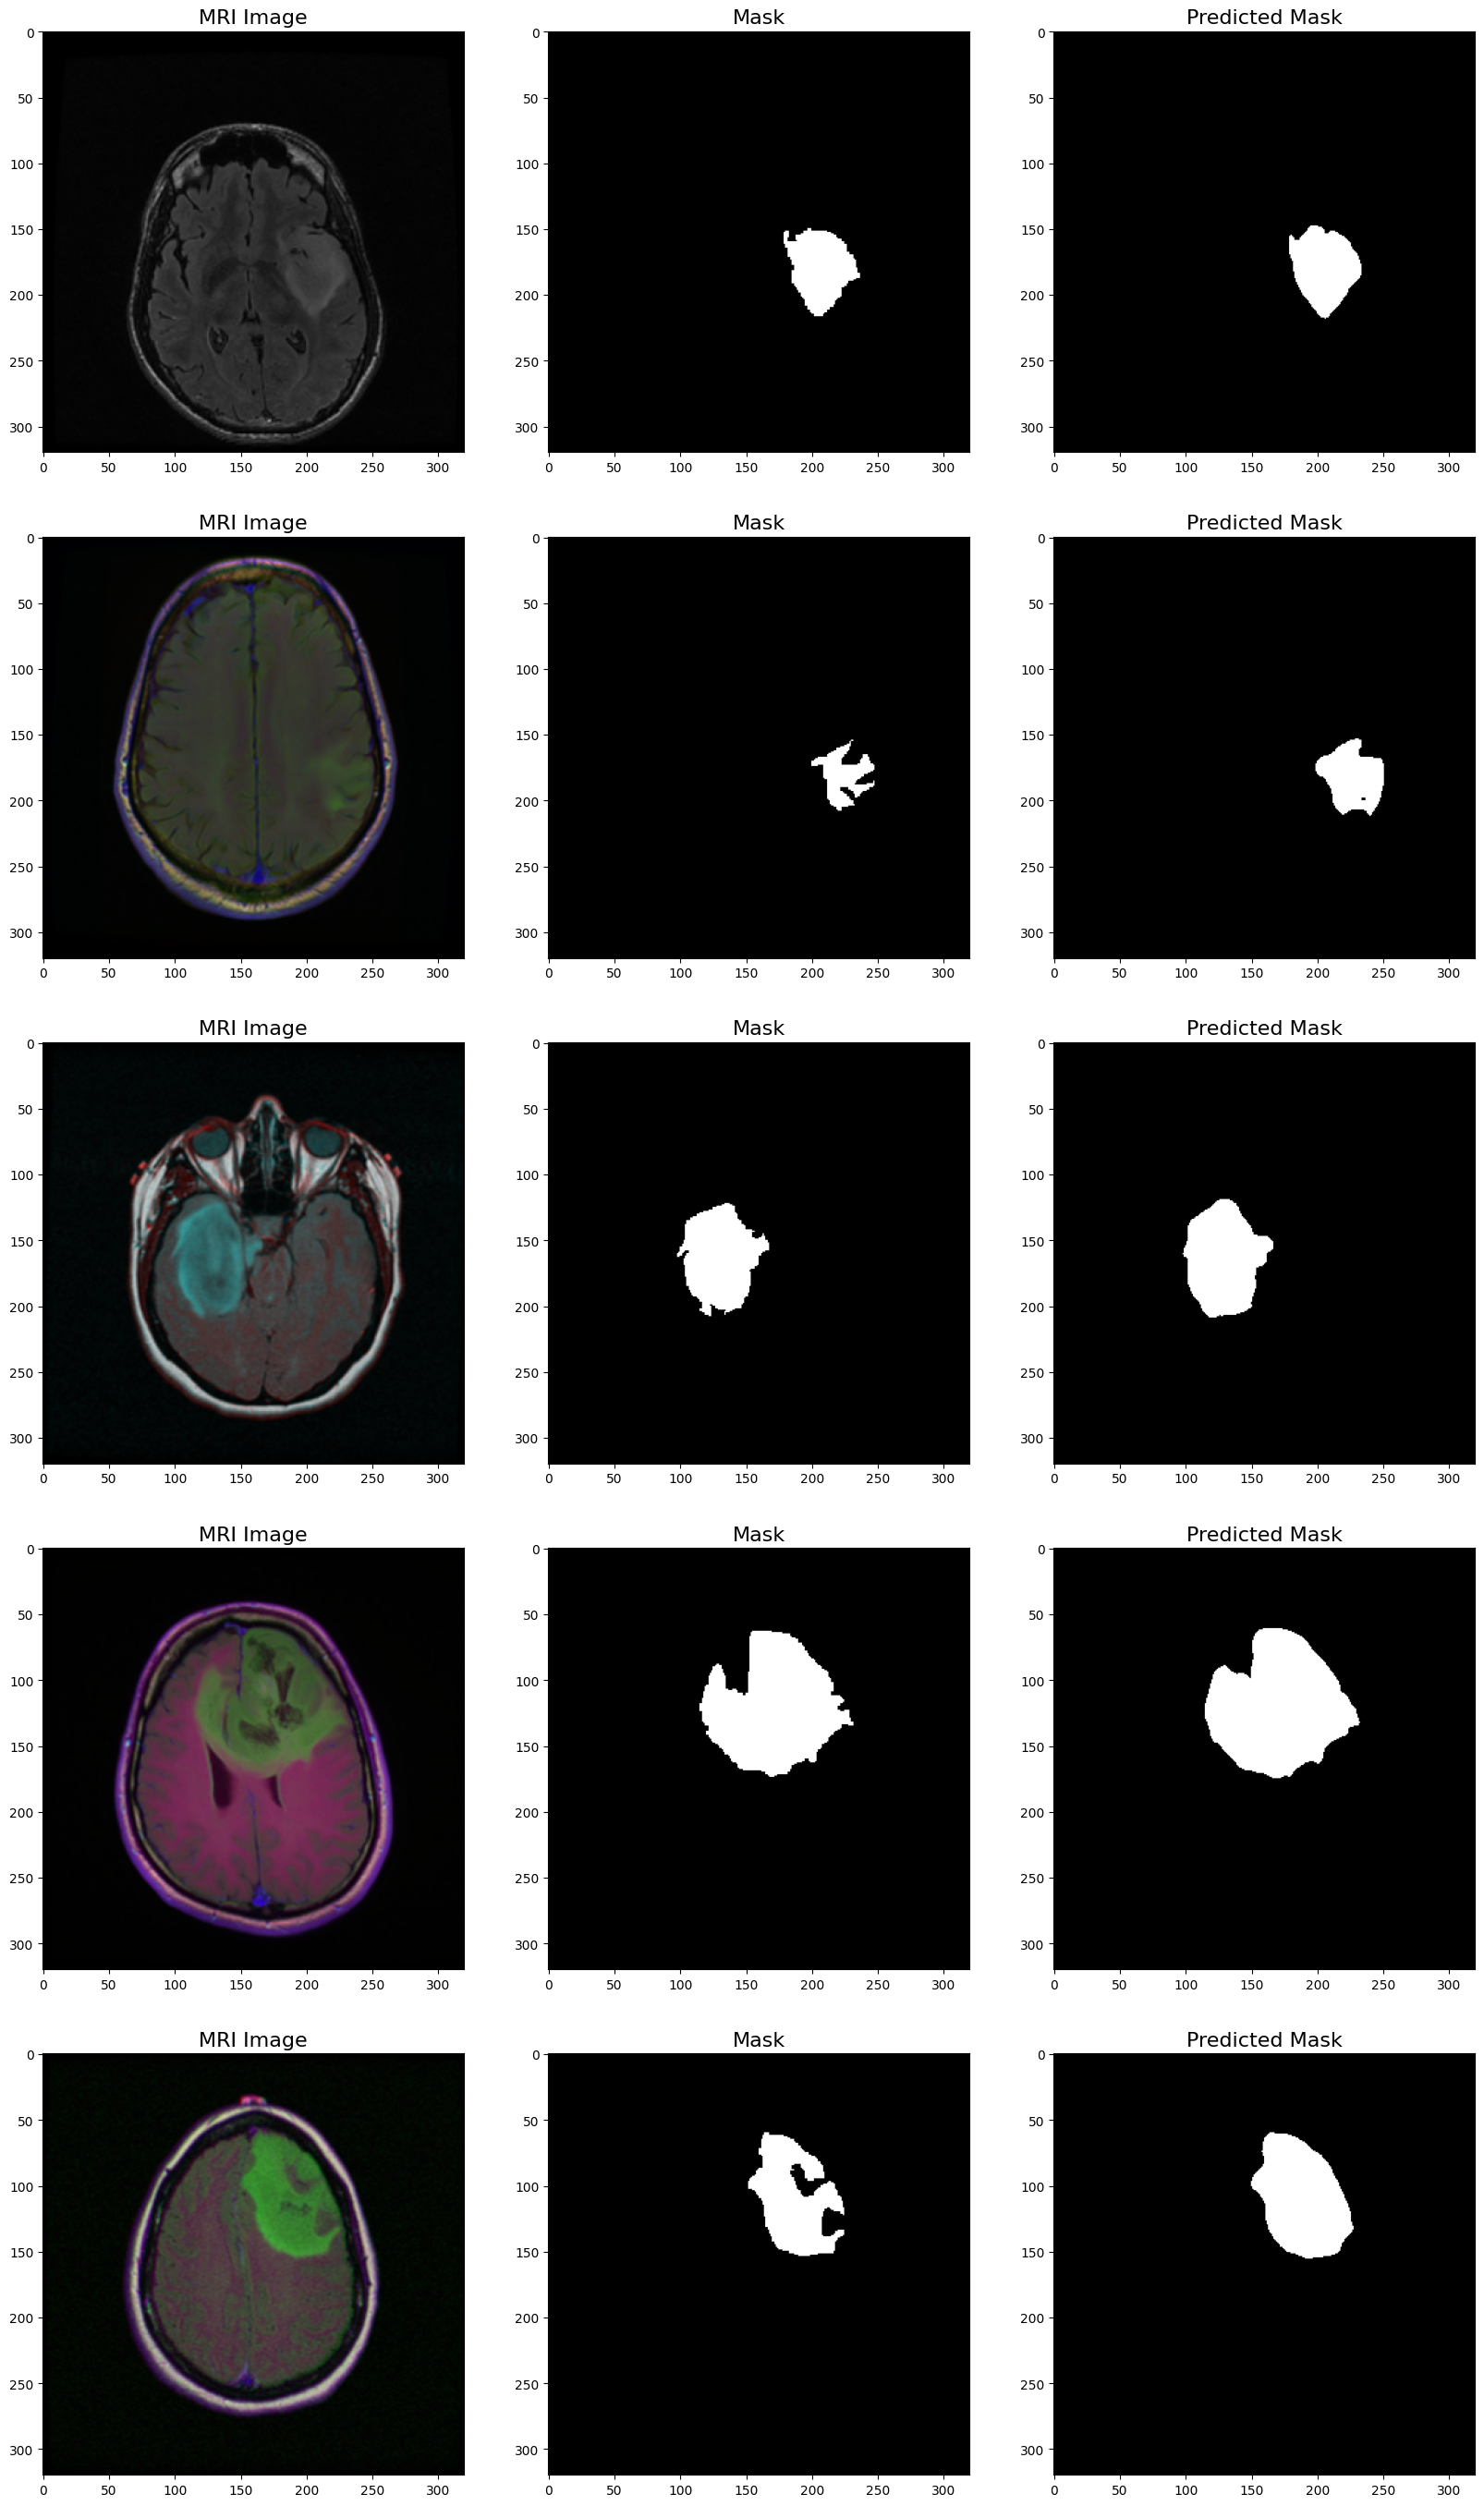

In [ ]:
view_multiple_predictions(sample_model, test_diagnosed_ds, count=5, color_map= 'rgb', fig_size=(20,38))

In [ ]:
def plot_training_curves(history, fig_size= (16,8), titile_size= 16):

  loss= np.array(history['loss'])
  val_loss= np.array(history['eval_loss'])
  dice_coef= np.array(history['loss_score'])
  eval_dice_coef= np.array(history['eval_score'])

  epochs= range(len(history['loss']))

  fig, (ax1, ax2)= plt.subplots(2, 1, figsize= fig_size)

  ax1.plot(epochs, loss, label= 'Training Loss', marker= 'o', color= 'C5');
  ax1.plot(epochs, val_loss, label= 'Validation Loss', marker= 'o', color= 'C6');

  #Filling area between losses
  ax1.fill_between(epochs, loss, val_loss, where= (loss > val_loss), color= 'C5', alpha= 0.4, interpolate= True);
  ax2.fill_between(epochs, loss, val_loss, where= (loss< val_loss), color= 'C6', alpha= 0.4, interpolate= True);


  # Adding formatting
  ax1.set_title('Loss - The Lower The Better', fontsize= 22);
  ax1.set_xlabel('Epochs', fontsize= 18);
  ax1.set_ylabel('Loss', fontsize= 18);
  ax1.tick_params(axis= 'both', which= 'major', labelsize= 14);
  ax1.legend(fontsize= 14)

  ax2.plot(epochs, dice_coef, label= 'Training Dice Score', marker= 'o', color= 'C5')
  ax2.plot(epochs, eval_dice_coef, label= 'Validation Dice Score', marker= 'o', color= 'C6')

  ax2.fill_between(epochs, dice_coef, eval_dice_coef, where= (dice_coef > eval_dice_coef), color= 'C5', alpha= 0.4, interpolate= True);
  ax2.fill_between(epochs, dice_coef, eval_dice_coef, where= (dice_coef < eval_dice_coef), color= 'C6', alpha= 0.4 , interpolate= True);

  ax2.set_title('Dice Score - The Higher The Better', fontsize= 22);
  ax2.set_xlabel('Epochs', fontsize= 18);
  ax2.set_ylabel('Dice Score', fontsize= 18);
  ax2.tick_params(axis= 'both', which= 'major', labelsize= 14);
  ax2.legend(fontsize= 14)

  sns.despine()

  return




In [ ]:
sample_df= pd.DataFrame(unet_session_history)

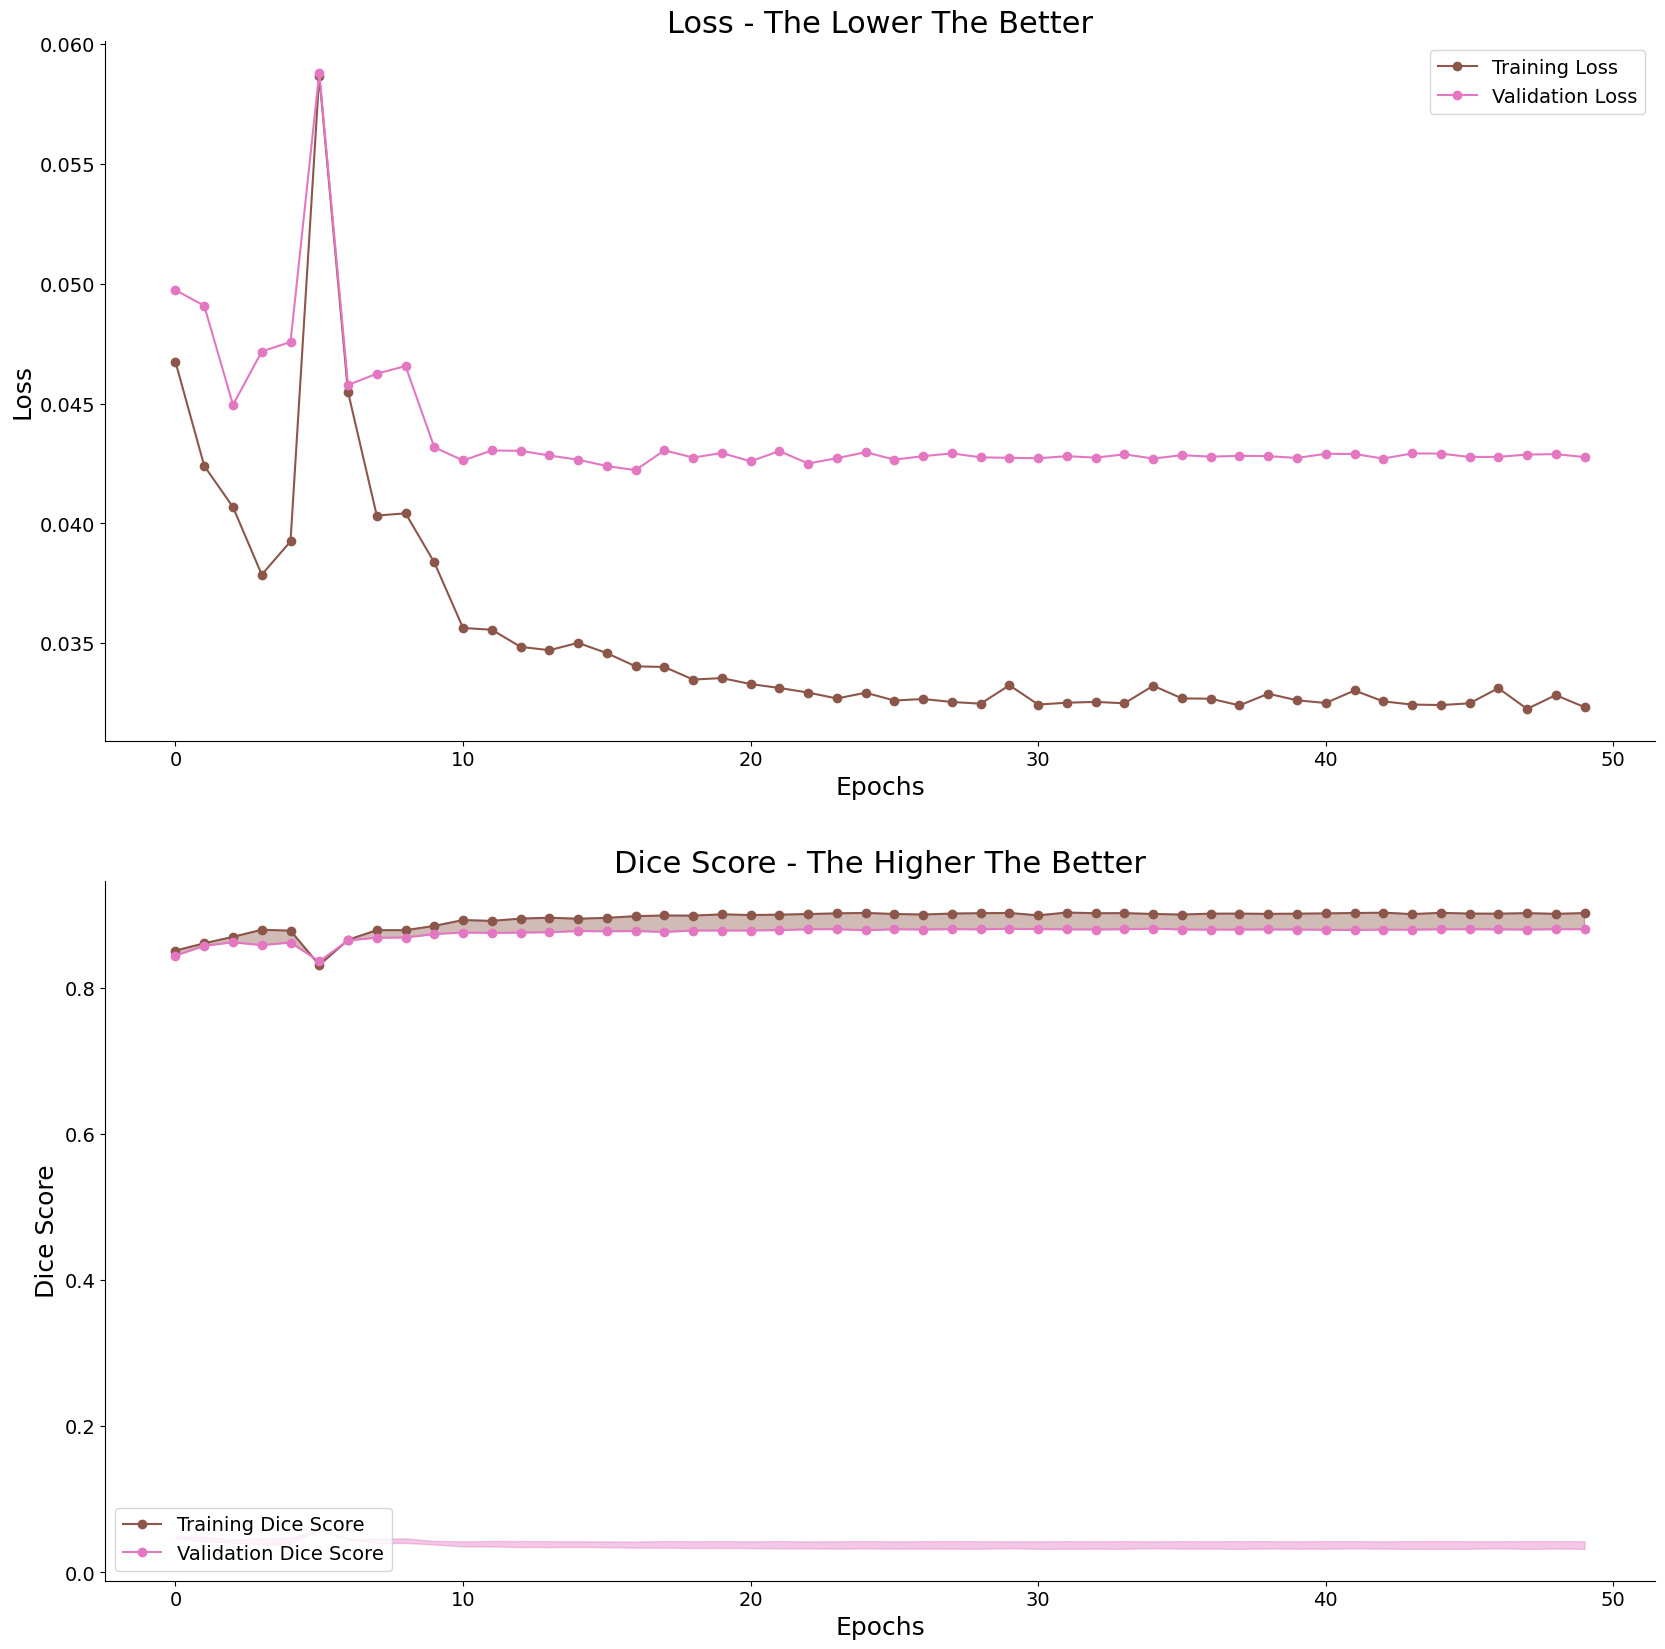

In [ ]:



plot_training_curves(unet_session_history, fig_size= (20, 20))

In [ ]:
def precision_(y_true, y_pred):
  intersection= (y_true * y_pred).sum()
  total_predicted_pixels= y_pred.sum()
  return (intersection/total_predicted_pixels).mean()

def recall_(y_true, y_pred):
  intersection= (y_true * y_pred).sum()
  total_true_pixels= y_true.sum()
  return (intersection/total_true_pixels).mean()

def dice_score(y_true, y_pred):
  eps= 1e-8
  intersection= (y_true * y_pred).sum()
  summation= (y_true + y_pred).sum()
  return ((2* intersection) / (summation + eps))

def jaccard_index(y_true, y_pred):
  eps= 1e-8
  intersection = (y_true * y_pred).sum()
  union= (y_true + y_pred).sum() - intersection
  return (intersection / (union+eps))


In [ ]:
def compute_metrics(
    model: nn.Module,
    sample_loader: torch.utils.data.DataLoader,
    device:torch.device
) -> np.ndarray:

  metrics= {
      'accuracy' : [],
      'precision': [],
      'recall' : [],
      'dice_score': [],
      'IoU': []
  }

  # Setting model into evaluation mode
  model.eval()

  with torch.inference_mode():

    for batch, (X, y) in enumerate(tqdm(sample_loader)):
      X= X.to(device)
      y= y.to(device)

      d0, _,_,_,_,_,_ = model(X)


      predicted_class= (d0 > 0.3).float()

      # Computing Batch metrices for each mask
      for true_mask, pred_mask in zip(y, predicted_class):
        acc= ((true_mask == pred_mask ).sum() / torch.numel(true_mask)).cpu().item()
        prec= precision_(true_mask, pred_mask).cpu().item()
        rec= recall_(true_mask, pred_mask).cpu().item()
        dice= dice_score(true_mask, pred_mask).cpu().item()
        iou= jaccard_index(true_mask, pred_mask).cpu().item()

        metrics['accuracy'].append(acc)
        metrics['precision'].append(prec)
        metrics['recall'].append(rec)
        metrics['dice_score'].append(dice)
        metrics['IoU'].append(iou)

  return metrics













In [ ]:
unet_metrics= compute_metrics(sample_model, test_dl, DEVICE)

  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 24/24 [00:14<00:00,  1.61it/s]


In [ ]:
unet_test_df= test_df.copy()

unet_test_df= pd.concat((unet_test_df, pd.DataFrame(unet_metrics)), axis= 1)

#Generate Diagnosis Labels
unet_test_df['model_diagnosis']= [int(mask.max()) for mask in unet_test_masks]

unet_test_df

id                patient  \
0    22  TCGA_DU_A5TS_19970726   
1    11  TCGA_DU_8165_19970205   
2    58  TCGA_HT_7881_19981015   
3    19  TCGA_DU_5853_19950823   
4     1  TCGA_DU_7298_19910324   
..   ..                    ...   
762  29  TCGA_DU_6399_19830416   
763   4  TCGA_DU_7294_19890104   
764  11  TCGA_HT_8105_19980826   
765  22  TCGA_DU_7014_19860618   
766  58  TCGA_DU_6405_19851005   

                                            image_path  \
0    /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1    /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2    /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3    /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4    /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
..                                                 ...   
762  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
763  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
764  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
765  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
766  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                             mask_path  diagnosis  accuracy  \
0    /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          1  0.994360   
1    /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  1.000000   
2    /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0  1.000000   
3    /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  1.000000   
4    /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  1.000000   
..                                                 ...        ...       ...   
762  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          1  0.996014   
763  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  1.000000   
764  /content/lgg-mri-segmentation/kaggle_3m/TCGA_H...          0  1.000000   
765  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          1  0.996612   
766  /content/lgg-mri-segmentation/kaggle_3m/TCGA_D...          0  1.000000   

     precision    recall  dice_score       IoU  model_diagnosis  
0     0.588517  0.936548    0.722821  0.565951                1  
1          NaN       NaN    0.000000  0.000000                0  
2          NaN       NaN    0.000000  0.000000                0  
3          NaN       NaN    0.000000  0.000000                0  
4          NaN       NaN    0.000000  0.000000                0  
..         ...       ...         ...       ...              ...  
762   0.726768  0.994307    0.839744  0.723757                1  
763        NaN       NaN    0.000000  0.000000                0  
764        NaN       NaN    0.000000  0.000000                0  
765   0.598901  0.529126    0.561856  0.390681                1  
766        NaN       NaN    0.000000  0.000000                0  

[767 rows x 11 columns]

In [ ]:
def generate_performance_scores(y_true, y_pred, log= True):
  model_accuracy= accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _= (precision_recall_fscore_support(y_true, y_pred, average= 'weighted'))

  model_matthews_corrcoeff= matthews_corrcoef(y_true, y_pred)

  if log:
    print("===============================================")
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print("===============================================")
    print(f'precision_score:\t{model_precision:.4f}\n')
    print("===============================================")
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print("===============================================")
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print("===============================================")
    print(f'mathhews_corrcoef:\t{model_matthews_corrcoeff:.4f}\n')
    print("===============================================")

  performance_metrics= {
      'accuracy_score': model_accuracy,
      'precision_score': model_precision,
      'recall_score': model_recall,
      'f1_score':model_f1,
      'matthews_corrcoef':model_matthews_corrcoeff
  }
  return performance_metrics





In [ ]:
test_labels= unet_test_df['diagnosis'].to_numpy()

unet_predictions= unet_test_df['model_diagnosis'].to_numpy()

In [ ]:
generate_performance_scores(test_labels, unet_predictions, log= True )

accuracy_score:		0.9674

precision_score:	0.9674

recall_score:		0.9674

f1_score:		0.9673

mathhews_corrcoef:	0.9281



{'accuracy_score': 0.9674054758800521,
 'precision_score': 0.9673793540588955,
 'recall_score': 0.9674054758800521,
 'f1_score': 0.9673033353968653,
 'matthews_corrcoef': 0.9280613308552226}